# Prep

Setting up some prior functionality

In [202]:
import os
import glob
import json
from PIL import Image
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.5.1+cu101 True


# Load a model

First we have to decide if our model should be pretrained. 

This greatly depends on the size of a dataset. Smaller datasets rely more on finetuning. 

In [2]:
pretrained = True

if pretrained:
    # Get pretrained weights
    checkpoint = torch.hub.load_state_dict_from_url(
                url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
                map_location='cpu',
                check_hash=True)

    # Remove class weights
    del checkpoint["model"]["class_embed.weight"]
    del checkpoint["model"]["class_embed.bias"]

    # SaveOGH
    torch.save(checkpoint,
               'detr-r50_no-class-head.pth')

# Dataset

Our dataset should be loadable as a COCO format

This allows us to use the pycocotools to load the data dict for the main python script

In [3]:
# alternatively, implement your own coco-type dataset loader in datasets and add this "key" to datasets/__init__.py
dataset_file = "coco_petct" 

# should lead to a directory with a train2017 and val2017 folder as well as an annotations folder
#dataDir='/COCO_dataset/' 
#dataDir = '/media/storage/Joy/datasets/DETR_MIP/FDG-PET-CT-Lesions/'
# dataDir = '/gpfs/fs0/data/stanford_data/petct/DETR_MIP/FDG-PET-CT-Lesions/'
dataDir = '/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/'

# this int should be the actual number of classes + 1 (for no class)
num_classes = 2

outDir = 'outputs'

resume = "detr-r50_no-class-head.pth" if pretrained else ""

In [4]:
!ls /gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/annotations/

detr_test.json	detr_train.json  detr_val.json


In [5]:
!ls $dataDir

annotations  images


# Visualize

In [6]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from pathlib import Path
from PIL import Image
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [7]:
mode = 'train'
annFile='{}annotations/detr_{}.json'.format(dataDir,mode)
print(annFile)

# https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py
# initialize COCO api for instance annotations
coco=COCO(annFile)

/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/annotations/detr_train.json
loading annotations into memory...
Done (t=1.99s)
creating index...
index created!


In [8]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['background', 'tumor']
Super-categories: {'background', 'tumor'}


In [9]:
# load and display image
catIds = coco.getCatIds(catNms=['tumor']);
imgIds = coco.getImgIds(catIds=catIds );

In [10]:
def _load_image_npy(coco, img_folder, img_id):
    npy_name = coco.loadImgs(img_id)[0]["file_name"] # loads a .npy file by image_id
    img_ann_path = img_folder/Path(npy_name)
    print(img_ann_path)
    with open(img_ann_path, 'rb') as f:
        suv_img = np.load(f) # this is a single channel suv values image, dtype numpy float64
    return suv_img

def _suv_to_greyPIL(suv_img, suv_max):
    # Assuming eval mode
    norm = plt.Normalize(vmin = 0, vmax = suv_max) # normally radiologists view images at this suv norm
    # Color map to gray images, output has 3 channels
    cmap = plt.cm.Greys
    img = cmap(norm(suv_img))[:,:,:3].copy() # drop the alpha channel that we don't need. has shape (H x W x 3C) 
    #img = torch.as_tensor(img, dtype=torch.float64) # the transforms latera will turn the numpy array to a tensor (C x H x W)
    img = Image.fromarray(np.uint8(img*255), 'RGB') # expected input by transforms
    return img

     

Image n°0
Image name: /gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions//annotations/train/0.npy
/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/images/train/0.npy


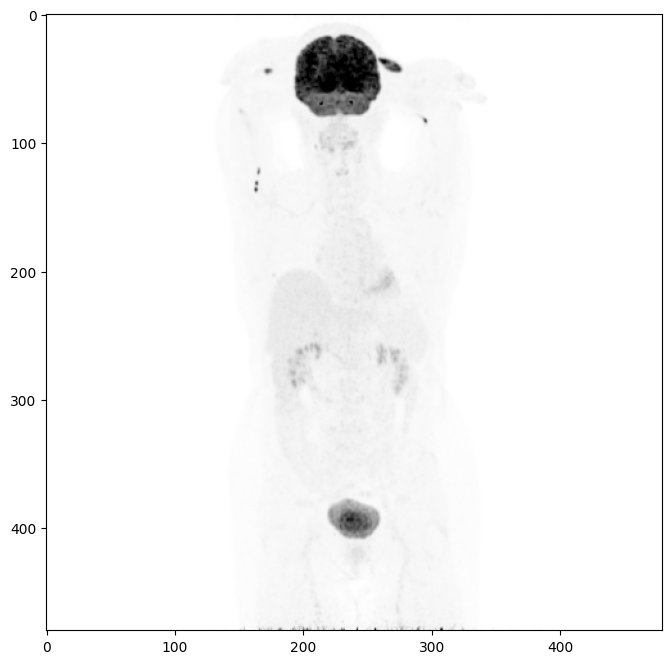

In [11]:
#img_id = imgIds[np.random.randint(0,len(imgIds))]
img_id = 0
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s/%s'%(dataDir, 'annotations', mode, img['file_name'])
print('Image name: {}'.format(img_name))

img_folder = Path(dataDir)/Path('images')/Path(mode)
suv_img = _load_image_npy(coco, img_folder, img_id)
suv_max = 20
I = _suv_to_greyPIL(suv_img, suv_max)

#I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [12]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

print(len(anns))

5


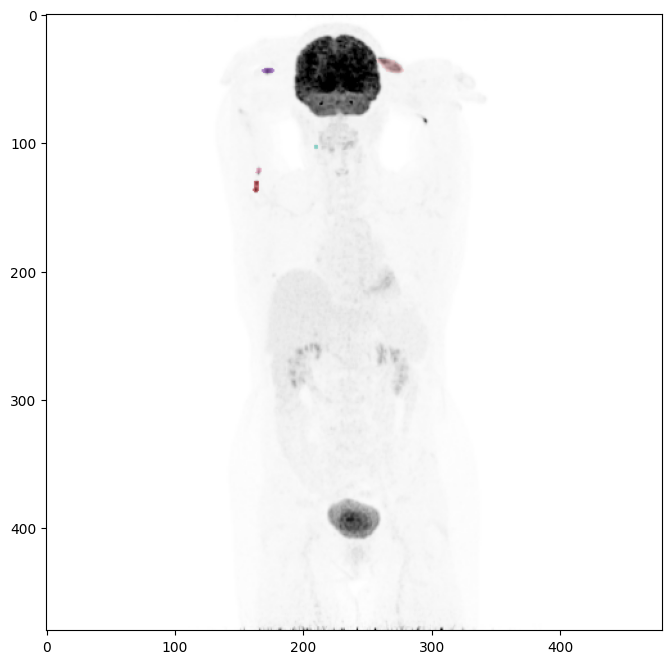

In [13]:
# load and display instance annotations
plt.imshow(I)
coco.showAnns(anns, draw_bbox=False)

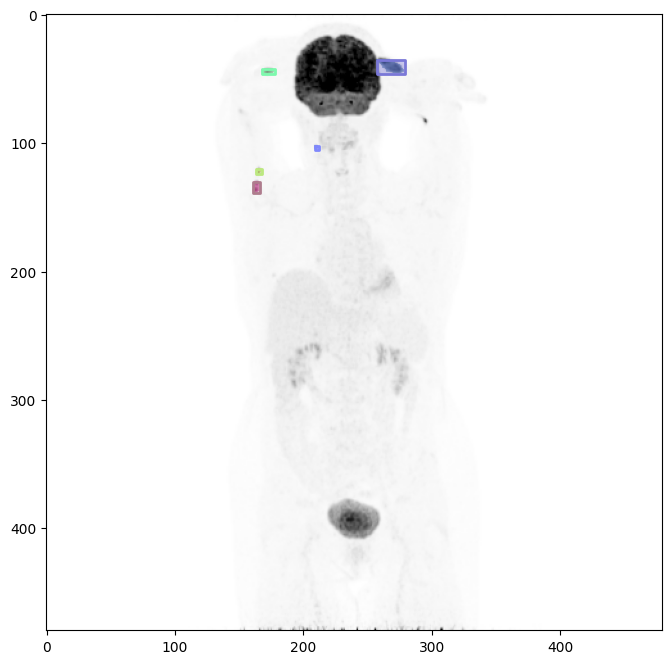

In [14]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

# Dataset Statistics

### Almost all images have < 100 objects

i.e. Makes sense to keep object queries to 100.

In [15]:
max_anno = 0
min_anno = 1
freq_anno = []
for imgID in imgIds:
    annIds = coco.getAnnIds(imgIds=imgID, catIds=[1])
    anns = coco.loadAnns(annIds)
    num = len(anns)
    if num > max_anno:
        max_anno = num
    if num < min_anno:
        min_anno = num
    if num > 1:
        freq_anno.append(num)
print(max_anno) 
print(min_anno) 
print(len(freq_anno))
print(len([f for f in freq_anno if f < 50]))

261
1
15955
15580


(array([2.777e+03, 2.514e+03, 1.679e+03, 1.556e+03, 1.015e+03, 8.130e+02,
        7.420e+02, 6.010e+02, 5.460e+02, 4.300e+02, 2.880e+02, 2.400e+02,
        1.160e+02, 1.230e+02, 1.520e+02, 1.600e+02, 1.310e+02, 1.330e+02,
        1.090e+02, 8.500e+01, 8.900e+01, 9.300e+01, 7.100e+01, 8.000e+01,
        7.300e+01, 8.500e+01, 8.000e+01, 8.000e+01, 8.200e+01, 6.200e+01,
        4.200e+01, 3.000e+01, 1.700e+01, 3.000e+01, 3.100e+01, 4.200e+01,
        3.100e+01, 3.000e+01, 5.000e+01, 3.200e+01, 3.900e+01, 4.200e+01,
        3.400e+01, 3.500e+01, 2.700e+01, 2.000e+01, 1.700e+01, 2.600e+01,
        2.300e+01, 2.300e+01, 1.700e+01, 1.400e+01, 2.500e+01, 2.100e+01,
        7.000e+00, 6.000e+00, 2.000e+00, 1.000e+01, 7.000e+00, 7.000e+00,
        1.100e+01, 4.000e+00, 1.600e+01, 1.300e+01, 1.000e+01, 1.400e+01,
        7.000e+00, 3.000e+00, 4.000e+00, 5.000e+00, 5.000e+00, 6.000e+00,
        4.000e+00, 4.000e+00, 5.000e+00, 6.000e+00, 1.300e+01, 5.000e+00,
        3.000e+00, 4.000e+00, 2.000e+0

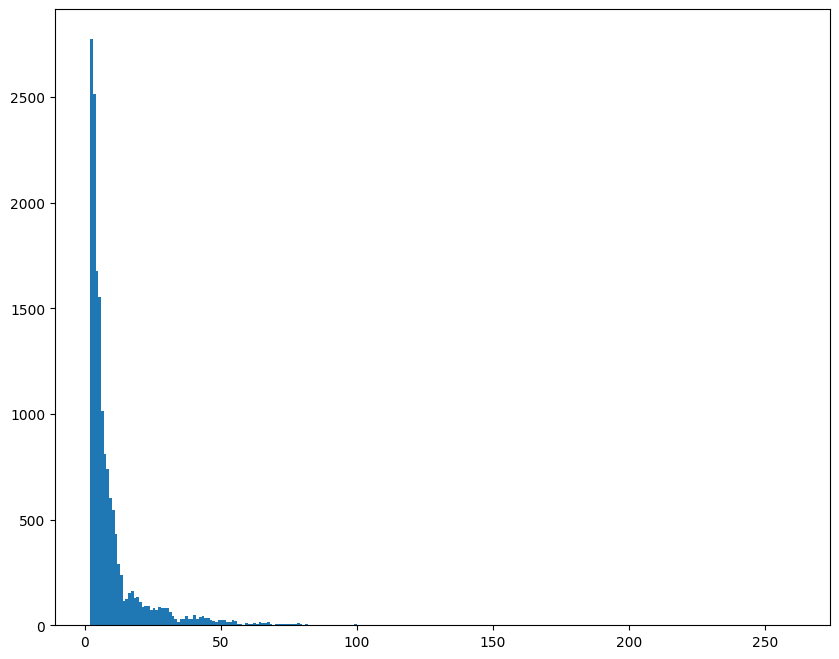

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import *

data = np.asarray(freq_anno)
plt.hist(data, bins=np.arange(data.min(), data.max()+1))


In [17]:
print('Number of images with more than 100 tumor lesions:',len([f for f in freq_anno if f > 100]))

Number of images with more than 100 tumor lesions: 55


### Small, medium and large objects likely different for petct datset

https://github.com/cocodataset/cocoapi/issues/325

In [18]:
areas = []
AnnIds = coco.getAnnIds(catIds=catIds)
print(len(AnnIds))

annotations = coco.loadAnns(ids=AnnIds)
print(len(annotations))
print(annotations[0])

for ann in annotations: # {'annot_id...': {'area',...}, }
    area = ann['area']
    areas.append(area)
    
print(len(areas))
sizes = [np.sqrt(a) for a in areas]

161716
161716
{'image_id': 0, 'id': 0, 'segmentation': {'counts': [123395, 1, 479, 3, 477, 3, 477, 4, 476, 5, 475, 7, 473, 7, 473, 8, 472, 10, 470, 10, 470, 10, 471, 9, 471, 9, 471, 10, 470, 10, 472, 8, 472, 8, 473, 7, 473, 7, 474, 6, 476, 3, 478, 2, 96915], 'size': [480, 480]}, 'area': 147, 'iscrowd': 0, 'bbox': [257, 35, 22, 11], 'category_id': 1}
161716


(array([8.3780e+03, 1.7409e+04, 1.8601e+04, 1.9154e+04, 1.7318e+04,
        1.4347e+04, 1.0809e+04, 8.2030e+03, 6.4720e+03, 5.3630e+03,
        4.0700e+03, 3.4710e+03, 2.7080e+03, 2.0280e+03, 2.0400e+03,
        1.4350e+03, 1.2500e+03, 1.2840e+03, 1.2160e+03, 1.2670e+03,
        1.1240e+03, 7.9400e+02, 7.6400e+02, 7.6200e+02, 6.9000e+02,
        5.2900e+02, 6.3000e+02, 5.5600e+02, 5.7100e+02, 4.7500e+02,
        5.1700e+02, 5.5000e+02, 4.4000e+02, 3.4200e+02, 3.8000e+02,
        3.2300e+02, 3.3500e+02, 3.3600e+02, 3.3100e+02, 3.1600e+02,
        3.2500e+02, 3.3100e+02, 2.4800e+02, 1.7400e+02, 1.4300e+02,
        1.8700e+02, 1.5200e+02, 1.1200e+02, 8.4000e+01, 9.1000e+01,
        1.4700e+02, 1.4900e+02, 1.7400e+02, 1.3700e+02, 1.4300e+02,
        1.2700e+02, 1.2700e+02, 9.7000e+01, 7.6000e+01, 9.7000e+01,
        8.3000e+01, 6.8000e+01, 4.1000e+01, 3.4000e+01, 2.4000e+01,
        2.8000e+01, 2.8000e+01, 4.2000e+01, 2.7000e+01, 3.2000e+01,
        2.2000e+01, 2.7000e+01, 2.3000e+01, 1.70

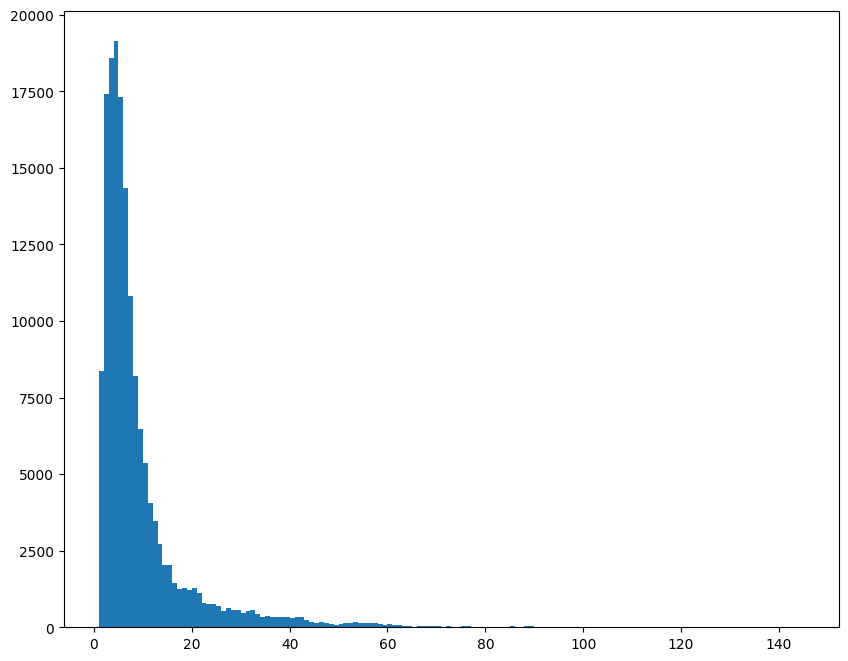

In [19]:
data = np.asarray(sizes)
plt.hist(data, bins=np.arange(data.min(), data.max()+1))

In [20]:
print('A good split for sizes of objects would be:')
print('Small (0**2 to {}**2):'.format(4), len([s for s in sizes if s < 4 ])/len(sizes))
print('Medium ({}**2 to {}**2):'.format(4,8), len([s for s in sizes if (s >= 4)&(s < 8) ])/len(sizes))
print('Large ({}**2 to 1e5**2):'.format(8), len([s for s in sizes if s >= 8 ])/len(sizes))

A good split for sizes of objects would be:
Small (0**2 to 4**2): 0.2744811892453437
Medium (4**2 to 8**2): 0.3810878329911697
Large (8**2 to 1e5**2): 0.3444309777634866


# Training

We use the main_petct.py script to run our training

Training log for DETR
https://gist.github.com/szagoruyko/b4c3b2c3627294fc369b899987385a3f

In [20]:
experiment = 'baseline_test'
outDir_baseline = '/'.join([outDir,experiment])
print(outDir_baseline)

outputs/baseline_test


In [82]:
!/home/joywu/anaconda3/envs/detr_py38/bin/python main_petct.py \
  --dataset_file $dataset_file \
  --coco_petct_path $dataDir \
  --output_dir $outDir_baseline \
  --resume $resume \
  --num_classes $num_classes \
  --lr 1e-5 \
  --lr_backbone 1e-6 \
  --epochs 1 \
  --experiment $experiment 

Not using distributed mode
git:
  sha: afe013f4b8b80a384839a9834b260fb432bb1166, status: has uncommited changes, branch: master

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path=None, coco_petct_path='/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/', cross_val=False, dataset_file='coco_petct', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, early_stopping=False, enc_layers=6, eos_coef=0.1, epochs=1, eval=False, experiment='baseline', frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=1e-05, lr_backbone=1e-06, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=2, num_queries=100, num_workers=2, output_dir='outputs/baseline', patience=10, position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=

Epoch: [0]  [   40/19488]  eta: 1:08:16  lr: 0.000010  class_error: 0.00  loss: 31.7907 (30.0587)  loss_ce: 0.7575 (1.0514)  loss_bbox: 2.1874 (2.0475)  loss_giou: 1.9942 (1.7958)  loss_ce_0: 1.0344 (1.2098)  loss_bbox_0: 2.4497 (2.1369)  loss_giou_0: 2.1306 (1.7887)  loss_ce_1: 0.9146 (1.1727)  loss_bbox_1: 2.5804 (2.0763)  loss_giou_1: 2.0529 (1.8132)  loss_ce_2: 0.8671 (1.1385)  loss_bbox_2: 2.1132 (2.0567)  loss_giou_2: 1.9938 (1.8131)  loss_ce_3: 0.8035 (1.1186)  loss_bbox_3: 2.2793 (2.0959)  loss_giou_3: 1.9939 (1.7970)  loss_ce_4: 0.7689 (1.0849)  loss_bbox_4: 2.1650 (2.0721)  loss_giou_4: 2.0915 (1.7897)  loss_ce_unscaled: 0.7575 (1.0514)  class_error_unscaled: 0.0000 (31.7073)  loss_bbox_unscaled: 0.4375 (0.4095)  loss_giou_unscaled: 0.9971 (0.8979)  cardinality_error_unscaled: 31.0000 (63.9878)  loss_ce_0_unscaled: 1.0344 (1.2098)  loss_bbox_0_unscaled: 0.4899 (0.4274)  loss_giou_0_unscaled: 1.0653 (0.8944)  cardinality_error_0_unscaled: 84.0000 (87.8902)  loss_ce_1_unscaled:

Epoch: [0]  [   90/19488]  eta: 1:07:36  lr: 0.000010  class_error: 0.00  loss: 21.2046 (25.1958)  loss_ce: 0.3556 (0.7531)  loss_bbox: 1.4506 (1.6993)  loss_giou: 1.7980 (1.6132)  loss_ce_0: 0.5734 (0.9268)  loss_bbox_0: 1.6189 (1.8290)  loss_giou_0: 1.8693 (1.6224)  loss_ce_1: 0.5252 (0.8923)  loss_bbox_1: 1.2124 (1.7574)  loss_giou_1: 1.8038 (1.6404)  loss_ce_2: 0.4514 (0.8364)  loss_bbox_2: 1.4311 (1.7389)  loss_giou_2: 1.7883 (1.6283)  loss_ce_3: 0.4206 (0.8071)  loss_bbox_3: 1.1386 (1.7374)  loss_giou_3: 1.8030 (1.6139)  loss_ce_4: 0.3914 (0.7780)  loss_bbox_4: 1.4995 (1.7133)  loss_giou_4: 1.8159 (1.6086)  loss_ce_unscaled: 0.3556 (0.7531)  class_error_unscaled: 0.0000 (31.2967)  loss_bbox_unscaled: 0.2901 (0.3399)  loss_giou_unscaled: 0.8990 (0.8066)  cardinality_error_unscaled: 1.0000 (31.3571)  loss_ce_0_unscaled: 0.5734 (0.9268)  loss_bbox_0_unscaled: 0.3238 (0.3658)  loss_giou_0_unscaled: 0.9346 (0.8112)  cardinality_error_0_unscaled: 5.0000 (53.9066)  loss_ce_1_unscaled: 0

Epoch: [0]  [  140/19488]  eta: 1:06:52  lr: 0.000010  class_error: 0.00  loss: 19.1455 (22.0174)  loss_ce: 0.4398 (0.6658)  loss_bbox: 0.7560 (1.3441)  loss_giou: 1.9471 (1.5484)  loss_ce_0: 0.4059 (0.7751)  loss_bbox_0: 0.9362 (1.5288)  loss_giou_0: 1.8716 (1.5678)  loss_ce_1: 0.3752 (0.7518)  loss_bbox_1: 0.8342 (1.4282)  loss_giou_1: 1.9271 (1.5727)  loss_ce_2: 0.3927 (0.7105)  loss_bbox_2: 0.6701 (1.3858)  loss_giou_2: 2.0077 (1.5742)  loss_ce_3: 0.3649 (0.6915)  loss_bbox_3: 0.6590 (1.3750)  loss_giou_3: 1.8686 (1.5365)  loss_ce_4: 0.3927 (0.6722)  loss_bbox_4: 0.7309 (1.3532)  loss_giou_4: 1.8515 (1.5357)  loss_ce_unscaled: 0.4398 (0.6658)  class_error_unscaled: 0.0000 (30.2803)  loss_bbox_unscaled: 0.1512 (0.2688)  loss_giou_unscaled: 0.9735 (0.7742)  cardinality_error_unscaled: 1.5000 (21.1950)  loss_ce_0_unscaled: 0.4059 (0.7751)  loss_bbox_0_unscaled: 0.1872 (0.3058)  loss_giou_0_unscaled: 0.9358 (0.7839)  cardinality_error_0_unscaled: 1.5000 (35.7943)  loss_ce_1_unscaled: 0

Epoch: [0]  [  190/19488]  eta: 1:06:33  lr: 0.000010  class_error: 0.00  loss: 20.2404 (19.7175)  loss_ce: 0.5943 (0.6506)  loss_bbox: 0.5648 (1.0925)  loss_giou: 1.8412 (1.4642)  loss_ce_0: 0.4475 (0.6948)  loss_bbox_0: 0.8201 (1.2791)  loss_giou_0: 1.9636 (1.4896)  loss_ce_1: 0.4598 (0.6816)  loss_bbox_1: 0.6251 (1.1750)  loss_giou_1: 1.8281 (1.4843)  loss_ce_2: 0.4959 (0.6606)  loss_bbox_2: 0.6505 (1.1274)  loss_giou_2: 1.9780 (1.4912)  loss_ce_3: 0.5235 (0.6539)  loss_bbox_3: 0.5395 (1.1178)  loss_giou_3: 1.7960 (1.4563)  loss_ce_4: 0.5314 (0.6414)  loss_bbox_4: 0.5988 (1.0994)  loss_giou_4: 1.7882 (1.4578)  loss_ce_unscaled: 0.5943 (0.6506)  class_error_unscaled: 5.8824 (32.2807)  loss_bbox_unscaled: 0.1130 (0.2185)  loss_giou_unscaled: 0.9206 (0.7321)  cardinality_error_unscaled: 1.5000 (16.4005)  loss_ce_0_unscaled: 0.4475 (0.6948)  loss_bbox_0_unscaled: 0.1640 (0.2558)  loss_giou_0_unscaled: 0.9818 (0.7448)  cardinality_error_0_unscaled: 1.5000 (27.1780)  loss_ce_1_unscaled: 0

Epoch: [0]  [  240/19488]  eta: 1:06:26  lr: 0.000010  class_error: 0.00  loss: 20.0040 (18.6708)  loss_ce: 0.7066 (0.6967)  loss_bbox: 0.4208 (0.9442)  loss_giou: 1.8259 (1.4219)  loss_ce_0: 0.4515 (0.6725)  loss_bbox_0: 0.7274 (1.1378)  loss_giou_0: 1.8661 (1.4432)  loss_ce_1: 0.5380 (0.6741)  loss_bbox_1: 0.5976 (1.0278)  loss_giou_1: 1.8299 (1.4373)  loss_ce_2: 0.5836 (0.6727)  loss_bbox_2: 0.5097 (0.9835)  loss_giou_2: 1.9108 (1.4524)  loss_ce_3: 0.6324 (0.6795)  loss_bbox_3: 0.5518 (0.9692)  loss_giou_3: 1.9243 (1.4183)  loss_ce_4: 0.6408 (0.6707)  loss_bbox_4: 0.4318 (0.9507)  loss_giou_4: 1.8489 (1.4182)  loss_ce_unscaled: 0.7066 (0.6967)  class_error_unscaled: 0.0000 (33.2506)  loss_bbox_unscaled: 0.0842 (0.1888)  loss_giou_unscaled: 0.9129 (0.7109)  cardinality_error_unscaled: 1.5000 (13.7593)  loss_ce_0_unscaled: 0.4515 (0.6725)  loss_bbox_0_unscaled: 0.1455 (0.2276)  loss_giou_0_unscaled: 0.9331 (0.7216)  cardinality_error_0_unscaled: 1.5000 (22.3008)  loss_ce_1_unscaled: 0

Epoch: [0]  [  290/19488]  eta: 1:06:04  lr: 0.000010  class_error: 0.00  loss: 19.9375 (18.5029)  loss_ce: 0.9950 (0.7528)  loss_bbox: 0.3957 (0.8514)  loss_giou: 1.8131 (1.4577)  loss_ce_0: 0.6988 (0.6763)  loss_bbox_0: 0.5282 (1.0442)  loss_giou_0: 1.8652 (1.4800)  loss_ce_1: 0.7714 (0.6944)  loss_bbox_1: 0.4712 (0.9309)  loss_giou_1: 1.8180 (1.4697)  loss_ce_2: 0.8886 (0.7057)  loss_bbox_2: 0.4729 (0.8852)  loss_giou_2: 1.8856 (1.4873)  loss_ce_3: 0.9505 (0.7238)  loss_bbox_3: 0.4085 (0.8709)  loss_giou_3: 1.7879 (1.4463)  loss_ce_4: 0.9434 (0.7154)  loss_bbox_4: 0.3986 (0.8564)  loss_giou_4: 1.8887 (1.4545)  loss_ce_unscaled: 0.9950 (0.7528)  class_error_unscaled: 0.0000 (29.8141)  loss_bbox_unscaled: 0.0791 (0.1703)  loss_giou_unscaled: 0.9065 (0.7288)  cardinality_error_unscaled: 3.0000 (12.0945)  loss_ce_0_unscaled: 0.6988 (0.6763)  loss_bbox_0_unscaled: 0.1056 (0.2088)  loss_giou_0_unscaled: 0.9326 (0.7400)  cardinality_error_0_unscaled: 3.0000 (19.1684)  loss_ce_1_unscaled: 0

Epoch: [0]  [  340/19488]  eta: 1:05:53  lr: 0.000010  class_error: 0.00  loss: 19.5220 (18.0576)  loss_ce: 0.7784 (0.7728)  loss_bbox: 0.3677 (0.7789)  loss_giou: 1.8556 (1.4521)  loss_ce_0: 0.6106 (0.6726)  loss_bbox_0: 0.5228 (0.9625)  loss_giou_0: 1.8572 (1.4699)  loss_ce_1: 0.6550 (0.6986)  loss_bbox_1: 0.4160 (0.8527)  loss_giou_1: 1.8226 (1.4604)  loss_ce_2: 0.7259 (0.7166)  loss_bbox_2: 0.4072 (0.8082)  loss_giou_2: 1.8461 (1.4764)  loss_ce_3: 0.7311 (0.7392)  loss_bbox_3: 0.3662 (0.7953)  loss_giou_3: 1.9245 (1.4390)  loss_ce_4: 0.7142 (0.7316)  loss_bbox_4: 0.3941 (0.7834)  loss_giou_4: 1.8958 (1.4475)  loss_ce_unscaled: 0.7784 (0.7728)  class_error_unscaled: 0.0000 (28.9616)  loss_bbox_unscaled: 0.0735 (0.1558)  loss_giou_unscaled: 0.9278 (0.7260)  cardinality_error_unscaled: 2.0000 (11.0513)  loss_ce_0_unscaled: 0.6106 (0.6726)  loss_bbox_0_unscaled: 0.1046 (0.1925)  loss_giou_0_unscaled: 0.9286 (0.7349)  cardinality_error_0_unscaled: 2.0000 (17.0880)  loss_ce_1_unscaled: 0

Epoch: [0]  [  390/19488]  eta: 1:05:31  lr: 0.000010  class_error: 100.00  loss: 14.1619 (17.6615)  loss_ce: 0.3420 (0.7861)  loss_bbox: 0.2736 (0.7203)  loss_giou: 1.5037 (1.4403)  loss_ce_0: 0.2697 (0.6705)  loss_bbox_0: 0.3463 (0.8889)  loss_giou_0: 1.5270 (1.4580)  loss_ce_1: 0.3071 (0.7036)  loss_bbox_1: 0.2957 (0.7878)  loss_giou_1: 1.6694 (1.4520)  loss_ce_2: 0.3348 (0.7252)  loss_bbox_2: 0.2703 (0.7462)  loss_giou_2: 1.4903 (1.4618)  loss_ce_3: 0.3318 (0.7499)  loss_bbox_3: 0.2673 (0.7339)  loss_giou_3: 1.5641 (1.4325)  loss_ce_4: 0.3369 (0.7428)  loss_bbox_4: 0.2861 (0.7251)  loss_giou_4: 1.5726 (1.4368)  loss_ce_unscaled: 0.3420 (0.7861)  class_error_unscaled: 0.0000 (28.3271)  loss_bbox_unscaled: 0.0547 (0.1441)  loss_giou_unscaled: 0.7518 (0.7201)  cardinality_error_unscaled: 1.0000 (10.2417)  loss_ce_0_unscaled: 0.2697 (0.6705)  loss_bbox_0_unscaled: 0.0693 (0.1778)  loss_giou_0_unscaled: 0.7635 (0.7290)  cardinality_error_0_unscaled: 1.0000 (15.5064)  loss_ce_1_unscaled:

Epoch: [0]  [  440/19488]  eta: 1:05:06  lr: 0.000010  class_error: 0.00  loss: 16.2788 (17.3112)  loss_ce: 0.4810 (0.7946)  loss_bbox: 0.2981 (0.6719)  loss_giou: 1.6806 (1.4300)  loss_ce_0: 0.4313 (0.6703)  loss_bbox_0: 0.3988 (0.8281)  loss_giou_0: 1.7948 (1.4444)  loss_ce_1: 0.5036 (0.7080)  loss_bbox_1: 0.3279 (0.7339)  loss_giou_1: 1.7326 (1.4397)  loss_ce_2: 0.4489 (0.7325)  loss_bbox_2: 0.3138 (0.6957)  loss_giou_2: 1.7776 (1.4450)  loss_ce_3: 0.4788 (0.7578)  loss_bbox_3: 0.3078 (0.6849)  loss_giou_3: 1.7031 (1.4207)  loss_ce_4: 0.4642 (0.7507)  loss_bbox_4: 0.3083 (0.6775)  loss_giou_4: 1.7048 (1.4254)  loss_ce_unscaled: 0.4810 (0.7946)  class_error_unscaled: 0.0000 (27.8365)  loss_bbox_unscaled: 0.0596 (0.1344)  loss_giou_unscaled: 0.8403 (0.7150)  cardinality_error_unscaled: 2.0000 (9.6281)  loss_ce_0_unscaled: 0.4313 (0.6703)  loss_bbox_0_unscaled: 0.0798 (0.1656)  loss_giou_0_unscaled: 0.8974 (0.7222)  cardinality_error_0_unscaled: 2.0000 (14.2914)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  490/19488]  eta: 1:04:54  lr: 0.000010  class_error: 0.00  loss: 12.3019 (17.0126)  loss_ce: 0.2121 (0.7912)  loss_bbox: 0.1721 (0.6323)  loss_giou: 1.4565 (1.4246)  loss_ce_0: 0.1828 (0.6638)  loss_bbox_0: 0.2631 (0.7804)  loss_giou_0: 1.5458 (1.4394)  loss_ce_1: 0.1773 (0.7044)  loss_bbox_1: 0.2167 (0.6917)  loss_giou_1: 1.5530 (1.4359)  loss_ce_2: 0.2199 (0.7302)  loss_bbox_2: 0.1793 (0.6550)  loss_giou_2: 1.4950 (1.4400)  loss_ce_3: 0.1975 (0.7545)  loss_bbox_3: 0.1930 (0.6454)  loss_giou_3: 1.4431 (1.4158)  loss_ce_4: 0.1991 (0.7482)  loss_bbox_4: 0.2201 (0.6382)  loss_giou_4: 1.4772 (1.4216)  loss_ce_unscaled: 0.2121 (0.7912)  class_error_unscaled: 0.0000 (27.2421)  loss_bbox_unscaled: 0.0344 (0.1265)  loss_giou_unscaled: 0.7283 (0.7123)  cardinality_error_unscaled: 0.5000 (9.1527)  loss_ce_0_unscaled: 0.1828 (0.6638)  loss_bbox_0_unscaled: 0.0526 (0.1561)  loss_giou_0_unscaled: 0.7729 (0.7197)  cardinality_error_0_unscaled: 0.5000 (13.3248)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  540/19488]  eta: 1:04:34  lr: 0.000010  class_error: 0.00  loss: 0.4058 (16.4927)  loss_ce: 0.0541 (0.7639)  loss_bbox: 0.0000 (0.5973)  loss_giou: 0.0000 (1.3998)  loss_ce_0: 0.0965 (0.6405)  loss_bbox_0: 0.0000 (0.7396)  loss_giou_0: 0.0000 (1.4153)  loss_ce_1: 0.0679 (0.6810)  loss_bbox_1: 0.0000 (0.6551)  loss_giou_1: 0.0000 (1.4113)  loss_ce_2: 0.0648 (0.7062)  loss_bbox_2: 0.0000 (0.6179)  loss_giou_2: 0.0000 (1.4128)  loss_ce_3: 0.0612 (0.7285)  loss_bbox_3: 0.0000 (0.6092)  loss_giou_3: 0.0000 (1.3919)  loss_ce_4: 0.0613 (0.7230)  loss_bbox_4: 0.0000 (0.6035)  loss_giou_4: 0.0000 (1.3961)  loss_ce_unscaled: 0.0541 (0.7639)  class_error_unscaled: 0.0000 (27.3122)  loss_bbox_unscaled: 0.0000 (0.1195)  loss_giou_unscaled: 0.0000 (0.6999)  cardinality_error_unscaled: 0.0000 (8.5638)  loss_ce_0_unscaled: 0.0965 (0.6405)  loss_bbox_0_unscaled: 0.0000 (0.1479)  loss_giou_0_unscaled: 0.0000 (0.7076)  cardinality_error_0_unscaled: 0.0000 (12.3420)  loss_ce_1_unscaled: 0.0

Epoch: [0]  [  590/19488]  eta: 1:04:22  lr: 0.000010  class_error: 100.00  loss: 17.4533 (16.2364)  loss_ce: 0.9637 (0.7678)  loss_bbox: 0.2312 (0.5702)  loss_giou: 1.5822 (1.3847)  loss_ce_0: 0.7861 (0.6389)  loss_bbox_0: 0.3583 (0.7060)  loss_giou_0: 1.5629 (1.3981)  loss_ce_1: 0.9406 (0.6830)  loss_bbox_1: 0.2807 (0.6246)  loss_giou_1: 1.6545 (1.3938)  loss_ce_2: 1.0320 (0.7094)  loss_bbox_2: 0.3080 (0.5898)  loss_giou_2: 1.4706 (1.3958)  loss_ce_3: 0.9390 (0.7315)  loss_bbox_3: 0.2983 (0.5819)  loss_giou_3: 1.5280 (1.3759)  loss_ce_4: 0.9558 (0.7278)  loss_bbox_4: 0.2416 (0.5763)  loss_giou_4: 1.6302 (1.3810)  loss_ce_unscaled: 0.9637 (0.7678)  class_error_unscaled: 0.0000 (27.7088)  loss_bbox_unscaled: 0.0462 (0.1140)  loss_giou_unscaled: 0.7911 (0.6924)  cardinality_error_unscaled: 3.0000 (8.2234)  loss_ce_0_unscaled: 0.7861 (0.6389)  loss_bbox_0_unscaled: 0.0717 (0.1412)  loss_giou_0_unscaled: 0.7815 (0.6991)  cardinality_error_0_unscaled: 3.0000 (11.6607)  loss_ce_1_unscaled: 

Epoch: [0]  [  640/19488]  eta: 1:04:05  lr: 0.000010  class_error: 100.00  loss: 15.8895 (16.0069)  loss_ce: 0.5082 (0.7586)  loss_bbox: 0.3263 (0.5503)  loss_giou: 1.5456 (1.3738)  loss_ce_0: 0.4395 (0.6300)  loss_bbox_0: 0.3002 (0.6822)  loss_giou_0: 1.6995 (1.3943)  loss_ce_1: 0.4551 (0.6756)  loss_bbox_1: 0.3549 (0.6012)  loss_giou_1: 1.5757 (1.3864)  loss_ce_2: 0.4629 (0.7024)  loss_bbox_2: 0.3061 (0.5693)  loss_giou_2: 1.6053 (1.3865)  loss_ce_3: 0.4971 (0.7232)  loss_bbox_3: 0.3016 (0.5602)  loss_giou_3: 1.5607 (1.3670)  loss_ce_4: 0.4646 (0.7201)  loss_bbox_4: 0.3047 (0.5556)  loss_giou_4: 1.5232 (1.3701)  loss_ce_unscaled: 0.5082 (0.7586)  class_error_unscaled: 0.0000 (27.5755)  loss_bbox_unscaled: 0.0653 (0.1101)  loss_giou_unscaled: 0.7728 (0.6869)  cardinality_error_unscaled: 1.5000 (8.0094)  loss_ce_0_unscaled: 0.4395 (0.6300)  loss_bbox_0_unscaled: 0.0600 (0.1364)  loss_giou_0_unscaled: 0.8497 (0.6971)  cardinality_error_0_unscaled: 1.5000 (11.1326)  loss_ce_1_unscaled: 

Epoch: [0]  [  690/19488]  eta: 1:04:02  lr: 0.000010  class_error: 0.00  loss: 12.8280 (15.7751)  loss_ce: 0.4605 (0.7462)  loss_bbox: 0.2581 (0.5315)  loss_giou: 1.2395 (1.3660)  loss_ce_0: 0.3915 (0.6203)  loss_bbox_0: 0.2646 (0.6575)  loss_giou_0: 1.3663 (1.3884)  loss_ce_1: 0.3826 (0.6668)  loss_bbox_1: 0.2126 (0.5803)  loss_giou_1: 1.3973 (1.3776)  loss_ce_2: 0.3971 (0.6926)  loss_bbox_2: 0.2453 (0.5495)  loss_giou_2: 1.3641 (1.3768)  loss_ce_3: 0.4129 (0.7122)  loss_bbox_3: 0.2525 (0.5408)  loss_giou_3: 1.2242 (1.3595)  loss_ce_4: 0.4137 (0.7096)  loss_bbox_4: 0.2580 (0.5370)  loss_giou_4: 1.1780 (1.3625)  loss_ce_unscaled: 0.4605 (0.7462)  class_error_unscaled: 0.0000 (27.0273)  loss_bbox_unscaled: 0.0516 (0.1063)  loss_giou_unscaled: 0.6198 (0.6830)  cardinality_error_unscaled: 1.0000 (7.8828)  loss_ce_0_unscaled: 0.3915 (0.6203)  loss_bbox_0_unscaled: 0.0529 (0.1315)  loss_giou_0_unscaled: 0.6832 (0.6942)  cardinality_error_0_unscaled: 1.0000 (10.6686)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  740/19488]  eta: 1:03:57  lr: 0.000010  class_error: 100.00  loss: 13.2804 (15.5506)  loss_ce: 0.4366 (0.7297)  loss_bbox: 0.2545 (0.5146)  loss_giou: 1.4919 (1.3606)  loss_ce_0: 0.3623 (0.6084)  loss_bbox_0: 0.2945 (0.6344)  loss_giou_0: 1.4642 (1.3847)  loss_ce_1: 0.3867 (0.6550)  loss_bbox_1: 0.2773 (0.5614)  loss_giou_1: 1.5131 (1.3715)  loss_ce_2: 0.3853 (0.6798)  loss_bbox_2: 0.2840 (0.5316)  loss_giou_2: 1.4895 (1.3713)  loss_ce_3: 0.3691 (0.6975)  loss_bbox_3: 0.2889 (0.5234)  loss_giou_3: 1.4499 (1.3539)  loss_ce_4: 0.4124 (0.6954)  loss_bbox_4: 0.2953 (0.5200)  loss_giou_4: 1.3861 (1.3574)  loss_ce_unscaled: 0.4366 (0.7297)  class_error_unscaled: 0.0000 (26.6881)  loss_bbox_unscaled: 0.0509 (0.1029)  loss_giou_unscaled: 0.7460 (0.6803)  cardinality_error_unscaled: 1.5000 (8.0897)  loss_ce_0_unscaled: 0.3623 (0.6084)  loss_bbox_0_unscaled: 0.0589 (0.1269)  loss_giou_0_unscaled: 0.7321 (0.6924)  cardinality_error_0_unscaled: 1.5000 (10.5789)  loss_ce_1_unscaled: 

Epoch: [0]  [  790/19488]  eta: 1:03:53  lr: 0.000010  class_error: 0.00  loss: 14.8130 (15.3272)  loss_ce: 0.4373 (0.7175)  loss_bbox: 0.3391 (0.5011)  loss_giou: 1.5922 (1.3498)  loss_ce_0: 0.4592 (0.5991)  loss_bbox_0: 0.3407 (0.6157)  loss_giou_0: 1.5889 (1.3730)  loss_ce_1: 0.4554 (0.6456)  loss_bbox_1: 0.3567 (0.5455)  loss_giou_1: 1.6319 (1.3591)  loss_ce_2: 0.4552 (0.6695)  loss_bbox_2: 0.3250 (0.5168)  loss_giou_2: 1.6105 (1.3606)  loss_ce_3: 0.4484 (0.6864)  loss_bbox_3: 0.3139 (0.5087)  loss_giou_3: 1.5917 (1.3425)  loss_ce_4: 0.4308 (0.6844)  loss_bbox_4: 0.3252 (0.5060)  loss_giou_4: 1.6023 (1.3461)  loss_ce_unscaled: 0.4373 (0.7175)  class_error_unscaled: 0.0000 (26.5182)  loss_bbox_unscaled: 0.0678 (0.1002)  loss_giou_unscaled: 0.7961 (0.6749)  cardinality_error_unscaled: 1.5000 (7.9197)  loss_ce_0_unscaled: 0.4592 (0.5991)  loss_bbox_0_unscaled: 0.0681 (0.1231)  loss_giou_0_unscaled: 0.7945 (0.6865)  cardinality_error_0_unscaled: 1.5000 (10.1953)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  840/19488]  eta: 1:03:45  lr: 0.000010  class_error: 0.00  loss: 13.1853 (15.0698)  loss_ce: 0.3176 (0.7003)  loss_bbox: 0.2340 (0.4846)  loss_giou: 1.3745 (1.3373)  loss_ce_0: 0.3070 (0.5855)  loss_bbox_0: 0.3393 (0.5981)  loss_giou_0: 1.6643 (1.3651)  loss_ce_1: 0.3309 (0.6313)  loss_bbox_1: 0.2963 (0.5306)  loss_giou_1: 1.3646 (1.3477)  loss_ce_2: 0.3316 (0.6541)  loss_bbox_2: 0.2072 (0.5012)  loss_giou_2: 1.3448 (1.3481)  loss_ce_3: 0.3377 (0.6707)  loss_bbox_3: 0.2778 (0.4930)  loss_giou_3: 1.3024 (1.3302)  loss_ce_4: 0.3372 (0.6690)  loss_bbox_4: 0.2552 (0.4904)  loss_giou_4: 1.2956 (1.3325)  loss_ce_unscaled: 0.3176 (0.7003)  class_error_unscaled: 0.0000 (26.6063)  loss_bbox_unscaled: 0.0468 (0.0969)  loss_giou_unscaled: 0.6873 (0.6686)  cardinality_error_unscaled: 1.0000 (7.8187)  loss_ce_0_unscaled: 0.3070 (0.5855)  loss_bbox_0_unscaled: 0.0679 (0.1196)  loss_giou_0_unscaled: 0.8321 (0.6825)  cardinality_error_0_unscaled: 1.0000 (9.9007)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [  890/19488]  eta: 1:03:36  lr: 0.000010  class_error: 100.00  loss: 13.6035 (14.9632)  loss_ce: 0.4898 (0.6984)  loss_bbox: 0.2033 (0.4720)  loss_giou: 1.4323 (1.3341)  loss_ce_0: 0.4028 (0.5838)  loss_bbox_0: 0.2043 (0.5839)  loss_giou_0: 1.5635 (1.3624)  loss_ce_1: 0.4955 (0.6313)  loss_bbox_1: 0.2288 (0.5171)  loss_giou_1: 1.4363 (1.3441)  loss_ce_2: 0.5531 (0.6534)  loss_bbox_2: 0.1859 (0.4885)  loss_giou_2: 1.4259 (1.3433)  loss_ce_3: 0.5224 (0.6695)  loss_bbox_3: 0.1809 (0.4799)  loss_giou_3: 1.3851 (1.3269)  loss_ce_4: 0.5389 (0.6688)  loss_bbox_4: 0.2239 (0.4781)  loss_giou_4: 1.4054 (1.3277)  loss_ce_unscaled: 0.4898 (0.6984)  class_error_unscaled: 0.0000 (26.6845)  loss_bbox_unscaled: 0.0407 (0.0944)  loss_giou_unscaled: 0.7162 (0.6670)  cardinality_error_unscaled: 1.5000 (7.5763)  loss_ce_0_unscaled: 0.4028 (0.5838)  loss_bbox_0_unscaled: 0.0409 (0.1168)  loss_giou_0_unscaled: 0.7817 (0.6812)  cardinality_error_0_unscaled: 1.0000 (9.5286)  loss_ce_1_unscaled: 0

Epoch: [0]  [  940/19488]  eta: 1:03:25  lr: 0.000010  class_error: 0.00  loss: 15.5613 (14.8735)  loss_ce: 0.4657 (0.6935)  loss_bbox: 0.3060 (0.4623)  loss_giou: 1.6375 (1.3344)  loss_ce_0: 0.4078 (0.5804)  loss_bbox_0: 0.3219 (0.5706)  loss_giou_0: 1.6720 (1.3612)  loss_ce_1: 0.4255 (0.6281)  loss_bbox_1: 0.3277 (0.5061)  loss_giou_1: 1.6554 (1.3428)  loss_ce_2: 0.4263 (0.6502)  loss_bbox_2: 0.3035 (0.4783)  loss_giou_2: 1.6661 (1.3424)  loss_ce_3: 0.4756 (0.6652)  loss_bbox_3: 0.2688 (0.4691)  loss_giou_3: 1.6271 (1.3272)  loss_ce_4: 0.4711 (0.6651)  loss_bbox_4: 0.3058 (0.4682)  loss_giou_4: 1.6417 (1.3282)  loss_ce_unscaled: 0.4657 (0.6935)  class_error_unscaled: 0.0000 (26.4356)  loss_bbox_unscaled: 0.0612 (0.0925)  loss_giou_unscaled: 0.8187 (0.6672)  cardinality_error_unscaled: 2.5000 (7.6536)  loss_ce_0_unscaled: 0.4078 (0.5804)  loss_bbox_0_unscaled: 0.0644 (0.1141)  loss_giou_0_unscaled: 0.8360 (0.6806)  cardinality_error_0_unscaled: 3.5000 (9.4123)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [  990/19488]  eta: 1:03:17  lr: 0.000010  class_error: 0.00  loss: 13.0027 (14.7687)  loss_ce: 0.5228 (0.6898)  loss_bbox: 0.2207 (0.4526)  loss_giou: 1.3154 (1.3310)  loss_ce_0: 0.4422 (0.5766)  loss_bbox_0: 0.2915 (0.5587)  loss_giou_0: 1.4925 (1.3577)  loss_ce_1: 0.5261 (0.6243)  loss_bbox_1: 0.2543 (0.4948)  loss_giou_1: 1.4844 (1.3409)  loss_ce_2: 0.5514 (0.6466)  loss_bbox_2: 0.2126 (0.4678)  loss_giou_2: 1.3082 (1.3389)  loss_ce_3: 0.4853 (0.6612)  loss_bbox_3: 0.2288 (0.4586)  loss_giou_3: 1.3863 (1.3241)  loss_ce_4: 0.4956 (0.6618)  loss_bbox_4: 0.2346 (0.4588)  loss_giou_4: 1.3511 (1.3244)  loss_ce_unscaled: 0.5228 (0.6898)  class_error_unscaled: 0.0000 (26.3127)  loss_bbox_unscaled: 0.0441 (0.0905)  loss_giou_unscaled: 0.6577 (0.6655)  cardinality_error_unscaled: 2.0000 (7.5711)  loss_ce_0_unscaled: 0.4422 (0.5766)  loss_bbox_0_unscaled: 0.0583 (0.1117)  loss_giou_0_unscaled: 0.7462 (0.6788)  cardinality_error_0_unscaled: 2.0000 (9.1771)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 1040/19488]  eta: 1:03:07  lr: 0.000010  class_error: 0.00  loss: 15.4181 (14.7031)  loss_ce: 0.4854 (0.6846)  loss_bbox: 0.2847 (0.4457)  loss_giou: 1.6305 (1.3328)  loss_ce_0: 0.4533 (0.5732)  loss_bbox_0: 0.3194 (0.5490)  loss_giou_0: 1.6122 (1.3602)  loss_ce_1: 0.4460 (0.6205)  loss_bbox_1: 0.3164 (0.4863)  loss_giou_1: 1.5539 (1.3414)  loss_ce_2: 0.4335 (0.6424)  loss_bbox_2: 0.3000 (0.4595)  loss_giou_2: 1.6337 (1.3400)  loss_ce_3: 0.4765 (0.6565)  loss_bbox_3: 0.2924 (0.4508)  loss_giou_3: 1.6452 (1.3255)  loss_ce_4: 0.4917 (0.6576)  loss_bbox_4: 0.2869 (0.4515)  loss_giou_4: 1.6330 (1.3255)  loss_ce_unscaled: 0.4854 (0.6846)  class_error_unscaled: 0.0000 (25.8174)  loss_bbox_unscaled: 0.0569 (0.0891)  loss_giou_unscaled: 0.8152 (0.6664)  cardinality_error_unscaled: 3.0000 (7.7526)  loss_ce_0_unscaled: 0.4533 (0.5732)  loss_bbox_0_unscaled: 0.0639 (0.1098)  loss_giou_0_unscaled: 0.8061 (0.6801)  cardinality_error_0_unscaled: 3.0000 (9.1575)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1090/19488]  eta: 1:03:02  lr: 0.000010  class_error: 100.00  loss: 13.9038 (14.5622)  loss_ce: 0.4224 (0.6772)  loss_bbox: 0.2946 (0.4377)  loss_giou: 1.4320 (1.3249)  loss_ce_0: 0.4674 (0.5680)  loss_bbox_0: 0.3044 (0.5362)  loss_giou_0: 1.4014 (1.3504)  loss_ce_1: 0.5003 (0.6154)  loss_bbox_1: 0.2723 (0.4763)  loss_giou_1: 1.5658 (1.3348)  loss_ce_2: 0.4948 (0.6365)  loss_bbox_2: 0.2651 (0.4500)  loss_giou_2: 1.5081 (1.3314)  loss_ce_3: 0.4531 (0.6503)  loss_bbox_3: 0.2158 (0.4419)  loss_giou_3: 1.4343 (1.3191)  loss_ce_4: 0.4272 (0.6513)  loss_bbox_4: 0.2381 (0.4429)  loss_giou_4: 1.5079 (1.3182)  loss_ce_unscaled: 0.4224 (0.6772)  class_error_unscaled: 0.0000 (25.9174)  loss_bbox_unscaled: 0.0589 (0.0875)  loss_giou_unscaled: 0.7160 (0.6624)  cardinality_error_unscaled: 2.0000 (7.6654)  loss_ce_0_unscaled: 0.4674 (0.5680)  loss_bbox_0_unscaled: 0.0609 (0.1072)  loss_giou_0_unscaled: 0.7007 (0.6752)  cardinality_error_0_unscaled: 2.0000 (8.9597)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1140/19488]  eta: 1:02:49  lr: 0.000010  class_error: 100.00  loss: 14.1976 (14.4179)  loss_ce: 0.4917 (0.6703)  loss_bbox: 0.2615 (0.4293)  loss_giou: 1.4234 (1.3161)  loss_ce_0: 0.4612 (0.5626)  loss_bbox_0: 0.2959 (0.5249)  loss_giou_0: 1.5472 (1.3431)  loss_ce_1: 0.5227 (0.6097)  loss_bbox_1: 0.3043 (0.4663)  loss_giou_1: 1.3520 (1.3264)  loss_ce_2: 0.4924 (0.6304)  loss_bbox_2: 0.2429 (0.4403)  loss_giou_2: 1.4133 (1.3222)  loss_ce_3: 0.4738 (0.6437)  loss_bbox_3: 0.2629 (0.4328)  loss_giou_3: 1.3841 (1.3106)  loss_ce_4: 0.4809 (0.6452)  loss_bbox_4: 0.2729 (0.4342)  loss_giou_4: 1.4279 (1.3099)  loss_ce_unscaled: 0.4917 (0.6703)  class_error_unscaled: 0.0000 (26.0087)  loss_bbox_unscaled: 0.0523 (0.0859)  loss_giou_unscaled: 0.7117 (0.6580)  cardinality_error_unscaled: 2.0000 (7.7060)  loss_ce_0_unscaled: 0.4612 (0.5626)  loss_bbox_0_unscaled: 0.0592 (0.1050)  loss_giou_0_unscaled: 0.7736 (0.6716)  cardinality_error_0_unscaled: 2.0000 (8.8479)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1190/19488]  eta: 1:02:43  lr: 0.000010  class_error: 0.00  loss: 16.0260 (14.3148)  loss_ce: 0.5982 (0.6658)  loss_bbox: 0.2706 (0.4232)  loss_giou: 1.4361 (1.3102)  loss_ce_0: 0.6000 (0.5589)  loss_bbox_0: 0.3044 (0.5162)  loss_giou_0: 1.4378 (1.3389)  loss_ce_1: 0.6231 (0.6057)  loss_bbox_1: 0.3211 (0.4589)  loss_giou_1: 1.3595 (1.3201)  loss_ce_2: 0.6306 (0.6261)  loss_bbox_2: 0.2960 (0.4331)  loss_giou_2: 1.3371 (1.3156)  loss_ce_3: 0.6027 (0.6392)  loss_bbox_3: 0.2634 (0.4259)  loss_giou_3: 1.3759 (1.3042)  loss_ce_4: 0.5970 (0.6411)  loss_bbox_4: 0.2307 (0.4277)  loss_giou_4: 1.3953 (1.3040)  loss_ce_unscaled: 0.5982 (0.6658)  class_error_unscaled: 0.0000 (26.0923)  loss_bbox_unscaled: 0.0541 (0.0846)  loss_giou_unscaled: 0.7180 (0.6551)  cardinality_error_unscaled: 2.0000 (7.6734)  loss_ce_0_unscaled: 0.6000 (0.5589)  loss_bbox_0_unscaled: 0.0609 (0.1032)  loss_giou_0_unscaled: 0.7189 (0.6694)  cardinality_error_0_unscaled: 2.0000 (8.7036)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 1240/19488]  eta: 1:02:38  lr: 0.000010  class_error: 0.00  loss: 14.7157 (14.1894)  loss_ce: 0.4140 (0.6605)  loss_bbox: 0.2344 (0.4152)  loss_giou: 1.4707 (1.3035)  loss_ce_0: 0.3882 (0.5550)  loss_bbox_0: 0.2567 (0.5053)  loss_giou_0: 1.5582 (1.3320)  loss_ce_1: 0.3916 (0.6017)  loss_bbox_1: 0.2574 (0.4498)  loss_giou_1: 1.5459 (1.3123)  loss_ce_2: 0.4072 (0.6217)  loss_bbox_2: 0.2364 (0.4243)  loss_giou_2: 1.5247 (1.3076)  loss_ce_3: 0.3982 (0.6343)  loss_bbox_3: 0.2367 (0.4172)  loss_giou_3: 1.5608 (1.2962)  loss_ce_4: 0.4122 (0.6365)  loss_bbox_4: 0.2355 (0.4194)  loss_giou_4: 1.5129 (1.2971)  loss_ce_unscaled: 0.4140 (0.6605)  class_error_unscaled: 0.0000 (26.1691)  loss_bbox_unscaled: 0.0469 (0.0830)  loss_giou_unscaled: 0.7354 (0.6518)  cardinality_error_unscaled: 2.5000 (7.7945)  loss_ce_0_unscaled: 0.3882 (0.5550)  loss_bbox_0_unscaled: 0.0513 (0.1011)  loss_giou_0_unscaled: 0.7791 (0.6660)  cardinality_error_0_unscaled: 2.0000 (8.6845)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1290/19488]  eta: 1:02:32  lr: 0.000010  class_error: 0.00  loss: 12.8949 (14.1211)  loss_ce: 0.4818 (0.6568)  loss_bbox: 0.2179 (0.4095)  loss_giou: 1.3536 (1.3018)  loss_ce_0: 0.4497 (0.5525)  loss_bbox_0: 0.2694 (0.4988)  loss_giou_0: 1.5029 (1.3283)  loss_ce_1: 0.4736 (0.5990)  loss_bbox_1: 0.2557 (0.4443)  loss_giou_1: 1.3271 (1.3090)  loss_ce_2: 0.4907 (0.6187)  loss_bbox_2: 0.2288 (0.4191)  loss_giou_2: 1.3830 (1.3046)  loss_ce_3: 0.4910 (0.6308)  loss_bbox_3: 0.2365 (0.4113)  loss_giou_3: 1.3466 (1.2934)  loss_ce_4: 0.4707 (0.6333)  loss_bbox_4: 0.2271 (0.4134)  loss_giou_4: 1.3573 (1.2966)  loss_ce_unscaled: 0.4818 (0.6568)  class_error_unscaled: 0.0000 (25.8527)  loss_bbox_unscaled: 0.0436 (0.0819)  loss_giou_unscaled: 0.6768 (0.6509)  cardinality_error_unscaled: 1.5000 (7.8919)  loss_ce_0_unscaled: 0.4497 (0.5525)  loss_bbox_0_unscaled: 0.0539 (0.0998)  loss_giou_0_unscaled: 0.7514 (0.6642)  cardinality_error_0_unscaled: 2.0000 (8.6565)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1340/19488]  eta: 1:02:26  lr: 0.000010  class_error: 100.00  loss: 13.3637 (13.9325)  loss_ce: 0.2244 (0.6476)  loss_bbox: 0.2227 (0.4011)  loss_giou: 1.3849 (1.2877)  loss_ce_0: 0.2934 (0.5455)  loss_bbox_0: 0.2402 (0.4884)  loss_giou_0: 1.2306 (1.3141)  loss_ce_1: 0.2600 (0.5909)  loss_bbox_1: 0.2057 (0.4351)  loss_giou_1: 1.2369 (1.2947)  loss_ce_2: 0.2555 (0.6101)  loss_bbox_2: 0.2234 (0.4107)  loss_giou_2: 1.2698 (1.2901)  loss_ce_3: 0.2427 (0.6221)  loss_bbox_3: 0.2054 (0.4027)  loss_giou_3: 1.2794 (1.2793)  loss_ce_4: 0.2247 (0.6247)  loss_bbox_4: 0.2198 (0.4051)  loss_giou_4: 1.2825 (1.2825)  loss_ce_unscaled: 0.2244 (0.6476)  class_error_unscaled: 0.0000 (26.4548)  loss_bbox_unscaled: 0.0445 (0.0802)  loss_giou_unscaled: 0.6925 (0.6438)  cardinality_error_unscaled: 1.0000 (7.8512)  loss_ce_0_unscaled: 0.2934 (0.5455)  loss_bbox_0_unscaled: 0.0480 (0.0977)  loss_giou_0_unscaled: 0.6153 (0.6571)  cardinality_error_0_unscaled: 1.0000 (8.5365)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1390/19488]  eta: 1:02:20  lr: 0.000010  class_error: 0.00  loss: 14.4568 (13.9737)  loss_ce: 0.4735 (0.6514)  loss_bbox: 0.2252 (0.3982)  loss_giou: 1.4852 (1.2946)  loss_ce_0: 0.4193 (0.5492)  loss_bbox_0: 0.3117 (0.4848)  loss_giou_0: 1.5154 (1.3217)  loss_ce_1: 0.4294 (0.5943)  loss_bbox_1: 0.2434 (0.4305)  loss_giou_1: 1.4758 (1.2997)  loss_ce_2: 0.4413 (0.6138)  loss_bbox_2: 0.2046 (0.4075)  loss_giou_2: 1.5404 (1.2962)  loss_ce_3: 0.4459 (0.6255)  loss_bbox_3: 0.2103 (0.3994)  loss_giou_3: 1.5814 (1.2855)  loss_ce_4: 0.4599 (0.6287)  loss_bbox_4: 0.2182 (0.4023)  loss_giou_4: 1.5247 (1.2904)  loss_ce_unscaled: 0.4735 (0.6514)  class_error_unscaled: 0.0000 (26.1030)  loss_bbox_unscaled: 0.0450 (0.0796)  loss_giou_unscaled: 0.7426 (0.6473)  cardinality_error_unscaled: 2.0000 (7.8645)  loss_ce_0_unscaled: 0.4193 (0.5492)  loss_bbox_0_unscaled: 0.0623 (0.0970)  loss_giou_0_unscaled: 0.7577 (0.6609)  cardinality_error_0_unscaled: 1.5000 (8.4734)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1440/19488]  eta: 1:02:14  lr: 0.000010  class_error: 0.00  loss: 14.9246 (13.9127)  loss_ce: 0.4047 (0.6485)  loss_bbox: 0.2116 (0.3926)  loss_giou: 1.5204 (1.2935)  loss_ce_0: 0.3490 (0.5476)  loss_bbox_0: 0.2525 (0.4769)  loss_giou_0: 1.5259 (1.3198)  loss_ce_1: 0.3572 (0.5926)  loss_bbox_1: 0.2659 (0.4239)  loss_giou_1: 1.5655 (1.2980)  loss_ce_2: 0.3595 (0.6117)  loss_bbox_2: 0.2390 (0.4013)  loss_giou_2: 1.6999 (1.2944)  loss_ce_3: 0.3609 (0.6226)  loss_bbox_3: 0.2270 (0.3930)  loss_giou_3: 1.4892 (1.2836)  loss_ce_4: 0.3737 (0.6264)  loss_bbox_4: 0.2057 (0.3970)  loss_giou_4: 1.4928 (1.2894)  loss_ce_unscaled: 0.4047 (0.6485)  class_error_unscaled: 0.0000 (26.0300)  loss_bbox_unscaled: 0.0423 (0.0785)  loss_giou_unscaled: 0.7602 (0.6467)  cardinality_error_unscaled: 0.5000 (8.0090)  loss_ce_0_unscaled: 0.3490 (0.5476)  loss_bbox_0_unscaled: 0.0505 (0.0954)  loss_giou_0_unscaled: 0.7629 (0.6599)  cardinality_error_0_unscaled: 1.5000 (8.5288)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1490/19488]  eta: 1:02:10  lr: 0.000010  class_error: 0.00  loss: 10.5675 (13.8588)  loss_ce: 0.3875 (0.6482)  loss_bbox: 0.1530 (0.3874)  loss_giou: 1.2961 (1.2902)  loss_ce_0: 0.3309 (0.5475)  loss_bbox_0: 0.2070 (0.4699)  loss_giou_0: 1.2560 (1.3162)  loss_ce_1: 0.3527 (0.5926)  loss_bbox_1: 0.1630 (0.4179)  loss_giou_1: 1.0962 (1.2932)  loss_ce_2: 0.3591 (0.6117)  loss_bbox_2: 0.1560 (0.3968)  loss_giou_2: 1.3277 (1.2916)  loss_ce_3: 0.3604 (0.6224)  loss_bbox_3: 0.1632 (0.3879)  loss_giou_3: 1.1034 (1.2806)  loss_ce_4: 0.3621 (0.6265)  loss_bbox_4: 0.1618 (0.3918)  loss_giou_4: 1.2406 (1.2865)  loss_ce_unscaled: 0.3875 (0.6482)  class_error_unscaled: 0.0000 (26.1631)  loss_bbox_unscaled: 0.0306 (0.0775)  loss_giou_unscaled: 0.6480 (0.6451)  cardinality_error_unscaled: 0.5000 (7.9695)  loss_ce_0_unscaled: 0.3309 (0.5475)  loss_bbox_0_unscaled: 0.0414 (0.0940)  loss_giou_0_unscaled: 0.6280 (0.6581)  cardinality_error_0_unscaled: 0.5000 (8.4178)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1540/19488]  eta: 1:01:58  lr: 0.000010  class_error: 0.00  loss: 15.1585 (13.8351)  loss_ce: 0.4319 (0.6502)  loss_bbox: 0.2990 (0.3835)  loss_giou: 1.4958 (1.2894)  loss_ce_0: 0.4322 (0.5497)  loss_bbox_0: 0.2805 (0.4645)  loss_giou_0: 1.5217 (1.3147)  loss_ce_1: 0.4159 (0.5948)  loss_bbox_1: 0.2609 (0.4128)  loss_giou_1: 1.4203 (1.2904)  loss_ce_2: 0.4321 (0.6138)  loss_bbox_2: 0.2947 (0.3925)  loss_giou_2: 1.5295 (1.2894)  loss_ce_3: 0.4415 (0.6241)  loss_bbox_3: 0.2628 (0.3838)  loss_giou_3: 1.4659 (1.2796)  loss_ce_4: 0.4445 (0.6288)  loss_bbox_4: 0.2481 (0.3868)  loss_giou_4: 1.5489 (1.2861)  loss_ce_unscaled: 0.4319 (0.6502)  class_error_unscaled: 0.0000 (26.0929)  loss_bbox_unscaled: 0.0598 (0.0767)  loss_giou_unscaled: 0.7479 (0.6447)  cardinality_error_unscaled: 1.5000 (7.9419)  loss_ce_0_unscaled: 0.4322 (0.5497)  loss_bbox_0_unscaled: 0.0561 (0.0929)  loss_giou_0_unscaled: 0.7609 (0.6574)  cardinality_error_0_unscaled: 1.5000 (8.3316)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1590/19488]  eta: 1:01:52  lr: 0.000010  class_error: 100.00  loss: 11.4329 (13.7191)  loss_ce: 0.2105 (0.6449)  loss_bbox: 0.1654 (0.3781)  loss_giou: 1.1586 (1.2807)  loss_ce_0: 0.2188 (0.5465)  loss_bbox_0: 0.1894 (0.4573)  loss_giou_0: 1.2055 (1.3057)  loss_ce_1: 0.2355 (0.5911)  loss_bbox_1: 0.1833 (0.4063)  loss_giou_1: 1.0518 (1.2814)  loss_ce_2: 0.2293 (0.6096)  loss_bbox_2: 0.1665 (0.3866)  loss_giou_2: 1.0157 (1.2801)  loss_ce_3: 0.2224 (0.6194)  loss_bbox_3: 0.1784 (0.3779)  loss_giou_3: 0.9615 (1.2707)  loss_ce_4: 0.1957 (0.6241)  loss_bbox_4: 0.1677 (0.3813)  loss_giou_4: 1.1276 (1.2774)  loss_ce_unscaled: 0.2105 (0.6449)  class_error_unscaled: 0.0000 (26.3414)  loss_bbox_unscaled: 0.0331 (0.0756)  loss_giou_unscaled: 0.5793 (0.6403)  cardinality_error_unscaled: 2.0000 (8.0462)  loss_ce_0_unscaled: 0.2188 (0.5465)  loss_bbox_0_unscaled: 0.0379 (0.0915)  loss_giou_0_unscaled: 0.6028 (0.6529)  cardinality_error_0_unscaled: 2.0000 (8.3605)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1640/19488]  eta: 1:01:39  lr: 0.000010  class_error: 0.00  loss: 11.4493 (13.6510)  loss_ce: 0.4473 (0.6399)  loss_bbox: 0.1923 (0.3740)  loss_giou: 1.2310 (1.2783)  loss_ce_0: 0.4703 (0.5432)  loss_bbox_0: 0.3078 (0.4521)  loss_giou_0: 1.2521 (1.3030)  loss_ce_1: 0.4647 (0.5872)  loss_bbox_1: 0.2713 (0.4017)  loss_giou_1: 1.2688 (1.2791)  loss_ce_2: 0.4599 (0.6053)  loss_bbox_2: 0.2658 (0.3821)  loss_giou_2: 1.2225 (1.2773)  loss_ce_3: 0.4470 (0.6146)  loss_bbox_3: 0.2439 (0.3737)  loss_giou_3: 1.2406 (1.2682)  loss_ce_4: 0.4653 (0.6194)  loss_bbox_4: 0.2069 (0.3770)  loss_giou_4: 1.2818 (1.2751)  loss_ce_unscaled: 0.4473 (0.6399)  class_error_unscaled: 0.0000 (26.1482)  loss_bbox_unscaled: 0.0385 (0.0748)  loss_giou_unscaled: 0.6155 (0.6391)  cardinality_error_unscaled: 1.5000 (8.1399)  loss_ce_0_unscaled: 0.4703 (0.5432)  loss_bbox_0_unscaled: 0.0616 (0.0904)  loss_giou_0_unscaled: 0.6260 (0.6515)  cardinality_error_0_unscaled: 1.5000 (8.3976)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1690/19488]  eta: 1:01:33  lr: 0.000010  class_error: 100.00  loss: 14.6659 (13.5998)  loss_ce: 0.4638 (0.6392)  loss_bbox: 0.2394 (0.3696)  loss_giou: 1.3123 (1.2750)  loss_ce_0: 0.4761 (0.5433)  loss_bbox_0: 0.2901 (0.4457)  loss_giou_0: 1.5171 (1.3004)  loss_ce_1: 0.4672 (0.5872)  loss_bbox_1: 0.2686 (0.3965)  loss_giou_1: 1.2879 (1.2759)  loss_ce_2: 0.4854 (0.6051)  loss_bbox_2: 0.2658 (0.3773)  loss_giou_2: 1.3066 (1.2731)  loss_ce_3: 0.4604 (0.6137)  loss_bbox_3: 0.2566 (0.3693)  loss_giou_3: 1.3110 (1.2650)  loss_ce_4: 0.4646 (0.6188)  loss_bbox_4: 0.2350 (0.3724)  loss_giou_4: 1.2784 (1.2721)  loss_ce_unscaled: 0.4638 (0.6392)  class_error_unscaled: 0.0000 (26.0847)  loss_bbox_unscaled: 0.0479 (0.0739)  loss_giou_unscaled: 0.6562 (0.6375)  cardinality_error_unscaled: 2.5000 (8.0955)  loss_ce_0_unscaled: 0.4761 (0.5433)  loss_bbox_0_unscaled: 0.0580 (0.0891)  loss_giou_0_unscaled: 0.7586 (0.6502)  cardinality_error_0_unscaled: 2.5000 (8.3297)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1740/19488]  eta: 1:01:23  lr: 0.000010  class_error: 0.00  loss: 17.5582 (13.5704)  loss_ce: 0.5200 (0.6367)  loss_bbox: 0.3885 (0.3679)  loss_giou: 1.8073 (1.2743)  loss_ce_0: 0.5312 (0.5419)  loss_bbox_0: 0.4247 (0.4441)  loss_giou_0: 1.6739 (1.2992)  loss_ce_1: 0.6058 (0.5855)  loss_bbox_1: 0.3867 (0.3944)  loss_giou_1: 1.6230 (1.2745)  loss_ce_2: 0.5792 (0.6029)  loss_bbox_2: 0.3976 (0.3753)  loss_giou_2: 1.5619 (1.2726)  loss_ce_3: 0.5058 (0.6113)  loss_bbox_3: 0.3323 (0.3670)  loss_giou_3: 1.6261 (1.2641)  loss_ce_4: 0.4941 (0.6164)  loss_bbox_4: 0.3552 (0.3702)  loss_giou_4: 1.7085 (1.2721)  loss_ce_unscaled: 0.5200 (0.6367)  class_error_unscaled: 0.0000 (26.1397)  loss_bbox_unscaled: 0.0777 (0.0736)  loss_giou_unscaled: 0.9036 (0.6372)  cardinality_error_unscaled: 2.0000 (8.1040)  loss_ce_0_unscaled: 0.5312 (0.5419)  loss_bbox_0_unscaled: 0.0849 (0.0888)  loss_giou_0_unscaled: 0.8369 (0.6496)  cardinality_error_0_unscaled: 2.0000 (8.2984)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 1790/19488]  eta: 1:01:13  lr: 0.000010  class_error: 0.00  loss: 12.0737 (13.5203)  loss_ce: 0.4034 (0.6366)  loss_bbox: 0.2115 (0.3645)  loss_giou: 1.0779 (1.2688)  loss_ce_0: 0.3595 (0.5428)  loss_bbox_0: 0.2716 (0.4400)  loss_giou_0: 1.2543 (1.2939)  loss_ce_1: 0.3900 (0.5865)  loss_bbox_1: 0.1881 (0.3903)  loss_giou_1: 1.1775 (1.2689)  loss_ce_2: 0.3823 (0.6036)  loss_bbox_2: 0.2298 (0.3717)  loss_giou_2: 1.2860 (1.2676)  loss_ce_3: 0.3749 (0.6114)  loss_bbox_3: 0.1989 (0.3636)  loss_giou_3: 1.0530 (1.2594)  loss_ce_4: 0.3848 (0.6168)  loss_bbox_4: 0.2186 (0.3667)  loss_giou_4: 1.0815 (1.2674)  loss_ce_unscaled: 0.4034 (0.6366)  class_error_unscaled: 0.0000 (26.3033)  loss_bbox_unscaled: 0.0423 (0.0729)  loss_giou_unscaled: 0.5389 (0.6344)  cardinality_error_unscaled: 1.5000 (8.1884)  loss_ce_0_unscaled: 0.3595 (0.5428)  loss_bbox_0_unscaled: 0.0543 (0.0880)  loss_giou_0_unscaled: 0.6271 (0.6469)  cardinality_error_0_unscaled: 1.5000 (8.3275)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1840/19488]  eta: 1:01:05  lr: 0.000010  class_error: 0.00  loss: 8.0191 (13.4340)  loss_ce: 0.1615 (0.6318)  loss_bbox: 0.0686 (0.3602)  loss_giou: 1.0065 (1.2635)  loss_ce_0: 0.1354 (0.5395)  loss_bbox_0: 0.1333 (0.4343)  loss_giou_0: 0.8346 (1.2879)  loss_ce_1: 0.1690 (0.5827)  loss_bbox_1: 0.1118 (0.3855)  loss_giou_1: 1.0865 (1.2635)  loss_ce_2: 0.1625 (0.5995)  loss_bbox_2: 0.1045 (0.3670)  loss_giou_2: 1.0238 (1.2624)  loss_ce_3: 0.1275 (0.6067)  loss_bbox_3: 0.1627 (0.3588)  loss_giou_3: 1.2179 (1.2545)  loss_ce_4: 0.1508 (0.6124)  loss_bbox_4: 0.0695 (0.3619)  loss_giou_4: 1.0044 (1.2618)  loss_ce_unscaled: 0.1615 (0.6318)  class_error_unscaled: 0.0000 (26.4037)  loss_bbox_unscaled: 0.0137 (0.0720)  loss_giou_unscaled: 0.5032 (0.6317)  cardinality_error_unscaled: 0.5000 (8.2260)  loss_ce_0_unscaled: 0.1354 (0.5395)  loss_bbox_0_unscaled: 0.0267 (0.0869)  loss_giou_0_unscaled: 0.4173 (0.6440)  cardinality_error_0_unscaled: 0.5000 (8.3080)  loss_ce_1_unscaled: 0.16

Epoch: [0]  [ 1890/19488]  eta: 1:00:55  lr: 0.000010  class_error: 0.00  loss: 12.7579 (13.3755)  loss_ce: 0.5366 (0.6304)  loss_bbox: 0.1918 (0.3562)  loss_giou: 1.3715 (1.2579)  loss_ce_0: 0.5061 (0.5394)  loss_bbox_0: 0.2390 (0.4296)  loss_giou_0: 1.4726 (1.2839)  loss_ce_1: 0.5535 (0.5822)  loss_bbox_1: 0.1971 (0.3813)  loss_giou_1: 1.3829 (1.2595)  loss_ce_2: 0.5455 (0.5987)  loss_bbox_2: 0.1768 (0.3628)  loss_giou_2: 1.4129 (1.2575)  loss_ce_3: 0.5134 (0.6057)  loss_bbox_3: 0.1845 (0.3547)  loss_giou_3: 1.3783 (1.2498)  loss_ce_4: 0.5158 (0.6113)  loss_bbox_4: 0.1891 (0.3577)  loss_giou_4: 1.4019 (1.2569)  loss_ce_unscaled: 0.5366 (0.6304)  class_error_unscaled: 0.0000 (26.4459)  loss_bbox_unscaled: 0.0384 (0.0712)  loss_giou_unscaled: 0.6858 (0.6290)  cardinality_error_unscaled: 6.0000 (8.2763)  loss_ce_0_unscaled: 0.5061 (0.5394)  loss_bbox_0_unscaled: 0.0478 (0.0859)  loss_giou_0_unscaled: 0.7363 (0.6419)  cardinality_error_0_unscaled: 6.5000 (8.3292)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 1940/19488]  eta: 1:00:43  lr: 0.000010  class_error: 0.00  loss: 9.8924 (13.3449)  loss_ce: 0.2125 (0.6311)  loss_bbox: 0.1310 (0.3534)  loss_giou: 1.0521 (1.2546)  loss_ce_0: 0.2098 (0.5409)  loss_bbox_0: 0.1142 (0.4257)  loss_giou_0: 1.1636 (1.2808)  loss_ce_1: 0.2038 (0.5833)  loss_bbox_1: 0.1076 (0.3780)  loss_giou_1: 1.0892 (1.2570)  loss_ce_2: 0.2127 (0.5997)  loss_bbox_2: 0.0791 (0.3598)  loss_giou_2: 1.1477 (1.2542)  loss_ce_3: 0.2160 (0.6066)  loss_bbox_3: 0.1105 (0.3518)  loss_giou_3: 1.0801 (1.2470)  loss_ce_4: 0.2072 (0.6123)  loss_bbox_4: 0.0932 (0.3549)  loss_giou_4: 1.1194 (1.2537)  loss_ce_unscaled: 0.2125 (0.6311)  class_error_unscaled: 0.0000 (26.4344)  loss_bbox_unscaled: 0.0262 (0.0707)  loss_giou_unscaled: 0.5260 (0.6273)  cardinality_error_unscaled: 1.0000 (8.3426)  loss_ce_0_unscaled: 0.2098 (0.5409)  loss_bbox_0_unscaled: 0.0228 (0.0851)  loss_giou_0_unscaled: 0.5818 (0.6404)  cardinality_error_0_unscaled: 1.0000 (8.3570)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [ 1990/19488]  eta: 1:00:34  lr: 0.000010  class_error: 0.00  loss: 14.2522 (13.3446)  loss_ce: 0.5691 (0.6330)  loss_bbox: 0.2198 (0.3514)  loss_giou: 1.4510 (1.2536)  loss_ce_0: 0.5552 (0.5432)  loss_bbox_0: 0.3216 (0.4236)  loss_giou_0: 1.6083 (1.2811)  loss_ce_1: 0.5921 (0.5857)  loss_bbox_1: 0.2575 (0.3759)  loss_giou_1: 1.4033 (1.2570)  loss_ce_2: 0.5626 (0.6016)  loss_bbox_2: 0.2173 (0.3578)  loss_giou_2: 1.3707 (1.2544)  loss_ce_3: 0.5777 (0.6086)  loss_bbox_3: 0.1953 (0.3498)  loss_giou_3: 1.4059 (1.2466)  loss_ce_4: 0.5705 (0.6144)  loss_bbox_4: 0.2176 (0.3530)  loss_giou_4: 1.4792 (1.2539)  loss_ce_unscaled: 0.5691 (0.6330)  class_error_unscaled: 0.0000 (26.2728)  loss_bbox_unscaled: 0.0440 (0.0703)  loss_giou_unscaled: 0.7255 (0.6268)  cardinality_error_unscaled: 2.5000 (8.3192)  loss_ce_0_unscaled: 0.5552 (0.5432)  loss_bbox_0_unscaled: 0.0643 (0.0847)  loss_giou_0_unscaled: 0.8041 (0.6406)  cardinality_error_0_unscaled: 2.5000 (8.3177)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 2040/19488]  eta: 1:00:21  lr: 0.000010  class_error: 100.00  loss: 10.6398 (13.2369)  loss_ce: 0.3771 (0.6275)  loss_bbox: 0.1326 (0.3470)  loss_giou: 1.0715 (1.2456)  loss_ce_0: 0.3544 (0.5391)  loss_bbox_0: 0.1649 (0.4183)  loss_giou_0: 1.2698 (1.2731)  loss_ce_1: 0.3743 (0.5810)  loss_bbox_1: 0.1572 (0.3709)  loss_giou_1: 1.1375 (1.2487)  loss_ce_2: 0.3550 (0.5965)  loss_bbox_2: 0.1406 (0.3533)  loss_giou_2: 1.1202 (1.2464)  loss_ce_3: 0.3784 (0.6033)  loss_bbox_3: 0.1283 (0.3453)  loss_giou_3: 1.0759 (1.2381)  loss_ce_4: 0.3757 (0.6092)  loss_bbox_4: 0.1207 (0.3485)  loss_giou_4: 1.0392 (1.2452)  loss_ce_unscaled: 0.3771 (0.6275)  class_error_unscaled: 0.0000 (26.5111)  loss_bbox_unscaled: 0.0265 (0.0694)  loss_giou_unscaled: 0.5357 (0.6228)  cardinality_error_unscaled: 2.0000 (8.3030)  loss_ce_0_unscaled: 0.3544 (0.5391)  loss_bbox_0_unscaled: 0.0330 (0.0837)  loss_giou_0_unscaled: 0.6349 (0.6365)  cardinality_error_0_unscaled: 3.0000 (8.2714)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2090/19488]  eta: 1:00:10  lr: 0.000010  class_error: 0.00  loss: 15.1092 (13.1996)  loss_ce: 0.5864 (0.6268)  loss_bbox: 0.3168 (0.3451)  loss_giou: 1.4004 (1.2433)  loss_ce_0: 0.6793 (0.5389)  loss_bbox_0: 0.3566 (0.4152)  loss_giou_0: 1.6740 (1.2708)  loss_ce_1: 0.6571 (0.5805)  loss_bbox_1: 0.2743 (0.3677)  loss_giou_1: 1.4890 (1.2455)  loss_ce_2: 0.6102 (0.5960)  loss_bbox_2: 0.2915 (0.3507)  loss_giou_2: 1.4727 (1.2429)  loss_ce_3: 0.5941 (0.6026)  loss_bbox_3: 0.3193 (0.3429)  loss_giou_3: 1.5051 (1.2348)  loss_ce_4: 0.5716 (0.6085)  loss_bbox_4: 0.2974 (0.3460)  loss_giou_4: 1.4679 (1.2414)  loss_ce_unscaled: 0.5864 (0.6268)  class_error_unscaled: 0.0000 (26.6424)  loss_bbox_unscaled: 0.0634 (0.0690)  loss_giou_unscaled: 0.7002 (0.6216)  cardinality_error_unscaled: 2.5000 (8.2977)  loss_ce_0_unscaled: 0.6793 (0.5389)  loss_bbox_0_unscaled: 0.0713 (0.0830)  loss_giou_0_unscaled: 0.8370 (0.6354)  cardinality_error_0_unscaled: 2.5000 (8.2379)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 2140/19488]  eta: 1:00:02  lr: 0.000010  class_error: 0.00  loss: 11.0193 (13.1254)  loss_ce: 0.4845 (0.6243)  loss_bbox: 0.1622 (0.3414)  loss_giou: 1.1162 (1.2369)  loss_ce_0: 0.5054 (0.5378)  loss_bbox_0: 0.2152 (0.4112)  loss_giou_0: 1.2016 (1.2644)  loss_ce_1: 0.4738 (0.5787)  loss_bbox_1: 0.1466 (0.3640)  loss_giou_1: 1.1317 (1.2390)  loss_ce_2: 0.4857 (0.5939)  loss_bbox_2: 0.0996 (0.3469)  loss_giou_2: 1.0505 (1.2358)  loss_ce_3: 0.4790 (0.6002)  loss_bbox_3: 0.1617 (0.3393)  loss_giou_3: 1.0968 (1.2283)  loss_ce_4: 0.4888 (0.6062)  loss_bbox_4: 0.1479 (0.3424)  loss_giou_4: 1.0662 (1.2345)  loss_ce_unscaled: 0.4845 (0.6243)  class_error_unscaled: 0.0000 (26.8142)  loss_bbox_unscaled: 0.0324 (0.0683)  loss_giou_unscaled: 0.5581 (0.6184)  cardinality_error_unscaled: 1.5000 (8.2679)  loss_ce_0_unscaled: 0.5054 (0.5378)  loss_bbox_0_unscaled: 0.0430 (0.0822)  loss_giou_0_unscaled: 0.6008 (0.6322)  cardinality_error_0_unscaled: 1.5000 (8.1789)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2190/19488]  eta: 0:59:50  lr: 0.000010  class_error: 0.00  loss: 12.0440 (13.0852)  loss_ce: 0.4322 (0.6223)  loss_bbox: 0.1830 (0.3395)  loss_giou: 1.1160 (1.2342)  loss_ce_0: 0.3709 (0.5365)  loss_bbox_0: 0.2276 (0.4081)  loss_giou_0: 1.2275 (1.2620)  loss_ce_1: 0.4068 (0.5773)  loss_bbox_1: 0.1815 (0.3613)  loss_giou_1: 1.1211 (1.2362)  loss_ce_2: 0.4152 (0.5923)  loss_bbox_2: 0.1562 (0.3443)  loss_giou_2: 1.1536 (1.2328)  loss_ce_3: 0.4279 (0.5983)  loss_bbox_3: 0.1991 (0.3372)  loss_giou_3: 1.0804 (1.2259)  loss_ce_4: 0.4330 (0.6045)  loss_bbox_4: 0.1779 (0.3403)  loss_giou_4: 1.1473 (1.2321)  loss_ce_unscaled: 0.4322 (0.6223)  class_error_unscaled: 0.0000 (26.7043)  loss_bbox_unscaled: 0.0366 (0.0679)  loss_giou_unscaled: 0.5580 (0.6171)  cardinality_error_unscaled: 1.5000 (8.3375)  loss_ce_0_unscaled: 0.3709 (0.5365)  loss_bbox_0_unscaled: 0.0455 (0.0816)  loss_giou_0_unscaled: 0.6138 (0.6310)  cardinality_error_0_unscaled: 1.5000 (8.2170)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2240/19488]  eta: 0:59:37  lr: 0.000010  class_error: 0.00  loss: 5.8392 (13.0246)  loss_ce: 0.2196 (0.6199)  loss_bbox: 0.0380 (0.3364)  loss_giou: 0.5414 (1.2287)  loss_ce_0: 0.2245 (0.5352)  loss_bbox_0: 0.0681 (0.4045)  loss_giou_0: 0.7278 (1.2577)  loss_ce_1: 0.2120 (0.5755)  loss_bbox_1: 0.0437 (0.3578)  loss_giou_1: 0.5531 (1.2315)  loss_ce_2: 0.1944 (0.5903)  loss_bbox_2: 0.0424 (0.3410)  loss_giou_2: 0.4814 (1.2282)  loss_ce_3: 0.2226 (0.5962)  loss_bbox_3: 0.1124 (0.3341)  loss_giou_3: 0.5382 (1.2207)  loss_ce_4: 0.2113 (0.6024)  loss_bbox_4: 0.0876 (0.3373)  loss_giou_4: 0.5698 (1.2271)  loss_ce_unscaled: 0.2196 (0.6199)  class_error_unscaled: 0.0000 (26.8671)  loss_bbox_unscaled: 0.0076 (0.0673)  loss_giou_unscaled: 0.2707 (0.6144)  cardinality_error_unscaled: 0.5000 (8.3684)  loss_ce_0_unscaled: 0.2245 (0.5352)  loss_bbox_0_unscaled: 0.0136 (0.0809)  loss_giou_0_unscaled: 0.3639 (0.6288)  cardinality_error_0_unscaled: 0.5000 (8.2140)  loss_ce_1_unscaled: 0.21

Epoch: [0]  [ 2290/19488]  eta: 0:59:25  lr: 0.000010  class_error: 0.00  loss: 12.4311 (12.9783)  loss_ce: 0.3934 (0.6196)  loss_bbox: 0.1878 (0.3338)  loss_giou: 1.2865 (1.2236)  loss_ce_0: 0.4243 (0.5354)  loss_bbox_0: 0.2257 (0.4009)  loss_giou_0: 1.2383 (1.2540)  loss_ce_1: 0.4613 (0.5756)  loss_bbox_1: 0.2000 (0.3545)  loss_giou_1: 1.3113 (1.2269)  loss_ce_2: 0.4498 (0.5901)  loss_bbox_2: 0.1929 (0.3379)  loss_giou_2: 1.2387 (1.2237)  loss_ce_3: 0.4107 (0.5958)  loss_bbox_3: 0.1780 (0.3312)  loss_giou_3: 1.3226 (1.2165)  loss_ce_4: 0.3798 (0.6021)  loss_bbox_4: 0.1728 (0.3345)  loss_giou_4: 1.2335 (1.2221)  loss_ce_unscaled: 0.3934 (0.6196)  class_error_unscaled: 0.0000 (26.9355)  loss_bbox_unscaled: 0.0376 (0.0668)  loss_giou_unscaled: 0.6432 (0.6118)  cardinality_error_unscaled: 1.0000 (8.3337)  loss_ce_0_unscaled: 0.4243 (0.5354)  loss_bbox_0_unscaled: 0.0451 (0.0802)  loss_giou_0_unscaled: 0.6192 (0.6270)  cardinality_error_0_unscaled: 1.0000 (8.1589)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2340/19488]  eta: 0:59:12  lr: 0.000010  class_error: 100.00  loss: 10.1730 (12.8794)  loss_ce: 0.2713 (0.6129)  loss_bbox: 0.1757 (0.3309)  loss_giou: 0.9966 (1.2165)  loss_ce_0: 0.2638 (0.5302)  loss_bbox_0: 0.2450 (0.3973)  loss_giou_0: 1.1606 (1.2473)  loss_ce_1: 0.2538 (0.5698)  loss_bbox_1: 0.1602 (0.3509)  loss_giou_1: 1.1325 (1.2194)  loss_ce_2: 0.2681 (0.5839)  loss_bbox_2: 0.1767 (0.3349)  loss_giou_2: 1.0236 (1.2164)  loss_ce_3: 0.2811 (0.5896)  loss_bbox_3: 0.2034 (0.3281)  loss_giou_3: 1.1281 (1.2093)  loss_ce_4: 0.2719 (0.5958)  loss_bbox_4: 0.1693 (0.3314)  loss_giou_4: 1.1027 (1.2150)  loss_ce_unscaled: 0.2713 (0.6129)  class_error_unscaled: 0.0000 (27.1291)  loss_bbox_unscaled: 0.0351 (0.0662)  loss_giou_unscaled: 0.4983 (0.6082)  cardinality_error_unscaled: 0.5000 (8.2911)  loss_ce_0_unscaled: 0.2638 (0.5302)  loss_bbox_0_unscaled: 0.0490 (0.0795)  loss_giou_0_unscaled: 0.5803 (0.6237)  cardinality_error_0_unscaled: 0.5000 (8.1111)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2390/19488]  eta: 0:59:03  lr: 0.000010  class_error: 0.00  loss: 14.3895 (12.8798)  loss_ce: 0.4762 (0.6129)  loss_bbox: 0.2311 (0.3299)  loss_giou: 1.5295 (1.2175)  loss_ce_0: 0.4425 (0.5308)  loss_bbox_0: 0.2760 (0.3954)  loss_giou_0: 1.4856 (1.2484)  loss_ce_1: 0.4667 (0.5701)  loss_bbox_1: 0.2686 (0.3497)  loss_giou_1: 1.5360 (1.2212)  loss_ce_2: 0.4838 (0.5839)  loss_bbox_2: 0.2331 (0.3335)  loss_giou_2: 1.5560 (1.2176)  loss_ce_3: 0.4777 (0.5895)  loss_bbox_3: 0.2248 (0.3268)  loss_giou_3: 1.5316 (1.2103)  loss_ce_4: 0.4806 (0.5959)  loss_bbox_4: 0.2448 (0.3301)  loss_giou_4: 1.5324 (1.2161)  loss_ce_unscaled: 0.4762 (0.6129)  class_error_unscaled: 0.0000 (26.8545)  loss_bbox_unscaled: 0.0462 (0.0660)  loss_giou_unscaled: 0.7647 (0.6088)  cardinality_error_unscaled: 2.0000 (8.3009)  loss_ce_0_unscaled: 0.4425 (0.5308)  loss_bbox_0_unscaled: 0.0552 (0.0791)  loss_giou_0_unscaled: 0.7428 (0.6242)  cardinality_error_0_unscaled: 2.5000 (8.1165)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2440/19488]  eta: 0:58:55  lr: 0.000010  class_error: 0.00  loss: 9.2290 (12.8346)  loss_ce: 0.2614 (0.6085)  loss_bbox: 0.1172 (0.3278)  loss_giou: 1.2031 (1.2160)  loss_ce_0: 0.2856 (0.5276)  loss_bbox_0: 0.1231 (0.3919)  loss_giou_0: 1.2611 (1.2473)  loss_ce_1: 0.2850 (0.5668)  loss_bbox_1: 0.1110 (0.3473)  loss_giou_1: 1.0491 (1.2198)  loss_ce_2: 0.2865 (0.5802)  loss_bbox_2: 0.1288 (0.3314)  loss_giou_2: 0.9990 (1.2163)  loss_ce_3: 0.2550 (0.5854)  loss_bbox_3: 0.1238 (0.3247)  loss_giou_3: 1.0314 (1.2090)  loss_ce_4: 0.2498 (0.5917)  loss_bbox_4: 0.1132 (0.3282)  loss_giou_4: 1.0902 (1.2146)  loss_ce_unscaled: 0.2614 (0.6085)  class_error_unscaled: 0.0000 (26.7961)  loss_bbox_unscaled: 0.0234 (0.0656)  loss_giou_unscaled: 0.6016 (0.6080)  cardinality_error_unscaled: 1.5000 (8.2894)  loss_ce_0_unscaled: 0.2856 (0.5276)  loss_bbox_0_unscaled: 0.0246 (0.0784)  loss_giou_0_unscaled: 0.6306 (0.6237)  cardinality_error_0_unscaled: 1.0000 (8.1073)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [ 2490/19488]  eta: 0:58:47  lr: 0.000010  class_error: 100.00  loss: 6.7250 (12.7828)  loss_ce: 0.1810 (0.6048)  loss_bbox: 0.0488 (0.3256)  loss_giou: 0.5200 (1.2131)  loss_ce_0: 0.1551 (0.5249)  loss_bbox_0: 0.0730 (0.3892)  loss_giou_0: 0.7399 (1.2445)  loss_ce_1: 0.1438 (0.5637)  loss_bbox_1: 0.0347 (0.3445)  loss_giou_1: 0.3814 (1.2169)  loss_ce_2: 0.1665 (0.5768)  loss_bbox_2: 0.0520 (0.3290)  loss_giou_2: 0.6659 (1.2135)  loss_ce_3: 0.1607 (0.5819)  loss_bbox_3: 0.0350 (0.3223)  loss_giou_3: 0.5586 (1.2061)  loss_ce_4: 0.1669 (0.5882)  loss_bbox_4: 0.0303 (0.3259)  loss_giou_4: 0.5304 (1.2117)  loss_ce_unscaled: 0.1810 (0.6048)  class_error_unscaled: 0.0000 (26.8202)  loss_bbox_unscaled: 0.0098 (0.0651)  loss_giou_unscaled: 0.2600 (0.6066)  cardinality_error_unscaled: 0.0000 (8.2672)  loss_ce_0_unscaled: 0.1551 (0.5249)  loss_bbox_0_unscaled: 0.0146 (0.0778)  loss_giou_0_unscaled: 0.3700 (0.6222)  cardinality_error_0_unscaled: 0.5000 (8.0881)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 2540/19488]  eta: 0:58:38  lr: 0.000010  class_error: 100.00  loss: 11.9804 (12.7656)  loss_ce: 0.4137 (0.6042)  loss_bbox: 0.2415 (0.3248)  loss_giou: 1.2494 (1.2113)  loss_ce_0: 0.3931 (0.5252)  loss_bbox_0: 0.2688 (0.3880)  loss_giou_0: 1.2001 (1.2429)  loss_ce_1: 0.4208 (0.5636)  loss_bbox_1: 0.2374 (0.3431)  loss_giou_1: 1.2380 (1.2157)  loss_ce_2: 0.4055 (0.5766)  loss_bbox_2: 0.2456 (0.3282)  loss_giou_2: 1.2357 (1.2121)  loss_ce_3: 0.4127 (0.5815)  loss_bbox_3: 0.1783 (0.3214)  loss_giou_3: 1.2194 (1.2044)  loss_ce_4: 0.4116 (0.5878)  loss_bbox_4: 0.2000 (0.3249)  loss_giou_4: 1.1978 (1.2100)  loss_ce_unscaled: 0.4137 (0.6042)  class_error_unscaled: 0.0000 (26.8041)  loss_bbox_unscaled: 0.0483 (0.0650)  loss_giou_unscaled: 0.6247 (0.6056)  cardinality_error_unscaled: 1.0000 (8.3050)  loss_ce_0_unscaled: 0.3931 (0.5252)  loss_bbox_0_unscaled: 0.0538 (0.0776)  loss_giou_0_unscaled: 0.6001 (0.6214)  cardinality_error_0_unscaled: 1.0000 (8.1122)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2590/19488]  eta: 0:58:28  lr: 0.000010  class_error: 100.00  loss: 9.5398 (12.7200)  loss_ce: 0.3886 (0.6014)  loss_bbox: 0.1428 (0.3229)  loss_giou: 0.9635 (1.2084)  loss_ce_0: 0.3710 (0.5233)  loss_bbox_0: 0.1979 (0.3851)  loss_giou_0: 1.0938 (1.2402)  loss_ce_1: 0.4023 (0.5614)  loss_bbox_1: 0.1444 (0.3409)  loss_giou_1: 0.9452 (1.2135)  loss_ce_2: 0.3934 (0.5741)  loss_bbox_2: 0.1374 (0.3261)  loss_giou_2: 1.0046 (1.2090)  loss_ce_3: 0.3871 (0.5789)  loss_bbox_3: 0.1447 (0.3192)  loss_giou_3: 0.9793 (1.2009)  loss_ce_4: 0.4025 (0.5852)  loss_bbox_4: 0.1493 (0.3227)  loss_giou_4: 0.7968 (1.2067)  loss_ce_unscaled: 0.3886 (0.6014)  class_error_unscaled: 0.0000 (26.9044)  loss_bbox_unscaled: 0.0286 (0.0646)  loss_giou_unscaled: 0.4817 (0.6042)  cardinality_error_unscaled: 1.0000 (8.2688)  loss_ce_0_unscaled: 0.3710 (0.5233)  loss_bbox_0_unscaled: 0.0396 (0.0770)  loss_giou_0_unscaled: 0.5469 (0.6201)  cardinality_error_0_unscaled: 0.5000 (8.0695)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 2640/19488]  eta: 0:58:20  lr: 0.000010  class_error: 0.00  loss: 14.4637 (12.7277)  loss_ce: 0.6025 (0.6053)  loss_bbox: 0.2209 (0.3214)  loss_giou: 1.3032 (1.2077)  loss_ce_0: 0.5481 (0.5274)  loss_bbox_0: 0.2400 (0.3828)  loss_giou_0: 1.3644 (1.2400)  loss_ce_1: 0.6049 (0.5655)  loss_bbox_1: 0.2085 (0.3387)  loss_giou_1: 1.3127 (1.2127)  loss_ce_2: 0.5664 (0.5779)  loss_bbox_2: 0.2094 (0.3243)  loss_giou_2: 1.3360 (1.2083)  loss_ce_3: 0.5694 (0.5826)  loss_bbox_3: 0.2115 (0.3173)  loss_giou_3: 1.2983 (1.2002)  loss_ce_4: 0.5722 (0.5890)  loss_bbox_4: 0.2191 (0.3210)  loss_giou_4: 1.3042 (1.2056)  loss_ce_unscaled: 0.6025 (0.6053)  class_error_unscaled: 0.0000 (26.8872)  loss_bbox_unscaled: 0.0442 (0.0643)  loss_giou_unscaled: 0.6516 (0.6038)  cardinality_error_unscaled: 1.5000 (8.2840)  loss_ce_0_unscaled: 0.5481 (0.5274)  loss_bbox_0_unscaled: 0.0480 (0.0766)  loss_giou_0_unscaled: 0.6822 (0.6200)  cardinality_error_0_unscaled: 2.0000 (8.0668)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 2690/19488]  eta: 0:58:12  lr: 0.000010  class_error: 0.00  loss: 9.6377 (12.6741)  loss_ce: 0.3149 (0.6025)  loss_bbox: 0.0989 (0.3186)  loss_giou: 1.2282 (1.2042)  loss_ce_0: 0.2933 (0.5255)  loss_bbox_0: 0.1516 (0.3793)  loss_giou_0: 1.2364 (1.2367)  loss_ce_1: 0.3130 (0.5634)  loss_bbox_1: 0.1011 (0.3357)  loss_giou_1: 0.9629 (1.2091)  loss_ce_2: 0.3170 (0.5755)  loss_bbox_2: 0.0990 (0.3214)  loss_giou_2: 0.8640 (1.2045)  loss_ce_3: 0.3088 (0.5799)  loss_bbox_3: 0.0982 (0.3146)  loss_giou_3: 1.2202 (1.1968)  loss_ce_4: 0.3174 (0.5864)  loss_bbox_4: 0.0953 (0.3181)  loss_giou_4: 1.2288 (1.2021)  loss_ce_unscaled: 0.3149 (0.6025)  class_error_unscaled: 0.0000 (26.8708)  loss_bbox_unscaled: 0.0198 (0.0637)  loss_giou_unscaled: 0.6141 (0.6021)  cardinality_error_unscaled: 1.0000 (8.3209)  loss_ce_0_unscaled: 0.2933 (0.5255)  loss_bbox_0_unscaled: 0.0303 (0.0759)  loss_giou_0_unscaled: 0.6182 (0.6184)  cardinality_error_0_unscaled: 1.0000 (8.0734)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [ 2740/19488]  eta: 0:58:02  lr: 0.000010  class_error: 100.00  loss: 12.5322 (12.6476)  loss_ce: 0.4048 (0.5998)  loss_bbox: 0.2361 (0.3173)  loss_giou: 1.2152 (1.2035)  loss_ce_0: 0.3657 (0.5237)  loss_bbox_0: 0.3004 (0.3775)  loss_giou_0: 1.3494 (1.2360)  loss_ce_1: 0.4121 (0.5612)  loss_bbox_1: 0.2165 (0.3340)  loss_giou_1: 1.2439 (1.2087)  loss_ce_2: 0.3961 (0.5730)  loss_bbox_2: 0.1880 (0.3200)  loss_giou_2: 1.2718 (1.2040)  loss_ce_3: 0.3952 (0.5773)  loss_bbox_3: 0.2434 (0.3134)  loss_giou_3: 1.2087 (1.1963)  loss_ce_4: 0.4019 (0.5838)  loss_bbox_4: 0.2403 (0.3170)  loss_giou_4: 1.2398 (1.2012)  loss_ce_unscaled: 0.4048 (0.5998)  class_error_unscaled: 0.0000 (26.7454)  loss_bbox_unscaled: 0.0472 (0.0635)  loss_giou_unscaled: 0.6076 (0.6017)  cardinality_error_unscaled: 2.0000 (8.3541)  loss_ce_0_unscaled: 0.3657 (0.5237)  loss_bbox_0_unscaled: 0.0601 (0.0755)  loss_giou_0_unscaled: 0.6747 (0.6180)  cardinality_error_0_unscaled: 2.5000 (8.1031)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2790/19488]  eta: 0:57:55  lr: 0.000010  class_error: 100.00  loss: 11.5878 (12.6163)  loss_ce: 0.3807 (0.5970)  loss_bbox: 0.1529 (0.3153)  loss_giou: 1.1243 (1.2019)  loss_ce_0: 0.3733 (0.5219)  loss_bbox_0: 0.1807 (0.3755)  loss_giou_0: 1.3142 (1.2360)  loss_ce_1: 0.4132 (0.5592)  loss_bbox_1: 0.1777 (0.3320)  loss_giou_1: 1.2497 (1.2082)  loss_ce_2: 0.3800 (0.5706)  loss_bbox_2: 0.1538 (0.3183)  loss_giou_2: 1.1998 (1.2032)  loss_ce_3: 0.3756 (0.5747)  loss_bbox_3: 0.1494 (0.3114)  loss_giou_3: 1.1339 (1.1953)  loss_ce_4: 0.3809 (0.5812)  loss_bbox_4: 0.1442 (0.3149)  loss_giou_4: 1.0978 (1.1998)  loss_ce_unscaled: 0.3807 (0.5970)  class_error_unscaled: 0.0000 (26.5529)  loss_bbox_unscaled: 0.0306 (0.0631)  loss_giou_unscaled: 0.5622 (0.6009)  cardinality_error_unscaled: 1.5000 (8.3223)  loss_ce_0_unscaled: 0.3733 (0.5219)  loss_bbox_0_unscaled: 0.0361 (0.0751)  loss_giou_0_unscaled: 0.6571 (0.6180)  cardinality_error_0_unscaled: 1.5000 (8.0813)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2840/19488]  eta: 0:57:46  lr: 0.000010  class_error: 100.00  loss: 11.9905 (12.5888)  loss_ce: 0.4246 (0.5942)  loss_bbox: 0.1745 (0.3135)  loss_giou: 1.2641 (1.2011)  loss_ce_0: 0.4147 (0.5201)  loss_bbox_0: 0.2227 (0.3732)  loss_giou_0: 1.3457 (1.2364)  loss_ce_1: 0.3837 (0.5572)  loss_bbox_1: 0.2042 (0.3300)  loss_giou_1: 1.4187 (1.2080)  loss_ce_2: 0.3829 (0.5683)  loss_bbox_2: 0.1954 (0.3163)  loss_giou_2: 1.3163 (1.2033)  loss_ce_3: 0.3793 (0.5723)  loss_bbox_3: 0.1646 (0.3096)  loss_giou_3: 1.2641 (1.1945)  loss_ce_4: 0.3933 (0.5786)  loss_bbox_4: 0.1702 (0.3132)  loss_giou_4: 1.2101 (1.1992)  loss_ce_unscaled: 0.4246 (0.5942)  class_error_unscaled: 0.0000 (26.4376)  loss_bbox_unscaled: 0.0349 (0.0627)  loss_giou_unscaled: 0.6321 (0.6006)  cardinality_error_unscaled: 2.5000 (8.3075)  loss_ce_0_unscaled: 0.4147 (0.5201)  loss_bbox_0_unscaled: 0.0445 (0.0746)  loss_giou_0_unscaled: 0.6729 (0.6182)  cardinality_error_0_unscaled: 2.5000 (8.0734)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2890/19488]  eta: 0:57:36  lr: 0.000010  class_error: 100.00  loss: 10.9849 (12.5572)  loss_ce: 0.3818 (0.5909)  loss_bbox: 0.1531 (0.3122)  loss_giou: 0.9516 (1.2000)  loss_ce_0: 0.4140 (0.5179)  loss_bbox_0: 0.1941 (0.3717)  loss_giou_0: 1.3299 (1.2354)  loss_ce_1: 0.4166 (0.5546)  loss_bbox_1: 0.1604 (0.3286)  loss_giou_1: 1.2839 (1.2066)  loss_ce_2: 0.3882 (0.5655)  loss_bbox_2: 0.1628 (0.3149)  loss_giou_2: 1.0162 (1.2020)  loss_ce_3: 0.3736 (0.5693)  loss_bbox_3: 0.1484 (0.3084)  loss_giou_3: 1.0351 (1.1934)  loss_ce_4: 0.4135 (0.5756)  loss_bbox_4: 0.1571 (0.3119)  loss_giou_4: 0.9497 (1.1982)  loss_ce_unscaled: 0.3818 (0.5909)  class_error_unscaled: 0.0000 (26.2917)  loss_bbox_unscaled: 0.0306 (0.0624)  loss_giou_unscaled: 0.4758 (0.6000)  cardinality_error_unscaled: 2.5000 (8.3283)  loss_ce_0_unscaled: 0.4140 (0.5179)  loss_bbox_0_unscaled: 0.0388 (0.0743)  loss_giou_0_unscaled: 0.6650 (0.6177)  cardinality_error_0_unscaled: 2.5000 (8.0875)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2940/19488]  eta: 0:57:27  lr: 0.000010  class_error: 0.00  loss: 13.7530 (12.5189)  loss_ce: 0.4444 (0.5905)  loss_bbox: 0.2118 (0.3103)  loss_giou: 1.4172 (1.1960)  loss_ce_0: 0.4449 (0.5179)  loss_bbox_0: 0.2952 (0.3697)  loss_giou_0: 1.5144 (1.2318)  loss_ce_1: 0.4570 (0.5546)  loss_bbox_1: 0.2414 (0.3267)  loss_giou_1: 1.4361 (1.2025)  loss_ce_2: 0.4363 (0.5651)  loss_bbox_2: 0.2022 (0.3128)  loss_giou_2: 1.4431 (1.1978)  loss_ce_3: 0.4328 (0.5689)  loss_bbox_3: 0.2297 (0.3065)  loss_giou_3: 1.3949 (1.1891)  loss_ce_4: 0.4332 (0.5752)  loss_bbox_4: 0.2100 (0.3101)  loss_giou_4: 1.3924 (1.1935)  loss_ce_unscaled: 0.4444 (0.5905)  class_error_unscaled: 0.0000 (26.3887)  loss_bbox_unscaled: 0.0424 (0.0621)  loss_giou_unscaled: 0.7086 (0.5980)  cardinality_error_unscaled: 1.0000 (8.2504)  loss_ce_0_unscaled: 0.4449 (0.5179)  loss_bbox_0_unscaled: 0.0590 (0.0739)  loss_giou_0_unscaled: 0.7572 (0.6159)  cardinality_error_0_unscaled: 1.0000 (8.0116)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2990/19488]  eta: 0:57:18  lr: 0.000010  class_error: 100.00  loss: 10.1122 (12.4780)  loss_ce: 0.2659 (0.5879)  loss_bbox: 0.1378 (0.3084)  loss_giou: 1.4072 (1.1934)  loss_ce_0: 0.2748 (0.5162)  loss_bbox_0: 0.1095 (0.3671)  loss_giou_0: 1.3871 (1.2293)  loss_ce_1: 0.2780 (0.5528)  loss_bbox_1: 0.1057 (0.3246)  loss_giou_1: 1.1817 (1.1997)  loss_ce_2: 0.2620 (0.5628)  loss_bbox_2: 0.0912 (0.3108)  loss_giou_2: 1.0903 (1.1954)  loss_ce_3: 0.2591 (0.5666)  loss_bbox_3: 0.0819 (0.3045)  loss_giou_3: 1.3064 (1.1869)  loss_ce_4: 0.2626 (0.5728)  loss_bbox_4: 0.0793 (0.3080)  loss_giou_4: 1.2341 (1.1909)  loss_ce_unscaled: 0.2659 (0.5879)  class_error_unscaled: 0.0000 (26.4825)  loss_bbox_unscaled: 0.0276 (0.0617)  loss_giou_unscaled: 0.7036 (0.5967)  cardinality_error_unscaled: 0.5000 (8.2882)  loss_ce_0_unscaled: 0.2748 (0.5162)  loss_bbox_0_unscaled: 0.0219 (0.0734)  loss_giou_0_unscaled: 0.6936 (0.6147)  cardinality_error_0_unscaled: 0.5000 (8.0304)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 3040/19488]  eta: 0:57:11  lr: 0.000010  class_error: 0.00  loss: 9.8594 (12.4569)  loss_ce: 0.3524 (0.5863)  loss_bbox: 0.1408 (0.3067)  loss_giou: 0.8335 (1.1927)  loss_ce_0: 0.3543 (0.5154)  loss_bbox_0: 0.1992 (0.3653)  loss_giou_0: 1.1288 (1.2292)  loss_ce_1: 0.3732 (0.5516)  loss_bbox_1: 0.1850 (0.3229)  loss_giou_1: 1.2408 (1.1994)  loss_ce_2: 0.3635 (0.5614)  loss_bbox_2: 0.1684 (0.3091)  loss_giou_2: 1.2864 (1.1954)  loss_ce_3: 0.3572 (0.5651)  loss_bbox_3: 0.1508 (0.3029)  loss_giou_3: 0.9897 (1.1861)  loss_ce_4: 0.3642 (0.5713)  loss_bbox_4: 0.1320 (0.3063)  loss_giou_4: 0.8761 (1.1899)  loss_ce_unscaled: 0.3524 (0.5863)  class_error_unscaled: 0.0000 (26.4088)  loss_bbox_unscaled: 0.0282 (0.0613)  loss_giou_unscaled: 0.4167 (0.5964)  cardinality_error_unscaled: 3.0000 (8.3205)  loss_ce_0_unscaled: 0.3543 (0.5154)  loss_bbox_0_unscaled: 0.0398 (0.0731)  loss_giou_0_unscaled: 0.5644 (0.6146)  cardinality_error_0_unscaled: 7.5000 (8.0465)  loss_ce_1_unscaled: 0.37

Epoch: [0]  [ 3090/19488]  eta: 0:57:04  lr: 0.000010  class_error: 0.00  loss: 11.0448 (12.4426)  loss_ce: 0.3967 (0.5873)  loss_bbox: 0.1550 (0.3052)  loss_giou: 1.2260 (1.1906)  loss_ce_0: 0.3738 (0.5168)  loss_bbox_0: 0.2136 (0.3635)  loss_giou_0: 1.1397 (1.2276)  loss_ce_1: 0.4019 (0.5530)  loss_bbox_1: 0.1815 (0.3213)  loss_giou_1: 1.3525 (1.1974)  loss_ce_2: 0.4070 (0.5626)  loss_bbox_2: 0.1619 (0.3074)  loss_giou_2: 1.3486 (1.1934)  loss_ce_3: 0.3885 (0.5662)  loss_bbox_3: 0.1676 (0.3013)  loss_giou_3: 1.2180 (1.1838)  loss_ce_4: 0.3962 (0.5724)  loss_bbox_4: 0.1614 (0.3047)  loss_giou_4: 1.2198 (1.1878)  loss_ce_unscaled: 0.3967 (0.5873)  class_error_unscaled: 0.0000 (26.4022)  loss_bbox_unscaled: 0.0310 (0.0610)  loss_giou_unscaled: 0.6130 (0.5953)  cardinality_error_unscaled: 1.5000 (8.3182)  loss_ce_0_unscaled: 0.3738 (0.5168)  loss_bbox_0_unscaled: 0.0427 (0.0727)  loss_giou_0_unscaled: 0.5698 (0.6138)  cardinality_error_0_unscaled: 2.0000 (8.0375)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3140/19488]  eta: 0:56:57  lr: 0.000010  class_error: 0.00  loss: 9.2988 (12.4361)  loss_ce: 0.2908 (0.5875)  loss_bbox: 0.0635 (0.3045)  loss_giou: 0.9691 (1.1897)  loss_ce_0: 0.2605 (0.5176)  loss_bbox_0: 0.1021 (0.3619)  loss_giou_0: 1.1892 (1.2273)  loss_ce_1: 0.2872 (0.5537)  loss_bbox_1: 0.1145 (0.3202)  loss_giou_1: 1.2532 (1.1969)  loss_ce_2: 0.3015 (0.5630)  loss_bbox_2: 0.1144 (0.3065)  loss_giou_2: 1.0638 (1.1929)  loss_ce_3: 0.2850 (0.5666)  loss_bbox_3: 0.0818 (0.3008)  loss_giou_3: 1.1331 (1.1832)  loss_ce_4: 0.2830 (0.5727)  loss_bbox_4: 0.0650 (0.3040)  loss_giou_4: 1.0454 (1.1869)  loss_ce_unscaled: 0.2908 (0.5875)  class_error_unscaled: 0.0000 (26.3640)  loss_bbox_unscaled: 0.0127 (0.0609)  loss_giou_unscaled: 0.4846 (0.5948)  cardinality_error_unscaled: 1.5000 (8.3266)  loss_ce_0_unscaled: 0.2605 (0.5176)  loss_bbox_0_unscaled: 0.0204 (0.0724)  loss_giou_0_unscaled: 0.5946 (0.6136)  cardinality_error_0_unscaled: 1.5000 (8.0379)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [ 3190/19488]  eta: 0:56:47  lr: 0.000010  class_error: 0.00  loss: 12.9413 (12.4197)  loss_ce: 0.4520 (0.5875)  loss_bbox: 0.2236 (0.3032)  loss_giou: 1.3546 (1.1878)  loss_ce_0: 0.4196 (0.5183)  loss_bbox_0: 0.2340 (0.3600)  loss_giou_0: 1.4482 (1.2258)  loss_ce_1: 0.4586 (0.5541)  loss_bbox_1: 0.1963 (0.3185)  loss_giou_1: 1.4132 (1.1954)  loss_ce_2: 0.4911 (0.5633)  loss_bbox_2: 0.2293 (0.3053)  loss_giou_2: 1.4363 (1.1913)  loss_ce_3: 0.4581 (0.5669)  loss_bbox_3: 0.2250 (0.2997)  loss_giou_3: 1.4364 (1.1817)  loss_ce_4: 0.4376 (0.5729)  loss_bbox_4: 0.2314 (0.3027)  loss_giou_4: 1.3051 (1.1854)  loss_ce_unscaled: 0.4520 (0.5875)  class_error_unscaled: 0.0000 (26.3896)  loss_bbox_unscaled: 0.0447 (0.0606)  loss_giou_unscaled: 0.6773 (0.5939)  cardinality_error_unscaled: 2.5000 (8.3160)  loss_ce_0_unscaled: 0.4196 (0.5183)  loss_bbox_0_unscaled: 0.0468 (0.0720)  loss_giou_0_unscaled: 0.7241 (0.6129)  cardinality_error_0_unscaled: 2.5000 (8.0329)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3240/19488]  eta: 0:56:40  lr: 0.000010  class_error: 100.00  loss: 10.6779 (12.3848)  loss_ce: 0.4645 (0.5854)  loss_bbox: 0.1219 (0.3012)  loss_giou: 1.1380 (1.1859)  loss_ce_0: 0.4356 (0.5169)  loss_bbox_0: 0.1510 (0.3575)  loss_giou_0: 1.2557 (1.2239)  loss_ce_1: 0.4903 (0.5524)  loss_bbox_1: 0.1287 (0.3162)  loss_giou_1: 1.0860 (1.1930)  loss_ce_2: 0.4852 (0.5614)  loss_bbox_2: 0.1193 (0.3034)  loss_giou_2: 1.2054 (1.1890)  loss_ce_3: 0.4757 (0.5649)  loss_bbox_3: 0.1385 (0.2980)  loss_giou_3: 1.1960 (1.1801)  loss_ce_4: 0.4546 (0.5709)  loss_bbox_4: 0.1273 (0.3010)  loss_giou_4: 1.1760 (1.1837)  loss_ce_unscaled: 0.4645 (0.5854)  class_error_unscaled: 0.0000 (26.3527)  loss_bbox_unscaled: 0.0244 (0.0602)  loss_giou_unscaled: 0.5690 (0.5930)  cardinality_error_unscaled: 1.5000 (8.2670)  loss_ce_0_unscaled: 0.4356 (0.5169)  loss_bbox_0_unscaled: 0.0302 (0.0715)  loss_giou_0_unscaled: 0.6278 (0.6120)  cardinality_error_0_unscaled: 1.5000 (7.9955)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 3290/19488]  eta: 0:56:30  lr: 0.000010  class_error: 100.00  loss: 7.7120 (12.3651)  loss_ce: 0.2371 (0.5850)  loss_bbox: 0.0719 (0.3000)  loss_giou: 0.8610 (1.1842)  loss_ce_0: 0.2607 (0.5169)  loss_bbox_0: 0.0498 (0.3557)  loss_giou_0: 0.8156 (1.2220)  loss_ce_1: 0.2769 (0.5523)  loss_bbox_1: 0.0711 (0.3147)  loss_giou_1: 1.0517 (1.1913)  loss_ce_2: 0.2450 (0.5611)  loss_bbox_2: 0.0558 (0.3021)  loss_giou_2: 0.7986 (1.1874)  loss_ce_3: 0.2559 (0.5648)  loss_bbox_3: 0.0421 (0.2968)  loss_giou_3: 0.5234 (1.1784)  loss_ce_4: 0.2429 (0.5706)  loss_bbox_4: 0.0822 (0.2998)  loss_giou_4: 0.8485 (1.1820)  loss_ce_unscaled: 0.2371 (0.5850)  class_error_unscaled: 0.0000 (26.4689)  loss_bbox_unscaled: 0.0144 (0.0600)  loss_giou_unscaled: 0.4305 (0.5921)  cardinality_error_unscaled: 0.5000 (8.2296)  loss_ce_0_unscaled: 0.2607 (0.5169)  loss_bbox_0_unscaled: 0.0100 (0.0711)  loss_giou_0_unscaled: 0.4078 (0.6110)  cardinality_error_0_unscaled: 1.0000 (7.9588)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3340/19488]  eta: 0:56:22  lr: 0.000010  class_error: 100.00  loss: 5.1650 (12.3391)  loss_ce: 0.2012 (0.5843)  loss_bbox: 0.0535 (0.2982)  loss_giou: 0.3718 (1.1820)  loss_ce_0: 0.1893 (0.5168)  loss_bbox_0: 0.1406 (0.3535)  loss_giou_0: 0.5673 (1.2206)  loss_ce_1: 0.1902 (0.5519)  loss_bbox_1: 0.0709 (0.3127)  loss_giou_1: 0.6159 (1.1889)  loss_ce_2: 0.1854 (0.5606)  loss_bbox_2: 0.0507 (0.3004)  loss_giou_2: 0.5122 (1.1852)  loss_ce_3: 0.1758 (0.5642)  loss_bbox_3: 0.0929 (0.2953)  loss_giou_3: 0.5174 (1.1766)  loss_ce_4: 0.1949 (0.5699)  loss_bbox_4: 0.0472 (0.2980)  loss_giou_4: 0.3787 (1.1799)  loss_ce_unscaled: 0.2012 (0.5843)  class_error_unscaled: 0.0000 (26.4320)  loss_bbox_unscaled: 0.0107 (0.0596)  loss_giou_unscaled: 0.1859 (0.5910)  cardinality_error_unscaled: 1.0000 (8.2365)  loss_ce_0_unscaled: 0.1893 (0.5168)  loss_bbox_0_unscaled: 0.0281 (0.0707)  loss_giou_0_unscaled: 0.2837 (0.6103)  cardinality_error_0_unscaled: 1.0000 (7.9550)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3390/19488]  eta: 0:56:12  lr: 0.000010  class_error: 0.00  loss: 12.0862 (12.3219)  loss_ce: 0.3089 (0.5830)  loss_bbox: 0.1245 (0.2974)  loss_giou: 1.1830 (1.1810)  loss_ce_0: 0.2699 (0.5160)  loss_bbox_0: 0.1492 (0.3526)  loss_giou_0: 1.2337 (1.2198)  loss_ce_1: 0.3208 (0.5510)  loss_bbox_1: 0.1076 (0.3115)  loss_giou_1: 1.2055 (1.1881)  loss_ce_2: 0.3338 (0.5596)  loss_bbox_2: 0.1186 (0.2993)  loss_giou_2: 1.1022 (1.1842)  loss_ce_3: 0.3399 (0.5631)  loss_bbox_3: 0.1389 (0.2946)  loss_giou_3: 1.1847 (1.1755)  loss_ce_4: 0.3157 (0.5687)  loss_bbox_4: 0.1166 (0.2972)  loss_giou_4: 1.2443 (1.1791)  loss_ce_unscaled: 0.3089 (0.5830)  class_error_unscaled: 0.0000 (26.4256)  loss_bbox_unscaled: 0.0249 (0.0595)  loss_giou_unscaled: 0.5915 (0.5905)  cardinality_error_unscaled: 1.5000 (8.2493)  loss_ce_0_unscaled: 0.2699 (0.5160)  loss_bbox_0_unscaled: 0.0298 (0.0705)  loss_giou_0_unscaled: 0.6169 (0.6099)  cardinality_error_0_unscaled: 1.5000 (7.9600)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3440/19488]  eta: 0:56:01  lr: 0.000010  class_error: 0.00  loss: 11.8913 (12.2965)  loss_ce: 0.4090 (0.5820)  loss_bbox: 0.1649 (0.2962)  loss_giou: 1.1233 (1.1790)  loss_ce_0: 0.4136 (0.5156)  loss_bbox_0: 0.2215 (0.3509)  loss_giou_0: 1.0797 (1.2177)  loss_ce_1: 0.4233 (0.5503)  loss_bbox_1: 0.2289 (0.3102)  loss_giou_1: 1.1359 (1.1861)  loss_ce_2: 0.4598 (0.5587)  loss_bbox_2: 0.1759 (0.2980)  loss_giou_2: 1.1116 (1.1818)  loss_ce_3: 0.3796 (0.5623)  loss_bbox_3: 0.1992 (0.2934)  loss_giou_3: 1.1916 (1.1735)  loss_ce_4: 0.3996 (0.5678)  loss_bbox_4: 0.1801 (0.2960)  loss_giou_4: 1.1695 (1.1771)  loss_ce_unscaled: 0.4090 (0.5820)  class_error_unscaled: 0.0000 (26.4775)  loss_bbox_unscaled: 0.0330 (0.0592)  loss_giou_unscaled: 0.5616 (0.5895)  cardinality_error_unscaled: 2.0000 (8.2287)  loss_ce_0_unscaled: 0.4136 (0.5156)  loss_bbox_0_unscaled: 0.0443 (0.0702)  loss_giou_0_unscaled: 0.5398 (0.6088)  cardinality_error_0_unscaled: 2.0000 (7.9388)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3490/19488]  eta: 0:55:50  lr: 0.000010  class_error: 0.00  loss: 13.1574 (12.2893)  loss_ce: 0.4388 (0.5822)  loss_bbox: 0.1681 (0.2950)  loss_giou: 1.2371 (1.1789)  loss_ce_0: 0.4507 (0.5160)  loss_bbox_0: 0.2274 (0.3494)  loss_giou_0: 1.3747 (1.2180)  loss_ce_1: 0.4767 (0.5507)  loss_bbox_1: 0.2176 (0.3087)  loss_giou_1: 1.3225 (1.1859)  loss_ce_2: 0.4989 (0.5590)  loss_bbox_2: 0.1721 (0.2967)  loss_giou_2: 1.3309 (1.1812)  loss_ce_3: 0.4535 (0.5625)  loss_bbox_3: 0.1789 (0.2921)  loss_giou_3: 1.3189 (1.1733)  loss_ce_4: 0.4561 (0.5680)  loss_bbox_4: 0.1718 (0.2948)  loss_giou_4: 1.2593 (1.1769)  loss_ce_unscaled: 0.4388 (0.5822)  class_error_unscaled: 0.0000 (26.3561)  loss_bbox_unscaled: 0.0336 (0.0590)  loss_giou_unscaled: 0.6185 (0.5894)  cardinality_error_unscaled: 2.5000 (8.2780)  loss_ce_0_unscaled: 0.4507 (0.5160)  loss_bbox_0_unscaled: 0.0455 (0.0699)  loss_giou_0_unscaled: 0.6874 (0.6090)  cardinality_error_0_unscaled: 2.5000 (7.9798)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3540/19488]  eta: 0:55:41  lr: 0.000010  class_error: 100.00  loss: 6.9019 (12.2536)  loss_ce: 0.3102 (0.5804)  loss_bbox: 0.0342 (0.2932)  loss_giou: 0.5735 (1.1761)  loss_ce_0: 0.2778 (0.5148)  loss_bbox_0: 0.1237 (0.3475)  loss_giou_0: 1.1469 (1.2154)  loss_ce_1: 0.3261 (0.5493)  loss_bbox_1: 0.0390 (0.3070)  loss_giou_1: 0.7868 (1.1830)  loss_ce_2: 0.3221 (0.5574)  loss_bbox_2: 0.0279 (0.2952)  loss_giou_2: 0.6300 (1.1785)  loss_ce_3: 0.3043 (0.5609)  loss_bbox_3: 0.0354 (0.2906)  loss_giou_3: 0.8367 (1.1707)  loss_ce_4: 0.3142 (0.5664)  loss_bbox_4: 0.0331 (0.2932)  loss_giou_4: 0.7694 (1.1742)  loss_ce_unscaled: 0.3102 (0.5804)  class_error_unscaled: 0.0000 (26.4076)  loss_bbox_unscaled: 0.0068 (0.0586)  loss_giou_unscaled: 0.2868 (0.5880)  cardinality_error_unscaled: 0.5000 (8.2859)  loss_ce_0_unscaled: 0.2778 (0.5148)  loss_bbox_0_unscaled: 0.0247 (0.0695)  loss_giou_0_unscaled: 0.5735 (0.6077)  cardinality_error_0_unscaled: 0.5000 (7.9836)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3590/19488]  eta: 0:55:32  lr: 0.000010  class_error: 0.00  loss: 14.0081 (12.2339)  loss_ce: 0.5969 (0.5805)  loss_bbox: 0.1971 (0.2916)  loss_giou: 1.4189 (1.1741)  loss_ce_0: 0.5784 (0.5153)  loss_bbox_0: 0.2821 (0.3461)  loss_giou_0: 1.4842 (1.2136)  loss_ce_1: 0.6169 (0.5495)  loss_bbox_1: 0.2441 (0.3053)  loss_giou_1: 1.4151 (1.1811)  loss_ce_2: 0.6312 (0.5575)  loss_bbox_2: 0.1959 (0.2936)  loss_giou_2: 1.4091 (1.1764)  loss_ce_3: 0.5758 (0.5609)  loss_bbox_3: 0.2073 (0.2891)  loss_giou_3: 1.4634 (1.1689)  loss_ce_4: 0.5930 (0.5664)  loss_bbox_4: 0.1835 (0.2916)  loss_giou_4: 1.2578 (1.1723)  loss_ce_unscaled: 0.5969 (0.5805)  class_error_unscaled: 0.0000 (26.3741)  loss_bbox_unscaled: 0.0394 (0.0583)  loss_giou_unscaled: 0.7094 (0.5870)  cardinality_error_unscaled: 3.0000 (8.2999)  loss_ce_0_unscaled: 0.5784 (0.5153)  loss_bbox_0_unscaled: 0.0564 (0.0692)  loss_giou_0_unscaled: 0.7421 (0.6068)  cardinality_error_0_unscaled: 2.5000 (7.9857)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 3640/19488]  eta: 0:55:22  lr: 0.000010  class_error: 0.00  loss: 12.1969 (12.1960)  loss_ce: 0.3214 (0.5778)  loss_bbox: 0.2229 (0.2902)  loss_giou: 1.3736 (1.1717)  loss_ce_0: 0.3221 (0.5136)  loss_bbox_0: 0.2603 (0.3442)  loss_giou_0: 1.3720 (1.2110)  loss_ce_1: 0.3351 (0.5475)  loss_bbox_1: 0.2121 (0.3038)  loss_giou_1: 1.3182 (1.1786)  loss_ce_2: 0.3423 (0.5552)  loss_bbox_2: 0.2142 (0.2923)  loss_giou_2: 1.2519 (1.1736)  loss_ce_3: 0.3097 (0.5585)  loss_bbox_3: 0.2388 (0.2877)  loss_giou_3: 1.3232 (1.1663)  loss_ce_4: 0.3088 (0.5639)  loss_bbox_4: 0.2248 (0.2902)  loss_giou_4: 1.3186 (1.1698)  loss_ce_unscaled: 0.3214 (0.5778)  class_error_unscaled: 0.0000 (26.3964)  loss_bbox_unscaled: 0.0446 (0.0580)  loss_giou_unscaled: 0.6868 (0.5859)  cardinality_error_unscaled: 6.5000 (8.3157)  loss_ce_0_unscaled: 0.3221 (0.5136)  loss_bbox_0_unscaled: 0.0521 (0.0688)  loss_giou_0_unscaled: 0.6860 (0.6055)  cardinality_error_0_unscaled: 6.5000 (8.0152)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3690/19488]  eta: 0:55:13  lr: 0.000010  class_error: 100.00  loss: 7.6654 (12.1763)  loss_ce: 0.3243 (0.5774)  loss_bbox: 0.1110 (0.2888)  loss_giou: 0.8930 (1.1701)  loss_ce_0: 0.3100 (0.5134)  loss_bbox_0: 0.1291 (0.3426)  loss_giou_0: 0.9558 (1.2101)  loss_ce_1: 0.3203 (0.5472)  loss_bbox_1: 0.1252 (0.3024)  loss_giou_1: 0.9466 (1.1772)  loss_ce_2: 0.3585 (0.5548)  loss_bbox_2: 0.1147 (0.2909)  loss_giou_2: 0.8395 (1.1722)  loss_ce_3: 0.3203 (0.5581)  loss_bbox_3: 0.0860 (0.2863)  loss_giou_3: 0.7275 (1.1646)  loss_ce_4: 0.3233 (0.5636)  loss_bbox_4: 0.1017 (0.2887)  loss_giou_4: 0.8270 (1.1679)  loss_ce_unscaled: 0.3243 (0.5774)  class_error_unscaled: 0.0000 (26.3910)  loss_bbox_unscaled: 0.0222 (0.0578)  loss_giou_unscaled: 0.4465 (0.5851)  cardinality_error_unscaled: 1.5000 (8.2961)  loss_ce_0_unscaled: 0.3100 (0.5134)  loss_bbox_0_unscaled: 0.0258 (0.0685)  loss_giou_0_unscaled: 0.4779 (0.6050)  cardinality_error_0_unscaled: 1.5000 (7.9991)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3740/19488]  eta: 0:55:02  lr: 0.000010  class_error: 0.00  loss: 11.2536 (12.1592)  loss_ce: 0.3375 (0.5753)  loss_bbox: 0.1753 (0.2877)  loss_giou: 1.2269 (1.1700)  loss_ce_0: 0.3415 (0.5121)  loss_bbox_0: 0.2023 (0.3412)  loss_giou_0: 1.4356 (1.2103)  loss_ce_1: 0.3439 (0.5455)  loss_bbox_1: 0.1882 (0.3012)  loss_giou_1: 1.3140 (1.1773)  loss_ce_2: 0.3415 (0.5530)  loss_bbox_2: 0.1726 (0.2900)  loss_giou_2: 1.1835 (1.1722)  loss_ce_3: 0.3332 (0.5561)  loss_bbox_3: 0.1598 (0.2854)  loss_giou_3: 1.1606 (1.1647)  loss_ce_4: 0.3403 (0.5616)  loss_bbox_4: 0.1731 (0.2878)  loss_giou_4: 1.1933 (1.1679)  loss_ce_unscaled: 0.3375 (0.5753)  class_error_unscaled: 0.0000 (26.2789)  loss_bbox_unscaled: 0.0351 (0.0575)  loss_giou_unscaled: 0.6134 (0.5850)  cardinality_error_unscaled: 1.5000 (8.2906)  loss_ce_0_unscaled: 0.3415 (0.5121)  loss_bbox_0_unscaled: 0.0405 (0.0682)  loss_giou_0_unscaled: 0.7178 (0.6052)  cardinality_error_0_unscaled: 1.5000 (8.0055)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3790/19488]  eta: 0:54:52  lr: 0.000010  class_error: 0.00  loss: 10.8808 (12.1418)  loss_ce: 0.4360 (0.5741)  loss_bbox: 0.1508 (0.2865)  loss_giou: 1.2018 (1.1692)  loss_ce_0: 0.4563 (0.5117)  loss_bbox_0: 0.1704 (0.3396)  loss_giou_0: 1.3725 (1.2097)  loss_ce_1: 0.4609 (0.5448)  loss_bbox_1: 0.1799 (0.2998)  loss_giou_1: 1.3244 (1.1769)  loss_ce_2: 0.4477 (0.5521)  loss_bbox_2: 0.1604 (0.2887)  loss_giou_2: 1.1787 (1.1715)  loss_ce_3: 0.4322 (0.5551)  loss_bbox_3: 0.1506 (0.2842)  loss_giou_3: 1.2919 (1.1639)  loss_ce_4: 0.4306 (0.5605)  loss_bbox_4: 0.1503 (0.2866)  loss_giou_4: 1.2563 (1.1669)  loss_ce_unscaled: 0.4360 (0.5741)  class_error_unscaled: 0.0000 (26.1697)  loss_bbox_unscaled: 0.0302 (0.0573)  loss_giou_unscaled: 0.6009 (0.5846)  cardinality_error_unscaled: 7.0000 (8.3541)  loss_ce_0_unscaled: 0.4563 (0.5117)  loss_bbox_0_unscaled: 0.0341 (0.0679)  loss_giou_0_unscaled: 0.6863 (0.6048)  cardinality_error_0_unscaled: 11.0000 (8.0670)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3840/19488]  eta: 0:54:42  lr: 0.000010  class_error: 100.00  loss: 10.8560 (12.1233)  loss_ce: 0.4140 (0.5730)  loss_bbox: 0.1689 (0.2855)  loss_giou: 1.1252 (1.1681)  loss_ce_0: 0.4399 (0.5112)  loss_bbox_0: 0.2127 (0.3384)  loss_giou_0: 1.2857 (1.2090)  loss_ce_1: 0.4003 (0.5441)  loss_bbox_1: 0.1851 (0.2988)  loss_giou_1: 1.2592 (1.1759)  loss_ce_2: 0.4464 (0.5513)  loss_bbox_2: 0.1826 (0.2876)  loss_giou_2: 1.1132 (1.1700)  loss_ce_3: 0.4496 (0.5542)  loss_bbox_3: 0.1824 (0.2831)  loss_giou_3: 1.2172 (1.1625)  loss_ce_4: 0.4269 (0.5595)  loss_bbox_4: 0.1906 (0.2856)  loss_giou_4: 1.1899 (1.1656)  loss_ce_unscaled: 0.4140 (0.5730)  class_error_unscaled: 0.0000 (26.1154)  loss_bbox_unscaled: 0.0338 (0.0571)  loss_giou_unscaled: 0.5626 (0.5841)  cardinality_error_unscaled: 3.0000 (8.3666)  loss_ce_0_unscaled: 0.4399 (0.5112)  loss_bbox_0_unscaled: 0.0425 (0.0677)  loss_giou_0_unscaled: 0.6429 (0.6045)  cardinality_error_0_unscaled: 6.5000 (8.0909)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 3890/19488]  eta: 0:54:31  lr: 0.000010  class_error: 0.00  loss: 12.9283 (12.0953)  loss_ce: 0.3554 (0.5718)  loss_bbox: 0.1243 (0.2839)  loss_giou: 1.0876 (1.1661)  loss_ce_0: 0.3773 (0.5103)  loss_bbox_0: 0.2243 (0.3368)  loss_giou_0: 1.2299 (1.2070)  loss_ce_1: 0.3558 (0.5431)  loss_bbox_1: 0.1822 (0.2972)  loss_giou_1: 1.1338 (1.1739)  loss_ce_2: 0.3514 (0.5501)  loss_bbox_2: 0.1279 (0.2861)  loss_giou_2: 1.0814 (1.1678)  loss_ce_3: 0.3358 (0.5530)  loss_bbox_3: 0.1725 (0.2817)  loss_giou_3: 1.0513 (1.1603)  loss_ce_4: 0.3524 (0.5583)  loss_bbox_4: 0.1546 (0.2842)  loss_giou_4: 1.1065 (1.1635)  loss_ce_unscaled: 0.3554 (0.5718)  class_error_unscaled: 0.0000 (26.1910)  loss_bbox_unscaled: 0.0249 (0.0568)  loss_giou_unscaled: 0.5438 (0.5830)  cardinality_error_unscaled: 1.0000 (8.3213)  loss_ce_0_unscaled: 0.3773 (0.5103)  loss_bbox_0_unscaled: 0.0449 (0.0674)  loss_giou_0_unscaled: 0.6149 (0.6035)  cardinality_error_0_unscaled: 1.5000 (8.0508)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3940/19488]  eta: 0:54:20  lr: 0.000010  class_error: 0.00  loss: 10.4202 (12.0586)  loss_ce: 0.2788 (0.5697)  loss_bbox: 0.1532 (0.2825)  loss_giou: 1.1381 (1.1632)  loss_ce_0: 0.3097 (0.5087)  loss_bbox_0: 0.2169 (0.3349)  loss_giou_0: 1.1164 (1.2042)  loss_ce_1: 0.3102 (0.5413)  loss_bbox_1: 0.1409 (0.2957)  loss_giou_1: 1.1227 (1.1714)  loss_ce_2: 0.3114 (0.5481)  loss_bbox_2: 0.1575 (0.2847)  loss_giou_2: 1.0524 (1.1652)  loss_ce_3: 0.2963 (0.5509)  loss_bbox_3: 0.1446 (0.2804)  loss_giou_3: 1.0671 (1.1578)  loss_ce_4: 0.2816 (0.5562)  loss_bbox_4: 0.1633 (0.2828)  loss_giou_4: 1.0945 (1.1608)  loss_ce_unscaled: 0.2788 (0.5697)  class_error_unscaled: 0.0000 (26.2393)  loss_bbox_unscaled: 0.0306 (0.0565)  loss_giou_unscaled: 0.5690 (0.5816)  cardinality_error_unscaled: 1.0000 (8.3225)  loss_ce_0_unscaled: 0.3097 (0.5087)  loss_bbox_0_unscaled: 0.0434 (0.0670)  loss_giou_0_unscaled: 0.5582 (0.6021)  cardinality_error_0_unscaled: 1.0000 (8.0485)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3990/19488]  eta: 0:54:11  lr: 0.000010  class_error: 100.00  loss: 7.7270 (12.0283)  loss_ce: 0.2970 (0.5683)  loss_bbox: 0.0863 (0.2813)  loss_giou: 0.7459 (1.1608)  loss_ce_0: 0.3270 (0.5079)  loss_bbox_0: 0.1164 (0.3335)  loss_giou_0: 0.8679 (1.2016)  loss_ce_1: 0.3192 (0.5402)  loss_bbox_1: 0.0919 (0.2944)  loss_giou_1: 0.8572 (1.1689)  loss_ce_2: 0.3083 (0.5469)  loss_bbox_2: 0.1022 (0.2835)  loss_giou_2: 0.7200 (1.1625)  loss_ce_3: 0.2643 (0.5495)  loss_bbox_3: 0.0938 (0.2793)  loss_giou_3: 0.7755 (1.1552)  loss_ce_4: 0.3056 (0.5549)  loss_bbox_4: 0.0849 (0.2816)  loss_giou_4: 0.7745 (1.1581)  loss_ce_unscaled: 0.2970 (0.5683)  class_error_unscaled: 0.0000 (26.3115)  loss_bbox_unscaled: 0.0173 (0.0563)  loss_giou_unscaled: 0.3730 (0.5804)  cardinality_error_unscaled: 1.0000 (8.3554)  loss_ce_0_unscaled: 0.3270 (0.5079)  loss_bbox_0_unscaled: 0.0233 (0.0667)  loss_giou_0_unscaled: 0.4339 (0.6008)  cardinality_error_0_unscaled: 1.5000 (8.0777)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4040/19488]  eta: 0:54:01  lr: 0.000010  class_error: 100.00  loss: 11.3206 (12.0132)  loss_ce: 0.3536 (0.5673)  loss_bbox: 0.1715 (0.2804)  loss_giou: 1.2959 (1.1597)  loss_ce_0: 0.3018 (0.5075)  loss_bbox_0: 0.1847 (0.3322)  loss_giou_0: 1.2924 (1.2009)  loss_ce_1: 0.3473 (0.5395)  loss_bbox_1: 0.1732 (0.2935)  loss_giou_1: 1.3167 (1.1684)  loss_ce_2: 0.3288 (0.5461)  loss_bbox_2: 0.1767 (0.2826)  loss_giou_2: 1.2981 (1.1620)  loss_ce_3: 0.3406 (0.5486)  loss_bbox_3: 0.1834 (0.2784)  loss_giou_3: 1.3551 (1.1543)  loss_ce_4: 0.3629 (0.5541)  loss_bbox_4: 0.1610 (0.2807)  loss_giou_4: 1.2974 (1.1570)  loss_ce_unscaled: 0.3536 (0.5673)  class_error_unscaled: 0.0000 (26.2087)  loss_bbox_unscaled: 0.0343 (0.0561)  loss_giou_unscaled: 0.6479 (0.5798)  cardinality_error_unscaled: 1.5000 (8.3693)  loss_ce_0_unscaled: 0.3018 (0.5075)  loss_bbox_0_unscaled: 0.0369 (0.0664)  loss_giou_0_unscaled: 0.6462 (0.6004)  cardinality_error_0_unscaled: 2.0000 (8.0954)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4090/19488]  eta: 0:53:51  lr: 0.000010  class_error: 100.00  loss: 12.0132 (12.0094)  loss_ce: 0.3999 (0.5683)  loss_bbox: 0.2118 (0.2796)  loss_giou: 1.3158 (1.1589)  loss_ce_0: 0.4113 (0.5086)  loss_bbox_0: 0.2662 (0.3312)  loss_giou_0: 1.3157 (1.2002)  loss_ce_1: 0.4692 (0.5405)  loss_bbox_1: 0.2350 (0.2926)  loss_giou_1: 1.4155 (1.1681)  loss_ce_2: 0.4064 (0.5470)  loss_bbox_2: 0.2187 (0.2818)  loss_giou_2: 1.3430 (1.1611)  loss_ce_3: 0.3738 (0.5495)  loss_bbox_3: 0.2121 (0.2778)  loss_giou_3: 1.3397 (1.1534)  loss_ce_4: 0.3841 (0.5550)  loss_bbox_4: 0.2040 (0.2799)  loss_giou_4: 1.3310 (1.1561)  loss_ce_unscaled: 0.3999 (0.5683)  class_error_unscaled: 0.0000 (26.1083)  loss_bbox_unscaled: 0.0424 (0.0559)  loss_giou_unscaled: 0.6579 (0.5794)  cardinality_error_unscaled: 3.0000 (8.3824)  loss_ce_0_unscaled: 0.4113 (0.5086)  loss_bbox_0_unscaled: 0.0532 (0.0662)  loss_giou_0_unscaled: 0.6578 (0.6001)  cardinality_error_0_unscaled: 3.0000 (8.1187)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4140/19488]  eta: 0:53:41  lr: 0.000010  class_error: 100.00  loss: 6.2137 (11.9704)  loss_ce: 0.1746 (0.5661)  loss_bbox: 0.0729 (0.2783)  loss_giou: 0.5819 (1.1555)  loss_ce_0: 0.1812 (0.5072)  loss_bbox_0: 0.0781 (0.3295)  loss_giou_0: 0.4900 (1.1971)  loss_ce_1: 0.1748 (0.5388)  loss_bbox_1: 0.0982 (0.2912)  loss_giou_1: 0.6327 (1.1647)  loss_ce_2: 0.1725 (0.5452)  loss_bbox_2: 0.0698 (0.2805)  loss_giou_2: 0.4617 (1.1579)  loss_ce_3: 0.1769 (0.5475)  loss_bbox_3: 0.0814 (0.2765)  loss_giou_3: 0.5866 (1.1500)  loss_ce_4: 0.1673 (0.5530)  loss_bbox_4: 0.0736 (0.2786)  loss_giou_4: 0.3627 (1.1527)  loss_ce_unscaled: 0.1746 (0.5661)  class_error_unscaled: 0.0000 (26.1795)  loss_bbox_unscaled: 0.0146 (0.0557)  loss_giou_unscaled: 0.2910 (0.5777)  cardinality_error_unscaled: 0.0000 (8.3929)  loss_ce_0_unscaled: 0.1812 (0.5072)  loss_bbox_0_unscaled: 0.0156 (0.0659)  loss_giou_0_unscaled: 0.2450 (0.5985)  cardinality_error_0_unscaled: 0.0000 (8.1279)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4190/19488]  eta: 0:53:32  lr: 0.000010  class_error: 100.00  loss: 9.5603 (11.9590)  loss_ce: 0.3866 (0.5670)  loss_bbox: 0.1139 (0.2772)  loss_giou: 0.9616 (1.1538)  loss_ce_0: 0.3585 (0.5083)  loss_bbox_0: 0.1125 (0.3280)  loss_giou_0: 0.9553 (1.1952)  loss_ce_1: 0.4241 (0.5397)  loss_bbox_1: 0.1288 (0.2900)  loss_giou_1: 0.9753 (1.1634)  loss_ce_2: 0.3910 (0.5460)  loss_bbox_2: 0.1204 (0.2794)  loss_giou_2: 1.1028 (1.1564)  loss_ce_3: 0.3728 (0.5482)  loss_bbox_3: 0.1103 (0.2755)  loss_giou_3: 1.0792 (1.1486)  loss_ce_4: 0.3854 (0.5537)  loss_bbox_4: 0.1136 (0.2774)  loss_giou_4: 0.9883 (1.1512)  loss_ce_unscaled: 0.3866 (0.5670)  class_error_unscaled: 0.0000 (26.1296)  loss_bbox_unscaled: 0.0228 (0.0554)  loss_giou_unscaled: 0.4808 (0.5769)  cardinality_error_unscaled: 1.0000 (8.4167)  loss_ce_0_unscaled: 0.3585 (0.5083)  loss_bbox_0_unscaled: 0.0225 (0.0656)  loss_giou_0_unscaled: 0.4777 (0.5976)  cardinality_error_0_unscaled: 3.0000 (8.1451)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4240/19488]  eta: 0:53:21  lr: 0.000010  class_error: 0.00  loss: 13.6325 (11.9398)  loss_ce: 0.4023 (0.5656)  loss_bbox: 0.2142 (0.2763)  loss_giou: 1.4669 (1.1527)  loss_ce_0: 0.3875 (0.5075)  loss_bbox_0: 0.2336 (0.3268)  loss_giou_0: 1.5109 (1.1941)  loss_ce_1: 0.3816 (0.5387)  loss_bbox_1: 0.1970 (0.2890)  loss_giou_1: 1.5441 (1.1622)  loss_ce_2: 0.4087 (0.5450)  loss_bbox_2: 0.2015 (0.2787)  loss_giou_2: 1.4754 (1.1554)  loss_ce_3: 0.4274 (0.5471)  loss_bbox_3: 0.2120 (0.2746)  loss_giou_3: 1.4515 (1.1472)  loss_ce_4: 0.3929 (0.5525)  loss_bbox_4: 0.2046 (0.2765)  loss_giou_4: 1.4723 (1.1500)  loss_ce_unscaled: 0.4023 (0.5656)  class_error_unscaled: 0.0000 (26.1517)  loss_bbox_unscaled: 0.0428 (0.0553)  loss_giou_unscaled: 0.7335 (0.5763)  cardinality_error_unscaled: 3.5000 (8.4494)  loss_ce_0_unscaled: 0.3875 (0.5075)  loss_bbox_0_unscaled: 0.0467 (0.0654)  loss_giou_0_unscaled: 0.7555 (0.5970)  cardinality_error_0_unscaled: 10.0000 (8.1856)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4290/19488]  eta: 0:53:11  lr: 0.000010  class_error: 0.00  loss: 12.7985 (11.9140)  loss_ce: 0.4306 (0.5643)  loss_bbox: 0.2223 (0.2750)  loss_giou: 1.3745 (1.1509)  loss_ce_0: 0.4883 (0.5066)  loss_bbox_0: 0.2053 (0.3252)  loss_giou_0: 1.4322 (1.1926)  loss_ce_1: 0.4629 (0.5375)  loss_bbox_1: 0.2219 (0.2875)  loss_giou_1: 1.3576 (1.1605)  loss_ce_2: 0.4522 (0.5437)  loss_bbox_2: 0.1803 (0.2773)  loss_giou_2: 1.3841 (1.1537)  loss_ce_3: 0.4289 (0.5458)  loss_bbox_3: 0.1556 (0.2733)  loss_giou_3: 1.2906 (1.1455)  loss_ce_4: 0.4118 (0.5512)  loss_bbox_4: 0.1941 (0.2752)  loss_giou_4: 1.3460 (1.1482)  loss_ce_unscaled: 0.4306 (0.5643)  class_error_unscaled: 0.0000 (26.1965)  loss_bbox_unscaled: 0.0445 (0.0550)  loss_giou_unscaled: 0.6872 (0.5754)  cardinality_error_unscaled: 1.0000 (8.4463)  loss_ce_0_unscaled: 0.4883 (0.5066)  loss_bbox_0_unscaled: 0.0411 (0.0650)  loss_giou_0_unscaled: 0.7161 (0.5963)  cardinality_error_0_unscaled: 1.0000 (8.2038)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4340/19488]  eta: 0:53:02  lr: 0.000010  class_error: 0.00  loss: 10.9835 (11.8797)  loss_ce: 0.4052 (0.5626)  loss_bbox: 0.1432 (0.2734)  loss_giou: 1.2241 (1.1482)  loss_ce_0: 0.3869 (0.5054)  loss_bbox_0: 0.1559 (0.3234)  loss_giou_0: 1.1946 (1.1901)  loss_ce_1: 0.3859 (0.5361)  loss_bbox_1: 0.1624 (0.2858)  loss_giou_1: 1.2028 (1.1579)  loss_ce_2: 0.3953 (0.5422)  loss_bbox_2: 0.1735 (0.2758)  loss_giou_2: 1.1320 (1.1510)  loss_ce_3: 0.4540 (0.5442)  loss_bbox_3: 0.1449 (0.2718)  loss_giou_3: 1.2197 (1.1428)  loss_ce_4: 0.4021 (0.5496)  loss_bbox_4: 0.1536 (0.2737)  loss_giou_4: 1.1648 (1.1457)  loss_ce_unscaled: 0.4052 (0.5626)  class_error_unscaled: 0.0000 (26.2634)  loss_bbox_unscaled: 0.0286 (0.0547)  loss_giou_unscaled: 0.6120 (0.5741)  cardinality_error_unscaled: 1.5000 (8.4267)  loss_ce_0_unscaled: 0.3869 (0.5054)  loss_bbox_0_unscaled: 0.0312 (0.0647)  loss_giou_0_unscaled: 0.5973 (0.5951)  cardinality_error_0_unscaled: 1.5000 (8.1875)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4390/19488]  eta: 0:52:51  lr: 0.000010  class_error: 0.00  loss: 11.8345 (11.8519)  loss_ce: 0.4148 (0.5606)  loss_bbox: 0.2202 (0.2724)  loss_giou: 1.3568 (1.1465)  loss_ce_0: 0.4144 (0.5040)  loss_bbox_0: 0.2435 (0.3220)  loss_giou_0: 1.3268 (1.1884)  loss_ce_1: 0.4416 (0.5346)  loss_bbox_1: 0.2158 (0.2847)  loss_giou_1: 1.2943 (1.1559)  loss_ce_2: 0.4038 (0.5404)  loss_bbox_2: 0.2215 (0.2748)  loss_giou_2: 1.3808 (1.1490)  loss_ce_3: 0.4192 (0.5423)  loss_bbox_3: 0.1903 (0.2708)  loss_giou_3: 1.3515 (1.1411)  loss_ce_4: 0.3991 (0.5477)  loss_bbox_4: 0.2269 (0.2727)  loss_giou_4: 1.3973 (1.1440)  loss_ce_unscaled: 0.4148 (0.5606)  class_error_unscaled: 0.0000 (26.3059)  loss_bbox_unscaled: 0.0440 (0.0545)  loss_giou_unscaled: 0.6784 (0.5733)  cardinality_error_unscaled: 4.0000 (8.4373)  loss_ce_0_unscaled: 0.4144 (0.5040)  loss_bbox_0_unscaled: 0.0487 (0.0644)  loss_giou_0_unscaled: 0.6634 (0.5942)  cardinality_error_0_unscaled: 6.0000 (8.2119)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4440/19488]  eta: 0:52:42  lr: 0.000010  class_error: 0.00  loss: 12.4121 (11.8221)  loss_ce: 0.3663 (0.5587)  loss_bbox: 0.1453 (0.2712)  loss_giou: 1.3625 (1.1443)  loss_ce_0: 0.3280 (0.5025)  loss_bbox_0: 0.2548 (0.3208)  loss_giou_0: 1.3934 (1.1864)  loss_ce_1: 0.4080 (0.5330)  loss_bbox_1: 0.1973 (0.2835)  loss_giou_1: 1.3591 (1.1540)  loss_ce_2: 0.3667 (0.5387)  loss_bbox_2: 0.1772 (0.2739)  loss_giou_2: 1.3258 (1.1469)  loss_ce_3: 0.3847 (0.5405)  loss_bbox_3: 0.1780 (0.2697)  loss_giou_3: 1.3543 (1.1389)  loss_ce_4: 0.3733 (0.5458)  loss_bbox_4: 0.1738 (0.2716)  loss_giou_4: 1.3562 (1.1418)  loss_ce_unscaled: 0.3663 (0.5587)  class_error_unscaled: 0.0000 (26.3475)  loss_bbox_unscaled: 0.0291 (0.0542)  loss_giou_unscaled: 0.6813 (0.5722)  cardinality_error_unscaled: 1.0000 (8.4051)  loss_ce_0_unscaled: 0.3280 (0.5025)  loss_bbox_0_unscaled: 0.0510 (0.0642)  loss_giou_0_unscaled: 0.6967 (0.5932)  cardinality_error_0_unscaled: 1.5000 (8.1939)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4490/19488]  eta: 0:52:31  lr: 0.000010  class_error: 100.00  loss: 11.3781 (11.8081)  loss_ce: 0.4372 (0.5578)  loss_bbox: 0.1532 (0.2704)  loss_giou: 1.1947 (1.1433)  loss_ce_0: 0.5037 (0.5022)  loss_bbox_0: 0.1814 (0.3196)  loss_giou_0: 1.1015 (1.1854)  loss_ce_1: 0.4897 (0.5327)  loss_bbox_1: 0.2007 (0.2827)  loss_giou_1: 1.2470 (1.1531)  loss_ce_2: 0.4754 (0.5382)  loss_bbox_2: 0.1701 (0.2731)  loss_giou_2: 1.1877 (1.1460)  loss_ce_3: 0.4550 (0.5398)  loss_bbox_3: 0.1552 (0.2690)  loss_giou_3: 1.1330 (1.1380)  loss_ce_4: 0.4588 (0.5451)  loss_bbox_4: 0.1632 (0.2709)  loss_giou_4: 1.0995 (1.1408)  loss_ce_unscaled: 0.4372 (0.5578)  class_error_unscaled: 0.0000 (26.2768)  loss_bbox_unscaled: 0.0306 (0.0541)  loss_giou_unscaled: 0.5974 (0.5716)  cardinality_error_unscaled: 2.0000 (8.4571)  loss_ce_0_unscaled: 0.5037 (0.5022)  loss_bbox_0_unscaled: 0.0363 (0.0639)  loss_giou_0_unscaled: 0.5507 (0.5927)  cardinality_error_0_unscaled: 3.5000 (8.2504)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4540/19488]  eta: 0:52:20  lr: 0.000010  class_error: 100.00  loss: 13.3126 (11.7995)  loss_ce: 0.3236 (0.5577)  loss_bbox: 0.2515 (0.2698)  loss_giou: 1.3729 (1.1422)  loss_ce_0: 0.3546 (0.5026)  loss_bbox_0: 0.2537 (0.3191)  loss_giou_0: 1.4283 (1.1844)  loss_ce_1: 0.3797 (0.5328)  loss_bbox_1: 0.2651 (0.2822)  loss_giou_1: 1.4332 (1.1525)  loss_ce_2: 0.3151 (0.5382)  loss_bbox_2: 0.2622 (0.2726)  loss_giou_2: 1.3813 (1.1448)  loss_ce_3: 0.3444 (0.5397)  loss_bbox_3: 0.2556 (0.2685)  loss_giou_3: 1.4042 (1.1373)  loss_ce_4: 0.3234 (0.5450)  loss_bbox_4: 0.2450 (0.2704)  loss_giou_4: 1.3720 (1.1398)  loss_ce_unscaled: 0.3236 (0.5577)  class_error_unscaled: 0.0000 (26.3178)  loss_bbox_unscaled: 0.0503 (0.0540)  loss_giou_unscaled: 0.6864 (0.5711)  cardinality_error_unscaled: 2.0000 (8.4656)  loss_ce_0_unscaled: 0.3546 (0.5026)  loss_bbox_0_unscaled: 0.0507 (0.0638)  loss_giou_0_unscaled: 0.7141 (0.5922)  cardinality_error_0_unscaled: 2.0000 (8.2584)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4590/19488]  eta: 0:52:10  lr: 0.000010  class_error: 0.00  loss: 0.0561 (11.7606)  loss_ce: 0.0063 (0.5557)  loss_bbox: 0.0000 (0.2685)  loss_giou: 0.0000 (1.1391)  loss_ce_0: 0.0147 (0.5012)  loss_bbox_0: 0.0000 (0.3174)  loss_giou_0: 0.0000 (1.1810)  loss_ce_1: 0.0107 (0.5311)  loss_bbox_1: 0.0000 (0.2807)  loss_giou_1: 0.0000 (1.1491)  loss_ce_2: 0.0093 (0.5365)  loss_bbox_2: 0.0000 (0.2715)  loss_giou_2: 0.0000 (1.1413)  loss_ce_3: 0.0081 (0.5380)  loss_bbox_3: 0.0000 (0.2672)  loss_giou_3: 0.0000 (1.1337)  loss_ce_4: 0.0070 (0.5432)  loss_bbox_4: 0.0000 (0.2691)  loss_giou_4: 0.0000 (1.1363)  loss_ce_unscaled: 0.0063 (0.5557)  class_error_unscaled: 0.0000 (26.4450)  loss_bbox_unscaled: 0.0000 (0.0537)  loss_giou_unscaled: 0.0000 (0.5696)  cardinality_error_unscaled: 0.0000 (8.4411)  loss_ce_0_unscaled: 0.0147 (0.5012)  loss_bbox_0_unscaled: 0.0000 (0.0635)  loss_giou_0_unscaled: 0.0000 (0.5905)  cardinality_error_0_unscaled: 0.0000 (8.2321)  loss_ce_1_unscaled: 0.01

Epoch: [0]  [ 4640/19488]  eta: 0:52:00  lr: 0.000010  class_error: 0.00  loss: 9.0532 (11.7401)  loss_ce: 0.2295 (0.5549)  loss_bbox: 0.1825 (0.2673)  loss_giou: 0.9424 (1.1378)  loss_ce_0: 0.2387 (0.5006)  loss_bbox_0: 0.2152 (0.3161)  loss_giou_0: 0.9714 (1.1796)  loss_ce_1: 0.2353 (0.5303)  loss_bbox_1: 0.1712 (0.2795)  loss_giou_1: 0.9688 (1.1475)  loss_ce_2: 0.2360 (0.5356)  loss_bbox_2: 0.1481 (0.2704)  loss_giou_2: 0.9379 (1.1399)  loss_ce_3: 0.2442 (0.5371)  loss_bbox_3: 0.1763 (0.2661)  loss_giou_3: 0.8799 (1.1322)  loss_ce_4: 0.2414 (0.5423)  loss_bbox_4: 0.1942 (0.2680)  loss_giou_4: 0.8867 (1.1349)  loss_ce_unscaled: 0.2295 (0.5549)  class_error_unscaled: 0.0000 (26.4618)  loss_bbox_unscaled: 0.0365 (0.0535)  loss_giou_unscaled: 0.4712 (0.5689)  cardinality_error_unscaled: 1.0000 (8.4290)  loss_ce_0_unscaled: 0.2387 (0.5006)  loss_bbox_0_unscaled: 0.0430 (0.0632)  loss_giou_0_unscaled: 0.4857 (0.5898)  cardinality_error_0_unscaled: 1.0000 (8.2185)  loss_ce_1_unscaled: 0.23

Epoch: [0]  [ 4690/19488]  eta: 0:51:50  lr: 0.000010  class_error: 0.00  loss: 10.1980 (11.7086)  loss_ce: 0.3468 (0.5534)  loss_bbox: 0.1157 (0.2662)  loss_giou: 0.9062 (1.1350)  loss_ce_0: 0.3597 (0.4996)  loss_bbox_0: 0.1435 (0.3148)  loss_giou_0: 1.1905 (1.1770)  loss_ce_1: 0.3524 (0.5291)  loss_bbox_1: 0.1396 (0.2783)  loss_giou_1: 1.0900 (1.1448)  loss_ce_2: 0.3728 (0.5343)  loss_bbox_2: 0.1103 (0.2691)  loss_giou_2: 0.9538 (1.1369)  loss_ce_3: 0.3586 (0.5358)  loss_bbox_3: 0.1288 (0.2650)  loss_giou_3: 0.9796 (1.1294)  loss_ce_4: 0.3561 (0.5409)  loss_bbox_4: 0.1175 (0.2669)  loss_giou_4: 0.9099 (1.1321)  loss_ce_unscaled: 0.3468 (0.5534)  class_error_unscaled: 0.0000 (26.5635)  loss_bbox_unscaled: 0.0231 (0.0532)  loss_giou_unscaled: 0.4531 (0.5675)  cardinality_error_unscaled: 2.0000 (8.4119)  loss_ce_0_unscaled: 0.3597 (0.4996)  loss_bbox_0_unscaled: 0.0287 (0.0630)  loss_giou_0_unscaled: 0.5952 (0.5885)  cardinality_error_0_unscaled: 1.5000 (8.2000)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4740/19488]  eta: 0:51:40  lr: 0.000010  class_error: 100.00  loss: 12.0421 (11.6963)  loss_ce: 0.3815 (0.5514)  loss_bbox: 0.2254 (0.2656)  loss_giou: 1.2702 (1.1353)  loss_ce_0: 0.3709 (0.4982)  loss_bbox_0: 0.2447 (0.3140)  loss_giou_0: 1.4420 (1.1768)  loss_ce_1: 0.3933 (0.5276)  loss_bbox_1: 0.2054 (0.2777)  loss_giou_1: 1.3227 (1.1452)  loss_ce_2: 0.4082 (0.5327)  loss_bbox_2: 0.1949 (0.2685)  loss_giou_2: 1.3432 (1.1372)  loss_ce_3: 0.3940 (0.5340)  loss_bbox_3: 0.1872 (0.2643)  loss_giou_3: 1.3580 (1.1299)  loss_ce_4: 0.3838 (0.5391)  loss_bbox_4: 0.1854 (0.2662)  loss_giou_4: 1.2138 (1.1324)  loss_ce_unscaled: 0.3815 (0.5514)  class_error_unscaled: 0.0000 (26.4942)  loss_bbox_unscaled: 0.0451 (0.0531)  loss_giou_unscaled: 0.6351 (0.5677)  cardinality_error_unscaled: 1.5000 (8.4599)  loss_ce_0_unscaled: 0.3709 (0.4982)  loss_bbox_0_unscaled: 0.0489 (0.0628)  loss_giou_0_unscaled: 0.7210 (0.5884)  cardinality_error_0_unscaled: 1.5000 (8.2432)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4790/19488]  eta: 0:51:30  lr: 0.000010  class_error: 0.00  loss: 12.8682 (11.6834)  loss_ce: 0.4852 (0.5508)  loss_bbox: 0.2119 (0.2648)  loss_giou: 1.1366 (1.1346)  loss_ce_0: 0.4897 (0.4981)  loss_bbox_0: 0.2397 (0.3129)  loss_giou_0: 1.2626 (1.1761)  loss_ce_1: 0.5100 (0.5272)  loss_bbox_1: 0.2255 (0.2767)  loss_giou_1: 1.4496 (1.1443)  loss_ce_2: 0.4991 (0.5322)  loss_bbox_2: 0.1955 (0.2677)  loss_giou_2: 1.3511 (1.1363)  loss_ce_3: 0.4679 (0.5335)  loss_bbox_3: 0.1973 (0.2634)  loss_giou_3: 1.1967 (1.1291)  loss_ce_4: 0.4622 (0.5385)  loss_bbox_4: 0.2023 (0.2653)  loss_giou_4: 1.1699 (1.1317)  loss_ce_unscaled: 0.4852 (0.5508)  class_error_unscaled: 0.0000 (26.5100)  loss_bbox_unscaled: 0.0424 (0.0530)  loss_giou_unscaled: 0.5683 (0.5673)  cardinality_error_unscaled: 1.5000 (8.4482)  loss_ce_0_unscaled: 0.4897 (0.4981)  loss_bbox_0_unscaled: 0.0479 (0.0626)  loss_giou_0_unscaled: 0.6313 (0.5881)  cardinality_error_0_unscaled: 1.5000 (8.2343)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 4840/19488]  eta: 0:51:19  lr: 0.000010  class_error: 100.00  loss: 9.8212 (11.6611)  loss_ce: 0.1932 (0.5495)  loss_bbox: 0.1196 (0.2638)  loss_giou: 0.9599 (1.1332)  loss_ce_0: 0.2518 (0.4972)  loss_bbox_0: 0.1649 (0.3116)  loss_giou_0: 1.0625 (1.1747)  loss_ce_1: 0.2456 (0.5263)  loss_bbox_1: 0.1321 (0.2756)  loss_giou_1: 1.0063 (1.1428)  loss_ce_2: 0.2137 (0.5311)  loss_bbox_2: 0.1305 (0.2666)  loss_giou_2: 1.0439 (1.1349)  loss_ce_3: 0.2149 (0.5323)  loss_bbox_3: 0.1231 (0.2623)  loss_giou_3: 0.9891 (1.1276)  loss_ce_4: 0.2380 (0.5374)  loss_bbox_4: 0.1048 (0.2642)  loss_giou_4: 0.9472 (1.1301)  loss_ce_unscaled: 0.1932 (0.5495)  class_error_unscaled: 0.0000 (26.5460)  loss_bbox_unscaled: 0.0239 (0.0528)  loss_giou_unscaled: 0.4799 (0.5666)  cardinality_error_unscaled: 1.0000 (8.4338)  loss_ce_0_unscaled: 0.2518 (0.4972)  loss_bbox_0_unscaled: 0.0330 (0.0623)  loss_giou_0_unscaled: 0.5312 (0.5874)  cardinality_error_0_unscaled: 2.0000 (8.2268)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4890/19488]  eta: 0:51:09  lr: 0.000010  class_error: 0.00  loss: 9.0459 (11.6469)  loss_ce: 0.3094 (0.5486)  loss_bbox: 0.1351 (0.2632)  loss_giou: 1.1098 (1.1322)  loss_ce_0: 0.2939 (0.4967)  loss_bbox_0: 0.1741 (0.3108)  loss_giou_0: 1.1003 (1.1737)  loss_ce_1: 0.3064 (0.5255)  loss_bbox_1: 0.1330 (0.2749)  loss_giou_1: 1.1604 (1.1419)  loss_ce_2: 0.2603 (0.5303)  loss_bbox_2: 0.1410 (0.2660)  loss_giou_2: 1.0876 (1.1340)  loss_ce_3: 0.2609 (0.5314)  loss_bbox_3: 0.1357 (0.2617)  loss_giou_3: 1.0992 (1.1268)  loss_ce_4: 0.2877 (0.5365)  loss_bbox_4: 0.1429 (0.2637)  loss_giou_4: 1.1065 (1.1293)  loss_ce_unscaled: 0.3094 (0.5486)  class_error_unscaled: 0.0000 (26.5404)  loss_bbox_unscaled: 0.0270 (0.0526)  loss_giou_unscaled: 0.5549 (0.5661)  cardinality_error_unscaled: 1.0000 (8.4255)  loss_ce_0_unscaled: 0.2939 (0.4967)  loss_bbox_0_unscaled: 0.0348 (0.0622)  loss_giou_0_unscaled: 0.5502 (0.5868)  cardinality_error_0_unscaled: 1.0000 (8.2269)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [ 4940/19488]  eta: 0:50:59  lr: 0.000010  class_error: 0.00  loss: 9.9532 (11.6164)  loss_ce: 0.3493 (0.5471)  loss_bbox: 0.0831 (0.2620)  loss_giou: 1.0159 (1.1293)  loss_ce_0: 0.3200 (0.4957)  loss_bbox_0: 0.1471 (0.3094)  loss_giou_0: 1.1709 (1.1712)  loss_ce_1: 0.3079 (0.5243)  loss_bbox_1: 0.0982 (0.2737)  loss_giou_1: 1.1332 (1.1393)  loss_ce_2: 0.3320 (0.5290)  loss_bbox_2: 0.1061 (0.2649)  loss_giou_2: 1.1257 (1.1315)  loss_ce_3: 0.3393 (0.5300)  loss_bbox_3: 0.0758 (0.2605)  loss_giou_3: 1.0179 (1.1242)  loss_ce_4: 0.3480 (0.5351)  loss_bbox_4: 0.0912 (0.2625)  loss_giou_4: 1.0530 (1.1265)  loss_ce_unscaled: 0.3493 (0.5471)  class_error_unscaled: 0.0000 (26.6159)  loss_bbox_unscaled: 0.0166 (0.0524)  loss_giou_unscaled: 0.5079 (0.5647)  cardinality_error_unscaled: 1.0000 (8.3976)  loss_ce_0_unscaled: 0.3200 (0.4957)  loss_bbox_0_unscaled: 0.0294 (0.0619)  loss_giou_0_unscaled: 0.5854 (0.5856)  cardinality_error_0_unscaled: 1.0000 (8.2034)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [ 4990/19488]  eta: 0:50:48  lr: 0.000010  class_error: 0.00  loss: 12.7887 (11.5965)  loss_ce: 0.4504 (0.5463)  loss_bbox: 0.2286 (0.2612)  loss_giou: 1.3981 (1.1276)  loss_ce_0: 0.4472 (0.4952)  loss_bbox_0: 0.2699 (0.3085)  loss_giou_0: 1.5139 (1.1694)  loss_ce_1: 0.4790 (0.5237)  loss_bbox_1: 0.2318 (0.2727)  loss_giou_1: 1.4846 (1.1376)  loss_ce_2: 0.4941 (0.5282)  loss_bbox_2: 0.2270 (0.2641)  loss_giou_2: 1.3482 (1.1297)  loss_ce_3: 0.4555 (0.5293)  loss_bbox_3: 0.2471 (0.2597)  loss_giou_3: 1.4025 (1.1226)  loss_ce_4: 0.4343 (0.5343)  loss_bbox_4: 0.2406 (0.2617)  loss_giou_4: 1.4020 (1.1249)  loss_ce_unscaled: 0.4504 (0.5463)  class_error_unscaled: 0.0000 (26.7099)  loss_bbox_unscaled: 0.0457 (0.0522)  loss_giou_unscaled: 0.6990 (0.5638)  cardinality_error_unscaled: 2.0000 (8.3750)  loss_ce_0_unscaled: 0.4472 (0.4952)  loss_bbox_0_unscaled: 0.0540 (0.0617)  loss_giou_0_unscaled: 0.7570 (0.5847)  cardinality_error_0_unscaled: 2.0000 (8.1801)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5040/19488]  eta: 0:50:37  lr: 0.000010  class_error: 100.00  loss: 10.8471 (11.5870)  loss_ce: 0.4075 (0.5474)  loss_bbox: 0.1557 (0.2602)  loss_giou: 1.1298 (1.1257)  loss_ce_0: 0.3986 (0.4965)  loss_bbox_0: 0.1827 (0.3074)  loss_giou_0: 1.3420 (1.1678)  loss_ce_1: 0.4166 (0.5249)  loss_bbox_1: 0.1859 (0.2717)  loss_giou_1: 1.2530 (1.1363)  loss_ce_2: 0.4392 (0.5293)  loss_bbox_2: 0.1516 (0.2630)  loss_giou_2: 1.1047 (1.1278)  loss_ce_3: 0.3959 (0.5302)  loss_bbox_3: 0.1326 (0.2587)  loss_giou_3: 1.0863 (1.1209)  loss_ce_4: 0.4012 (0.5353)  loss_bbox_4: 0.1358 (0.2607)  loss_giou_4: 1.0938 (1.1231)  loss_ce_unscaled: 0.4075 (0.5474)  class_error_unscaled: 0.0000 (26.8021)  loss_bbox_unscaled: 0.0311 (0.0520)  loss_giou_unscaled: 0.5649 (0.5629)  cardinality_error_unscaled: 1.5000 (8.3720)  loss_ce_0_unscaled: 0.3986 (0.4965)  loss_bbox_0_unscaled: 0.0365 (0.0615)  loss_giou_0_unscaled: 0.6710 (0.5839)  cardinality_error_0_unscaled: 1.5000 (8.1774)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 5090/19488]  eta: 0:50:27  lr: 0.000010  class_error: 0.00  loss: 12.7471 (11.5889)  loss_ce: 0.3696 (0.5469)  loss_bbox: 0.2031 (0.2597)  loss_giou: 1.2049 (1.1267)  loss_ce_0: 0.3927 (0.4966)  loss_bbox_0: 0.2271 (0.3068)  loss_giou_0: 1.3478 (1.1690)  loss_ce_1: 0.3620 (0.5246)  loss_bbox_1: 0.2477 (0.2713)  loss_giou_1: 1.2709 (1.1374)  loss_ce_2: 0.3778 (0.5290)  loss_bbox_2: 0.2376 (0.2626)  loss_giou_2: 1.3474 (1.1291)  loss_ce_3: 0.3516 (0.5298)  loss_bbox_3: 0.1764 (0.2582)  loss_giou_3: 1.2367 (1.1220)  loss_ce_4: 0.3762 (0.5347)  loss_bbox_4: 0.1893 (0.2603)  loss_giou_4: 1.1721 (1.1242)  loss_ce_unscaled: 0.3696 (0.5469)  class_error_unscaled: 0.0000 (26.6567)  loss_bbox_unscaled: 0.0406 (0.0519)  loss_giou_unscaled: 0.6024 (0.5633)  cardinality_error_unscaled: 8.5000 (8.4219)  loss_ce_0_unscaled: 0.3927 (0.4966)  loss_bbox_0_unscaled: 0.0454 (0.0614)  loss_giou_0_unscaled: 0.6739 (0.5845)  cardinality_error_0_unscaled: 9.5000 (8.2278)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5140/19488]  eta: 0:50:17  lr: 0.000010  class_error: 100.00  loss: 9.7587 (11.5678)  loss_ce: 0.3796 (0.5456)  loss_bbox: 0.0791 (0.2587)  loss_giou: 1.0896 (1.1252)  loss_ce_0: 0.3556 (0.4957)  loss_bbox_0: 0.0932 (0.3055)  loss_giou_0: 1.2125 (1.1677)  loss_ce_1: 0.4135 (0.5237)  loss_bbox_1: 0.0798 (0.2702)  loss_giou_1: 1.0876 (1.1358)  loss_ce_2: 0.3744 (0.5279)  loss_bbox_2: 0.0718 (0.2615)  loss_giou_2: 1.0221 (1.1276)  loss_ce_3: 0.3988 (0.5286)  loss_bbox_3: 0.0822 (0.2572)  loss_giou_3: 1.0771 (1.1208)  loss_ce_4: 0.3774 (0.5337)  loss_bbox_4: 0.0780 (0.2592)  loss_giou_4: 1.1519 (1.1230)  loss_ce_unscaled: 0.3796 (0.5456)  class_error_unscaled: 0.0000 (26.6698)  loss_bbox_unscaled: 0.0158 (0.0517)  loss_giou_unscaled: 0.5448 (0.5626)  cardinality_error_unscaled: 2.0000 (8.4378)  loss_ce_0_unscaled: 0.3556 (0.4957)  loss_bbox_0_unscaled: 0.0186 (0.0611)  loss_giou_0_unscaled: 0.6063 (0.5839)  cardinality_error_0_unscaled: 2.0000 (8.2422)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5190/19488]  eta: 0:50:06  lr: 0.000010  class_error: 0.00  loss: 0.0009 (11.5376)  loss_ce: 0.0001 (0.5441)  loss_bbox: 0.0000 (0.2576)  loss_giou: 0.0000 (1.1227)  loss_ce_0: 0.0002 (0.4945)  loss_bbox_0: 0.0000 (0.3042)  loss_giou_0: 0.0000 (1.1650)  loss_ce_1: 0.0002 (0.5224)  loss_bbox_1: 0.0000 (0.2691)  loss_giou_1: 0.0000 (1.1333)  loss_ce_2: 0.0002 (0.5265)  loss_bbox_2: 0.0000 (0.2606)  loss_giou_2: 0.0000 (1.1253)  loss_ce_3: 0.0002 (0.5272)  loss_bbox_3: 0.0000 (0.2562)  loss_giou_3: 0.0000 (1.1182)  loss_ce_4: 0.0001 (0.5323)  loss_bbox_4: 0.0000 (0.2582)  loss_giou_4: 0.0000 (1.1203)  loss_ce_unscaled: 0.0001 (0.5441)  class_error_unscaled: 100.0000 (26.7982)  loss_bbox_unscaled: 0.0000 (0.0515)  loss_giou_unscaled: 0.0000 (0.5613)  cardinality_error_unscaled: 0.0000 (8.4136)  loss_ce_0_unscaled: 0.0002 (0.4945)  loss_bbox_0_unscaled: 0.0000 (0.0608)  loss_giou_0_unscaled: 0.0000 (0.5825)  cardinality_error_0_unscaled: 0.0000 (8.2298)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5240/19488]  eta: 0:49:55  lr: 0.000010  class_error: 0.00  loss: 9.7312 (11.5104)  loss_ce: 0.3713 (0.5434)  loss_bbox: 0.1140 (0.2564)  loss_giou: 1.0945 (1.1198)  loss_ce_0: 0.4164 (0.4942)  loss_bbox_0: 0.1038 (0.3027)  loss_giou_0: 1.0968 (1.1622)  loss_ce_1: 0.4096 (0.5219)  loss_bbox_1: 0.1133 (0.2679)  loss_giou_1: 1.2104 (1.1306)  loss_ce_2: 0.3895 (0.5259)  loss_bbox_2: 0.1144 (0.2594)  loss_giou_2: 1.2216 (1.1227)  loss_ce_3: 0.3741 (0.5265)  loss_bbox_3: 0.1433 (0.2550)  loss_giou_3: 1.1296 (1.1157)  loss_ce_4: 0.3661 (0.5316)  loss_bbox_4: 0.1153 (0.2570)  loss_giou_4: 1.0794 (1.1175)  loss_ce_unscaled: 0.3713 (0.5434)  class_error_unscaled: 0.0000 (26.8669)  loss_bbox_unscaled: 0.0228 (0.0513)  loss_giou_unscaled: 0.5473 (0.5599)  cardinality_error_unscaled: 1.5000 (8.4118)  loss_ce_0_unscaled: 0.4164 (0.4942)  loss_bbox_0_unscaled: 0.0208 (0.0605)  loss_giou_0_unscaled: 0.5484 (0.5811)  cardinality_error_0_unscaled: 1.0000 (8.2386)  loss_ce_1_unscaled: 0.40

Epoch: [0]  [ 5290/19488]  eta: 0:49:45  lr: 0.000010  class_error: 0.00  loss: 14.2177 (11.5090)  loss_ce: 0.5400 (0.5434)  loss_bbox: 0.2220 (0.2560)  loss_giou: 1.3610 (1.1198)  loss_ce_0: 0.5290 (0.4944)  loss_bbox_0: 0.2929 (0.3021)  loss_giou_0: 1.4350 (1.1623)  loss_ce_1: 0.5176 (0.5220)  loss_bbox_1: 0.2738 (0.2674)  loss_giou_1: 1.3895 (1.1308)  loss_ce_2: 0.5197 (0.5259)  loss_bbox_2: 0.2722 (0.2590)  loss_giou_2: 1.4781 (1.1233)  loss_ce_3: 0.4933 (0.5265)  loss_bbox_3: 0.2408 (0.2546)  loss_giou_3: 1.3709 (1.1158)  loss_ce_4: 0.5231 (0.5316)  loss_bbox_4: 0.2257 (0.2565)  loss_giou_4: 1.4065 (1.1175)  loss_ce_unscaled: 0.5400 (0.5434)  class_error_unscaled: 0.0000 (26.7831)  loss_bbox_unscaled: 0.0444 (0.0512)  loss_giou_unscaled: 0.6805 (0.5599)  cardinality_error_unscaled: 4.0000 (8.4210)  loss_ce_0_unscaled: 0.5290 (0.4944)  loss_bbox_0_unscaled: 0.0586 (0.0604)  loss_giou_0_unscaled: 0.7175 (0.5812)  cardinality_error_0_unscaled: 5.5000 (8.2517)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 5340/19488]  eta: 0:49:35  lr: 0.000010  class_error: 0.00  loss: 12.1979 (11.5079)  loss_ce: 0.3565 (0.5420)  loss_bbox: 0.1683 (0.2556)  loss_giou: 1.3506 (1.1211)  loss_ce_0: 0.3770 (0.4936)  loss_bbox_0: 0.1832 (0.3013)  loss_giou_0: 1.5584 (1.1636)  loss_ce_1: 0.3930 (0.5211)  loss_bbox_1: 0.1945 (0.2671)  loss_giou_1: 1.3360 (1.1323)  loss_ce_2: 0.3717 (0.5249)  loss_bbox_2: 0.1858 (0.2586)  loss_giou_2: 1.3264 (1.1246)  loss_ce_3: 0.3576 (0.5253)  loss_bbox_3: 0.1815 (0.2543)  loss_giou_3: 1.4124 (1.1171)  loss_ce_4: 0.3540 (0.5304)  loss_bbox_4: 0.1781 (0.2561)  loss_giou_4: 1.4071 (1.1189)  loss_ce_unscaled: 0.3565 (0.5420)  class_error_unscaled: 0.0000 (26.6821)  loss_bbox_unscaled: 0.0337 (0.0511)  loss_giou_unscaled: 0.6753 (0.5605)  cardinality_error_unscaled: 9.0000 (8.4582)  loss_ce_0_unscaled: 0.3770 (0.4936)  loss_bbox_0_unscaled: 0.0366 (0.0603)  loss_giou_0_unscaled: 0.7792 (0.5818)  cardinality_error_0_unscaled: 11.5000 (8.2976)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5390/19488]  eta: 0:49:24  lr: 0.000010  class_error: 0.00  loss: 11.3469 (11.4903)  loss_ce: 0.2801 (0.5410)  loss_bbox: 0.1574 (0.2548)  loss_giou: 1.2213 (1.1198)  loss_ce_0: 0.2880 (0.4929)  loss_bbox_0: 0.1622 (0.3004)  loss_giou_0: 1.1300 (1.1624)  loss_ce_1: 0.2962 (0.5203)  loss_bbox_1: 0.1595 (0.2662)  loss_giou_1: 1.1737 (1.1312)  loss_ce_2: 0.2789 (0.5240)  loss_bbox_2: 0.1710 (0.2578)  loss_giou_2: 1.2321 (1.1234)  loss_ce_3: 0.2734 (0.5244)  loss_bbox_3: 0.1950 (0.2536)  loss_giou_3: 1.2130 (1.1157)  loss_ce_4: 0.2841 (0.5294)  loss_bbox_4: 0.1835 (0.2553)  loss_giou_4: 1.2917 (1.1176)  loss_ce_unscaled: 0.2801 (0.5410)  class_error_unscaled: 0.0000 (26.6758)  loss_bbox_unscaled: 0.0315 (0.0510)  loss_giou_unscaled: 0.6107 (0.5599)  cardinality_error_unscaled: 1.0000 (8.4261)  loss_ce_0_unscaled: 0.2880 (0.4929)  loss_bbox_0_unscaled: 0.0324 (0.0601)  loss_giou_0_unscaled: 0.5650 (0.5812)  cardinality_error_0_unscaled: 2.0000 (8.2779)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 5440/19488]  eta: 0:49:13  lr: 0.000010  class_error: 0.00  loss: 11.0707 (11.4741)  loss_ce: 0.2558 (0.5403)  loss_bbox: 0.0907 (0.2539)  loss_giou: 1.1835 (1.1187)  loss_ce_0: 0.2826 (0.4926)  loss_bbox_0: 0.1607 (0.2993)  loss_giou_0: 1.1477 (1.1613)  loss_ce_1: 0.2860 (0.5198)  loss_bbox_1: 0.1366 (0.2652)  loss_giou_1: 1.0765 (1.1299)  loss_ce_2: 0.2612 (0.5235)  loss_bbox_2: 0.1259 (0.2569)  loss_giou_2: 1.0405 (1.1220)  loss_ce_3: 0.2504 (0.5238)  loss_bbox_3: 0.1065 (0.2527)  loss_giou_3: 1.1977 (1.1145)  loss_ce_4: 0.2611 (0.5287)  loss_bbox_4: 0.0924 (0.2545)  loss_giou_4: 1.1792 (1.1164)  loss_ce_unscaled: 0.2558 (0.5403)  class_error_unscaled: 0.0000 (26.6880)  loss_bbox_unscaled: 0.0181 (0.0508)  loss_giou_unscaled: 0.5918 (0.5594)  cardinality_error_unscaled: 1.5000 (8.4273)  loss_ce_0_unscaled: 0.2826 (0.4926)  loss_bbox_0_unscaled: 0.0321 (0.0599)  loss_giou_0_unscaled: 0.5738 (0.5806)  cardinality_error_0_unscaled: 1.0000 (8.2812)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 5490/19488]  eta: 0:49:03  lr: 0.000010  class_error: 0.00  loss: 8.3492 (11.4469)  loss_ce: 0.2168 (0.5388)  loss_bbox: 0.0919 (0.2529)  loss_giou: 0.7823 (1.1165)  loss_ce_0: 0.2286 (0.4915)  loss_bbox_0: 0.0744 (0.2980)  loss_giou_0: 0.7768 (1.1594)  loss_ce_1: 0.2640 (0.5186)  loss_bbox_1: 0.0813 (0.2642)  loss_giou_1: 0.8742 (1.1277)  loss_ce_2: 0.2457 (0.5221)  loss_bbox_2: 0.0932 (0.2560)  loss_giou_2: 0.9717 (1.1197)  loss_ce_3: 0.2188 (0.5224)  loss_bbox_3: 0.1063 (0.2517)  loss_giou_3: 0.8388 (1.1124)  loss_ce_4: 0.2092 (0.5272)  loss_bbox_4: 0.1068 (0.2535)  loss_giou_4: 0.8164 (1.1143)  loss_ce_unscaled: 0.2168 (0.5388)  class_error_unscaled: 0.0000 (26.6999)  loss_bbox_unscaled: 0.0184 (0.0506)  loss_giou_unscaled: 0.3912 (0.5582)  cardinality_error_unscaled: 0.5000 (8.3997)  loss_ce_0_unscaled: 0.2286 (0.4915)  loss_bbox_0_unscaled: 0.0149 (0.0596)  loss_giou_0_unscaled: 0.3884 (0.5797)  cardinality_error_0_unscaled: 0.5000 (8.2642)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [ 5540/19488]  eta: 0:48:53  lr: 0.000010  class_error: 0.00  loss: 11.6019 (11.4397)  loss_ce: 0.3794 (0.5378)  loss_bbox: 0.2324 (0.2524)  loss_giou: 1.2931 (1.1164)  loss_ce_0: 0.3476 (0.4909)  loss_bbox_0: 0.2074 (0.2973)  loss_giou_0: 1.3412 (1.1598)  loss_ce_1: 0.3647 (0.5179)  loss_bbox_1: 0.2090 (0.2637)  loss_giou_1: 1.2487 (1.1277)  loss_ce_2: 0.3007 (0.5213)  loss_bbox_2: 0.1782 (0.2556)  loss_giou_2: 1.2447 (1.1199)  loss_ce_3: 0.3518 (0.5215)  loss_bbox_3: 0.1943 (0.2513)  loss_giou_3: 1.2947 (1.1125)  loss_ce_4: 0.3438 (0.5264)  loss_bbox_4: 0.2295 (0.2531)  loss_giou_4: 1.2534 (1.1142)  loss_ce_unscaled: 0.3794 (0.5378)  class_error_unscaled: 0.0000 (26.6214)  loss_bbox_unscaled: 0.0465 (0.0505)  loss_giou_unscaled: 0.6465 (0.5582)  cardinality_error_unscaled: 1.5000 (8.3970)  loss_ce_0_unscaled: 0.3476 (0.4909)  loss_bbox_0_unscaled: 0.0415 (0.0595)  loss_giou_0_unscaled: 0.6706 (0.5799)  cardinality_error_0_unscaled: 2.0000 (8.2653)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5590/19488]  eta: 0:48:43  lr: 0.000010  class_error: 0.00  loss: 14.3917 (11.4424)  loss_ce: 0.3771 (0.5377)  loss_bbox: 0.2952 (0.2522)  loss_giou: 1.5672 (1.1169)  loss_ce_0: 0.3979 (0.4911)  loss_bbox_0: 0.3104 (0.2970)  loss_giou_0: 1.5634 (1.1604)  loss_ce_1: 0.4018 (0.5180)  loss_bbox_1: 0.2676 (0.2635)  loss_giou_1: 1.4801 (1.1285)  loss_ce_2: 0.3784 (0.5213)  loss_bbox_2: 0.2560 (0.2554)  loss_giou_2: 1.5456 (1.1205)  loss_ce_3: 0.3815 (0.5215)  loss_bbox_3: 0.2972 (0.2511)  loss_giou_3: 1.5960 (1.1132)  loss_ce_4: 0.3771 (0.5263)  loss_bbox_4: 0.3088 (0.2529)  loss_giou_4: 1.5795 (1.1149)  loss_ce_unscaled: 0.3771 (0.5377)  class_error_unscaled: 0.0000 (26.5622)  loss_bbox_unscaled: 0.0590 (0.0504)  loss_giou_unscaled: 0.7836 (0.5585)  cardinality_error_unscaled: 2.5000 (8.3806)  loss_ce_0_unscaled: 0.3979 (0.4911)  loss_bbox_0_unscaled: 0.0621 (0.0594)  loss_giou_0_unscaled: 0.7817 (0.5802)  cardinality_error_0_unscaled: 2.5000 (8.2631)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5640/19488]  eta: 0:48:33  lr: 0.000010  class_error: 0.00  loss: 12.2073 (11.4292)  loss_ce: 0.3319 (0.5370)  loss_bbox: 0.1370 (0.2515)  loss_giou: 1.2403 (1.1161)  loss_ce_0: 0.3658 (0.4908)  loss_bbox_0: 0.2328 (0.2960)  loss_giou_0: 1.1049 (1.1597)  loss_ce_1: 0.3510 (0.5176)  loss_bbox_1: 0.2195 (0.2627)  loss_giou_1: 1.2208 (1.1275)  loss_ce_2: 0.3581 (0.5207)  loss_bbox_2: 0.2195 (0.2546)  loss_giou_2: 1.1699 (1.1195)  loss_ce_3: 0.3297 (0.5209)  loss_bbox_3: 0.1638 (0.2503)  loss_giou_3: 1.2450 (1.1126)  loss_ce_4: 0.3227 (0.5256)  loss_bbox_4: 0.1420 (0.2521)  loss_giou_4: 1.1757 (1.1141)  loss_ce_unscaled: 0.3319 (0.5370)  class_error_unscaled: 0.0000 (26.5218)  loss_bbox_unscaled: 0.0274 (0.0503)  loss_giou_unscaled: 0.6202 (0.5581)  cardinality_error_unscaled: 2.0000 (8.3606)  loss_ce_0_unscaled: 0.3658 (0.4908)  loss_bbox_0_unscaled: 0.0466 (0.0592)  loss_giou_0_unscaled: 0.5524 (0.5799)  cardinality_error_0_unscaled: 2.5000 (8.2587)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5690/19488]  eta: 0:48:23  lr: 0.000010  class_error: 0.00  loss: 11.8246 (11.4229)  loss_ce: 0.4044 (0.5367)  loss_bbox: 0.2528 (0.2510)  loss_giou: 1.1646 (1.1154)  loss_ce_0: 0.3980 (0.4908)  loss_bbox_0: 0.3232 (0.2954)  loss_giou_0: 1.3869 (1.1596)  loss_ce_1: 0.4667 (0.5175)  loss_bbox_1: 0.2256 (0.2622)  loss_giou_1: 1.4438 (1.1273)  loss_ce_2: 0.4205 (0.5205)  loss_bbox_2: 0.2383 (0.2542)  loss_giou_2: 1.2349 (1.1191)  loss_ce_3: 0.3928 (0.5207)  loss_bbox_3: 0.2443 (0.2498)  loss_giou_3: 1.2025 (1.1121)  loss_ce_4: 0.4020 (0.5254)  loss_bbox_4: 0.2332 (0.2517)  loss_giou_4: 1.2433 (1.1135)  loss_ce_unscaled: 0.4044 (0.5367)  class_error_unscaled: 0.0000 (26.4820)  loss_bbox_unscaled: 0.0506 (0.0502)  loss_giou_unscaled: 0.5823 (0.5577)  cardinality_error_unscaled: 1.5000 (8.3385)  loss_ce_0_unscaled: 0.3980 (0.4908)  loss_bbox_0_unscaled: 0.0646 (0.0591)  loss_giou_0_unscaled: 0.6934 (0.5798)  cardinality_error_0_unscaled: 1.0000 (8.2459)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5740/19488]  eta: 0:48:12  lr: 0.000010  class_error: 0.00  loss: 10.8122 (11.3877)  loss_ce: 0.3395 (0.5349)  loss_bbox: 0.0998 (0.2498)  loss_giou: 1.1713 (1.1126)  loss_ce_0: 0.3791 (0.4892)  loss_bbox_0: 0.0944 (0.2939)  loss_giou_0: 1.2512 (1.1569)  loss_ce_1: 0.3875 (0.5159)  loss_bbox_1: 0.0988 (0.2609)  loss_giou_1: 1.0571 (1.1244)  loss_ce_2: 0.3903 (0.5188)  loss_bbox_2: 0.0865 (0.2529)  loss_giou_2: 1.1428 (1.1161)  loss_ce_3: 0.3428 (0.5190)  loss_bbox_3: 0.0977 (0.2486)  loss_giou_3: 0.9511 (1.1092)  loss_ce_4: 0.3428 (0.5237)  loss_bbox_4: 0.0904 (0.2504)  loss_giou_4: 1.0973 (1.1105)  loss_ce_unscaled: 0.3395 (0.5349)  class_error_unscaled: 0.0000 (26.5998)  loss_bbox_unscaled: 0.0200 (0.0500)  loss_giou_unscaled: 0.5856 (0.5563)  cardinality_error_unscaled: 0.5000 (8.3074)  loss_ce_0_unscaled: 0.3791 (0.4892)  loss_bbox_0_unscaled: 0.0189 (0.0588)  loss_giou_0_unscaled: 0.6256 (0.5784)  cardinality_error_0_unscaled: 1.0000 (8.2200)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5790/19488]  eta: 0:48:03  lr: 0.000010  class_error: 0.00  loss: 0.0909 (11.3763)  loss_ce: 0.0137 (0.5346)  loss_bbox: 0.0000 (0.2491)  loss_giou: 0.0000 (1.1117)  loss_ce_0: 0.0224 (0.4893)  loss_bbox_0: 0.0000 (0.2931)  loss_giou_0: 0.0000 (1.1557)  loss_ce_1: 0.0168 (0.5158)  loss_bbox_1: 0.0000 (0.2602)  loss_giou_1: 0.0000 (1.1232)  loss_ce_2: 0.0130 (0.5187)  loss_bbox_2: 0.0000 (0.2522)  loss_giou_2: 0.0000 (1.1151)  loss_ce_3: 0.0120 (0.5188)  loss_bbox_3: 0.0000 (0.2479)  loss_giou_3: 0.0000 (1.1081)  loss_ce_4: 0.0129 (0.5235)  loss_bbox_4: 0.0000 (0.2497)  loss_giou_4: 0.0000 (1.1095)  loss_ce_unscaled: 0.0137 (0.5346)  class_error_unscaled: 100.0000 (26.6464)  loss_bbox_unscaled: 0.0000 (0.0498)  loss_giou_unscaled: 0.0000 (0.5559)  cardinality_error_unscaled: 0.0000 (8.3136)  loss_ce_0_unscaled: 0.0224 (0.4893)  loss_bbox_0_unscaled: 0.0000 (0.0586)  loss_giou_0_unscaled: 0.0000 (0.5778)  cardinality_error_0_unscaled: 0.0000 (8.2271)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5840/19488]  eta: 0:47:52  lr: 0.000010  class_error: 0.00  loss: 7.8393 (11.3573)  loss_ce: 0.2815 (0.5331)  loss_bbox: 0.1174 (0.2483)  loss_giou: 0.8256 (1.1104)  loss_ce_0: 0.2775 (0.4882)  loss_bbox_0: 0.0951 (0.2922)  loss_giou_0: 0.8236 (1.1549)  loss_ce_1: 0.3072 (0.5147)  loss_bbox_1: 0.1439 (0.2594)  loss_giou_1: 0.9966 (1.1219)  loss_ce_2: 0.2612 (0.5175)  loss_bbox_2: 0.1251 (0.2514)  loss_giou_2: 0.9340 (1.1140)  loss_ce_3: 0.2679 (0.5174)  loss_bbox_3: 0.1686 (0.2473)  loss_giou_3: 0.8206 (1.1070)  loss_ce_4: 0.2722 (0.5221)  loss_bbox_4: 0.0985 (0.2489)  loss_giou_4: 0.8991 (1.1084)  loss_ce_unscaled: 0.2815 (0.5331)  class_error_unscaled: 0.0000 (26.6580)  loss_bbox_unscaled: 0.0235 (0.0497)  loss_giou_unscaled: 0.4128 (0.5552)  cardinality_error_unscaled: 1.0000 (8.2993)  loss_ce_0_unscaled: 0.2775 (0.4882)  loss_bbox_0_unscaled: 0.0190 (0.0584)  loss_giou_0_unscaled: 0.4118 (0.5775)  cardinality_error_0_unscaled: 1.0000 (8.2161)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [ 5890/19488]  eta: 0:47:42  lr: 0.000010  class_error: 0.00  loss: 9.9852 (11.3562)  loss_ce: 0.2788 (0.5335)  loss_bbox: 0.1097 (0.2478)  loss_giou: 0.9952 (1.1101)  loss_ce_0: 0.2840 (0.4890)  loss_bbox_0: 0.1546 (0.2916)  loss_giou_0: 1.1936 (1.1550)  loss_ce_1: 0.2930 (0.5153)  loss_bbox_1: 0.1108 (0.2590)  loss_giou_1: 0.9433 (1.1217)  loss_ce_2: 0.2863 (0.5180)  loss_bbox_2: 0.1512 (0.2509)  loss_giou_2: 0.9365 (1.1137)  loss_ce_3: 0.2585 (0.5179)  loss_bbox_3: 0.1596 (0.2468)  loss_giou_3: 1.0633 (1.1068)  loss_ce_4: 0.2819 (0.5225)  loss_bbox_4: 0.1745 (0.2485)  loss_giou_4: 1.0897 (1.1081)  loss_ce_unscaled: 0.2788 (0.5335)  class_error_unscaled: 0.0000 (26.6015)  loss_bbox_unscaled: 0.0219 (0.0496)  loss_giou_unscaled: 0.4976 (0.5551)  cardinality_error_unscaled: 5.5000 (8.2885)  loss_ce_0_unscaled: 0.2840 (0.4890)  loss_bbox_0_unscaled: 0.0309 (0.0583)  loss_giou_0_unscaled: 0.5968 (0.5775)  cardinality_error_0_unscaled: 6.5000 (8.2165)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [ 5940/19488]  eta: 0:47:33  lr: 0.000010  class_error: 100.00  loss: 5.2192 (11.3380)  loss_ce: 0.1754 (0.5317)  loss_bbox: 0.1075 (0.2472)  loss_giou: 0.5258 (1.1093)  loss_ce_0: 0.2165 (0.4877)  loss_bbox_0: 0.0994 (0.2907)  loss_giou_0: 0.7799 (1.1541)  loss_ce_1: 0.2640 (0.5140)  loss_bbox_1: 0.1094 (0.2583)  loss_giou_1: 0.4847 (1.1208)  loss_ce_2: 0.2271 (0.5166)  loss_bbox_2: 0.1178 (0.2503)  loss_giou_2: 0.6834 (1.1128)  loss_ce_3: 0.1797 (0.5164)  loss_bbox_3: 0.0988 (0.2461)  loss_giou_3: 0.5102 (1.1062)  loss_ce_4: 0.1789 (0.5208)  loss_bbox_4: 0.1007 (0.2478)  loss_giou_4: 0.4989 (1.1073)  loss_ce_unscaled: 0.1754 (0.5317)  class_error_unscaled: 0.0000 (26.5964)  loss_bbox_unscaled: 0.0215 (0.0494)  loss_giou_unscaled: 0.2629 (0.5547)  cardinality_error_unscaled: 0.5000 (8.2883)  loss_ce_0_unscaled: 0.2165 (0.4877)  loss_bbox_0_unscaled: 0.0199 (0.0581)  loss_giou_0_unscaled: 0.3900 (0.5770)  cardinality_error_0_unscaled: 0.5000 (8.2197)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5990/19488]  eta: 0:47:22  lr: 0.000010  class_error: 0.00  loss: 10.8515 (11.3250)  loss_ce: 0.3566 (0.5309)  loss_bbox: 0.0933 (0.2466)  loss_giou: 1.2987 (1.1084)  loss_ce_0: 0.3784 (0.4874)  loss_bbox_0: 0.1554 (0.2897)  loss_giou_0: 1.3237 (1.1533)  loss_ce_1: 0.3883 (0.5134)  loss_bbox_1: 0.0895 (0.2576)  loss_giou_1: 1.2739 (1.1199)  loss_ce_2: 0.3634 (0.5160)  loss_bbox_2: 0.0728 (0.2495)  loss_giou_2: 1.2813 (1.1119)  loss_ce_3: 0.3522 (0.5157)  loss_bbox_3: 0.0851 (0.2455)  loss_giou_3: 1.2666 (1.1055)  loss_ce_4: 0.3764 (0.5202)  loss_bbox_4: 0.0854 (0.2472)  loss_giou_4: 1.2512 (1.1063)  loss_ce_unscaled: 0.3566 (0.5309)  class_error_unscaled: 0.0000 (26.6248)  loss_bbox_unscaled: 0.0187 (0.0493)  loss_giou_unscaled: 0.6494 (0.5542)  cardinality_error_unscaled: 1.0000 (8.2808)  loss_ce_0_unscaled: 0.3784 (0.4874)  loss_bbox_0_unscaled: 0.0311 (0.0579)  loss_giou_0_unscaled: 0.6618 (0.5766)  cardinality_error_0_unscaled: 1.0000 (8.2175)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6040/19488]  eta: 0:47:12  lr: 0.000010  class_error: 0.00  loss: 8.8645 (11.3147)  loss_ce: 0.2954 (0.5304)  loss_bbox: 0.1474 (0.2460)  loss_giou: 0.9384 (1.1078)  loss_ce_0: 0.2685 (0.4873)  loss_bbox_0: 0.1057 (0.2891)  loss_giou_0: 0.6948 (1.1524)  loss_ce_1: 0.2485 (0.5131)  loss_bbox_1: 0.1130 (0.2570)  loss_giou_1: 0.8449 (1.1190)  loss_ce_2: 0.2653 (0.5156)  loss_bbox_2: 0.1341 (0.2489)  loss_giou_2: 0.9402 (1.1110)  loss_ce_3: 0.2398 (0.5152)  loss_bbox_3: 0.1491 (0.2450)  loss_giou_3: 0.9898 (1.1047)  loss_ce_4: 0.2606 (0.5198)  loss_bbox_4: 0.1449 (0.2467)  loss_giou_4: 0.9307 (1.1056)  loss_ce_unscaled: 0.2954 (0.5304)  class_error_unscaled: 0.0000 (26.6196)  loss_bbox_unscaled: 0.0295 (0.0492)  loss_giou_unscaled: 0.4692 (0.5539)  cardinality_error_unscaled: 0.5000 (8.2625)  loss_ce_0_unscaled: 0.2685 (0.4873)  loss_bbox_0_unscaled: 0.0211 (0.0578)  loss_giou_0_unscaled: 0.3474 (0.5762)  cardinality_error_0_unscaled: 0.5000 (8.2042)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [ 6090/19488]  eta: 0:47:02  lr: 0.000010  class_error: 100.00  loss: 9.7190 (11.2947)  loss_ce: 0.1612 (0.5297)  loss_bbox: 0.1240 (0.2453)  loss_giou: 0.9143 (1.1059)  loss_ce_0: 0.1977 (0.4869)  loss_bbox_0: 0.1191 (0.2882)  loss_giou_0: 0.9068 (1.1504)  loss_ce_1: 0.2317 (0.5126)  loss_bbox_1: 0.1145 (0.2562)  loss_giou_1: 0.8942 (1.1170)  loss_ce_2: 0.2034 (0.5150)  loss_bbox_2: 0.0934 (0.2482)  loss_giou_2: 0.8441 (1.1089)  loss_ce_3: 0.1842 (0.5146)  loss_bbox_3: 0.1341 (0.2442)  loss_giou_3: 0.8194 (1.1028)  loss_ce_4: 0.1835 (0.5191)  loss_bbox_4: 0.1334 (0.2460)  loss_giou_4: 0.8864 (1.1038)  loss_ce_unscaled: 0.1612 (0.5297)  class_error_unscaled: 0.0000 (26.7131)  loss_bbox_unscaled: 0.0248 (0.0491)  loss_giou_unscaled: 0.4571 (0.5530)  cardinality_error_unscaled: 0.5000 (8.2367)  loss_ce_0_unscaled: 0.1977 (0.4869)  loss_bbox_0_unscaled: 0.0238 (0.0576)  loss_giou_0_unscaled: 0.4534 (0.5752)  cardinality_error_0_unscaled: 0.5000 (8.1885)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 6140/19488]  eta: 0:46:51  lr: 0.000010  class_error: 100.00  loss: 11.1328 (11.2848)  loss_ce: 0.3841 (0.5288)  loss_bbox: 0.1878 (0.2449)  loss_giou: 1.2697 (1.1055)  loss_ce_0: 0.3663 (0.4864)  loss_bbox_0: 0.1915 (0.2875)  loss_giou_0: 1.2321 (1.1501)  loss_ce_1: 0.4184 (0.5120)  loss_bbox_1: 0.1569 (0.2557)  loss_giou_1: 1.2719 (1.1166)  loss_ce_2: 0.3644 (0.5143)  loss_bbox_2: 0.1736 (0.2476)  loss_giou_2: 1.2355 (1.1086)  loss_ce_3: 0.3708 (0.5138)  loss_bbox_3: 0.1810 (0.2438)  loss_giou_3: 1.1060 (1.1024)  loss_ce_4: 0.3808 (0.5183)  loss_bbox_4: 0.1847 (0.2455)  loss_giou_4: 1.2443 (1.1032)  loss_ce_unscaled: 0.3841 (0.5288)  class_error_unscaled: 0.0000 (26.6584)  loss_bbox_unscaled: 0.0376 (0.0490)  loss_giou_unscaled: 0.6348 (0.5527)  cardinality_error_unscaled: 2.0000 (8.2248)  loss_ce_0_unscaled: 0.3663 (0.4864)  loss_bbox_0_unscaled: 0.0383 (0.0575)  loss_giou_0_unscaled: 0.6160 (0.5750)  cardinality_error_0_unscaled: 2.5000 (8.1962)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6190/19488]  eta: 0:46:41  lr: 0.000010  class_error: 0.00  loss: 10.0126 (11.2692)  loss_ce: 0.2859 (0.5274)  loss_bbox: 0.1209 (0.2443)  loss_giou: 1.0456 (1.1046)  loss_ce_0: 0.3685 (0.4856)  loss_bbox_0: 0.1904 (0.2868)  loss_giou_0: 1.2170 (1.1491)  loss_ce_1: 0.3357 (0.5110)  loss_bbox_1: 0.1582 (0.2551)  loss_giou_1: 1.2084 (1.1157)  loss_ce_2: 0.2912 (0.5132)  loss_bbox_2: 0.1406 (0.2470)  loss_giou_2: 1.1151 (1.1078)  loss_ce_3: 0.2889 (0.5126)  loss_bbox_3: 0.1217 (0.2433)  loss_giou_3: 1.0874 (1.1017)  loss_ce_4: 0.2818 (0.5170)  loss_bbox_4: 0.1133 (0.2449)  loss_giou_4: 1.0781 (1.1023)  loss_ce_unscaled: 0.2859 (0.5274)  class_error_unscaled: 0.0000 (26.6531)  loss_bbox_unscaled: 0.0242 (0.0489)  loss_giou_unscaled: 0.5228 (0.5523)  cardinality_error_unscaled: 1.5000 (8.2118)  loss_ce_0_unscaled: 0.3685 (0.4856)  loss_bbox_0_unscaled: 0.0381 (0.0574)  loss_giou_0_unscaled: 0.6085 (0.5746)  cardinality_error_0_unscaled: 1.5000 (8.1943)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6240/19488]  eta: 0:46:30  lr: 0.000010  class_error: 0.00  loss: 10.1750 (11.2621)  loss_ce: 0.2776 (0.5269)  loss_bbox: 0.1581 (0.2438)  loss_giou: 1.2925 (1.1045)  loss_ce_0: 0.2980 (0.4855)  loss_bbox_0: 0.1278 (0.2860)  loss_giou_0: 1.2692 (1.1487)  loss_ce_1: 0.2990 (0.5108)  loss_bbox_1: 0.1277 (0.2545)  loss_giou_1: 1.1712 (1.1153)  loss_ce_2: 0.3106 (0.5128)  loss_bbox_2: 0.1191 (0.2465)  loss_giou_2: 1.1798 (1.1074)  loss_ce_3: 0.2650 (0.5122)  loss_bbox_3: 0.1309 (0.2428)  loss_giou_3: 1.2346 (1.1015)  loss_ce_4: 0.2810 (0.5166)  loss_bbox_4: 0.1421 (0.2444)  loss_giou_4: 1.2074 (1.1021)  loss_ce_unscaled: 0.2776 (0.5269)  class_error_unscaled: 0.0000 (26.6318)  loss_bbox_unscaled: 0.0316 (0.0488)  loss_giou_unscaled: 0.6463 (0.5523)  cardinality_error_unscaled: 1.5000 (8.2040)  loss_ce_0_unscaled: 0.2980 (0.4855)  loss_bbox_0_unscaled: 0.0256 (0.0572)  loss_giou_0_unscaled: 0.6346 (0.5743)  cardinality_error_0_unscaled: 1.5000 (8.1974)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 6290/19488]  eta: 0:46:20  lr: 0.000010  class_error: 100.00  loss: 11.4733 (11.2623)  loss_ce: 0.3574 (0.5276)  loss_bbox: 0.1369 (0.2434)  loss_giou: 1.0909 (1.1042)  loss_ce_0: 0.3867 (0.4867)  loss_bbox_0: 0.2256 (0.2854)  loss_giou_0: 1.2336 (1.1485)  loss_ce_1: 0.3881 (0.5118)  loss_bbox_1: 0.2069 (0.2539)  loss_giou_1: 1.1701 (1.1149)  loss_ce_2: 0.3787 (0.5138)  loss_bbox_2: 0.1517 (0.2458)  loss_giou_2: 1.1519 (1.1070)  loss_ce_3: 0.3378 (0.5130)  loss_bbox_3: 0.1871 (0.2423)  loss_giou_3: 1.0947 (1.1012)  loss_ce_4: 0.3561 (0.5174)  loss_bbox_4: 0.1347 (0.2439)  loss_giou_4: 1.1158 (1.1016)  loss_ce_unscaled: 0.3574 (0.5276)  class_error_unscaled: 0.0000 (26.6268)  loss_bbox_unscaled: 0.0274 (0.0487)  loss_giou_unscaled: 0.5454 (0.5521)  cardinality_error_unscaled: 1.5000 (8.2008)  loss_ce_0_unscaled: 0.3867 (0.4867)  loss_bbox_0_unscaled: 0.0451 (0.0571)  loss_giou_0_unscaled: 0.6168 (0.5742)  cardinality_error_0_unscaled: 2.0000 (8.2077)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6340/19488]  eta: 0:46:09  lr: 0.000010  class_error: 0.00  loss: 13.2797 (11.2609)  loss_ce: 0.3987 (0.5277)  loss_bbox: 0.2093 (0.2431)  loss_giou: 1.3868 (1.1039)  loss_ce_0: 0.4248 (0.4870)  loss_bbox_0: 0.2617 (0.2851)  loss_giou_0: 1.4177 (1.1485)  loss_ce_1: 0.4647 (0.5120)  loss_bbox_1: 0.2580 (0.2536)  loss_giou_1: 1.4282 (1.1149)  loss_ce_2: 0.3925 (0.5139)  loss_bbox_2: 0.2093 (0.2456)  loss_giou_2: 1.3892 (1.1068)  loss_ce_3: 0.3844 (0.5130)  loss_bbox_3: 0.2002 (0.2420)  loss_giou_3: 1.4160 (1.1012)  loss_ce_4: 0.3950 (0.5174)  loss_bbox_4: 0.2092 (0.2436)  loss_giou_4: 1.3775 (1.1015)  loss_ce_unscaled: 0.3987 (0.5277)  class_error_unscaled: 0.0000 (26.6061)  loss_bbox_unscaled: 0.0419 (0.0486)  loss_giou_unscaled: 0.6934 (0.5520)  cardinality_error_unscaled: 2.5000 (8.1859)  loss_ce_0_unscaled: 0.4248 (0.4870)  loss_bbox_0_unscaled: 0.0523 (0.0570)  loss_giou_0_unscaled: 0.7089 (0.5742)  cardinality_error_0_unscaled: 2.5000 (8.2005)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 6390/19488]  eta: 0:45:58  lr: 0.000010  class_error: 0.00  loss: 6.0665 (11.2461)  loss_ce: 0.1587 (0.5269)  loss_bbox: 0.0846 (0.2425)  loss_giou: 0.7764 (1.1027)  loss_ce_0: 0.1769 (0.4865)  loss_bbox_0: 0.1201 (0.2846)  loss_giou_0: 0.8828 (1.1475)  loss_ce_1: 0.1846 (0.5114)  loss_bbox_1: 0.0795 (0.2530)  loss_giou_1: 0.7464 (1.1140)  loss_ce_2: 0.1684 (0.5132)  loss_bbox_2: 0.0726 (0.2449)  loss_giou_2: 0.6330 (1.1055)  loss_ce_3: 0.1542 (0.5121)  loss_bbox_3: 0.0970 (0.2415)  loss_giou_3: 0.6263 (1.1000)  loss_ce_4: 0.2013 (0.5166)  loss_bbox_4: 0.0711 (0.2430)  loss_giou_4: 0.8076 (1.1003)  loss_ce_unscaled: 0.1587 (0.5269)  class_error_unscaled: 0.0000 (26.6013)  loss_bbox_unscaled: 0.0169 (0.0485)  loss_giou_unscaled: 0.3882 (0.5513)  cardinality_error_unscaled: 0.5000 (8.1801)  loss_ce_0_unscaled: 0.1769 (0.4865)  loss_bbox_0_unscaled: 0.0240 (0.0569)  loss_giou_0_unscaled: 0.4414 (0.5738)  cardinality_error_0_unscaled: 0.5000 (8.1957)  loss_ce_1_unscaled: 0.18

Epoch: [0]  [ 6440/19488]  eta: 0:45:48  lr: 0.000010  class_error: 100.00  loss: 12.0917 (11.2385)  loss_ce: 0.3680 (0.5257)  loss_bbox: 0.1651 (0.2422)  loss_giou: 1.3474 (1.1026)  loss_ce_0: 0.4099 (0.4858)  loss_bbox_0: 0.2074 (0.2842)  loss_giou_0: 1.4697 (1.1475)  loss_ce_1: 0.3926 (0.5105)  loss_bbox_1: 0.1932 (0.2527)  loss_giou_1: 1.3758 (1.1142)  loss_ce_2: 0.3641 (0.5122)  loss_bbox_2: 0.1747 (0.2446)  loss_giou_2: 1.3377 (1.1055)  loss_ce_3: 0.3818 (0.5111)  loss_bbox_3: 0.1737 (0.2412)  loss_giou_3: 1.4725 (1.1000)  loss_ce_4: 0.3722 (0.5155)  loss_bbox_4: 0.1671 (0.2427)  loss_giou_4: 1.3773 (1.1003)  loss_ce_unscaled: 0.3680 (0.5257)  class_error_unscaled: 0.0000 (26.5812)  loss_bbox_unscaled: 0.0330 (0.0484)  loss_giou_unscaled: 0.6737 (0.5513)  cardinality_error_unscaled: 5.5000 (8.1731)  loss_ce_0_unscaled: 0.4099 (0.4858)  loss_bbox_0_unscaled: 0.0415 (0.0568)  loss_giou_0_unscaled: 0.7348 (0.5738)  cardinality_error_0_unscaled: 7.0000 (8.2003)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6490/19488]  eta: 0:45:37  lr: 0.000010  class_error: 0.00  loss: 0.0002 (11.2105)  loss_ce: 0.0000 (0.5245)  loss_bbox: 0.0000 (0.2412)  loss_giou: 0.0000 (1.1001)  loss_ce_0: 0.0000 (0.4849)  loss_bbox_0: 0.0000 (0.2830)  loss_giou_0: 0.0000 (1.1451)  loss_ce_1: 0.0000 (0.5095)  loss_bbox_1: 0.0000 (0.2517)  loss_giou_1: 0.0000 (1.1118)  loss_ce_2: 0.0000 (0.5111)  loss_bbox_2: 0.0000 (0.2435)  loss_giou_2: 0.0000 (1.1028)  loss_ce_3: 0.0000 (0.5099)  loss_bbox_3: 0.0000 (0.2402)  loss_giou_3: 0.0000 (1.0975)  loss_ce_4: 0.0000 (0.5144)  loss_bbox_4: 0.0000 (0.2416)  loss_giou_4: 0.0000 (1.0975)  loss_ce_unscaled: 0.0000 (0.5245)  class_error_unscaled: 100.0000 (26.7307)  loss_bbox_unscaled: 0.0000 (0.0482)  loss_giou_unscaled: 0.0000 (0.5501)  cardinality_error_unscaled: 0.0000 (8.1497)  loss_ce_0_unscaled: 0.0000 (0.4849)  loss_bbox_0_unscaled: 0.0000 (0.0566)  loss_giou_0_unscaled: 0.0000 (0.5725)  cardinality_error_0_unscaled: 0.0000 (8.1867)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 6540/19488]  eta: 0:45:26  lr: 0.000010  class_error: 0.00  loss: 9.8460 (11.2002)  loss_ce: 0.3628 (0.5239)  loss_bbox: 0.0712 (0.2406)  loss_giou: 0.8032 (1.0993)  loss_ce_0: 0.3676 (0.4847)  loss_bbox_0: 0.1052 (0.2823)  loss_giou_0: 1.0611 (1.1446)  loss_ce_1: 0.3693 (0.5092)  loss_bbox_1: 0.1350 (0.2511)  loss_giou_1: 1.1385 (1.1114)  loss_ce_2: 0.3553 (0.5106)  loss_bbox_2: 0.0953 (0.2429)  loss_giou_2: 0.8960 (1.1023)  loss_ce_3: 0.3408 (0.5093)  loss_bbox_3: 0.1066 (0.2396)  loss_giou_3: 0.9778 (1.0968)  loss_ce_4: 0.3475 (0.5138)  loss_bbox_4: 0.0772 (0.2410)  loss_giou_4: 1.0155 (1.0968)  loss_ce_unscaled: 0.3628 (0.5239)  class_error_unscaled: 0.0000 (26.7252)  loss_bbox_unscaled: 0.0142 (0.0481)  loss_giou_unscaled: 0.4016 (0.5496)  cardinality_error_unscaled: 1.5000 (8.1397)  loss_ce_0_unscaled: 0.3676 (0.4847)  loss_bbox_0_unscaled: 0.0210 (0.0565)  loss_giou_0_unscaled: 0.5305 (0.5723)  cardinality_error_0_unscaled: 1.5000 (8.1866)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [ 6590/19488]  eta: 0:45:16  lr: 0.000010  class_error: 0.00  loss: 9.8449 (11.1826)  loss_ce: 0.3427 (0.5229)  loss_bbox: 0.1535 (0.2400)  loss_giou: 1.1276 (1.0978)  loss_ce_0: 0.3534 (0.4840)  loss_bbox_0: 0.1787 (0.2815)  loss_giou_0: 1.2375 (1.1432)  loss_ce_1: 0.3638 (0.5084)  loss_bbox_1: 0.1499 (0.2504)  loss_giou_1: 1.0446 (1.1100)  loss_ce_2: 0.3258 (0.5096)  loss_bbox_2: 0.1565 (0.2422)  loss_giou_2: 1.1467 (1.1009)  loss_ce_3: 0.3571 (0.5084)  loss_bbox_3: 0.1523 (0.2391)  loss_giou_3: 1.1377 (1.0955)  loss_ce_4: 0.3346 (0.5129)  loss_bbox_4: 0.1593 (0.2404)  loss_giou_4: 1.0688 (1.0953)  loss_ce_unscaled: 0.3427 (0.5229)  class_error_unscaled: 0.0000 (26.7500)  loss_bbox_unscaled: 0.0307 (0.0480)  loss_giou_unscaled: 0.5638 (0.5489)  cardinality_error_unscaled: 1.0000 (8.1202)  loss_ce_0_unscaled: 0.3534 (0.4840)  loss_bbox_0_unscaled: 0.0357 (0.0563)  loss_giou_0_unscaled: 0.6187 (0.5716)  cardinality_error_0_unscaled: 2.0000 (8.1755)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [ 6640/19488]  eta: 0:45:05  lr: 0.000010  class_error: 0.00  loss: 6.8427 (11.1692)  loss_ce: 0.2249 (0.5225)  loss_bbox: 0.0692 (0.2394)  loss_giou: 0.8730 (1.0964)  loss_ce_0: 0.1571 (0.4839)  loss_bbox_0: 0.0572 (0.2808)  loss_giou_0: 0.8725 (1.1420)  loss_ce_1: 0.1783 (0.5082)  loss_bbox_1: 0.0420 (0.2497)  loss_giou_1: 0.8847 (1.1087)  loss_ce_2: 0.1843 (0.5094)  loss_bbox_2: 0.0405 (0.2417)  loss_giou_2: 0.7610 (1.0996)  loss_ce_3: 0.1825 (0.5081)  loss_bbox_3: 0.0629 (0.2385)  loss_giou_3: 0.8997 (1.0941)  loss_ce_4: 0.2268 (0.5125)  loss_bbox_4: 0.0587 (0.2398)  loss_giou_4: 0.8869 (1.0939)  loss_ce_unscaled: 0.2249 (0.5225)  class_error_unscaled: 0.0000 (26.7443)  loss_bbox_unscaled: 0.0138 (0.0479)  loss_giou_unscaled: 0.4365 (0.5482)  cardinality_error_unscaled: 1.0000 (8.1196)  loss_ce_0_unscaled: 0.1571 (0.4839)  loss_bbox_0_unscaled: 0.0114 (0.0562)  loss_giou_0_unscaled: 0.4363 (0.5710)  cardinality_error_0_unscaled: 1.0000 (8.1923)  loss_ce_1_unscaled: 0.17

Epoch: [0]  [ 6690/19488]  eta: 0:44:55  lr: 0.000010  class_error: 0.00  loss: 11.0169 (11.1633)  loss_ce: 0.2980 (0.5225)  loss_bbox: 0.1031 (0.2388)  loss_giou: 1.2758 (1.0958)  loss_ce_0: 0.3300 (0.4842)  loss_bbox_0: 0.1732 (0.2802)  loss_giou_0: 1.1710 (1.1413)  loss_ce_1: 0.3428 (0.5084)  loss_bbox_1: 0.1411 (0.2492)  loss_giou_1: 1.2015 (1.1084)  loss_ce_2: 0.3173 (0.5094)  loss_bbox_2: 0.1014 (0.2412)  loss_giou_2: 1.1892 (1.0991)  loss_ce_3: 0.3030 (0.5081)  loss_bbox_3: 0.0997 (0.2380)  loss_giou_3: 1.2481 (1.0936)  loss_ce_4: 0.3040 (0.5125)  loss_bbox_4: 0.0975 (0.2393)  loss_giou_4: 1.2347 (1.0934)  loss_ce_unscaled: 0.2980 (0.5225)  class_error_unscaled: 0.0000 (26.7388)  loss_bbox_unscaled: 0.0206 (0.0478)  loss_giou_unscaled: 0.6379 (0.5479)  cardinality_error_unscaled: 1.5000 (8.1153)  loss_ce_0_unscaled: 0.3300 (0.4842)  loss_bbox_0_unscaled: 0.0346 (0.0560)  loss_giou_0_unscaled: 0.5855 (0.5707)  cardinality_error_0_unscaled: 1.0000 (8.2040)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6740/19488]  eta: 0:44:44  lr: 0.000010  class_error: 0.00  loss: 10.6693 (11.1559)  loss_ce: 0.2974 (0.5221)  loss_bbox: 0.1740 (0.2382)  loss_giou: 1.1807 (1.0952)  loss_ce_0: 0.3168 (0.4842)  loss_bbox_0: 0.1716 (0.2796)  loss_giou_0: 1.3265 (1.1407)  loss_ce_1: 0.2924 (0.5083)  loss_bbox_1: 0.1869 (0.2486)  loss_giou_1: 1.2286 (1.1078)  loss_ce_2: 0.3070 (0.5093)  loss_bbox_2: 0.1523 (0.2406)  loss_giou_2: 1.1584 (1.0987)  loss_ce_3: 0.3142 (0.5079)  loss_bbox_3: 0.1551 (0.2374)  loss_giou_3: 1.3676 (1.0931)  loss_ce_4: 0.2987 (0.5122)  loss_bbox_4: 0.1718 (0.2388)  loss_giou_4: 1.2079 (1.0930)  loss_ce_unscaled: 0.2974 (0.5221)  class_error_unscaled: 0.0000 (26.7481)  loss_bbox_unscaled: 0.0348 (0.0476)  loss_giou_unscaled: 0.5904 (0.5476)  cardinality_error_unscaled: 0.5000 (8.0829)  loss_ce_0_unscaled: 0.3168 (0.4842)  loss_bbox_0_unscaled: 0.0343 (0.0559)  loss_giou_0_unscaled: 0.6633 (0.5704)  cardinality_error_0_unscaled: 0.5000 (8.1816)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 6790/19488]  eta: 0:44:34  lr: 0.000010  class_error: 0.00  loss: 10.5503 (11.1458)  loss_ce: 0.3242 (0.5212)  loss_bbox: 0.1481 (0.2377)  loss_giou: 1.1050 (1.0947)  loss_ce_0: 0.3497 (0.4836)  loss_bbox_0: 0.1564 (0.2790)  loss_giou_0: 1.2135 (1.1403)  loss_ce_1: 0.4060 (0.5077)  loss_bbox_1: 0.1442 (0.2481)  loss_giou_1: 1.2733 (1.1073)  loss_ce_2: 0.3200 (0.5085)  loss_bbox_2: 0.1379 (0.2402)  loss_giou_2: 1.2159 (1.0985)  loss_ce_3: 0.3390 (0.5070)  loss_bbox_3: 0.1498 (0.2370)  loss_giou_3: 1.0706 (1.0925)  loss_ce_4: 0.3241 (0.5113)  loss_bbox_4: 0.1373 (0.2383)  loss_giou_4: 1.0894 (1.0927)  loss_ce_unscaled: 0.3242 (0.5212)  class_error_unscaled: 0.0000 (26.7279)  loss_bbox_unscaled: 0.0296 (0.0475)  loss_giou_unscaled: 0.5525 (0.5473)  cardinality_error_unscaled: 1.0000 (8.0769)  loss_ce_0_unscaled: 0.3497 (0.4836)  loss_bbox_0_unscaled: 0.0313 (0.0558)  loss_giou_0_unscaled: 0.6068 (0.5702)  cardinality_error_0_unscaled: 2.0000 (8.1930)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 6840/19488]  eta: 0:44:24  lr: 0.000010  class_error: 100.00  loss: 10.9355 (11.1385)  loss_ce: 0.2891 (0.5205)  loss_bbox: 0.1530 (0.2372)  loss_giou: 1.1693 (1.0945)  loss_ce_0: 0.3670 (0.4833)  loss_bbox_0: 0.1806 (0.2783)  loss_giou_0: 1.1951 (1.1402)  loss_ce_1: 0.4065 (0.5074)  loss_bbox_1: 0.1542 (0.2474)  loss_giou_1: 1.1329 (1.1072)  loss_ce_2: 0.3335 (0.5081)  loss_bbox_2: 0.1911 (0.2396)  loss_giou_2: 1.0470 (1.0984)  loss_ce_3: 0.2671 (0.5065)  loss_bbox_3: 0.1708 (0.2364)  loss_giou_3: 1.1527 (1.0924)  loss_ce_4: 0.2928 (0.5107)  loss_bbox_4: 0.1568 (0.2379)  loss_giou_4: 1.0991 (1.0927)  loss_ce_unscaled: 0.2891 (0.5205)  class_error_unscaled: 0.0000 (26.6641)  loss_bbox_unscaled: 0.0306 (0.0474)  loss_giou_unscaled: 0.5846 (0.5472)  cardinality_error_unscaled: 4.5000 (8.0916)  loss_ce_0_unscaled: 0.3670 (0.4833)  loss_bbox_0_unscaled: 0.0361 (0.0557)  loss_giou_0_unscaled: 0.5975 (0.5701)  cardinality_error_0_unscaled: 6.5000 (8.2268)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6890/19488]  eta: 0:44:13  lr: 0.000010  class_error: 100.00  loss: 11.2829 (11.1327)  loss_ce: 0.3536 (0.5196)  loss_bbox: 0.1602 (0.2368)  loss_giou: 1.2808 (1.0946)  loss_ce_0: 0.3906 (0.4829)  loss_bbox_0: 0.1955 (0.2780)  loss_giou_0: 1.4041 (1.1402)  loss_ce_1: 0.3977 (0.5068)  loss_bbox_1: 0.1698 (0.2471)  loss_giou_1: 1.2838 (1.1073)  loss_ce_2: 0.3848 (0.5073)  loss_bbox_2: 0.1599 (0.2393)  loss_giou_2: 1.3264 (1.0986)  loss_ce_3: 0.3835 (0.5057)  loss_bbox_3: 0.1528 (0.2360)  loss_giou_3: 1.2962 (1.0925)  loss_ce_4: 0.3618 (0.5099)  loss_bbox_4: 0.1436 (0.2375)  loss_giou_4: 1.2847 (1.0927)  loss_ce_unscaled: 0.3536 (0.5196)  class_error_unscaled: 0.0000 (26.6593)  loss_bbox_unscaled: 0.0320 (0.0474)  loss_giou_unscaled: 0.6404 (0.5473)  cardinality_error_unscaled: 1.0000 (8.0752)  loss_ce_0_unscaled: 0.3906 (0.4829)  loss_bbox_0_unscaled: 0.0391 (0.0556)  loss_giou_0_unscaled: 0.7020 (0.5701)  cardinality_error_0_unscaled: 2.0000 (8.2299)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6940/19488]  eta: 0:44:02  lr: 0.000010  class_error: 0.00  loss: 14.3889 (11.1248)  loss_ce: 0.5231 (0.5195)  loss_bbox: 0.2701 (0.2364)  loss_giou: 1.5011 (1.0938)  loss_ce_0: 0.5452 (0.4831)  loss_bbox_0: 0.2656 (0.2773)  loss_giou_0: 1.5106 (1.1392)  loss_ce_1: 0.5557 (0.5069)  loss_bbox_1: 0.2462 (0.2466)  loss_giou_1: 1.5293 (1.1064)  loss_ce_2: 0.4909 (0.5073)  loss_bbox_2: 0.2511 (0.2389)  loss_giou_2: 1.4621 (1.0977)  loss_ce_3: 0.5078 (0.5056)  loss_bbox_3: 0.2756 (0.2357)  loss_giou_3: 1.4691 (1.0916)  loss_ce_4: 0.5168 (0.5098)  loss_bbox_4: 0.2749 (0.2371)  loss_giou_4: 1.4763 (1.0917)  loss_ce_unscaled: 0.5231 (0.5195)  class_error_unscaled: 0.0000 (26.7122)  loss_bbox_unscaled: 0.0540 (0.0473)  loss_giou_unscaled: 0.7506 (0.5469)  cardinality_error_unscaled: 3.0000 (8.0598)  loss_ce_0_unscaled: 0.5452 (0.4831)  loss_bbox_0_unscaled: 0.0531 (0.0555)  loss_giou_0_unscaled: 0.7553 (0.5696)  cardinality_error_0_unscaled: 2.5000 (8.2170)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 6990/19488]  eta: 0:43:52  lr: 0.000010  class_error: 0.00  loss: 12.6907 (11.1268)  loss_ce: 0.3798 (0.5196)  loss_bbox: 0.2027 (0.2360)  loss_giou: 1.1740 (1.0943)  loss_ce_0: 0.3933 (0.4835)  loss_bbox_0: 0.2421 (0.2768)  loss_giou_0: 1.3201 (1.1398)  loss_ce_1: 0.4027 (0.5072)  loss_bbox_1: 0.2075 (0.2462)  loss_giou_1: 1.2467 (1.1070)  loss_ce_2: 0.3867 (0.5076)  loss_bbox_2: 0.1893 (0.2385)  loss_giou_2: 1.2040 (1.0982)  loss_ce_3: 0.3851 (0.5058)  loss_bbox_3: 0.1993 (0.2353)  loss_giou_3: 1.2671 (1.0922)  loss_ce_4: 0.3737 (0.5100)  loss_bbox_4: 0.2019 (0.2366)  loss_giou_4: 1.1784 (1.0922)  loss_ce_unscaled: 0.3798 (0.5196)  class_error_unscaled: 0.0000 (26.6356)  loss_bbox_unscaled: 0.0405 (0.0472)  loss_giou_unscaled: 0.5870 (0.5471)  cardinality_error_unscaled: 14.0000 (8.0813)  loss_ce_0_unscaled: 0.3933 (0.4835)  loss_bbox_0_unscaled: 0.0484 (0.0554)  loss_giou_0_unscaled: 0.6600 (0.5699)  cardinality_error_0_unscaled: 17.5000 (8.2441)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7040/19488]  eta: 0:43:41  lr: 0.000010  class_error: 0.00  loss: 13.2433 (11.1083)  loss_ce: 0.5645 (0.5186)  loss_bbox: 0.2182 (0.2355)  loss_giou: 1.2839 (1.0926)  loss_ce_0: 0.5642 (0.4829)  loss_bbox_0: 0.2230 (0.2761)  loss_giou_0: 1.4545 (1.1381)  loss_ce_1: 0.6363 (0.5064)  loss_bbox_1: 0.1920 (0.2456)  loss_giou_1: 1.3073 (1.1055)  loss_ce_2: 0.6073 (0.5067)  loss_bbox_2: 0.2100 (0.2379)  loss_giou_2: 1.3476 (1.0965)  loss_ce_3: 0.5269 (0.5049)  loss_bbox_3: 0.1938 (0.2348)  loss_giou_3: 1.3456 (1.0906)  loss_ce_4: 0.4917 (0.5090)  loss_bbox_4: 0.2105 (0.2361)  loss_giou_4: 1.3227 (1.0906)  loss_ce_unscaled: 0.5645 (0.5186)  class_error_unscaled: 0.0000 (26.6595)  loss_bbox_unscaled: 0.0436 (0.0471)  loss_giou_unscaled: 0.6419 (0.5463)  cardinality_error_unscaled: 3.0000 (8.0465)  loss_ce_0_unscaled: 0.5642 (0.4829)  loss_bbox_0_unscaled: 0.0446 (0.0552)  loss_giou_0_unscaled: 0.7273 (0.5691)  cardinality_error_0_unscaled: 2.0000 (8.2214)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 7090/19488]  eta: 0:43:31  lr: 0.000010  class_error: 100.00  loss: 10.9383 (11.1008)  loss_ce: 0.3328 (0.5182)  loss_bbox: 0.1656 (0.2350)  loss_giou: 1.1118 (1.0922)  loss_ce_0: 0.3742 (0.4827)  loss_bbox_0: 0.1736 (0.2754)  loss_giou_0: 1.3221 (1.1376)  loss_ce_1: 0.3585 (0.5062)  loss_bbox_1: 0.1565 (0.2450)  loss_giou_1: 1.0747 (1.1051)  loss_ce_2: 0.3379 (0.5065)  loss_bbox_2: 0.1464 (0.2374)  loss_giou_2: 1.0962 (1.0960)  loss_ce_3: 0.3185 (0.5046)  loss_bbox_3: 0.1500 (0.2343)  loss_giou_3: 1.1253 (1.0902)  loss_ce_4: 0.3355 (0.5087)  loss_bbox_4: 0.1467 (0.2356)  loss_giou_4: 1.1107 (1.0902)  loss_ce_unscaled: 0.3328 (0.5182)  class_error_unscaled: 0.0000 (26.6548)  loss_bbox_unscaled: 0.0331 (0.0470)  loss_giou_unscaled: 0.5559 (0.5461)  cardinality_error_unscaled: 1.5000 (8.0239)  loss_ce_0_unscaled: 0.3742 (0.4827)  loss_bbox_0_unscaled: 0.0347 (0.0551)  loss_giou_0_unscaled: 0.6610 (0.5688)  cardinality_error_0_unscaled: 2.5000 (8.2112)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7140/19488]  eta: 0:43:21  lr: 0.000010  class_error: 100.00  loss: 7.9347 (11.0929)  loss_ce: 0.2858 (0.5179)  loss_bbox: 0.0862 (0.2346)  loss_giou: 0.8090 (1.0914)  loss_ce_0: 0.2820 (0.4829)  loss_bbox_0: 0.1237 (0.2750)  loss_giou_0: 0.9664 (1.1367)  loss_ce_1: 0.2978 (0.5062)  loss_bbox_1: 0.1211 (0.2447)  loss_giou_1: 0.8841 (1.1041)  loss_ce_2: 0.3088 (0.5064)  loss_bbox_2: 0.1139 (0.2370)  loss_giou_2: 0.8320 (1.0952)  loss_ce_3: 0.2977 (0.5044)  loss_bbox_3: 0.1048 (0.2339)  loss_giou_3: 0.7900 (1.0892)  loss_ce_4: 0.2932 (0.5085)  loss_bbox_4: 0.0875 (0.2352)  loss_giou_4: 0.8381 (1.0894)  loss_ce_unscaled: 0.2858 (0.5179)  class_error_unscaled: 0.0000 (26.6782)  loss_bbox_unscaled: 0.0172 (0.0469)  loss_giou_unscaled: 0.4045 (0.5457)  cardinality_error_unscaled: 2.5000 (8.0029)  loss_ce_0_unscaled: 0.2820 (0.4829)  loss_bbox_0_unscaled: 0.0247 (0.0550)  loss_giou_0_unscaled: 0.4832 (0.5683)  cardinality_error_0_unscaled: 3.5000 (8.1980)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7190/19488]  eta: 0:43:10  lr: 0.000010  class_error: 0.00  loss: 8.0408 (11.0853)  loss_ce: 0.2743 (0.5170)  loss_bbox: 0.1033 (0.2343)  loss_giou: 0.8696 (1.0912)  loss_ce_0: 0.3209 (0.4824)  loss_bbox_0: 0.0840 (0.2746)  loss_giou_0: 1.0049 (1.1364)  loss_ce_1: 0.3348 (0.5057)  loss_bbox_1: 0.0686 (0.2443)  loss_giou_1: 1.0235 (1.1038)  loss_ce_2: 0.3087 (0.5057)  loss_bbox_2: 0.0911 (0.2366)  loss_giou_2: 0.9321 (1.0951)  loss_ce_3: 0.2784 (0.5036)  loss_bbox_3: 0.0890 (0.2336)  loss_giou_3: 0.9040 (1.0891)  loss_ce_4: 0.2710 (0.5077)  loss_bbox_4: 0.0992 (0.2349)  loss_giou_4: 0.9102 (1.0893)  loss_ce_unscaled: 0.2743 (0.5170)  class_error_unscaled: 0.0000 (26.6457)  loss_bbox_unscaled: 0.0207 (0.0469)  loss_giou_unscaled: 0.4348 (0.5456)  cardinality_error_unscaled: 1.0000 (7.9947)  loss_ce_0_unscaled: 0.3209 (0.4824)  loss_bbox_0_unscaled: 0.0168 (0.0549)  loss_giou_0_unscaled: 0.5024 (0.5682)  cardinality_error_0_unscaled: 2.5000 (8.2077)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [ 7240/19488]  eta: 0:43:00  lr: 0.000010  class_error: 0.00  loss: 9.3285 (11.0730)  loss_ce: 0.2725 (0.5164)  loss_bbox: 0.1023 (0.2337)  loss_giou: 1.1490 (1.0903)  loss_ce_0: 0.2797 (0.4821)  loss_bbox_0: 0.1102 (0.2738)  loss_giou_0: 1.0245 (1.1355)  loss_ce_1: 0.2945 (0.5052)  loss_bbox_1: 0.0846 (0.2436)  loss_giou_1: 1.0602 (1.1028)  loss_ce_2: 0.2730 (0.5051)  loss_bbox_2: 0.1107 (0.2360)  loss_giou_2: 1.2392 (1.0944)  loss_ce_3: 0.2962 (0.5030)  loss_bbox_3: 0.1254 (0.2330)  loss_giou_3: 1.2650 (1.0882)  loss_ce_4: 0.2824 (0.5070)  loss_bbox_4: 0.0951 (0.2343)  loss_giou_4: 1.1448 (1.0885)  loss_ce_unscaled: 0.2725 (0.5164)  class_error_unscaled: 0.0000 (26.6689)  loss_bbox_unscaled: 0.0205 (0.0467)  loss_giou_unscaled: 0.5745 (0.5452)  cardinality_error_unscaled: 0.5000 (7.9659)  loss_ce_0_unscaled: 0.2797 (0.4821)  loss_bbox_0_unscaled: 0.0220 (0.0548)  loss_giou_0_unscaled: 0.5123 (0.5677)  cardinality_error_0_unscaled: 0.5000 (8.1869)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [ 7290/19488]  eta: 0:42:49  lr: 0.000010  class_error: 100.00  loss: 2.7737 (11.0520)  loss_ce: 0.0930 (0.5151)  loss_bbox: 0.0577 (0.2330)  loss_giou: 0.2415 (1.0888)  loss_ce_0: 0.1153 (0.4812)  loss_bbox_0: 0.0491 (0.2729)  loss_giou_0: 0.3874 (1.1339)  loss_ce_1: 0.1701 (0.5042)  loss_bbox_1: 0.0480 (0.2428)  loss_giou_1: 0.1615 (1.1010)  loss_ce_2: 0.0965 (0.5041)  loss_bbox_2: 0.0564 (0.2353)  loss_giou_2: 0.2795 (1.0929)  loss_ce_3: 0.0854 (0.5018)  loss_bbox_3: 0.0438 (0.2323)  loss_giou_3: 0.2562 (1.0866)  loss_ce_4: 0.0992 (0.5059)  loss_bbox_4: 0.0563 (0.2336)  loss_giou_4: 0.2868 (1.0868)  loss_ce_unscaled: 0.0930 (0.5151)  class_error_unscaled: 0.0000 (26.7191)  loss_bbox_unscaled: 0.0115 (0.0466)  loss_giou_unscaled: 0.1207 (0.5444)  cardinality_error_unscaled: 0.0000 (7.9375)  loss_ce_0_unscaled: 0.1153 (0.4812)  loss_bbox_0_unscaled: 0.0098 (0.0546)  loss_giou_0_unscaled: 0.1937 (0.5669)  cardinality_error_0_unscaled: 0.5000 (8.1600)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7340/19488]  eta: 0:42:39  lr: 0.000010  class_error: 0.00  loss: 6.8831 (11.0445)  loss_ce: 0.1506 (0.5147)  loss_bbox: 0.1572 (0.2325)  loss_giou: 0.9591 (1.0883)  loss_ce_0: 0.2383 (0.4811)  loss_bbox_0: 0.1819 (0.2724)  loss_giou_0: 1.0737 (1.1334)  loss_ce_1: 0.2213 (0.5040)  loss_bbox_1: 0.1546 (0.2423)  loss_giou_1: 0.9195 (1.1005)  loss_ce_2: 0.2109 (0.5039)  loss_bbox_2: 0.1652 (0.2349)  loss_giou_2: 0.8617 (1.0922)  loss_ce_3: 0.1513 (0.5015)  loss_bbox_3: 0.1679 (0.2318)  loss_giou_3: 0.9149 (1.0860)  loss_ce_4: 0.1493 (0.5056)  loss_bbox_4: 0.1276 (0.2330)  loss_giou_4: 0.8174 (1.0862)  loss_ce_unscaled: 0.1506 (0.5147)  class_error_unscaled: 0.0000 (26.6870)  loss_bbox_unscaled: 0.0314 (0.0465)  loss_giou_unscaled: 0.4796 (0.5441)  cardinality_error_unscaled: 1.5000 (7.9275)  loss_ce_0_unscaled: 0.2383 (0.4811)  loss_bbox_0_unscaled: 0.0364 (0.0545)  loss_giou_0_unscaled: 0.5368 (0.5667)  cardinality_error_0_unscaled: 3.0000 (8.1566)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [ 7390/19488]  eta: 0:42:28  lr: 0.000010  class_error: 0.00  loss: 9.9812 (11.0370)  loss_ce: 0.1839 (0.5141)  loss_bbox: 0.1196 (0.2321)  loss_giou: 1.0569 (1.0880)  loss_ce_0: 0.1959 (0.4807)  loss_bbox_0: 0.1168 (0.2718)  loss_giou_0: 1.1818 (1.1333)  loss_ce_1: 0.1968 (0.5036)  loss_bbox_1: 0.1170 (0.2418)  loss_giou_1: 1.2179 (1.1005)  loss_ce_2: 0.1886 (0.5033)  loss_bbox_2: 0.1228 (0.2344)  loss_giou_2: 1.1105 (1.0921)  loss_ce_3: 0.2260 (0.5010)  loss_bbox_3: 0.1067 (0.2314)  loss_giou_3: 1.0696 (1.0857)  loss_ce_4: 0.1769 (0.5050)  loss_bbox_4: 0.1179 (0.2325)  loss_giou_4: 0.9959 (1.0859)  loss_ce_unscaled: 0.1839 (0.5141)  class_error_unscaled: 0.0000 (26.6688)  loss_bbox_unscaled: 0.0239 (0.0464)  loss_giou_unscaled: 0.5284 (0.5440)  cardinality_error_unscaled: 2.0000 (7.9068)  loss_ce_0_unscaled: 0.1959 (0.4807)  loss_bbox_0_unscaled: 0.0234 (0.0544)  loss_giou_0_unscaled: 0.5909 (0.5666)  cardinality_error_0_unscaled: 3.0000 (8.1491)  loss_ce_1_unscaled: 0.19

Epoch: [0]  [ 7440/19488]  eta: 0:42:17  lr: 0.000010  class_error: 0.00  loss: 8.7649 (11.0324)  loss_ce: 0.2694 (0.5140)  loss_bbox: 0.1386 (0.2318)  loss_giou: 0.8099 (1.0876)  loss_ce_0: 0.2613 (0.4809)  loss_bbox_0: 0.1307 (0.2714)  loss_giou_0: 1.0725 (1.1328)  loss_ce_1: 0.2554 (0.5037)  loss_bbox_1: 0.1102 (0.2415)  loss_giou_1: 0.9255 (1.0999)  loss_ce_2: 0.2533 (0.5034)  loss_bbox_2: 0.0861 (0.2341)  loss_giou_2: 0.8878 (1.0915)  loss_ce_3: 0.2585 (0.5009)  loss_bbox_3: 0.1499 (0.2311)  loss_giou_3: 1.0414 (1.0852)  loss_ce_4: 0.2616 (0.5050)  loss_bbox_4: 0.1593 (0.2323)  loss_giou_4: 0.9333 (1.0854)  loss_ce_unscaled: 0.2694 (0.5140)  class_error_unscaled: 0.0000 (26.6912)  loss_bbox_unscaled: 0.0277 (0.0464)  loss_giou_unscaled: 0.4049 (0.5438)  cardinality_error_unscaled: 2.0000 (7.8960)  loss_ce_0_unscaled: 0.2613 (0.4809)  loss_bbox_0_unscaled: 0.0261 (0.0543)  loss_giou_0_unscaled: 0.5363 (0.5664)  cardinality_error_0_unscaled: 1.0000 (8.1505)  loss_ce_1_unscaled: 0.25

Epoch: [0]  [ 7490/19488]  eta: 0:42:06  lr: 0.000010  class_error: 0.00  loss: 8.6503 (11.0199)  loss_ce: 0.3040 (0.5133)  loss_bbox: 0.0973 (0.2312)  loss_giou: 0.7888 (1.0865)  loss_ce_0: 0.3276 (0.4803)  loss_bbox_0: 0.1055 (0.2707)  loss_giou_0: 1.0537 (1.1321)  loss_ce_1: 0.3172 (0.5031)  loss_bbox_1: 0.0935 (0.2408)  loss_giou_1: 0.9118 (1.0992)  loss_ce_2: 0.3055 (0.5028)  loss_bbox_2: 0.0864 (0.2335)  loss_giou_2: 0.8755 (1.0906)  loss_ce_3: 0.2889 (0.5003)  loss_bbox_3: 0.0877 (0.2305)  loss_giou_3: 0.7155 (1.0844)  loss_ce_4: 0.2685 (0.5043)  loss_bbox_4: 0.0968 (0.2318)  loss_giou_4: 0.8041 (1.0845)  loss_ce_unscaled: 0.3040 (0.5133)  class_error_unscaled: 0.0000 (26.6866)  loss_bbox_unscaled: 0.0195 (0.0462)  loss_giou_unscaled: 0.3944 (0.5433)  cardinality_error_unscaled: 1.0000 (7.8759)  loss_ce_0_unscaled: 0.3276 (0.4803)  loss_bbox_0_unscaled: 0.0211 (0.0541)  loss_giou_0_unscaled: 0.5268 (0.5661)  cardinality_error_0_unscaled: 1.0000 (8.1384)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [ 7540/19488]  eta: 0:41:56  lr: 0.000010  class_error: 0.00  loss: 11.5768 (11.0135)  loss_ce: 0.3194 (0.5125)  loss_bbox: 0.1662 (0.2308)  loss_giou: 1.3035 (1.0864)  loss_ce_0: 0.3956 (0.4799)  loss_bbox_0: 0.2512 (0.2702)  loss_giou_0: 1.3128 (1.1322)  loss_ce_1: 0.3774 (0.5026)  loss_bbox_1: 0.1895 (0.2404)  loss_giou_1: 1.3026 (1.0991)  loss_ce_2: 0.3462 (0.5022)  loss_bbox_2: 0.1758 (0.2331)  loss_giou_2: 1.2616 (1.0905)  loss_ce_3: 0.3224 (0.4995)  loss_bbox_3: 0.1932 (0.2302)  loss_giou_3: 1.4057 (1.0845)  loss_ce_4: 0.3315 (0.5036)  loss_bbox_4: 0.1760 (0.2314)  loss_giou_4: 1.3465 (1.0844)  loss_ce_unscaled: 0.3194 (0.5125)  class_error_unscaled: 0.0000 (26.6025)  loss_bbox_unscaled: 0.0332 (0.0462)  loss_giou_unscaled: 0.6517 (0.5432)  cardinality_error_unscaled: 2.5000 (7.8646)  loss_ce_0_unscaled: 0.3956 (0.4799)  loss_bbox_0_unscaled: 0.0502 (0.0540)  loss_giou_0_unscaled: 0.6564 (0.5661)  cardinality_error_0_unscaled: 6.0000 (8.1426)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7590/19488]  eta: 0:41:45  lr: 0.000010  class_error: 0.00  loss: 9.7925 (11.0026)  loss_ce: 0.3191 (0.5115)  loss_bbox: 0.1371 (0.2306)  loss_giou: 1.1061 (1.0857)  loss_ce_0: 0.2811 (0.4792)  loss_bbox_0: 0.1971 (0.2698)  loss_giou_0: 1.1067 (1.1317)  loss_ce_1: 0.3615 (0.5018)  loss_bbox_1: 0.1463 (0.2400)  loss_giou_1: 1.1276 (1.0983)  loss_ce_2: 0.3160 (0.5014)  loss_bbox_2: 0.1608 (0.2329)  loss_giou_2: 1.0932 (1.0898)  loss_ce_3: 0.2880 (0.4987)  loss_bbox_3: 0.1455 (0.2299)  loss_giou_3: 1.0422 (1.0838)  loss_ce_4: 0.2643 (0.5027)  loss_bbox_4: 0.1309 (0.2311)  loss_giou_4: 1.0731 (1.0837)  loss_ce_unscaled: 0.3191 (0.5115)  class_error_unscaled: 0.0000 (26.6117)  loss_bbox_unscaled: 0.0274 (0.0461)  loss_giou_unscaled: 0.5530 (0.5429)  cardinality_error_unscaled: 1.0000 (7.8557)  loss_ce_0_unscaled: 0.2811 (0.4792)  loss_bbox_0_unscaled: 0.0394 (0.0540)  loss_giou_0_unscaled: 0.5534 (0.5658)  cardinality_error_0_unscaled: 1.5000 (8.1412)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [ 7640/19488]  eta: 0:41:35  lr: 0.000010  class_error: 0.00  loss: 11.3124 (10.9883)  loss_ce: 0.3735 (0.5110)  loss_bbox: 0.1513 (0.2301)  loss_giou: 1.2870 (1.0844)  loss_ce_0: 0.3817 (0.4789)  loss_bbox_0: 0.1791 (0.2691)  loss_giou_0: 1.2023 (1.1304)  loss_ce_1: 0.4113 (0.5014)  loss_bbox_1: 0.1785 (0.2394)  loss_giou_1: 1.2845 (1.0968)  loss_ce_2: 0.4005 (0.5009)  loss_bbox_2: 0.1623 (0.2323)  loss_giou_2: 1.1954 (1.0886)  loss_ce_3: 0.3888 (0.4981)  loss_bbox_3: 0.1570 (0.2293)  loss_giou_3: 1.2359 (1.0825)  loss_ce_4: 0.3695 (0.5021)  loss_bbox_4: 0.1552 (0.2306)  loss_giou_4: 1.2898 (1.0823)  loss_ce_unscaled: 0.3735 (0.5110)  class_error_unscaled: 0.0000 (26.6469)  loss_bbox_unscaled: 0.0303 (0.0460)  loss_giou_unscaled: 0.6435 (0.5422)  cardinality_error_unscaled: 2.0000 (7.8386)  loss_ce_0_unscaled: 0.3817 (0.4789)  loss_bbox_0_unscaled: 0.0358 (0.0538)  loss_giou_0_unscaled: 0.6012 (0.5652)  cardinality_error_0_unscaled: 2.5000 (8.1313)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 7690/19488]  eta: 0:41:24  lr: 0.000010  class_error: 0.00  loss: 12.2696 (10.9852)  loss_ce: 0.3593 (0.5108)  loss_bbox: 0.1759 (0.2298)  loss_giou: 1.4060 (1.0845)  loss_ce_0: 0.4033 (0.4789)  loss_bbox_0: 0.2404 (0.2686)  loss_giou_0: 1.4543 (1.1302)  loss_ce_1: 0.4347 (0.5014)  loss_bbox_1: 0.2076 (0.2389)  loss_giou_1: 1.4070 (1.0966)  loss_ce_2: 0.3994 (0.5008)  loss_bbox_2: 0.1767 (0.2320)  loss_giou_2: 1.3843 (1.0885)  loss_ce_3: 0.4033 (0.4980)  loss_bbox_3: 0.1698 (0.2289)  loss_giou_3: 1.3683 (1.0826)  loss_ce_4: 0.3743 (0.5020)  loss_bbox_4: 0.1757 (0.2303)  loss_giou_4: 1.3809 (1.0824)  loss_ce_unscaled: 0.3593 (0.5108)  class_error_unscaled: 0.0000 (26.6427)  loss_bbox_unscaled: 0.0352 (0.0460)  loss_giou_unscaled: 0.7030 (0.5423)  cardinality_error_unscaled: 2.5000 (7.8313)  loss_ce_0_unscaled: 0.4033 (0.4789)  loss_bbox_0_unscaled: 0.0481 (0.0537)  loss_giou_0_unscaled: 0.7272 (0.5651)  cardinality_error_0_unscaled: 3.0000 (8.1355)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 7740/19488]  eta: 0:41:14  lr: 0.000010  class_error: 100.00  loss: 0.0043 (10.9595)  loss_ce: 0.0006 (0.5097)  loss_bbox: 0.0000 (0.2292)  loss_giou: 0.0000 (1.0818)  loss_ce_0: 0.0008 (0.4782)  loss_bbox_0: 0.0000 (0.2677)  loss_giou_0: 0.0000 (1.1274)  loss_ce_1: 0.0007 (0.5006)  loss_bbox_1: 0.0000 (0.2382)  loss_giou_1: 0.0000 (1.0940)  loss_ce_2: 0.0008 (0.4999)  loss_bbox_2: 0.0000 (0.2313)  loss_giou_2: 0.0000 (1.0860)  loss_ce_3: 0.0008 (0.4970)  loss_bbox_3: 0.0000 (0.2283)  loss_giou_3: 0.0000 (1.0800)  loss_ce_4: 0.0007 (0.5010)  loss_bbox_4: 0.0000 (0.2297)  loss_giou_4: 0.0000 (1.0797)  loss_ce_unscaled: 0.0006 (0.5097)  class_error_unscaled: 100.0000 (26.7548)  loss_bbox_unscaled: 0.0000 (0.0458)  loss_giou_unscaled: 0.0000 (0.5409)  cardinality_error_unscaled: 0.0000 (7.8036)  loss_ce_0_unscaled: 0.0008 (0.4782)  loss_bbox_0_unscaled: 0.0000 (0.0535)  loss_giou_0_unscaled: 0.0000 (0.5637)  cardinality_error_0_unscaled: 0.0000 (8.1107)  loss_ce_1_unscaled: 

Epoch: [0]  [ 7790/19488]  eta: 0:41:03  lr: 0.000010  class_error: 100.00  loss: 10.6060 (10.9488)  loss_ce: 0.3481 (0.5092)  loss_bbox: 0.1916 (0.2288)  loss_giou: 1.0654 (1.0807)  loss_ce_0: 0.3360 (0.4780)  loss_bbox_0: 0.2148 (0.2672)  loss_giou_0: 1.2126 (1.1265)  loss_ce_1: 0.3444 (0.5003)  loss_bbox_1: 0.2107 (0.2377)  loss_giou_1: 1.1161 (1.0930)  loss_ce_2: 0.3841 (0.4996)  loss_bbox_2: 0.1788 (0.2309)  loss_giou_2: 1.1915 (1.0851)  loss_ce_3: 0.3308 (0.4966)  loss_bbox_3: 0.1871 (0.2279)  loss_giou_3: 0.9919 (1.0790)  loss_ce_4: 0.3484 (0.5006)  loss_bbox_4: 0.1909 (0.2293)  loss_giou_4: 1.1051 (1.0786)  loss_ce_unscaled: 0.3481 (0.5092)  class_error_unscaled: 0.0000 (26.8142)  loss_bbox_unscaled: 0.0383 (0.0458)  loss_giou_unscaled: 0.5327 (0.5404)  cardinality_error_unscaled: 4.0000 (7.7874)  loss_ce_0_unscaled: 0.3360 (0.4780)  loss_bbox_0_unscaled: 0.0430 (0.0534)  loss_giou_0_unscaled: 0.6063 (0.5632)  cardinality_error_0_unscaled: 4.0000 (8.0988)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7840/19488]  eta: 0:40:52  lr: 0.000010  class_error: 0.00  loss: 12.8835 (10.9469)  loss_ce: 0.4344 (0.5087)  loss_bbox: 0.2299 (0.2285)  loss_giou: 1.2855 (1.0810)  loss_ce_0: 0.5047 (0.4777)  loss_bbox_0: 0.2462 (0.2668)  loss_giou_0: 1.3986 (1.1266)  loss_ce_1: 0.4606 (0.4999)  loss_bbox_1: 0.2372 (0.2374)  loss_giou_1: 1.3442 (1.0934)  loss_ce_2: 0.4527 (0.4991)  loss_bbox_2: 0.2407 (0.2307)  loss_giou_2: 1.3324 (1.0858)  loss_ce_3: 0.4179 (0.4961)  loss_bbox_3: 0.2391 (0.2277)  loss_giou_3: 1.3061 (1.0795)  loss_ce_4: 0.4599 (0.5001)  loss_bbox_4: 0.2344 (0.2290)  loss_giou_4: 1.2854 (1.0791)  loss_ce_unscaled: 0.4344 (0.5087)  class_error_unscaled: 0.0000 (26.8217)  loss_bbox_unscaled: 0.0460 (0.0457)  loss_giou_unscaled: 0.6428 (0.5405)  cardinality_error_unscaled: 2.5000 (7.7817)  loss_ce_0_unscaled: 0.5047 (0.4777)  loss_bbox_0_unscaled: 0.0492 (0.0534)  loss_giou_0_unscaled: 0.6993 (0.5633)  cardinality_error_0_unscaled: 1.5000 (8.0979)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 7890/19488]  eta: 0:40:42  lr: 0.000010  class_error: 100.00  loss: 10.0554 (10.9406)  loss_ce: 0.2476 (0.5081)  loss_bbox: 0.1562 (0.2283)  loss_giou: 1.2230 (1.0809)  loss_ce_0: 0.2557 (0.4773)  loss_bbox_0: 0.1887 (0.2664)  loss_giou_0: 1.4228 (1.1264)  loss_ce_1: 0.2496 (0.4995)  loss_bbox_1: 0.2112 (0.2371)  loss_giou_1: 1.3009 (1.0931)  loss_ce_2: 0.2630 (0.4986)  loss_bbox_2: 0.1634 (0.2304)  loss_giou_2: 1.1228 (1.0853)  loss_ce_3: 0.2480 (0.4956)  loss_bbox_3: 0.1759 (0.2274)  loss_giou_3: 1.2863 (1.0791)  loss_ce_4: 0.2471 (0.4995)  loss_bbox_4: 0.1679 (0.2287)  loss_giou_4: 1.1957 (1.0788)  loss_ce_unscaled: 0.2476 (0.5081)  class_error_unscaled: 0.0000 (26.8039)  loss_bbox_unscaled: 0.0312 (0.0457)  loss_giou_unscaled: 0.6115 (0.5404)  cardinality_error_unscaled: 1.0000 (7.7910)  loss_ce_0_unscaled: 0.2557 (0.4773)  loss_bbox_0_unscaled: 0.0377 (0.0533)  loss_giou_0_unscaled: 0.7114 (0.5632)  cardinality_error_0_unscaled: 0.5000 (8.1148)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7940/19488]  eta: 0:40:32  lr: 0.000010  class_error: 100.00  loss: 13.1136 (10.9359)  loss_ce: 0.3637 (0.5077)  loss_bbox: 0.2493 (0.2282)  loss_giou: 1.4629 (1.0807)  loss_ce_0: 0.3458 (0.4771)  loss_bbox_0: 0.3271 (0.2662)  loss_giou_0: 1.4535 (1.1260)  loss_ce_1: 0.3905 (0.4992)  loss_bbox_1: 0.2703 (0.2370)  loss_giou_1: 1.4568 (1.0928)  loss_ce_2: 0.3685 (0.4982)  loss_bbox_2: 0.2503 (0.2302)  loss_giou_2: 1.4719 (1.0851)  loss_ce_3: 0.3848 (0.4952)  loss_bbox_3: 0.2684 (0.2274)  loss_giou_3: 1.3475 (1.0791)  loss_ce_4: 0.3603 (0.4991)  loss_bbox_4: 0.2605 (0.2285)  loss_giou_4: 1.3926 (1.0785)  loss_ce_unscaled: 0.3637 (0.5077)  class_error_unscaled: 0.0000 (26.8114)  loss_bbox_unscaled: 0.0499 (0.0456)  loss_giou_unscaled: 0.7315 (0.5403)  cardinality_error_unscaled: 2.0000 (7.7881)  loss_ce_0_unscaled: 0.3458 (0.4771)  loss_bbox_0_unscaled: 0.0654 (0.0532)  loss_giou_0_unscaled: 0.7267 (0.5630)  cardinality_error_0_unscaled: 2.5000 (8.1184)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7990/19488]  eta: 0:40:22  lr: 0.000010  class_error: -0.00  loss: 11.3995 (10.9294)  loss_ce: 0.2468 (0.5071)  loss_bbox: 0.1873 (0.2279)  loss_giou: 1.1544 (1.0803)  loss_ce_0: 0.2866 (0.4768)  loss_bbox_0: 0.1825 (0.2658)  loss_giou_0: 1.3105 (1.1256)  loss_ce_1: 0.3061 (0.4988)  loss_bbox_1: 0.1709 (0.2368)  loss_giou_1: 1.1884 (1.0925)  loss_ce_2: 0.2570 (0.4978)  loss_bbox_2: 0.1574 (0.2300)  loss_giou_2: 1.4167 (1.0847)  loss_ce_3: 0.2472 (0.4947)  loss_bbox_3: 0.1717 (0.2271)  loss_giou_3: 1.2793 (1.0787)  loss_ce_4: 0.2522 (0.4986)  loss_bbox_4: 0.1781 (0.2282)  loss_giou_4: 1.2122 (1.0781)  loss_ce_unscaled: 0.2468 (0.5071)  class_error_unscaled: 0.0000 (26.7813)  loss_bbox_unscaled: 0.0375 (0.0456)  loss_giou_unscaled: 0.5772 (0.5401)  cardinality_error_unscaled: 2.0000 (7.7725)  loss_ce_0_unscaled: 0.2866 (0.4768)  loss_bbox_0_unscaled: 0.0365 (0.0532)  loss_giou_0_unscaled: 0.6552 (0.5628)  cardinality_error_0_unscaled: 2.5000 (8.1204)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8040/19488]  eta: 0:40:11  lr: 0.000010  class_error: 100.00  loss: 9.0569 (10.9208)  loss_ce: 0.2582 (0.5067)  loss_bbox: 0.1601 (0.2275)  loss_giou: 0.9987 (1.0795)  loss_ce_0: 0.2400 (0.4768)  loss_bbox_0: 0.1507 (0.2653)  loss_giou_0: 1.0789 (1.1246)  loss_ce_1: 0.2289 (0.4987)  loss_bbox_1: 0.1147 (0.2363)  loss_giou_1: 0.9801 (1.0917)  loss_ce_2: 0.2794 (0.4976)  loss_bbox_2: 0.1552 (0.2295)  loss_giou_2: 0.9283 (1.0840)  loss_ce_3: 0.2523 (0.4943)  loss_bbox_3: 0.1489 (0.2268)  loss_giou_3: 0.9399 (1.0779)  loss_ce_4: 0.2554 (0.4982)  loss_bbox_4: 0.1556 (0.2279)  loss_giou_4: 0.9830 (1.0774)  loss_ce_unscaled: 0.2582 (0.5067)  class_error_unscaled: 0.0000 (26.8137)  loss_bbox_unscaled: 0.0320 (0.0455)  loss_giou_unscaled: 0.4993 (0.5398)  cardinality_error_unscaled: 2.0000 (7.7684)  loss_ce_0_unscaled: 0.2400 (0.4768)  loss_bbox_0_unscaled: 0.0301 (0.0531)  loss_giou_0_unscaled: 0.5395 (0.5623)  cardinality_error_0_unscaled: 3.5000 (8.1262)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8090/19488]  eta: 0:40:01  lr: 0.000010  class_error: 0.00  loss: 10.2342 (10.9096)  loss_ce: 0.2629 (0.5057)  loss_bbox: 0.1793 (0.2271)  loss_giou: 1.2334 (1.0792)  loss_ce_0: 0.2830 (0.4760)  loss_bbox_0: 0.2086 (0.2649)  loss_giou_0: 1.2461 (1.1242)  loss_ce_1: 0.3511 (0.4979)  loss_bbox_1: 0.1451 (0.2358)  loss_giou_1: 1.2215 (1.0912)  loss_ce_2: 0.3227 (0.4966)  loss_bbox_2: 0.1750 (0.2291)  loss_giou_2: 1.2059 (1.0835)  loss_ce_3: 0.2864 (0.4934)  loss_bbox_3: 0.1536 (0.2263)  loss_giou_3: 1.2001 (1.0774)  loss_ce_4: 0.2888 (0.4972)  loss_bbox_4: 0.1721 (0.2274)  loss_giou_4: 1.2139 (1.0769)  loss_ce_unscaled: 0.2629 (0.5057)  class_error_unscaled: 0.0000 (26.7963)  loss_bbox_unscaled: 0.0359 (0.0454)  loss_giou_unscaled: 0.6167 (0.5396)  cardinality_error_unscaled: 1.5000 (7.7441)  loss_ce_0_unscaled: 0.2830 (0.4760)  loss_bbox_0_unscaled: 0.0417 (0.0530)  loss_giou_0_unscaled: 0.6230 (0.5621)  cardinality_error_0_unscaled: 1.5000 (8.1136)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8140/19488]  eta: 0:39:51  lr: 0.000010  class_error: 0.00  loss: 7.2808 (10.8981)  loss_ce: 0.2464 (0.5048)  loss_bbox: 0.0972 (0.2266)  loss_giou: 1.0042 (1.0785)  loss_ce_0: 0.3037 (0.4753)  loss_bbox_0: 0.1439 (0.2642)  loss_giou_0: 1.0425 (1.1236)  loss_ce_1: 0.3177 (0.4972)  loss_bbox_1: 0.1092 (0.2353)  loss_giou_1: 1.0254 (1.0906)  loss_ce_2: 0.3083 (0.4959)  loss_bbox_2: 0.1102 (0.2286)  loss_giou_2: 1.0770 (1.0829)  loss_ce_3: 0.2778 (0.4926)  loss_bbox_3: 0.1082 (0.2258)  loss_giou_3: 1.0154 (1.0768)  loss_ce_4: 0.2976 (0.4964)  loss_bbox_4: 0.1000 (0.2269)  loss_giou_4: 0.9720 (1.0762)  loss_ce_unscaled: 0.2464 (0.5048)  class_error_unscaled: 0.0000 (26.8037)  loss_bbox_unscaled: 0.0194 (0.0453)  loss_giou_unscaled: 0.5021 (0.5392)  cardinality_error_unscaled: 1.0000 (7.7258)  loss_ce_0_unscaled: 0.3037 (0.4753)  loss_bbox_0_unscaled: 0.0288 (0.0528)  loss_giou_0_unscaled: 0.5212 (0.5618)  cardinality_error_0_unscaled: 2.5000 (8.1083)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [ 8190/19488]  eta: 0:39:40  lr: 0.000010  class_error: 0.00  loss: 8.8170 (10.8843)  loss_ce: 0.2974 (0.5037)  loss_bbox: 0.1337 (0.2262)  loss_giou: 0.9146 (1.0774)  loss_ce_0: 0.3923 (0.4745)  loss_bbox_0: 0.1473 (0.2638)  loss_giou_0: 0.9307 (1.1228)  loss_ce_1: 0.3711 (0.4963)  loss_bbox_1: 0.1329 (0.2349)  loss_giou_1: 0.9548 (1.0898)  loss_ce_2: 0.3240 (0.4948)  loss_bbox_2: 0.1412 (0.2283)  loss_giou_2: 0.9034 (1.0820)  loss_ce_3: 0.2985 (0.4915)  loss_bbox_3: 0.1417 (0.2255)  loss_giou_3: 0.8961 (1.0757)  loss_ce_4: 0.2960 (0.4953)  loss_bbox_4: 0.1405 (0.2265)  loss_giou_4: 0.9286 (1.0752)  loss_ce_unscaled: 0.2974 (0.5037)  class_error_unscaled: 0.0000 (26.7866)  loss_bbox_unscaled: 0.0267 (0.0452)  loss_giou_unscaled: 0.4573 (0.5387)  cardinality_error_unscaled: 4.5000 (7.7115)  loss_ce_0_unscaled: 0.3923 (0.4745)  loss_bbox_0_unscaled: 0.0295 (0.0528)  loss_giou_0_unscaled: 0.4654 (0.5614)  cardinality_error_0_unscaled: 7.5000 (8.1120)  loss_ce_1_unscaled: 0.37

Epoch: [0]  [ 8240/19488]  eta: 0:39:30  lr: 0.000010  class_error: 0.00  loss: 8.9534 (10.8726)  loss_ce: 0.1661 (0.5027)  loss_bbox: 0.1247 (0.2257)  loss_giou: 1.0938 (1.0769)  loss_ce_0: 0.2247 (0.4738)  loss_bbox_0: 0.1414 (0.2633)  loss_giou_0: 1.1851 (1.1220)  loss_ce_1: 0.2093 (0.4955)  loss_bbox_1: 0.1250 (0.2344)  loss_giou_1: 1.1074 (1.0890)  loss_ce_2: 0.1781 (0.4940)  loss_bbox_2: 0.1371 (0.2278)  loss_giou_2: 0.9881 (1.0814)  loss_ce_3: 0.1613 (0.4907)  loss_bbox_3: 0.1374 (0.2251)  loss_giou_3: 0.9622 (1.0751)  loss_ce_4: 0.1644 (0.4944)  loss_bbox_4: 0.0946 (0.2261)  loss_giou_4: 0.9304 (1.0747)  loss_ce_unscaled: 0.1661 (0.5027)  class_error_unscaled: 0.0000 (26.8183)  loss_bbox_unscaled: 0.0249 (0.0451)  loss_giou_unscaled: 0.5469 (0.5384)  cardinality_error_unscaled: 0.5000 (7.6918)  loss_ce_0_unscaled: 0.2247 (0.4738)  loss_bbox_0_unscaled: 0.0283 (0.0527)  loss_giou_0_unscaled: 0.5926 (0.5610)  cardinality_error_0_unscaled: 0.5000 (8.0980)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [ 8290/19488]  eta: 0:39:20  lr: 0.000010  class_error: 0.00  loss: 12.0796 (10.8671)  loss_ce: 0.3551 (0.5023)  loss_bbox: 0.1404 (0.2256)  loss_giou: 1.2585 (1.0765)  loss_ce_0: 0.3571 (0.4735)  loss_bbox_0: 0.1362 (0.2631)  loss_giou_0: 1.4024 (1.1216)  loss_ce_1: 0.3865 (0.4952)  loss_bbox_1: 0.1233 (0.2342)  loss_giou_1: 1.1979 (1.0885)  loss_ce_2: 0.4309 (0.4936)  loss_bbox_2: 0.1244 (0.2277)  loss_giou_2: 1.2775 (1.0810)  loss_ce_3: 0.3754 (0.4903)  loss_bbox_3: 0.1423 (0.2250)  loss_giou_3: 1.2668 (1.0750)  loss_ce_4: 0.3560 (0.4941)  loss_bbox_4: 0.1371 (0.2259)  loss_giou_4: 1.2481 (1.0742)  loss_ce_unscaled: 0.3551 (0.5023)  class_error_unscaled: 0.0000 (26.8133)  loss_bbox_unscaled: 0.0281 (0.0451)  loss_giou_unscaled: 0.6293 (0.5382)  cardinality_error_unscaled: 1.5000 (7.6707)  loss_ce_0_unscaled: 0.3571 (0.4735)  loss_bbox_0_unscaled: 0.0272 (0.0526)  loss_giou_0_unscaled: 0.7012 (0.5608)  cardinality_error_0_unscaled: 2.0000 (8.0876)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8340/19488]  eta: 0:39:09  lr: 0.000010  class_error: 0.00  loss: 8.7399 (10.8599)  loss_ce: 0.2282 (0.5015)  loss_bbox: 0.1173 (0.2252)  loss_giou: 1.1353 (1.0764)  loss_ce_0: 0.2689 (0.4729)  loss_bbox_0: 0.1530 (0.2626)  loss_giou_0: 1.2235 (1.1216)  loss_ce_1: 0.2962 (0.4945)  loss_bbox_1: 0.1075 (0.2337)  loss_giou_1: 0.9370 (1.0882)  loss_ce_2: 0.2781 (0.4929)  loss_bbox_2: 0.1058 (0.2273)  loss_giou_2: 1.0088 (1.0809)  loss_ce_3: 0.2703 (0.4896)  loss_bbox_3: 0.0959 (0.2245)  loss_giou_3: 1.0954 (1.0749)  loss_ce_4: 0.2590 (0.4933)  loss_bbox_4: 0.1345 (0.2255)  loss_giou_4: 1.1579 (1.0742)  loss_ce_unscaled: 0.2282 (0.5015)  class_error_unscaled: 0.0000 (26.7485)  loss_bbox_unscaled: 0.0235 (0.0450)  loss_giou_unscaled: 0.5676 (0.5382)  cardinality_error_unscaled: 1.5000 (7.6576)  loss_ce_0_unscaled: 0.2689 (0.4729)  loss_bbox_0_unscaled: 0.0306 (0.0525)  loss_giou_0_unscaled: 0.6117 (0.5608)  cardinality_error_0_unscaled: 1.5000 (8.0876)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [ 8390/19488]  eta: 0:38:59  lr: 0.000010  class_error: 0.00  loss: 9.9956 (10.8530)  loss_ce: 0.2896 (0.5007)  loss_bbox: 0.1043 (0.2248)  loss_giou: 1.0892 (1.0764)  loss_ce_0: 0.3279 (0.4723)  loss_bbox_0: 0.1121 (0.2621)  loss_giou_0: 1.2193 (1.1212)  loss_ce_1: 0.3335 (0.4938)  loss_bbox_1: 0.1042 (0.2335)  loss_giou_1: 1.1727 (1.0884)  loss_ce_2: 0.2839 (0.4922)  loss_bbox_2: 0.1001 (0.2270)  loss_giou_2: 1.2337 (1.0808)  loss_ce_3: 0.2835 (0.4888)  loss_bbox_3: 0.1050 (0.2243)  loss_giou_3: 1.0458 (1.0748)  loss_ce_4: 0.2779 (0.4925)  loss_bbox_4: 0.0990 (0.2252)  loss_giou_4: 1.0929 (1.0741)  loss_ce_unscaled: 0.2896 (0.5007)  class_error_unscaled: 0.0000 (26.7560)  loss_bbox_unscaled: 0.0209 (0.0450)  loss_giou_unscaled: 0.5446 (0.5382)  cardinality_error_unscaled: 2.0000 (7.6453)  loss_ce_0_unscaled: 0.3279 (0.4723)  loss_bbox_0_unscaled: 0.0224 (0.0524)  loss_giou_0_unscaled: 0.6096 (0.5606)  cardinality_error_0_unscaled: 2.0000 (8.0841)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [ 8440/19488]  eta: 0:38:48  lr: 0.000010  class_error: 100.00  loss: 10.0881 (10.8412)  loss_ce: 0.3711 (0.4999)  loss_bbox: 0.0833 (0.2243)  loss_giou: 0.9506 (1.0756)  loss_ce_0: 0.3301 (0.4717)  loss_bbox_0: 0.1137 (0.2615)  loss_giou_0: 1.2549 (1.1204)  loss_ce_1: 0.3810 (0.4931)  loss_bbox_1: 0.0910 (0.2330)  loss_giou_1: 1.0162 (1.0877)  loss_ce_2: 0.3838 (0.4914)  loss_bbox_2: 0.1223 (0.2265)  loss_giou_2: 1.1211 (1.0801)  loss_ce_3: 0.3711 (0.4880)  loss_bbox_3: 0.0686 (0.2239)  loss_giou_3: 0.9820 (1.0742)  loss_ce_4: 0.3601 (0.4917)  loss_bbox_4: 0.0855 (0.2247)  loss_giou_4: 1.1975 (1.0733)  loss_ce_unscaled: 0.3711 (0.4999)  class_error_unscaled: 0.0000 (26.7752)  loss_bbox_unscaled: 0.0167 (0.0449)  loss_giou_unscaled: 0.4753 (0.5378)  cardinality_error_unscaled: 1.0000 (7.6411)  loss_ce_0_unscaled: 0.3301 (0.4717)  loss_bbox_0_unscaled: 0.0227 (0.0523)  loss_giou_0_unscaled: 0.6275 (0.5602)  cardinality_error_0_unscaled: 1.0000 (8.0872)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8490/19488]  eta: 0:38:38  lr: 0.000010  class_error: 0.00  loss: 10.9624 (10.8311)  loss_ce: 0.3518 (0.4993)  loss_bbox: 0.1094 (0.2238)  loss_giou: 1.1083 (1.0749)  loss_ce_0: 0.3664 (0.4712)  loss_bbox_0: 0.1795 (0.2610)  loss_giou_0: 1.3172 (1.1199)  loss_ce_1: 0.3911 (0.4926)  loss_bbox_1: 0.1428 (0.2325)  loss_giou_1: 1.2291 (1.0871)  loss_ce_2: 0.3867 (0.4909)  loss_bbox_2: 0.1504 (0.2261)  loss_giou_2: 1.1383 (1.0796)  loss_ce_3: 0.3709 (0.4875)  loss_bbox_3: 0.1347 (0.2235)  loss_giou_3: 1.1965 (1.0735)  loss_ce_4: 0.3827 (0.4911)  loss_bbox_4: 0.1155 (0.2242)  loss_giou_4: 1.1732 (1.0726)  loss_ce_unscaled: 0.3518 (0.4993)  class_error_unscaled: 0.0000 (26.7942)  loss_bbox_unscaled: 0.0219 (0.0448)  loss_giou_unscaled: 0.5542 (0.5374)  cardinality_error_unscaled: 2.5000 (7.6202)  loss_ce_0_unscaled: 0.3664 (0.4712)  loss_bbox_0_unscaled: 0.0359 (0.0522)  loss_giou_0_unscaled: 0.6586 (0.5599)  cardinality_error_0_unscaled: 3.0000 (8.0713)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8540/19488]  eta: 0:38:27  lr: 0.000010  class_error: 0.00  loss: 10.8241 (10.8172)  loss_ce: 0.3645 (0.4984)  loss_bbox: 0.1003 (0.2232)  loss_giou: 1.2840 (1.0739)  loss_ce_0: 0.4245 (0.4705)  loss_bbox_0: 0.1388 (0.2604)  loss_giou_0: 1.2202 (1.1189)  loss_ce_1: 0.3761 (0.4919)  loss_bbox_1: 0.0960 (0.2319)  loss_giou_1: 1.3039 (1.0861)  loss_ce_2: 0.3729 (0.4901)  loss_bbox_2: 0.1191 (0.2256)  loss_giou_2: 1.2622 (1.0786)  loss_ce_3: 0.3784 (0.4867)  loss_bbox_3: 0.0994 (0.2230)  loss_giou_3: 1.2349 (1.0725)  loss_ce_4: 0.3489 (0.4902)  loss_bbox_4: 0.1052 (0.2237)  loss_giou_4: 1.2359 (1.0717)  loss_ce_unscaled: 0.3645 (0.4984)  class_error_unscaled: 0.0000 (26.8246)  loss_bbox_unscaled: 0.0201 (0.0446)  loss_giou_unscaled: 0.6420 (0.5370)  cardinality_error_unscaled: 3.0000 (7.6101)  loss_ce_0_unscaled: 0.4245 (0.4705)  loss_bbox_0_unscaled: 0.0278 (0.0521)  loss_giou_0_unscaled: 0.6101 (0.5594)  cardinality_error_0_unscaled: 4.0000 (8.0699)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8590/19488]  eta: 0:38:17  lr: 0.000010  class_error: 0.00  loss: 12.4905 (10.8228)  loss_ce: 0.4493 (0.4990)  loss_bbox: 0.1757 (0.2230)  loss_giou: 1.2978 (1.0743)  loss_ce_0: 0.4528 (0.4713)  loss_bbox_0: 0.2089 (0.2602)  loss_giou_0: 1.3947 (1.1193)  loss_ce_1: 0.4633 (0.4926)  loss_bbox_1: 0.2032 (0.2317)  loss_giou_1: 1.2973 (1.0867)  loss_ce_2: 0.4463 (0.4908)  loss_bbox_2: 0.2110 (0.2254)  loss_giou_2: 1.2548 (1.0791)  loss_ce_3: 0.4578 (0.4872)  loss_bbox_3: 0.1877 (0.2228)  loss_giou_3: 1.3040 (1.0730)  loss_ce_4: 0.4426 (0.4908)  loss_bbox_4: 0.2044 (0.2235)  loss_giou_4: 1.2874 (1.0721)  loss_ce_unscaled: 0.4493 (0.4990)  class_error_unscaled: 0.0000 (26.7966)  loss_bbox_unscaled: 0.0351 (0.0446)  loss_giou_unscaled: 0.6489 (0.5372)  cardinality_error_unscaled: 2.0000 (7.6127)  loss_ce_0_unscaled: 0.4528 (0.4713)  loss_bbox_0_unscaled: 0.0418 (0.0520)  loss_giou_0_unscaled: 0.6973 (0.5597)  cardinality_error_0_unscaled: 2.5000 (8.0747)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8640/19488]  eta: 0:38:07  lr: 0.000010  class_error: 0.00  loss: 10.7379 (10.8155)  loss_ce: 0.3610 (0.4981)  loss_bbox: 0.1922 (0.2228)  loss_giou: 0.9338 (1.0742)  loss_ce_0: 0.3795 (0.4705)  loss_bbox_0: 0.2198 (0.2599)  loss_giou_0: 1.2339 (1.1193)  loss_ce_1: 0.3948 (0.4917)  loss_bbox_1: 0.2162 (0.2315)  loss_giou_1: 1.1034 (1.0868)  loss_ce_2: 0.4152 (0.4899)  loss_bbox_2: 0.2201 (0.2251)  loss_giou_2: 1.1031 (1.0789)  loss_ce_3: 0.4099 (0.4863)  loss_bbox_3: 0.2015 (0.2225)  loss_giou_3: 1.0692 (1.0730)  loss_ce_4: 0.3969 (0.4899)  loss_bbox_4: 0.1988 (0.2232)  loss_giou_4: 1.0019 (1.0720)  loss_ce_unscaled: 0.3610 (0.4981)  class_error_unscaled: 0.0000 (26.7688)  loss_bbox_unscaled: 0.0384 (0.0446)  loss_giou_unscaled: 0.4669 (0.5371)  cardinality_error_unscaled: 0.5000 (7.6001)  loss_ce_0_unscaled: 0.3795 (0.4705)  loss_bbox_0_unscaled: 0.0440 (0.0520)  loss_giou_0_unscaled: 0.6170 (0.5596)  cardinality_error_0_unscaled: 0.5000 (8.0704)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8690/19488]  eta: 0:37:56  lr: 0.000010  class_error: 0.00  loss: 8.9637 (10.8054)  loss_ce: 0.1956 (0.4972)  loss_bbox: 0.1746 (0.2225)  loss_giou: 1.0596 (1.0736)  loss_ce_0: 0.2738 (0.4699)  loss_bbox_0: 0.1428 (0.2596)  loss_giou_0: 1.0437 (1.1186)  loss_ce_1: 0.2641 (0.4909)  loss_bbox_1: 0.1427 (0.2312)  loss_giou_1: 1.0677 (1.0860)  loss_ce_2: 0.2179 (0.4891)  loss_bbox_2: 0.1765 (0.2248)  loss_giou_2: 1.0475 (1.0783)  loss_ce_3: 0.2027 (0.4855)  loss_bbox_3: 0.1477 (0.2223)  loss_giou_3: 1.0383 (1.0723)  loss_ce_4: 0.1882 (0.4891)  loss_bbox_4: 0.1707 (0.2229)  loss_giou_4: 1.0358 (1.0715)  loss_ce_unscaled: 0.1956 (0.4972)  class_error_unscaled: 0.0000 (26.7759)  loss_bbox_unscaled: 0.0349 (0.0445)  loss_giou_unscaled: 0.5298 (0.5368)  cardinality_error_unscaled: 1.5000 (7.5904)  loss_ce_0_unscaled: 0.2738 (0.4699)  loss_bbox_0_unscaled: 0.0286 (0.0519)  loss_giou_0_unscaled: 0.5219 (0.5593)  cardinality_error_0_unscaled: 3.0000 (8.0670)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [ 8740/19488]  eta: 0:37:46  lr: 0.000010  class_error: 0.00  loss: 11.7073 (10.8075)  loss_ce: 0.2564 (0.4971)  loss_bbox: 0.2243 (0.2224)  loss_giou: 1.1798 (1.0741)  loss_ce_0: 0.3089 (0.4700)  loss_bbox_0: 0.2675 (0.2594)  loss_giou_0: 1.2471 (1.1189)  loss_ce_1: 0.2869 (0.4909)  loss_bbox_1: 0.2300 (0.2311)  loss_giou_1: 1.2622 (1.0864)  loss_ce_2: 0.2760 (0.4891)  loss_bbox_2: 0.2488 (0.2248)  loss_giou_2: 1.3246 (1.0788)  loss_ce_3: 0.2744 (0.4855)  loss_bbox_3: 0.2225 (0.2223)  loss_giou_3: 1.3660 (1.0728)  loss_ce_4: 0.2517 (0.4890)  loss_bbox_4: 0.1835 (0.2228)  loss_giou_4: 1.1630 (1.0719)  loss_ce_unscaled: 0.2564 (0.4971)  class_error_unscaled: 0.0000 (26.7142)  loss_bbox_unscaled: 0.0449 (0.0445)  loss_giou_unscaled: 0.5899 (0.5371)  cardinality_error_unscaled: 2.5000 (7.5943)  loss_ce_0_unscaled: 0.3089 (0.4700)  loss_bbox_0_unscaled: 0.0535 (0.0519)  loss_giou_0_unscaled: 0.6236 (0.5595)  cardinality_error_0_unscaled: 1.5000 (8.0776)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 8790/19488]  eta: 0:37:35  lr: 0.000010  class_error: 100.00  loss: 12.8296 (10.7999)  loss_ce: 0.3222 (0.4967)  loss_bbox: 0.1940 (0.2220)  loss_giou: 1.3237 (1.0736)  loss_ce_0: 0.3733 (0.4697)  loss_bbox_0: 0.1928 (0.2590)  loss_giou_0: 1.4168 (1.1185)  loss_ce_1: 0.3521 (0.4906)  loss_bbox_1: 0.1933 (0.2307)  loss_giou_1: 1.3824 (1.0860)  loss_ce_2: 0.3448 (0.4887)  loss_bbox_2: 0.1998 (0.2244)  loss_giou_2: 1.2695 (1.0784)  loss_ce_3: 0.3688 (0.4851)  loss_bbox_3: 0.2086 (0.2219)  loss_giou_3: 1.3472 (1.0722)  loss_ce_4: 0.3259 (0.4886)  loss_bbox_4: 0.2041 (0.2224)  loss_giou_4: 1.3864 (1.0714)  loss_ce_unscaled: 0.3222 (0.4967)  class_error_unscaled: 0.0000 (26.7329)  loss_bbox_unscaled: 0.0388 (0.0444)  loss_giou_unscaled: 0.6618 (0.5368)  cardinality_error_unscaled: 4.5000 (7.6031)  loss_ce_0_unscaled: 0.3733 (0.4697)  loss_bbox_0_unscaled: 0.0386 (0.0518)  loss_giou_0_unscaled: 0.7084 (0.5593)  cardinality_error_0_unscaled: 4.5000 (8.0961)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8840/19488]  eta: 0:37:25  lr: 0.000010  class_error: 0.00  loss: 8.5671 (10.7835)  loss_ce: 0.2015 (0.4957)  loss_bbox: 0.1076 (0.2217)  loss_giou: 0.9272 (1.0723)  loss_ce_0: 0.2241 (0.4689)  loss_bbox_0: 0.1450 (0.2584)  loss_giou_0: 0.6702 (1.1171)  loss_ce_1: 0.2262 (0.4898)  loss_bbox_1: 0.1195 (0.2302)  loss_giou_1: 0.8465 (1.0846)  loss_ce_2: 0.2260 (0.4878)  loss_bbox_2: 0.1135 (0.2240)  loss_giou_2: 0.9087 (1.0769)  loss_ce_3: 0.2252 (0.4842)  loss_bbox_3: 0.0927 (0.2215)  loss_giou_3: 0.7646 (1.0708)  loss_ce_4: 0.2027 (0.4877)  loss_bbox_4: 0.1229 (0.2220)  loss_giou_4: 0.8701 (1.0700)  loss_ce_unscaled: 0.2015 (0.4957)  class_error_unscaled: 0.0000 (26.7853)  loss_bbox_unscaled: 0.0215 (0.0443)  loss_giou_unscaled: 0.4636 (0.5361)  cardinality_error_unscaled: 1.5000 (7.5930)  loss_ce_0_unscaled: 0.2241 (0.4689)  loss_bbox_0_unscaled: 0.0290 (0.0517)  loss_giou_0_unscaled: 0.3351 (0.5585)  cardinality_error_0_unscaled: 1.0000 (8.0954)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [ 8890/19488]  eta: 0:37:14  lr: 0.000010  class_error: 100.00  loss: 10.3037 (10.7787)  loss_ce: 0.3705 (0.4964)  loss_bbox: 0.1574 (0.2214)  loss_giou: 0.9581 (1.0712)  loss_ce_0: 0.3579 (0.4697)  loss_bbox_0: 0.1645 (0.2579)  loss_giou_0: 1.0253 (1.1159)  loss_ce_1: 0.3759 (0.4905)  loss_bbox_1: 0.1606 (0.2298)  loss_giou_1: 0.9858 (1.0834)  loss_ce_2: 0.3517 (0.4885)  loss_bbox_2: 0.1739 (0.2236)  loss_giou_2: 1.0485 (1.0758)  loss_ce_3: 0.3324 (0.4848)  loss_bbox_3: 0.1629 (0.2212)  loss_giou_3: 1.1549 (1.0697)  loss_ce_4: 0.3624 (0.4884)  loss_bbox_4: 0.1534 (0.2217)  loss_giou_4: 0.9809 (1.0689)  loss_ce_unscaled: 0.3705 (0.4964)  class_error_unscaled: 0.0000 (26.8259)  loss_bbox_unscaled: 0.0315 (0.0443)  loss_giou_unscaled: 0.4790 (0.5356)  cardinality_error_unscaled: 2.0000 (7.5754)  loss_ce_0_unscaled: 0.3579 (0.4697)  loss_bbox_0_unscaled: 0.0329 (0.0516)  loss_giou_0_unscaled: 0.5126 (0.5579)  cardinality_error_0_unscaled: 2.0000 (8.0790)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8940/19488]  eta: 0:37:04  lr: 0.000010  class_error: 0.00  loss: 11.3991 (10.7701)  loss_ce: 0.3117 (0.4960)  loss_bbox: 0.1531 (0.2210)  loss_giou: 1.1285 (1.0703)  loss_ce_0: 0.3165 (0.4696)  loss_bbox_0: 0.1453 (0.2575)  loss_giou_0: 1.2928 (1.1150)  loss_ce_1: 0.3531 (0.4903)  loss_bbox_1: 0.1338 (0.2295)  loss_giou_1: 1.3960 (1.0827)  loss_ce_2: 0.3038 (0.4882)  loss_bbox_2: 0.1688 (0.2233)  loss_giou_2: 1.4204 (1.0751)  loss_ce_3: 0.2745 (0.4845)  loss_bbox_3: 0.1533 (0.2209)  loss_giou_3: 0.9257 (1.0688)  loss_ce_4: 0.2805 (0.4880)  loss_bbox_4: 0.1588 (0.2213)  loss_giou_4: 1.2064 (1.0681)  loss_ce_unscaled: 0.3117 (0.4960)  class_error_unscaled: 0.0000 (26.8213)  loss_bbox_unscaled: 0.0306 (0.0442)  loss_giou_unscaled: 0.5643 (0.5352)  cardinality_error_unscaled: 1.5000 (7.5644)  loss_ce_0_unscaled: 0.3165 (0.4696)  loss_bbox_0_unscaled: 0.0291 (0.0515)  loss_giou_0_unscaled: 0.6464 (0.5575)  cardinality_error_0_unscaled: 4.0000 (8.0814)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8990/19488]  eta: 0:36:54  lr: 0.000010  class_error: 0.00  loss: 8.9260 (10.7638)  loss_ce: 0.2766 (0.4957)  loss_bbox: 0.1287 (0.2205)  loss_giou: 1.0984 (1.0698)  loss_ce_0: 0.2810 (0.4694)  loss_bbox_0: 0.1638 (0.2570)  loss_giou_0: 1.0950 (1.1149)  loss_ce_1: 0.3118 (0.4900)  loss_bbox_1: 0.1539 (0.2290)  loss_giou_1: 1.1109 (1.0825)  loss_ce_2: 0.3097 (0.4879)  loss_bbox_2: 0.1478 (0.2229)  loss_giou_2: 1.0204 (1.0748)  loss_ce_3: 0.3192 (0.4842)  loss_bbox_3: 0.1256 (0.2205)  loss_giou_3: 1.0534 (1.0687)  loss_ce_4: 0.3096 (0.4877)  loss_bbox_4: 0.1206 (0.2209)  loss_giou_4: 1.0740 (1.0676)  loss_ce_unscaled: 0.2766 (0.4957)  class_error_unscaled: 0.0000 (26.7834)  loss_bbox_unscaled: 0.0257 (0.0441)  loss_giou_unscaled: 0.5492 (0.5349)  cardinality_error_unscaled: 2.0000 (7.5462)  loss_ce_0_unscaled: 0.2810 (0.4694)  loss_bbox_0_unscaled: 0.0328 (0.0514)  loss_giou_0_unscaled: 0.5475 (0.5574)  cardinality_error_0_unscaled: 4.0000 (8.0692)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [ 9040/19488]  eta: 0:36:43  lr: 0.000010  class_error: 100.00  loss: 11.7163 (10.7633)  loss_ce: 0.3306 (0.4959)  loss_bbox: 0.1492 (0.2202)  loss_giou: 1.1624 (1.0697)  loss_ce_0: 0.3328 (0.4698)  loss_bbox_0: 0.1614 (0.2566)  loss_giou_0: 1.3094 (1.1148)  loss_ce_1: 0.3529 (0.4904)  loss_bbox_1: 0.1364 (0.2288)  loss_giou_1: 1.1608 (1.0823)  loss_ce_2: 0.3494 (0.4881)  loss_bbox_2: 0.1547 (0.2226)  loss_giou_2: 1.1994 (1.0747)  loss_ce_3: 0.3470 (0.4844)  loss_bbox_3: 0.1711 (0.2203)  loss_giou_3: 1.2355 (1.0686)  loss_ce_4: 0.3353 (0.4879)  loss_bbox_4: 0.1606 (0.2206)  loss_giou_4: 1.2381 (1.0675)  loss_ce_unscaled: 0.3306 (0.4959)  class_error_unscaled: 0.0000 (26.7901)  loss_bbox_unscaled: 0.0298 (0.0440)  loss_giou_unscaled: 0.5812 (0.5349)  cardinality_error_unscaled: 1.5000 (7.5369)  loss_ce_0_unscaled: 0.3328 (0.4698)  loss_bbox_0_unscaled: 0.0323 (0.0513)  loss_giou_0_unscaled: 0.6547 (0.5574)  cardinality_error_0_unscaled: 1.0000 (8.0659)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9090/19488]  eta: 0:36:33  lr: 0.000010  class_error: 100.00  loss: 11.1134 (10.7482)  loss_ce: 0.4255 (0.4950)  loss_bbox: 0.1674 (0.2197)  loss_giou: 1.1622 (1.0685)  loss_ce_0: 0.4366 (0.4691)  loss_bbox_0: 0.1712 (0.2560)  loss_giou_0: 1.2187 (1.1136)  loss_ce_1: 0.4240 (0.4896)  loss_bbox_1: 0.1493 (0.2282)  loss_giou_1: 1.1292 (1.0811)  loss_ce_2: 0.4418 (0.4873)  loss_bbox_2: 0.1611 (0.2221)  loss_giou_2: 1.1628 (1.0734)  loss_ce_3: 0.4585 (0.4836)  loss_bbox_3: 0.1527 (0.2198)  loss_giou_3: 1.1900 (1.0673)  loss_ce_4: 0.4757 (0.4871)  loss_bbox_4: 0.1679 (0.2202)  loss_giou_4: 1.1410 (1.0663)  loss_ce_unscaled: 0.4255 (0.4950)  class_error_unscaled: 0.0000 (26.8407)  loss_bbox_unscaled: 0.0335 (0.0439)  loss_giou_unscaled: 0.5811 (0.5342)  cardinality_error_unscaled: 1.5000 (7.5279)  loss_ce_0_unscaled: 0.4366 (0.4691)  loss_bbox_0_unscaled: 0.0342 (0.0512)  loss_giou_0_unscaled: 0.6094 (0.5568)  cardinality_error_0_unscaled: 2.0000 (8.0623)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9140/19488]  eta: 0:36:22  lr: 0.000010  class_error: 100.00  loss: 10.2337 (10.7373)  loss_ce: 0.3055 (0.4943)  loss_bbox: 0.1290 (0.2192)  loss_giou: 1.1353 (1.0676)  loss_ce_0: 0.3183 (0.4686)  loss_bbox_0: 0.1526 (0.2555)  loss_giou_0: 1.3841 (1.1131)  loss_ce_1: 0.3320 (0.4890)  loss_bbox_1: 0.1198 (0.2277)  loss_giou_1: 1.2825 (1.0805)  loss_ce_2: 0.3093 (0.4866)  loss_bbox_2: 0.1169 (0.2216)  loss_giou_2: 1.2323 (1.0729)  loss_ce_3: 0.3032 (0.4829)  loss_bbox_3: 0.1277 (0.2193)  loss_giou_3: 1.2211 (1.0668)  loss_ce_4: 0.3123 (0.4864)  loss_bbox_4: 0.1206 (0.2197)  loss_giou_4: 1.2083 (1.0656)  loss_ce_unscaled: 0.3055 (0.4943)  class_error_unscaled: 0.0000 (26.8471)  loss_bbox_unscaled: 0.0258 (0.0438)  loss_giou_unscaled: 0.5677 (0.5338)  cardinality_error_unscaled: 2.5000 (7.5179)  loss_ce_0_unscaled: 0.3183 (0.4686)  loss_bbox_0_unscaled: 0.0305 (0.0511)  loss_giou_0_unscaled: 0.6920 (0.5565)  cardinality_error_0_unscaled: 2.5000 (8.0643)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9190/19488]  eta: 0:36:12  lr: 0.000010  class_error: 100.00  loss: 10.5379 (10.7305)  loss_ce: 0.2472 (0.4937)  loss_bbox: 0.2047 (0.2188)  loss_giou: 1.2510 (1.0674)  loss_ce_0: 0.3245 (0.4682)  loss_bbox_0: 0.1926 (0.2551)  loss_giou_0: 1.3963 (1.1129)  loss_ce_1: 0.3297 (0.4885)  loss_bbox_1: 0.1654 (0.2273)  loss_giou_1: 1.1925 (1.0803)  loss_ce_2: 0.3171 (0.4860)  loss_bbox_2: 0.1936 (0.2213)  loss_giou_2: 1.2719 (1.0728)  loss_ce_3: 0.3117 (0.4823)  loss_bbox_3: 0.1144 (0.2190)  loss_giou_3: 1.1698 (1.0665)  loss_ce_4: 0.2985 (0.4858)  loss_bbox_4: 0.1762 (0.2193)  loss_giou_4: 1.1557 (1.0653)  loss_ce_unscaled: 0.2472 (0.4937)  class_error_unscaled: 0.0000 (26.8207)  loss_bbox_unscaled: 0.0409 (0.0438)  loss_giou_unscaled: 0.6255 (0.5337)  cardinality_error_unscaled: 2.0000 (7.5114)  loss_ce_0_unscaled: 0.3245 (0.4682)  loss_bbox_0_unscaled: 0.0385 (0.0510)  loss_giou_0_unscaled: 0.6981 (0.5565)  cardinality_error_0_unscaled: 2.0000 (8.0623)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9240/19488]  eta: 0:36:01  lr: 0.000010  class_error: 0.00  loss: 12.0002 (10.7272)  loss_ce: 0.3467 (0.4932)  loss_bbox: 0.2168 (0.2186)  loss_giou: 1.1161 (1.0674)  loss_ce_0: 0.3843 (0.4680)  loss_bbox_0: 0.2572 (0.2548)  loss_giou_0: 1.3278 (1.1129)  loss_ce_1: 0.3620 (0.4883)  loss_bbox_1: 0.2000 (0.2271)  loss_giou_1: 1.2343 (1.0804)  loss_ce_2: 0.3494 (0.4857)  loss_bbox_2: 0.2166 (0.2211)  loss_giou_2: 1.1778 (1.0728)  loss_ce_3: 0.2954 (0.4819)  loss_bbox_3: 0.2077 (0.2188)  loss_giou_3: 1.2304 (1.0664)  loss_ce_4: 0.2784 (0.4854)  loss_bbox_4: 0.2259 (0.2191)  loss_giou_4: 1.1906 (1.0653)  loss_ce_unscaled: 0.3467 (0.4932)  class_error_unscaled: 0.0000 (26.8055)  loss_bbox_unscaled: 0.0434 (0.0437)  loss_giou_unscaled: 0.5581 (0.5337)  cardinality_error_unscaled: 1.5000 (7.5147)  loss_ce_0_unscaled: 0.3843 (0.4680)  loss_bbox_0_unscaled: 0.0514 (0.0510)  loss_giou_0_unscaled: 0.6639 (0.5565)  cardinality_error_0_unscaled: 3.0000 (8.0719)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9290/19488]  eta: 0:35:51  lr: 0.000010  class_error: 0.00  loss: 12.7024 (10.7208)  loss_ce: 0.4443 (0.4931)  loss_bbox: 0.2255 (0.2184)  loss_giou: 1.4023 (1.0667)  loss_ce_0: 0.5096 (0.4680)  loss_bbox_0: 0.1873 (0.2544)  loss_giou_0: 1.4050 (1.1121)  loss_ce_1: 0.5089 (0.4882)  loss_bbox_1: 0.1785 (0.2268)  loss_giou_1: 1.3846 (1.0796)  loss_ce_2: 0.4688 (0.4856)  loss_bbox_2: 0.2122 (0.2208)  loss_giou_2: 1.4095 (1.0720)  loss_ce_3: 0.4369 (0.4818)  loss_bbox_3: 0.2372 (0.2186)  loss_giou_3: 1.3995 (1.0657)  loss_ce_4: 0.4411 (0.4853)  loss_bbox_4: 0.2227 (0.2188)  loss_giou_4: 1.4092 (1.0646)  loss_ce_unscaled: 0.4443 (0.4931)  class_error_unscaled: 0.0000 (26.8334)  loss_bbox_unscaled: 0.0451 (0.0437)  loss_giou_unscaled: 0.7011 (0.5333)  cardinality_error_unscaled: 2.0000 (7.4960)  loss_ce_0_unscaled: 0.5096 (0.4680)  loss_bbox_0_unscaled: 0.0375 (0.0509)  loss_giou_0_unscaled: 0.7025 (0.5561)  cardinality_error_0_unscaled: 2.0000 (8.0570)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 9340/19488]  eta: 0:35:41  lr: 0.000010  class_error: 0.00  loss: 8.9552 (10.7140)  loss_ce: 0.2915 (0.4926)  loss_bbox: 0.0963 (0.2182)  loss_giou: 0.7969 (1.0661)  loss_ce_0: 0.3351 (0.4677)  loss_bbox_0: 0.1212 (0.2542)  loss_giou_0: 1.1178 (1.1119)  loss_ce_1: 0.3368 (0.4878)  loss_bbox_1: 0.1162 (0.2265)  loss_giou_1: 1.1522 (1.0792)  loss_ce_2: 0.2736 (0.4851)  loss_bbox_2: 0.1201 (0.2206)  loss_giou_2: 0.9069 (1.0717)  loss_ce_3: 0.2720 (0.4813)  loss_bbox_3: 0.0961 (0.2183)  loss_giou_3: 0.9571 (1.0653)  loss_ce_4: 0.2837 (0.4848)  loss_bbox_4: 0.0938 (0.2185)  loss_giou_4: 0.7644 (1.0641)  loss_ce_unscaled: 0.2915 (0.4926)  class_error_unscaled: 0.0000 (26.8289)  loss_bbox_unscaled: 0.0193 (0.0436)  loss_giou_unscaled: 0.3985 (0.5331)  cardinality_error_unscaled: 1.0000 (7.5016)  loss_ce_0_unscaled: 0.3351 (0.4677)  loss_bbox_0_unscaled: 0.0242 (0.0508)  loss_giou_0_unscaled: 0.5589 (0.5560)  cardinality_error_0_unscaled: 1.5000 (8.0727)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [ 9390/19488]  eta: 0:35:30  lr: 0.000010  class_error: 0.00  loss: 5.9137 (10.7021)  loss_ce: 0.2575 (0.4921)  loss_bbox: 0.0916 (0.2177)  loss_giou: 0.5992 (1.0650)  loss_ce_0: 0.3565 (0.4674)  loss_bbox_0: 0.0782 (0.2536)  loss_giou_0: 0.6301 (1.1106)  loss_ce_1: 0.3210 (0.4875)  loss_bbox_1: 0.0754 (0.2261)  loss_giou_1: 0.6661 (1.0781)  loss_ce_2: 0.3070 (0.4847)  loss_bbox_2: 0.0917 (0.2202)  loss_giou_2: 0.6861 (1.0708)  loss_ce_3: 0.2619 (0.4810)  loss_bbox_3: 0.0636 (0.2179)  loss_giou_3: 0.5375 (1.0641)  loss_ce_4: 0.2688 (0.4844)  loss_bbox_4: 0.0864 (0.2181)  loss_giou_4: 0.5708 (1.0630)  loss_ce_unscaled: 0.2575 (0.4921)  class_error_unscaled: 0.0000 (26.8671)  loss_bbox_unscaled: 0.0183 (0.0435)  loss_giou_unscaled: 0.2996 (0.5325)  cardinality_error_unscaled: 0.5000 (7.4837)  loss_ce_0_unscaled: 0.3565 (0.4674)  loss_bbox_0_unscaled: 0.0156 (0.0507)  loss_giou_0_unscaled: 0.3150 (0.5553)  cardinality_error_0_unscaled: 1.0000 (8.0601)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [ 9440/19488]  eta: 0:35:20  lr: 0.000010  class_error: 0.00  loss: 7.4002 (10.6920)  loss_ce: 0.1451 (0.4914)  loss_bbox: 0.1079 (0.2174)  loss_giou: 0.9325 (1.0643)  loss_ce_0: 0.1740 (0.4669)  loss_bbox_0: 0.1147 (0.2532)  loss_giou_0: 0.9149 (1.1099)  loss_ce_1: 0.1965 (0.4868)  loss_bbox_1: 0.0855 (0.2257)  loss_giou_1: 0.9346 (1.0774)  loss_ce_2: 0.1416 (0.4840)  loss_bbox_2: 0.0832 (0.2198)  loss_giou_2: 0.9229 (1.0700)  loss_ce_3: 0.1456 (0.4803)  loss_bbox_3: 0.1233 (0.2176)  loss_giou_3: 0.9269 (1.0634)  loss_ce_4: 0.1408 (0.4837)  loss_bbox_4: 0.1064 (0.2178)  loss_giou_4: 0.9322 (1.0623)  loss_ce_unscaled: 0.1451 (0.4914)  class_error_unscaled: 0.0000 (26.8837)  loss_bbox_unscaled: 0.0216 (0.0435)  loss_giou_unscaled: 0.4662 (0.5322)  cardinality_error_unscaled: 0.5000 (7.4757)  loss_ce_0_unscaled: 0.1740 (0.4669)  loss_bbox_0_unscaled: 0.0229 (0.0506)  loss_giou_0_unscaled: 0.4574 (0.5549)  cardinality_error_0_unscaled: 0.5000 (8.0618)  loss_ce_1_unscaled: 0.19

Epoch: [0]  [ 9490/19488]  eta: 0:35:09  lr: 0.000010  class_error: 0.00  loss: 10.6220 (10.6850)  loss_ce: 0.3204 (0.4913)  loss_bbox: 0.1996 (0.2170)  loss_giou: 1.0345 (1.0636)  loss_ce_0: 0.3894 (0.4670)  loss_bbox_0: 0.2162 (0.2527)  loss_giou_0: 1.0526 (1.1092)  loss_ce_1: 0.3671 (0.4868)  loss_bbox_1: 0.1721 (0.2253)  loss_giou_1: 1.1071 (1.0768)  loss_ce_2: 0.3320 (0.4839)  loss_bbox_2: 0.1773 (0.2195)  loss_giou_2: 1.0877 (1.0693)  loss_ce_3: 0.3202 (0.4801)  loss_bbox_3: 0.1698 (0.2172)  loss_giou_3: 1.0611 (1.0627)  loss_ce_4: 0.3108 (0.4836)  loss_bbox_4: 0.1816 (0.2174)  loss_giou_4: 1.0518 (1.0616)  loss_ce_unscaled: 0.3204 (0.4913)  class_error_unscaled: 0.0000 (26.8896)  loss_bbox_unscaled: 0.0399 (0.0434)  loss_giou_unscaled: 0.5172 (0.5318)  cardinality_error_unscaled: 1.5000 (7.4647)  loss_ce_0_unscaled: 0.3894 (0.4670)  loss_bbox_0_unscaled: 0.0432 (0.0505)  loss_giou_0_unscaled: 0.5263 (0.5546)  cardinality_error_0_unscaled: 2.0000 (8.0615)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9540/19488]  eta: 0:34:59  lr: 0.000010  class_error: 100.00  loss: 9.2740 (10.6777)  loss_ce: 0.3304 (0.4913)  loss_bbox: 0.1633 (0.2166)  loss_giou: 1.0610 (1.0627)  loss_ce_0: 0.3607 (0.4672)  loss_bbox_0: 0.1501 (0.2522)  loss_giou_0: 1.2023 (1.1083)  loss_ce_1: 0.3654 (0.4870)  loss_bbox_1: 0.1591 (0.2249)  loss_giou_1: 1.1478 (1.0759)  loss_ce_2: 0.3759 (0.4840)  loss_bbox_2: 0.1578 (0.2190)  loss_giou_2: 1.0037 (1.0684)  loss_ce_3: 0.3350 (0.4802)  loss_bbox_3: 0.1540 (0.2168)  loss_giou_3: 1.0256 (1.0618)  loss_ce_4: 0.3381 (0.4837)  loss_bbox_4: 0.1351 (0.2170)  loss_giou_4: 1.0516 (1.0607)  loss_ce_unscaled: 0.3304 (0.4913)  class_error_unscaled: 0.0000 (26.9164)  loss_bbox_unscaled: 0.0327 (0.0433)  loss_giou_unscaled: 0.5305 (0.5314)  cardinality_error_unscaled: 1.5000 (7.4583)  loss_ce_0_unscaled: 0.3607 (0.4672)  loss_bbox_0_unscaled: 0.0300 (0.0504)  loss_giou_0_unscaled: 0.6011 (0.5541)  cardinality_error_0_unscaled: 2.5000 (8.0637)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9590/19488]  eta: 0:34:48  lr: 0.000010  class_error: 100.00  loss: 9.2160 (10.6687)  loss_ce: 0.3416 (0.4907)  loss_bbox: 0.0810 (0.2162)  loss_giou: 0.9161 (1.0621)  loss_ce_0: 0.3572 (0.4669)  loss_bbox_0: 0.0962 (0.2518)  loss_giou_0: 1.0768 (1.1078)  loss_ce_1: 0.3598 (0.4865)  loss_bbox_1: 0.1004 (0.2245)  loss_giou_1: 0.9422 (1.0752)  loss_ce_2: 0.3472 (0.4835)  loss_bbox_2: 0.0794 (0.2186)  loss_giou_2: 0.8506 (1.0677)  loss_ce_3: 0.3340 (0.4796)  loss_bbox_3: 0.0853 (0.2165)  loss_giou_3: 1.0313 (1.0613)  loss_ce_4: 0.3315 (0.4831)  loss_bbox_4: 0.0862 (0.2167)  loss_giou_4: 0.9978 (1.0601)  loss_ce_unscaled: 0.3416 (0.4907)  class_error_unscaled: 0.0000 (26.9012)  loss_bbox_unscaled: 0.0162 (0.0432)  loss_giou_unscaled: 0.4580 (0.5311)  cardinality_error_unscaled: 1.5000 (7.4611)  loss_ce_0_unscaled: 0.3572 (0.4669)  loss_bbox_0_unscaled: 0.0192 (0.0504)  loss_giou_0_unscaled: 0.5384 (0.5539)  cardinality_error_0_unscaled: 1.5000 (8.0821)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9640/19488]  eta: 0:34:38  lr: 0.000010  class_error: 0.00  loss: 12.3757 (10.6640)  loss_ce: 0.3925 (0.4904)  loss_bbox: 0.1509 (0.2160)  loss_giou: 1.2346 (1.0619)  loss_ce_0: 0.3634 (0.4668)  loss_bbox_0: 0.2024 (0.2513)  loss_giou_0: 1.3469 (1.1075)  loss_ce_1: 0.3926 (0.4863)  loss_bbox_1: 0.1890 (0.2242)  loss_giou_1: 1.2386 (1.0750)  loss_ce_2: 0.4024 (0.4833)  loss_bbox_2: 0.1639 (0.2183)  loss_giou_2: 1.0575 (1.0674)  loss_ce_3: 0.3846 (0.4794)  loss_bbox_3: 0.1613 (0.2162)  loss_giou_3: 1.1059 (1.0609)  loss_ce_4: 0.3812 (0.4829)  loss_bbox_4: 0.1465 (0.2164)  loss_giou_4: 1.2467 (1.0598)  loss_ce_unscaled: 0.3925 (0.4904)  class_error_unscaled: 0.0000 (26.8965)  loss_bbox_unscaled: 0.0302 (0.0432)  loss_giou_unscaled: 0.6173 (0.5309)  cardinality_error_unscaled: 1.0000 (7.4406)  loss_ce_0_unscaled: 0.3634 (0.4668)  loss_bbox_0_unscaled: 0.0405 (0.0503)  loss_giou_0_unscaled: 0.6734 (0.5538)  cardinality_error_0_unscaled: 1.0000 (8.0656)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9690/19488]  eta: 0:34:27  lr: 0.000010  class_error: 0.00  loss: 13.3353 (10.6664)  loss_ce: 0.3686 (0.4903)  loss_bbox: 0.1844 (0.2158)  loss_giou: 1.4519 (1.0625)  loss_ce_0: 0.3992 (0.4668)  loss_bbox_0: 0.2179 (0.2511)  loss_giou_0: 1.6074 (1.1082)  loss_ce_1: 0.4444 (0.4863)  loss_bbox_1: 0.2106 (0.2241)  loss_giou_1: 1.4814 (1.0757)  loss_ce_2: 0.3924 (0.4832)  loss_bbox_2: 0.1777 (0.2181)  loss_giou_2: 1.5269 (1.0681)  loss_ce_3: 0.3784 (0.4793)  loss_bbox_3: 0.1922 (0.2160)  loss_giou_3: 1.5170 (1.0616)  loss_ce_4: 0.3674 (0.4828)  loss_bbox_4: 0.1902 (0.2162)  loss_giou_4: 1.4619 (1.0604)  loss_ce_unscaled: 0.3686 (0.4903)  class_error_unscaled: 0.0000 (26.8300)  loss_bbox_unscaled: 0.0369 (0.0432)  loss_giou_unscaled: 0.7259 (0.5312)  cardinality_error_unscaled: 10.0000 (7.4440)  loss_ce_0_unscaled: 0.3992 (0.4668)  loss_bbox_0_unscaled: 0.0436 (0.0502)  loss_giou_0_unscaled: 0.8037 (0.5541)  cardinality_error_0_unscaled: 13.0000 (8.0717)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9740/19488]  eta: 0:34:16  lr: 0.000010  class_error: 0.00  loss: 7.5294 (10.6533)  loss_ce: 0.0675 (0.4893)  loss_bbox: 0.0802 (0.2154)  loss_giou: 0.7925 (1.0616)  loss_ce_0: 0.1206 (0.4661)  loss_bbox_0: 0.1029 (0.2506)  loss_giou_0: 1.0202 (1.1072)  loss_ce_1: 0.0963 (0.4854)  loss_bbox_1: 0.0808 (0.2237)  loss_giou_1: 0.9414 (1.0749)  loss_ce_2: 0.1459 (0.4823)  loss_bbox_2: 0.0657 (0.2177)  loss_giou_2: 0.8728 (1.0673)  loss_ce_3: 0.0714 (0.4783)  loss_bbox_3: 0.0743 (0.2157)  loss_giou_3: 0.8609 (1.0608)  loss_ce_4: 0.0714 (0.4818)  loss_bbox_4: 0.0642 (0.2158)  loss_giou_4: 0.7864 (1.0595)  loss_ce_unscaled: 0.0675 (0.4893)  class_error_unscaled: 0.0000 (26.8668)  loss_bbox_unscaled: 0.0160 (0.0431)  loss_giou_unscaled: 0.3963 (0.5308)  cardinality_error_unscaled: 1.0000 (7.4282)  loss_ce_0_unscaled: 0.1206 (0.4661)  loss_bbox_0_unscaled: 0.0206 (0.0501)  loss_giou_0_unscaled: 0.5101 (0.5536)  cardinality_error_0_unscaled: 1.5000 (8.0665)  loss_ce_1_unscaled: 0.09

Epoch: [0]  [ 9790/19488]  eta: 0:34:06  lr: 0.000010  class_error: 0.00  loss: 10.5364 (10.6458)  loss_ce: 0.3194 (0.4888)  loss_bbox: 0.1091 (0.2153)  loss_giou: 1.2305 (1.0609)  loss_ce_0: 0.3509 (0.4657)  loss_bbox_0: 0.1361 (0.2504)  loss_giou_0: 1.2386 (1.1067)  loss_ce_1: 0.4030 (0.4850)  loss_bbox_1: 0.1254 (0.2234)  loss_giou_1: 1.2524 (1.0744)  loss_ce_2: 0.3599 (0.4818)  loss_bbox_2: 0.1270 (0.2175)  loss_giou_2: 1.2004 (1.0666)  loss_ce_3: 0.3214 (0.4779)  loss_bbox_3: 0.1167 (0.2155)  loss_giou_3: 1.2538 (1.0601)  loss_ce_4: 0.3449 (0.4813)  loss_bbox_4: 0.1105 (0.2156)  loss_giou_4: 1.2621 (1.0589)  loss_ce_unscaled: 0.3194 (0.4888)  class_error_unscaled: 0.0000 (26.8726)  loss_bbox_unscaled: 0.0218 (0.0431)  loss_giou_unscaled: 0.6152 (0.5305)  cardinality_error_unscaled: 1.5000 (7.4140)  loss_ce_0_unscaled: 0.3509 (0.4657)  loss_bbox_0_unscaled: 0.0272 (0.0501)  loss_giou_0_unscaled: 0.6193 (0.5534)  cardinality_error_0_unscaled: 1.5000 (8.0569)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 9840/19488]  eta: 0:33:55  lr: 0.000010  class_error: 0.00  loss: 8.9986 (10.6426)  loss_ce: 0.2201 (0.4893)  loss_bbox: 0.0959 (0.2150)  loss_giou: 1.0126 (1.0602)  loss_ce_0: 0.2875 (0.4664)  loss_bbox_0: 0.1036 (0.2499)  loss_giou_0: 1.1519 (1.1060)  loss_ce_1: 0.2906 (0.4856)  loss_bbox_1: 0.0959 (0.2230)  loss_giou_1: 1.0767 (1.0737)  loss_ce_2: 0.2563 (0.4823)  loss_bbox_2: 0.0956 (0.2171)  loss_giou_2: 1.0067 (1.0659)  loss_ce_3: 0.2362 (0.4784)  loss_bbox_3: 0.0986 (0.2151)  loss_giou_3: 1.0575 (1.0594)  loss_ce_4: 0.2280 (0.4818)  loss_bbox_4: 0.0940 (0.2153)  loss_giou_4: 1.0314 (1.0582)  loss_ce_unscaled: 0.2201 (0.4893)  class_error_unscaled: 0.0000 (26.8884)  loss_bbox_unscaled: 0.0192 (0.0430)  loss_giou_unscaled: 0.5063 (0.5301)  cardinality_error_unscaled: 2.5000 (7.4032)  loss_ce_0_unscaled: 0.2875 (0.4664)  loss_bbox_0_unscaled: 0.0207 (0.0500)  loss_giou_0_unscaled: 0.5760 (0.5530)  cardinality_error_0_unscaled: 5.0000 (8.0518)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [ 9890/19488]  eta: 0:33:45  lr: 0.000010  class_error: 0.00  loss: 0.0574 (10.6343)  loss_ce: 0.0097 (0.4889)  loss_bbox: 0.0000 (0.2146)  loss_giou: 0.0000 (1.0596)  loss_ce_0: 0.0094 (0.4662)  loss_bbox_0: 0.0000 (0.2495)  loss_giou_0: 0.0000 (1.1052)  loss_ce_1: 0.0085 (0.4852)  loss_bbox_1: 0.0000 (0.2226)  loss_giou_1: 0.0000 (1.0730)  loss_ce_2: 0.0100 (0.4819)  loss_bbox_2: 0.0000 (0.2167)  loss_giou_2: 0.0000 (1.0654)  loss_ce_3: 0.0101 (0.4780)  loss_bbox_3: 0.0000 (0.2148)  loss_giou_3: 0.0000 (1.0589)  loss_ce_4: 0.0098 (0.4814)  loss_bbox_4: 0.0000 (0.2149)  loss_giou_4: 0.0000 (1.0576)  loss_ce_unscaled: 0.0097 (0.4889)  class_error_unscaled: 100.0000 (26.9143)  loss_bbox_unscaled: 0.0000 (0.0429)  loss_giou_unscaled: 0.0000 (0.5298)  cardinality_error_unscaled: 0.0000 (7.3934)  loss_ce_0_unscaled: 0.0094 (0.4662)  loss_bbox_0_unscaled: 0.0000 (0.0499)  loss_giou_0_unscaled: 0.0000 (0.5526)  cardinality_error_0_unscaled: 0.0000 (8.0472)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9940/19488]  eta: 0:33:35  lr: 0.000010  class_error: 100.00  loss: 8.0407 (10.6243)  loss_ce: 0.0335 (0.4885)  loss_bbox: 0.1462 (0.2142)  loss_giou: 0.9015 (1.0586)  loss_ce_0: 0.1424 (0.4660)  loss_bbox_0: 0.1364 (0.2491)  loss_giou_0: 0.9177 (1.1041)  loss_ce_1: 0.1403 (0.4850)  loss_bbox_1: 0.1299 (0.2222)  loss_giou_1: 0.9307 (1.0719)  loss_ce_2: 0.0423 (0.4816)  loss_bbox_2: 0.1494 (0.2164)  loss_giou_2: 1.0296 (1.0643)  loss_ce_3: 0.0313 (0.4777)  loss_bbox_3: 0.1526 (0.2145)  loss_giou_3: 0.9237 (1.0579)  loss_ce_4: 0.0330 (0.4811)  loss_bbox_4: 0.1529 (0.2146)  loss_giou_4: 0.9317 (1.0566)  loss_ce_unscaled: 0.0335 (0.4885)  class_error_unscaled: 0.0000 (26.9801)  loss_bbox_unscaled: 0.0292 (0.0428)  loss_giou_unscaled: 0.4508 (0.5293)  cardinality_error_unscaled: 0.5000 (7.3757)  loss_ce_0_unscaled: 0.1424 (0.4660)  loss_bbox_0_unscaled: 0.0273 (0.0498)  loss_giou_0_unscaled: 0.4589 (0.5521)  cardinality_error_0_unscaled: 0.5000 (8.0330)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9990/19488]  eta: 0:33:24  lr: 0.000010  class_error: 0.00  loss: 8.3948 (10.6164)  loss_ce: 0.1894 (0.4884)  loss_bbox: 0.0970 (0.2139)  loss_giou: 1.0513 (1.0578)  loss_ce_0: 0.1933 (0.4659)  loss_bbox_0: 0.1216 (0.2486)  loss_giou_0: 1.1210 (1.1035)  loss_ce_1: 0.1946 (0.4849)  loss_bbox_1: 0.1085 (0.2217)  loss_giou_1: 0.9869 (1.0710)  loss_ce_2: 0.1734 (0.4815)  loss_bbox_2: 0.1028 (0.2160)  loss_giou_2: 0.9524 (1.0636)  loss_ce_3: 0.1838 (0.4776)  loss_bbox_3: 0.1037 (0.2141)  loss_giou_3: 1.0239 (1.0571)  loss_ce_4: 0.1913 (0.4809)  loss_bbox_4: 0.1055 (0.2142)  loss_giou_4: 1.0795 (1.0558)  loss_ce_unscaled: 0.1894 (0.4884)  class_error_unscaled: 0.0000 (27.0052)  loss_bbox_unscaled: 0.0194 (0.0428)  loss_giou_unscaled: 0.5257 (0.5289)  cardinality_error_unscaled: 1.5000 (7.3668)  loss_ce_0_unscaled: 0.1933 (0.4659)  loss_bbox_0_unscaled: 0.0243 (0.0497)  loss_giou_0_unscaled: 0.5605 (0.5517)  cardinality_error_0_unscaled: 1.5000 (8.0297)  loss_ce_1_unscaled: 0.19

Epoch: [0]  [10040/19488]  eta: 0:33:14  lr: 0.000010  class_error: 100.00  loss: 9.0940 (10.6133)  loss_ce: 0.2780 (0.4882)  loss_bbox: 0.0977 (0.2136)  loss_giou: 1.0574 (1.0577)  loss_ce_0: 0.3406 (0.4659)  loss_bbox_0: 0.1191 (0.2484)  loss_giou_0: 1.0809 (1.1034)  loss_ce_1: 0.3021 (0.4849)  loss_bbox_1: 0.0956 (0.2215)  loss_giou_1: 0.9909 (1.0709)  loss_ce_2: 0.3026 (0.4813)  loss_bbox_2: 0.0905 (0.2158)  loss_giou_2: 1.0804 (1.0634)  loss_ce_3: 0.2691 (0.4775)  loss_bbox_3: 0.0897 (0.2139)  loss_giou_3: 0.9834 (1.0568)  loss_ce_4: 0.2665 (0.4808)  loss_bbox_4: 0.0988 (0.2140)  loss_giou_4: 1.0692 (1.0555)  loss_ce_unscaled: 0.2780 (0.4882)  class_error_unscaled: 0.0000 (26.9803)  loss_bbox_unscaled: 0.0195 (0.0427)  loss_giou_unscaled: 0.5287 (0.5288)  cardinality_error_unscaled: 1.5000 (7.3642)  loss_ce_0_unscaled: 0.3406 (0.4659)  loss_bbox_0_unscaled: 0.0238 (0.0497)  loss_giou_0_unscaled: 0.5404 (0.5517)  cardinality_error_0_unscaled: 1.5000 (8.0336)  loss_ce_1_unscaled: 0.

Epoch: [0]  [10090/19488]  eta: 0:33:03  lr: 0.000010  class_error: 0.00  loss: 9.7771 (10.6100)  loss_ce: 0.3217 (0.4880)  loss_bbox: 0.1299 (0.2134)  loss_giou: 1.0395 (1.0574)  loss_ce_0: 0.3761 (0.4659)  loss_bbox_0: 0.1947 (0.2481)  loss_giou_0: 1.2725 (1.1033)  loss_ce_1: 0.3562 (0.4848)  loss_bbox_1: 0.1548 (0.2212)  loss_giou_1: 0.9914 (1.0707)  loss_ce_2: 0.3310 (0.4812)  loss_bbox_2: 0.1712 (0.2155)  loss_giou_2: 1.0161 (1.0631)  loss_ce_3: 0.3269 (0.4773)  loss_bbox_3: 0.1467 (0.2137)  loss_giou_3: 1.0424 (1.0566)  loss_ce_4: 0.3161 (0.4807)  loss_bbox_4: 0.1335 (0.2137)  loss_giou_4: 1.0092 (1.0553)  loss_ce_unscaled: 0.3217 (0.4880)  class_error_unscaled: 0.0000 (26.9953)  loss_bbox_unscaled: 0.0260 (0.0427)  loss_giou_unscaled: 0.5198 (0.5287)  cardinality_error_unscaled: 1.5000 (7.3523)  loss_ce_0_unscaled: 0.3761 (0.4659)  loss_bbox_0_unscaled: 0.0389 (0.0496)  loss_giou_0_unscaled: 0.6362 (0.5516)  cardinality_error_0_unscaled: 1.0000 (8.0284)  loss_ce_1_unscaled: 0.35

Epoch: [0]  [10140/19488]  eta: 0:32:53  lr: 0.000010  class_error: 0.00  loss: 9.9991 (10.6044)  loss_ce: 0.3197 (0.4877)  loss_bbox: 0.1467 (0.2131)  loss_giou: 1.2107 (1.0571)  loss_ce_0: 0.3342 (0.4658)  loss_bbox_0: 0.1893 (0.2478)  loss_giou_0: 1.1679 (1.1028)  loss_ce_1: 0.3754 (0.4846)  loss_bbox_1: 0.1523 (0.2210)  loss_giou_1: 1.0567 (1.0702)  loss_ce_2: 0.3474 (0.4810)  loss_bbox_2: 0.1505 (0.2152)  loss_giou_2: 1.0940 (1.0627)  loss_ce_3: 0.3184 (0.4770)  loss_bbox_3: 0.1781 (0.2135)  loss_giou_3: 1.1704 (1.0561)  loss_ce_4: 0.3302 (0.4804)  loss_bbox_4: 0.1696 (0.2135)  loss_giou_4: 1.1595 (1.0549)  loss_ce_unscaled: 0.3197 (0.4877)  class_error_unscaled: 0.0000 (27.0101)  loss_bbox_unscaled: 0.0293 (0.0426)  loss_giou_unscaled: 0.6053 (0.5285)  cardinality_error_unscaled: 2.0000 (7.3369)  loss_ce_0_unscaled: 0.3342 (0.4658)  loss_bbox_0_unscaled: 0.0379 (0.0496)  loss_giou_0_unscaled: 0.5840 (0.5514)  cardinality_error_0_unscaled: 2.5000 (8.0173)  loss_ce_1_unscaled: 0.37

Epoch: [0]  [10190/19488]  eta: 0:32:43  lr: 0.000010  class_error: 0.00  loss: 10.0881 (10.6011)  loss_ce: 0.2642 (0.4870)  loss_bbox: 0.1289 (0.2129)  loss_giou: 1.1738 (1.0574)  loss_ce_0: 0.3369 (0.4653)  loss_bbox_0: 0.1289 (0.2474)  loss_giou_0: 1.2870 (1.1032)  loss_ce_1: 0.3337 (0.4841)  loss_bbox_1: 0.1350 (0.2206)  loss_giou_1: 1.1799 (1.0705)  loss_ce_2: 0.3184 (0.4805)  loss_bbox_2: 0.1296 (0.2149)  loss_giou_2: 1.1435 (1.0631)  loss_ce_3: 0.2962 (0.4764)  loss_bbox_3: 0.1378 (0.2132)  loss_giou_3: 1.1820 (1.0564)  loss_ce_4: 0.2662 (0.4797)  loss_bbox_4: 0.1374 (0.2133)  loss_giou_4: 1.1785 (1.0552)  loss_ce_unscaled: 0.2642 (0.4870)  class_error_unscaled: 0.0000 (26.9561)  loss_bbox_unscaled: 0.0258 (0.0426)  loss_giou_unscaled: 0.5869 (0.5287)  cardinality_error_unscaled: 4.0000 (7.3426)  loss_ce_0_unscaled: 0.3369 (0.4653)  loss_bbox_0_unscaled: 0.0258 (0.0495)  loss_giou_0_unscaled: 0.6435 (0.5516)  cardinality_error_0_unscaled: 12.0000 (8.0418)  loss_ce_1_unscaled: 0.

Epoch: [0]  [10240/19488]  eta: 0:32:32  lr: 0.000010  class_error: 0.00  loss: 13.6970 (10.6003)  loss_ce: 0.3923 (0.4868)  loss_bbox: 0.2265 (0.2126)  loss_giou: 1.5457 (1.0574)  loss_ce_0: 0.4153 (0.4654)  loss_bbox_0: 0.2115 (0.2471)  loss_giou_0: 1.5913 (1.1036)  loss_ce_1: 0.4347 (0.4840)  loss_bbox_1: 0.2210 (0.2204)  loss_giou_1: 1.5600 (1.0708)  loss_ce_2: 0.4338 (0.4804)  loss_bbox_2: 0.2115 (0.2146)  loss_giou_2: 1.4781 (1.0632)  loss_ce_3: 0.4259 (0.4763)  loss_bbox_3: 0.2408 (0.2130)  loss_giou_3: 1.5477 (1.0566)  loss_ce_4: 0.3983 (0.4796)  loss_bbox_4: 0.2318 (0.2130)  loss_giou_4: 1.5456 (1.0554)  loss_ce_unscaled: 0.3923 (0.4868)  class_error_unscaled: 0.0000 (26.9026)  loss_bbox_unscaled: 0.0453 (0.0425)  loss_giou_unscaled: 0.7728 (0.5287)  cardinality_error_unscaled: 2.0000 (7.3292)  loss_ce_0_unscaled: 0.4153 (0.4654)  loss_bbox_0_unscaled: 0.0423 (0.0494)  loss_giou_0_unscaled: 0.7956 (0.5518)  cardinality_error_0_unscaled: 5.0000 (8.0413)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10290/19488]  eta: 0:32:21  lr: 0.000010  class_error: 0.00  loss: 8.8748 (10.5991)  loss_ce: 0.3513 (0.4866)  loss_bbox: 0.1476 (0.2124)  loss_giou: 1.0104 (1.0576)  loss_ce_0: 0.3583 (0.4652)  loss_bbox_0: 0.1768 (0.2468)  loss_giou_0: 1.1035 (1.1038)  loss_ce_1: 0.3727 (0.4839)  loss_bbox_1: 0.1602 (0.2201)  loss_giou_1: 0.9560 (1.0711)  loss_ce_2: 0.3804 (0.4802)  loss_bbox_2: 0.1699 (0.2144)  loss_giou_2: 0.9887 (1.0635)  loss_ce_3: 0.3919 (0.4760)  loss_bbox_3: 0.1434 (0.2128)  loss_giou_3: 1.0591 (1.0569)  loss_ce_4: 0.3393 (0.4794)  loss_bbox_4: 0.1512 (0.2128)  loss_giou_4: 1.0837 (1.0556)  loss_ce_unscaled: 0.3513 (0.4866)  class_error_unscaled: 0.0000 (26.8690)  loss_bbox_unscaled: 0.0295 (0.0425)  loss_giou_unscaled: 0.5052 (0.5288)  cardinality_error_unscaled: 1.5000 (7.3361)  loss_ce_0_unscaled: 0.3583 (0.4652)  loss_bbox_0_unscaled: 0.0354 (0.0494)  loss_giou_0_unscaled: 0.5517 (0.5519)  cardinality_error_0_unscaled: 2.0000 (8.0508)  loss_ce_1_unscaled: 0.37

Epoch: [0]  [10340/19488]  eta: 0:32:11  lr: 0.000010  class_error: 0.00  loss: 13.0323 (10.5976)  loss_ce: 0.3837 (0.4863)  loss_bbox: 0.2614 (0.2123)  loss_giou: 1.4478 (1.0578)  loss_ce_0: 0.4169 (0.4651)  loss_bbox_0: 0.2394 (0.2467)  loss_giou_0: 1.5110 (1.1038)  loss_ce_1: 0.4206 (0.4837)  loss_bbox_1: 0.2695 (0.2200)  loss_giou_1: 1.4948 (1.0712)  loss_ce_2: 0.3694 (0.4800)  loss_bbox_2: 0.2241 (0.2143)  loss_giou_2: 1.3567 (1.0636)  loss_ce_3: 0.3979 (0.4758)  loss_bbox_3: 0.2695 (0.2127)  loss_giou_3: 1.3570 (1.0569)  loss_ce_4: 0.4061 (0.4791)  loss_bbox_4: 0.2566 (0.2127)  loss_giou_4: 1.2989 (1.0557)  loss_ce_unscaled: 0.3837 (0.4863)  class_error_unscaled: 0.0000 (26.8455)  loss_bbox_unscaled: 0.0523 (0.0425)  loss_giou_unscaled: 0.7239 (0.5289)  cardinality_error_unscaled: 1.5000 (7.3307)  loss_ce_0_unscaled: 0.4169 (0.4651)  loss_bbox_0_unscaled: 0.0479 (0.0493)  loss_giou_0_unscaled: 0.7555 (0.5519)  cardinality_error_0_unscaled: 2.5000 (8.0514)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10390/19488]  eta: 0:32:00  lr: 0.000010  class_error: 0.00  loss: 11.2673 (10.5864)  loss_ce: 0.3554 (0.4855)  loss_bbox: 0.1129 (0.2119)  loss_giou: 1.1737 (1.0571)  loss_ce_0: 0.4047 (0.4644)  loss_bbox_0: 0.1690 (0.2462)  loss_giou_0: 1.1857 (1.1031)  loss_ce_1: 0.2762 (0.4829)  loss_bbox_1: 0.1389 (0.2196)  loss_giou_1: 1.2407 (1.0706)  loss_ce_2: 0.3411 (0.4792)  loss_bbox_2: 0.1240 (0.2139)  loss_giou_2: 1.2914 (1.0629)  loss_ce_3: 0.2980 (0.4751)  loss_bbox_3: 0.1369 (0.2123)  loss_giou_3: 1.2497 (1.0562)  loss_ce_4: 0.3116 (0.4784)  loss_bbox_4: 0.1185 (0.2123)  loss_giou_4: 1.2176 (1.0549)  loss_ce_unscaled: 0.3554 (0.4855)  class_error_unscaled: 0.0000 (26.8607)  loss_bbox_unscaled: 0.0226 (0.0424)  loss_giou_unscaled: 0.5868 (0.5285)  cardinality_error_unscaled: 2.0000 (7.3136)  loss_ce_0_unscaled: 0.4047 (0.4644)  loss_bbox_0_unscaled: 0.0338 (0.0492)  loss_giou_0_unscaled: 0.5929 (0.5515)  cardinality_error_0_unscaled: 2.0000 (8.0397)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [10440/19488]  eta: 0:31:49  lr: 0.000010  class_error: 0.00  loss: 10.7945 (10.5827)  loss_ce: 0.3063 (0.4852)  loss_bbox: 0.1267 (0.2117)  loss_giou: 1.0106 (1.0569)  loss_ce_0: 0.3003 (0.4644)  loss_bbox_0: 0.1402 (0.2459)  loss_giou_0: 1.2115 (1.1028)  loss_ce_1: 0.3120 (0.4828)  loss_bbox_1: 0.1274 (0.2194)  loss_giou_1: 1.0320 (1.0704)  loss_ce_2: 0.2885 (0.4790)  loss_bbox_2: 0.1250 (0.2137)  loss_giou_2: 0.9795 (1.0627)  loss_ce_3: 0.2762 (0.4748)  loss_bbox_3: 0.1200 (0.2121)  loss_giou_3: 0.9739 (1.0560)  loss_ce_4: 0.2742 (0.4781)  loss_bbox_4: 0.1252 (0.2121)  loss_giou_4: 0.9244 (1.0547)  loss_ce_unscaled: 0.3063 (0.4852)  class_error_unscaled: 0.0000 (26.8470)  loss_bbox_unscaled: 0.0253 (0.0423)  loss_giou_unscaled: 0.5053 (0.5285)  cardinality_error_unscaled: 0.5000 (7.2989)  loss_ce_0_unscaled: 0.3003 (0.4644)  loss_bbox_0_unscaled: 0.0280 (0.0492)  loss_giou_0_unscaled: 0.6057 (0.5514)  cardinality_error_0_unscaled: 1.5000 (8.0283)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10490/19488]  eta: 0:31:39  lr: 0.000010  class_error: 0.00  loss: 10.1983 (10.5788)  loss_ce: 0.2793 (0.4851)  loss_bbox: 0.1502 (0.2115)  loss_giou: 1.2423 (1.0567)  loss_ce_0: 0.3143 (0.4644)  loss_bbox_0: 0.1282 (0.2455)  loss_giou_0: 1.2380 (1.1024)  loss_ce_1: 0.3237 (0.4827)  loss_bbox_1: 0.1252 (0.2192)  loss_giou_1: 1.2538 (1.0701)  loss_ce_2: 0.3174 (0.4789)  loss_bbox_2: 0.1035 (0.2134)  loss_giou_2: 1.1977 (1.0624)  loss_ce_3: 0.2770 (0.4747)  loss_bbox_3: 0.1255 (0.2118)  loss_giou_3: 1.2209 (1.0557)  loss_ce_4: 0.2795 (0.4780)  loss_bbox_4: 0.1425 (0.2118)  loss_giou_4: 1.2452 (1.0545)  loss_ce_unscaled: 0.2793 (0.4851)  class_error_unscaled: 0.0000 (26.8334)  loss_bbox_unscaled: 0.0300 (0.0423)  loss_giou_unscaled: 0.6212 (0.5284)  cardinality_error_unscaled: 1.5000 (7.2941)  loss_ce_0_unscaled: 0.3143 (0.4644)  loss_bbox_0_unscaled: 0.0256 (0.0491)  loss_giou_0_unscaled: 0.6190 (0.5512)  cardinality_error_0_unscaled: 4.0000 (8.0330)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10540/19488]  eta: 0:31:28  lr: 0.000010  class_error: 100.00  loss: 9.2915 (10.5732)  loss_ce: 0.2131 (0.4844)  loss_bbox: 0.0798 (0.2112)  loss_giou: 0.9720 (1.0567)  loss_ce_0: 0.2625 (0.4639)  loss_bbox_0: 0.1237 (0.2452)  loss_giou_0: 1.0290 (1.1022)  loss_ce_1: 0.2292 (0.4822)  loss_bbox_1: 0.0993 (0.2189)  loss_giou_1: 1.0226 (1.0700)  loss_ce_2: 0.2711 (0.4782)  loss_bbox_2: 0.1056 (0.2132)  loss_giou_2: 0.9510 (1.0623)  loss_ce_3: 0.2017 (0.4740)  loss_bbox_3: 0.0832 (0.2117)  loss_giou_3: 1.0508 (1.0557)  loss_ce_4: 0.2194 (0.4773)  loss_bbox_4: 0.0725 (0.2116)  loss_giou_4: 1.0127 (1.0544)  loss_ce_unscaled: 0.2131 (0.4844)  class_error_unscaled: 0.0000 (26.8010)  loss_bbox_unscaled: 0.0160 (0.0422)  loss_giou_unscaled: 0.4860 (0.5283)  cardinality_error_unscaled: 0.5000 (7.2931)  loss_ce_0_unscaled: 0.2625 (0.4639)  loss_bbox_0_unscaled: 0.0247 (0.0490)  loss_giou_0_unscaled: 0.5145 (0.5511)  cardinality_error_0_unscaled: 1.5000 (8.0348)  loss_ce_1_unscaled: 0.

Epoch: [0]  [10590/19488]  eta: 0:31:17  lr: 0.000010  class_error: 0.00  loss: 9.6852 (10.5664)  loss_ce: 0.1835 (0.4837)  loss_bbox: 0.1304 (0.2110)  loss_giou: 1.0973 (1.0563)  loss_ce_0: 0.2518 (0.4635)  loss_bbox_0: 0.1160 (0.2449)  loss_giou_0: 1.1077 (1.1018)  loss_ce_1: 0.2487 (0.4817)  loss_bbox_1: 0.1212 (0.2187)  loss_giou_1: 1.1199 (1.0696)  loss_ce_2: 0.2360 (0.4777)  loss_bbox_2: 0.1065 (0.2130)  loss_giou_2: 1.1516 (1.0620)  loss_ce_3: 0.2234 (0.4734)  loss_bbox_3: 0.1020 (0.2115)  loss_giou_3: 1.1091 (1.0553)  loss_ce_4: 0.2235 (0.4767)  loss_bbox_4: 0.1092 (0.2114)  loss_giou_4: 1.1658 (1.0541)  loss_ce_unscaled: 0.1835 (0.4837)  class_error_unscaled: 0.0000 (26.8066)  loss_bbox_unscaled: 0.0261 (0.0422)  loss_giou_unscaled: 0.5487 (0.5282)  cardinality_error_unscaled: 1.0000 (7.2875)  loss_ce_0_unscaled: 0.2518 (0.4635)  loss_bbox_0_unscaled: 0.0232 (0.0490)  loss_giou_0_unscaled: 0.5539 (0.5509)  cardinality_error_0_unscaled: 1.5000 (8.0335)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [10640/19488]  eta: 0:31:07  lr: 0.000010  class_error: 0.00  loss: 12.3950 (10.5692)  loss_ce: 0.3768 (0.4834)  loss_bbox: 0.1778 (0.2110)  loss_giou: 1.3568 (1.0570)  loss_ce_0: 0.3706 (0.4634)  loss_bbox_0: 0.2055 (0.2448)  loss_giou_0: 1.3937 (1.1027)  loss_ce_1: 0.3775 (0.4815)  loss_bbox_1: 0.1757 (0.2186)  loss_giou_1: 1.2778 (1.0705)  loss_ce_2: 0.3553 (0.4774)  loss_bbox_2: 0.1859 (0.2129)  loss_giou_2: 1.2895 (1.0628)  loss_ce_3: 0.3630 (0.4731)  loss_bbox_3: 0.1716 (0.2114)  loss_giou_3: 1.3336 (1.0561)  loss_ce_4: 0.3746 (0.4764)  loss_bbox_4: 0.1887 (0.2113)  loss_giou_4: 1.3974 (1.0549)  loss_ce_unscaled: 0.3768 (0.4834)  class_error_unscaled: 0.0000 (26.7371)  loss_bbox_unscaled: 0.0356 (0.0422)  loss_giou_unscaled: 0.6784 (0.5285)  cardinality_error_unscaled: 10.5000 (7.3014)  loss_ce_0_unscaled: 0.3706 (0.4634)  loss_bbox_0_unscaled: 0.0411 (0.0490)  loss_giou_0_unscaled: 0.6969 (0.5513)  cardinality_error_0_unscaled: 19.5000 (8.0582)  loss_ce_1_unscaled: 0

Epoch: [0]  [10690/19488]  eta: 0:30:56  lr: 0.000010  class_error: 100.00  loss: 8.9530 (10.5671)  loss_ce: 0.2834 (0.4834)  loss_bbox: 0.0949 (0.2107)  loss_giou: 1.2244 (1.0569)  loss_ce_0: 0.2954 (0.4634)  loss_bbox_0: 0.1066 (0.2445)  loss_giou_0: 1.1564 (1.1028)  loss_ce_1: 0.3364 (0.4815)  loss_bbox_1: 0.0988 (0.2184)  loss_giou_1: 1.1738 (1.0703)  loss_ce_2: 0.3265 (0.4774)  loss_bbox_2: 0.0863 (0.2127)  loss_giou_2: 1.1104 (1.0626)  loss_ce_3: 0.2815 (0.4732)  loss_bbox_3: 0.1425 (0.2112)  loss_giou_3: 1.3385 (1.0559)  loss_ce_4: 0.3143 (0.4764)  loss_bbox_4: 0.0857 (0.2110)  loss_giou_4: 1.2800 (1.0547)  loss_ce_unscaled: 0.2834 (0.4834)  class_error_unscaled: 0.0000 (26.7336)  loss_bbox_unscaled: 0.0190 (0.0421)  loss_giou_unscaled: 0.6122 (0.5284)  cardinality_error_unscaled: 1.0000 (7.2890)  loss_ce_0_unscaled: 0.2954 (0.4634)  loss_bbox_0_unscaled: 0.0213 (0.0489)  loss_giou_0_unscaled: 0.5782 (0.5514)  cardinality_error_0_unscaled: 1.5000 (8.0518)  loss_ce_1_unscaled: 0.

Epoch: [0]  [10740/19488]  eta: 0:30:46  lr: 0.000010  class_error: 0.00  loss: 9.7518 (10.5639)  loss_ce: 0.3486 (0.4831)  loss_bbox: 0.1429 (0.2104)  loss_giou: 1.2105 (1.0569)  loss_ce_0: 0.3526 (0.4633)  loss_bbox_0: 0.1388 (0.2442)  loss_giou_0: 0.9610 (1.1026)  loss_ce_1: 0.3635 (0.4812)  loss_bbox_1: 0.1455 (0.2181)  loss_giou_1: 1.0941 (1.0703)  loss_ce_2: 0.3515 (0.4772)  loss_bbox_2: 0.1570 (0.2124)  loss_giou_2: 1.1171 (1.0626)  loss_ce_3: 0.3581 (0.4729)  loss_bbox_3: 0.1699 (0.2110)  loss_giou_3: 1.1516 (1.0561)  loss_ce_4: 0.3731 (0.4761)  loss_bbox_4: 0.1444 (0.2108)  loss_giou_4: 1.1690 (1.0548)  loss_ce_unscaled: 0.3486 (0.4831)  class_error_unscaled: 0.0000 (26.7023)  loss_bbox_unscaled: 0.0286 (0.0421)  loss_giou_unscaled: 0.6053 (0.5284)  cardinality_error_unscaled: 2.5000 (7.2826)  loss_ce_0_unscaled: 0.3526 (0.4633)  loss_bbox_0_unscaled: 0.0278 (0.0488)  loss_giou_0_unscaled: 0.4805 (0.5513)  cardinality_error_0_unscaled: 5.0000 (8.0511)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [10790/19488]  eta: 0:30:36  lr: 0.000010  class_error: 0.00  loss: 9.1522 (10.5589)  loss_ce: 0.2980 (0.4825)  loss_bbox: 0.0886 (0.2101)  loss_giou: 0.8656 (1.0568)  loss_ce_0: 0.3053 (0.4630)  loss_bbox_0: 0.1155 (0.2439)  loss_giou_0: 0.8616 (1.1025)  loss_ce_1: 0.3008 (0.4808)  loss_bbox_1: 0.0965 (0.2179)  loss_giou_1: 0.8687 (1.0702)  loss_ce_2: 0.2934 (0.4767)  loss_bbox_2: 0.1127 (0.2121)  loss_giou_2: 0.8587 (1.0625)  loss_ce_3: 0.2925 (0.4724)  loss_bbox_3: 0.0988 (0.2107)  loss_giou_3: 0.9728 (1.0559)  loss_ce_4: 0.2918 (0.4756)  loss_bbox_4: 0.1052 (0.2105)  loss_giou_4: 0.9435 (1.0547)  loss_ce_unscaled: 0.2980 (0.4825)  class_error_unscaled: 0.0000 (26.6712)  loss_bbox_unscaled: 0.0177 (0.0420)  loss_giou_unscaled: 0.4328 (0.5284)  cardinality_error_unscaled: 1.5000 (7.2753)  loss_ce_0_unscaled: 0.3053 (0.4630)  loss_bbox_0_unscaled: 0.0231 (0.0488)  loss_giou_0_unscaled: 0.4308 (0.5512)  cardinality_error_0_unscaled: 1.5000 (8.0519)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [10840/19488]  eta: 0:30:25  lr: 0.000010  class_error: 0.00  loss: 8.8324 (10.5528)  loss_ce: 0.2290 (0.4822)  loss_bbox: 0.0909 (0.2098)  loss_giou: 0.9491 (1.0562)  loss_ce_0: 0.2534 (0.4629)  loss_bbox_0: 0.1100 (0.2435)  loss_giou_0: 1.0448 (1.1020)  loss_ce_1: 0.2560 (0.4806)  loss_bbox_1: 0.1021 (0.2176)  loss_giou_1: 0.9992 (1.0698)  loss_ce_2: 0.2634 (0.4765)  loss_bbox_2: 0.0841 (0.2118)  loss_giou_2: 0.8845 (1.0620)  loss_ce_3: 0.2255 (0.4722)  loss_bbox_3: 0.0855 (0.2104)  loss_giou_3: 0.8496 (1.0555)  loss_ce_4: 0.2263 (0.4754)  loss_bbox_4: 0.0934 (0.2102)  loss_giou_4: 0.9690 (1.0541)  loss_ce_unscaled: 0.2290 (0.4822)  class_error_unscaled: 0.0000 (26.6681)  loss_bbox_unscaled: 0.0182 (0.0420)  loss_giou_unscaled: 0.4745 (0.5281)  cardinality_error_unscaled: 1.0000 (7.2657)  loss_ce_0_unscaled: 0.2534 (0.4629)  loss_bbox_0_unscaled: 0.0220 (0.0487)  loss_giou_0_unscaled: 0.5224 (0.5510)  cardinality_error_0_unscaled: 1.0000 (8.0477)  loss_ce_1_unscaled: 0.25

Epoch: [0]  [10890/19488]  eta: 0:30:15  lr: 0.000010  class_error: 0.00  loss: 9.6478 (10.5479)  loss_ce: 0.2511 (0.4817)  loss_bbox: 0.1232 (0.2096)  loss_giou: 1.1363 (1.0560)  loss_ce_0: 0.3009 (0.4626)  loss_bbox_0: 0.1627 (0.2432)  loss_giou_0: 1.1697 (1.1017)  loss_ce_1: 0.3071 (0.4803)  loss_bbox_1: 0.1235 (0.2174)  loss_giou_1: 0.9569 (1.0696)  loss_ce_2: 0.2626 (0.4761)  loss_bbox_2: 0.1610 (0.2116)  loss_giou_2: 1.2223 (1.0619)  loss_ce_3: 0.2221 (0.4718)  loss_bbox_3: 0.1538 (0.2102)  loss_giou_3: 1.1937 (1.0554)  loss_ce_4: 0.2199 (0.4749)  loss_bbox_4: 0.1294 (0.2100)  loss_giou_4: 1.1553 (1.0539)  loss_ce_unscaled: 0.2511 (0.4817)  class_error_unscaled: 0.0000 (26.6742)  loss_bbox_unscaled: 0.0246 (0.0419)  loss_giou_unscaled: 0.5681 (0.5280)  cardinality_error_unscaled: 0.5000 (7.2578)  loss_ce_0_unscaled: 0.3009 (0.4626)  loss_bbox_0_unscaled: 0.0325 (0.0486)  loss_giou_0_unscaled: 0.5848 (0.5509)  cardinality_error_0_unscaled: 2.5000 (8.0410)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [10940/19488]  eta: 0:30:04  lr: 0.000010  class_error: 0.00  loss: 9.7451 (10.5417)  loss_ce: 0.3056 (0.4814)  loss_bbox: 0.1319 (0.2093)  loss_giou: 1.0675 (1.0555)  loss_ce_0: 0.4091 (0.4625)  loss_bbox_0: 0.1613 (0.2429)  loss_giou_0: 1.1897 (1.1012)  loss_ce_1: 0.3667 (0.4801)  loss_bbox_1: 0.1718 (0.2171)  loss_giou_1: 1.1667 (1.0690)  loss_ce_2: 0.3095 (0.4759)  loss_bbox_2: 0.1558 (0.2113)  loss_giou_2: 1.2563 (1.0613)  loss_ce_3: 0.3068 (0.4715)  loss_bbox_3: 0.1428 (0.2100)  loss_giou_3: 1.0838 (1.0549)  loss_ce_4: 0.3440 (0.4747)  loss_bbox_4: 0.1371 (0.2097)  loss_giou_4: 1.1895 (1.0534)  loss_ce_unscaled: 0.3056 (0.4814)  class_error_unscaled: 0.0000 (26.7077)  loss_bbox_unscaled: 0.0264 (0.0419)  loss_giou_unscaled: 0.5337 (0.5278)  cardinality_error_unscaled: 1.5000 (7.2513)  loss_ce_0_unscaled: 0.4091 (0.4625)  loss_bbox_0_unscaled: 0.0323 (0.0486)  loss_giou_0_unscaled: 0.5949 (0.5506)  cardinality_error_0_unscaled: 1.5000 (8.0406)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [10990/19488]  eta: 0:29:53  lr: 0.000010  class_error: 0.00  loss: 10.1828 (10.5361)  loss_ce: 0.2703 (0.4806)  loss_bbox: 0.1139 (0.2091)  loss_giou: 1.2193 (1.0555)  loss_ce_0: 0.3603 (0.4619)  loss_bbox_0: 0.1312 (0.2427)  loss_giou_0: 1.2442 (1.1012)  loss_ce_1: 0.3093 (0.4794)  loss_bbox_1: 0.1386 (0.2169)  loss_giou_1: 1.1925 (1.0690)  loss_ce_2: 0.3071 (0.4752)  loss_bbox_2: 0.1281 (0.2111)  loss_giou_2: 1.2532 (1.0613)  loss_ce_3: 0.2716 (0.4708)  loss_bbox_3: 0.1303 (0.2097)  loss_giou_3: 1.1853 (1.0548)  loss_ce_4: 0.2737 (0.4739)  loss_bbox_4: 0.1174 (0.2095)  loss_giou_4: 1.2025 (1.0534)  loss_ce_unscaled: 0.2703 (0.4806)  class_error_unscaled: 0.0000 (26.6863)  loss_bbox_unscaled: 0.0228 (0.0418)  loss_giou_unscaled: 0.6097 (0.5278)  cardinality_error_unscaled: 2.5000 (7.2547)  loss_ce_0_unscaled: 0.3603 (0.4619)  loss_bbox_0_unscaled: 0.0262 (0.0485)  loss_giou_0_unscaled: 0.6221 (0.5506)  cardinality_error_0_unscaled: 1.5000 (8.0549)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11040/19488]  eta: 0:29:43  lr: 0.000010  class_error: 0.00  loss: 11.3712 (10.5303)  loss_ce: 0.2903 (0.4801)  loss_bbox: 0.1728 (0.2088)  loss_giou: 1.2330 (1.0553)  loss_ce_0: 0.3084 (0.4616)  loss_bbox_0: 0.1729 (0.2423)  loss_giou_0: 1.2163 (1.1009)  loss_ce_1: 0.3183 (0.4790)  loss_bbox_1: 0.1572 (0.2166)  loss_giou_1: 1.2315 (1.0687)  loss_ce_2: 0.3208 (0.4748)  loss_bbox_2: 0.1509 (0.2109)  loss_giou_2: 1.2948 (1.0611)  loss_ce_3: 0.2967 (0.4703)  loss_bbox_3: 0.1391 (0.2095)  loss_giou_3: 1.2460 (1.0546)  loss_ce_4: 0.2923 (0.4735)  loss_bbox_4: 0.1770 (0.2092)  loss_giou_4: 1.2372 (1.0532)  loss_ce_unscaled: 0.2903 (0.4801)  class_error_unscaled: 0.0000 (26.7013)  loss_bbox_unscaled: 0.0346 (0.0418)  loss_giou_unscaled: 0.6165 (0.5276)  cardinality_error_unscaled: 1.0000 (7.2460)  loss_ce_0_unscaled: 0.3084 (0.4616)  loss_bbox_0_unscaled: 0.0346 (0.0485)  loss_giou_0_unscaled: 0.6082 (0.5505)  cardinality_error_0_unscaled: 1.5000 (8.0537)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11090/19488]  eta: 0:29:33  lr: 0.000010  class_error: 0.00  loss: 9.1910 (10.5316)  loss_ce: 0.3617 (0.4802)  loss_bbox: 0.1480 (0.2086)  loss_giou: 0.9741 (1.0555)  loss_ce_0: 0.3467 (0.4619)  loss_bbox_0: 0.1661 (0.2421)  loss_giou_0: 0.9329 (1.1010)  loss_ce_1: 0.3684 (0.4792)  loss_bbox_1: 0.1309 (0.2165)  loss_giou_1: 1.1035 (1.0688)  loss_ce_2: 0.3671 (0.4749)  loss_bbox_2: 0.1039 (0.2108)  loss_giou_2: 1.3582 (1.0613)  loss_ce_3: 0.3847 (0.4704)  loss_bbox_3: 0.1486 (0.2094)  loss_giou_3: 1.3993 (1.0548)  loss_ce_4: 0.3677 (0.4736)  loss_bbox_4: 0.1279 (0.2090)  loss_giou_4: 1.2433 (1.0535)  loss_ce_unscaled: 0.3617 (0.4802)  class_error_unscaled: 0.0000 (26.6621)  loss_bbox_unscaled: 0.0296 (0.0417)  loss_giou_unscaled: 0.4870 (0.5278)  cardinality_error_unscaled: 1.0000 (7.2432)  loss_ce_0_unscaled: 0.3467 (0.4619)  loss_bbox_0_unscaled: 0.0332 (0.0484)  loss_giou_0_unscaled: 0.4664 (0.5505)  cardinality_error_0_unscaled: 1.5000 (8.0541)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [11140/19488]  eta: 0:29:22  lr: 0.000010  class_error: 0.00  loss: 11.3757 (10.5265)  loss_ce: 0.2898 (0.4799)  loss_bbox: 0.1572 (0.2084)  loss_giou: 1.2203 (1.0552)  loss_ce_0: 0.3146 (0.4617)  loss_bbox_0: 0.1785 (0.2418)  loss_giou_0: 1.3196 (1.1006)  loss_ce_1: 0.3757 (0.4790)  loss_bbox_1: 0.1343 (0.2162)  loss_giou_1: 1.1998 (1.0684)  loss_ce_2: 0.2993 (0.4747)  loss_bbox_2: 0.1421 (0.2106)  loss_giou_2: 1.2265 (1.0609)  loss_ce_3: 0.3345 (0.4702)  loss_bbox_3: 0.1668 (0.2091)  loss_giou_3: 1.2188 (1.0545)  loss_ce_4: 0.2830 (0.4734)  loss_bbox_4: 0.1529 (0.2088)  loss_giou_4: 1.2338 (1.0532)  loss_ce_unscaled: 0.2898 (0.4799)  class_error_unscaled: 0.0000 (26.6771)  loss_bbox_unscaled: 0.0314 (0.0417)  loss_giou_unscaled: 0.6101 (0.5276)  cardinality_error_unscaled: 2.0000 (7.2379)  loss_ce_0_unscaled: 0.3146 (0.4617)  loss_bbox_0_unscaled: 0.0357 (0.0484)  loss_giou_0_unscaled: 0.6598 (0.5503)  cardinality_error_0_unscaled: 2.0000 (8.0516)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11190/19488]  eta: 0:29:11  lr: 0.000010  class_error: 0.00  loss: 12.4149 (10.5255)  loss_ce: 0.3586 (0.4796)  loss_bbox: 0.1727 (0.2083)  loss_giou: 1.3913 (1.0553)  loss_ce_0: 0.3518 (0.4617)  loss_bbox_0: 0.1910 (0.2416)  loss_giou_0: 1.4833 (1.1008)  loss_ce_1: 0.3589 (0.4788)  loss_bbox_1: 0.1706 (0.2161)  loss_giou_1: 1.3979 (1.0686)  loss_ce_2: 0.3819 (0.4744)  loss_bbox_2: 0.1510 (0.2105)  loss_giou_2: 1.4719 (1.0612)  loss_ce_3: 0.3595 (0.4699)  loss_bbox_3: 0.1674 (0.2090)  loss_giou_3: 1.4751 (1.0548)  loss_ce_4: 0.3502 (0.4730)  loss_bbox_4: 0.1726 (0.2087)  loss_giou_4: 1.3825 (1.0533)  loss_ce_unscaled: 0.3586 (0.4796)  class_error_unscaled: 0.0000 (26.6383)  loss_bbox_unscaled: 0.0345 (0.0417)  loss_giou_unscaled: 0.6956 (0.5276)  cardinality_error_unscaled: 1.0000 (7.2429)  loss_ce_0_unscaled: 0.3518 (0.4617)  loss_bbox_0_unscaled: 0.0382 (0.0483)  loss_giou_0_unscaled: 0.7417 (0.5504)  cardinality_error_0_unscaled: 0.5000 (8.0576)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11240/19488]  eta: 0:29:01  lr: 0.000010  class_error: 0.00  loss: 10.0481 (10.5182)  loss_ce: 0.3123 (0.4794)  loss_bbox: 0.1207 (0.2079)  loss_giou: 1.0490 (1.0546)  loss_ce_0: 0.3944 (0.4616)  loss_bbox_0: 0.1553 (0.2411)  loss_giou_0: 1.1175 (1.1002)  loss_ce_1: 0.3272 (0.4788)  loss_bbox_1: 0.1352 (0.2157)  loss_giou_1: 1.0353 (1.0678)  loss_ce_2: 0.3369 (0.4743)  loss_bbox_2: 0.1229 (0.2101)  loss_giou_2: 1.1564 (1.0604)  loss_ce_3: 0.2460 (0.4697)  loss_bbox_3: 0.1273 (0.2087)  loss_giou_3: 1.0975 (1.0541)  loss_ce_4: 0.3146 (0.4729)  loss_bbox_4: 0.1282 (0.2083)  loss_giou_4: 1.1151 (1.0527)  loss_ce_unscaled: 0.3123 (0.4794)  class_error_unscaled: 0.0000 (26.6533)  loss_bbox_unscaled: 0.0241 (0.0416)  loss_giou_unscaled: 0.5245 (0.5273)  cardinality_error_unscaled: 1.0000 (7.2273)  loss_ce_0_unscaled: 0.3944 (0.4616)  loss_bbox_0_unscaled: 0.0311 (0.0482)  loss_giou_0_unscaled: 0.5587 (0.5501)  cardinality_error_0_unscaled: 1.5000 (8.0482)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11290/19488]  eta: 0:28:50  lr: 0.000010  class_error: 0.00  loss: 6.7442 (10.5043)  loss_ce: 0.1777 (0.4785)  loss_bbox: 0.1241 (0.2076)  loss_giou: 0.6302 (1.0535)  loss_ce_0: 0.2099 (0.4608)  loss_bbox_0: 0.1201 (0.2407)  loss_giou_0: 0.8100 (1.0991)  loss_ce_1: 0.2010 (0.4780)  loss_bbox_1: 0.1404 (0.2153)  loss_giou_1: 0.8053 (1.0667)  loss_ce_2: 0.1888 (0.4735)  loss_bbox_2: 0.1194 (0.2098)  loss_giou_2: 0.7783 (1.0592)  loss_ce_3: 0.1791 (0.4688)  loss_bbox_3: 0.1100 (0.2084)  loss_giou_3: 0.5862 (1.0530)  loss_ce_4: 0.1759 (0.4720)  loss_bbox_4: 0.0730 (0.2080)  loss_giou_4: 0.5549 (1.0515)  loss_ce_unscaled: 0.1777 (0.4785)  class_error_unscaled: 0.0000 (26.6858)  loss_bbox_unscaled: 0.0248 (0.0415)  loss_giou_unscaled: 0.3151 (0.5268)  cardinality_error_unscaled: 1.0000 (7.2164)  loss_ce_0_unscaled: 0.2099 (0.4608)  loss_bbox_0_unscaled: 0.0240 (0.0481)  loss_giou_0_unscaled: 0.4050 (0.5496)  cardinality_error_0_unscaled: 1.0000 (8.0376)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [11340/19488]  eta: 0:28:40  lr: 0.000010  class_error: 0.00  loss: 10.1452 (10.4969)  loss_ce: 0.1936 (0.4781)  loss_bbox: 0.0961 (0.2074)  loss_giou: 0.8818 (1.0527)  loss_ce_0: 0.2775 (0.4607)  loss_bbox_0: 0.1467 (0.2404)  loss_giou_0: 1.1788 (1.0985)  loss_ce_1: 0.2572 (0.4777)  loss_bbox_1: 0.1358 (0.2151)  loss_giou_1: 1.2433 (1.0661)  loss_ce_2: 0.2453 (0.4731)  loss_bbox_2: 0.1348 (0.2095)  loss_giou_2: 0.9279 (1.0585)  loss_ce_3: 0.1993 (0.4685)  loss_bbox_3: 0.1063 (0.2081)  loss_giou_3: 0.8491 (1.0521)  loss_ce_4: 0.1974 (0.4717)  loss_bbox_4: 0.1027 (0.2077)  loss_giou_4: 0.8788 (1.0508)  loss_ce_unscaled: 0.1936 (0.4781)  class_error_unscaled: 0.0000 (26.7092)  loss_bbox_unscaled: 0.0192 (0.0415)  loss_giou_unscaled: 0.4409 (0.5264)  cardinality_error_unscaled: 0.5000 (7.2055)  loss_ce_0_unscaled: 0.2775 (0.4607)  loss_bbox_0_unscaled: 0.0293 (0.0481)  loss_giou_0_unscaled: 0.5894 (0.5492)  cardinality_error_0_unscaled: 0.5000 (8.0299)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [11390/19488]  eta: 0:28:29  lr: 0.000010  class_error: 0.00  loss: 11.7262 (10.4920)  loss_ce: 0.4668 (0.4779)  loss_bbox: 0.1766 (0.2072)  loss_giou: 1.0834 (1.0522)  loss_ce_0: 0.4650 (0.4606)  loss_bbox_0: 0.1999 (0.2401)  loss_giou_0: 1.2768 (1.0981)  loss_ce_1: 0.5064 (0.4776)  loss_bbox_1: 0.2000 (0.2149)  loss_giou_1: 1.0764 (1.0656)  loss_ce_2: 0.4575 (0.4731)  loss_bbox_2: 0.1817 (0.2093)  loss_giou_2: 1.0680 (1.0580)  loss_ce_3: 0.4527 (0.4684)  loss_bbox_3: 0.1814 (0.2080)  loss_giou_3: 1.0735 (1.0516)  loss_ce_4: 0.4274 (0.4715)  loss_bbox_4: 0.1715 (0.2075)  loss_giou_4: 1.0545 (1.0503)  loss_ce_unscaled: 0.4668 (0.4779)  class_error_unscaled: 0.0000 (26.7237)  loss_bbox_unscaled: 0.0353 (0.0414)  loss_giou_unscaled: 0.5417 (0.5261)  cardinality_error_unscaled: 2.5000 (7.2077)  loss_ce_0_unscaled: 0.4650 (0.4606)  loss_bbox_0_unscaled: 0.0400 (0.0480)  loss_giou_0_unscaled: 0.6384 (0.5491)  cardinality_error_0_unscaled: 2.5000 (8.0317)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [11440/19488]  eta: 0:28:18  lr: 0.000010  class_error: 0.00  loss: 9.2840 (10.4854)  loss_ce: 0.2925 (0.4773)  loss_bbox: 0.1247 (0.2071)  loss_giou: 1.0229 (1.0518)  loss_ce_0: 0.3318 (0.4602)  loss_bbox_0: 0.1494 (0.2400)  loss_giou_0: 1.1752 (1.0977)  loss_ce_1: 0.3238 (0.4770)  loss_bbox_1: 0.1653 (0.2148)  loss_giou_1: 1.0423 (1.0652)  loss_ce_2: 0.2882 (0.4725)  loss_bbox_2: 0.1497 (0.2092)  loss_giou_2: 1.0469 (1.0576)  loss_ce_3: 0.2792 (0.4677)  loss_bbox_3: 0.1606 (0.2079)  loss_giou_3: 1.0571 (1.0512)  loss_ce_4: 0.2893 (0.4708)  loss_bbox_4: 0.1430 (0.2074)  loss_giou_4: 0.9890 (1.0499)  loss_ce_unscaled: 0.2925 (0.4773)  class_error_unscaled: 0.0000 (26.7030)  loss_bbox_unscaled: 0.0249 (0.0414)  loss_giou_unscaled: 0.5115 (0.5259)  cardinality_error_unscaled: 5.0000 (7.2048)  loss_ce_0_unscaled: 0.3318 (0.4602)  loss_bbox_0_unscaled: 0.0299 (0.0480)  loss_giou_0_unscaled: 0.5876 (0.5489)  cardinality_error_0_unscaled: 6.5000 (8.0375)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [11490/19488]  eta: 0:28:08  lr: 0.000010  class_error: 100.00  loss: 6.8667 (10.4837)  loss_ce: 0.3131 (0.4776)  loss_bbox: 0.0711 (0.2071)  loss_giou: 0.5109 (1.0514)  loss_ce_0: 0.2565 (0.4606)  loss_bbox_0: 0.0920 (0.2399)  loss_giou_0: 0.5658 (1.0972)  loss_ce_1: 0.2650 (0.4774)  loss_bbox_1: 0.0360 (0.2146)  loss_giou_1: 0.3525 (1.0647)  loss_ce_2: 0.3009 (0.4728)  loss_bbox_2: 0.0414 (0.2091)  loss_giou_2: 0.3261 (1.0571)  loss_ce_3: 0.3117 (0.4680)  loss_bbox_3: 0.0689 (0.2078)  loss_giou_3: 0.7238 (1.0506)  loss_ce_4: 0.3069 (0.4711)  loss_bbox_4: 0.0785 (0.2074)  loss_giou_4: 0.6418 (1.0494)  loss_ce_unscaled: 0.3131 (0.4776)  class_error_unscaled: 0.0000 (26.7261)  loss_bbox_unscaled: 0.0142 (0.0414)  loss_giou_unscaled: 0.2554 (0.5257)  cardinality_error_unscaled: 0.5000 (7.1973)  loss_ce_0_unscaled: 0.2565 (0.4606)  loss_bbox_0_unscaled: 0.0184 (0.0480)  loss_giou_0_unscaled: 0.2829 (0.5486)  cardinality_error_0_unscaled: 1.0000 (8.0316)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11540/19488]  eta: 0:27:57  lr: 0.000010  class_error: 100.00  loss: 6.9221 (10.4757)  loss_ce: 0.2541 (0.4769)  loss_bbox: 0.1054 (0.2068)  loss_giou: 0.9881 (1.0509)  loss_ce_0: 0.2853 (0.4601)  loss_bbox_0: 0.1106 (0.2396)  loss_giou_0: 0.9466 (1.0967)  loss_ce_1: 0.2773 (0.4769)  loss_bbox_1: 0.1134 (0.2144)  loss_giou_1: 0.8522 (1.0642)  loss_ce_2: 0.2482 (0.4722)  loss_bbox_2: 0.0972 (0.2088)  loss_giou_2: 0.8308 (1.0565)  loss_ce_3: 0.2114 (0.4674)  loss_bbox_3: 0.1031 (0.2075)  loss_giou_3: 0.6930 (1.0502)  loss_ce_4: 0.2412 (0.4705)  loss_bbox_4: 0.1178 (0.2071)  loss_giou_4: 0.9123 (1.0490)  loss_ce_unscaled: 0.2541 (0.4769)  class_error_unscaled: 0.0000 (26.7229)  loss_bbox_unscaled: 0.0211 (0.0414)  loss_giou_unscaled: 0.4940 (0.5254)  cardinality_error_unscaled: 0.5000 (7.1850)  loss_ce_0_unscaled: 0.2853 (0.4601)  loss_bbox_0_unscaled: 0.0221 (0.0479)  loss_giou_0_unscaled: 0.4733 (0.5484)  cardinality_error_0_unscaled: 1.5000 (8.0285)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11590/19488]  eta: 0:27:47  lr: 0.000010  class_error: 0.00  loss: 10.4510 (10.4738)  loss_ce: 0.3298 (0.4763)  loss_bbox: 0.1362 (0.2067)  loss_giou: 1.1166 (1.0513)  loss_ce_0: 0.3101 (0.4597)  loss_bbox_0: 0.1101 (0.2393)  loss_giou_0: 1.1815 (1.0972)  loss_ce_1: 0.3181 (0.4764)  loss_bbox_1: 0.1151 (0.2142)  loss_giou_1: 1.1437 (1.0645)  loss_ce_2: 0.3181 (0.4717)  loss_bbox_2: 0.1121 (0.2087)  loss_giou_2: 1.0098 (1.0568)  loss_ce_3: 0.3301 (0.4669)  loss_bbox_3: 0.1220 (0.2074)  loss_giou_3: 1.0525 (1.0505)  loss_ce_4: 0.3343 (0.4700)  loss_bbox_4: 0.1360 (0.2070)  loss_giou_4: 1.1017 (1.0493)  loss_ce_unscaled: 0.3298 (0.4763)  class_error_unscaled: 0.0000 (26.6594)  loss_bbox_unscaled: 0.0272 (0.0413)  loss_giou_unscaled: 0.5583 (0.5256)  cardinality_error_unscaled: 2.0000 (7.1849)  loss_ce_0_unscaled: 0.3101 (0.4597)  loss_bbox_0_unscaled: 0.0220 (0.0479)  loss_giou_0_unscaled: 0.5908 (0.5486)  cardinality_error_0_unscaled: 2.5000 (8.0350)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11640/19488]  eta: 0:27:36  lr: 0.000010  class_error: 100.00  loss: 3.4598 (10.4625)  loss_ce: 0.1144 (0.4754)  loss_bbox: 0.1049 (0.2065)  loss_giou: 0.5465 (1.0505)  loss_ce_0: 0.1920 (0.4590)  loss_bbox_0: 0.0814 (0.2391)  loss_giou_0: 0.4380 (1.0965)  loss_ce_1: 0.1439 (0.4756)  loss_bbox_1: 0.0587 (0.2139)  loss_giou_1: 0.2219 (1.0635)  loss_ce_2: 0.1372 (0.4708)  loss_bbox_2: 0.1022 (0.2085)  loss_giou_2: 0.3301 (1.0559)  loss_ce_3: 0.1293 (0.4660)  loss_bbox_3: 0.0730 (0.2071)  loss_giou_3: 0.4068 (1.0497)  loss_ce_4: 0.1236 (0.4691)  loss_bbox_4: 0.0893 (0.2068)  loss_giou_4: 0.4233 (1.0485)  loss_ce_unscaled: 0.1144 (0.4754)  class_error_unscaled: 0.0000 (26.6652)  loss_bbox_unscaled: 0.0210 (0.0413)  loss_giou_unscaled: 0.2733 (0.5253)  cardinality_error_unscaled: 0.5000 (7.1634)  loss_ce_0_unscaled: 0.1920 (0.4590)  loss_bbox_0_unscaled: 0.0163 (0.0478)  loss_giou_0_unscaled: 0.2190 (0.5483)  cardinality_error_0_unscaled: 1.0000 (8.0147)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11690/19488]  eta: 0:27:26  lr: 0.000010  class_error: 100.00  loss: 6.2427 (10.4549)  loss_ce: 0.2302 (0.4749)  loss_bbox: 0.0945 (0.2062)  loss_giou: 0.3753 (1.0498)  loss_ce_0: 0.2175 (0.4587)  loss_bbox_0: 0.1163 (0.2388)  loss_giou_0: 0.6641 (1.0959)  loss_ce_1: 0.3297 (0.4752)  loss_bbox_1: 0.1379 (0.2136)  loss_giou_1: 0.5603 (1.0630)  loss_ce_2: 0.2806 (0.4704)  loss_bbox_2: 0.1244 (0.2082)  loss_giou_2: 0.5346 (1.0554)  loss_ce_3: 0.2356 (0.4655)  loss_bbox_3: 0.1217 (0.2069)  loss_giou_3: 0.5622 (1.0492)  loss_ce_4: 0.2274 (0.4686)  loss_bbox_4: 0.1058 (0.2066)  loss_giou_4: 0.5598 (1.0479)  loss_ce_unscaled: 0.2302 (0.4749)  class_error_unscaled: 0.0000 (26.6538)  loss_bbox_unscaled: 0.0189 (0.0412)  loss_giou_unscaled: 0.1877 (0.5249)  cardinality_error_unscaled: 1.5000 (7.1565)  loss_ce_0_unscaled: 0.2175 (0.4587)  loss_bbox_0_unscaled: 0.0233 (0.0478)  loss_giou_0_unscaled: 0.3321 (0.5480)  cardinality_error_0_unscaled: 0.5000 (8.0150)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11740/19488]  eta: 0:27:15  lr: 0.000010  class_error: 100.00  loss: 8.1359 (10.4524)  loss_ce: 0.2076 (0.4747)  loss_bbox: 0.1176 (0.2062)  loss_giou: 0.7614 (1.0499)  loss_ce_0: 0.2532 (0.4586)  loss_bbox_0: 0.1328 (0.2386)  loss_giou_0: 0.7966 (1.0958)  loss_ce_1: 0.2497 (0.4751)  loss_bbox_1: 0.0974 (0.2135)  loss_giou_1: 0.7173 (1.0628)  loss_ce_2: 0.2201 (0.4702)  loss_bbox_2: 0.1012 (0.2081)  loss_giou_2: 0.8200 (1.0553)  loss_ce_3: 0.1937 (0.4653)  loss_bbox_3: 0.1028 (0.2067)  loss_giou_3: 0.7788 (1.0490)  loss_ce_4: 0.2075 (0.4684)  loss_bbox_4: 0.0993 (0.2064)  loss_giou_4: 0.7219 (1.0477)  loss_ce_unscaled: 0.2076 (0.4747)  class_error_unscaled: 0.0000 (26.6340)  loss_bbox_unscaled: 0.0235 (0.0412)  loss_giou_unscaled: 0.3807 (0.5250)  cardinality_error_unscaled: 2.0000 (7.1428)  loss_ce_0_unscaled: 0.2532 (0.4586)  loss_bbox_0_unscaled: 0.0266 (0.0477)  loss_giou_0_unscaled: 0.3983 (0.5479)  cardinality_error_0_unscaled: 2.5000 (8.0090)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11790/19488]  eta: 0:27:05  lr: 0.000010  class_error: 0.00  loss: 10.7929 (10.4450)  loss_ce: 0.3155 (0.4740)  loss_bbox: 0.1397 (0.2060)  loss_giou: 1.0992 (1.0495)  loss_ce_0: 0.3158 (0.4580)  loss_bbox_0: 0.1761 (0.2384)  loss_giou_0: 1.2575 (1.0955)  loss_ce_1: 0.3378 (0.4745)  loss_bbox_1: 0.1405 (0.2133)  loss_giou_1: 1.1556 (1.0624)  loss_ce_2: 0.3084 (0.4695)  loss_bbox_2: 0.1401 (0.2078)  loss_giou_2: 1.2011 (1.0550)  loss_ce_3: 0.2886 (0.4646)  loss_bbox_3: 0.1711 (0.2066)  loss_giou_3: 1.1500 (1.0487)  loss_ce_4: 0.3052 (0.4677)  loss_bbox_4: 0.1657 (0.2062)  loss_giou_4: 1.1067 (1.0474)  loss_ce_unscaled: 0.3155 (0.4740)  class_error_unscaled: 0.0000 (26.6228)  loss_bbox_unscaled: 0.0279 (0.0412)  loss_giou_unscaled: 0.5496 (0.5247)  cardinality_error_unscaled: 1.5000 (7.1356)  loss_ce_0_unscaled: 0.3158 (0.4580)  loss_bbox_0_unscaled: 0.0352 (0.0477)  loss_giou_0_unscaled: 0.6288 (0.5477)  cardinality_error_0_unscaled: 2.0000 (8.0059)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11840/19488]  eta: 0:26:55  lr: 0.000010  class_error: 0.00  loss: 8.9736 (10.4400)  loss_ce: 0.2918 (0.4735)  loss_bbox: 0.1201 (0.2057)  loss_giou: 1.1957 (1.0493)  loss_ce_0: 0.3542 (0.4577)  loss_bbox_0: 0.1582 (0.2381)  loss_giou_0: 1.2117 (1.0954)  loss_ce_1: 0.3556 (0.4742)  loss_bbox_1: 0.1259 (0.2130)  loss_giou_1: 1.0420 (1.0622)  loss_ce_2: 0.3408 (0.4692)  loss_bbox_2: 0.1301 (0.2076)  loss_giou_2: 1.1024 (1.0548)  loss_ce_3: 0.3002 (0.4642)  loss_bbox_3: 0.1204 (0.2063)  loss_giou_3: 1.0710 (1.0485)  loss_ce_4: 0.3144 (0.4673)  loss_bbox_4: 0.1236 (0.2059)  loss_giou_4: 1.0939 (1.0471)  loss_ce_unscaled: 0.2918 (0.4735)  class_error_unscaled: 0.0000 (26.6117)  loss_bbox_unscaled: 0.0240 (0.0411)  loss_giou_unscaled: 0.5979 (0.5247)  cardinality_error_unscaled: 4.0000 (7.1362)  loss_ce_0_unscaled: 0.3542 (0.4577)  loss_bbox_0_unscaled: 0.0316 (0.0476)  loss_giou_0_unscaled: 0.6058 (0.5477)  cardinality_error_0_unscaled: 6.5000 (8.0095)  loss_ce_1_unscaled: 0.35

Epoch: [0]  [11890/19488]  eta: 0:26:45  lr: 0.000010  class_error: 0.00  loss: 10.6671 (10.4316)  loss_ce: 0.3116 (0.4728)  loss_bbox: 0.1624 (0.2054)  loss_giou: 1.1435 (1.0490)  loss_ce_0: 0.2862 (0.4572)  loss_bbox_0: 0.1615 (0.2377)  loss_giou_0: 1.1103 (1.0949)  loss_ce_1: 0.3170 (0.4736)  loss_bbox_1: 0.1548 (0.2127)  loss_giou_1: 1.0422 (1.0617)  loss_ce_2: 0.3172 (0.4686)  loss_bbox_2: 0.1549 (0.2073)  loss_giou_2: 1.1278 (1.0542)  loss_ce_3: 0.3070 (0.4635)  loss_bbox_3: 0.1709 (0.2060)  loss_giou_3: 1.1122 (1.0480)  loss_ce_4: 0.3085 (0.4667)  loss_bbox_4: 0.1537 (0.2056)  loss_giou_4: 1.1489 (1.0467)  loss_ce_unscaled: 0.3116 (0.4728)  class_error_unscaled: 0.0000 (26.6091)  loss_bbox_unscaled: 0.0325 (0.0411)  loss_giou_unscaled: 0.5718 (0.5245)  cardinality_error_unscaled: 1.5000 (7.1267)  loss_ce_0_unscaled: 0.2862 (0.4572)  loss_bbox_0_unscaled: 0.0323 (0.0475)  loss_giou_0_unscaled: 0.5552 (0.5474)  cardinality_error_0_unscaled: 2.0000 (8.0106)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11940/19488]  eta: 0:26:35  lr: 0.000010  class_error: 100.00  loss: 7.9986 (10.4243)  loss_ce: 0.2664 (0.4723)  loss_bbox: 0.1172 (0.2052)  loss_giou: 0.8644 (1.0484)  loss_ce_0: 0.2594 (0.4569)  loss_bbox_0: 0.1099 (0.2374)  loss_giou_0: 1.0751 (1.0945)  loss_ce_1: 0.2648 (0.4732)  loss_bbox_1: 0.1141 (0.2125)  loss_giou_1: 0.7602 (1.0611)  loss_ce_2: 0.2538 (0.4681)  loss_bbox_2: 0.1160 (0.2070)  loss_giou_2: 0.9369 (1.0537)  loss_ce_3: 0.2616 (0.4631)  loss_bbox_3: 0.1081 (0.2058)  loss_giou_3: 0.7628 (1.0475)  loss_ce_4: 0.2696 (0.4662)  loss_bbox_4: 0.1168 (0.2054)  loss_giou_4: 0.8469 (1.0461)  loss_ce_unscaled: 0.2664 (0.4723)  class_error_unscaled: 0.0000 (26.6066)  loss_bbox_unscaled: 0.0234 (0.0410)  loss_giou_unscaled: 0.4322 (0.5242)  cardinality_error_unscaled: 1.0000 (7.1225)  loss_ce_0_unscaled: 0.2594 (0.4569)  loss_bbox_0_unscaled: 0.0220 (0.0475)  loss_giou_0_unscaled: 0.5375 (0.5473)  cardinality_error_0_unscaled: 4.5000 (8.0136)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11990/19488]  eta: 0:26:24  lr: 0.000010  class_error: 0.00  loss: 14.0962 (10.4244)  loss_ce: 0.7082 (0.4726)  loss_bbox: 0.1905 (0.2050)  loss_giou: 1.2995 (1.0482)  loss_ce_0: 0.6607 (0.4573)  loss_bbox_0: 0.2698 (0.2372)  loss_giou_0: 1.2671 (1.0946)  loss_ce_1: 0.6799 (0.4736)  loss_bbox_1: 0.2247 (0.2123)  loss_giou_1: 1.2867 (1.0609)  loss_ce_2: 0.7097 (0.4685)  loss_bbox_2: 0.2027 (0.2069)  loss_giou_2: 1.2773 (1.0535)  loss_ce_3: 0.7017 (0.4634)  loss_bbox_3: 0.1881 (0.2057)  loss_giou_3: 1.2865 (1.0473)  loss_ce_4: 0.6943 (0.4665)  loss_bbox_4: 0.1832 (0.2052)  loss_giou_4: 1.1983 (1.0458)  loss_ce_unscaled: 0.7082 (0.4726)  class_error_unscaled: 0.0000 (26.5957)  loss_bbox_unscaled: 0.0381 (0.0410)  loss_giou_unscaled: 0.6498 (0.5241)  cardinality_error_unscaled: 2.0000 (7.1086)  loss_ce_0_unscaled: 0.6607 (0.4573)  loss_bbox_0_unscaled: 0.0540 (0.0474)  loss_giou_0_unscaled: 0.6335 (0.5473)  cardinality_error_0_unscaled: 2.5000 (8.0026)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [12040/19488]  eta: 0:26:14  lr: 0.000010  class_error: 100.00  loss: 6.5306 (10.4135)  loss_ce: 0.1655 (0.4717)  loss_bbox: 0.0728 (0.2047)  loss_giou: 0.6969 (1.0476)  loss_ce_0: 0.2328 (0.4566)  loss_bbox_0: 0.0871 (0.2368)  loss_giou_0: 0.8619 (1.0939)  loss_ce_1: 0.2127 (0.4728)  loss_bbox_1: 0.0807 (0.2119)  loss_giou_1: 0.7518 (1.0602)  loss_ce_2: 0.2170 (0.4676)  loss_bbox_2: 0.0657 (0.2065)  loss_giou_2: 0.7100 (1.0529)  loss_ce_3: 0.1905 (0.4625)  loss_bbox_3: 0.0713 (0.2054)  loss_giou_3: 0.7555 (1.0467)  loss_ce_4: 0.1686 (0.4656)  loss_bbox_4: 0.0698 (0.2048)  loss_giou_4: 0.8071 (1.0453)  loss_ce_unscaled: 0.1655 (0.4717)  class_error_unscaled: 0.0000 (26.5849)  loss_bbox_unscaled: 0.0146 (0.0409)  loss_giou_unscaled: 0.3485 (0.5238)  cardinality_error_unscaled: 0.5000 (7.1059)  loss_ce_0_unscaled: 0.2328 (0.4566)  loss_bbox_0_unscaled: 0.0174 (0.0474)  loss_giou_0_unscaled: 0.4309 (0.5469)  cardinality_error_0_unscaled: 1.5000 (8.0105)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12090/19488]  eta: 0:26:03  lr: 0.000010  class_error: 0.00  loss: 10.5240 (10.4066)  loss_ce: 0.2443 (0.4711)  loss_bbox: 0.1136 (0.2045)  loss_giou: 1.1010 (1.0472)  loss_ce_0: 0.3234 (0.4562)  loss_bbox_0: 0.1531 (0.2365)  loss_giou_0: 1.2262 (1.0935)  loss_ce_1: 0.2684 (0.4723)  loss_bbox_1: 0.1510 (0.2117)  loss_giou_1: 1.0705 (1.0598)  loss_ce_2: 0.2849 (0.4671)  loss_bbox_2: 0.1299 (0.2063)  loss_giou_2: 1.0091 (1.0524)  loss_ce_3: 0.2505 (0.4620)  loss_bbox_3: 0.1241 (0.2052)  loss_giou_3: 1.1334 (1.0462)  loss_ce_4: 0.2386 (0.4650)  loss_bbox_4: 0.1193 (0.2046)  loss_giou_4: 1.0551 (1.0448)  loss_ce_unscaled: 0.2443 (0.4711)  class_error_unscaled: 0.0000 (26.5991)  loss_bbox_unscaled: 0.0227 (0.0409)  loss_giou_unscaled: 0.5505 (0.5236)  cardinality_error_unscaled: 2.0000 (7.1043)  loss_ce_0_unscaled: 0.3234 (0.4562)  loss_bbox_0_unscaled: 0.0306 (0.0473)  loss_giou_0_unscaled: 0.6131 (0.5468)  cardinality_error_0_unscaled: 2.5000 (8.0144)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [12140/19488]  eta: 0:25:53  lr: 0.000010  class_error: 0.00  loss: 9.4777 (10.4025)  loss_ce: 0.3426 (0.4710)  loss_bbox: 0.1088 (0.2043)  loss_giou: 0.9687 (1.0468)  loss_ce_0: 0.3840 (0.4563)  loss_bbox_0: 0.1514 (0.2362)  loss_giou_0: 0.9956 (1.0931)  loss_ce_1: 0.3982 (0.4723)  loss_bbox_1: 0.1147 (0.2114)  loss_giou_1: 1.0440 (1.0593)  loss_ce_2: 0.3696 (0.4671)  loss_bbox_2: 0.1144 (0.2061)  loss_giou_2: 1.0253 (1.0521)  loss_ce_3: 0.3692 (0.4619)  loss_bbox_3: 0.1228 (0.2050)  loss_giou_3: 1.0066 (1.0459)  loss_ce_4: 0.3577 (0.4649)  loss_bbox_4: 0.1233 (0.2044)  loss_giou_4: 1.1008 (1.0445)  loss_ce_unscaled: 0.3426 (0.4710)  class_error_unscaled: 0.0000 (26.6131)  loss_bbox_unscaled: 0.0218 (0.0409)  loss_giou_unscaled: 0.4843 (0.5234)  cardinality_error_unscaled: 2.0000 (7.0965)  loss_ce_0_unscaled: 0.3840 (0.4563)  loss_bbox_0_unscaled: 0.0303 (0.0472)  loss_giou_0_unscaled: 0.4978 (0.5465)  cardinality_error_0_unscaled: 3.0000 (8.0113)  loss_ce_1_unscaled: 0.39

Epoch: [0]  [12190/19488]  eta: 0:25:42  lr: 0.000010  class_error: 0.00  loss: 10.8666 (10.4089)  loss_ce: 0.2893 (0.4715)  loss_bbox: 0.1839 (0.2045)  loss_giou: 1.2575 (1.0473)  loss_ce_0: 0.2959 (0.4569)  loss_bbox_0: 0.2217 (0.2363)  loss_giou_0: 1.3242 (1.0935)  loss_ce_1: 0.3318 (0.4729)  loss_bbox_1: 0.2187 (0.2115)  loss_giou_1: 1.2926 (1.0596)  loss_ce_2: 0.3253 (0.4676)  loss_bbox_2: 0.1899 (0.2061)  loss_giou_2: 1.2263 (1.0524)  loss_ce_3: 0.2867 (0.4624)  loss_bbox_3: 0.1924 (0.2051)  loss_giou_3: 1.2334 (1.0464)  loss_ce_4: 0.2849 (0.4655)  loss_bbox_4: 0.1760 (0.2045)  loss_giou_4: 1.2725 (1.0449)  loss_ce_unscaled: 0.2893 (0.4715)  class_error_unscaled: 0.0000 (26.5859)  loss_bbox_unscaled: 0.0368 (0.0409)  loss_giou_unscaled: 0.6288 (0.5236)  cardinality_error_unscaled: 2.5000 (7.1047)  loss_ce_0_unscaled: 0.2959 (0.4569)  loss_bbox_0_unscaled: 0.0443 (0.0473)  loss_giou_0_unscaled: 0.6621 (0.5467)  cardinality_error_0_unscaled: 10.0000 (8.0320)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12240/19488]  eta: 0:25:32  lr: 0.000010  class_error: 0.00  loss: 10.9603 (10.4030)  loss_ce: 0.3484 (0.4713)  loss_bbox: 0.1878 (0.2042)  loss_giou: 1.2934 (1.0468)  loss_ce_0: 0.4950 (0.4568)  loss_bbox_0: 0.1891 (0.2360)  loss_giou_0: 1.3489 (1.0929)  loss_ce_1: 0.4800 (0.4728)  loss_bbox_1: 0.1985 (0.2113)  loss_giou_1: 1.2794 (1.0591)  loss_ce_2: 0.3902 (0.4674)  loss_bbox_2: 0.1710 (0.2059)  loss_giou_2: 1.3269 (1.0518)  loss_ce_3: 0.3331 (0.4621)  loss_bbox_3: 0.1891 (0.2048)  loss_giou_3: 1.2776 (1.0460)  loss_ce_4: 0.3429 (0.4652)  loss_bbox_4: 0.1857 (0.2042)  loss_giou_4: 1.3122 (1.0445)  loss_ce_unscaled: 0.3484 (0.4713)  class_error_unscaled: 0.0000 (26.5754)  loss_bbox_unscaled: 0.0376 (0.0408)  loss_giou_unscaled: 0.6467 (0.5234)  cardinality_error_unscaled: 3.5000 (7.0961)  loss_ce_0_unscaled: 0.4950 (0.4568)  loss_bbox_0_unscaled: 0.0378 (0.0472)  loss_giou_0_unscaled: 0.6744 (0.5465)  cardinality_error_0_unscaled: 4.0000 (8.0320)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [12290/19488]  eta: 0:25:21  lr: 0.000010  class_error: 0.00  loss: 8.9354 (10.3955)  loss_ce: 0.2841 (0.4707)  loss_bbox: 0.1298 (0.2039)  loss_giou: 0.9599 (1.0463)  loss_ce_0: 0.3040 (0.4565)  loss_bbox_0: 0.1626 (0.2356)  loss_giou_0: 1.0511 (1.0924)  loss_ce_1: 0.3097 (0.4723)  loss_bbox_1: 0.1341 (0.2110)  loss_giou_1: 0.9861 (1.0585)  loss_ce_2: 0.2901 (0.4669)  loss_bbox_2: 0.1384 (0.2056)  loss_giou_2: 1.0116 (1.0513)  loss_ce_3: 0.2566 (0.4615)  loss_bbox_3: 0.1323 (0.2046)  loss_giou_3: 1.0334 (1.0456)  loss_ce_4: 0.2902 (0.4647)  loss_bbox_4: 0.1149 (0.2040)  loss_giou_4: 0.9448 (1.0440)  loss_ce_unscaled: 0.2841 (0.4707)  class_error_unscaled: 0.0000 (26.5974)  loss_bbox_unscaled: 0.0260 (0.0408)  loss_giou_unscaled: 0.4799 (0.5232)  cardinality_error_unscaled: 1.0000 (7.0884)  loss_ce_0_unscaled: 0.3040 (0.4565)  loss_bbox_0_unscaled: 0.0325 (0.0471)  loss_giou_0_unscaled: 0.5255 (0.5462)  cardinality_error_0_unscaled: 3.0000 (8.0334)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [12340/19488]  eta: 0:25:11  lr: 0.000010  class_error: 0.00  loss: 6.8888 (10.3924)  loss_ce: 0.2689 (0.4705)  loss_bbox: 0.1038 (0.2037)  loss_giou: 0.6937 (1.0462)  loss_ce_0: 0.3188 (0.4564)  loss_bbox_0: 0.1214 (0.2354)  loss_giou_0: 1.0953 (1.0924)  loss_ce_1: 0.3304 (0.4722)  loss_bbox_1: 0.1095 (0.2108)  loss_giou_1: 0.8083 (1.0584)  loss_ce_2: 0.2959 (0.4667)  loss_bbox_2: 0.1064 (0.2054)  loss_giou_2: 0.7271 (1.0511)  loss_ce_3: 0.2815 (0.4613)  loss_bbox_3: 0.1018 (0.2044)  loss_giou_3: 0.7385 (1.0455)  loss_ce_4: 0.2735 (0.4644)  loss_bbox_4: 0.1050 (0.2038)  loss_giou_4: 0.7238 (1.0439)  loss_ce_unscaled: 0.2689 (0.4705)  class_error_unscaled: 0.0000 (26.5545)  loss_bbox_unscaled: 0.0208 (0.0407)  loss_giou_unscaled: 0.3468 (0.5231)  cardinality_error_unscaled: 2.0000 (7.0858)  loss_ce_0_unscaled: 0.3188 (0.4564)  loss_bbox_0_unscaled: 0.0243 (0.0471)  loss_giou_0_unscaled: 0.5477 (0.5462)  cardinality_error_0_unscaled: 1.5000 (8.0329)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [12390/19488]  eta: 0:25:00  lr: 0.000010  class_error: 0.00  loss: 9.9701 (10.3855)  loss_ce: 0.2653 (0.4700)  loss_bbox: 0.0945 (0.2036)  loss_giou: 1.2328 (1.0457)  loss_ce_0: 0.3098 (0.4562)  loss_bbox_0: 0.1283 (0.2351)  loss_giou_0: 1.1672 (1.0916)  loss_ce_1: 0.2675 (0.4719)  loss_bbox_1: 0.1161 (0.2106)  loss_giou_1: 1.1363 (1.0577)  loss_ce_2: 0.2556 (0.4663)  loss_bbox_2: 0.1043 (0.2052)  loss_giou_2: 1.2328 (1.0506)  loss_ce_3: 0.2647 (0.4610)  loss_bbox_3: 0.0996 (0.2042)  loss_giou_3: 1.1722 (1.0449)  loss_ce_4: 0.2697 (0.4641)  loss_bbox_4: 0.1051 (0.2036)  loss_giou_4: 1.2233 (1.0434)  loss_ce_unscaled: 0.2653 (0.4700)  class_error_unscaled: 0.0000 (26.5684)  loss_bbox_unscaled: 0.0189 (0.0407)  loss_giou_unscaled: 0.6164 (0.5229)  cardinality_error_unscaled: 1.0000 (7.0659)  loss_ce_0_unscaled: 0.3098 (0.4562)  loss_bbox_0_unscaled: 0.0257 (0.0470)  loss_giou_0_unscaled: 0.5836 (0.5458)  cardinality_error_0_unscaled: 1.5000 (8.0213)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [12440/19488]  eta: 0:24:50  lr: 0.000010  class_error: 0.00  loss: 10.9331 (10.3759)  loss_ce: 0.2916 (0.4695)  loss_bbox: 0.1099 (0.2033)  loss_giou: 1.1792 (1.0449)  loss_ce_0: 0.2916 (0.4559)  loss_bbox_0: 0.1377 (0.2347)  loss_giou_0: 1.2875 (1.0907)  loss_ce_1: 0.3185 (0.4714)  loss_bbox_1: 0.1153 (0.2103)  loss_giou_1: 1.1943 (1.0569)  loss_ce_2: 0.2733 (0.4659)  loss_bbox_2: 0.0975 (0.2048)  loss_giou_2: 1.1653 (1.0497)  loss_ce_3: 0.3022 (0.4605)  loss_bbox_3: 0.0934 (0.2039)  loss_giou_3: 1.1112 (1.0440)  loss_ce_4: 0.2919 (0.4635)  loss_bbox_4: 0.0959 (0.2033)  loss_giou_4: 1.1577 (1.0425)  loss_ce_unscaled: 0.2916 (0.4695)  class_error_unscaled: 0.0000 (26.6063)  loss_bbox_unscaled: 0.0220 (0.0407)  loss_giou_unscaled: 0.5896 (0.5225)  cardinality_error_unscaled: 1.0000 (7.0534)  loss_ce_0_unscaled: 0.2916 (0.4559)  loss_bbox_0_unscaled: 0.0275 (0.0469)  loss_giou_0_unscaled: 0.6437 (0.5454)  cardinality_error_0_unscaled: 1.5000 (8.0135)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12490/19488]  eta: 0:24:39  lr: 0.000010  class_error: 100.00  loss: 11.9202 (10.3661)  loss_ce: 0.4105 (0.4691)  loss_bbox: 0.1739 (0.2030)  loss_giou: 1.2783 (1.0440)  loss_ce_0: 0.5148 (0.4556)  loss_bbox_0: 0.1924 (0.2343)  loss_giou_0: 1.2670 (1.0898)  loss_ce_1: 0.5359 (0.4711)  loss_bbox_1: 0.1967 (0.2101)  loss_giou_1: 1.2752 (1.0559)  loss_ce_2: 0.4418 (0.4655)  loss_bbox_2: 0.1963 (0.2046)  loss_giou_2: 1.2016 (1.0487)  loss_ce_3: 0.4103 (0.4601)  loss_bbox_3: 0.1732 (0.2036)  loss_giou_3: 1.2469 (1.0431)  loss_ce_4: 0.4015 (0.4631)  loss_bbox_4: 0.1614 (0.2030)  loss_giou_4: 1.1757 (1.0415)  loss_ce_unscaled: 0.4105 (0.4691)  class_error_unscaled: 0.0000 (26.6599)  loss_bbox_unscaled: 0.0348 (0.0406)  loss_giou_unscaled: 0.6392 (0.5220)  cardinality_error_unscaled: 1.0000 (7.0437)  loss_ce_0_unscaled: 0.5148 (0.4556)  loss_bbox_0_unscaled: 0.0385 (0.0469)  loss_giou_0_unscaled: 0.6335 (0.5449)  cardinality_error_0_unscaled: 1.5000 (8.0059)  loss_ce_1_unscaled: 0

Epoch: [0]  [12540/19488]  eta: 0:24:29  lr: 0.000010  class_error: 100.00  loss: 7.2226 (10.3564)  loss_ce: 0.1174 (0.4684)  loss_bbox: 0.0527 (0.2028)  loss_giou: 0.7295 (1.0433)  loss_ce_0: 0.2070 (0.4551)  loss_bbox_0: 0.0536 (0.2340)  loss_giou_0: 0.6422 (1.0889)  loss_ce_1: 0.2193 (0.4706)  loss_bbox_1: 0.0578 (0.2099)  loss_giou_1: 0.6836 (1.0551)  loss_ce_2: 0.1330 (0.4649)  loss_bbox_2: 0.0386 (0.2044)  loss_giou_2: 0.6496 (1.0478)  loss_ce_3: 0.1097 (0.4595)  loss_bbox_3: 0.0361 (0.2034)  loss_giou_3: 0.5337 (1.0422)  loss_ce_4: 0.1157 (0.4625)  loss_bbox_4: 0.0460 (0.2028)  loss_giou_4: 0.7098 (1.0408)  loss_ce_unscaled: 0.1174 (0.4684)  class_error_unscaled: 0.0000 (26.7051)  loss_bbox_unscaled: 0.0105 (0.0406)  loss_giou_unscaled: 0.3647 (0.5216)  cardinality_error_unscaled: 0.5000 (7.0367)  loss_ce_0_unscaled: 0.2070 (0.4551)  loss_bbox_0_unscaled: 0.0107 (0.0468)  loss_giou_0_unscaled: 0.3211 (0.5445)  cardinality_error_0_unscaled: 0.5000 (8.0061)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12590/19488]  eta: 0:24:18  lr: 0.000010  class_error: 100.00  loss: 7.1850 (10.3462)  loss_ce: 0.2344 (0.4677)  loss_bbox: 0.0924 (0.2024)  loss_giou: 0.7265 (1.0426)  loss_ce_0: 0.2441 (0.4546)  loss_bbox_0: 0.0816 (0.2336)  loss_giou_0: 0.9394 (1.0882)  loss_ce_1: 0.2731 (0.4700)  loss_bbox_1: 0.0928 (0.2095)  loss_giou_1: 0.7981 (1.0543)  loss_ce_2: 0.2630 (0.4642)  loss_bbox_2: 0.0889 (0.2040)  loss_giou_2: 0.7602 (1.0471)  loss_ce_3: 0.2169 (0.4587)  loss_bbox_3: 0.0860 (0.2031)  loss_giou_3: 0.7835 (1.0415)  loss_ce_4: 0.2390 (0.4617)  loss_bbox_4: 0.0738 (0.2025)  loss_giou_4: 0.7482 (1.0401)  loss_ce_unscaled: 0.2344 (0.4677)  class_error_unscaled: 0.0000 (26.6944)  loss_bbox_unscaled: 0.0185 (0.0405)  loss_giou_unscaled: 0.3632 (0.5213)  cardinality_error_unscaled: 2.0000 (7.0343)  loss_ce_0_unscaled: 0.2441 (0.4546)  loss_bbox_0_unscaled: 0.0163 (0.0467)  loss_giou_0_unscaled: 0.4697 (0.5441)  cardinality_error_0_unscaled: 1.5000 (8.0118)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12640/19488]  eta: 0:24:08  lr: 0.000010  class_error: 100.00  loss: 10.0385 (10.3439)  loss_ce: 0.2811 (0.4671)  loss_bbox: 0.1550 (0.2024)  loss_giou: 0.9279 (1.0428)  loss_ce_0: 0.3298 (0.4542)  loss_bbox_0: 0.1915 (0.2335)  loss_giou_0: 1.0801 (1.0885)  loss_ce_1: 0.3073 (0.4695)  loss_bbox_1: 0.1561 (0.2095)  loss_giou_1: 0.9974 (1.0545)  loss_ce_2: 0.2757 (0.4637)  loss_bbox_2: 0.1572 (0.2040)  loss_giou_2: 0.9430 (1.0474)  loss_ce_3: 0.2920 (0.4582)  loss_bbox_3: 0.1540 (0.2030)  loss_giou_3: 0.9820 (1.0418)  loss_ce_4: 0.2530 (0.4611)  loss_bbox_4: 0.1581 (0.2024)  loss_giou_4: 1.0323 (1.0404)  loss_ce_unscaled: 0.2811 (0.4671)  class_error_unscaled: 0.0000 (26.6442)  loss_bbox_unscaled: 0.0310 (0.0405)  loss_giou_unscaled: 0.4639 (0.5214)  cardinality_error_unscaled: 3.0000 (7.0246)  loss_ce_0_unscaled: 0.3298 (0.4542)  loss_bbox_0_unscaled: 0.0383 (0.0467)  loss_giou_0_unscaled: 0.5401 (0.5442)  cardinality_error_0_unscaled: 4.5000 (8.0172)  loss_ce_1_unscaled: 0

Epoch: [0]  [12690/19488]  eta: 0:23:57  lr: 0.000010  class_error: 0.00  loss: 10.8117 (10.3348)  loss_ce: 0.3510 (0.4666)  loss_bbox: 0.1072 (0.2022)  loss_giou: 0.7863 (1.0420)  loss_ce_0: 0.4047 (0.4540)  loss_bbox_0: 0.1196 (0.2332)  loss_giou_0: 0.8746 (1.0877)  loss_ce_1: 0.3719 (0.4691)  loss_bbox_1: 0.1210 (0.2092)  loss_giou_1: 0.8180 (1.0536)  loss_ce_2: 0.3217 (0.4633)  loss_bbox_2: 0.1062 (0.2037)  loss_giou_2: 0.8591 (1.0465)  loss_ce_3: 0.3310 (0.4577)  loss_bbox_3: 0.1199 (0.2028)  loss_giou_3: 0.8158 (1.0409)  loss_ce_4: 0.3433 (0.4607)  loss_bbox_4: 0.1110 (0.2022)  loss_giou_4: 0.7511 (1.0394)  loss_ce_unscaled: 0.3510 (0.4666)  class_error_unscaled: 0.0000 (26.6811)  loss_bbox_unscaled: 0.0214 (0.0404)  loss_giou_unscaled: 0.3932 (0.5210)  cardinality_error_unscaled: 0.5000 (7.0090)  loss_ce_0_unscaled: 0.4047 (0.4540)  loss_bbox_0_unscaled: 0.0239 (0.0466)  loss_giou_0_unscaled: 0.4373 (0.5439)  cardinality_error_0_unscaled: 1.5000 (8.0152)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12740/19488]  eta: 0:23:46  lr: 0.000010  class_error: 100.00  loss: 9.7809 (10.3324)  loss_ce: 0.2281 (0.4663)  loss_bbox: 0.1361 (0.2021)  loss_giou: 1.1490 (1.0420)  loss_ce_0: 0.2574 (0.4538)  loss_bbox_0: 0.1231 (0.2330)  loss_giou_0: 1.1542 (1.0877)  loss_ce_1: 0.2378 (0.4689)  loss_bbox_1: 0.1620 (0.2091)  loss_giou_1: 0.9127 (1.0535)  loss_ce_2: 0.2206 (0.4630)  loss_bbox_2: 0.1467 (0.2036)  loss_giou_2: 1.1700 (1.0465)  loss_ce_3: 0.2270 (0.4574)  loss_bbox_3: 0.1599 (0.2027)  loss_giou_3: 1.1030 (1.0408)  loss_ce_4: 0.2260 (0.4604)  loss_bbox_4: 0.1447 (0.2021)  loss_giou_4: 1.1430 (1.0395)  loss_ce_unscaled: 0.2281 (0.4663)  class_error_unscaled: 0.0000 (26.6784)  loss_bbox_unscaled: 0.0272 (0.0404)  loss_giou_unscaled: 0.5745 (0.5210)  cardinality_error_unscaled: 0.5000 (7.0067)  loss_ce_0_unscaled: 0.2574 (0.4538)  loss_bbox_0_unscaled: 0.0246 (0.0466)  loss_giou_0_unscaled: 0.5771 (0.5438)  cardinality_error_0_unscaled: 1.5000 (8.0231)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12790/19488]  eta: 0:23:35  lr: 0.000010  class_error: 0.00  loss: 11.5625 (10.3262)  loss_ce: 0.2820 (0.4658)  loss_bbox: 0.2121 (0.2019)  loss_giou: 1.3183 (1.0416)  loss_ce_0: 0.3518 (0.4535)  loss_bbox_0: 0.1902 (0.2328)  loss_giou_0: 1.2293 (1.0872)  loss_ce_1: 0.3305 (0.4686)  loss_bbox_1: 0.1700 (0.2089)  loss_giou_1: 1.2083 (1.0530)  loss_ce_2: 0.2791 (0.4626)  loss_bbox_2: 0.1741 (0.2034)  loss_giou_2: 1.2223 (1.0460)  loss_ce_3: 0.2698 (0.4570)  loss_bbox_3: 0.2119 (0.2025)  loss_giou_3: 1.2897 (1.0404)  loss_ce_4: 0.2741 (0.4600)  loss_bbox_4: 0.2084 (0.2019)  loss_giou_4: 1.2863 (1.0391)  loss_ce_unscaled: 0.2820 (0.4658)  class_error_unscaled: 0.0000 (26.6601)  loss_bbox_unscaled: 0.0424 (0.0404)  loss_giou_unscaled: 0.6592 (0.5208)  cardinality_error_unscaled: 1.0000 (6.9936)  loss_ce_0_unscaled: 0.3518 (0.4535)  loss_bbox_0_unscaled: 0.0380 (0.0466)  loss_giou_0_unscaled: 0.6146 (0.5436)  cardinality_error_0_unscaled: 1.5000 (8.0193)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12840/19488]  eta: 0:23:25  lr: 0.000010  class_error: 0.00  loss: 0.0255 (10.3198)  loss_ce: 0.0038 (0.4655)  loss_bbox: 0.0000 (0.2017)  loss_giou: 0.0000 (1.0412)  loss_ce_0: 0.0054 (0.4533)  loss_bbox_0: 0.0000 (0.2324)  loss_giou_0: 0.0000 (1.0866)  loss_ce_1: 0.0044 (0.4682)  loss_bbox_1: 0.0000 (0.2087)  loss_giou_1: 0.0000 (1.0526)  loss_ce_2: 0.0043 (0.4623)  loss_bbox_2: 0.0000 (0.2032)  loss_giou_2: 0.0000 (1.0455)  loss_ce_3: 0.0037 (0.4567)  loss_bbox_3: 0.0000 (0.2023)  loss_giou_3: 0.0000 (1.0398)  loss_ce_4: 0.0039 (0.4597)  loss_bbox_4: 0.0000 (0.2017)  loss_giou_4: 0.0000 (1.0385)  loss_ce_unscaled: 0.0038 (0.4655)  class_error_unscaled: 0.0000 (26.6809)  loss_bbox_unscaled: 0.0000 (0.0403)  loss_giou_unscaled: 0.0000 (0.5206)  cardinality_error_unscaled: 0.0000 (6.9873)  loss_ce_0_unscaled: 0.0054 (0.4533)  loss_bbox_0_unscaled: 0.0000 (0.0465)  loss_giou_0_unscaled: 0.0000 (0.5433)  cardinality_error_0_unscaled: 0.0000 (8.0141)  loss_ce_1_unscaled: 0.00

Epoch: [0]  [12890/19488]  eta: 0:23:14  lr: 0.000010  class_error: 100.00  loss: 10.6113 (10.3152)  loss_ce: 0.2660 (0.4653)  loss_bbox: 0.1352 (0.2015)  loss_giou: 1.1272 (1.0407)  loss_ce_0: 0.3843 (0.4533)  loss_bbox_0: 0.1371 (0.2322)  loss_giou_0: 1.1766 (1.0861)  loss_ce_1: 0.3510 (0.4682)  loss_bbox_1: 0.1207 (0.2085)  loss_giou_1: 1.1071 (1.0521)  loss_ce_2: 0.3077 (0.4622)  loss_bbox_2: 0.1323 (0.2030)  loss_giou_2: 1.1516 (1.0450)  loss_ce_3: 0.2759 (0.4566)  loss_bbox_3: 0.1342 (0.2021)  loss_giou_3: 1.1299 (1.0394)  loss_ce_4: 0.2618 (0.4595)  loss_bbox_4: 0.1349 (0.2015)  loss_giou_4: 1.0287 (1.0380)  loss_ce_unscaled: 0.2660 (0.4653)  class_error_unscaled: 0.0000 (26.6938)  loss_bbox_unscaled: 0.0270 (0.0403)  loss_giou_unscaled: 0.5636 (0.5204)  cardinality_error_unscaled: 1.0000 (6.9733)  loss_ce_0_unscaled: 0.3843 (0.4533)  loss_bbox_0_unscaled: 0.0274 (0.0464)  loss_giou_0_unscaled: 0.5883 (0.5430)  cardinality_error_0_unscaled: 2.0000 (8.0046)  loss_ce_1_unscaled: 0

Epoch: [0]  [12940/19488]  eta: 0:23:04  lr: 0.000010  class_error: 0.00  loss: 9.1436 (10.3125)  loss_ce: 0.2478 (0.4652)  loss_bbox: 0.1260 (0.2014)  loss_giou: 0.9934 (1.0405)  loss_ce_0: 0.2993 (0.4533)  loss_bbox_0: 0.1164 (0.2321)  loss_giou_0: 1.0873 (1.0860)  loss_ce_1: 0.2800 (0.4682)  loss_bbox_1: 0.1548 (0.2083)  loss_giou_1: 1.0123 (1.0519)  loss_ce_2: 0.2610 (0.4621)  loss_bbox_2: 0.1476 (0.2028)  loss_giou_2: 1.0068 (1.0448)  loss_ce_3: 0.2451 (0.4565)  loss_bbox_3: 0.1454 (0.2019)  loss_giou_3: 1.0144 (1.0391)  loss_ce_4: 0.2465 (0.4594)  loss_bbox_4: 0.1584 (0.2013)  loss_giou_4: 0.9714 (1.0378)  loss_ce_unscaled: 0.2478 (0.4652)  class_error_unscaled: 0.0000 (26.6911)  loss_bbox_unscaled: 0.0252 (0.0403)  loss_giou_unscaled: 0.4967 (0.5203)  cardinality_error_unscaled: 0.5000 (6.9597)  loss_ce_0_unscaled: 0.2993 (0.4533)  loss_bbox_0_unscaled: 0.0233 (0.0464)  loss_giou_0_unscaled: 0.5437 (0.5430)  cardinality_error_0_unscaled: 2.0000 (7.9989)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [12990/19488]  eta: 0:22:53  lr: 0.000010  class_error: 0.00  loss: 10.5922 (10.3106)  loss_ce: 0.2617 (0.4648)  loss_bbox: 0.1298 (0.2012)  loss_giou: 1.1893 (1.0407)  loss_ce_0: 0.3330 (0.4532)  loss_bbox_0: 0.1712 (0.2319)  loss_giou_0: 1.2369 (1.0861)  loss_ce_1: 0.3096 (0.4680)  loss_bbox_1: 0.1454 (0.2082)  loss_giou_1: 1.1826 (1.0520)  loss_ce_2: 0.2944 (0.4618)  loss_bbox_2: 0.1757 (0.2026)  loss_giou_2: 1.1443 (1.0449)  loss_ce_3: 0.2617 (0.4562)  loss_bbox_3: 0.1479 (0.2018)  loss_giou_3: 1.2166 (1.0392)  loss_ce_4: 0.2639 (0.4590)  loss_bbox_4: 0.1656 (0.2012)  loss_giou_4: 1.1861 (1.0379)  loss_ce_unscaled: 0.2617 (0.4648)  class_error_unscaled: 0.0000 (26.6576)  loss_bbox_unscaled: 0.0260 (0.0402)  loss_giou_unscaled: 0.5947 (0.5203)  cardinality_error_unscaled: 1.5000 (6.9545)  loss_ce_0_unscaled: 0.3330 (0.4532)  loss_bbox_0_unscaled: 0.0342 (0.0464)  loss_giou_0_unscaled: 0.6185 (0.5431)  cardinality_error_0_unscaled: 7.5000 (8.0116)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13040/19488]  eta: 0:22:43  lr: 0.000010  class_error: 100.00  loss: 9.4412 (10.3042)  loss_ce: 0.2526 (0.4643)  loss_bbox: 0.1339 (0.2010)  loss_giou: 1.1707 (1.0402)  loss_ce_0: 0.2689 (0.4529)  loss_bbox_0: 0.1547 (0.2317)  loss_giou_0: 1.1303 (1.0857)  loss_ce_1: 0.2700 (0.4676)  loss_bbox_1: 0.1344 (0.2080)  loss_giou_1: 1.0914 (1.0515)  loss_ce_2: 0.2277 (0.4614)  loss_bbox_2: 0.1389 (0.2025)  loss_giou_2: 1.0617 (1.0445)  loss_ce_3: 0.2478 (0.4557)  loss_bbox_3: 0.1318 (0.2016)  loss_giou_3: 1.1510 (1.0387)  loss_ce_4: 0.2583 (0.4586)  loss_bbox_4: 0.1341 (0.2010)  loss_giou_4: 1.1381 (1.0374)  loss_ce_unscaled: 0.2526 (0.4643)  class_error_unscaled: 0.0000 (26.6474)  loss_bbox_unscaled: 0.0268 (0.0402)  loss_giou_unscaled: 0.5854 (0.5201)  cardinality_error_unscaled: 1.5000 (6.9479)  loss_ce_0_unscaled: 0.2689 (0.4529)  loss_bbox_0_unscaled: 0.0309 (0.0463)  loss_giou_0_unscaled: 0.5651 (0.5429)  cardinality_error_0_unscaled: 5.5000 (8.0208)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13090/19488]  eta: 0:22:32  lr: 0.000010  class_error: 0.00  loss: 7.1139 (10.2972)  loss_ce: 0.1516 (0.4637)  loss_bbox: 0.0839 (0.2008)  loss_giou: 0.8857 (1.0399)  loss_ce_0: 0.1883 (0.4524)  loss_bbox_0: 0.0868 (0.2314)  loss_giou_0: 0.9071 (1.0853)  loss_ce_1: 0.1658 (0.4670)  loss_bbox_1: 0.0713 (0.2078)  loss_giou_1: 0.8138 (1.0511)  loss_ce_2: 0.1479 (0.4609)  loss_bbox_2: 0.0652 (0.2022)  loss_giou_2: 0.8182 (1.0441)  loss_ce_3: 0.1536 (0.4552)  loss_bbox_3: 0.0783 (0.2013)  loss_giou_3: 0.7483 (1.0383)  loss_ce_4: 0.1573 (0.4580)  loss_bbox_4: 0.0763 (0.2007)  loss_giou_4: 0.7782 (1.0371)  loss_ce_unscaled: 0.1516 (0.4637)  class_error_unscaled: 0.0000 (26.6602)  loss_bbox_unscaled: 0.0168 (0.0402)  loss_giou_unscaled: 0.4428 (0.5199)  cardinality_error_unscaled: 0.0000 (6.9345)  loss_ce_0_unscaled: 0.1883 (0.4524)  loss_bbox_0_unscaled: 0.0174 (0.0463)  loss_giou_0_unscaled: 0.4535 (0.5427)  cardinality_error_0_unscaled: 0.5000 (8.0167)  loss_ce_1_unscaled: 0.16

Epoch: [0]  [13140/19488]  eta: 0:22:21  lr: 0.000010  class_error: 100.00  loss: 4.9235 (10.2889)  loss_ce: 0.0978 (0.4632)  loss_bbox: 0.0322 (0.2005)  loss_giou: 0.4485 (1.0392)  loss_ce_0: 0.1828 (0.4519)  loss_bbox_0: 0.0714 (0.2311)  loss_giou_0: 0.6377 (1.0848)  loss_ce_1: 0.1516 (0.4665)  loss_bbox_1: 0.0596 (0.2075)  loss_giou_1: 0.6746 (1.0504)  loss_ce_2: 0.1083 (0.4603)  loss_bbox_2: 0.0431 (0.2020)  loss_giou_2: 0.5493 (1.0435)  loss_ce_3: 0.0879 (0.4546)  loss_bbox_3: 0.0575 (0.2011)  loss_giou_3: 0.6220 (1.0378)  loss_ce_4: 0.0780 (0.4575)  loss_bbox_4: 0.0582 (0.2004)  loss_giou_4: 0.6235 (1.0366)  loss_ce_unscaled: 0.0978 (0.4632)  class_error_unscaled: 0.0000 (26.6729)  loss_bbox_unscaled: 0.0064 (0.0401)  loss_giou_unscaled: 0.2243 (0.5196)  cardinality_error_unscaled: 0.5000 (6.9276)  loss_ce_0_unscaled: 0.1828 (0.4519)  loss_bbox_0_unscaled: 0.0143 (0.0462)  loss_giou_0_unscaled: 0.3188 (0.5424)  cardinality_error_0_unscaled: 0.5000 (8.0201)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13190/19488]  eta: 0:22:11  lr: 0.000010  class_error: 100.00  loss: 8.7626 (10.2872)  loss_ce: 0.1192 (0.4629)  loss_bbox: 0.1248 (0.2004)  loss_giou: 1.0907 (1.0394)  loss_ce_0: 0.2445 (0.4518)  loss_bbox_0: 0.1062 (0.2309)  loss_giou_0: 1.0551 (1.0851)  loss_ce_1: 0.2359 (0.4664)  loss_bbox_1: 0.1332 (0.2073)  loss_giou_1: 1.0999 (1.0505)  loss_ce_2: 0.1895 (0.4600)  loss_bbox_2: 0.1063 (0.2018)  loss_giou_2: 1.0838 (1.0434)  loss_ce_3: 0.2302 (0.4544)  loss_bbox_3: 0.0991 (0.2009)  loss_giou_3: 1.0550 (1.0378)  loss_ce_4: 0.2383 (0.4572)  loss_bbox_4: 0.1034 (0.2003)  loss_giou_4: 1.0471 (1.0366)  loss_ce_unscaled: 0.1192 (0.4629)  class_error_unscaled: 0.0000 (26.6477)  loss_bbox_unscaled: 0.0250 (0.0401)  loss_giou_unscaled: 0.5454 (0.5197)  cardinality_error_unscaled: 2.5000 (6.9264)  loss_ce_0_unscaled: 0.2445 (0.4518)  loss_bbox_0_unscaled: 0.0212 (0.0462)  loss_giou_0_unscaled: 0.5276 (0.5425)  cardinality_error_0_unscaled: 3.0000 (8.0276)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13240/19488]  eta: 0:22:00  lr: 0.000010  class_error: 100.00  loss: 9.4783 (10.2837)  loss_ce: 0.3685 (0.4626)  loss_bbox: 0.1424 (0.2002)  loss_giou: 1.0355 (1.0393)  loss_ce_0: 0.3320 (0.4515)  loss_bbox_0: 0.1533 (0.2307)  loss_giou_0: 1.0717 (1.0850)  loss_ce_1: 0.3883 (0.4660)  loss_bbox_1: 0.1389 (0.2071)  loss_giou_1: 1.0290 (1.0504)  loss_ce_2: 0.3647 (0.4597)  loss_bbox_2: 0.1211 (0.2017)  loss_giou_2: 0.8833 (1.0434)  loss_ce_3: 0.3960 (0.4540)  loss_bbox_3: 0.1297 (0.2008)  loss_giou_3: 0.9138 (1.0378)  loss_ce_4: 0.3759 (0.4569)  loss_bbox_4: 0.1345 (0.2001)  loss_giou_4: 0.9820 (1.0365)  loss_ce_unscaled: 0.3685 (0.4626)  class_error_unscaled: 0.0000 (26.6377)  loss_bbox_unscaled: 0.0285 (0.0400)  loss_giou_unscaled: 0.5177 (0.5197)  cardinality_error_unscaled: 1.0000 (6.9185)  loss_ce_0_unscaled: 0.3320 (0.4515)  loss_bbox_0_unscaled: 0.0307 (0.0461)  loss_giou_0_unscaled: 0.5358 (0.5425)  cardinality_error_0_unscaled: 1.0000 (8.0218)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13290/19488]  eta: 0:21:50  lr: 0.000010  class_error: 0.00  loss: 12.1487 (10.2788)  loss_ce: 0.3760 (0.4624)  loss_bbox: 0.1519 (0.2001)  loss_giou: 1.2056 (1.0389)  loss_ce_0: 0.3763 (0.4514)  loss_bbox_0: 0.1653 (0.2305)  loss_giou_0: 1.2799 (1.0846)  loss_ce_1: 0.4107 (0.4659)  loss_bbox_1: 0.1692 (0.2069)  loss_giou_1: 1.3246 (1.0498)  loss_ce_2: 0.3934 (0.4595)  loss_bbox_2: 0.1601 (0.2014)  loss_giou_2: 1.2139 (1.0430)  loss_ce_3: 0.3805 (0.4539)  loss_bbox_3: 0.1573 (0.2006)  loss_giou_3: 1.1530 (1.0373)  loss_ce_4: 0.3738 (0.4567)  loss_bbox_4: 0.1617 (0.1999)  loss_giou_4: 1.1572 (1.0360)  loss_ce_unscaled: 0.3760 (0.4624)  class_error_unscaled: 0.0000 (26.6578)  loss_bbox_unscaled: 0.0304 (0.0400)  loss_giou_unscaled: 0.6028 (0.5194)  cardinality_error_unscaled: 2.0000 (6.9099)  loss_ce_0_unscaled: 0.3763 (0.4514)  loss_bbox_0_unscaled: 0.0331 (0.0461)  loss_giou_0_unscaled: 0.6400 (0.5423)  cardinality_error_0_unscaled: 2.5000 (8.0165)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [13340/19488]  eta: 0:21:40  lr: 0.000010  class_error: 0.00  loss: 9.1881 (10.2727)  loss_ce: 0.2937 (0.4618)  loss_bbox: 0.1184 (0.1999)  loss_giou: 1.1075 (1.0386)  loss_ce_0: 0.3878 (0.4510)  loss_bbox_0: 0.1462 (0.2302)  loss_giou_0: 1.1010 (1.0842)  loss_ce_1: 0.2885 (0.4654)  loss_bbox_1: 0.1634 (0.2067)  loss_giou_1: 1.0784 (1.0496)  loss_ce_2: 0.2924 (0.4590)  loss_bbox_2: 0.1321 (0.2012)  loss_giou_2: 1.0476 (1.0427)  loss_ce_3: 0.2504 (0.4533)  loss_bbox_3: 0.1241 (0.2004)  loss_giou_3: 1.0463 (1.0371)  loss_ce_4: 0.2570 (0.4561)  loss_bbox_4: 0.1307 (0.1997)  loss_giou_4: 1.1235 (1.0358)  loss_ce_unscaled: 0.2937 (0.4618)  class_error_unscaled: 0.0000 (26.6404)  loss_bbox_unscaled: 0.0237 (0.0400)  loss_giou_unscaled: 0.5537 (0.5193)  cardinality_error_unscaled: 1.0000 (6.9140)  loss_ce_0_unscaled: 0.3878 (0.4510)  loss_bbox_0_unscaled: 0.0292 (0.0460)  loss_giou_0_unscaled: 0.5505 (0.5421)  cardinality_error_0_unscaled: 2.0000 (8.0270)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [13390/19488]  eta: 0:21:29  lr: 0.000010  class_error: 0.00  loss: 13.5605 (10.2687)  loss_ce: 0.3481 (0.4615)  loss_bbox: 0.1995 (0.1999)  loss_giou: 1.3355 (1.0383)  loss_ce_0: 0.3647 (0.4507)  loss_bbox_0: 0.1400 (0.2300)  loss_giou_0: 1.3575 (1.0839)  loss_ce_1: 0.3929 (0.4651)  loss_bbox_1: 0.1699 (0.2066)  loss_giou_1: 1.3410 (1.0493)  loss_ce_2: 0.3789 (0.4586)  loss_bbox_2: 0.1694 (0.2011)  loss_giou_2: 1.1710 (1.0426)  loss_ce_3: 0.3420 (0.4530)  loss_bbox_3: 0.2064 (0.2003)  loss_giou_3: 1.2135 (1.0369)  loss_ce_4: 0.3225 (0.4558)  loss_bbox_4: 0.1836 (0.1996)  loss_giou_4: 1.3577 (1.0356)  loss_ce_unscaled: 0.3481 (0.4615)  class_error_unscaled: 0.0000 (26.6455)  loss_bbox_unscaled: 0.0399 (0.0400)  loss_giou_unscaled: 0.6678 (0.5192)  cardinality_error_unscaled: 1.0000 (6.9022)  loss_ce_0_unscaled: 0.3647 (0.4507)  loss_bbox_0_unscaled: 0.0280 (0.0460)  loss_giou_0_unscaled: 0.6787 (0.5420)  cardinality_error_0_unscaled: 2.0000 (8.0168)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13440/19488]  eta: 0:21:18  lr: 0.000010  class_error: 0.00  loss: 10.6132 (10.2659)  loss_ce: 0.5127 (0.4615)  loss_bbox: 0.1314 (0.1997)  loss_giou: 1.2012 (1.0381)  loss_ce_0: 0.4567 (0.4508)  loss_bbox_0: 0.1663 (0.2297)  loss_giou_0: 1.1890 (1.0836)  loss_ce_1: 0.4257 (0.4651)  loss_bbox_1: 0.1543 (0.2064)  loss_giou_1: 1.1436 (1.0489)  loss_ce_2: 0.4959 (0.4586)  loss_bbox_2: 0.1414 (0.2009)  loss_giou_2: 1.1288 (1.0423)  loss_ce_3: 0.4993 (0.4530)  loss_bbox_3: 0.1324 (0.2001)  loss_giou_3: 1.2103 (1.0366)  loss_ce_4: 0.4809 (0.4557)  loss_bbox_4: 0.1677 (0.1994)  loss_giou_4: 1.0748 (1.0353)  loss_ce_unscaled: 0.5127 (0.4615)  class_error_unscaled: 0.0000 (26.6356)  loss_bbox_unscaled: 0.0263 (0.0399)  loss_giou_unscaled: 0.6006 (0.5191)  cardinality_error_unscaled: 1.0000 (6.8878)  loss_ce_0_unscaled: 0.4567 (0.4508)  loss_bbox_0_unscaled: 0.0333 (0.0459)  loss_giou_0_unscaled: 0.5945 (0.5418)  cardinality_error_0_unscaled: 1.5000 (8.0086)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [13490/19488]  eta: 0:21:08  lr: 0.000010  class_error: 0.00  loss: 12.5561 (10.2656)  loss_ce: 0.3238 (0.4613)  loss_bbox: 0.1831 (0.1996)  loss_giou: 1.3629 (1.0382)  loss_ce_0: 0.3607 (0.4508)  loss_bbox_0: 0.1924 (0.2296)  loss_giou_0: 1.3987 (1.0837)  loss_ce_1: 0.4134 (0.4651)  loss_bbox_1: 0.1880 (0.2063)  loss_giou_1: 1.3829 (1.0490)  loss_ce_2: 0.3516 (0.4586)  loss_bbox_2: 0.1799 (0.2008)  loss_giou_2: 1.3485 (1.0425)  loss_ce_3: 0.3259 (0.4528)  loss_bbox_3: 0.2048 (0.2000)  loss_giou_3: 1.3335 (1.0368)  loss_ce_4: 0.3059 (0.4556)  loss_bbox_4: 0.1894 (0.1993)  loss_giou_4: 1.3549 (1.0354)  loss_ce_unscaled: 0.3238 (0.4613)  class_error_unscaled: 0.0000 (26.6110)  loss_bbox_unscaled: 0.0366 (0.0399)  loss_giou_unscaled: 0.6815 (0.5191)  cardinality_error_unscaled: 1.0000 (6.8816)  loss_ce_0_unscaled: 0.3607 (0.4508)  loss_bbox_0_unscaled: 0.0385 (0.0459)  loss_giou_0_unscaled: 0.6994 (0.5419)  cardinality_error_0_unscaled: 1.5000 (8.0113)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [13540/19488]  eta: 0:20:57  lr: 0.000010  class_error: 0.00  loss: 11.1626 (10.2626)  loss_ce: 0.3490 (0.4609)  loss_bbox: 0.1667 (0.1996)  loss_giou: 1.1676 (1.0382)  loss_ce_0: 0.3966 (0.4504)  loss_bbox_0: 0.1757 (0.2295)  loss_giou_0: 1.2483 (1.0837)  loss_ce_1: 0.3620 (0.4647)  loss_bbox_1: 0.1681 (0.2062)  loss_giou_1: 1.1733 (1.0489)  loss_ce_2: 0.3689 (0.4582)  loss_bbox_2: 0.1544 (0.2007)  loss_giou_2: 1.1039 (1.0424)  loss_ce_3: 0.3539 (0.4525)  loss_bbox_3: 0.1641 (0.1999)  loss_giou_3: 1.1735 (1.0368)  loss_ce_4: 0.3658 (0.4552)  loss_bbox_4: 0.1616 (0.1993)  loss_giou_4: 1.1765 (1.0354)  loss_ce_unscaled: 0.3490 (0.4609)  class_error_unscaled: 0.0000 (26.5940)  loss_bbox_unscaled: 0.0333 (0.0399)  loss_giou_unscaled: 0.5838 (0.5191)  cardinality_error_unscaled: 2.0000 (6.8763)  loss_ce_0_unscaled: 0.3966 (0.4504)  loss_bbox_0_unscaled: 0.0351 (0.0459)  loss_giou_0_unscaled: 0.6241 (0.5418)  cardinality_error_0_unscaled: 3.5000 (8.0114)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13590/19488]  eta: 0:20:46  lr: 0.000010  class_error: 0.00  loss: 12.4558 (10.2603)  loss_ce: 0.3028 (0.4609)  loss_bbox: 0.1938 (0.1995)  loss_giou: 1.4844 (1.0380)  loss_ce_0: 0.4030 (0.4505)  loss_bbox_0: 0.2335 (0.2293)  loss_giou_0: 1.4474 (1.0834)  loss_ce_1: 0.3675 (0.4647)  loss_bbox_1: 0.2301 (0.2061)  loss_giou_1: 1.3582 (1.0485)  loss_ce_2: 0.3439 (0.4582)  loss_bbox_2: 0.2309 (0.2006)  loss_giou_2: 1.4169 (1.0421)  loss_ce_3: 0.3205 (0.4525)  loss_bbox_3: 0.2275 (0.1999)  loss_giou_3: 1.4477 (1.0366)  loss_ce_4: 0.3168 (0.4552)  loss_bbox_4: 0.2312 (0.1992)  loss_giou_4: 1.4431 (1.0352)  loss_ce_unscaled: 0.3028 (0.4609)  class_error_unscaled: 0.0000 (26.5992)  loss_bbox_unscaled: 0.0388 (0.0399)  loss_giou_unscaled: 0.7422 (0.5190)  cardinality_error_unscaled: 2.5000 (6.8708)  loss_ce_0_unscaled: 0.4030 (0.4505)  loss_bbox_0_unscaled: 0.0467 (0.0459)  loss_giou_0_unscaled: 0.7237 (0.5417)  cardinality_error_0_unscaled: 2.5000 (8.0050)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13640/19488]  eta: 0:20:36  lr: 0.000010  class_error: 0.00  loss: 8.3180 (10.2541)  loss_ce: 0.2576 (0.4608)  loss_bbox: 0.1298 (0.1993)  loss_giou: 1.0861 (1.0372)  loss_ce_0: 0.3062 (0.4505)  loss_bbox_0: 0.1298 (0.2291)  loss_giou_0: 0.9344 (1.0825)  loss_ce_1: 0.2871 (0.4647)  loss_bbox_1: 0.1106 (0.2060)  loss_giou_1: 0.9144 (1.0476)  loss_ce_2: 0.2168 (0.4582)  loss_bbox_2: 0.1292 (0.2005)  loss_giou_2: 1.0080 (1.0413)  loss_ce_3: 0.2344 (0.4524)  loss_bbox_3: 0.1317 (0.1997)  loss_giou_3: 1.0301 (1.0358)  loss_ce_4: 0.2483 (0.4551)  loss_bbox_4: 0.1258 (0.1990)  loss_giou_4: 1.0378 (1.0344)  loss_ce_unscaled: 0.2576 (0.4608)  class_error_unscaled: 0.0000 (26.6336)  loss_bbox_unscaled: 0.0260 (0.0399)  loss_giou_unscaled: 0.5431 (0.5186)  cardinality_error_unscaled: 1.5000 (6.8611)  loss_ce_0_unscaled: 0.3062 (0.4505)  loss_bbox_0_unscaled: 0.0260 (0.0458)  loss_giou_0_unscaled: 0.4672 (0.5412)  cardinality_error_0_unscaled: 1.5000 (7.9971)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [13690/19488]  eta: 0:20:25  lr: 0.000010  class_error: 0.00  loss: 10.9867 (10.2515)  loss_ce: 0.2700 (0.4607)  loss_bbox: 0.1510 (0.1993)  loss_giou: 1.0884 (1.0370)  loss_ce_0: 0.2858 (0.4505)  loss_bbox_0: 0.1521 (0.2290)  loss_giou_0: 1.0374 (1.0821)  loss_ce_1: 0.2541 (0.4646)  loss_bbox_1: 0.2288 (0.2060)  loss_giou_1: 1.1360 (1.0474)  loss_ce_2: 0.2875 (0.4580)  loss_bbox_2: 0.1691 (0.2004)  loss_giou_2: 1.1787 (1.0410)  loss_ce_3: 0.2617 (0.4523)  loss_bbox_3: 0.1613 (0.1996)  loss_giou_3: 1.2238 (1.0356)  loss_ce_4: 0.2693 (0.4550)  loss_bbox_4: 0.1937 (0.1990)  loss_giou_4: 1.1460 (1.0341)  loss_ce_unscaled: 0.2700 (0.4607)  class_error_unscaled: 0.0000 (26.6459)  loss_bbox_unscaled: 0.0302 (0.0399)  loss_giou_unscaled: 0.5442 (0.5185)  cardinality_error_unscaled: 2.0000 (6.8503)  loss_ce_0_unscaled: 0.2858 (0.4505)  loss_bbox_0_unscaled: 0.0304 (0.0458)  loss_giou_0_unscaled: 0.5187 (0.5410)  cardinality_error_0_unscaled: 2.0000 (7.9884)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [13740/19488]  eta: 0:20:15  lr: 0.000010  class_error: 0.00  loss: 11.9063 (10.2501)  loss_ce: 0.4636 (0.4606)  loss_bbox: 0.1338 (0.1992)  loss_giou: 1.1966 (1.0368)  loss_ce_0: 0.5349 (0.4506)  loss_bbox_0: 0.1468 (0.2289)  loss_giou_0: 1.3114 (1.0821)  loss_ce_1: 0.5102 (0.4646)  loss_bbox_1: 0.1430 (0.2059)  loss_giou_1: 1.1679 (1.0473)  loss_ce_2: 0.4533 (0.4579)  loss_bbox_2: 0.1378 (0.2003)  loss_giou_2: 1.1848 (1.0410)  loss_ce_3: 0.4511 (0.4522)  loss_bbox_3: 0.1410 (0.1996)  loss_giou_3: 1.1665 (1.0355)  loss_ce_4: 0.4580 (0.4549)  loss_bbox_4: 0.1335 (0.1989)  loss_giou_4: 1.1842 (1.0340)  loss_ce_unscaled: 0.4636 (0.4606)  class_error_unscaled: 0.0000 (26.6290)  loss_bbox_unscaled: 0.0268 (0.0398)  loss_giou_unscaled: 0.5983 (0.5184)  cardinality_error_unscaled: 8.5000 (6.8547)  loss_ce_0_unscaled: 0.5349 (0.4506)  loss_bbox_0_unscaled: 0.0294 (0.0458)  loss_giou_0_unscaled: 0.6557 (0.5410)  cardinality_error_0_unscaled: 16.0000 (7.9967)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13790/19488]  eta: 0:20:04  lr: 0.000010  class_error: 0.00  loss: 9.6788 (10.2482)  loss_ce: 0.2715 (0.4605)  loss_bbox: 0.1295 (0.1990)  loss_giou: 1.0098 (1.0367)  loss_ce_0: 0.2859 (0.4507)  loss_bbox_0: 0.1353 (0.2287)  loss_giou_0: 1.0353 (1.0819)  loss_ce_1: 0.2772 (0.4647)  loss_bbox_1: 0.1399 (0.2058)  loss_giou_1: 1.0489 (1.0471)  loss_ce_2: 0.2597 (0.4580)  loss_bbox_2: 0.1421 (0.2002)  loss_giou_2: 1.0308 (1.0407)  loss_ce_3: 0.2729 (0.4521)  loss_bbox_3: 0.1235 (0.1994)  loss_giou_3: 1.0441 (1.0353)  loss_ce_4: 0.2657 (0.4548)  loss_bbox_4: 0.1356 (0.1987)  loss_giou_4: 1.0482 (1.0338)  loss_ce_unscaled: 0.2715 (0.4605)  class_error_unscaled: 0.0000 (26.6340)  loss_bbox_unscaled: 0.0259 (0.0398)  loss_giou_unscaled: 0.5049 (0.5183)  cardinality_error_unscaled: 1.0000 (6.8522)  loss_ce_0_unscaled: 0.2859 (0.4507)  loss_bbox_0_unscaled: 0.0271 (0.0457)  loss_giou_0_unscaled: 0.5176 (0.5409)  cardinality_error_0_unscaled: 1.5000 (7.9935)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [13840/19488]  eta: 0:19:54  lr: 0.000010  class_error: 0.00  loss: 9.3282 (10.2465)  loss_ce: 0.2821 (0.4607)  loss_bbox: 0.1014 (0.1989)  loss_giou: 1.0192 (1.0364)  loss_ce_0: 0.3262 (0.4510)  loss_bbox_0: 0.1176 (0.2285)  loss_giou_0: 0.9402 (1.0816)  loss_ce_1: 0.3214 (0.4649)  loss_bbox_1: 0.1001 (0.2055)  loss_giou_1: 0.9988 (1.0468)  loss_ce_2: 0.3199 (0.4582)  loss_bbox_2: 0.0989 (0.2000)  loss_giou_2: 1.0507 (1.0405)  loss_ce_3: 0.2760 (0.4523)  loss_bbox_3: 0.1028 (0.1992)  loss_giou_3: 1.0659 (1.0351)  loss_ce_4: 0.2615 (0.4550)  loss_bbox_4: 0.1087 (0.1985)  loss_giou_4: 1.1099 (1.0335)  loss_ce_unscaled: 0.2821 (0.4607)  class_error_unscaled: 0.0000 (26.6317)  loss_bbox_unscaled: 0.0203 (0.0398)  loss_giou_unscaled: 0.5096 (0.5182)  cardinality_error_unscaled: 1.0000 (6.8505)  loss_ce_0_unscaled: 0.3262 (0.4510)  loss_bbox_0_unscaled: 0.0235 (0.0457)  loss_giou_0_unscaled: 0.4701 (0.5408)  cardinality_error_0_unscaled: 1.0000 (8.0034)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [13890/19488]  eta: 0:19:43  lr: 0.000010  class_error: 100.00  loss: 12.9430 (10.2499)  loss_ce: 0.4724 (0.4608)  loss_bbox: 0.1886 (0.1988)  loss_giou: 1.4010 (1.0368)  loss_ce_0: 0.3977 (0.4512)  loss_bbox_0: 0.2370 (0.2284)  loss_giou_0: 1.4734 (1.0821)  loss_ce_1: 0.4520 (0.4651)  loss_bbox_1: 0.2349 (0.2055)  loss_giou_1: 1.3601 (1.0473)  loss_ce_2: 0.4465 (0.4583)  loss_bbox_2: 0.1822 (0.2000)  loss_giou_2: 1.3793 (1.0409)  loss_ce_3: 0.4665 (0.4525)  loss_bbox_3: 0.1844 (0.1992)  loss_giou_3: 1.3791 (1.0355)  loss_ce_4: 0.3887 (0.4551)  loss_bbox_4: 0.1913 (0.1985)  loss_giou_4: 1.3307 (1.0340)  loss_ce_unscaled: 0.4724 (0.4608)  class_error_unscaled: 0.0000 (26.5934)  loss_bbox_unscaled: 0.0377 (0.0398)  loss_giou_unscaled: 0.7005 (0.5184)  cardinality_error_unscaled: 1.0000 (6.8455)  loss_ce_0_unscaled: 0.3977 (0.4512)  loss_bbox_0_unscaled: 0.0474 (0.0457)  loss_giou_0_unscaled: 0.7367 (0.5410)  cardinality_error_0_unscaled: 2.5000 (8.0009)  loss_ce_1_unscaled: 0

Epoch: [0]  [13940/19488]  eta: 0:19:33  lr: 0.000010  class_error: 0.00  loss: 12.4283 (10.2500)  loss_ce: 0.3017 (0.4607)  loss_bbox: 0.1621 (0.1986)  loss_giou: 1.4011 (1.0370)  loss_ce_0: 0.3858 (0.4513)  loss_bbox_0: 0.1681 (0.2283)  loss_giou_0: 1.4968 (1.0823)  loss_ce_1: 0.3588 (0.4651)  loss_bbox_1: 0.1708 (0.2054)  loss_giou_1: 1.3779 (1.0474)  loss_ce_2: 0.3103 (0.4583)  loss_bbox_2: 0.1742 (0.1999)  loss_giou_2: 1.3832 (1.0410)  loss_ce_3: 0.3167 (0.4524)  loss_bbox_3: 0.1733 (0.1991)  loss_giou_3: 1.3275 (1.0357)  loss_ce_4: 0.3087 (0.4550)  loss_bbox_4: 0.1675 (0.1983)  loss_giou_4: 1.2636 (1.0341)  loss_ce_unscaled: 0.3017 (0.4607)  class_error_unscaled: 0.0000 (26.5698)  loss_bbox_unscaled: 0.0324 (0.0397)  loss_giou_unscaled: 0.7005 (0.5185)  cardinality_error_unscaled: 1.5000 (6.8444)  loss_ce_0_unscaled: 0.3858 (0.4513)  loss_bbox_0_unscaled: 0.0336 (0.0457)  loss_giou_0_unscaled: 0.7484 (0.5412)  cardinality_error_0_unscaled: 3.5000 (8.0007)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13990/19488]  eta: 0:19:22  lr: 0.000010  class_error: 0.00  loss: 0.0035 (10.2453)  loss_ce: 0.0007 (0.4603)  loss_bbox: 0.0000 (0.1985)  loss_giou: 0.0000 (1.0366)  loss_ce_0: 0.0005 (0.4511)  loss_bbox_0: 0.0000 (0.2281)  loss_giou_0: 0.0000 (1.0820)  loss_ce_1: 0.0006 (0.4648)  loss_bbox_1: 0.0000 (0.2053)  loss_giou_1: 0.0000 (1.0470)  loss_ce_2: 0.0006 (0.4580)  loss_bbox_2: 0.0000 (0.1998)  loss_giou_2: 0.0000 (1.0406)  loss_ce_3: 0.0006 (0.4521)  loss_bbox_3: 0.0000 (0.1990)  loss_giou_3: 0.0000 (1.0353)  loss_ce_4: 0.0007 (0.4547)  loss_bbox_4: 0.0000 (0.1982)  loss_giou_4: 0.0000 (1.0337)  loss_ce_unscaled: 0.0007 (0.4603)  class_error_unscaled: 0.0000 (26.6106)  loss_bbox_unscaled: 0.0000 (0.0397)  loss_giou_unscaled: 0.0000 (0.5183)  cardinality_error_unscaled: 0.0000 (6.8306)  loss_ce_0_unscaled: 0.0005 (0.4511)  loss_bbox_0_unscaled: 0.0000 (0.0456)  loss_giou_0_unscaled: 0.0000 (0.5410)  cardinality_error_0_unscaled: 0.0000 (7.9892)  loss_ce_1_unscaled: 0.00

Epoch: [0]  [14040/19488]  eta: 0:19:12  lr: 0.000010  class_error: 0.00  loss: 9.0842 (10.2424)  loss_ce: 0.2169 (0.4602)  loss_bbox: 0.1297 (0.1984)  loss_giou: 0.9625 (1.0364)  loss_ce_0: 0.2819 (0.4511)  loss_bbox_0: 0.1145 (0.2279)  loss_giou_0: 1.1879 (1.0819)  loss_ce_1: 0.2720 (0.4647)  loss_bbox_1: 0.1231 (0.2052)  loss_giou_1: 1.2045 (1.0469)  loss_ce_2: 0.2544 (0.4579)  loss_bbox_2: 0.1113 (0.1996)  loss_giou_2: 0.8006 (1.0402)  loss_ce_3: 0.2359 (0.4520)  loss_bbox_3: 0.1095 (0.1988)  loss_giou_3: 0.9072 (1.0350)  loss_ce_4: 0.2317 (0.4546)  loss_bbox_4: 0.1048 (0.1981)  loss_giou_4: 0.7780 (1.0335)  loss_ce_unscaled: 0.2169 (0.4602)  class_error_unscaled: 0.0000 (26.6013)  loss_bbox_unscaled: 0.0259 (0.0397)  loss_giou_unscaled: 0.4813 (0.5182)  cardinality_error_unscaled: 1.0000 (6.8353)  loss_ce_0_unscaled: 0.2819 (0.4511)  loss_bbox_0_unscaled: 0.0229 (0.0456)  loss_giou_0_unscaled: 0.5939 (0.5410)  cardinality_error_0_unscaled: 1.0000 (8.0013)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [14090/19488]  eta: 0:19:01  lr: 0.000010  class_error: 100.00  loss: 10.3431 (10.2378)  loss_ce: 0.2403 (0.4599)  loss_bbox: 0.1708 (0.1983)  loss_giou: 1.0454 (1.0361)  loss_ce_0: 0.2905 (0.4508)  loss_bbox_0: 0.1865 (0.2279)  loss_giou_0: 1.2022 (1.0816)  loss_ce_1: 0.3203 (0.4644)  loss_bbox_1: 0.1679 (0.2051)  loss_giou_1: 1.2452 (1.0465)  loss_ce_2: 0.3232 (0.4576)  loss_bbox_2: 0.1839 (0.1995)  loss_giou_2: 1.0208 (1.0398)  loss_ce_3: 0.3338 (0.4517)  loss_bbox_3: 0.1793 (0.1987)  loss_giou_3: 1.0204 (1.0346)  loss_ce_4: 0.2878 (0.4543)  loss_bbox_4: 0.1735 (0.1980)  loss_giou_4: 1.0210 (1.0331)  loss_ce_unscaled: 0.2403 (0.4599)  class_error_unscaled: 0.0000 (26.6063)  loss_bbox_unscaled: 0.0342 (0.0397)  loss_giou_unscaled: 0.5227 (0.5181)  cardinality_error_unscaled: 1.0000 (6.8235)  loss_ce_0_unscaled: 0.2905 (0.4508)  loss_bbox_0_unscaled: 0.0373 (0.0456)  loss_giou_0_unscaled: 0.6011 (0.5408)  cardinality_error_0_unscaled: 1.5000 (7.9938)  loss_ce_1_unscaled: 0

Epoch: [0]  [14140/19488]  eta: 0:18:51  lr: 0.000010  class_error: 0.00  loss: 10.6628 (10.2396)  loss_ce: 0.2673 (0.4600)  loss_bbox: 0.1213 (0.1983)  loss_giou: 1.0839 (1.0363)  loss_ce_0: 0.3210 (0.4510)  loss_bbox_0: 0.1809 (0.2277)  loss_giou_0: 1.2671 (1.0819)  loss_ce_1: 0.3104 (0.4646)  loss_bbox_1: 0.1162 (0.2051)  loss_giou_1: 1.2878 (1.0467)  loss_ce_2: 0.3086 (0.4577)  loss_bbox_2: 0.1150 (0.1994)  loss_giou_2: 1.2906 (1.0401)  loss_ce_3: 0.2738 (0.4518)  loss_bbox_3: 0.1353 (0.1986)  loss_giou_3: 1.2519 (1.0347)  loss_ce_4: 0.2821 (0.4544)  loss_bbox_4: 0.1235 (0.1979)  loss_giou_4: 1.2608 (1.0333)  loss_ce_unscaled: 0.2673 (0.4600)  class_error_unscaled: 0.0000 (26.5759)  loss_bbox_unscaled: 0.0243 (0.0397)  loss_giou_unscaled: 0.5419 (0.5181)  cardinality_error_unscaled: 1.0000 (6.8096)  loss_ce_0_unscaled: 0.3210 (0.4510)  loss_bbox_0_unscaled: 0.0362 (0.0455)  loss_giou_0_unscaled: 0.6335 (0.5410)  cardinality_error_0_unscaled: 1.5000 (7.9866)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14190/19488]  eta: 0:18:40  lr: 0.000010  class_error: 0.00  loss: 11.1593 (10.2414)  loss_ce: 0.3303 (0.4597)  loss_bbox: 0.2418 (0.1983)  loss_giou: 1.2856 (1.0367)  loss_ce_0: 0.3561 (0.4509)  loss_bbox_0: 0.2086 (0.2277)  loss_giou_0: 1.2566 (1.0825)  loss_ce_1: 0.3727 (0.4644)  loss_bbox_1: 0.1667 (0.2051)  loss_giou_1: 1.2398 (1.0472)  loss_ce_2: 0.3555 (0.4575)  loss_bbox_2: 0.2185 (0.1994)  loss_giou_2: 1.2526 (1.0405)  loss_ce_3: 0.3231 (0.4516)  loss_bbox_3: 0.2213 (0.1987)  loss_giou_3: 1.2619 (1.0352)  loss_ce_4: 0.3135 (0.4541)  loss_bbox_4: 0.2146 (0.1980)  loss_giou_4: 1.3120 (1.0339)  loss_ce_unscaled: 0.3303 (0.4597)  class_error_unscaled: 0.0000 (26.5315)  loss_bbox_unscaled: 0.0484 (0.0397)  loss_giou_unscaled: 0.6428 (0.5184)  cardinality_error_unscaled: 2.5000 (6.8168)  loss_ce_0_unscaled: 0.3561 (0.4509)  loss_bbox_0_unscaled: 0.0417 (0.0455)  loss_giou_0_unscaled: 0.6283 (0.5413)  cardinality_error_0_unscaled: 8.5000 (7.9999)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14240/19488]  eta: 0:18:29  lr: 0.000010  class_error: 0.00  loss: 6.8475 (10.2370)  loss_ce: 0.2248 (0.4592)  loss_bbox: 0.0609 (0.1982)  loss_giou: 0.7572 (1.0365)  loss_ce_0: 0.2071 (0.4505)  loss_bbox_0: 0.0986 (0.2276)  loss_giou_0: 1.0250 (1.0824)  loss_ce_1: 0.2150 (0.4640)  loss_bbox_1: 0.0675 (0.2050)  loss_giou_1: 0.8350 (1.0469)  loss_ce_2: 0.2029 (0.4571)  loss_bbox_2: 0.0759 (0.1994)  loss_giou_2: 0.8294 (1.0403)  loss_ce_3: 0.2191 (0.4512)  loss_bbox_3: 0.0718 (0.1986)  loss_giou_3: 0.7969 (1.0349)  loss_ce_4: 0.1996 (0.4537)  loss_bbox_4: 0.0684 (0.1979)  loss_giou_4: 0.7825 (1.0336)  loss_ce_unscaled: 0.2248 (0.4592)  class_error_unscaled: 0.0000 (26.5086)  loss_bbox_unscaled: 0.0122 (0.0396)  loss_giou_unscaled: 0.3786 (0.5182)  cardinality_error_unscaled: 1.0000 (6.8084)  loss_ce_0_unscaled: 0.2071 (0.4505)  loss_bbox_0_unscaled: 0.0197 (0.0455)  loss_giou_0_unscaled: 0.5125 (0.5412)  cardinality_error_0_unscaled: 1.0000 (7.9924)  loss_ce_1_unscaled: 0.21

Epoch: [0]  [14290/19488]  eta: 0:18:19  lr: 0.000010  class_error: 0.00  loss: 10.6009 (10.2369)  loss_ce: 0.1957 (0.4588)  loss_bbox: 0.1431 (0.1981)  loss_giou: 1.2990 (1.0370)  loss_ce_0: 0.2205 (0.4503)  loss_bbox_0: 0.1646 (0.2275)  loss_giou_0: 1.3241 (1.0828)  loss_ce_1: 0.2270 (0.4637)  loss_bbox_1: 0.1359 (0.2050)  loss_giou_1: 1.3200 (1.0473)  loss_ce_2: 0.2011 (0.4567)  loss_bbox_2: 0.1462 (0.1993)  loss_giou_2: 1.2821 (1.0406)  loss_ce_3: 0.1860 (0.4508)  loss_bbox_3: 0.1455 (0.1985)  loss_giou_3: 1.2349 (1.0353)  loss_ce_4: 0.1930 (0.4533)  loss_bbox_4: 0.1333 (0.1978)  loss_giou_4: 1.2757 (1.0340)  loss_ce_unscaled: 0.1957 (0.4588)  class_error_unscaled: 0.0000 (26.4788)  loss_bbox_unscaled: 0.0286 (0.0396)  loss_giou_unscaled: 0.6495 (0.5185)  cardinality_error_unscaled: 1.0000 (6.8079)  loss_ce_0_unscaled: 0.2205 (0.4503)  loss_bbox_0_unscaled: 0.0329 (0.0455)  loss_giou_0_unscaled: 0.6621 (0.5414)  cardinality_error_0_unscaled: 2.0000 (7.9926)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [14340/19488]  eta: 0:18:08  lr: 0.000010  class_error: 0.00  loss: 9.4644 (10.2364)  loss_ce: 0.3640 (0.4585)  loss_bbox: 0.1580 (0.1981)  loss_giou: 1.1418 (1.0371)  loss_ce_0: 0.3786 (0.4501)  loss_bbox_0: 0.1795 (0.2274)  loss_giou_0: 0.9845 (1.0829)  loss_ce_1: 0.4105 (0.4634)  loss_bbox_1: 0.1634 (0.2050)  loss_giou_1: 0.9984 (1.0475)  loss_ce_2: 0.3660 (0.4565)  loss_bbox_2: 0.1572 (0.1993)  loss_giou_2: 1.0169 (1.0407)  loss_ce_3: 0.3901 (0.4506)  loss_bbox_3: 0.1646 (0.1986)  loss_giou_3: 1.1503 (1.0356)  loss_ce_4: 0.3698 (0.4530)  loss_bbox_4: 0.1548 (0.1979)  loss_giou_4: 1.1213 (1.0342)  loss_ce_unscaled: 0.3640 (0.4585)  class_error_unscaled: 0.0000 (26.4493)  loss_bbox_unscaled: 0.0316 (0.0396)  loss_giou_unscaled: 0.5709 (0.5185)  cardinality_error_unscaled: 3.5000 (6.8137)  loss_ce_0_unscaled: 0.3786 (0.4501)  loss_bbox_0_unscaled: 0.0359 (0.0455)  loss_giou_0_unscaled: 0.4922 (0.5415)  cardinality_error_0_unscaled: 5.0000 (7.9991)  loss_ce_1_unscaled: 0.41

Epoch: [0]  [14390/19488]  eta: 0:17:58  lr: 0.000010  class_error: 100.00  loss: 9.4534 (10.2331)  loss_ce: 0.2371 (0.4581)  loss_bbox: 0.0849 (0.1981)  loss_giou: 1.1381 (1.0371)  loss_ce_0: 0.2252 (0.4497)  loss_bbox_0: 0.1100 (0.2273)  loss_giou_0: 1.1385 (1.0829)  loss_ce_1: 0.2804 (0.4630)  loss_bbox_1: 0.1013 (0.2049)  loss_giou_1: 1.1520 (1.0475)  loss_ce_2: 0.2816 (0.4560)  loss_bbox_2: 0.1038 (0.1993)  loss_giou_2: 1.1334 (1.0407)  loss_ce_3: 0.2348 (0.4501)  loss_bbox_3: 0.0892 (0.1985)  loss_giou_3: 1.0733 (1.0356)  loss_ce_4: 0.2482 (0.4525)  loss_bbox_4: 0.0933 (0.1979)  loss_giou_4: 1.0393 (1.0342)  loss_ce_unscaled: 0.2371 (0.4581)  class_error_unscaled: 0.0000 (26.4269)  loss_bbox_unscaled: 0.0170 (0.0396)  loss_giou_unscaled: 0.5690 (0.5185)  cardinality_error_unscaled: 1.5000 (6.8121)  loss_ce_0_unscaled: 0.2252 (0.4497)  loss_bbox_0_unscaled: 0.0220 (0.0455)  loss_giou_0_unscaled: 0.5692 (0.5414)  cardinality_error_0_unscaled: 1.5000 (8.0057)  loss_ce_1_unscaled: 0.

Epoch: [0]  [14440/19488]  eta: 0:17:47  lr: 0.000010  class_error: 0.00  loss: 7.1791 (10.2313)  loss_ce: 0.1776 (0.4581)  loss_bbox: 0.1320 (0.1979)  loss_giou: 0.8793 (1.0368)  loss_ce_0: 0.2279 (0.4499)  loss_bbox_0: 0.1294 (0.2271)  loss_giou_0: 0.8611 (1.0826)  loss_ce_1: 0.2439 (0.4631)  loss_bbox_1: 0.1306 (0.2047)  loss_giou_1: 0.9032 (1.0472)  loss_ce_2: 0.2065 (0.4561)  loss_bbox_2: 0.1549 (0.1991)  loss_giou_2: 0.9866 (1.0406)  loss_ce_3: 0.2152 (0.4502)  loss_bbox_3: 0.1427 (0.1984)  loss_giou_3: 0.9388 (1.0354)  loss_ce_4: 0.1785 (0.4526)  loss_bbox_4: 0.1336 (0.1977)  loss_giou_4: 1.0476 (1.0340)  loss_ce_unscaled: 0.1776 (0.4581)  class_error_unscaled: 0.0000 (26.4116)  loss_bbox_unscaled: 0.0264 (0.0396)  loss_giou_unscaled: 0.4396 (0.5184)  cardinality_error_unscaled: 1.5000 (6.8014)  loss_ce_0_unscaled: 0.2279 (0.4499)  loss_bbox_0_unscaled: 0.0259 (0.0454)  loss_giou_0_unscaled: 0.4306 (0.5413)  cardinality_error_0_unscaled: 2.0000 (7.9986)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [14490/19488]  eta: 0:17:37  lr: 0.000010  class_error: 0.00  loss: 10.3376 (10.2252)  loss_ce: 0.2607 (0.4576)  loss_bbox: 0.1269 (0.1977)  loss_giou: 1.2024 (1.0365)  loss_ce_0: 0.2894 (0.4494)  loss_bbox_0: 0.1617 (0.2269)  loss_giou_0: 1.2200 (1.0823)  loss_ce_1: 0.2707 (0.4626)  loss_bbox_1: 0.1528 (0.2045)  loss_giou_1: 1.1744 (1.0469)  loss_ce_2: 0.2419 (0.4556)  loss_bbox_2: 0.1480 (0.1989)  loss_giou_2: 1.1414 (1.0402)  loss_ce_3: 0.2032 (0.4496)  loss_bbox_3: 0.1562 (0.1982)  loss_giou_3: 1.1890 (1.0350)  loss_ce_4: 0.1814 (0.4521)  loss_bbox_4: 0.1508 (0.1976)  loss_giou_4: 1.1647 (1.0336)  loss_ce_unscaled: 0.2607 (0.4576)  class_error_unscaled: 0.0000 (26.4032)  loss_bbox_unscaled: 0.0254 (0.0395)  loss_giou_unscaled: 0.6012 (0.5182)  cardinality_error_unscaled: 1.5000 (6.7921)  loss_ce_0_unscaled: 0.2894 (0.4494)  loss_bbox_0_unscaled: 0.0323 (0.0454)  loss_giou_0_unscaled: 0.6100 (0.5411)  cardinality_error_0_unscaled: 2.5000 (7.9929)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [14540/19488]  eta: 0:17:26  lr: 0.000010  class_error: 0.00  loss: 6.4413 (10.2155)  loss_ce: 0.1913 (0.4570)  loss_bbox: 0.0897 (0.1974)  loss_giou: 0.7479 (1.0357)  loss_ce_0: 0.2244 (0.4489)  loss_bbox_0: 0.0996 (0.2266)  loss_giou_0: 0.8884 (1.0815)  loss_ce_1: 0.1842 (0.4620)  loss_bbox_1: 0.1124 (0.2043)  loss_giou_1: 0.9918 (1.0462)  loss_ce_2: 0.1801 (0.4550)  loss_bbox_2: 0.0716 (0.1987)  loss_giou_2: 0.8965 (1.0395)  loss_ce_3: 0.1505 (0.4491)  loss_bbox_3: 0.0710 (0.1979)  loss_giou_3: 0.8301 (1.0342)  loss_ce_4: 0.1887 (0.4515)  loss_bbox_4: 0.0924 (0.1973)  loss_giou_4: 0.7347 (1.0328)  loss_ce_unscaled: 0.1913 (0.4570)  class_error_unscaled: 0.0000 (26.4431)  loss_bbox_unscaled: 0.0179 (0.0395)  loss_giou_unscaled: 0.3740 (0.5178)  cardinality_error_unscaled: 1.0000 (6.7823)  loss_ce_0_unscaled: 0.2244 (0.4489)  loss_bbox_0_unscaled: 0.0199 (0.0453)  loss_giou_0_unscaled: 0.4442 (0.5408)  cardinality_error_0_unscaled: 1.0000 (7.9846)  loss_ce_1_unscaled: 0.18

Epoch: [0]  [14590/19488]  eta: 0:17:15  lr: 0.000010  class_error: 0.00  loss: 8.8273 (10.2106)  loss_ce: 0.2185 (0.4567)  loss_bbox: 0.1418 (0.1973)  loss_giou: 1.0367 (1.0353)  loss_ce_0: 0.2941 (0.4487)  loss_bbox_0: 0.1161 (0.2264)  loss_giou_0: 1.0710 (1.0811)  loss_ce_1: 0.2711 (0.4617)  loss_bbox_1: 0.1310 (0.2041)  loss_giou_1: 1.0676 (1.0458)  loss_ce_2: 0.2635 (0.4547)  loss_bbox_2: 0.1323 (0.1985)  loss_giou_2: 1.1068 (1.0392)  loss_ce_3: 0.2058 (0.4488)  loss_bbox_3: 0.1362 (0.1978)  loss_giou_3: 1.0532 (1.0338)  loss_ce_4: 0.2486 (0.4511)  loss_bbox_4: 0.1401 (0.1971)  loss_giou_4: 1.0765 (1.0325)  loss_ce_unscaled: 0.2185 (0.4567)  class_error_unscaled: 0.0000 (26.4416)  loss_bbox_unscaled: 0.0284 (0.0395)  loss_giou_unscaled: 0.5183 (0.5177)  cardinality_error_unscaled: 1.0000 (6.7729)  loss_ce_0_unscaled: 0.2941 (0.4487)  loss_bbox_0_unscaled: 0.0232 (0.0453)  loss_giou_0_unscaled: 0.5355 (0.5406)  cardinality_error_0_unscaled: 1.0000 (7.9813)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [14640/19488]  eta: 0:17:05  lr: 0.000010  class_error: 100.00  loss: 11.0106 (10.2077)  loss_ce: 0.4002 (0.4566)  loss_bbox: 0.1597 (0.1971)  loss_giou: 1.1503 (1.0350)  loss_ce_0: 0.4092 (0.4488)  loss_bbox_0: 0.1413 (0.2262)  loss_giou_0: 1.1630 (1.0809)  loss_ce_1: 0.4076 (0.4618)  loss_bbox_1: 0.1499 (0.2040)  loss_giou_1: 1.1834 (1.0456)  loss_ce_2: 0.3652 (0.4547)  loss_bbox_2: 0.1520 (0.1984)  loss_giou_2: 1.0337 (1.0388)  loss_ce_3: 0.3471 (0.4487)  loss_bbox_3: 0.1593 (0.1976)  loss_giou_3: 1.1556 (1.0334)  loss_ce_4: 0.3720 (0.4511)  loss_bbox_4: 0.1714 (0.1970)  loss_giou_4: 1.1574 (1.0321)  loss_ce_unscaled: 0.4002 (0.4566)  class_error_unscaled: 0.0000 (26.4401)  loss_bbox_unscaled: 0.0319 (0.0394)  loss_giou_unscaled: 0.5752 (0.5175)  cardinality_error_unscaled: 1.5000 (6.7632)  loss_ce_0_unscaled: 0.4092 (0.4488)  loss_bbox_0_unscaled: 0.0283 (0.0452)  loss_giou_0_unscaled: 0.5815 (0.5405)  cardinality_error_0_unscaled: 4.5000 (7.9759)  loss_ce_1_unscaled: 0

Epoch: [0]  [14690/19488]  eta: 0:16:54  lr: 0.000010  class_error: 0.00  loss: 9.8038 (10.2050)  loss_ce: 0.2616 (0.4564)  loss_bbox: 0.1641 (0.1969)  loss_giou: 1.1360 (1.0349)  loss_ce_0: 0.3392 (0.4487)  loss_bbox_0: 0.1761 (0.2261)  loss_giou_0: 1.2587 (1.0808)  loss_ce_1: 0.3314 (0.4616)  loss_bbox_1: 0.1423 (0.2038)  loss_giou_1: 1.1982 (1.0453)  loss_ce_2: 0.2873 (0.4545)  loss_bbox_2: 0.1654 (0.1983)  loss_giou_2: 1.1919 (1.0386)  loss_ce_3: 0.2772 (0.4485)  loss_bbox_3: 0.1828 (0.1975)  loss_giou_3: 1.2983 (1.0333)  loss_ce_4: 0.2560 (0.4509)  loss_bbox_4: 0.1648 (0.1969)  loss_giou_4: 1.2004 (1.0320)  loss_ce_unscaled: 0.2616 (0.4564)  class_error_unscaled: 0.0000 (26.4250)  loss_bbox_unscaled: 0.0328 (0.0394)  loss_giou_unscaled: 0.5680 (0.5174)  cardinality_error_unscaled: 1.5000 (6.7554)  loss_ce_0_unscaled: 0.3392 (0.4487)  loss_bbox_0_unscaled: 0.0352 (0.0452)  loss_giou_0_unscaled: 0.6293 (0.5404)  cardinality_error_0_unscaled: 1.5000 (7.9762)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [14740/19488]  eta: 0:16:43  lr: 0.000010  class_error: 100.00  loss: 11.5366 (10.1965)  loss_ce: 0.3127 (0.4559)  loss_bbox: 0.1528 (0.1967)  loss_giou: 1.1741 (1.0341)  loss_ce_0: 0.3387 (0.4483)  loss_bbox_0: 0.1758 (0.2258)  loss_giou_0: 1.3122 (1.0801)  loss_ce_1: 0.3756 (0.4611)  loss_bbox_1: 0.1674 (0.2035)  loss_giou_1: 1.1877 (1.0446)  loss_ce_2: 0.3424 (0.4541)  loss_bbox_2: 0.1651 (0.1980)  loss_giou_2: 1.2291 (1.0379)  loss_ce_3: 0.3394 (0.4481)  loss_bbox_3: 0.1519 (0.1973)  loss_giou_3: 1.1659 (1.0326)  loss_ce_4: 0.3208 (0.4505)  loss_bbox_4: 0.1532 (0.1966)  loss_giou_4: 1.2659 (1.0313)  loss_ce_unscaled: 0.3127 (0.4559)  class_error_unscaled: 0.0000 (26.4574)  loss_bbox_unscaled: 0.0306 (0.0393)  loss_giou_unscaled: 0.5871 (0.5171)  cardinality_error_unscaled: 2.0000 (6.7528)  loss_ce_0_unscaled: 0.3387 (0.4483)  loss_bbox_0_unscaled: 0.0352 (0.0452)  loss_giou_0_unscaled: 0.6561 (0.5400)  cardinality_error_0_unscaled: 2.0000 (7.9764)  loss_ce_1_unscaled: 0

Epoch: [0]  [14790/19488]  eta: 0:16:33  lr: 0.000010  class_error: 0.00  loss: 11.6541 (10.1939)  loss_ce: 0.2356 (0.4555)  loss_bbox: 0.1693 (0.1966)  loss_giou: 1.3791 (1.0341)  loss_ce_0: 0.3299 (0.4481)  loss_bbox_0: 0.1931 (0.2256)  loss_giou_0: 1.2841 (1.0800)  loss_ce_1: 0.2639 (0.4608)  loss_bbox_1: 0.1730 (0.2035)  loss_giou_1: 1.3144 (1.0447)  loss_ce_2: 0.2856 (0.4537)  loss_bbox_2: 0.1699 (0.1980)  loss_giou_2: 1.3112 (1.0379)  loss_ce_3: 0.2399 (0.4477)  loss_bbox_3: 0.1605 (0.1972)  loss_giou_3: 1.2740 (1.0326)  loss_ce_4: 0.2979 (0.4501)  loss_bbox_4: 0.1726 (0.1966)  loss_giou_4: 1.3670 (1.0313)  loss_ce_unscaled: 0.2356 (0.4555)  class_error_unscaled: 0.0000 (26.4559)  loss_bbox_unscaled: 0.0339 (0.0393)  loss_giou_unscaled: 0.6895 (0.5171)  cardinality_error_unscaled: 1.5000 (6.7508)  loss_ce_0_unscaled: 0.3299 (0.4481)  loss_bbox_0_unscaled: 0.0386 (0.0451)  loss_giou_0_unscaled: 0.6421 (0.5400)  cardinality_error_0_unscaled: 2.0000 (7.9747)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [14840/19488]  eta: 0:16:22  lr: 0.000010  class_error: 0.00  loss: 6.6427 (10.1866)  loss_ce: 0.1842 (0.4549)  loss_bbox: 0.1027 (0.1964)  loss_giou: 0.8659 (1.0337)  loss_ce_0: 0.2363 (0.4475)  loss_bbox_0: 0.1089 (0.2254)  loss_giou_0: 0.9100 (1.0796)  loss_ce_1: 0.2597 (0.4602)  loss_bbox_1: 0.0822 (0.2033)  loss_giou_1: 0.8484 (1.0442)  loss_ce_2: 0.1974 (0.4531)  loss_bbox_2: 0.0983 (0.1978)  loss_giou_2: 0.8117 (1.0375)  loss_ce_3: 0.1839 (0.4471)  loss_bbox_3: 0.1097 (0.1970)  loss_giou_3: 0.9515 (1.0322)  loss_ce_4: 0.1801 (0.4494)  loss_bbox_4: 0.1021 (0.1964)  loss_giou_4: 0.9092 (1.0309)  loss_ce_unscaled: 0.1842 (0.4549)  class_error_unscaled: 0.0000 (26.4544)  loss_bbox_unscaled: 0.0205 (0.0393)  loss_giou_unscaled: 0.4329 (0.5169)  cardinality_error_unscaled: 2.0000 (6.7506)  loss_ce_0_unscaled: 0.2363 (0.4475)  loss_bbox_0_unscaled: 0.0218 (0.0451)  loss_giou_0_unscaled: 0.4550 (0.5398)  cardinality_error_0_unscaled: 2.0000 (7.9763)  loss_ce_1_unscaled: 0.25

Epoch: [0]  [14890/19488]  eta: 0:16:12  lr: 0.000010  class_error: 0.00  loss: 7.5589 (10.1821)  loss_ce: 0.2066 (0.4544)  loss_bbox: 0.1009 (0.1963)  loss_giou: 0.8304 (1.0336)  loss_ce_0: 0.2554 (0.4472)  loss_bbox_0: 0.1291 (0.2252)  loss_giou_0: 0.9248 (1.0794)  loss_ce_1: 0.2644 (0.4598)  loss_bbox_1: 0.0991 (0.2031)  loss_giou_1: 0.8184 (1.0440)  loss_ce_2: 0.2241 (0.4527)  loss_bbox_2: 0.1145 (0.1976)  loss_giou_2: 0.8601 (1.0373)  loss_ce_3: 0.2006 (0.4467)  loss_bbox_3: 0.1071 (0.1969)  loss_giou_3: 0.9044 (1.0320)  loss_ce_4: 0.2122 (0.4490)  loss_bbox_4: 0.0976 (0.1962)  loss_giou_4: 0.8872 (1.0307)  loss_ce_unscaled: 0.2066 (0.4544)  class_error_unscaled: 0.0000 (26.4260)  loss_bbox_unscaled: 0.0202 (0.0393)  loss_giou_unscaled: 0.4152 (0.5168)  cardinality_error_unscaled: 1.0000 (6.7472)  loss_ce_0_unscaled: 0.2554 (0.4472)  loss_bbox_0_unscaled: 0.0258 (0.0450)  loss_giou_0_unscaled: 0.4624 (0.5397)  cardinality_error_0_unscaled: 2.0000 (7.9769)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [14940/19488]  eta: 0:16:01  lr: 0.000010  class_error: 100.00  loss: 11.2283 (10.1797)  loss_ce: 0.2409 (0.4539)  loss_bbox: 0.1512 (0.1962)  loss_giou: 1.3640 (1.0338)  loss_ce_0: 0.2813 (0.4468)  loss_bbox_0: 0.1797 (0.2251)  loss_giou_0: 1.3885 (1.0796)  loss_ce_1: 0.2745 (0.4593)  loss_bbox_1: 0.1262 (0.2030)  loss_giou_1: 1.3461 (1.0442)  loss_ce_2: 0.2485 (0.4522)  loss_bbox_2: 0.1207 (0.1975)  loss_giou_2: 1.3156 (1.0374)  loss_ce_3: 0.2281 (0.4461)  loss_bbox_3: 0.1325 (0.1968)  loss_giou_3: 1.3702 (1.0322)  loss_ce_4: 0.2316 (0.4485)  loss_bbox_4: 0.1271 (0.1961)  loss_giou_4: 1.3654 (1.0309)  loss_ce_unscaled: 0.2409 (0.4539)  class_error_unscaled: 0.0000 (26.4045)  loss_bbox_unscaled: 0.0302 (0.0392)  loss_giou_unscaled: 0.6820 (0.5169)  cardinality_error_unscaled: 1.5000 (6.7346)  loss_ce_0_unscaled: 0.2813 (0.4468)  loss_bbox_0_unscaled: 0.0359 (0.0450)  loss_giou_0_unscaled: 0.6943 (0.5398)  cardinality_error_0_unscaled: 2.0000 (7.9647)  loss_ce_1_unscaled: 0

Epoch: [0]  [14990/19488]  eta: 0:15:50  lr: 0.000010  class_error: 0.00  loss: 11.7747 (10.1792)  loss_ce: 0.3154 (0.4537)  loss_bbox: 0.1870 (0.1961)  loss_giou: 1.3338 (1.0340)  loss_ce_0: 0.3414 (0.4467)  loss_bbox_0: 0.1835 (0.2250)  loss_giou_0: 1.4596 (1.0798)  loss_ce_1: 0.3459 (0.4592)  loss_bbox_1: 0.1832 (0.2029)  loss_giou_1: 1.4528 (1.0444)  loss_ce_2: 0.3013 (0.4521)  loss_bbox_2: 0.1748 (0.1974)  loss_giou_2: 1.3963 (1.0375)  loss_ce_3: 0.2796 (0.4460)  loss_bbox_3: 0.1587 (0.1967)  loss_giou_3: 1.3187 (1.0324)  loss_ce_4: 0.3240 (0.4483)  loss_bbox_4: 0.1677 (0.1960)  loss_giou_4: 1.2636 (1.0310)  loss_ce_unscaled: 0.3154 (0.4537)  class_error_unscaled: 0.0000 (26.3764)  loss_bbox_unscaled: 0.0374 (0.0392)  loss_giou_unscaled: 0.6669 (0.5170)  cardinality_error_unscaled: 1.5000 (6.7357)  loss_ce_0_unscaled: 0.3414 (0.4467)  loss_bbox_0_unscaled: 0.0367 (0.0450)  loss_giou_0_unscaled: 0.7298 (0.5399)  cardinality_error_0_unscaled: 3.5000 (7.9638)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15040/19488]  eta: 0:15:40  lr: 0.000010  class_error: 0.00  loss: 9.0776 (10.1750)  loss_ce: 0.2874 (0.4534)  loss_bbox: 0.1282 (0.1959)  loss_giou: 1.2073 (1.0338)  loss_ce_0: 0.3177 (0.4465)  loss_bbox_0: 0.1553 (0.2247)  loss_giou_0: 1.0865 (1.0796)  loss_ce_1: 0.3027 (0.4589)  loss_bbox_1: 0.1391 (0.2027)  loss_giou_1: 1.1951 (1.0442)  loss_ce_2: 0.2587 (0.4518)  loss_bbox_2: 0.1326 (0.1972)  loss_giou_2: 1.2156 (1.0373)  loss_ce_3: 0.2729 (0.4457)  loss_bbox_3: 0.1375 (0.1965)  loss_giou_3: 1.2415 (1.0322)  loss_ce_4: 0.2893 (0.4480)  loss_bbox_4: 0.1246 (0.1958)  loss_giou_4: 1.2921 (1.0308)  loss_ce_unscaled: 0.2874 (0.4534)  class_error_unscaled: 0.0000 (26.3818)  loss_bbox_unscaled: 0.0256 (0.0392)  loss_giou_unscaled: 0.6036 (0.5169)  cardinality_error_unscaled: 1.0000 (6.7327)  loss_ce_0_unscaled: 0.3177 (0.4465)  loss_bbox_0_unscaled: 0.0311 (0.0449)  loss_giou_0_unscaled: 0.5433 (0.5398)  cardinality_error_0_unscaled: 3.5000 (7.9652)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [15090/19488]  eta: 0:15:29  lr: 0.000010  class_error: 0.00  loss: 9.6686 (10.1677)  loss_ce: 0.1648 (0.4530)  loss_bbox: 0.0802 (0.1958)  loss_giou: 1.0258 (1.0331)  loss_ce_0: 0.2721 (0.4462)  loss_bbox_0: 0.0725 (0.2245)  loss_giou_0: 1.1933 (1.0789)  loss_ce_1: 0.2736 (0.4586)  loss_bbox_1: 0.0599 (0.2025)  loss_giou_1: 1.0823 (1.0435)  loss_ce_2: 0.2664 (0.4514)  loss_bbox_2: 0.0725 (0.1970)  loss_giou_2: 1.1771 (1.0366)  loss_ce_3: 0.1778 (0.4454)  loss_bbox_3: 0.0788 (0.1963)  loss_giou_3: 1.1130 (1.0315)  loss_ce_4: 0.1807 (0.4477)  loss_bbox_4: 0.0805 (0.1957)  loss_giou_4: 1.0445 (1.0301)  loss_ce_unscaled: 0.1648 (0.4530)  class_error_unscaled: 0.0000 (26.4270)  loss_bbox_unscaled: 0.0160 (0.0392)  loss_giou_unscaled: 0.5129 (0.5165)  cardinality_error_unscaled: 1.0000 (6.7326)  loss_ce_0_unscaled: 0.2721 (0.4462)  loss_bbox_0_unscaled: 0.0145 (0.0449)  loss_giou_0_unscaled: 0.5966 (0.5395)  cardinality_error_0_unscaled: 1.0000 (7.9628)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [15140/19488]  eta: 0:15:18  lr: 0.000010  class_error: 100.00  loss: 9.2077 (10.1677)  loss_ce: 0.2614 (0.4530)  loss_bbox: 0.1365 (0.1956)  loss_giou: 1.1032 (1.0332)  loss_ce_0: 0.3598 (0.4464)  loss_bbox_0: 0.1537 (0.2243)  loss_giou_0: 1.2054 (1.0790)  loss_ce_1: 0.3346 (0.4587)  loss_bbox_1: 0.1335 (0.2023)  loss_giou_1: 1.1226 (1.0436)  loss_ce_2: 0.3335 (0.4515)  loss_bbox_2: 0.1377 (0.1968)  loss_giou_2: 1.0594 (1.0366)  loss_ce_3: 0.2881 (0.4455)  loss_bbox_3: 0.1357 (0.1962)  loss_giou_3: 1.0608 (1.0316)  loss_ce_4: 0.2662 (0.4477)  loss_bbox_4: 0.1319 (0.1955)  loss_giou_4: 1.1375 (1.0302)  loss_ce_unscaled: 0.2614 (0.4530)  class_error_unscaled: 0.0000 (26.4123)  loss_bbox_unscaled: 0.0273 (0.0391)  loss_giou_unscaled: 0.5516 (0.5166)  cardinality_error_unscaled: 2.0000 (6.7378)  loss_ce_0_unscaled: 0.3598 (0.4464)  loss_bbox_0_unscaled: 0.0307 (0.0449)  loss_giou_0_unscaled: 0.6027 (0.5395)  cardinality_error_0_unscaled: 6.0000 (7.9691)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15190/19488]  eta: 0:15:08  lr: 0.000010  class_error: 0.00  loss: 2.9225 (10.1618)  loss_ce: 0.0483 (0.4527)  loss_bbox: 0.0503 (0.1954)  loss_giou: 0.3120 (1.0328)  loss_ce_0: 0.0895 (0.4460)  loss_bbox_0: 0.0613 (0.2241)  loss_giou_0: 0.2670 (1.0787)  loss_ce_1: 0.0761 (0.4583)  loss_bbox_1: 0.0723 (0.2021)  loss_giou_1: 0.4404 (1.0432)  loss_ce_2: 0.0572 (0.4512)  loss_bbox_2: 0.0455 (0.1966)  loss_giou_2: 0.3724 (1.0361)  loss_ce_3: 0.0498 (0.4451)  loss_bbox_3: 0.0443 (0.1960)  loss_giou_3: 0.3310 (1.0311)  loss_ce_4: 0.0504 (0.4473)  loss_bbox_4: 0.0491 (0.1953)  loss_giou_4: 0.3460 (1.0298)  loss_ce_unscaled: 0.0483 (0.4527)  class_error_unscaled: 0.0000 (26.4373)  loss_bbox_unscaled: 0.0101 (0.0391)  loss_giou_unscaled: 0.1560 (0.5164)  cardinality_error_unscaled: 0.5000 (6.7262)  loss_ce_0_unscaled: 0.0895 (0.4460)  loss_bbox_0_unscaled: 0.0123 (0.0448)  loss_giou_0_unscaled: 0.1335 (0.5393)  cardinality_error_0_unscaled: 0.5000 (7.9555)  loss_ce_1_unscaled: 0.07

Epoch: [0]  [15240/19488]  eta: 0:14:57  lr: 0.000010  class_error: 0.00  loss: 6.8789 (10.1569)  loss_ce: 0.2043 (0.4524)  loss_bbox: 0.1374 (0.1953)  loss_giou: 0.7388 (1.0323)  loss_ce_0: 0.3059 (0.4458)  loss_bbox_0: 0.2010 (0.2239)  loss_giou_0: 0.9137 (1.0783)  loss_ce_1: 0.2673 (0.4581)  loss_bbox_1: 0.1611 (0.2020)  loss_giou_1: 0.7905 (1.0427)  loss_ce_2: 0.2619 (0.4509)  loss_bbox_2: 0.1521 (0.1965)  loss_giou_2: 0.8382 (1.0356)  loss_ce_3: 0.2055 (0.4449)  loss_bbox_3: 0.1256 (0.1959)  loss_giou_3: 0.7599 (1.0306)  loss_ce_4: 0.2029 (0.4471)  loss_bbox_4: 0.1424 (0.1952)  loss_giou_4: 0.7017 (1.0294)  loss_ce_unscaled: 0.2043 (0.4524)  class_error_unscaled: 0.0000 (26.4490)  loss_bbox_unscaled: 0.0275 (0.0391)  loss_giou_unscaled: 0.3694 (0.5162)  cardinality_error_unscaled: 0.5000 (6.7195)  loss_ce_0_unscaled: 0.3059 (0.4458)  loss_bbox_0_unscaled: 0.0402 (0.0448)  loss_giou_0_unscaled: 0.4568 (0.5391)  cardinality_error_0_unscaled: 1.0000 (7.9490)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [15290/19488]  eta: 0:14:47  lr: 0.000010  class_error: 0.00  loss: 10.7159 (10.1519)  loss_ce: 0.2817 (0.4522)  loss_bbox: 0.1256 (0.1951)  loss_giou: 0.9227 (1.0318)  loss_ce_0: 0.3410 (0.4457)  loss_bbox_0: 0.1614 (0.2237)  loss_giou_0: 0.8504 (1.0778)  loss_ce_1: 0.3420 (0.4579)  loss_bbox_1: 0.1457 (0.2018)  loss_giou_1: 0.8705 (1.0423)  loss_ce_2: 0.3420 (0.4507)  loss_bbox_2: 0.1375 (0.1964)  loss_giou_2: 0.8648 (1.0351)  loss_ce_3: 0.3244 (0.4447)  loss_bbox_3: 0.1248 (0.1957)  loss_giou_3: 0.9535 (1.0301)  loss_ce_4: 0.2823 (0.4469)  loss_bbox_4: 0.1236 (0.1950)  loss_giou_4: 0.8882 (1.0289)  loss_ce_unscaled: 0.2817 (0.4522)  class_error_unscaled: 0.0000 (26.4541)  loss_bbox_unscaled: 0.0251 (0.0390)  loss_giou_unscaled: 0.4614 (0.5159)  cardinality_error_unscaled: 2.0000 (6.7056)  loss_ce_0_unscaled: 0.3410 (0.4457)  loss_bbox_0_unscaled: 0.0323 (0.0447)  loss_giou_0_unscaled: 0.4252 (0.5389)  cardinality_error_0_unscaled: 2.0000 (7.9365)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15340/19488]  eta: 0:14:36  lr: 0.000010  class_error: 100.00  loss: 10.2392 (10.1476)  loss_ce: 0.3412 (0.4520)  loss_bbox: 0.1488 (0.1949)  loss_giou: 1.0462 (1.0315)  loss_ce_0: 0.3184 (0.4455)  loss_bbox_0: 0.1623 (0.2235)  loss_giou_0: 1.3027 (1.0775)  loss_ce_1: 0.3176 (0.4577)  loss_bbox_1: 0.1571 (0.2016)  loss_giou_1: 1.3042 (1.0420)  loss_ce_2: 0.3286 (0.4505)  loss_bbox_2: 0.1469 (0.1962)  loss_giou_2: 1.1670 (1.0349)  loss_ce_3: 0.2683 (0.4444)  loss_bbox_3: 0.1654 (0.1955)  loss_giou_3: 1.2240 (1.0298)  loss_ce_4: 0.2940 (0.4467)  loss_bbox_4: 0.1513 (0.1948)  loss_giou_4: 1.1856 (1.0286)  loss_ce_unscaled: 0.3412 (0.4520)  class_error_unscaled: 0.0000 (26.4526)  loss_bbox_unscaled: 0.0298 (0.0390)  loss_giou_unscaled: 0.5231 (0.5157)  cardinality_error_unscaled: 2.5000 (6.6999)  loss_ce_0_unscaled: 0.3184 (0.4455)  loss_bbox_0_unscaled: 0.0325 (0.0447)  loss_giou_0_unscaled: 0.6514 (0.5388)  cardinality_error_0_unscaled: 2.5000 (7.9319)  loss_ce_1_unscaled: 0

Epoch: [0]  [15390/19488]  eta: 0:14:25  lr: 0.000010  class_error: 100.00  loss: 8.5436 (10.1464)  loss_ce: 0.2806 (0.4517)  loss_bbox: 0.1081 (0.1948)  loss_giou: 1.0228 (1.0317)  loss_ce_0: 0.3114 (0.4455)  loss_bbox_0: 0.0858 (0.2234)  loss_giou_0: 1.0143 (1.0775)  loss_ce_1: 0.3151 (0.4575)  loss_bbox_1: 0.0782 (0.2015)  loss_giou_1: 1.0251 (1.0421)  loss_ce_2: 0.3180 (0.4504)  loss_bbox_2: 0.1174 (0.1960)  loss_giou_2: 1.1507 (1.0350)  loss_ce_3: 0.2886 (0.4442)  loss_bbox_3: 0.1105 (0.1954)  loss_giou_3: 1.0838 (1.0299)  loss_ce_4: 0.3109 (0.4465)  loss_bbox_4: 0.1008 (0.1947)  loss_giou_4: 1.0173 (1.0287)  loss_ce_unscaled: 0.2806 (0.4517)  class_error_unscaled: 0.0000 (26.4381)  loss_bbox_unscaled: 0.0216 (0.0390)  loss_giou_unscaled: 0.5114 (0.5158)  cardinality_error_unscaled: 2.0000 (6.6993)  loss_ce_0_unscaled: 0.3114 (0.4455)  loss_bbox_0_unscaled: 0.0172 (0.0447)  loss_giou_0_unscaled: 0.5072 (0.5387)  cardinality_error_0_unscaled: 2.0000 (7.9352)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15440/19488]  eta: 0:14:15  lr: 0.000010  class_error: 100.00  loss: 8.6925 (10.1396)  loss_ce: 0.3111 (0.4514)  loss_bbox: 0.0946 (0.1945)  loss_giou: 1.1155 (1.0310)  loss_ce_0: 0.3582 (0.4453)  loss_bbox_0: 0.1087 (0.2231)  loss_giou_0: 1.1855 (1.0770)  loss_ce_1: 0.3329 (0.4573)  loss_bbox_1: 0.1040 (0.2012)  loss_giou_1: 1.0107 (1.0415)  loss_ce_2: 0.3116 (0.4501)  loss_bbox_2: 0.0989 (0.1958)  loss_giou_2: 1.0755 (1.0344)  loss_ce_3: 0.3043 (0.4439)  loss_bbox_3: 0.0881 (0.1951)  loss_giou_3: 1.0414 (1.0293)  loss_ce_4: 0.2944 (0.4462)  loss_bbox_4: 0.0952 (0.1944)  loss_giou_4: 1.0954 (1.0280)  loss_ce_unscaled: 0.3111 (0.4514)  class_error_unscaled: 0.0000 (26.4367)  loss_bbox_unscaled: 0.0189 (0.0389)  loss_giou_unscaled: 0.5578 (0.5155)  cardinality_error_unscaled: 1.0000 (6.6957)  loss_ce_0_unscaled: 0.3582 (0.4453)  loss_bbox_0_unscaled: 0.0217 (0.0446)  loss_giou_0_unscaled: 0.5928 (0.5385)  cardinality_error_0_unscaled: 3.0000 (7.9361)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15490/19488]  eta: 0:14:04  lr: 0.000010  class_error: 0.00  loss: 6.1644 (10.1337)  loss_ce: 0.1671 (0.4510)  loss_bbox: 0.1034 (0.1944)  loss_giou: 0.9454 (1.0307)  loss_ce_0: 0.1494 (0.4449)  loss_bbox_0: 0.0904 (0.2229)  loss_giou_0: 0.8154 (1.0765)  loss_ce_1: 0.1780 (0.4569)  loss_bbox_1: 0.0416 (0.2010)  loss_giou_1: 0.4710 (1.0411)  loss_ce_2: 0.0992 (0.4497)  loss_bbox_2: 0.0734 (0.1956)  loss_giou_2: 0.8361 (1.0340)  loss_ce_3: 0.0945 (0.4435)  loss_bbox_3: 0.1014 (0.1950)  loss_giou_3: 0.8360 (1.0289)  loss_ce_4: 0.0900 (0.4458)  loss_bbox_4: 0.1085 (0.1943)  loss_giou_4: 0.9396 (1.0276)  loss_ce_unscaled: 0.1671 (0.4510)  class_error_unscaled: 0.0000 (26.4611)  loss_bbox_unscaled: 0.0207 (0.0389)  loss_giou_unscaled: 0.4727 (0.5153)  cardinality_error_unscaled: 0.5000 (6.6897)  loss_ce_0_unscaled: 0.1494 (0.4449)  loss_bbox_0_unscaled: 0.0181 (0.0446)  loss_giou_0_unscaled: 0.4077 (0.5383)  cardinality_error_0_unscaled: 0.5000 (7.9298)  loss_ce_1_unscaled: 0.17

Epoch: [0]  [15540/19488]  eta: 0:13:54  lr: 0.000010  class_error: 0.00  loss: 11.1677 (10.1334)  loss_ce: 0.3341 (0.4510)  loss_bbox: 0.1580 (0.1943)  loss_giou: 1.2051 (1.0306)  loss_ce_0: 0.3750 (0.4451)  loss_bbox_0: 0.1530 (0.2228)  loss_giou_0: 1.3235 (1.0764)  loss_ce_1: 0.3878 (0.4570)  loss_bbox_1: 0.1337 (0.2010)  loss_giou_1: 1.2751 (1.0410)  loss_ce_2: 0.3771 (0.4498)  loss_bbox_2: 0.1486 (0.1955)  loss_giou_2: 1.1627 (1.0339)  loss_ce_3: 0.3778 (0.4436)  loss_bbox_3: 0.1464 (0.1948)  loss_giou_3: 1.2027 (1.0288)  loss_ce_4: 0.3673 (0.4458)  loss_bbox_4: 0.1542 (0.1942)  loss_giou_4: 1.1456 (1.0275)  loss_ce_unscaled: 0.3341 (0.4510)  class_error_unscaled: 0.0000 (26.4532)  loss_bbox_unscaled: 0.0316 (0.0389)  loss_giou_unscaled: 0.6025 (0.5153)  cardinality_error_unscaled: 2.5000 (6.6869)  loss_ce_0_unscaled: 0.3750 (0.4451)  loss_bbox_0_unscaled: 0.0306 (0.0446)  loss_giou_0_unscaled: 0.6618 (0.5382)  cardinality_error_0_unscaled: 6.0000 (7.9323)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15590/19488]  eta: 0:13:43  lr: 0.000010  class_error: 100.00  loss: 8.0507 (10.1234)  loss_ce: 0.2653 (0.4506)  loss_bbox: 0.0628 (0.1940)  loss_giou: 0.8481 (1.0296)  loss_ce_0: 0.2652 (0.4448)  loss_bbox_0: 0.0712 (0.2225)  loss_giou_0: 0.6442 (1.0753)  loss_ce_1: 0.2796 (0.4567)  loss_bbox_1: 0.0685 (0.2007)  loss_giou_1: 0.7376 (1.0400)  loss_ce_2: 0.2770 (0.4494)  loss_bbox_2: 0.0636 (0.1953)  loss_giou_2: 0.9357 (1.0329)  loss_ce_3: 0.2009 (0.4432)  loss_bbox_3: 0.0677 (0.1946)  loss_giou_3: 0.9668 (1.0278)  loss_ce_4: 0.2584 (0.4455)  loss_bbox_4: 0.0660 (0.1939)  loss_giou_4: 0.7913 (1.0265)  loss_ce_unscaled: 0.2653 (0.4506)  class_error_unscaled: 0.0000 (26.5095)  loss_bbox_unscaled: 0.0126 (0.0388)  loss_giou_unscaled: 0.4241 (0.5148)  cardinality_error_unscaled: 1.0000 (6.6746)  loss_ce_0_unscaled: 0.2652 (0.4448)  loss_bbox_0_unscaled: 0.0142 (0.0445)  loss_giou_0_unscaled: 0.3221 (0.5377)  cardinality_error_0_unscaled: 1.0000 (7.9224)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15640/19488]  eta: 0:13:32  lr: 0.000010  class_error: 0.00  loss: 11.7958 (10.1203)  loss_ce: 0.3701 (0.4504)  loss_bbox: 0.1658 (0.1939)  loss_giou: 1.2614 (1.0293)  loss_ce_0: 0.4195 (0.4446)  loss_bbox_0: 0.1679 (0.2223)  loss_giou_0: 1.3410 (1.0750)  loss_ce_1: 0.3996 (0.4565)  loss_bbox_1: 0.1896 (0.2006)  loss_giou_1: 1.2437 (1.0397)  loss_ce_2: 0.3929 (0.4492)  loss_bbox_2: 0.1882 (0.1952)  loss_giou_2: 1.2588 (1.0328)  loss_ce_3: 0.3708 (0.4430)  loss_bbox_3: 0.1943 (0.1945)  loss_giou_3: 1.2595 (1.0276)  loss_ce_4: 0.3672 (0.4453)  loss_bbox_4: 0.1716 (0.1938)  loss_giou_4: 1.2451 (1.0263)  loss_ce_unscaled: 0.3701 (0.4504)  class_error_unscaled: 0.0000 (26.5078)  loss_bbox_unscaled: 0.0332 (0.0388)  loss_giou_unscaled: 0.6307 (0.5147)  cardinality_error_unscaled: 2.5000 (6.6769)  loss_ce_0_unscaled: 0.4195 (0.4446)  loss_bbox_0_unscaled: 0.0336 (0.0445)  loss_giou_0_unscaled: 0.6705 (0.5375)  cardinality_error_0_unscaled: 3.5000 (7.9236)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15690/19488]  eta: 0:13:22  lr: 0.000010  class_error: 0.00  loss: 10.7854 (10.1187)  loss_ce: 0.3162 (0.4502)  loss_bbox: 0.1378 (0.1938)  loss_giou: 1.2186 (1.0294)  loss_ce_0: 0.3860 (0.4445)  loss_bbox_0: 0.1762 (0.2222)  loss_giou_0: 1.3358 (1.0751)  loss_ce_1: 0.3772 (0.4564)  loss_bbox_1: 0.1691 (0.2005)  loss_giou_1: 1.2405 (1.0397)  loss_ce_2: 0.4160 (0.4491)  loss_bbox_2: 0.1250 (0.1951)  loss_giou_2: 1.1609 (1.0327)  loss_ce_3: 0.3352 (0.4428)  loss_bbox_3: 0.1363 (0.1944)  loss_giou_3: 1.1547 (1.0276)  loss_ce_4: 0.3315 (0.4451)  loss_bbox_4: 0.1243 (0.1937)  loss_giou_4: 1.2181 (1.0264)  loss_ce_unscaled: 0.3162 (0.4502)  class_error_unscaled: 0.0000 (26.5062)  loss_bbox_unscaled: 0.0276 (0.0388)  loss_giou_unscaled: 0.6093 (0.5147)  cardinality_error_unscaled: 2.0000 (6.6779)  loss_ce_0_unscaled: 0.3860 (0.4445)  loss_bbox_0_unscaled: 0.0352 (0.0444)  loss_giou_0_unscaled: 0.6679 (0.5375)  cardinality_error_0_unscaled: 2.0000 (7.9261)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15740/19488]  eta: 0:13:11  lr: 0.000010  class_error: 0.00  loss: 9.4734 (10.1127)  loss_ce: 0.1006 (0.4498)  loss_bbox: 0.0675 (0.1936)  loss_giou: 0.9342 (1.0289)  loss_ce_0: 0.1941 (0.4443)  loss_bbox_0: 0.1535 (0.2221)  loss_giou_0: 1.0338 (1.0746)  loss_ce_1: 0.1580 (0.4561)  loss_bbox_1: 0.1017 (0.2004)  loss_giou_1: 0.8995 (1.0391)  loss_ce_2: 0.1401 (0.4488)  loss_bbox_2: 0.0568 (0.1950)  loss_giou_2: 1.0110 (1.0322)  loss_ce_3: 0.0945 (0.4425)  loss_bbox_3: 0.1048 (0.1943)  loss_giou_3: 0.9251 (1.0270)  loss_ce_4: 0.1758 (0.4447)  loss_bbox_4: 0.0907 (0.1936)  loss_giou_4: 1.0422 (1.0258)  loss_ce_unscaled: 0.1006 (0.4498)  class_error_unscaled: 0.0000 (26.5110)  loss_bbox_unscaled: 0.0135 (0.0387)  loss_giou_unscaled: 0.4671 (0.5144)  cardinality_error_unscaled: 1.0000 (6.6779)  loss_ce_0_unscaled: 0.1941 (0.4443)  loss_bbox_0_unscaled: 0.0307 (0.0444)  loss_giou_0_unscaled: 0.5169 (0.5373)  cardinality_error_0_unscaled: 1.0000 (7.9343)  loss_ce_1_unscaled: 0.15

Epoch: [0]  [15790/19488]  eta: 0:13:01  lr: 0.000010  class_error: 100.00  loss: 9.3183 (10.1084)  loss_ce: 0.3199 (0.4498)  loss_bbox: 0.1148 (0.1934)  loss_giou: 0.8319 (1.0284)  loss_ce_0: 0.3163 (0.4443)  loss_bbox_0: 0.1752 (0.2218)  loss_giou_0: 1.0332 (1.0741)  loss_ce_1: 0.3267 (0.4561)  loss_bbox_1: 0.1287 (0.2002)  loss_giou_1: 0.9793 (1.0386)  loss_ce_2: 0.3300 (0.4488)  loss_bbox_2: 0.1146 (0.1948)  loss_giou_2: 0.9087 (1.0317)  loss_ce_3: 0.3455 (0.4425)  loss_bbox_3: 0.1165 (0.1941)  loss_giou_3: 0.8362 (1.0265)  loss_ce_4: 0.3286 (0.4447)  loss_bbox_4: 0.1164 (0.1933)  loss_giou_4: 0.8367 (1.0253)  loss_ce_unscaled: 0.3199 (0.4498)  class_error_unscaled: 0.0000 (26.5220)  loss_bbox_unscaled: 0.0230 (0.0387)  loss_giou_unscaled: 0.4160 (0.5142)  cardinality_error_unscaled: 1.0000 (6.6734)  loss_ce_0_unscaled: 0.3163 (0.4443)  loss_bbox_0_unscaled: 0.0350 (0.0444)  loss_giou_0_unscaled: 0.5166 (0.5371)  cardinality_error_0_unscaled: 1.5000 (7.9305)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15840/19488]  eta: 0:12:50  lr: 0.000010  class_error: 0.00  loss: 4.4491 (10.1053)  loss_ce: 0.0520 (0.4495)  loss_bbox: 0.0506 (0.1933)  loss_giou: 0.6022 (1.0282)  loss_ce_0: 0.1050 (0.4441)  loss_bbox_0: 0.0470 (0.2217)  loss_giou_0: 0.6855 (1.0740)  loss_ce_1: 0.0844 (0.4559)  loss_bbox_1: 0.0484 (0.2001)  loss_giou_1: 0.5413 (1.0384)  loss_ce_2: 0.0580 (0.4485)  loss_bbox_2: 0.0611 (0.1947)  loss_giou_2: 0.7066 (1.0316)  loss_ce_3: 0.0540 (0.4422)  loss_bbox_3: 0.0535 (0.1940)  loss_giou_3: 0.6634 (1.0264)  loss_ce_4: 0.0559 (0.4444)  loss_bbox_4: 0.0518 (0.1932)  loss_giou_4: 0.6392 (1.0251)  loss_ce_unscaled: 0.0520 (0.4495)  class_error_unscaled: 0.0000 (26.5141)  loss_bbox_unscaled: 0.0101 (0.0387)  loss_giou_unscaled: 0.3011 (0.5141)  cardinality_error_unscaled: 0.5000 (6.6757)  loss_ce_0_unscaled: 0.1050 (0.4441)  loss_bbox_0_unscaled: 0.0094 (0.0443)  loss_giou_0_unscaled: 0.3428 (0.5370)  cardinality_error_0_unscaled: 1.5000 (7.9369)  loss_ce_1_unscaled: 0.08

Epoch: [0]  [15890/19488]  eta: 0:12:40  lr: 0.000010  class_error: 100.00  loss: 10.2585 (10.0989)  loss_ce: 0.2669 (0.4492)  loss_bbox: 0.1372 (0.1931)  loss_giou: 1.1268 (1.0277)  loss_ce_0: 0.3273 (0.4439)  loss_bbox_0: 0.1457 (0.2214)  loss_giou_0: 1.1134 (1.0734)  loss_ce_1: 0.2656 (0.4556)  loss_bbox_1: 0.1130 (0.1998)  loss_giou_1: 1.1753 (1.0379)  loss_ce_2: 0.2536 (0.4482)  loss_bbox_2: 0.1000 (0.1945)  loss_giou_2: 1.1636 (1.0310)  loss_ce_3: 0.2578 (0.4419)  loss_bbox_3: 0.1070 (0.1938)  loss_giou_3: 1.2104 (1.0259)  loss_ce_4: 0.2499 (0.4441)  loss_bbox_4: 0.1013 (0.1930)  loss_giou_4: 1.1022 (1.0246)  loss_ce_unscaled: 0.2669 (0.4492)  class_error_unscaled: 0.0000 (26.5376)  loss_bbox_unscaled: 0.0274 (0.0386)  loss_giou_unscaled: 0.5634 (0.5139)  cardinality_error_unscaled: 2.0000 (6.6751)  loss_ce_0_unscaled: 0.3273 (0.4439)  loss_bbox_0_unscaled: 0.0291 (0.0443)  loss_giou_0_unscaled: 0.5567 (0.5367)  cardinality_error_0_unscaled: 2.0000 (7.9391)  loss_ce_1_unscaled: 0

Epoch: [0]  [15940/19488]  eta: 0:12:29  lr: 0.000010  class_error: 100.00  loss: 11.4477 (10.0975)  loss_ce: 0.3984 (0.4490)  loss_bbox: 0.1745 (0.1931)  loss_giou: 1.2864 (1.0276)  loss_ce_0: 0.4486 (0.4438)  loss_bbox_0: 0.1783 (0.2213)  loss_giou_0: 1.3516 (1.0734)  loss_ce_1: 0.4771 (0.4555)  loss_bbox_1: 0.1591 (0.1998)  loss_giou_1: 1.2810 (1.0378)  loss_ce_2: 0.4022 (0.4481)  loss_bbox_2: 0.1539 (0.1944)  loss_giou_2: 1.2266 (1.0310)  loss_ce_3: 0.3952 (0.4417)  loss_bbox_3: 0.1758 (0.1937)  loss_giou_3: 1.2370 (1.0259)  loss_ce_4: 0.3955 (0.4439)  loss_bbox_4: 0.1626 (0.1930)  loss_giou_4: 1.2466 (1.0246)  loss_ce_unscaled: 0.3984 (0.4490)  class_error_unscaled: 0.0000 (26.5171)  loss_bbox_unscaled: 0.0349 (0.0386)  loss_giou_unscaled: 0.6432 (0.5138)  cardinality_error_unscaled: 3.0000 (6.6734)  loss_ce_0_unscaled: 0.4486 (0.4438)  loss_bbox_0_unscaled: 0.0357 (0.0443)  loss_giou_0_unscaled: 0.6758 (0.5367)  cardinality_error_0_unscaled: 3.5000 (7.9418)  loss_ce_1_unscaled: 0

Epoch: [0]  [15990/19488]  eta: 0:12:18  lr: 0.000010  class_error: 100.00  loss: 6.4576 (10.0923)  loss_ce: 0.1827 (0.4485)  loss_bbox: 0.1131 (0.1929)  loss_giou: 0.7369 (1.0273)  loss_ce_0: 0.2590 (0.4435)  loss_bbox_0: 0.1613 (0.2212)  loss_giou_0: 0.7633 (1.0731)  loss_ce_1: 0.2910 (0.4550)  loss_bbox_1: 0.1023 (0.1997)  loss_giou_1: 0.6999 (1.0375)  loss_ce_2: 0.1796 (0.4476)  loss_bbox_2: 0.1214 (0.1943)  loss_giou_2: 1.0816 (1.0307)  loss_ce_3: 0.1760 (0.4413)  loss_bbox_3: 0.1037 (0.1936)  loss_giou_3: 0.7496 (1.0256)  loss_ce_4: 0.1895 (0.4434)  loss_bbox_4: 0.1168 (0.1929)  loss_giou_4: 0.7742 (1.0243)  loss_ce_unscaled: 0.1827 (0.4485)  class_error_unscaled: 0.0000 (26.5155)  loss_bbox_unscaled: 0.0226 (0.0386)  loss_giou_unscaled: 0.3685 (0.5137)  cardinality_error_unscaled: 0.5000 (6.6663)  loss_ce_0_unscaled: 0.2590 (0.4435)  loss_bbox_0_unscaled: 0.0323 (0.0442)  loss_giou_0_unscaled: 0.3817 (0.5366)  cardinality_error_0_unscaled: 1.5000 (7.9390)  loss_ce_1_unscaled: 0.

Epoch: [0]  [16040/19488]  eta: 0:12:08  lr: 0.000010  class_error: 0.00  loss: 10.8569 (10.0903)  loss_ce: 0.2620 (0.4483)  loss_bbox: 0.1308 (0.1928)  loss_giou: 1.2569 (1.0273)  loss_ce_0: 0.3358 (0.4434)  loss_bbox_0: 0.1623 (0.2210)  loss_giou_0: 1.4179 (1.0731)  loss_ce_1: 0.2981 (0.4550)  loss_bbox_1: 0.1296 (0.1995)  loss_giou_1: 1.2645 (1.0374)  loss_ce_2: 0.3006 (0.4476)  loss_bbox_2: 0.1292 (0.1941)  loss_giou_2: 1.2060 (1.0305)  loss_ce_3: 0.2733 (0.4412)  loss_bbox_3: 0.1453 (0.1935)  loss_giou_3: 1.3025 (1.0255)  loss_ce_4: 0.2621 (0.4432)  loss_bbox_4: 0.1328 (0.1927)  loss_giou_4: 1.2942 (1.0243)  loss_ce_unscaled: 0.2620 (0.4483)  class_error_unscaled: 0.0000 (26.4889)  loss_bbox_unscaled: 0.0262 (0.0386)  loss_giou_unscaled: 0.6285 (0.5136)  cardinality_error_unscaled: 2.0000 (6.6589)  loss_ce_0_unscaled: 0.3358 (0.4434)  loss_bbox_0_unscaled: 0.0325 (0.0442)  loss_giou_0_unscaled: 0.7089 (0.5366)  cardinality_error_0_unscaled: 2.5000 (7.9355)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [16090/19488]  eta: 0:11:57  lr: 0.000010  class_error: 0.00  loss: 9.8845 (10.0882)  loss_ce: 0.2554 (0.4479)  loss_bbox: 0.1252 (0.1927)  loss_giou: 1.1990 (1.0274)  loss_ce_0: 0.3288 (0.4432)  loss_bbox_0: 0.1527 (0.2209)  loss_giou_0: 1.1794 (1.0731)  loss_ce_1: 0.3310 (0.4547)  loss_bbox_1: 0.1304 (0.1994)  loss_giou_1: 1.1717 (1.0374)  loss_ce_2: 0.2900 (0.4473)  loss_bbox_2: 0.1308 (0.1940)  loss_giou_2: 1.1302 (1.0306)  loss_ce_3: 0.2576 (0.4408)  loss_bbox_3: 0.1180 (0.1934)  loss_giou_3: 1.1050 (1.0256)  loss_ce_4: 0.2621 (0.4428)  loss_bbox_4: 0.1176 (0.1926)  loss_giou_4: 1.1492 (1.0244)  loss_ce_unscaled: 0.2554 (0.4479)  class_error_unscaled: 0.0000 (26.4626)  loss_bbox_unscaled: 0.0250 (0.0385)  loss_giou_unscaled: 0.5995 (0.5137)  cardinality_error_unscaled: 2.0000 (6.6538)  loss_ce_0_unscaled: 0.3288 (0.4432)  loss_bbox_0_unscaled: 0.0305 (0.0442)  loss_giou_0_unscaled: 0.5897 (0.5365)  cardinality_error_0_unscaled: 2.5000 (7.9385)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [16140/19488]  eta: 0:11:47  lr: 0.000010  class_error: 0.00  loss: 8.9771 (10.0879)  loss_ce: 0.2147 (0.4478)  loss_bbox: 0.1233 (0.1926)  loss_giou: 1.1389 (1.0275)  loss_ce_0: 0.3334 (0.4431)  loss_bbox_0: 0.1535 (0.2208)  loss_giou_0: 1.1571 (1.0734)  loss_ce_1: 0.2135 (0.4545)  loss_bbox_1: 0.1159 (0.1993)  loss_giou_1: 1.1355 (1.0375)  loss_ce_2: 0.2179 (0.4471)  loss_bbox_2: 0.1370 (0.1940)  loss_giou_2: 1.1580 (1.0308)  loss_ce_3: 0.2108 (0.4406)  loss_bbox_3: 0.1225 (0.1933)  loss_giou_3: 1.1589 (1.0258)  loss_ce_4: 0.2145 (0.4426)  loss_bbox_4: 0.1331 (0.1926)  loss_giou_4: 1.1561 (1.0246)  loss_ce_unscaled: 0.2147 (0.4478)  class_error_unscaled: 0.0000 (26.4302)  loss_bbox_unscaled: 0.0247 (0.0385)  loss_giou_unscaled: 0.5694 (0.5137)  cardinality_error_unscaled: 2.5000 (6.6520)  loss_ce_0_unscaled: 0.3334 (0.4431)  loss_bbox_0_unscaled: 0.0307 (0.0442)  loss_giou_0_unscaled: 0.5786 (0.5367)  cardinality_error_0_unscaled: 3.0000 (7.9433)  loss_ce_1_unscaled: 0.21

Epoch: [0]  [16190/19488]  eta: 0:11:36  lr: 0.000010  class_error: 0.00  loss: 10.2201 (10.0902)  loss_ce: 0.3776 (0.4478)  loss_bbox: 0.1625 (0.1926)  loss_giou: 1.0759 (1.0278)  loss_ce_0: 0.3438 (0.4432)  loss_bbox_0: 0.1559 (0.2208)  loss_giou_0: 1.1795 (1.0736)  loss_ce_1: 0.4443 (0.4546)  loss_bbox_1: 0.1752 (0.1994)  loss_giou_1: 1.1214 (1.0379)  loss_ce_2: 0.3773 (0.4471)  loss_bbox_2: 0.1506 (0.1940)  loss_giou_2: 1.0458 (1.0311)  loss_ce_3: 0.3131 (0.4407)  loss_bbox_3: 0.1691 (0.1933)  loss_giou_3: 1.0778 (1.0262)  loss_ce_4: 0.3033 (0.4426)  loss_bbox_4: 0.1618 (0.1926)  loss_giou_4: 1.0617 (1.0249)  loss_ce_unscaled: 0.3776 (0.4478)  class_error_unscaled: 0.0000 (26.4103)  loss_bbox_unscaled: 0.0325 (0.0385)  loss_giou_unscaled: 0.5380 (0.5139)  cardinality_error_unscaled: 1.0000 (6.6436)  loss_ce_0_unscaled: 0.3438 (0.4432)  loss_bbox_0_unscaled: 0.0312 (0.0442)  loss_giou_0_unscaled: 0.5898 (0.5368)  cardinality_error_0_unscaled: 3.0000 (7.9395)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [16240/19488]  eta: 0:11:26  lr: 0.000010  class_error: 100.00  loss: 10.7340 (10.0859)  loss_ce: 0.3073 (0.4477)  loss_bbox: 0.1483 (0.1925)  loss_giou: 1.0823 (1.0273)  loss_ce_0: 0.4209 (0.4432)  loss_bbox_0: 0.1679 (0.2206)  loss_giou_0: 1.3128 (1.0731)  loss_ce_1: 0.4290 (0.4546)  loss_bbox_1: 0.1489 (0.1992)  loss_giou_1: 1.1123 (1.0373)  loss_ce_2: 0.3948 (0.4472)  loss_bbox_2: 0.1423 (0.1938)  loss_giou_2: 0.9703 (1.0304)  loss_ce_3: 0.3305 (0.4407)  loss_bbox_3: 0.1473 (0.1932)  loss_giou_3: 1.0200 (1.0256)  loss_ce_4: 0.2974 (0.4426)  loss_bbox_4: 0.1554 (0.1925)  loss_giou_4: 1.1194 (1.0243)  loss_ce_unscaled: 0.3073 (0.4477)  class_error_unscaled: 0.0000 (26.4398)  loss_bbox_unscaled: 0.0297 (0.0385)  loss_giou_unscaled: 0.5412 (0.5136)  cardinality_error_unscaled: 0.5000 (6.6335)  loss_ce_0_unscaled: 0.4209 (0.4432)  loss_bbox_0_unscaled: 0.0336 (0.0441)  loss_giou_0_unscaled: 0.6564 (0.5366)  cardinality_error_0_unscaled: 0.5000 (7.9286)  loss_ce_1_unscaled: 0

Epoch: [0]  [16290/19488]  eta: 0:11:15  lr: 0.000010  class_error: 100.00  loss: 8.2873 (10.0840)  loss_ce: 0.2348 (0.4477)  loss_bbox: 0.0995 (0.1923)  loss_giou: 0.9172 (1.0271)  loss_ce_0: 0.2848 (0.4433)  loss_bbox_0: 0.1213 (0.2204)  loss_giou_0: 0.9887 (1.0730)  loss_ce_1: 0.2604 (0.4546)  loss_bbox_1: 0.0887 (0.1991)  loss_giou_1: 0.9607 (1.0371)  loss_ce_2: 0.2554 (0.4472)  loss_bbox_2: 0.0907 (0.1937)  loss_giou_2: 0.9579 (1.0302)  loss_ce_3: 0.2524 (0.4407)  loss_bbox_3: 0.0749 (0.1931)  loss_giou_3: 0.9035 (1.0253)  loss_ce_4: 0.2478 (0.4427)  loss_bbox_4: 0.0814 (0.1924)  loss_giou_4: 0.9625 (1.0242)  loss_ce_unscaled: 0.2348 (0.4477)  class_error_unscaled: 0.0000 (26.4201)  loss_bbox_unscaled: 0.0199 (0.0385)  loss_giou_unscaled: 0.4586 (0.5135)  cardinality_error_unscaled: 2.0000 (6.6261)  loss_ce_0_unscaled: 0.2848 (0.4433)  loss_bbox_0_unscaled: 0.0243 (0.0441)  loss_giou_0_unscaled: 0.4944 (0.5365)  cardinality_error_0_unscaled: 3.0000 (7.9241)  loss_ce_1_unscaled: 0.

Epoch: [0]  [16340/19488]  eta: 0:11:05  lr: 0.000010  class_error: 100.00  loss: 8.2245 (10.0795)  loss_ce: 0.2014 (0.4473)  loss_bbox: 0.1195 (0.1923)  loss_giou: 0.8643 (1.0269)  loss_ce_0: 0.3167 (0.4429)  loss_bbox_0: 0.1187 (0.2203)  loss_giou_0: 0.9235 (1.0728)  loss_ce_1: 0.2443 (0.4542)  loss_bbox_1: 0.1113 (0.1990)  loss_giou_1: 0.8970 (1.0369)  loss_ce_2: 0.1960 (0.4468)  loss_bbox_2: 0.0970 (0.1937)  loss_giou_2: 0.9472 (1.0299)  loss_ce_3: 0.2437 (0.4403)  loss_bbox_3: 0.1040 (0.1929)  loss_giou_3: 0.8779 (1.0251)  loss_ce_4: 0.2320 (0.4422)  loss_bbox_4: 0.1084 (0.1923)  loss_giou_4: 0.9292 (1.0240)  loss_ce_unscaled: 0.2014 (0.4473)  class_error_unscaled: 0.0000 (26.4249)  loss_bbox_unscaled: 0.0239 (0.0385)  loss_giou_unscaled: 0.4322 (0.5134)  cardinality_error_unscaled: 1.0000 (6.6248)  loss_ce_0_unscaled: 0.3167 (0.4429)  loss_bbox_0_unscaled: 0.0237 (0.0441)  loss_giou_0_unscaled: 0.4618 (0.5364)  cardinality_error_0_unscaled: 2.0000 (7.9221)  loss_ce_1_unscaled: 0.

Epoch: [0]  [16390/19488]  eta: 0:10:54  lr: 0.000010  class_error: 0.00  loss: 10.8658 (10.0787)  loss_ce: 0.3133 (0.4471)  loss_bbox: 0.1583 (0.1922)  loss_giou: 1.2210 (1.0270)  loss_ce_0: 0.3325 (0.4428)  loss_bbox_0: 0.1662 (0.2202)  loss_giou_0: 1.2780 (1.0729)  loss_ce_1: 0.4505 (0.4540)  loss_bbox_1: 0.1682 (0.1989)  loss_giou_1: 1.2477 (1.0369)  loss_ce_2: 0.3007 (0.4466)  loss_bbox_2: 0.1516 (0.1935)  loss_giou_2: 1.2700 (1.0301)  loss_ce_3: 0.3928 (0.4402)  loss_bbox_3: 0.1775 (0.1928)  loss_giou_3: 1.2273 (1.0251)  loss_ce_4: 0.3171 (0.4421)  loss_bbox_4: 0.1663 (0.1922)  loss_giou_4: 1.2356 (1.0240)  loss_ce_unscaled: 0.3133 (0.4471)  class_error_unscaled: 0.0000 (26.3992)  loss_bbox_unscaled: 0.0317 (0.0384)  loss_giou_unscaled: 0.6105 (0.5135)  cardinality_error_unscaled: 1.5000 (6.6273)  loss_ce_0_unscaled: 0.3325 (0.4428)  loss_bbox_0_unscaled: 0.0332 (0.0440)  loss_giou_0_unscaled: 0.6390 (0.5365)  cardinality_error_0_unscaled: 2.0000 (7.9219)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [16440/19488]  eta: 0:10:43  lr: 0.000010  class_error: 0.00  loss: 10.8766 (10.0777)  loss_ce: 0.3296 (0.4469)  loss_bbox: 0.1719 (0.1921)  loss_giou: 1.1694 (1.0271)  loss_ce_0: 0.3180 (0.4427)  loss_bbox_0: 0.2049 (0.2201)  loss_giou_0: 1.1146 (1.0730)  loss_ce_1: 0.3099 (0.4539)  loss_bbox_1: 0.1945 (0.1988)  loss_giou_1: 1.0486 (1.0369)  loss_ce_2: 0.3095 (0.4464)  loss_bbox_2: 0.1951 (0.1935)  loss_giou_2: 1.0697 (1.0302)  loss_ce_3: 0.3108 (0.4400)  loss_bbox_3: 0.2051 (0.1928)  loss_giou_3: 1.2569 (1.0252)  loss_ce_4: 0.3285 (0.4419)  loss_bbox_4: 0.1748 (0.1921)  loss_giou_4: 1.2046 (1.0241)  loss_ce_unscaled: 0.3296 (0.4469)  class_error_unscaled: 0.0000 (26.3858)  loss_bbox_unscaled: 0.0344 (0.0384)  loss_giou_unscaled: 0.5847 (0.5136)  cardinality_error_unscaled: 1.5000 (6.6293)  loss_ce_0_unscaled: 0.3180 (0.4427)  loss_bbox_0_unscaled: 0.0410 (0.0440)  loss_giou_0_unscaled: 0.5573 (0.5365)  cardinality_error_0_unscaled: 3.0000 (7.9247)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16490/19488]  eta: 0:10:33  lr: 0.000010  class_error: 0.00  loss: 10.8833 (10.0708)  loss_ce: 0.3395 (0.4467)  loss_bbox: 0.0993 (0.1919)  loss_giou: 1.0687 (1.0264)  loss_ce_0: 0.3621 (0.4425)  loss_bbox_0: 0.1116 (0.2198)  loss_giou_0: 1.1818 (1.0722)  loss_ce_1: 0.3272 (0.4536)  loss_bbox_1: 0.1076 (0.1986)  loss_giou_1: 1.1215 (1.0362)  loss_ce_2: 0.3176 (0.4462)  loss_bbox_2: 0.1079 (0.1933)  loss_giou_2: 1.1138 (1.0295)  loss_ce_3: 0.2963 (0.4398)  loss_bbox_3: 0.1065 (0.1926)  loss_giou_3: 1.1668 (1.0245)  loss_ce_4: 0.3340 (0.4416)  loss_bbox_4: 0.1032 (0.1919)  loss_giou_4: 1.1288 (1.0234)  loss_ce_unscaled: 0.3395 (0.4467)  class_error_unscaled: 0.0000 (26.4392)  loss_bbox_unscaled: 0.0199 (0.0384)  loss_giou_unscaled: 0.5344 (0.5132)  cardinality_error_unscaled: 1.5000 (6.6288)  loss_ce_0_unscaled: 0.3621 (0.4425)  loss_bbox_0_unscaled: 0.0223 (0.0440)  loss_giou_0_unscaled: 0.5909 (0.5361)  cardinality_error_0_unscaled: 3.5000 (7.9266)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16540/19488]  eta: 0:10:22  lr: 0.000010  class_error: 0.00  loss: 12.0178 (10.0679)  loss_ce: 0.3182 (0.4467)  loss_bbox: 0.2074 (0.1917)  loss_giou: 1.4257 (1.0260)  loss_ce_0: 0.3619 (0.4426)  loss_bbox_0: 0.2199 (0.2196)  loss_giou_0: 1.4201 (1.0719)  loss_ce_1: 0.3451 (0.4537)  loss_bbox_1: 0.1850 (0.1985)  loss_giou_1: 1.4069 (1.0359)  loss_ce_2: 0.3020 (0.4462)  loss_bbox_2: 0.2006 (0.1931)  loss_giou_2: 1.4007 (1.0291)  loss_ce_3: 0.3066 (0.4398)  loss_bbox_3: 0.2052 (0.1924)  loss_giou_3: 1.4704 (1.0241)  loss_ce_4: 0.3110 (0.4417)  loss_bbox_4: 0.1821 (0.1917)  loss_giou_4: 1.4711 (1.0231)  loss_ce_unscaled: 0.3182 (0.4467)  class_error_unscaled: 0.0000 (26.4439)  loss_bbox_unscaled: 0.0415 (0.0383)  loss_giou_unscaled: 0.7128 (0.5130)  cardinality_error_unscaled: 2.0000 (6.6170)  loss_ce_0_unscaled: 0.3619 (0.4426)  loss_bbox_0_unscaled: 0.0440 (0.0439)  loss_giou_0_unscaled: 0.7100 (0.5359)  cardinality_error_0_unscaled: 2.5000 (7.9156)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16590/19488]  eta: 0:10:12  lr: 0.000010  class_error: 0.00  loss: 10.2603 (10.0624)  loss_ce: 0.2499 (0.4463)  loss_bbox: 0.1215 (0.1916)  loss_giou: 0.9596 (1.0256)  loss_ce_0: 0.2758 (0.4423)  loss_bbox_0: 0.1876 (0.2195)  loss_giou_0: 0.8264 (1.0715)  loss_ce_1: 0.2440 (0.4534)  loss_bbox_1: 0.1764 (0.1983)  loss_giou_1: 0.8881 (1.0356)  loss_ce_2: 0.2237 (0.4459)  loss_bbox_2: 0.1771 (0.1930)  loss_giou_2: 0.7276 (1.0287)  loss_ce_3: 0.2190 (0.4394)  loss_bbox_3: 0.1348 (0.1923)  loss_giou_3: 0.8052 (1.0237)  loss_ce_4: 0.2441 (0.4413)  loss_bbox_4: 0.1225 (0.1916)  loss_giou_4: 0.8686 (1.0226)  loss_ce_unscaled: 0.2499 (0.4463)  class_error_unscaled: 0.0000 (26.4547)  loss_bbox_unscaled: 0.0243 (0.0383)  loss_giou_unscaled: 0.4798 (0.5128)  cardinality_error_unscaled: 2.0000 (6.6169)  loss_ce_0_unscaled: 0.2758 (0.4423)  loss_bbox_0_unscaled: 0.0375 (0.0439)  loss_giou_0_unscaled: 0.4132 (0.5357)  cardinality_error_0_unscaled: 3.0000 (7.9191)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [16640/19488]  eta: 0:10:01  lr: 0.000010  class_error: 0.00  loss: 11.7218 (10.0611)  loss_ce: 0.2855 (0.4461)  loss_bbox: 0.1731 (0.1915)  loss_giou: 1.2399 (1.0254)  loss_ce_0: 0.3008 (0.4422)  loss_bbox_0: 0.2102 (0.2194)  loss_giou_0: 1.2852 (1.0716)  loss_ce_1: 0.3217 (0.4532)  loss_bbox_1: 0.2091 (0.1983)  loss_giou_1: 1.2699 (1.0356)  loss_ce_2: 0.2816 (0.4457)  loss_bbox_2: 0.1953 (0.1929)  loss_giou_2: 1.2726 (1.0287)  loss_ce_3: 0.2906 (0.4393)  loss_bbox_3: 0.1847 (0.1922)  loss_giou_3: 1.2147 (1.0237)  loss_ce_4: 0.2878 (0.4412)  loss_bbox_4: 0.1647 (0.1915)  loss_giou_4: 1.1517 (1.0225)  loss_ce_unscaled: 0.2855 (0.4461)  class_error_unscaled: 0.0000 (26.4353)  loss_bbox_unscaled: 0.0346 (0.0383)  loss_giou_unscaled: 0.6199 (0.5127)  cardinality_error_unscaled: 2.5000 (6.6208)  loss_ce_0_unscaled: 0.3008 (0.4422)  loss_bbox_0_unscaled: 0.0420 (0.0439)  loss_giou_0_unscaled: 0.6426 (0.5358)  cardinality_error_0_unscaled: 6.5000 (7.9287)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16690/19488]  eta: 0:09:51  lr: 0.000010  class_error: 0.00  loss: 7.1457 (10.0533)  loss_ce: 0.2381 (0.4457)  loss_bbox: 0.0675 (0.1912)  loss_giou: 0.8047 (1.0248)  loss_ce_0: 0.2444 (0.4418)  loss_bbox_0: 0.0824 (0.2191)  loss_giou_0: 0.8124 (1.0710)  loss_ce_1: 0.2453 (0.4528)  loss_bbox_1: 0.0913 (0.1980)  loss_giou_1: 0.8735 (1.0350)  loss_ce_2: 0.1975 (0.4453)  loss_bbox_2: 0.0663 (0.1927)  loss_giou_2: 0.6696 (1.0280)  loss_ce_3: 0.2282 (0.4389)  loss_bbox_3: 0.0653 (0.1920)  loss_giou_3: 0.7276 (1.0230)  loss_ce_4: 0.2330 (0.4407)  loss_bbox_4: 0.0653 (0.1912)  loss_giou_4: 0.7462 (1.0218)  loss_ce_unscaled: 0.2381 (0.4457)  class_error_unscaled: 0.0000 (26.4519)  loss_bbox_unscaled: 0.0135 (0.0382)  loss_giou_unscaled: 0.4024 (0.5124)  cardinality_error_unscaled: 0.5000 (6.6115)  loss_ce_0_unscaled: 0.2444 (0.4418)  loss_bbox_0_unscaled: 0.0165 (0.0438)  loss_giou_0_unscaled: 0.4062 (0.5355)  cardinality_error_0_unscaled: 1.0000 (7.9243)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [16740/19488]  eta: 0:09:40  lr: 0.000010  class_error: 0.00  loss: 9.3494 (10.0486)  loss_ce: 0.2874 (0.4453)  loss_bbox: 0.1754 (0.1911)  loss_giou: 1.1524 (1.0245)  loss_ce_0: 0.3872 (0.4415)  loss_bbox_0: 0.1825 (0.2190)  loss_giou_0: 1.0499 (1.0707)  loss_ce_1: 0.3305 (0.4524)  loss_bbox_1: 0.1899 (0.1979)  loss_giou_1: 1.1166 (1.0348)  loss_ce_2: 0.3489 (0.4449)  loss_bbox_2: 0.1814 (0.1926)  loss_giou_2: 0.9828 (1.0277)  loss_ce_3: 0.2856 (0.4385)  loss_bbox_3: 0.1787 (0.1919)  loss_giou_3: 1.0513 (1.0228)  loss_ce_4: 0.2921 (0.4403)  loss_bbox_4: 0.1726 (0.1911)  loss_giou_4: 1.0934 (1.0216)  loss_ce_unscaled: 0.2874 (0.4453)  class_error_unscaled: 0.0000 (26.4566)  loss_bbox_unscaled: 0.0351 (0.0382)  loss_giou_unscaled: 0.5762 (0.5123)  cardinality_error_unscaled: 2.0000 (6.6087)  loss_ce_0_unscaled: 0.3872 (0.4415)  loss_bbox_0_unscaled: 0.0365 (0.0438)  loss_giou_0_unscaled: 0.5249 (0.5354)  cardinality_error_0_unscaled: 2.5000 (7.9212)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [16790/19488]  eta: 0:09:30  lr: 0.000010  class_error: 100.00  loss: 11.8457 (10.0464)  loss_ce: 0.3409 (0.4450)  loss_bbox: 0.1615 (0.1910)  loss_giou: 1.2725 (1.0244)  loss_ce_0: 0.3300 (0.4413)  loss_bbox_0: 0.1871 (0.2189)  loss_giou_0: 1.3549 (1.0706)  loss_ce_1: 0.3511 (0.4522)  loss_bbox_1: 0.1926 (0.1979)  loss_giou_1: 1.3621 (1.0347)  loss_ce_2: 0.3433 (0.4447)  loss_bbox_2: 0.1712 (0.1925)  loss_giou_2: 1.2717 (1.0277)  loss_ce_3: 0.3461 (0.4383)  loss_bbox_3: 0.1725 (0.1918)  loss_giou_3: 1.3045 (1.0227)  loss_ce_4: 0.3329 (0.4401)  loss_bbox_4: 0.1718 (0.1910)  loss_giou_4: 1.2378 (1.0215)  loss_ce_unscaled: 0.3409 (0.4450)  class_error_unscaled: 0.0000 (26.4612)  loss_bbox_unscaled: 0.0323 (0.0382)  loss_giou_unscaled: 0.6362 (0.5122)  cardinality_error_unscaled: 1.5000 (6.6107)  loss_ce_0_unscaled: 0.3300 (0.4413)  loss_bbox_0_unscaled: 0.0374 (0.0438)  loss_giou_0_unscaled: 0.6775 (0.5353)  cardinality_error_0_unscaled: 1.0000 (7.9237)  loss_ce_1_unscaled: 0

Epoch: [0]  [16840/19488]  eta: 0:09:19  lr: 0.000010  class_error: 0.00  loss: 10.4560 (10.0435)  loss_ce: 0.3545 (0.4447)  loss_bbox: 0.1329 (0.1909)  loss_giou: 1.3011 (1.0244)  loss_ce_0: 0.3322 (0.4411)  loss_bbox_0: 0.1618 (0.2188)  loss_giou_0: 1.2033 (1.0705)  loss_ce_1: 0.3757 (0.4519)  loss_bbox_1: 0.1556 (0.1978)  loss_giou_1: 1.2482 (1.0346)  loss_ce_2: 0.3179 (0.4444)  loss_bbox_2: 0.1337 (0.1924)  loss_giou_2: 1.2736 (1.0277)  loss_ce_3: 0.3460 (0.4380)  loss_bbox_3: 0.1415 (0.1917)  loss_giou_3: 1.2995 (1.0227)  loss_ce_4: 0.3206 (0.4397)  loss_bbox_4: 0.1372 (0.1909)  loss_giou_4: 1.3065 (1.0215)  loss_ce_unscaled: 0.3545 (0.4447)  class_error_unscaled: 0.0000 (26.4301)  loss_bbox_unscaled: 0.0266 (0.0382)  loss_giou_unscaled: 0.6505 (0.5122)  cardinality_error_unscaled: 0.5000 (6.6050)  loss_ce_0_unscaled: 0.3322 (0.4411)  loss_bbox_0_unscaled: 0.0324 (0.0438)  loss_giou_0_unscaled: 0.6016 (0.5353)  cardinality_error_0_unscaled: 1.5000 (7.9251)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16890/19488]  eta: 0:09:08  lr: 0.000010  class_error: 0.00  loss: 11.8924 (10.0424)  loss_ce: 0.3455 (0.4446)  loss_bbox: 0.2024 (0.1908)  loss_giou: 1.2834 (1.0243)  loss_ce_0: 0.3777 (0.4410)  loss_bbox_0: 0.2355 (0.2187)  loss_giou_0: 1.4093 (1.0705)  loss_ce_1: 0.3875 (0.4519)  loss_bbox_1: 0.1985 (0.1977)  loss_giou_1: 1.2819 (1.0346)  loss_ce_2: 0.3538 (0.4443)  loss_bbox_2: 0.1823 (0.1923)  loss_giou_2: 1.3388 (1.0276)  loss_ce_3: 0.3113 (0.4379)  loss_bbox_3: 0.1902 (0.1916)  loss_giou_3: 1.3061 (1.0226)  loss_ce_4: 0.3471 (0.4397)  loss_bbox_4: 0.1826 (0.1908)  loss_giou_4: 1.2774 (1.0214)  loss_ce_unscaled: 0.3455 (0.4446)  class_error_unscaled: 0.0000 (26.4170)  loss_bbox_unscaled: 0.0405 (0.0382)  loss_giou_unscaled: 0.6417 (0.5122)  cardinality_error_unscaled: 2.5000 (6.5940)  loss_ce_0_unscaled: 0.3777 (0.4410)  loss_bbox_0_unscaled: 0.0471 (0.0437)  loss_giou_0_unscaled: 0.7046 (0.5352)  cardinality_error_0_unscaled: 2.0000 (7.9188)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16940/19488]  eta: 0:08:58  lr: 0.000010  class_error: 0.00  loss: 8.5730 (10.0362)  loss_ce: 0.2033 (0.4441)  loss_bbox: 0.1171 (0.1906)  loss_giou: 0.8981 (1.0239)  loss_ce_0: 0.2125 (0.4406)  loss_bbox_0: 0.1516 (0.2185)  loss_giou_0: 1.0750 (1.0701)  loss_ce_1: 0.1616 (0.4515)  loss_bbox_1: 0.1109 (0.1975)  loss_giou_1: 0.9541 (1.0342)  loss_ce_2: 0.1230 (0.4439)  loss_bbox_2: 0.1108 (0.1921)  loss_giou_2: 0.9266 (1.0272)  loss_ce_3: 0.2186 (0.4375)  loss_bbox_3: 0.1203 (0.1914)  loss_giou_3: 0.8533 (1.0222)  loss_ce_4: 0.1848 (0.4392)  loss_bbox_4: 0.1135 (0.1906)  loss_giou_4: 0.9030 (1.0210)  loss_ce_unscaled: 0.2033 (0.4441)  class_error_unscaled: 0.0000 (26.4335)  loss_bbox_unscaled: 0.0234 (0.0381)  loss_giou_unscaled: 0.4491 (0.5119)  cardinality_error_unscaled: 0.5000 (6.5860)  loss_ce_0_unscaled: 0.2125 (0.4406)  loss_bbox_0_unscaled: 0.0303 (0.0437)  loss_giou_0_unscaled: 0.5375 (0.5351)  cardinality_error_0_unscaled: 0.5000 (7.9169)  loss_ce_1_unscaled: 0.16

Epoch: [0]  [16990/19488]  eta: 0:08:47  lr: 0.000010  class_error: 0.00  loss: 9.9702 (10.0371)  loss_ce: 0.3419 (0.4444)  loss_bbox: 0.1304 (0.1905)  loss_giou: 0.9818 (1.0239)  loss_ce_0: 0.3889 (0.4410)  loss_bbox_0: 0.1599 (0.2184)  loss_giou_0: 1.0643 (1.0700)  loss_ce_1: 0.3571 (0.4518)  loss_bbox_1: 0.1482 (0.1975)  loss_giou_1: 1.0834 (1.0342)  loss_ce_2: 0.3539 (0.4441)  loss_bbox_2: 0.1557 (0.1921)  loss_giou_2: 1.0710 (1.0272)  loss_ce_3: 0.3634 (0.4378)  loss_bbox_3: 0.1543 (0.1913)  loss_giou_3: 0.9621 (1.0221)  loss_ce_4: 0.3307 (0.4395)  loss_bbox_4: 0.1368 (0.1906)  loss_giou_4: 1.0063 (1.0209)  loss_ce_unscaled: 0.3419 (0.4444)  class_error_unscaled: 0.0000 (26.4263)  loss_bbox_unscaled: 0.0261 (0.0381)  loss_giou_unscaled: 0.4909 (0.5119)  cardinality_error_unscaled: 1.0000 (6.5810)  loss_ce_0_unscaled: 0.3889 (0.4410)  loss_bbox_0_unscaled: 0.0320 (0.0437)  loss_giou_0_unscaled: 0.5322 (0.5350)  cardinality_error_0_unscaled: 1.5000 (7.9140)  loss_ce_1_unscaled: 0.35

Epoch: [0]  [17040/19488]  eta: 0:08:37  lr: 0.000010  class_error: 0.00  loss: 12.0583 (10.0345)  loss_ce: 0.3792 (0.4441)  loss_bbox: 0.1623 (0.1904)  loss_giou: 1.1969 (1.0238)  loss_ce_0: 0.4538 (0.4407)  loss_bbox_0: 0.1768 (0.2183)  loss_giou_0: 1.3413 (1.0700)  loss_ce_1: 0.4319 (0.4515)  loss_bbox_1: 0.1651 (0.1973)  loss_giou_1: 1.3677 (1.0341)  loss_ce_2: 0.4344 (0.4438)  loss_bbox_2: 0.1749 (0.1919)  loss_giou_2: 1.3651 (1.0271)  loss_ce_3: 0.4166 (0.4375)  loss_bbox_3: 0.1721 (0.1912)  loss_giou_3: 1.1330 (1.0221)  loss_ce_4: 0.3920 (0.4392)  loss_bbox_4: 0.1667 (0.1904)  loss_giou_4: 1.2159 (1.0208)  loss_ce_unscaled: 0.3792 (0.4441)  class_error_unscaled: 0.0000 (26.4192)  loss_bbox_unscaled: 0.0325 (0.0381)  loss_giou_unscaled: 0.5984 (0.5119)  cardinality_error_unscaled: 3.0000 (6.5769)  loss_ce_0_unscaled: 0.4538 (0.4407)  loss_bbox_0_unscaled: 0.0354 (0.0437)  loss_giou_0_unscaled: 0.6707 (0.5350)  cardinality_error_0_unscaled: 11.5000 (7.9150)  loss_ce_1_unscaled: 0.

Epoch: [0]  [17090/19488]  eta: 0:08:26  lr: 0.000010  class_error: 0.00  loss: 12.6948 (10.0380)  loss_ce: 0.4088 (0.4441)  loss_bbox: 0.1836 (0.1904)  loss_giou: 1.2403 (1.0242)  loss_ce_0: 0.5091 (0.4408)  loss_bbox_0: 0.2218 (0.2183)  loss_giou_0: 1.2127 (1.0704)  loss_ce_1: 0.4072 (0.4516)  loss_bbox_1: 0.1924 (0.1974)  loss_giou_1: 1.2234 (1.0346)  loss_ce_2: 0.4404 (0.4439)  loss_bbox_2: 0.1935 (0.1920)  loss_giou_2: 1.2342 (1.0277)  loss_ce_3: 0.4335 (0.4375)  loss_bbox_3: 0.1859 (0.1913)  loss_giou_3: 1.2395 (1.0226)  loss_ce_4: 0.4109 (0.4392)  loss_bbox_4: 0.1719 (0.1905)  loss_giou_4: 1.2831 (1.0213)  loss_ce_unscaled: 0.4088 (0.4441)  class_error_unscaled: 0.0000 (26.3828)  loss_bbox_unscaled: 0.0367 (0.0381)  loss_giou_unscaled: 0.6201 (0.5121)  cardinality_error_unscaled: 1.0000 (6.5696)  loss_ce_0_unscaled: 0.5091 (0.4408)  loss_bbox_0_unscaled: 0.0444 (0.0437)  loss_giou_0_unscaled: 0.6063 (0.5352)  cardinality_error_0_unscaled: 1.5000 (7.9088)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [17140/19488]  eta: 0:08:16  lr: 0.000010  class_error: 0.00  loss: 7.3562 (10.0300)  loss_ce: 0.2013 (0.4436)  loss_bbox: 0.1607 (0.1903)  loss_giou: 0.9277 (1.0235)  loss_ce_0: 0.2656 (0.4404)  loss_bbox_0: 0.1974 (0.2181)  loss_giou_0: 1.0402 (1.0697)  loss_ce_1: 0.2279 (0.4511)  loss_bbox_1: 0.1308 (0.1972)  loss_giou_1: 0.8664 (1.0339)  loss_ce_2: 0.2033 (0.4434)  loss_bbox_2: 0.1320 (0.1918)  loss_giou_2: 0.8032 (1.0270)  loss_ce_3: 0.1793 (0.4371)  loss_bbox_3: 0.1781 (0.1911)  loss_giou_3: 0.9207 (1.0219)  loss_ce_4: 0.2004 (0.4387)  loss_bbox_4: 0.1646 (0.1903)  loss_giou_4: 0.9519 (1.0207)  loss_ce_unscaled: 0.2013 (0.4436)  class_error_unscaled: 0.0000 (26.4167)  loss_bbox_unscaled: 0.0321 (0.0381)  loss_giou_unscaled: 0.4638 (0.5118)  cardinality_error_unscaled: 1.0000 (6.5659)  loss_ce_0_unscaled: 0.2656 (0.4404)  loss_bbox_0_unscaled: 0.0395 (0.0436)  loss_giou_0_unscaled: 0.5201 (0.5348)  cardinality_error_0_unscaled: 2.0000 (7.9108)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [17190/19488]  eta: 0:08:05  lr: 0.000010  class_error: 0.00  loss: 10.8931 (10.0274)  loss_ce: 0.3333 (0.4435)  loss_bbox: 0.1202 (0.1901)  loss_giou: 1.1136 (1.0234)  loss_ce_0: 0.3708 (0.4404)  loss_bbox_0: 0.1432 (0.2180)  loss_giou_0: 1.2812 (1.0694)  loss_ce_1: 0.3564 (0.4510)  loss_bbox_1: 0.1285 (0.1971)  loss_giou_1: 1.1237 (1.0337)  loss_ce_2: 0.3672 (0.4433)  loss_bbox_2: 0.1137 (0.1917)  loss_giou_2: 1.0870 (1.0269)  loss_ce_3: 0.3291 (0.4369)  loss_bbox_3: 0.1250 (0.1910)  loss_giou_3: 1.1648 (1.0218)  loss_ce_4: 0.3138 (0.4386)  loss_bbox_4: 0.1340 (0.1901)  loss_giou_4: 1.1105 (1.0205)  loss_ce_unscaled: 0.3333 (0.4435)  class_error_unscaled: 0.0000 (26.3981)  loss_bbox_unscaled: 0.0240 (0.0380)  loss_giou_unscaled: 0.5568 (0.5117)  cardinality_error_unscaled: 1.0000 (6.5583)  loss_ce_0_unscaled: 0.3708 (0.4404)  loss_bbox_0_unscaled: 0.0286 (0.0436)  loss_giou_0_unscaled: 0.6406 (0.5347)  cardinality_error_0_unscaled: 2.0000 (7.9097)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17240/19488]  eta: 0:07:54  lr: 0.000010  class_error: 0.00  loss: 9.7502 (10.0252)  loss_ce: 0.3091 (0.4432)  loss_bbox: 0.1141 (0.1900)  loss_giou: 1.0976 (1.0234)  loss_ce_0: 0.3307 (0.4402)  loss_bbox_0: 0.1444 (0.2178)  loss_giou_0: 1.1670 (1.0695)  loss_ce_1: 0.3046 (0.4508)  loss_bbox_1: 0.1570 (0.1969)  loss_giou_1: 1.2536 (1.0338)  loss_ce_2: 0.2722 (0.4431)  loss_bbox_2: 0.1234 (0.1915)  loss_giou_2: 1.1671 (1.0269)  loss_ce_3: 0.3088 (0.4367)  loss_bbox_3: 0.1228 (0.1909)  loss_giou_3: 1.0206 (1.0218)  loss_ce_4: 0.3052 (0.4383)  loss_bbox_4: 0.1153 (0.1900)  loss_giou_4: 1.0620 (1.0205)  loss_ce_unscaled: 0.3091 (0.4432)  class_error_unscaled: 0.0000 (26.3737)  loss_bbox_unscaled: 0.0228 (0.0380)  loss_giou_unscaled: 0.5488 (0.5117)  cardinality_error_unscaled: 1.5000 (6.5561)  loss_ce_0_unscaled: 0.3307 (0.4402)  loss_bbox_0_unscaled: 0.0289 (0.0436)  loss_giou_0_unscaled: 0.5835 (0.5347)  cardinality_error_0_unscaled: 1.5000 (7.9096)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [17290/19488]  eta: 0:07:44  lr: 0.000010  class_error: 0.00  loss: 9.6251 (10.0239)  loss_ce: 0.3077 (0.4428)  loss_bbox: 0.1379 (0.1899)  loss_giou: 1.0347 (1.0236)  loss_ce_0: 0.3003 (0.4399)  loss_bbox_0: 0.1280 (0.2178)  loss_giou_0: 1.0812 (1.0695)  loss_ce_1: 0.2498 (0.4504)  loss_bbox_1: 0.1153 (0.1969)  loss_giou_1: 0.9603 (1.0340)  loss_ce_2: 0.3089 (0.4427)  loss_bbox_2: 0.1117 (0.1915)  loss_giou_2: 1.0515 (1.0272)  loss_ce_3: 0.3025 (0.4363)  loss_bbox_3: 0.1226 (0.1908)  loss_giou_3: 0.9855 (1.0221)  loss_ce_4: 0.3056 (0.4379)  loss_bbox_4: 0.1426 (0.1899)  loss_giou_4: 1.0004 (1.0208)  loss_ce_unscaled: 0.3077 (0.4428)  class_error_unscaled: 0.0000 (26.3495)  loss_bbox_unscaled: 0.0276 (0.0380)  loss_giou_unscaled: 0.5174 (0.5118)  cardinality_error_unscaled: 1.5000 (6.5531)  loss_ce_0_unscaled: 0.3003 (0.4399)  loss_bbox_0_unscaled: 0.0256 (0.0436)  loss_giou_0_unscaled: 0.5406 (0.5347)  cardinality_error_0_unscaled: 2.0000 (7.9092)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [17340/19488]  eta: 0:07:33  lr: 0.000010  class_error: 0.00  loss: 10.8653 (10.0214)  loss_ce: 0.3538 (0.4427)  loss_bbox: 0.1231 (0.1898)  loss_giou: 1.2484 (1.0234)  loss_ce_0: 0.3914 (0.4398)  loss_bbox_0: 0.1866 (0.2176)  loss_giou_0: 1.2854 (1.0693)  loss_ce_1: 0.3706 (0.4503)  loss_bbox_1: 0.1365 (0.1967)  loss_giou_1: 1.1985 (1.0339)  loss_ce_2: 0.3691 (0.4425)  loss_bbox_2: 0.1288 (0.1913)  loss_giou_2: 1.1959 (1.0270)  loss_ce_3: 0.3388 (0.4361)  loss_bbox_3: 0.1362 (0.1907)  loss_giou_3: 1.2037 (1.0219)  loss_ce_4: 0.3466 (0.4378)  loss_bbox_4: 0.1319 (0.1898)  loss_giou_4: 1.2138 (1.0206)  loss_ce_unscaled: 0.3538 (0.4427)  class_error_unscaled: 0.0000 (26.3312)  loss_bbox_unscaled: 0.0246 (0.0380)  loss_giou_unscaled: 0.6242 (0.5117)  cardinality_error_unscaled: 3.0000 (6.5494)  loss_ce_0_unscaled: 0.3914 (0.4398)  loss_bbox_0_unscaled: 0.0373 (0.0435)  loss_giou_0_unscaled: 0.6427 (0.5347)  cardinality_error_0_unscaled: 4.0000 (7.9072)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17390/19488]  eta: 0:07:23  lr: 0.000010  class_error: 0.00  loss: 6.6607 (10.0162)  loss_ce: 0.0561 (0.4422)  loss_bbox: 0.0938 (0.1897)  loss_giou: 0.8130 (1.0231)  loss_ce_0: 0.1357 (0.4395)  loss_bbox_0: 0.1224 (0.2174)  loss_giou_0: 0.7976 (1.0689)  loss_ce_1: 0.1112 (0.4499)  loss_bbox_1: 0.0916 (0.1967)  loss_giou_1: 0.6169 (1.0335)  loss_ce_2: 0.0787 (0.4421)  loss_bbox_2: 0.0940 (0.1912)  loss_giou_2: 0.7785 (1.0267)  loss_ce_3: 0.0531 (0.4357)  loss_bbox_3: 0.0897 (0.1906)  loss_giou_3: 0.8338 (1.0216)  loss_ce_4: 0.0543 (0.4374)  loss_bbox_4: 0.0853 (0.1897)  loss_giou_4: 0.8335 (1.0202)  loss_ce_unscaled: 0.0561 (0.4422)  class_error_unscaled: 0.0000 (26.3302)  loss_bbox_unscaled: 0.0188 (0.0379)  loss_giou_unscaled: 0.4065 (0.5115)  cardinality_error_unscaled: 0.5000 (6.5487)  loss_ce_0_unscaled: 0.1357 (0.4395)  loss_bbox_0_unscaled: 0.0245 (0.0435)  loss_giou_0_unscaled: 0.3988 (0.5345)  cardinality_error_0_unscaled: 0.5000 (7.9111)  loss_ce_1_unscaled: 0.11

Epoch: [0]  [17440/19488]  eta: 0:07:12  lr: 0.000010  class_error: 0.00  loss: 11.4586 (10.0153)  loss_ce: 0.2894 (0.4420)  loss_bbox: 0.1276 (0.1897)  loss_giou: 1.2171 (1.0232)  loss_ce_0: 0.3039 (0.4393)  loss_bbox_0: 0.1736 (0.2174)  loss_giou_0: 1.2355 (1.0690)  loss_ce_1: 0.2975 (0.4497)  loss_bbox_1: 0.1328 (0.1966)  loss_giou_1: 1.2398 (1.0336)  loss_ce_2: 0.2944 (0.4419)  loss_bbox_2: 0.1287 (0.1912)  loss_giou_2: 1.3145 (1.0267)  loss_ce_3: 0.2960 (0.4355)  loss_bbox_3: 0.1462 (0.1905)  loss_giou_3: 1.2305 (1.0217)  loss_ce_4: 0.2932 (0.4372)  loss_bbox_4: 0.1215 (0.1897)  loss_giou_4: 1.2102 (1.0203)  loss_ce_unscaled: 0.2894 (0.4420)  class_error_unscaled: 0.0000 (26.3236)  loss_bbox_unscaled: 0.0255 (0.0379)  loss_giou_unscaled: 0.6085 (0.5116)  cardinality_error_unscaled: 2.5000 (6.5457)  loss_ce_0_unscaled: 0.3039 (0.4393)  loss_bbox_0_unscaled: 0.0347 (0.0435)  loss_giou_0_unscaled: 0.6177 (0.5345)  cardinality_error_0_unscaled: 6.0000 (7.9092)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [17490/19488]  eta: 0:07:02  lr: 0.000010  class_error: 0.00  loss: 8.9388 (10.0105)  loss_ce: 0.1968 (0.4416)  loss_bbox: 0.0915 (0.1895)  loss_giou: 0.9732 (1.0230)  loss_ce_0: 0.2769 (0.4389)  loss_bbox_0: 0.1036 (0.2173)  loss_giou_0: 0.9507 (1.0687)  loss_ce_1: 0.2692 (0.4493)  loss_bbox_1: 0.0896 (0.1965)  loss_giou_1: 0.9182 (1.0334)  loss_ce_2: 0.2497 (0.4415)  loss_bbox_2: 0.0982 (0.1911)  loss_giou_2: 0.9876 (1.0265)  loss_ce_3: 0.2022 (0.4351)  loss_bbox_3: 0.0987 (0.1904)  loss_giou_3: 0.8943 (1.0215)  loss_ce_4: 0.1968 (0.4367)  loss_bbox_4: 0.0961 (0.1895)  loss_giou_4: 0.9016 (1.0201)  loss_ce_unscaled: 0.1968 (0.4416)  class_error_unscaled: 0.0000 (26.3226)  loss_bbox_unscaled: 0.0183 (0.0379)  loss_giou_unscaled: 0.4866 (0.5115)  cardinality_error_unscaled: 1.0000 (6.5424)  loss_ce_0_unscaled: 0.2769 (0.4389)  loss_bbox_0_unscaled: 0.0207 (0.0435)  loss_giou_0_unscaled: 0.4753 (0.5344)  cardinality_error_0_unscaled: 2.0000 (7.9096)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [17540/19488]  eta: 0:06:51  lr: 0.000010  class_error: 100.00  loss: 12.6069 (10.0128)  loss_ce: 0.3034 (0.4415)  loss_bbox: 0.1421 (0.1895)  loss_giou: 1.2137 (1.0234)  loss_ce_0: 0.3417 (0.4390)  loss_bbox_0: 0.1605 (0.2173)  loss_giou_0: 1.3697 (1.0693)  loss_ce_1: 0.3421 (0.4493)  loss_bbox_1: 0.1063 (0.1965)  loss_giou_1: 1.3537 (1.0338)  loss_ce_2: 0.3398 (0.4414)  loss_bbox_2: 0.1512 (0.1910)  loss_giou_2: 1.2253 (1.0269)  loss_ce_3: 0.3080 (0.4350)  loss_bbox_3: 0.1454 (0.1904)  loss_giou_3: 1.1969 (1.0219)  loss_ce_4: 0.3056 (0.4367)  loss_bbox_4: 0.1407 (0.1895)  loss_giou_4: 1.2725 (1.0205)  loss_ce_unscaled: 0.3034 (0.4415)  class_error_unscaled: 0.0000 (26.2761)  loss_bbox_unscaled: 0.0284 (0.0379)  loss_giou_unscaled: 0.6068 (0.5117)  cardinality_error_unscaled: 2.0000 (6.5446)  loss_ce_0_unscaled: 0.3417 (0.4390)  loss_bbox_0_unscaled: 0.0321 (0.0435)  loss_giou_0_unscaled: 0.6849 (0.5346)  cardinality_error_0_unscaled: 2.0000 (7.9169)  loss_ce_1_unscaled: 0

Epoch: [0]  [17590/19488]  eta: 0:06:40  lr: 0.000010  class_error: 0.00  loss: 9.7342 (10.0075)  loss_ce: 0.2515 (0.4413)  loss_bbox: 0.1332 (0.1893)  loss_giou: 0.9814 (1.0228)  loss_ce_0: 0.2623 (0.4388)  loss_bbox_0: 0.1084 (0.2170)  loss_giou_0: 1.0909 (1.0687)  loss_ce_1: 0.2499 (0.4492)  loss_bbox_1: 0.1103 (0.1963)  loss_giou_1: 0.9277 (1.0333)  loss_ce_2: 0.2474 (0.4413)  loss_bbox_2: 0.1418 (0.1908)  loss_giou_2: 1.0601 (1.0264)  loss_ce_3: 0.2454 (0.4349)  loss_bbox_3: 0.1359 (0.1902)  loss_giou_3: 1.0433 (1.0213)  loss_ce_4: 0.2436 (0.4365)  loss_bbox_4: 0.1288 (0.1893)  loss_giou_4: 0.9672 (1.0199)  loss_ce_unscaled: 0.2515 (0.4413)  class_error_unscaled: 0.0000 (26.2924)  loss_bbox_unscaled: 0.0266 (0.0379)  loss_giou_unscaled: 0.4907 (0.5114)  cardinality_error_unscaled: 1.0000 (6.5398)  loss_ce_0_unscaled: 0.2623 (0.4388)  loss_bbox_0_unscaled: 0.0217 (0.0434)  loss_giou_0_unscaled: 0.5455 (0.5344)  cardinality_error_0_unscaled: 2.0000 (7.9112)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [17640/19488]  eta: 0:06:30  lr: 0.000010  class_error: 0.00  loss: 9.7085 (10.0047)  loss_ce: 0.2206 (0.4410)  loss_bbox: 0.1530 (0.1893)  loss_giou: 1.0937 (1.0227)  loss_ce_0: 0.2680 (0.4385)  loss_bbox_0: 0.1801 (0.2170)  loss_giou_0: 1.2573 (1.0687)  loss_ce_1: 0.2602 (0.4488)  loss_bbox_1: 0.1605 (0.1962)  loss_giou_1: 1.0728 (1.0332)  loss_ce_2: 0.2424 (0.4410)  loss_bbox_2: 0.1342 (0.1908)  loss_giou_2: 1.1586 (1.0264)  loss_ce_3: 0.2210 (0.4346)  loss_bbox_3: 0.1723 (0.1901)  loss_giou_3: 1.1462 (1.0212)  loss_ce_4: 0.2227 (0.4362)  loss_bbox_4: 0.1633 (0.1893)  loss_giou_4: 1.1083 (1.0199)  loss_ce_unscaled: 0.2206 (0.4410)  class_error_unscaled: 0.0000 (26.2859)  loss_bbox_unscaled: 0.0306 (0.0379)  loss_giou_unscaled: 0.5468 (0.5114)  cardinality_error_unscaled: 5.0000 (6.5347)  loss_ce_0_unscaled: 0.2680 (0.4385)  loss_bbox_0_unscaled: 0.0360 (0.0434)  loss_giou_0_unscaled: 0.6286 (0.5343)  cardinality_error_0_unscaled: 3.5000 (7.9081)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [17690/19488]  eta: 0:06:19  lr: 0.000010  class_error: 0.00  loss: 8.6067 (10.0006)  loss_ce: 0.1661 (0.4408)  loss_bbox: 0.1135 (0.1891)  loss_giou: 0.8040 (1.0224)  loss_ce_0: 0.2069 (0.4384)  loss_bbox_0: 0.1416 (0.2168)  loss_giou_0: 1.0770 (1.0683)  loss_ce_1: 0.2228 (0.4487)  loss_bbox_1: 0.1196 (0.1960)  loss_giou_1: 0.9390 (1.0329)  loss_ce_2: 0.2287 (0.4408)  loss_bbox_2: 0.1261 (0.1906)  loss_giou_2: 0.9034 (1.0260)  loss_ce_3: 0.1837 (0.4344)  loss_bbox_3: 0.1361 (0.1900)  loss_giou_3: 0.8567 (1.0210)  loss_ce_4: 0.1668 (0.4360)  loss_bbox_4: 0.1169 (0.1891)  loss_giou_4: 0.8731 (1.0195)  loss_ce_unscaled: 0.1661 (0.4408)  class_error_unscaled: 0.0000 (26.2851)  loss_bbox_unscaled: 0.0227 (0.0378)  loss_giou_unscaled: 0.4020 (0.5112)  cardinality_error_unscaled: 1.5000 (6.5307)  loss_ce_0_unscaled: 0.2069 (0.4384)  loss_bbox_0_unscaled: 0.0283 (0.0434)  loss_giou_0_unscaled: 0.5385 (0.5342)  cardinality_error_0_unscaled: 1.5000 (7.9056)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [17740/19488]  eta: 0:06:09  lr: 0.000010  class_error: 100.00  loss: 6.2372 (9.9924)  loss_ce: 0.1178 (0.4404)  loss_bbox: 0.1279 (0.1889)  loss_giou: 0.7792 (1.0215)  loss_ce_0: 0.1811 (0.4381)  loss_bbox_0: 0.1227 (0.2166)  loss_giou_0: 0.9301 (1.0675)  loss_ce_1: 0.2275 (0.4484)  loss_bbox_1: 0.0662 (0.1958)  loss_giou_1: 0.6729 (1.0320)  loss_ce_2: 0.1697 (0.4405)  loss_bbox_2: 0.0684 (0.1904)  loss_giou_2: 0.5368 (1.0252)  loss_ce_3: 0.1170 (0.4340)  loss_bbox_3: 0.1199 (0.1898)  loss_giou_3: 0.7662 (1.0202)  loss_ce_4: 0.1171 (0.4356)  loss_bbox_4: 0.1109 (0.1889)  loss_giou_4: 0.8282 (1.0186)  loss_ce_unscaled: 0.1178 (0.4404)  class_error_unscaled: 0.0000 (26.3181)  loss_bbox_unscaled: 0.0256 (0.0378)  loss_giou_unscaled: 0.3896 (0.5107)  cardinality_error_unscaled: 0.5000 (6.5183)  loss_ce_0_unscaled: 0.1811 (0.4381)  loss_bbox_0_unscaled: 0.0245 (0.0433)  loss_giou_0_unscaled: 0.4651 (0.5338)  cardinality_error_0_unscaled: 0.5000 (7.8948)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [17790/19488]  eta: 0:05:58  lr: 0.000010  class_error: 100.00  loss: 0.0040 (9.9839)  loss_ce: 0.0008 (0.4399)  loss_bbox: 0.0000 (0.1887)  loss_giou: 0.0000 (1.0207)  loss_ce_0: 0.0005 (0.4377)  loss_bbox_0: 0.0000 (0.2163)  loss_giou_0: 0.0000 (1.0668)  loss_ce_1: 0.0005 (0.4479)  loss_bbox_1: 0.0000 (0.1956)  loss_giou_1: 0.0000 (1.0314)  loss_ce_2: 0.0006 (0.4400)  loss_bbox_2: 0.0000 (0.1902)  loss_giou_2: 0.0000 (1.0245)  loss_ce_3: 0.0008 (0.4335)  loss_bbox_3: 0.0000 (0.1896)  loss_giou_3: 0.0000 (1.0194)  loss_ce_4: 0.0008 (0.4351)  loss_bbox_4: 0.0000 (0.1886)  loss_giou_4: 0.0000 (1.0179)  loss_ce_unscaled: 0.0008 (0.4399)  class_error_unscaled: 0.0000 (26.3565)  loss_bbox_unscaled: 0.0000 (0.0377)  loss_giou_unscaled: 0.0000 (0.5104)  cardinality_error_unscaled: 0.0000 (6.5159)  loss_ce_0_unscaled: 0.0005 (0.4377)  loss_bbox_0_unscaled: 0.0000 (0.0433)  loss_giou_0_unscaled: 0.0000 (0.5334)  cardinality_error_0_unscaled: 0.0000 (7.8936)  loss_ce_1_unscaled: 0.0

Epoch: [0]  [17840/19488]  eta: 0:05:48  lr: 0.000010  class_error: 0.00  loss: 9.3662 (9.9805)  loss_ce: 0.2697 (0.4398)  loss_bbox: 0.1119 (0.1885)  loss_giou: 0.9765 (1.0205)  loss_ce_0: 0.3064 (0.4377)  loss_bbox_0: 0.1009 (0.2161)  loss_giou_0: 1.0081 (1.0664)  loss_ce_1: 0.3438 (0.4478)  loss_bbox_1: 0.1181 (0.1955)  loss_giou_1: 0.9294 (1.0310)  loss_ce_2: 0.2975 (0.4399)  loss_bbox_2: 0.1189 (0.1900)  loss_giou_2: 0.9913 (1.0243)  loss_ce_3: 0.2721 (0.4334)  loss_bbox_3: 0.1230 (0.1894)  loss_giou_3: 0.9997 (1.0192)  loss_ce_4: 0.2677 (0.4350)  loss_bbox_4: 0.1303 (0.1885)  loss_giou_4: 0.9849 (1.0176)  loss_ce_unscaled: 0.2697 (0.4398)  class_error_unscaled: 0.0000 (26.3499)  loss_bbox_unscaled: 0.0224 (0.0377)  loss_giou_unscaled: 0.4882 (0.5102)  cardinality_error_unscaled: 1.5000 (6.5079)  loss_ce_0_unscaled: 0.3064 (0.4377)  loss_bbox_0_unscaled: 0.0202 (0.0432)  loss_giou_0_unscaled: 0.5040 (0.5332)  cardinality_error_0_unscaled: 1.5000 (7.8897)  loss_ce_1_unscaled: 0.343

Epoch: [0]  [17890/19488]  eta: 0:05:37  lr: 0.000010  class_error: 0.00  loss: 10.0897 (9.9780)  loss_ce: 0.1225 (0.4396)  loss_bbox: 0.1192 (0.1884)  loss_giou: 1.1187 (1.0204)  loss_ce_0: 0.2122 (0.4375)  loss_bbox_0: 0.1197 (0.2160)  loss_giou_0: 1.1845 (1.0662)  loss_ce_1: 0.1518 (0.4476)  loss_bbox_1: 0.0839 (0.1954)  loss_giou_1: 1.1304 (1.0308)  loss_ce_2: 0.1754 (0.4397)  loss_bbox_2: 0.1395 (0.1900)  loss_giou_2: 1.0494 (1.0240)  loss_ce_3: 0.1203 (0.4332)  loss_bbox_3: 0.1258 (0.1893)  loss_giou_3: 1.0623 (1.0191)  loss_ce_4: 0.1208 (0.4348)  loss_bbox_4: 0.1172 (0.1884)  loss_giou_4: 1.0825 (1.0175)  loss_ce_unscaled: 0.1225 (0.4396)  class_error_unscaled: 0.0000 (26.3490)  loss_bbox_unscaled: 0.0238 (0.0377)  loss_giou_unscaled: 0.5593 (0.5102)  cardinality_error_unscaled: 1.5000 (6.4992)  loss_ce_0_unscaled: 0.2122 (0.4375)  loss_bbox_0_unscaled: 0.0239 (0.0432)  loss_giou_0_unscaled: 0.5923 (0.5331)  cardinality_error_0_unscaled: 1.5000 (7.8834)  loss_ce_1_unscaled: 0.15

Epoch: [0]  [17940/19488]  eta: 0:05:26  lr: 0.000010  class_error: 0.00  loss: 7.4972 (9.9742)  loss_ce: 0.1821 (0.4391)  loss_bbox: 0.0954 (0.1883)  loss_giou: 0.8294 (1.0202)  loss_ce_0: 0.2428 (0.4372)  loss_bbox_0: 0.1321 (0.2159)  loss_giou_0: 0.9836 (1.0661)  loss_ce_1: 0.2378 (0.4472)  loss_bbox_1: 0.1265 (0.1953)  loss_giou_1: 0.9499 (1.0308)  loss_ce_2: 0.1930 (0.4393)  loss_bbox_2: 0.1103 (0.1898)  loss_giou_2: 0.8187 (1.0240)  loss_ce_3: 0.2114 (0.4328)  loss_bbox_3: 0.1023 (0.1892)  loss_giou_3: 0.7991 (1.0190)  loss_ce_4: 0.1884 (0.4343)  loss_bbox_4: 0.1023 (0.1883)  loss_giou_4: 0.8221 (1.0174)  loss_ce_unscaled: 0.1821 (0.4391)  class_error_unscaled: 0.0000 (26.3257)  loss_bbox_unscaled: 0.0191 (0.0377)  loss_giou_unscaled: 0.4147 (0.5101)  cardinality_error_unscaled: 2.0000 (6.4980)  loss_ce_0_unscaled: 0.2428 (0.4372)  loss_bbox_0_unscaled: 0.0264 (0.0432)  loss_giou_0_unscaled: 0.4918 (0.5331)  cardinality_error_0_unscaled: 3.5000 (7.8862)  loss_ce_1_unscaled: 0.237

Epoch: [0]  [17990/19488]  eta: 0:05:16  lr: 0.000010  class_error: 0.00  loss: 9.5244 (9.9688)  loss_ce: 0.1909 (0.4387)  loss_bbox: 0.1250 (0.1881)  loss_giou: 1.0222 (1.0199)  loss_ce_0: 0.1835 (0.4368)  loss_bbox_0: 0.1438 (0.2157)  loss_giou_0: 1.1716 (1.0657)  loss_ce_1: 0.1969 (0.4468)  loss_bbox_1: 0.0814 (0.1952)  loss_giou_1: 1.0684 (1.0305)  loss_ce_2: 0.1959 (0.4388)  loss_bbox_2: 0.1253 (0.1897)  loss_giou_2: 1.0359 (1.0237)  loss_ce_3: 0.1909 (0.4323)  loss_bbox_3: 0.1335 (0.1891)  loss_giou_3: 0.9284 (1.0187)  loss_ce_4: 0.1887 (0.4339)  loss_bbox_4: 0.1250 (0.1881)  loss_giou_4: 1.0416 (1.0170)  loss_ce_unscaled: 0.1909 (0.4387)  class_error_unscaled: 0.0000 (26.3415)  loss_bbox_unscaled: 0.0250 (0.0376)  loss_giou_unscaled: 0.5111 (0.5100)  cardinality_error_unscaled: 0.5000 (6.4942)  loss_ce_0_unscaled: 0.1835 (0.4368)  loss_bbox_0_unscaled: 0.0288 (0.0431)  loss_giou_0_unscaled: 0.5858 (0.5329)  cardinality_error_0_unscaled: 0.5000 (7.8837)  loss_ce_1_unscaled: 0.196

Epoch: [0]  [18040/19488]  eta: 0:05:05  lr: 0.000010  class_error: 100.00  loss: 11.2896 (9.9656)  loss_ce: 0.2792 (0.4384)  loss_bbox: 0.1501 (0.1880)  loss_giou: 1.2679 (1.0197)  loss_ce_0: 0.2844 (0.4366)  loss_bbox_0: 0.1883 (0.2156)  loss_giou_0: 1.3022 (1.0656)  loss_ce_1: 0.2765 (0.4465)  loss_bbox_1: 0.1600 (0.1951)  loss_giou_1: 1.3179 (1.0303)  loss_ce_2: 0.3107 (0.4386)  loss_bbox_2: 0.1574 (0.1896)  loss_giou_2: 1.3689 (1.0235)  loss_ce_3: 0.2998 (0.4320)  loss_bbox_3: 0.1654 (0.1890)  loss_giou_3: 1.3111 (1.0185)  loss_ce_4: 0.2831 (0.4336)  loss_bbox_4: 0.1669 (0.1880)  loss_giou_4: 1.3342 (1.0169)  loss_ce_unscaled: 0.2792 (0.4384)  class_error_unscaled: 0.0000 (26.3461)  loss_bbox_unscaled: 0.0300 (0.0376)  loss_giou_unscaled: 0.6340 (0.5099)  cardinality_error_unscaled: 1.0000 (6.4958)  loss_ce_0_unscaled: 0.2844 (0.4366)  loss_bbox_0_unscaled: 0.0377 (0.0431)  loss_giou_0_unscaled: 0.6511 (0.5328)  cardinality_error_0_unscaled: 2.0000 (7.8859)  loss_ce_1_unscaled: 0.

Epoch: [0]  [18090/19488]  eta: 0:04:55  lr: 0.000010  class_error: 100.00  loss: 7.4795 (9.9569)  loss_ce: 0.1266 (0.4378)  loss_bbox: 0.0471 (0.1878)  loss_giou: 0.8868 (1.0191)  loss_ce_0: 0.1833 (0.4361)  loss_bbox_0: 0.0615 (0.2154)  loss_giou_0: 0.6998 (1.0649)  loss_ce_1: 0.1926 (0.4460)  loss_bbox_1: 0.0725 (0.1949)  loss_giou_1: 1.0460 (1.0297)  loss_ce_2: 0.0892 (0.4380)  loss_bbox_2: 0.0746 (0.1894)  loss_giou_2: 0.8108 (1.0229)  loss_ce_3: 0.2028 (0.4315)  loss_bbox_3: 0.0478 (0.1888)  loss_giou_3: 0.8546 (1.0179)  loss_ce_4: 0.0832 (0.4330)  loss_bbox_4: 0.0502 (0.1878)  loss_giou_4: 0.8668 (1.0162)  loss_ce_unscaled: 0.1266 (0.4378)  class_error_unscaled: 0.0000 (26.3617)  loss_bbox_unscaled: 0.0094 (0.0376)  loss_giou_unscaled: 0.4434 (0.5095)  cardinality_error_unscaled: 0.5000 (6.4887)  loss_ce_0_unscaled: 0.1833 (0.4361)  loss_bbox_0_unscaled: 0.0123 (0.0431)  loss_giou_0_unscaled: 0.3499 (0.5324)  cardinality_error_0_unscaled: 0.5000 (7.8831)  loss_ce_1_unscaled: 0.1

Epoch: [0]  [18140/19488]  eta: 0:04:44  lr: 0.000010  class_error: 0.00  loss: 11.2939 (9.9543)  loss_ce: 0.2665 (0.4376)  loss_bbox: 0.1325 (0.1877)  loss_giou: 1.2554 (1.0188)  loss_ce_0: 0.3709 (0.4360)  loss_bbox_0: 0.1681 (0.2152)  loss_giou_0: 1.2151 (1.0646)  loss_ce_1: 0.3305 (0.4459)  loss_bbox_1: 0.1487 (0.1948)  loss_giou_1: 1.1955 (1.0295)  loss_ce_2: 0.2981 (0.4379)  loss_bbox_2: 0.1620 (0.1893)  loss_giou_2: 1.2353 (1.0227)  loss_ce_3: 0.2689 (0.4314)  loss_bbox_3: 0.1333 (0.1887)  loss_giou_3: 1.2941 (1.0177)  loss_ce_4: 0.2664 (0.4329)  loss_bbox_4: 0.1333 (0.1877)  loss_giou_4: 1.2252 (1.0160)  loss_ce_unscaled: 0.2665 (0.4376)  class_error_unscaled: 0.0000 (26.3607)  loss_bbox_unscaled: 0.0265 (0.0375)  loss_giou_unscaled: 0.6277 (0.5094)  cardinality_error_unscaled: 2.0000 (6.4851)  loss_ce_0_unscaled: 0.3709 (0.4360)  loss_bbox_0_unscaled: 0.0336 (0.0430)  loss_giou_0_unscaled: 0.6075 (0.5323)  cardinality_error_0_unscaled: 4.0000 (7.8853)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [18190/19488]  eta: 0:04:34  lr: 0.000010  class_error: 100.00  loss: 0.0088 (9.9480)  loss_ce: 0.0013 (0.4372)  loss_bbox: 0.0000 (0.1875)  loss_giou: 0.0000 (1.0183)  loss_ce_0: 0.0022 (0.4357)  loss_bbox_0: 0.0000 (0.2150)  loss_giou_0: 0.0000 (1.0641)  loss_ce_1: 0.0014 (0.4454)  loss_bbox_1: 0.0000 (0.1946)  loss_giou_1: 0.0000 (1.0291)  loss_ce_2: 0.0013 (0.4375)  loss_bbox_2: 0.0000 (0.1891)  loss_giou_2: 0.0000 (1.0223)  loss_ce_3: 0.0014 (0.4310)  loss_bbox_3: 0.0000 (0.1885)  loss_giou_3: 0.0000 (1.0172)  loss_ce_4: 0.0015 (0.4325)  loss_bbox_4: 0.0000 (0.1875)  loss_giou_4: 0.0000 (1.0156)  loss_ce_unscaled: 0.0013 (0.4372)  class_error_unscaled: 100.0000 (26.3872)  loss_bbox_unscaled: 0.0000 (0.0375)  loss_giou_unscaled: 0.0000 (0.5092)  cardinality_error_unscaled: 0.0000 (6.4769)  loss_ce_0_unscaled: 0.0022 (0.4357)  loss_bbox_0_unscaled: 0.0000 (0.0430)  loss_giou_0_unscaled: 0.0000 (0.5321)  cardinality_error_0_unscaled: 0.0000 (7.8771)  loss_ce_1_unscaled: 0

Epoch: [0]  [18240/19488]  eta: 0:04:23  lr: 0.000010  class_error: 100.00  loss: 9.8244 (9.9456)  loss_ce: 0.2545 (0.4370)  loss_bbox: 0.1427 (0.1874)  loss_giou: 1.0767 (1.0182)  loss_ce_0: 0.3504 (0.4356)  loss_bbox_0: 0.1811 (0.2148)  loss_giou_0: 1.0249 (1.0640)  loss_ce_1: 0.2960 (0.4453)  loss_bbox_1: 0.1416 (0.1945)  loss_giou_1: 1.1515 (1.0290)  loss_ce_2: 0.2861 (0.4373)  loss_bbox_2: 0.1460 (0.1890)  loss_giou_2: 1.1837 (1.0223)  loss_ce_3: 0.2276 (0.4308)  loss_bbox_3: 0.1371 (0.1884)  loss_giou_3: 1.0999 (1.0171)  loss_ce_4: 0.2342 (0.4323)  loss_bbox_4: 0.1348 (0.1874)  loss_giou_4: 1.1269 (1.0154)  loss_ce_unscaled: 0.2545 (0.4370)  class_error_unscaled: 0.0000 (26.3861)  loss_bbox_unscaled: 0.0285 (0.0375)  loss_giou_unscaled: 0.5383 (0.5091)  cardinality_error_unscaled: 0.5000 (6.4719)  loss_ce_0_unscaled: 0.3504 (0.4356)  loss_bbox_0_unscaled: 0.0362 (0.0430)  loss_giou_0_unscaled: 0.5124 (0.5320)  cardinality_error_0_unscaled: 1.0000 (7.8736)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [18290/19488]  eta: 0:04:13  lr: 0.000010  class_error: 0.00  loss: 10.8921 (9.9448)  loss_ce: 0.2623 (0.4368)  loss_bbox: 0.1264 (0.1874)  loss_giou: 1.0673 (1.0182)  loss_ce_0: 0.3613 (0.4355)  loss_bbox_0: 0.1573 (0.2148)  loss_giou_0: 1.1255 (1.0641)  loss_ce_1: 0.3223 (0.4451)  loss_bbox_1: 0.1230 (0.1945)  loss_giou_1: 1.1077 (1.0291)  loss_ce_2: 0.2455 (0.4371)  loss_bbox_2: 0.1254 (0.1890)  loss_giou_2: 1.1169 (1.0223)  loss_ce_3: 0.3039 (0.4306)  loss_bbox_3: 0.1342 (0.1884)  loss_giou_3: 1.1391 (1.0171)  loss_ce_4: 0.2757 (0.4321)  loss_bbox_4: 0.1260 (0.1874)  loss_giou_4: 1.1066 (1.0155)  loss_ce_unscaled: 0.2623 (0.4368)  class_error_unscaled: 0.0000 (26.3632)  loss_bbox_unscaled: 0.0253 (0.0375)  loss_giou_unscaled: 0.5337 (0.5091)  cardinality_error_unscaled: 1.0000 (6.4657)  loss_ce_0_unscaled: 0.3613 (0.4355)  loss_bbox_0_unscaled: 0.0315 (0.0430)  loss_giou_0_unscaled: 0.5627 (0.5320)  cardinality_error_0_unscaled: 2.0000 (7.8713)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [18340/19488]  eta: 0:04:02  lr: 0.000010  class_error: 0.00  loss: 10.0011 (9.9404)  loss_ce: 0.2225 (0.4365)  loss_bbox: 0.1719 (0.1873)  loss_giou: 1.1498 (1.0180)  loss_ce_0: 0.2538 (0.4352)  loss_bbox_0: 0.1774 (0.2146)  loss_giou_0: 1.2275 (1.0637)  loss_ce_1: 0.2797 (0.4448)  loss_bbox_1: 0.1488 (0.1943)  loss_giou_1: 1.1438 (1.0287)  loss_ce_2: 0.2506 (0.4368)  loss_bbox_2: 0.1666 (0.1889)  loss_giou_2: 1.2278 (1.0221)  loss_ce_3: 0.2554 (0.4302)  loss_bbox_3: 0.1730 (0.1883)  loss_giou_3: 1.1824 (1.0169)  loss_ce_4: 0.2149 (0.4317)  loss_bbox_4: 0.1739 (0.1873)  loss_giou_4: 1.1463 (1.0152)  loss_ce_unscaled: 0.2225 (0.4365)  class_error_unscaled: 0.0000 (26.3786)  loss_bbox_unscaled: 0.0344 (0.0375)  loss_giou_unscaled: 0.5749 (0.5090)  cardinality_error_unscaled: 1.0000 (6.4663)  loss_ce_0_unscaled: 0.2538 (0.4352)  loss_bbox_0_unscaled: 0.0355 (0.0429)  loss_giou_0_unscaled: 0.6138 (0.5318)  cardinality_error_0_unscaled: 2.5000 (7.8752)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [18390/19488]  eta: 0:03:51  lr: 0.000010  class_error: 0.00  loss: 8.7057 (9.9410)  loss_ce: 0.2544 (0.4367)  loss_bbox: 0.1128 (0.1872)  loss_giou: 1.0992 (1.0179)  loss_ce_0: 0.2699 (0.4355)  loss_bbox_0: 0.1337 (0.2145)  loss_giou_0: 1.1599 (1.0636)  loss_ce_1: 0.2063 (0.4450)  loss_bbox_1: 0.1332 (0.1943)  loss_giou_1: 1.1700 (1.0287)  loss_ce_2: 0.2242 (0.4370)  loss_bbox_2: 0.1050 (0.1888)  loss_giou_2: 1.1310 (1.0221)  loss_ce_3: 0.2173 (0.4305)  loss_bbox_3: 0.1113 (0.1882)  loss_giou_3: 1.1608 (1.0169)  loss_ce_4: 0.2028 (0.4319)  loss_bbox_4: 0.1084 (0.1872)  loss_giou_4: 1.1097 (1.0152)  loss_ce_unscaled: 0.2544 (0.4367)  class_error_unscaled: 0.0000 (26.3721)  loss_bbox_unscaled: 0.0226 (0.0374)  loss_giou_unscaled: 0.5496 (0.5090)  cardinality_error_unscaled: 1.0000 (6.4641)  loss_ce_0_unscaled: 0.2699 (0.4355)  loss_bbox_0_unscaled: 0.0267 (0.0429)  loss_giou_0_unscaled: 0.5800 (0.5318)  cardinality_error_0_unscaled: 1.5000 (7.8765)  loss_ce_1_unscaled: 0.206

Epoch: [0]  [18440/19488]  eta: 0:03:41  lr: 0.000010  class_error: 100.00  loss: 12.4524 (9.9429)  loss_ce: 0.3360 (0.4366)  loss_bbox: 0.1942 (0.1872)  loss_giou: 1.2266 (1.0182)  loss_ce_0: 0.4052 (0.4356)  loss_bbox_0: 0.1809 (0.2145)  loss_giou_0: 1.2719 (1.0639)  loss_ce_1: 0.3695 (0.4451)  loss_bbox_1: 0.1974 (0.1943)  loss_giou_1: 1.0849 (1.0290)  loss_ce_2: 0.3283 (0.4370)  loss_bbox_2: 0.1762 (0.1888)  loss_giou_2: 1.1514 (1.0224)  loss_ce_3: 0.3802 (0.4305)  loss_bbox_3: 0.1896 (0.1882)  loss_giou_3: 1.2125 (1.0172)  loss_ce_4: 0.3833 (0.4319)  loss_bbox_4: 0.1978 (0.1872)  loss_giou_4: 1.1348 (1.0154)  loss_ce_unscaled: 0.3360 (0.4366)  class_error_unscaled: 0.0000 (26.3386)  loss_bbox_unscaled: 0.0388 (0.0374)  loss_giou_unscaled: 0.6133 (0.5091)  cardinality_error_unscaled: 3.0000 (6.4633)  loss_ce_0_unscaled: 0.4052 (0.4356)  loss_bbox_0_unscaled: 0.0362 (0.0429)  loss_giou_0_unscaled: 0.6359 (0.5319)  cardinality_error_0_unscaled: 3.5000 (7.8787)  loss_ce_1_unscaled: 0.

Epoch: [0]  [18490/19488]  eta: 0:03:30  lr: 0.000010  class_error: 0.00  loss: 9.3234 (9.9409)  loss_ce: 0.1796 (0.4363)  loss_bbox: 0.1410 (0.1871)  loss_giou: 1.1615 (1.0181)  loss_ce_0: 0.2285 (0.4354)  loss_bbox_0: 0.1698 (0.2144)  loss_giou_0: 1.1878 (1.0639)  loss_ce_1: 0.2268 (0.4448)  loss_bbox_1: 0.1659 (0.1942)  loss_giou_1: 1.0583 (1.0290)  loss_ce_2: 0.2018 (0.4367)  loss_bbox_2: 0.1538 (0.1887)  loss_giou_2: 1.1749 (1.0225)  loss_ce_3: 0.1650 (0.4302)  loss_bbox_3: 0.1208 (0.1882)  loss_giou_3: 1.2176 (1.0173)  loss_ce_4: 0.1757 (0.4316)  loss_bbox_4: 0.1636 (0.1871)  loss_giou_4: 1.2071 (1.0155)  loss_ce_unscaled: 0.1796 (0.4363)  class_error_unscaled: 0.0000 (26.3214)  loss_bbox_unscaled: 0.0282 (0.0374)  loss_giou_unscaled: 0.5807 (0.5091)  cardinality_error_unscaled: 1.5000 (6.4679)  loss_ce_0_unscaled: 0.2285 (0.4354)  loss_bbox_0_unscaled: 0.0340 (0.0429)  loss_giou_0_unscaled: 0.5939 (0.5319)  cardinality_error_0_unscaled: 3.0000 (7.8841)  loss_ce_1_unscaled: 0.226

Epoch: [0]  [18540/19488]  eta: 0:03:20  lr: 0.000010  class_error: 0.00  loss: 7.1039 (9.9384)  loss_ce: 0.1439 (0.4361)  loss_bbox: 0.0958 (0.1870)  loss_giou: 0.9222 (1.0180)  loss_ce_0: 0.2308 (0.4353)  loss_bbox_0: 0.1055 (0.2142)  loss_giou_0: 0.9064 (1.0638)  loss_ce_1: 0.2350 (0.4446)  loss_bbox_1: 0.1035 (0.1941)  loss_giou_1: 0.8943 (1.0290)  loss_ce_2: 0.1612 (0.4365)  loss_bbox_2: 0.0912 (0.1886)  loss_giou_2: 0.8929 (1.0224)  loss_ce_3: 0.1425 (0.4299)  loss_bbox_3: 0.0946 (0.1881)  loss_giou_3: 0.9034 (1.0171)  loss_ce_4: 0.1430 (0.4314)  loss_bbox_4: 0.0940 (0.1871)  loss_giou_4: 0.9331 (1.0154)  loss_ce_unscaled: 0.1439 (0.4361)  class_error_unscaled: 0.0000 (26.3152)  loss_bbox_unscaled: 0.0192 (0.0374)  loss_giou_unscaled: 0.4611 (0.5090)  cardinality_error_unscaled: 1.0000 (6.4614)  loss_ce_0_unscaled: 0.2308 (0.4353)  loss_bbox_0_unscaled: 0.0211 (0.0428)  loss_giou_0_unscaled: 0.4532 (0.5319)  cardinality_error_0_unscaled: 1.0000 (7.8817)  loss_ce_1_unscaled: 0.235

Epoch: [0]  [18590/19488]  eta: 0:03:09  lr: 0.000010  class_error: 0.00  loss: 10.3511 (9.9364)  loss_ce: 0.2436 (0.4359)  loss_bbox: 0.1062 (0.1869)  loss_giou: 1.0380 (1.0179)  loss_ce_0: 0.3142 (0.4352)  loss_bbox_0: 0.1298 (0.2141)  loss_giou_0: 1.1450 (1.0637)  loss_ce_1: 0.2623 (0.4445)  loss_bbox_1: 0.1284 (0.1940)  loss_giou_1: 1.0478 (1.0288)  loss_ce_2: 0.3192 (0.4364)  loss_bbox_2: 0.1171 (0.1885)  loss_giou_2: 1.1149 (1.0223)  loss_ce_3: 0.2358 (0.4298)  loss_bbox_3: 0.1248 (0.1880)  loss_giou_3: 1.0399 (1.0170)  loss_ce_4: 0.2413 (0.4312)  loss_bbox_4: 0.1032 (0.1870)  loss_giou_4: 1.0157 (1.0152)  loss_ce_unscaled: 0.2436 (0.4359)  class_error_unscaled: 0.0000 (26.2982)  loss_bbox_unscaled: 0.0212 (0.0374)  loss_giou_unscaled: 0.5190 (0.5089)  cardinality_error_unscaled: 1.0000 (6.4557)  loss_ce_0_unscaled: 0.3142 (0.4352)  loss_bbox_0_unscaled: 0.0260 (0.0428)  loss_giou_0_unscaled: 0.5725 (0.5319)  cardinality_error_0_unscaled: 1.0000 (7.8784)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [18640/19488]  eta: 0:02:59  lr: 0.000010  class_error: 0.00  loss: 11.3106 (9.9355)  loss_ce: 0.2655 (0.4357)  loss_bbox: 0.1388 (0.1869)  loss_giou: 0.9657 (1.0179)  loss_ce_0: 0.3319 (0.4351)  loss_bbox_0: 0.1617 (0.2140)  loss_giou_0: 1.3354 (1.0638)  loss_ce_1: 0.2967 (0.4443)  loss_bbox_1: 0.1624 (0.1940)  loss_giou_1: 1.2341 (1.0289)  loss_ce_2: 0.2815 (0.4362)  loss_bbox_2: 0.1435 (0.1885)  loss_giou_2: 1.1263 (1.0224)  loss_ce_3: 0.2544 (0.4296)  loss_bbox_3: 0.1461 (0.1880)  loss_giou_3: 1.0347 (1.0171)  loss_ce_4: 0.2691 (0.4310)  loss_bbox_4: 0.1381 (0.1869)  loss_giou_4: 0.9783 (1.0152)  loss_ce_unscaled: 0.2655 (0.4357)  class_error_unscaled: 0.0000 (26.2813)  loss_bbox_unscaled: 0.0278 (0.0374)  loss_giou_unscaled: 0.4828 (0.5090)  cardinality_error_unscaled: 1.0000 (6.4530)  loss_ce_0_unscaled: 0.3319 (0.4351)  loss_bbox_0_unscaled: 0.0323 (0.0428)  loss_giou_0_unscaled: 0.6677 (0.5319)  cardinality_error_0_unscaled: 2.5000 (7.8765)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [18690/19488]  eta: 0:02:48  lr: 0.000010  class_error: 0.00  loss: 8.6238 (9.9332)  loss_ce: 0.2215 (0.4354)  loss_bbox: 0.1333 (0.1868)  loss_giou: 0.9386 (1.0178)  loss_ce_0: 0.2783 (0.4349)  loss_bbox_0: 0.1264 (0.2139)  loss_giou_0: 1.0589 (1.0637)  loss_ce_1: 0.2626 (0.4441)  loss_bbox_1: 0.1465 (0.1940)  loss_giou_1: 1.0006 (1.0288)  loss_ce_2: 0.2282 (0.4359)  loss_bbox_2: 0.1439 (0.1885)  loss_giou_2: 1.0797 (1.0223)  loss_ce_3: 0.2292 (0.4294)  loss_bbox_3: 0.1432 (0.1879)  loss_giou_3: 0.9663 (1.0170)  loss_ce_4: 0.2342 (0.4308)  loss_bbox_4: 0.1153 (0.1868)  loss_giou_4: 1.0506 (1.0151)  loss_ce_unscaled: 0.2215 (0.4354)  class_error_unscaled: 0.0000 (26.2698)  loss_bbox_unscaled: 0.0267 (0.0374)  loss_giou_unscaled: 0.4693 (0.5089)  cardinality_error_unscaled: 1.5000 (6.4489)  loss_ce_0_unscaled: 0.2783 (0.4349)  loss_bbox_0_unscaled: 0.0253 (0.0428)  loss_giou_0_unscaled: 0.5295 (0.5318)  cardinality_error_0_unscaled: 2.5000 (7.8760)  loss_ce_1_unscaled: 0.262

Epoch: [0]  [18740/19488]  eta: 0:02:38  lr: 0.000010  class_error: 0.00  loss: 9.4375 (9.9278)  loss_ce: 0.3439 (0.4353)  loss_bbox: 0.1190 (0.1867)  loss_giou: 0.9766 (1.0171)  loss_ce_0: 0.4643 (0.4349)  loss_bbox_0: 0.1255 (0.2137)  loss_giou_0: 0.9434 (1.0630)  loss_ce_1: 0.4187 (0.4440)  loss_bbox_1: 0.1330 (0.1939)  loss_giou_1: 0.9681 (1.0281)  loss_ce_2: 0.4733 (0.4359)  loss_bbox_2: 0.1307 (0.1883)  loss_giou_2: 0.9396 (1.0216)  loss_ce_3: 0.4152 (0.4293)  loss_bbox_3: 0.1302 (0.1878)  loss_giou_3: 0.9279 (1.0164)  loss_ce_4: 0.3468 (0.4307)  loss_bbox_4: 0.1107 (0.1867)  loss_giou_4: 0.9384 (1.0144)  loss_ce_unscaled: 0.3439 (0.4353)  class_error_unscaled: 0.0000 (26.2904)  loss_bbox_unscaled: 0.0238 (0.0373)  loss_giou_unscaled: 0.4883 (0.5086)  cardinality_error_unscaled: 0.5000 (6.4360)  loss_ce_0_unscaled: 0.4643 (0.4349)  loss_bbox_0_unscaled: 0.0251 (0.0427)  loss_giou_0_unscaled: 0.4717 (0.5315)  cardinality_error_0_unscaled: 0.5000 (7.8642)  loss_ce_1_unscaled: 0.418

Epoch: [0]  [18790/19488]  eta: 0:02:27  lr: 0.000010  class_error: 0.00  loss: 9.0344 (9.9304)  loss_ce: 0.1903 (0.4355)  loss_bbox: 0.1448 (0.1867)  loss_giou: 0.9598 (1.0173)  loss_ce_0: 0.2304 (0.4352)  loss_bbox_0: 0.1305 (0.2137)  loss_giou_0: 0.9843 (1.0630)  loss_ce_1: 0.1885 (0.4443)  loss_bbox_1: 0.1760 (0.1939)  loss_giou_1: 1.1063 (1.0283)  loss_ce_2: 0.1862 (0.4361)  loss_bbox_2: 0.1375 (0.1883)  loss_giou_2: 1.0243 (1.0218)  loss_ce_3: 0.1952 (0.4296)  loss_bbox_3: 0.1480 (0.1878)  loss_giou_3: 0.9676 (1.0165)  loss_ce_4: 0.1875 (0.4309)  loss_bbox_4: 0.1437 (0.1867)  loss_giou_4: 1.1213 (1.0146)  loss_ce_unscaled: 0.1903 (0.4355)  class_error_unscaled: 0.0000 (26.2684)  loss_bbox_unscaled: 0.0290 (0.0373)  loss_giou_unscaled: 0.4799 (0.5086)  cardinality_error_unscaled: 2.0000 (6.4344)  loss_ce_0_unscaled: 0.2304 (0.4352)  loss_bbox_0_unscaled: 0.0261 (0.0427)  loss_giou_0_unscaled: 0.4921 (0.5315)  cardinality_error_0_unscaled: 3.0000 (7.8618)  loss_ce_1_unscaled: 0.188

Epoch: [0]  [18840/19488]  eta: 0:02:16  lr: 0.000010  class_error: 100.00  loss: 9.5242 (9.9260)  loss_ce: 0.2574 (0.4351)  loss_bbox: 0.1218 (0.1866)  loss_giou: 1.1886 (1.0171)  loss_ce_0: 0.3057 (0.4349)  loss_bbox_0: 0.1014 (0.2136)  loss_giou_0: 1.2314 (1.0628)  loss_ce_1: 0.2832 (0.4439)  loss_bbox_1: 0.1063 (0.1938)  loss_giou_1: 1.1871 (1.0281)  loss_ce_2: 0.2902 (0.4357)  loss_bbox_2: 0.0851 (0.1882)  loss_giou_2: 1.1848 (1.0216)  loss_ce_3: 0.2741 (0.4292)  loss_bbox_3: 0.1213 (0.1876)  loss_giou_3: 1.0147 (1.0162)  loss_ce_4: 0.2573 (0.4305)  loss_bbox_4: 0.1191 (0.1866)  loss_giou_4: 1.2107 (1.0145)  loss_ce_unscaled: 0.2574 (0.4351)  class_error_unscaled: 0.0000 (26.2836)  loss_bbox_unscaled: 0.0244 (0.0373)  loss_giou_unscaled: 0.5943 (0.5085)  cardinality_error_unscaled: 1.0000 (6.4310)  loss_ce_0_unscaled: 0.3057 (0.4349)  loss_bbox_0_unscaled: 0.0203 (0.0427)  loss_giou_0_unscaled: 0.6157 (0.5314)  cardinality_error_0_unscaled: 1.5000 (7.8592)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [18890/19488]  eta: 0:02:06  lr: 0.000010  class_error: 0.00  loss: 9.5531 (9.9241)  loss_ce: 0.2811 (0.4349)  loss_bbox: 0.1228 (0.1865)  loss_giou: 1.0104 (1.0170)  loss_ce_0: 0.2357 (0.4348)  loss_bbox_0: 0.1296 (0.2135)  loss_giou_0: 1.1786 (1.0628)  loss_ce_1: 0.1885 (0.4438)  loss_bbox_1: 0.1164 (0.1937)  loss_giou_1: 1.0757 (1.0280)  loss_ce_2: 0.1843 (0.4356)  loss_bbox_2: 0.1057 (0.1881)  loss_giou_2: 1.0280 (1.0216)  loss_ce_3: 0.2218 (0.4290)  loss_bbox_3: 0.0736 (0.1875)  loss_giou_3: 1.0665 (1.0161)  loss_ce_4: 0.2797 (0.4303)  loss_bbox_4: 0.1223 (0.1865)  loss_giou_4: 0.9572 (1.0144)  loss_ce_unscaled: 0.2811 (0.4349)  class_error_unscaled: 0.0000 (26.2670)  loss_bbox_unscaled: 0.0246 (0.0373)  loss_giou_unscaled: 0.5052 (0.5085)  cardinality_error_unscaled: 1.5000 (6.4322)  loss_ce_0_unscaled: 0.2357 (0.4348)  loss_bbox_0_unscaled: 0.0259 (0.0427)  loss_giou_0_unscaled: 0.5893 (0.5314)  cardinality_error_0_unscaled: 1.0000 (7.8622)  loss_ce_1_unscaled: 0.188

Epoch: [0]  [18940/19488]  eta: 0:01:55  lr: 0.000010  class_error: 0.00  loss: 10.3694 (9.9231)  loss_ce: 0.3088 (0.4350)  loss_bbox: 0.1030 (0.1864)  loss_giou: 1.1748 (1.0168)  loss_ce_0: 0.2677 (0.4349)  loss_bbox_0: 0.1119 (0.2133)  loss_giou_0: 1.2370 (1.0627)  loss_ce_1: 0.3761 (0.4439)  loss_bbox_1: 0.1181 (0.1936)  loss_giou_1: 1.2526 (1.0279)  loss_ce_2: 0.3448 (0.4357)  loss_bbox_2: 0.1083 (0.1880)  loss_giou_2: 1.0336 (1.0214)  loss_ce_3: 0.2881 (0.4291)  loss_bbox_3: 0.1086 (0.1874)  loss_giou_3: 1.2754 (1.0159)  loss_ce_4: 0.3066 (0.4304)  loss_bbox_4: 0.1050 (0.1864)  loss_giou_4: 1.2227 (1.0142)  loss_ce_unscaled: 0.3088 (0.4350)  class_error_unscaled: 0.0000 (26.2663)  loss_bbox_unscaled: 0.0206 (0.0373)  loss_giou_unscaled: 0.5874 (0.5084)  cardinality_error_unscaled: 1.0000 (6.4302)  loss_ce_0_unscaled: 0.2677 (0.4349)  loss_bbox_0_unscaled: 0.0224 (0.0427)  loss_giou_0_unscaled: 0.6185 (0.5313)  cardinality_error_0_unscaled: 2.0000 (7.8630)  loss_ce_1_unscaled: 0.37

Epoch: [0]  [18990/19488]  eta: 0:01:45  lr: 0.000010  class_error: 100.00  loss: 9.1339 (9.9205)  loss_ce: 0.1849 (0.4348)  loss_bbox: 0.1220 (0.1863)  loss_giou: 1.0079 (1.0166)  loss_ce_0: 0.2266 (0.4348)  loss_bbox_0: 0.1647 (0.2132)  loss_giou_0: 1.1777 (1.0625)  loss_ce_1: 0.2089 (0.4437)  loss_bbox_1: 0.1285 (0.1935)  loss_giou_1: 1.1054 (1.0278)  loss_ce_2: 0.1890 (0.4355)  loss_bbox_2: 0.1257 (0.1879)  loss_giou_2: 1.0623 (1.0213)  loss_ce_3: 0.1827 (0.4289)  loss_bbox_3: 0.1296 (0.1873)  loss_giou_3: 1.0991 (1.0158)  loss_ce_4: 0.1843 (0.4302)  loss_bbox_4: 0.1179 (0.1863)  loss_giou_4: 1.0502 (1.0141)  loss_ce_unscaled: 0.1849 (0.4348)  class_error_unscaled: 0.0000 (26.2603)  loss_bbox_unscaled: 0.0244 (0.0373)  loss_giou_unscaled: 0.5040 (0.5083)  cardinality_error_unscaled: 1.0000 (6.4233)  loss_ce_0_unscaled: 0.2266 (0.4348)  loss_bbox_0_unscaled: 0.0329 (0.0426)  loss_giou_0_unscaled: 0.5889 (0.5313)  cardinality_error_0_unscaled: 1.5000 (7.8601)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [19040/19488]  eta: 0:01:34  lr: 0.000010  class_error: 0.00  loss: 7.5564 (9.9175)  loss_ce: 0.2118 (0.4345)  loss_bbox: 0.1028 (0.1862)  loss_giou: 1.1016 (1.0165)  loss_ce_0: 0.2225 (0.4345)  loss_bbox_0: 0.1151 (0.2131)  loss_giou_0: 0.9513 (1.0625)  loss_ce_1: 0.2591 (0.4434)  loss_bbox_1: 0.1083 (0.1934)  loss_giou_1: 1.1138 (1.0278)  loss_ce_2: 0.2219 (0.4351)  loss_bbox_2: 0.0994 (0.1878)  loss_giou_2: 0.8496 (1.0212)  loss_ce_3: 0.2133 (0.4285)  loss_bbox_3: 0.1029 (0.1872)  loss_giou_3: 0.9456 (1.0157)  loss_ce_4: 0.2063 (0.4298)  loss_bbox_4: 0.1007 (0.1862)  loss_giou_4: 1.0158 (1.0140)  loss_ce_unscaled: 0.2118 (0.4345)  class_error_unscaled: 0.0000 (26.2439)  loss_bbox_unscaled: 0.0206 (0.0372)  loss_giou_unscaled: 0.5508 (0.5083)  cardinality_error_unscaled: 0.5000 (6.4160)  loss_ce_0_unscaled: 0.2225 (0.4345)  loss_bbox_0_unscaled: 0.0230 (0.0426)  loss_giou_0_unscaled: 0.4757 (0.5313)  cardinality_error_0_unscaled: 0.5000 (7.8533)  loss_ce_1_unscaled: 0.259

Epoch: [0]  [19090/19488]  eta: 0:01:24  lr: 0.000010  class_error: 0.00  loss: 9.7308 (9.9174)  loss_ce: 0.2671 (0.4344)  loss_bbox: 0.1253 (0.1861)  loss_giou: 1.0743 (1.0166)  loss_ce_0: 0.2613 (0.4346)  loss_bbox_0: 0.1593 (0.2130)  loss_giou_0: 1.1041 (1.0625)  loss_ce_1: 0.2835 (0.4434)  loss_bbox_1: 0.1258 (0.1934)  loss_giou_1: 1.0101 (1.0278)  loss_ce_2: 0.2678 (0.4352)  loss_bbox_2: 0.1413 (0.1877)  loss_giou_2: 0.9424 (1.0212)  loss_ce_3: 0.2637 (0.4285)  loss_bbox_3: 0.1181 (0.1872)  loss_giou_3: 1.0962 (1.0158)  loss_ce_4: 0.2761 (0.4298)  loss_bbox_4: 0.1277 (0.1861)  loss_giou_4: 1.0591 (1.0140)  loss_ce_unscaled: 0.2671 (0.4344)  class_error_unscaled: 0.0000 (26.2275)  loss_bbox_unscaled: 0.0251 (0.0372)  loss_giou_unscaled: 0.5372 (0.5083)  cardinality_error_unscaled: 2.5000 (6.4191)  loss_ce_0_unscaled: 0.2613 (0.4346)  loss_bbox_0_unscaled: 0.0319 (0.0426)  loss_giou_0_unscaled: 0.5520 (0.5313)  cardinality_error_0_unscaled: 4.0000 (7.8583)  loss_ce_1_unscaled: 0.283

Epoch: [0]  [19140/19488]  eta: 0:01:13  lr: 0.000010  class_error: 100.00  loss: 8.2805 (9.9158)  loss_ce: 0.2152 (0.4341)  loss_bbox: 0.0799 (0.1860)  loss_giou: 1.0091 (1.0166)  loss_ce_0: 0.2737 (0.4343)  loss_bbox_0: 0.1086 (0.2129)  loss_giou_0: 1.1658 (1.0627)  loss_ce_1: 0.3134 (0.4432)  loss_bbox_1: 0.0950 (0.1933)  loss_giou_1: 1.1462 (1.0280)  loss_ce_2: 0.2314 (0.4349)  loss_bbox_2: 0.0907 (0.1877)  loss_giou_2: 1.1568 (1.0213)  loss_ce_3: 0.2388 (0.4282)  loss_bbox_3: 0.0828 (0.1871)  loss_giou_3: 1.1003 (1.0158)  loss_ce_4: 0.2098 (0.4295)  loss_bbox_4: 0.0792 (0.1860)  loss_giou_4: 0.9526 (1.0141)  loss_ce_unscaled: 0.2152 (0.4341)  class_error_unscaled: 0.0000 (26.2060)  loss_bbox_unscaled: 0.0160 (0.0372)  loss_giou_unscaled: 0.5045 (0.5083)  cardinality_error_unscaled: 1.5000 (6.4199)  loss_ce_0_unscaled: 0.2737 (0.4343)  loss_bbox_0_unscaled: 0.0217 (0.0426)  loss_giou_0_unscaled: 0.5829 (0.5313)  cardinality_error_0_unscaled: 1.0000 (7.8611)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [19190/19488]  eta: 0:01:02  lr: 0.000010  class_error: 0.00  loss: 10.3979 (9.9144)  loss_ce: 0.3190 (0.4339)  loss_bbox: 0.1809 (0.1860)  loss_giou: 1.2094 (1.0167)  loss_ce_0: 0.5181 (0.4342)  loss_bbox_0: 0.1760 (0.2128)  loss_giou_0: 1.3336 (1.0627)  loss_ce_1: 0.4449 (0.4430)  loss_bbox_1: 0.1687 (0.1932)  loss_giou_1: 1.1207 (1.0280)  loss_ce_2: 0.4330 (0.4347)  loss_bbox_2: 0.1887 (0.1876)  loss_giou_2: 1.1769 (1.0214)  loss_ce_3: 0.3609 (0.4280)  loss_bbox_3: 0.1853 (0.1870)  loss_giou_3: 1.1889 (1.0159)  loss_ce_4: 0.3343 (0.4293)  loss_bbox_4: 0.1887 (0.1860)  loss_giou_4: 1.2208 (1.0141)  loss_ce_unscaled: 0.3190 (0.4339)  class_error_unscaled: 0.0000 (26.1898)  loss_bbox_unscaled: 0.0362 (0.0372)  loss_giou_unscaled: 0.6047 (0.5083)  cardinality_error_unscaled: 1.5000 (6.4169)  loss_ce_0_unscaled: 0.5181 (0.4342)  loss_bbox_0_unscaled: 0.0352 (0.0426)  loss_giou_0_unscaled: 0.6668 (0.5313)  cardinality_error_0_unscaled: 2.5000 (7.8613)  loss_ce_1_unscaled: 0.44

Epoch: [0]  [19240/19488]  eta: 0:00:52  lr: 0.000010  class_error: 0.00  loss: 9.2064 (9.9109)  loss_ce: 0.3168 (0.4336)  loss_bbox: 0.1300 (0.1859)  loss_giou: 1.0816 (1.0165)  loss_ce_0: 0.3438 (0.4340)  loss_bbox_0: 0.1487 (0.2127)  loss_giou_0: 1.2404 (1.0625)  loss_ce_1: 0.3122 (0.4426)  loss_bbox_1: 0.1430 (0.1931)  loss_giou_1: 1.0238 (1.0278)  loss_ce_2: 0.3224 (0.4344)  loss_bbox_2: 0.1464 (0.1875)  loss_giou_2: 1.1051 (1.0212)  loss_ce_3: 0.3304 (0.4277)  loss_bbox_3: 0.1237 (0.1869)  loss_giou_3: 1.0877 (1.0157)  loss_ce_4: 0.3258 (0.4290)  loss_bbox_4: 0.1327 (0.1859)  loss_giou_4: 1.0613 (1.0140)  loss_ce_unscaled: 0.3168 (0.4336)  class_error_unscaled: 0.0000 (26.1790)  loss_bbox_unscaled: 0.0260 (0.0372)  loss_giou_unscaled: 0.5408 (0.5083)  cardinality_error_unscaled: 1.5000 (6.4129)  loss_ce_0_unscaled: 0.3438 (0.4340)  loss_bbox_0_unscaled: 0.0297 (0.0425)  loss_giou_0_unscaled: 0.6202 (0.5313)  cardinality_error_0_unscaled: 3.0000 (7.8577)  loss_ce_1_unscaled: 0.312

Epoch: [0]  [19290/19488]  eta: 0:00:41  lr: 0.000010  class_error: 0.00  loss: 11.6907 (9.9104)  loss_ce: 0.3503 (0.4337)  loss_bbox: 0.1744 (0.1858)  loss_giou: 1.0963 (1.0164)  loss_ce_0: 0.4057 (0.4341)  loss_bbox_0: 0.1696 (0.2126)  loss_giou_0: 1.1464 (1.0623)  loss_ce_1: 0.4451 (0.4428)  loss_bbox_1: 0.1799 (0.1931)  loss_giou_1: 1.2088 (1.0276)  loss_ce_2: 0.3836 (0.4345)  loss_bbox_2: 0.1697 (0.1874)  loss_giou_2: 1.1011 (1.0211)  loss_ce_3: 0.3474 (0.4279)  loss_bbox_3: 0.1815 (0.1869)  loss_giou_3: 1.0676 (1.0155)  loss_ce_4: 0.3474 (0.4291)  loss_bbox_4: 0.1726 (0.1858)  loss_giou_4: 1.0751 (1.0138)  loss_ce_unscaled: 0.3503 (0.4337)  class_error_unscaled: 0.0000 (26.1889)  loss_bbox_unscaled: 0.0349 (0.0372)  loss_giou_unscaled: 0.5481 (0.5082)  cardinality_error_unscaled: 1.0000 (6.4065)  loss_ce_0_unscaled: 0.4057 (0.4341)  loss_bbox_0_unscaled: 0.0339 (0.0425)  loss_giou_0_unscaled: 0.5732 (0.5312)  cardinality_error_0_unscaled: 2.0000 (7.8521)  loss_ce_1_unscaled: 0.44

Epoch: [0]  [19340/19488]  eta: 0:00:31  lr: 0.000010  class_error: 100.00  loss: 11.0923 (9.9078)  loss_ce: 0.3358 (0.4335)  loss_bbox: 0.1993 (0.1858)  loss_giou: 1.3077 (1.0162)  loss_ce_0: 0.3623 (0.4340)  loss_bbox_0: 0.1761 (0.2125)  loss_giou_0: 1.2446 (1.0622)  loss_ce_1: 0.3505 (0.4426)  loss_bbox_1: 0.1977 (0.1930)  loss_giou_1: 1.1816 (1.0275)  loss_ce_2: 0.3319 (0.4343)  loss_bbox_2: 0.1940 (0.1874)  loss_giou_2: 1.2302 (1.0209)  loss_ce_3: 0.3363 (0.4276)  loss_bbox_3: 0.1743 (0.1868)  loss_giou_3: 1.2680 (1.0154)  loss_ce_4: 0.3368 (0.4289)  loss_bbox_4: 0.1850 (0.1858)  loss_giou_4: 1.2641 (1.0137)  loss_ce_unscaled: 0.3358 (0.4335)  class_error_unscaled: 0.0000 (26.1729)  loss_bbox_unscaled: 0.0399 (0.0372)  loss_giou_unscaled: 0.6539 (0.5081)  cardinality_error_unscaled: 1.0000 (6.3993)  loss_ce_0_unscaled: 0.3623 (0.4340)  loss_bbox_0_unscaled: 0.0352 (0.0425)  loss_giou_0_unscaled: 0.6223 (0.5311)  cardinality_error_0_unscaled: 1.0000 (7.8455)  loss_ce_1_unscaled: 0.

Epoch: [0]  [19390/19488]  eta: 0:00:20  lr: 0.000010  class_error: 0.00  loss: 10.3880 (9.9048)  loss_ce: 0.2988 (0.4332)  loss_bbox: 0.1729 (0.1857)  loss_giou: 1.0558 (1.0159)  loss_ce_0: 0.3577 (0.4338)  loss_bbox_0: 0.1998 (0.2125)  loss_giou_0: 1.0850 (1.0620)  loss_ce_1: 0.3231 (0.4424)  loss_bbox_1: 0.1610 (0.1930)  loss_giou_1: 1.1462 (1.0273)  loss_ce_2: 0.3283 (0.4340)  loss_bbox_2: 0.1728 (0.1874)  loss_giou_2: 1.0762 (1.0206)  loss_ce_3: 0.2675 (0.4274)  loss_bbox_3: 0.2008 (0.1868)  loss_giou_3: 1.0869 (1.0151)  loss_ce_4: 0.3172 (0.4286)  loss_bbox_4: 0.1755 (0.1857)  loss_giou_4: 1.0473 (1.0134)  loss_ce_unscaled: 0.2988 (0.4332)  class_error_unscaled: 0.0000 (26.1776)  loss_bbox_unscaled: 0.0346 (0.0371)  loss_giou_unscaled: 0.5279 (0.5080)  cardinality_error_unscaled: 1.5000 (6.3939)  loss_ce_0_unscaled: 0.3577 (0.4338)  loss_bbox_0_unscaled: 0.0400 (0.0425)  loss_giou_0_unscaled: 0.5425 (0.5310)  cardinality_error_0_unscaled: 1.5000 (7.8388)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [19440/19488]  eta: 0:00:10  lr: 0.000010  class_error: 0.00  loss: 11.0493 (9.9011)  loss_ce: 0.2394 (0.4329)  loss_bbox: 0.1455 (0.1856)  loss_giou: 1.1287 (1.0157)  loss_ce_0: 0.2533 (0.4336)  loss_bbox_0: 0.1606 (0.2123)  loss_giou_0: 1.2046 (1.0618)  loss_ce_1: 0.2682 (0.4421)  loss_bbox_1: 0.1524 (0.1928)  loss_giou_1: 1.0994 (1.0271)  loss_ce_2: 0.2550 (0.4337)  loss_bbox_2: 0.1497 (0.1873)  loss_giou_2: 1.1910 (1.0205)  loss_ce_3: 0.2577 (0.4271)  loss_bbox_3: 0.1337 (0.1866)  loss_giou_3: 1.2631 (1.0149)  loss_ce_4: 0.2466 (0.4283)  loss_bbox_4: 0.1085 (0.1856)  loss_giou_4: 1.1636 (1.0132)  loss_ce_unscaled: 0.2394 (0.4329)  class_error_unscaled: 0.0000 (26.1823)  loss_bbox_unscaled: 0.0291 (0.0371)  loss_giou_unscaled: 0.5643 (0.5079)  cardinality_error_unscaled: 0.5000 (6.3968)  loss_ce_0_unscaled: 0.2533 (0.4336)  loss_bbox_0_unscaled: 0.0321 (0.0425)  loss_giou_0_unscaled: 0.6023 (0.5309)  cardinality_error_0_unscaled: 1.0000 (7.8389)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [19487/19488]  eta: 0:00:00  lr: 0.000010  class_error: 0.00  loss: 9.7136 (9.8966)  loss_ce: 0.3053 (0.4326)  loss_bbox: 0.1115 (0.1855)  loss_giou: 1.2561 (1.0154)  loss_ce_0: 0.3260 (0.4333)  loss_bbox_0: 0.1003 (0.2122)  loss_giou_0: 1.2856 (1.0615)  loss_ce_1: 0.3650 (0.4418)  loss_bbox_1: 0.1281 (0.1927)  loss_giou_1: 1.2588 (1.0269)  loss_ce_2: 0.3023 (0.4334)  loss_bbox_2: 0.1410 (0.1871)  loss_giou_2: 1.1447 (1.0202)  loss_ce_3: 0.3006 (0.4267)  loss_bbox_3: 0.1324 (0.1865)  loss_giou_3: 1.1995 (1.0146)  loss_ce_4: 0.3089 (0.4280)  loss_bbox_4: 0.1023 (0.1855)  loss_giou_4: 1.0483 (1.0129)  loss_ce_unscaled: 0.3053 (0.4326)  class_error_unscaled: 0.0000 (26.1961)  loss_bbox_unscaled: 0.0223 (0.0371)  loss_giou_unscaled: 0.6280 (0.5077)  cardinality_error_unscaled: 2.0000 (6.3984)  loss_ce_0_unscaled: 0.3260 (0.4333)  loss_bbox_0_unscaled: 0.0201 (0.0424)  loss_giou_0_unscaled: 0.6428 (0.5307)  cardinality_error_0_unscaled: 2.0000 (7.8414)  loss_ce_1_unscaled: 0.365

Test:  [  30/2184]  eta: 0:05:33  class_error: 100.00  loss: 11.7701 (9.4461)  loss_ce: 0.3622 (0.3279)  loss_bbox: 0.1252 (0.1181)  loss_giou: 1.3634 (1.1002)  loss_ce_0: 0.4357 (0.3709)  loss_bbox_0: 0.1500 (0.1391)  loss_giou_0: 1.3961 (1.1426)  loss_ce_1: 0.4447 (0.3713)  loss_bbox_1: 0.1429 (0.1325)  loss_giou_1: 1.3510 (1.1052)  loss_ce_2: 0.4209 (0.3598)  loss_bbox_2: 0.1288 (0.1178)  loss_giou_2: 1.3822 (1.0922)  loss_ce_3: 0.3527 (0.3136)  loss_bbox_3: 0.1274 (0.1241)  loss_giou_3: 1.3623 (1.0983)  loss_ce_4: 0.3520 (0.3162)  loss_bbox_4: 0.1227 (0.1194)  loss_giou_4: 1.3739 (1.0967)  loss_ce_unscaled: 0.3622 (0.3279)  class_error_unscaled: 0.0000 (22.5806)  loss_bbox_unscaled: 0.0250 (0.0236)  loss_giou_unscaled: 0.6817 (0.5501)  cardinality_error_unscaled: 6.5000 (10.6129)  loss_ce_0_unscaled: 0.4357 (0.3709)  loss_bbox_0_unscaled: 0.0300 (0.0278)  loss_giou_0_unscaled: 0.6981 (0.5713)  cardinality_error_0_unscaled: 26.0000 (27.0806)  loss_ce_1_unscaled: 0.4447 (0.3713)  los

Test:  [  80/2184]  eta: 0:04:34  class_error: 100.00  loss: 0.0000 (3.6203)  loss_ce: 0.0000 (0.1263)  loss_bbox: 0.0000 (0.0452)  loss_giou: 0.0000 (0.4211)  loss_ce_0: 0.0000 (0.1430)  loss_bbox_0: 0.0000 (0.0532)  loss_giou_0: 0.0000 (0.4373)  loss_ce_1: 0.0000 (0.1430)  loss_bbox_1: 0.0000 (0.0507)  loss_giou_1: 0.0000 (0.4230)  loss_ce_2: 0.0000 (0.1385)  loss_bbox_2: 0.0000 (0.0451)  loss_giou_2: 0.0000 (0.4180)  loss_ce_3: 0.0000 (0.1209)  loss_bbox_3: 0.0000 (0.0475)  loss_giou_3: 0.0000 (0.4204)  loss_ce_4: 0.0000 (0.1218)  loss_bbox_4: 0.0000 (0.0457)  loss_giou_4: 0.0000 (0.4197)  loss_ce_unscaled: 0.0000 (0.1263)  class_error_unscaled: 100.0000 (70.3704)  loss_bbox_unscaled: 0.0000 (0.0090)  loss_giou_unscaled: 0.0000 (0.2105)  cardinality_error_unscaled: 0.0000 (4.0802)  loss_ce_0_unscaled: 0.0000 (0.1430)  loss_bbox_0_unscaled: 0.0000 (0.0106)  loss_giou_0_unscaled: 0.0000 (0.2187)  cardinality_error_0_unscaled: 0.0000 (10.3765)  loss_ce_1_unscaled: 0.0000 (0.1430)  loss

Test:  [ 130/2184]  eta: 0:04:06  class_error: 100.00  loss: 0.0000 (2.2391)  loss_ce: 0.0000 (0.0782)  loss_bbox: 0.0000 (0.0279)  loss_giou: 0.0000 (0.2604)  loss_ce_0: 0.0000 (0.0885)  loss_bbox_0: 0.0000 (0.0329)  loss_giou_0: 0.0000 (0.2704)  loss_ce_1: 0.0000 (0.0885)  loss_bbox_1: 0.0000 (0.0314)  loss_giou_1: 0.0000 (0.2615)  loss_ce_2: 0.0000 (0.0857)  loss_bbox_2: 0.0000 (0.0279)  loss_giou_2: 0.0000 (0.2585)  loss_ce_3: 0.0000 (0.0748)  loss_bbox_3: 0.0000 (0.0294)  loss_giou_3: 0.0000 (0.2599)  loss_ce_4: 0.0000 (0.0754)  loss_bbox_4: 0.0000 (0.0283)  loss_giou_4: 0.0000 (0.2595)  loss_ce_unscaled: 0.0000 (0.0782)  class_error_unscaled: 100.0000 (81.6794)  loss_bbox_unscaled: 0.0000 (0.0056)  loss_giou_unscaled: 0.0000 (0.1302)  cardinality_error_unscaled: 0.0000 (2.5229)  loss_ce_0_unscaled: 0.0000 (0.0885)  loss_bbox_0_unscaled: 0.0000 (0.0066)  loss_giou_0_unscaled: 0.0000 (0.1352)  cardinality_error_0_unscaled: 0.0000 (6.4160)  loss_ce_1_unscaled: 0.0000 (0.0885)  loss_

Test:  [ 180/2184]  eta: 0:03:48  class_error: 100.00  loss: 0.0004 (3.7631)  loss_ce: 0.0001 (0.2031)  loss_bbox: 0.0000 (0.0434)  loss_giou: 0.0000 (0.3695)  loss_ce_0: 0.0001 (0.2187)  loss_bbox_0: 0.0000 (0.0460)  loss_giou_0: 0.0000 (0.3908)  loss_ce_1: 0.0001 (0.2171)  loss_bbox_1: 0.0000 (0.0455)  loss_giou_1: 0.0000 (0.3731)  loss_ce_2: 0.0001 (0.2129)  loss_bbox_2: 0.0000 (0.0428)  loss_giou_2: 0.0000 (0.3751)  loss_ce_3: 0.0001 (0.1996)  loss_bbox_3: 0.0000 (0.0454)  loss_giou_3: 0.0000 (0.3692)  loss_ce_4: 0.0001 (0.1984)  loss_bbox_4: 0.0000 (0.0440)  loss_giou_4: 0.0000 (0.3686)  loss_ce_unscaled: 0.0001 (0.2031)  class_error_unscaled: 100.0000 (73.4807)  loss_bbox_unscaled: 0.0000 (0.0087)  loss_giou_unscaled: 0.0000 (0.1847)  cardinality_error_unscaled: 0.0000 (2.1575)  loss_ce_0_unscaled: 0.0001 (0.2187)  loss_bbox_0_unscaled: 0.0000 (0.0092)  loss_giou_0_unscaled: 0.0000 (0.1954)  cardinality_error_0_unscaled: 0.0000 (5.1354)  loss_ce_1_unscaled: 0.0001 (0.2171)  loss_

Test:  [ 230/2184]  eta: 0:03:52  class_error: 100.00  loss: 0.0000 (4.5034)  loss_ce: 0.0000 (0.2086)  loss_bbox: 0.0000 (0.0675)  loss_giou: 0.0000 (0.4623)  loss_ce_0: 0.0000 (0.2257)  loss_bbox_0: 0.0000 (0.0735)  loss_giou_0: 0.0000 (0.4844)  loss_ce_1: 0.0000 (0.2218)  loss_bbox_1: 0.0000 (0.0716)  loss_giou_1: 0.0000 (0.4665)  loss_ce_2: 0.0000 (0.2166)  loss_bbox_2: 0.0000 (0.0674)  loss_giou_2: 0.0000 (0.4685)  loss_ce_3: 0.0000 (0.2048)  loss_bbox_3: 0.0000 (0.0697)  loss_giou_3: 0.0000 (0.4616)  loss_ce_4: 0.0000 (0.2044)  loss_bbox_4: 0.0000 (0.0678)  loss_giou_4: 0.0000 (0.4607)  loss_ce_unscaled: 0.0000 (0.2086)  class_error_unscaled: 100.0000 (68.8312)  loss_bbox_unscaled: 0.0000 (0.0135)  loss_giou_unscaled: 0.0000 (0.2311)  cardinality_error_unscaled: 0.0000 (4.4069)  loss_ce_0_unscaled: 0.0000 (0.2257)  loss_bbox_0_unscaled: 0.0000 (0.0147)  loss_giou_0_unscaled: 0.0000 (0.2422)  cardinality_error_0_unscaled: 0.0000 (7.9372)  loss_ce_1_unscaled: 0.0000 (0.2218)  loss_

Test:  [ 280/2184]  eta: 0:03:43  class_error: 0.00  loss: 8.8670 (4.2569)  loss_ce: 0.2982 (0.1908)  loss_bbox: 0.1314 (0.0643)  loss_giou: 0.9705 (0.4426)  loss_ce_0: 0.3182 (0.2069)  loss_bbox_0: 0.1401 (0.0713)  loss_giou_0: 1.0228 (0.4626)  loss_ce_1: 0.3104 (0.2013)  loss_bbox_1: 0.1375 (0.0687)  loss_giou_1: 1.0101 (0.4479)  loss_ce_2: 0.3132 (0.1976)  loss_bbox_2: 0.1370 (0.0648)  loss_giou_2: 1.0047 (0.4487)  loss_ce_3: 0.2916 (0.1875)  loss_bbox_3: 0.1260 (0.0665)  loss_giou_3: 0.9757 (0.4418)  loss_ce_4: 0.2983 (0.1874)  loss_bbox_4: 0.1309 (0.0647)  loss_giou_4: 0.9633 (0.4416)  loss_ce_unscaled: 0.2982 (0.1908)  class_error_unscaled: 0.0000 (68.3274)  loss_bbox_unscaled: 0.0263 (0.0129)  loss_giou_unscaled: 0.4852 (0.2213)  cardinality_error_unscaled: 2.0000 (3.7687)  loss_ce_0_unscaled: 0.3182 (0.2069)  loss_bbox_0_unscaled: 0.0280 (0.0143)  loss_giou_0_unscaled: 0.5114 (0.2313)  cardinality_error_0_unscaled: 9.5000 (7.1762)  loss_ce_1_unscaled: 0.3104 (0.2013)  loss_bbox

Test:  [ 330/2184]  eta: 0:03:30  class_error: 100.00  loss: 0.0000 (3.8122)  loss_ce: 0.0000 (0.1692)  loss_bbox: 0.0000 (0.0579)  loss_giou: 0.0000 (0.3969)  loss_ce_0: 0.0000 (0.1849)  loss_bbox_0: 0.0000 (0.0638)  loss_giou_0: 0.0000 (0.4151)  loss_ce_1: 0.0000 (0.1795)  loss_bbox_1: 0.0000 (0.0615)  loss_giou_1: 0.0000 (0.4025)  loss_ce_2: 0.0000 (0.1764)  loss_bbox_2: 0.0000 (0.0582)  loss_giou_2: 0.0000 (0.4026)  loss_ce_3: 0.0000 (0.1668)  loss_bbox_3: 0.0000 (0.0597)  loss_giou_3: 0.0000 (0.3964)  loss_ce_4: 0.0000 (0.1664)  loss_bbox_4: 0.0000 (0.0581)  loss_giou_4: 0.0000 (0.3961)  loss_ce_unscaled: 0.0000 (0.1692)  class_error_unscaled: 100.0000 (70.9970)  loss_bbox_unscaled: 0.0000 (0.0116)  loss_giou_unscaled: 0.0000 (0.1985)  cardinality_error_unscaled: 0.0000 (3.2553)  loss_ce_0_unscaled: 0.0000 (0.1849)  loss_bbox_0_unscaled: 0.0000 (0.0128)  loss_giou_0_unscaled: 0.0000 (0.2076)  cardinality_error_0_unscaled: 0.0000 (6.2644)  loss_ce_1_unscaled: 0.0000 (0.1795)  loss_

Test:  [ 380/2184]  eta: 0:03:19  class_error: 100.00  loss: 0.0000 (3.3119)  loss_ce: 0.0000 (0.1470)  loss_bbox: 0.0000 (0.0503)  loss_giou: 0.0000 (0.3448)  loss_ce_0: 0.0000 (0.1607)  loss_bbox_0: 0.0000 (0.0555)  loss_giou_0: 0.0000 (0.3606)  loss_ce_1: 0.0000 (0.1560)  loss_bbox_1: 0.0000 (0.0535)  loss_giou_1: 0.0000 (0.3497)  loss_ce_2: 0.0000 (0.1533)  loss_bbox_2: 0.0000 (0.0506)  loss_giou_2: 0.0000 (0.3498)  loss_ce_3: 0.0000 (0.1449)  loss_bbox_3: 0.0000 (0.0519)  loss_giou_3: 0.0000 (0.3444)  loss_ce_4: 0.0000 (0.1445)  loss_bbox_4: 0.0000 (0.0505)  loss_giou_4: 0.0000 (0.3441)  loss_ce_unscaled: 0.0000 (0.1470)  class_error_unscaled: 100.0000 (74.8031)  loss_bbox_unscaled: 0.0000 (0.0101)  loss_giou_unscaled: 0.0000 (0.1724)  cardinality_error_unscaled: 0.0000 (2.8281)  loss_ce_0_unscaled: 0.0000 (0.1607)  loss_bbox_0_unscaled: 0.0000 (0.0111)  loss_giou_0_unscaled: 0.0000 (0.1803)  cardinality_error_0_unscaled: 0.0000 (5.4423)  loss_ce_1_unscaled: 0.0000 (0.1560)  loss_

Test:  [ 430/2184]  eta: 0:03:10  class_error: 0.00  loss: 5.2297 (3.2634)  loss_ce: 0.2201 (0.1479)  loss_bbox: 0.0651 (0.0481)  loss_giou: 0.5068 (0.3341)  loss_ce_0: 0.2652 (0.1639)  loss_bbox_0: 0.0850 (0.0539)  loss_giou_0: 0.6517 (0.3562)  loss_ce_1: 0.2655 (0.1606)  loss_bbox_1: 0.0673 (0.0516)  loss_giou_1: 0.5890 (0.3417)  loss_ce_2: 0.2638 (0.1557)  loss_bbox_2: 0.0602 (0.0487)  loss_giou_2: 0.5344 (0.3417)  loss_ce_3: 0.2472 (0.1468)  loss_bbox_3: 0.0652 (0.0496)  loss_giou_3: 0.4932 (0.3340)  loss_ce_4: 0.2387 (0.1461)  loss_bbox_4: 0.0674 (0.0485)  loss_giou_4: 0.4996 (0.3342)  loss_ce_unscaled: 0.2201 (0.1479)  class_error_unscaled: 0.0000 (72.3898)  loss_bbox_unscaled: 0.0130 (0.0096)  loss_giou_unscaled: 0.2534 (0.1670)  cardinality_error_unscaled: 1.0000 (2.5603)  loss_ce_0_unscaled: 0.2652 (0.1639)  loss_bbox_0_unscaled: 0.0170 (0.0108)  loss_giou_0_unscaled: 0.3259 (0.1781)  cardinality_error_0_unscaled: 1.0000 (4.8805)  loss_ce_1_unscaled: 0.2655 (0.1606)  loss_bbox

Test:  [ 480/2184]  eta: 0:03:03  class_error: 0.00  loss: 12.5931 (3.5614)  loss_ce: 0.4629 (0.1599)  loss_bbox: 0.1273 (0.0526)  loss_giou: 1.2263 (0.3656)  loss_ce_0: 0.5481 (0.1789)  loss_bbox_0: 0.1934 (0.0596)  loss_giou_0: 1.3539 (0.3889)  loss_ce_1: 0.5821 (0.1745)  loss_bbox_1: 0.1774 (0.0567)  loss_giou_1: 1.3239 (0.3748)  loss_ce_2: 0.5035 (0.1703)  loss_bbox_2: 0.1866 (0.0538)  loss_giou_2: 1.2699 (0.3724)  loss_ce_3: 0.4525 (0.1592)  loss_bbox_3: 0.1342 (0.0537)  loss_giou_3: 1.2508 (0.3646)  loss_ce_4: 0.4599 (0.1575)  loss_bbox_4: 0.1348 (0.0528)  loss_giou_4: 1.2783 (0.3657)  loss_ce_unscaled: 0.4629 (0.1599)  class_error_unscaled: 0.0000 (69.8545)  loss_bbox_unscaled: 0.0255 (0.0105)  loss_giou_unscaled: 0.6132 (0.1828)  cardinality_error_unscaled: 2.0000 (2.4064)  loss_ce_0_unscaled: 0.5481 (0.1789)  loss_bbox_0_unscaled: 0.0387 (0.0119)  loss_giou_0_unscaled: 0.6770 (0.1944)  cardinality_error_0_unscaled: 4.5000 (4.6383)  loss_ce_1_unscaled: 0.5821 (0.1745)  loss_bbo

Test:  [ 530/2184]  eta: 0:02:58  class_error: 0.00  loss: 0.0000 (3.6402)  loss_ce: 0.0000 (0.1616)  loss_bbox: 0.0000 (0.0526)  loss_giou: 0.0000 (0.3758)  loss_ce_0: 0.0000 (0.1852)  loss_bbox_0: 0.0000 (0.0593)  loss_giou_0: 0.0000 (0.4024)  loss_ce_1: 0.0000 (0.1778)  loss_bbox_1: 0.0000 (0.0567)  loss_giou_1: 0.0000 (0.3853)  loss_ce_2: 0.0000 (0.1722)  loss_bbox_2: 0.0000 (0.0536)  loss_giou_2: 0.0000 (0.3826)  loss_ce_3: 0.0000 (0.1610)  loss_bbox_3: 0.0000 (0.0535)  loss_giou_3: 0.0000 (0.3737)  loss_ce_4: 0.0000 (0.1594)  loss_bbox_4: 0.0000 (0.0526)  loss_giou_4: 0.0000 (0.3750)  loss_ce_unscaled: 0.0000 (0.1616)  class_error_unscaled: 100.0000 (67.7966)  loss_bbox_unscaled: 0.0000 (0.0105)  loss_giou_unscaled: 0.0000 (0.1879)  cardinality_error_unscaled: 0.0000 (2.4746)  loss_ce_0_unscaled: 0.0000 (0.1852)  loss_bbox_0_unscaled: 0.0000 (0.0119)  loss_giou_0_unscaled: 0.0000 (0.2012)  cardinality_error_0_unscaled: 0.0000 (5.0772)  loss_ce_1_unscaled: 0.0000 (0.1778)  loss_bb

Test:  [ 580/2184]  eta: 0:02:54  class_error: 0.00  loss: 13.2863 (4.4394)  loss_ce: 0.5568 (0.1952)  loss_bbox: 0.2405 (0.0656)  loss_giou: 1.4292 (0.4601)  loss_ce_0: 0.6385 (0.2239)  loss_bbox_0: 0.2487 (0.0724)  loss_giou_0: 1.4732 (0.4907)  loss_ce_1: 0.6091 (0.2148)  loss_bbox_1: 0.2486 (0.0701)  loss_giou_1: 1.4598 (0.4701)  loss_ce_2: 0.5862 (0.2080)  loss_bbox_2: 0.2421 (0.0665)  loss_giou_2: 1.3815 (0.4668)  loss_ce_3: 0.5483 (0.1940)  loss_bbox_3: 0.2393 (0.0665)  loss_giou_3: 1.4217 (0.4570)  loss_ce_4: 0.5488 (0.1930)  loss_bbox_4: 0.2395 (0.0656)  loss_giou_4: 1.4403 (0.4592)  loss_ce_unscaled: 0.5568 (0.1952)  class_error_unscaled: 0.0000 (61.9621)  loss_bbox_unscaled: 0.0481 (0.0131)  loss_giou_unscaled: 0.7146 (0.2300)  cardinality_error_unscaled: 5.5000 (2.5783)  loss_ce_0_unscaled: 0.6385 (0.2239)  loss_bbox_0_unscaled: 0.0497 (0.0145)  loss_giou_0_unscaled: 0.7366 (0.2453)  cardinality_error_0_unscaled: 23.0000 (5.7298)  loss_ce_1_unscaled: 0.6091 (0.2148)  loss_bb

Test:  [ 630/2184]  eta: 0:02:47  class_error: 100.00  loss: 0.0000 (4.4542)  loss_ce: 0.0000 (0.1936)  loss_bbox: 0.0000 (0.0656)  loss_giou: 0.0000 (0.4643)  loss_ce_0: 0.0000 (0.2240)  loss_bbox_0: 0.0000 (0.0718)  loss_giou_0: 0.0000 (0.4934)  loss_ce_1: 0.0000 (0.2134)  loss_bbox_1: 0.0000 (0.0702)  loss_giou_1: 0.0000 (0.4743)  loss_ce_2: 0.0000 (0.2058)  loss_bbox_2: 0.0000 (0.0666)  loss_giou_2: 0.0000 (0.4706)  loss_ce_3: 0.0000 (0.1926)  loss_bbox_3: 0.0000 (0.0665)  loss_giou_3: 0.0000 (0.4611)  loss_ce_4: 0.0000 (0.1914)  loss_bbox_4: 0.0000 (0.0658)  loss_giou_4: 0.0000 (0.4633)  loss_ce_unscaled: 0.0000 (0.1936)  class_error_unscaled: 100.0000 (61.9651)  loss_bbox_unscaled: 0.0000 (0.0131)  loss_giou_unscaled: 0.0000 (0.2321)  cardinality_error_unscaled: 0.0000 (2.5024)  loss_ce_0_unscaled: 0.0000 (0.2240)  loss_bbox_0_unscaled: 0.0000 (0.0144)  loss_giou_0_unscaled: 0.0000 (0.2467)  cardinality_error_0_unscaled: 0.0000 (5.7884)  loss_ce_1_unscaled: 0.0000 (0.2134)  loss_

Test:  [ 680/2184]  eta: 0:02:45  class_error: 100.00  loss: 12.2563 (4.6240)  loss_ce: 0.3766 (0.1953)  loss_bbox: 0.2382 (0.0707)  loss_giou: 1.3697 (0.4856)  loss_ce_0: 0.3700 (0.2242)  loss_bbox_0: 0.2430 (0.0774)  loss_giou_0: 1.5415 (0.5176)  loss_ce_1: 0.4131 (0.2136)  loss_bbox_1: 0.2344 (0.0753)  loss_giou_1: 1.4227 (0.4964)  loss_ce_2: 0.4000 (0.2067)  loss_bbox_2: 0.2297 (0.0717)  loss_giou_2: 1.3781 (0.4927)  loss_ce_3: 0.3627 (0.1936)  loss_bbox_3: 0.2484 (0.0718)  loss_giou_3: 1.3499 (0.4826)  loss_ce_4: 0.3740 (0.1930)  loss_bbox_4: 0.2412 (0.0710)  loss_giou_4: 1.3591 (0.4848)  loss_ce_unscaled: 0.3766 (0.1953)  class_error_unscaled: 0.0000 (61.2335)  loss_bbox_unscaled: 0.0476 (0.0141)  loss_giou_unscaled: 0.6848 (0.2428)  cardinality_error_unscaled: 21.5000 (3.2768)  loss_ce_0_unscaled: 0.3700 (0.2242)  loss_bbox_0_unscaled: 0.0486 (0.0155)  loss_giou_0_unscaled: 0.7708 (0.2588)  cardinality_error_0_unscaled: 42.0000 (6.8987)  loss_ce_1_unscaled: 0.4131 (0.2136)  loss

Test:  [ 730/2184]  eta: 0:02:42  class_error: 0.00  loss: 12.2996 (5.0195)  loss_ce: 0.4449 (0.2130)  loss_bbox: 0.1545 (0.0739)  loss_giou: 1.3926 (0.5292)  loss_ce_0: 0.5074 (0.2399)  loss_bbox_0: 0.1804 (0.0812)  loss_giou_0: 1.4887 (0.5668)  loss_ce_1: 0.5573 (0.2315)  loss_bbox_1: 0.1675 (0.0784)  loss_giou_1: 1.4151 (0.5417)  loss_ce_2: 0.5249 (0.2244)  loss_bbox_2: 0.1578 (0.0747)  loss_giou_2: 1.4200 (0.5376)  loss_ce_3: 0.4376 (0.2116)  loss_bbox_3: 0.1596 (0.0752)  loss_giou_3: 1.4044 (0.5266)  loss_ce_4: 0.4367 (0.2110)  loss_bbox_4: 0.1635 (0.0742)  loss_giou_4: 1.3808 (0.5285)  loss_ce_unscaled: 0.4449 (0.2130)  class_error_unscaled: 0.0000 (59.0971)  loss_bbox_unscaled: 0.0309 (0.0148)  loss_giou_unscaled: 0.6963 (0.2646)  cardinality_error_unscaled: 2.5000 (3.3133)  loss_ce_0_unscaled: 0.5074 (0.2399)  loss_bbox_0_unscaled: 0.0361 (0.0162)  loss_giou_0_unscaled: 0.7443 (0.2834)  cardinality_error_0_unscaled: 6.5000 (6.9480)  loss_ce_1_unscaled: 0.5573 (0.2315)  loss_bbo

Test:  [ 780/2184]  eta: 0:02:36  class_error: 0.00  loss: 5.9308 (5.3048)  loss_ce: 0.1937 (0.2204)  loss_bbox: 0.1346 (0.0792)  loss_giou: 0.6903 (0.5628)  loss_ce_0: 0.2596 (0.2473)  loss_bbox_0: 0.1256 (0.0865)  loss_giou_0: 0.7219 (0.6023)  loss_ce_1: 0.2147 (0.2388)  loss_bbox_1: 0.1367 (0.0836)  loss_giou_1: 0.7261 (0.5771)  loss_ce_2: 0.1992 (0.2321)  loss_bbox_2: 0.1251 (0.0799)  loss_giou_2: 0.7024 (0.5727)  loss_ce_3: 0.1848 (0.2201)  loss_bbox_3: 0.1330 (0.0803)  loss_giou_3: 0.6791 (0.5613)  loss_ce_4: 0.1892 (0.2185)  loss_bbox_4: 0.1362 (0.0795)  loss_giou_4: 0.6818 (0.5624)  loss_ce_unscaled: 0.1937 (0.2204)  class_error_unscaled: 0.0000 (55.3137)  loss_bbox_unscaled: 0.0269 (0.0158)  loss_giou_unscaled: 0.3452 (0.2814)  cardinality_error_unscaled: 1.0000 (3.3195)  loss_ce_0_unscaled: 0.2596 (0.2473)  loss_bbox_0_unscaled: 0.0251 (0.0173)  loss_giou_0_unscaled: 0.3610 (0.3012)  cardinality_error_0_unscaled: 1.5000 (7.1248)  loss_ce_1_unscaled: 0.2147 (0.2388)  loss_bbox

Test:  [ 830/2184]  eta: 0:02:32  class_error: 100.00  loss: 0.4642 (5.0785)  loss_ce: 0.0796 (0.2116)  loss_bbox: 0.0000 (0.0762)  loss_giou: 0.0000 (0.5377)  loss_ce_0: 0.0792 (0.2379)  loss_bbox_0: 0.0000 (0.0831)  loss_giou_0: 0.0000 (0.5755)  loss_ce_1: 0.0771 (0.2293)  loss_bbox_1: 0.0000 (0.0804)  loss_giou_1: 0.0000 (0.5515)  loss_ce_2: 0.0710 (0.2227)  loss_bbox_2: 0.0000 (0.0768)  loss_giou_2: 0.0000 (0.5472)  loss_ce_3: 0.0780 (0.2113)  loss_bbox_3: 0.0000 (0.0773)  loss_giou_3: 0.0000 (0.5364)  loss_ce_4: 0.0794 (0.2097)  loss_bbox_4: 0.0000 (0.0765)  loss_giou_4: 0.0000 (0.5375)  loss_ce_unscaled: 0.0796 (0.2116)  class_error_unscaled: 100.0000 (56.6787)  loss_bbox_unscaled: 0.0000 (0.0152)  loss_giou_unscaled: 0.0000 (0.2688)  cardinality_error_unscaled: 3.5000 (3.1955)  loss_ce_0_unscaled: 0.0792 (0.2379)  loss_bbox_0_unscaled: 0.0000 (0.0166)  loss_giou_0_unscaled: 0.0000 (0.2877)  cardinality_error_0_unscaled: 1.5000 (6.7756)  loss_ce_1_unscaled: 0.0771 (0.2293)  loss_

Test:  [ 880/2184]  eta: 0:02:30  class_error: 0.00  loss: 4.5512 (4.8949)  loss_ce: 0.1398 (0.2037)  loss_bbox: 0.0767 (0.0740)  loss_giou: 0.5155 (0.5180)  loss_ce_0: 0.1548 (0.2290)  loss_bbox_0: 0.0691 (0.0803)  loss_giou_0: 0.4927 (0.5530)  loss_ce_1: 0.1673 (0.2207)  loss_bbox_1: 0.0857 (0.0780)  loss_giou_1: 0.4486 (0.5310)  loss_ce_2: 0.1245 (0.2140)  loss_bbox_2: 0.0995 (0.0753)  loss_giou_2: 0.4929 (0.5281)  loss_ce_3: 0.1387 (0.2035)  loss_bbox_3: 0.0826 (0.0751)  loss_giou_3: 0.5406 (0.5163)  loss_ce_4: 0.1316 (0.2021)  loss_bbox_4: 0.0970 (0.0745)  loss_giou_4: 0.5571 (0.5181)  loss_ce_unscaled: 0.1398 (0.2037)  class_error_unscaled: 0.0000 (57.2077)  loss_bbox_unscaled: 0.0153 (0.0148)  loss_giou_unscaled: 0.2578 (0.2590)  cardinality_error_unscaled: 1.5000 (3.0783)  loss_ce_0_unscaled: 0.1548 (0.2290)  loss_bbox_0_unscaled: 0.0138 (0.0161)  loss_giou_0_unscaled: 0.2463 (0.2765)  cardinality_error_0_unscaled: 2.0000 (6.4728)  loss_ce_1_unscaled: 0.1673 (0.2207)  loss_bbox

Test:  [ 930/2184]  eta: 0:02:24  class_error: 100.00  loss: 0.0000 (4.6723)  loss_ce: 0.0000 (0.1939)  loss_bbox: 0.0000 (0.0712)  loss_giou: 0.0000 (0.4951)  loss_ce_0: 0.0000 (0.2183)  loss_bbox_0: 0.0000 (0.0766)  loss_giou_0: 0.0000 (0.5271)  loss_ce_1: 0.0000 (0.2101)  loss_bbox_1: 0.0000 (0.0748)  loss_giou_1: 0.0000 (0.5074)  loss_ce_2: 0.0000 (0.2039)  loss_bbox_2: 0.0000 (0.0721)  loss_giou_2: 0.0000 (0.5038)  loss_ce_3: 0.0000 (0.1939)  loss_bbox_3: 0.0000 (0.0720)  loss_giou_3: 0.0000 (0.4928)  loss_ce_4: 0.0000 (0.1924)  loss_bbox_4: 0.0000 (0.0717)  loss_giou_4: 0.0000 (0.4953)  loss_ce_unscaled: 0.0000 (0.1939)  class_error_unscaled: 100.0000 (58.7540)  loss_bbox_unscaled: 0.0000 (0.0142)  loss_giou_unscaled: 0.0000 (0.2476)  cardinality_error_unscaled: 0.0000 (2.9253)  loss_ce_0_unscaled: 0.0000 (0.2183)  loss_bbox_0_unscaled: 0.0000 (0.0153)  loss_giou_0_unscaled: 0.0000 (0.2636)  cardinality_error_0_unscaled: 0.0000 (6.1412)  loss_ce_1_unscaled: 0.0000 (0.2101)  loss_

Test:  [ 980/2184]  eta: 0:02:19  class_error: 0.00  loss: 13.2551 (4.7210)  loss_ce: 0.4790 (0.1945)  loss_bbox: 0.1276 (0.0706)  loss_giou: 1.5449 (0.5035)  loss_ce_0: 0.5466 (0.2191)  loss_bbox_0: 0.1383 (0.0759)  loss_giou_0: 1.5871 (0.5344)  loss_ce_1: 0.5191 (0.2109)  loss_bbox_1: 0.1353 (0.0741)  loss_giou_1: 1.5742 (0.5153)  loss_ce_2: 0.4938 (0.2044)  loss_bbox_2: 0.1371 (0.0715)  loss_giou_2: 1.5717 (0.5119)  loss_ce_3: 0.4670 (0.1945)  loss_bbox_3: 0.1311 (0.0714)  loss_giou_3: 1.5553 (0.5011)  loss_ce_4: 0.4823 (0.1930)  loss_bbox_4: 0.1277 (0.0711)  loss_giou_4: 1.5463 (0.5039)  loss_ce_unscaled: 0.4790 (0.1945)  class_error_unscaled: 0.0000 (58.7156)  loss_bbox_unscaled: 0.0255 (0.0141)  loss_giou_unscaled: 0.7725 (0.2518)  cardinality_error_unscaled: 25.5000 (3.3104)  loss_ce_0_unscaled: 0.5466 (0.2191)  loss_bbox_0_unscaled: 0.0277 (0.0152)  loss_giou_0_unscaled: 0.7936 (0.2672)  cardinality_error_0_unscaled: 45.5000 (6.8089)  loss_ce_1_unscaled: 0.5191 (0.2109)  loss_b

Test:  [1030/2184]  eta: 0:02:12  class_error: 0.00  loss: 13.2137 (4.8147)  loss_ce: 1.0096 (0.2074)  loss_bbox: 0.0426 (0.0687)  loss_giou: 0.9080 (0.5024)  loss_ce_0: 1.0683 (0.2311)  loss_bbox_0: 0.1223 (0.0751)  loss_giou_0: 1.4650 (0.5479)  loss_ce_1: 1.0193 (0.2229)  loss_bbox_1: 0.0742 (0.0729)  loss_giou_1: 1.2322 (0.5241)  loss_ce_2: 1.0019 (0.2168)  loss_bbox_2: 0.0566 (0.0699)  loss_giou_2: 1.0214 (0.5141)  loss_ce_3: 1.0117 (0.2074)  loss_bbox_3: 0.0642 (0.0698)  loss_giou_3: 1.0622 (0.5039)  loss_ce_4: 1.0093 (0.2057)  loss_bbox_4: 0.0471 (0.0694)  loss_giou_4: 1.0180 (0.5053)  loss_ce_unscaled: 1.0096 (0.2074)  class_error_unscaled: 0.0000 (58.1959)  loss_bbox_unscaled: 0.0085 (0.0137)  loss_giou_unscaled: 0.4540 (0.2512)  cardinality_error_unscaled: 1.0000 (3.2512)  loss_ce_0_unscaled: 1.0683 (0.2311)  loss_bbox_0_unscaled: 0.0245 (0.0150)  loss_giou_0_unscaled: 0.7325 (0.2739)  cardinality_error_0_unscaled: 1.0000 (6.6440)  loss_ce_1_unscaled: 1.0193 (0.2229)  loss_bbo

Test:  [1080/2184]  eta: 0:02:06  class_error: 0.00  loss: 10.8773 (5.1522)  loss_ce: 0.4329 (0.2283)  loss_bbox: 0.0745 (0.0694)  loss_giou: 1.2316 (0.5376)  loss_ce_0: 0.6135 (0.2537)  loss_bbox_0: 0.0850 (0.0763)  loss_giou_0: 1.3053 (0.5867)  loss_ce_1: 0.5361 (0.2447)  loss_bbox_1: 0.0818 (0.0736)  loss_giou_1: 1.2316 (0.5602)  loss_ce_2: 0.5142 (0.2382)  loss_bbox_2: 0.0799 (0.0705)  loss_giou_2: 1.2398 (0.5494)  loss_ce_3: 0.4524 (0.2276)  loss_bbox_3: 0.0762 (0.0703)  loss_giou_3: 1.2154 (0.5354)  loss_ce_4: 0.4256 (0.2260)  loss_bbox_4: 0.0729 (0.0697)  loss_giou_4: 1.2175 (0.5346)  loss_ce_unscaled: 0.4329 (0.2283)  class_error_unscaled: 0.0000 (55.5042)  loss_bbox_unscaled: 0.0149 (0.0139)  loss_giou_unscaled: 0.6158 (0.2688)  cardinality_error_unscaled: 17.5000 (3.5143)  loss_ce_0_unscaled: 0.6135 (0.2537)  loss_bbox_0_unscaled: 0.0170 (0.0153)  loss_giou_0_unscaled: 0.6527 (0.2934)  cardinality_error_0_unscaled: 45.5000 (7.2040)  loss_ce_1_unscaled: 0.5361 (0.2447)  loss_b

Test:  [1130/2184]  eta: 0:02:00  class_error: 100.00  loss: 0.0000 (5.3450)  loss_ce: 0.0000 (0.2587)  loss_bbox: 0.0000 (0.0707)  loss_giou: 0.0000 (0.5374)  loss_ce_0: 0.0000 (0.2841)  loss_bbox_0: 0.0000 (0.0786)  loss_giou_0: 0.0000 (0.5881)  loss_ce_1: 0.0000 (0.2748)  loss_bbox_1: 0.0000 (0.0753)  loss_giou_1: 0.0000 (0.5602)  loss_ce_2: 0.0000 (0.2677)  loss_bbox_2: 0.0000 (0.0723)  loss_giou_2: 0.0000 (0.5495)  loss_ce_3: 0.0000 (0.2581)  loss_bbox_3: 0.0000 (0.0719)  loss_giou_3: 0.0000 (0.5357)  loss_ce_4: 0.0000 (0.2561)  loss_bbox_4: 0.0000 (0.0713)  loss_giou_4: 0.0000 (0.5346)  loss_ce_unscaled: 0.0000 (0.2587)  class_error_unscaled: 100.0000 (55.4377)  loss_bbox_unscaled: 0.0000 (0.0141)  loss_giou_unscaled: 0.0000 (0.2687)  cardinality_error_unscaled: 0.0000 (3.4253)  loss_ce_0_unscaled: 0.0000 (0.2841)  loss_bbox_0_unscaled: 0.0000 (0.0157)  loss_giou_0_unscaled: 0.0000 (0.2940)  cardinality_error_0_unscaled: 0.0000 (6.9664)  loss_ce_1_unscaled: 0.0000 (0.2748)  loss_

Test:  [1180/2184]  eta: 0:01:55  class_error: 100.00  loss: 0.0000 (5.1188)  loss_ce: 0.0000 (0.2478)  loss_bbox: 0.0000 (0.0677)  loss_giou: 0.0000 (0.5146)  loss_ce_0: 0.0000 (0.2721)  loss_bbox_0: 0.0000 (0.0752)  loss_giou_0: 0.0000 (0.5632)  loss_ce_1: 0.0000 (0.2632)  loss_bbox_1: 0.0000 (0.0721)  loss_giou_1: 0.0000 (0.5365)  loss_ce_2: 0.0000 (0.2564)  loss_bbox_2: 0.0000 (0.0693)  loss_giou_2: 0.0000 (0.5263)  loss_ce_3: 0.0000 (0.2472)  loss_bbox_3: 0.0000 (0.0688)  loss_giou_3: 0.0000 (0.5130)  loss_ce_4: 0.0000 (0.2453)  loss_bbox_4: 0.0000 (0.0683)  loss_giou_4: 0.0000 (0.5120)  loss_ce_unscaled: 0.0000 (0.2478)  class_error_unscaled: 100.0000 (57.3243)  loss_bbox_unscaled: 0.0000 (0.0135)  loss_giou_unscaled: 0.0000 (0.2573)  cardinality_error_unscaled: 0.0000 (3.2811)  loss_ce_0_unscaled: 0.0000 (0.2721)  loss_bbox_0_unscaled: 0.0000 (0.0150)  loss_giou_0_unscaled: 0.0000 (0.2816)  cardinality_error_0_unscaled: 0.0000 (6.6719)  loss_ce_1_unscaled: 0.0000 (0.2632)  loss_

Test:  [1230/2184]  eta: 0:01:49  class_error: 0.00  loss: 9.6325 (5.2068)  loss_ce: 0.4208 (0.2540)  loss_bbox: 0.0604 (0.0685)  loss_giou: 0.9604 (0.5229)  loss_ce_0: 0.4425 (0.2781)  loss_bbox_0: 0.0763 (0.0756)  loss_giou_0: 1.0045 (0.5712)  loss_ce_1: 0.4249 (0.2689)  loss_bbox_1: 0.0662 (0.0727)  loss_giou_1: 1.0766 (0.5440)  loss_ce_2: 0.3934 (0.2621)  loss_bbox_2: 0.0613 (0.0701)  loss_giou_2: 1.1229 (0.5344)  loss_ce_3: 0.4252 (0.2535)  loss_bbox_3: 0.0554 (0.0694)  loss_giou_3: 0.8821 (0.5205)  loss_ce_4: 0.4194 (0.2518)  loss_bbox_4: 0.0539 (0.0688)  loss_giou_4: 0.8793 (0.5202)  loss_ce_unscaled: 0.4208 (0.2540)  class_error_unscaled: 0.0000 (56.5394)  loss_bbox_unscaled: 0.0121 (0.0137)  loss_giou_unscaled: 0.4802 (0.2615)  cardinality_error_unscaled: 1.0000 (3.1807)  loss_ce_0_unscaled: 0.4425 (0.2781)  loss_bbox_0_unscaled: 0.0153 (0.0151)  loss_giou_0_unscaled: 0.5023 (0.2856)  cardinality_error_0_unscaled: 1.5000 (6.4431)  loss_ce_1_unscaled: 0.4249 (0.2689)  loss_bbox

Test:  [1280/2184]  eta: 0:01:44  class_error: 0.00  loss: 13.5150 (5.5838)  loss_ce: 0.4295 (0.2674)  loss_bbox: 0.1680 (0.0725)  loss_giou: 1.5435 (0.5669)  loss_ce_0: 0.5452 (0.2937)  loss_bbox_0: 0.1748 (0.0807)  loss_giou_0: 1.6056 (0.6166)  loss_ce_1: 0.5048 (0.2839)  loss_bbox_1: 0.1687 (0.0769)  loss_giou_1: 1.5497 (0.5883)  loss_ce_2: 0.4887 (0.2762)  loss_bbox_2: 0.1589 (0.0741)  loss_giou_2: 1.5833 (0.5792)  loss_ce_3: 0.4502 (0.2673)  loss_bbox_3: 0.1728 (0.0737)  loss_giou_3: 1.5189 (0.5642)  loss_ce_4: 0.4213 (0.2652)  loss_bbox_4: 0.1654 (0.0727)  loss_giou_4: 1.5417 (0.5642)  loss_ce_unscaled: 0.4295 (0.2674)  class_error_unscaled: 0.0000 (54.3326)  loss_bbox_unscaled: 0.0336 (0.0145)  loss_giou_unscaled: 0.7717 (0.2834)  cardinality_error_unscaled: 6.5000 (3.2900)  loss_ce_0_unscaled: 0.5452 (0.2937)  loss_bbox_0_unscaled: 0.0350 (0.0161)  loss_giou_0_unscaled: 0.8028 (0.3083)  cardinality_error_0_unscaled: 21.5000 (6.7037)  loss_ce_1_unscaled: 0.5048 (0.2839)  loss_bb

Test:  [1330/2184]  eta: 0:01:40  class_error: 0.00  loss: 12.9358 (5.8993)  loss_ce: 0.4893 (0.2794)  loss_bbox: 0.1079 (0.0751)  loss_giou: 1.5339 (0.6026)  loss_ce_0: 0.6266 (0.3107)  loss_bbox_0: 0.1343 (0.0836)  loss_giou_0: 1.6046 (0.6536)  loss_ce_1: 0.5627 (0.2991)  loss_bbox_1: 0.1145 (0.0796)  loss_giou_1: 1.5793 (0.6246)  loss_ce_2: 0.5221 (0.2899)  loss_bbox_2: 0.1154 (0.0768)  loss_giou_2: 1.5542 (0.6162)  loss_ce_3: 0.4667 (0.2796)  loss_bbox_3: 0.1150 (0.0764)  loss_giou_3: 1.4783 (0.5994)  loss_ce_4: 0.4660 (0.2773)  loss_bbox_4: 0.1099 (0.0753)  loss_giou_4: 1.4978 (0.6000)  loss_ce_unscaled: 0.4893 (0.2794)  class_error_unscaled: 0.0000 (52.2915)  loss_bbox_unscaled: 0.0216 (0.0150)  loss_giou_unscaled: 0.7669 (0.3013)  cardinality_error_unscaled: 7.5000 (3.4632)  loss_ce_0_unscaled: 0.6266 (0.3107)  loss_bbox_0_unscaled: 0.0269 (0.0167)  loss_giou_0_unscaled: 0.8023 (0.3268)  cardinality_error_0_unscaled: 25.5000 (7.2949)  loss_ce_1_unscaled: 0.5627 (0.2991)  loss_bb

Test:  [1380/2184]  eta: 0:01:36  class_error: 100.00  loss: 0.0356 (6.0446)  loss_ce: 0.0055 (0.2817)  loss_bbox: 0.0000 (0.0755)  loss_giou: 0.0000 (0.6235)  loss_ce_0: 0.0068 (0.3150)  loss_bbox_0: 0.0000 (0.0840)  loss_giou_0: 0.0000 (0.6742)  loss_ce_1: 0.0062 (0.3030)  loss_bbox_1: 0.0000 (0.0798)  loss_giou_1: 0.0000 (0.6455)  loss_ce_2: 0.0058 (0.2928)  loss_bbox_2: 0.0000 (0.0771)  loss_giou_2: 0.0000 (0.6378)  loss_ce_3: 0.0058 (0.2818)  loss_bbox_3: 0.0000 (0.0768)  loss_giou_3: 0.0000 (0.6199)  loss_ce_4: 0.0056 (0.2793)  loss_bbox_4: 0.0000 (0.0757)  loss_giou_4: 0.0000 (0.6213)  loss_ce_unscaled: 0.0055 (0.2817)  class_error_unscaled: 100.0000 (51.3396)  loss_bbox_unscaled: 0.0000 (0.0151)  loss_giou_unscaled: 0.0000 (0.3118)  cardinality_error_unscaled: 0.0000 (3.6731)  loss_ce_0_unscaled: 0.0068 (0.3150)  loss_bbox_0_unscaled: 0.0000 (0.0168)  loss_giou_0_unscaled: 0.0000 (0.3371)  cardinality_error_0_unscaled: 0.0000 (7.8682)  loss_ce_1_unscaled: 0.0062 (0.3030)  loss_

Test:  [1430/2184]  eta: 0:01:30  class_error: 0.00  loss: 14.9170 (6.3036)  loss_ce: 0.5241 (0.2980)  loss_bbox: 0.2724 (0.0812)  loss_giou: 1.5803 (0.6449)  loss_ce_0: 0.4551 (0.3311)  loss_bbox_0: 0.2647 (0.0899)  loss_giou_0: 1.6648 (0.6959)  loss_ce_1: 0.5892 (0.3205)  loss_bbox_1: 0.2798 (0.0856)  loss_giou_1: 1.6185 (0.6654)  loss_ce_2: 0.5779 (0.3095)  loss_bbox_2: 0.2517 (0.0823)  loss_giou_2: 1.5974 (0.6585)  loss_ce_3: 0.5178 (0.2987)  loss_bbox_3: 0.2591 (0.0823)  loss_giou_3: 1.5777 (0.6405)  loss_ce_4: 0.5108 (0.2954)  loss_bbox_4: 0.2670 (0.0811)  loss_giou_4: 1.5962 (0.6428)  loss_ce_unscaled: 0.5241 (0.2980)  class_error_unscaled: 0.0000 (50.3145)  loss_bbox_unscaled: 0.0545 (0.0162)  loss_giou_unscaled: 0.7902 (0.3224)  cardinality_error_unscaled: 2.0000 (3.6069)  loss_ce_0_unscaled: 0.4551 (0.3311)  loss_bbox_0_unscaled: 0.0529 (0.0180)  loss_giou_0_unscaled: 0.8324 (0.3479)  cardinality_error_0_unscaled: 4.0000 (7.6820)  loss_ce_1_unscaled: 0.5892 (0.3205)  loss_bbo

Test:  [1480/2184]  eta: 0:01:24  class_error: 0.00  loss: 12.3925 (6.3312)  loss_ce: 0.4259 (0.2981)  loss_bbox: 0.1700 (0.0818)  loss_giou: 1.3738 (0.6484)  loss_ce_0: 0.5756 (0.3316)  loss_bbox_0: 0.1972 (0.0909)  loss_giou_0: 1.4454 (0.6997)  loss_ce_1: 0.5247 (0.3210)  loss_bbox_1: 0.1776 (0.0863)  loss_giou_1: 1.4291 (0.6692)  loss_ce_2: 0.4576 (0.3096)  loss_bbox_2: 0.1581 (0.0830)  loss_giou_2: 1.4376 (0.6620)  loss_ce_3: 0.4440 (0.2989)  loss_bbox_3: 0.1631 (0.0828)  loss_giou_3: 1.3541 (0.6443)  loss_ce_4: 0.4393 (0.2956)  loss_bbox_4: 0.1672 (0.0817)  loss_giou_4: 1.3677 (0.6463)  loss_ce_unscaled: 0.4259 (0.2981)  class_error_unscaled: 0.0000 (50.2363)  loss_bbox_unscaled: 0.0340 (0.0164)  loss_giou_unscaled: 0.6869 (0.3242)  cardinality_error_unscaled: 16.0000 (3.7012)  loss_ce_0_unscaled: 0.5756 (0.3316)  loss_bbox_0_unscaled: 0.0394 (0.0182)  loss_giou_0_unscaled: 0.7227 (0.3498)  cardinality_error_0_unscaled: 35.5000 (7.9146)  loss_ce_1_unscaled: 0.5247 (0.3210)  loss_b

Test:  [1530/2184]  eta: 0:01:19  class_error: 0.00  loss: 13.3150 (6.6169)  loss_ce: 0.5119 (0.3079)  loss_bbox: 0.0317 (0.0859)  loss_giou: 1.6339 (0.6821)  loss_ce_0: 0.5600 (0.3424)  loss_bbox_0: 0.0531 (0.0956)  loss_giou_0: 1.6913 (0.7348)  loss_ce_1: 0.5350 (0.3307)  loss_bbox_1: 0.0449 (0.0906)  loss_giou_1: 1.5574 (0.7031)  loss_ce_2: 0.5701 (0.3199)  loss_bbox_2: 0.0343 (0.0868)  loss_giou_2: 1.5674 (0.6946)  loss_ce_3: 0.5039 (0.3084)  loss_bbox_3: 0.0443 (0.0868)  loss_giou_3: 1.6171 (0.6770)  loss_ce_4: 0.5121 (0.3055)  loss_bbox_4: 0.0350 (0.0856)  loss_giou_4: 1.5270 (0.6794)  loss_ce_unscaled: 0.5119 (0.3079)  class_error_unscaled: 0.0000 (48.5957)  loss_bbox_unscaled: 0.0063 (0.0172)  loss_giou_unscaled: 0.8170 (0.3410)  cardinality_error_unscaled: 1.0000 (3.7753)  loss_ce_0_unscaled: 0.5600 (0.3424)  loss_bbox_0_unscaled: 0.0106 (0.0191)  loss_giou_0_unscaled: 0.8457 (0.3674)  cardinality_error_0_unscaled: 1.0000 (8.1584)  loss_ce_1_unscaled: 0.5350 (0.3307)  loss_bbo

Test:  [1580/2184]  eta: 0:01:12  class_error: 100.00  loss: 0.0000 (6.4456)  loss_ce: 0.0000 (0.2997)  loss_bbox: 0.0000 (0.0834)  loss_giou: 0.0000 (0.6646)  loss_ce_0: 0.0000 (0.3333)  loss_bbox_0: 0.0000 (0.0928)  loss_giou_0: 0.0000 (0.7166)  loss_ce_1: 0.0000 (0.3217)  loss_bbox_1: 0.0000 (0.0879)  loss_giou_1: 0.0000 (0.6860)  loss_ce_2: 0.0000 (0.3114)  loss_bbox_2: 0.0000 (0.0842)  loss_giou_2: 0.0000 (0.6770)  loss_ce_3: 0.0000 (0.3002)  loss_bbox_3: 0.0000 (0.0842)  loss_giou_3: 0.0000 (0.6600)  loss_ce_4: 0.0000 (0.2974)  loss_bbox_4: 0.0000 (0.0830)  loss_giou_4: 0.0000 (0.6621)  loss_ce_unscaled: 0.0000 (0.2997)  class_error_unscaled: 100.0000 (49.9051)  loss_bbox_unscaled: 0.0000 (0.0167)  loss_giou_unscaled: 0.0000 (0.3323)  cardinality_error_unscaled: 0.0000 (3.6613)  loss_ce_0_unscaled: 0.0000 (0.3333)  loss_bbox_0_unscaled: 0.0000 (0.0186)  loss_giou_0_unscaled: 0.0000 (0.3583)  cardinality_error_0_unscaled: 0.0000 (7.9048)  loss_ce_1_unscaled: 0.0000 (0.3217)  loss_

Test:  [1630/2184]  eta: 0:01:06  class_error: 100.00  loss: 0.0000 (6.3795)  loss_ce: 0.0000 (0.2968)  loss_bbox: 0.0000 (0.0827)  loss_giou: 0.0000 (0.6558)  loss_ce_0: 0.0000 (0.3305)  loss_bbox_0: 0.0000 (0.0940)  loss_giou_0: 0.0000 (0.7108)  loss_ce_1: 0.0000 (0.3192)  loss_bbox_1: 0.0000 (0.0883)  loss_giou_1: 0.0000 (0.6788)  loss_ce_2: 0.0000 (0.3085)  loss_bbox_2: 0.0000 (0.0837)  loss_giou_2: 0.0000 (0.6679)  loss_ce_3: 0.0000 (0.2978)  loss_bbox_3: 0.0000 (0.0835)  loss_giou_3: 0.0000 (0.6511)  loss_ce_4: 0.0000 (0.2946)  loss_bbox_4: 0.0000 (0.0823)  loss_giou_4: 0.0000 (0.6532)  loss_ce_unscaled: 0.0000 (0.2968)  class_error_unscaled: 100.0000 (49.9693)  loss_bbox_unscaled: 0.0000 (0.0165)  loss_giou_unscaled: 0.0000 (0.3279)  cardinality_error_unscaled: 0.0000 (3.8038)  loss_ce_0_unscaled: 0.0000 (0.3305)  loss_bbox_0_unscaled: 0.0000 (0.0188)  loss_giou_0_unscaled: 0.0000 (0.3554)  cardinality_error_0_unscaled: 0.0000 (8.0926)  loss_ce_1_unscaled: 0.0000 (0.3192)  loss_

Test:  [1680/2184]  eta: 0:01:00  class_error: 0.00  loss: 10.6718 (6.3501)  loss_ce: 0.3422 (0.2931)  loss_bbox: 0.1298 (0.0823)  loss_giou: 1.2380 (0.6548)  loss_ce_0: 0.4799 (0.3279)  loss_bbox_0: 0.1429 (0.0936)  loss_giou_0: 1.3029 (0.7096)  loss_ce_1: 0.4466 (0.3163)  loss_bbox_1: 0.1340 (0.0879)  loss_giou_1: 1.2467 (0.6774)  loss_ce_2: 0.3941 (0.3051)  loss_bbox_2: 0.1320 (0.0832)  loss_giou_2: 1.2446 (0.6667)  loss_ce_3: 0.3575 (0.2941)  loss_bbox_3: 0.1304 (0.0831)  loss_giou_3: 1.1973 (0.6500)  loss_ce_4: 0.3327 (0.2910)  loss_bbox_4: 0.1327 (0.0819)  loss_giou_4: 1.2186 (0.6521)  loss_ce_unscaled: 0.3422 (0.2931)  class_error_unscaled: 0.0000 (49.9703)  loss_bbox_unscaled: 0.0260 (0.0165)  loss_giou_unscaled: 0.6190 (0.3274)  cardinality_error_unscaled: 24.0000 (4.0678)  loss_ce_0_unscaled: 0.4799 (0.3279)  loss_bbox_0_unscaled: 0.0286 (0.0187)  loss_giou_0_unscaled: 0.6514 (0.3548)  cardinality_error_0_unscaled: 50.5000 (8.6359)  loss_ce_1_unscaled: 0.4466 (0.3163)  loss_b

Test:  [1730/2184]  eta: 0:00:54  class_error: 0.00  loss: 0.0001 (6.3567)  loss_ce: 0.0000 (0.2905)  loss_bbox: 0.0000 (0.0829)  loss_giou: 0.0000 (0.6578)  loss_ce_0: 0.0000 (0.3253)  loss_bbox_0: 0.0000 (0.0942)  loss_giou_0: 0.0000 (0.7126)  loss_ce_1: 0.0000 (0.3137)  loss_bbox_1: 0.0000 (0.0886)  loss_giou_1: 0.0000 (0.6805)  loss_ce_2: 0.0000 (0.3024)  loss_bbox_2: 0.0000 (0.0839)  loss_giou_2: 0.0000 (0.6699)  loss_ce_3: 0.0000 (0.2913)  loss_bbox_3: 0.0000 (0.0839)  loss_giou_3: 0.0000 (0.6532)  loss_ce_4: 0.0000 (0.2883)  loss_bbox_4: 0.0000 (0.0826)  loss_giou_4: 0.0000 (0.6550)  loss_ce_unscaled: 0.0000 (0.2905)  class_error_unscaled: 100.0000 (49.9133)  loss_bbox_unscaled: 0.0000 (0.0166)  loss_giou_unscaled: 0.0000 (0.3289)  cardinality_error_unscaled: 0.0000 (4.3957)  loss_ce_0_unscaled: 0.0000 (0.3253)  loss_bbox_0_unscaled: 0.0000 (0.0188)  loss_giou_0_unscaled: 0.0000 (0.3563)  cardinality_error_0_unscaled: 0.0000 (9.1075)  loss_ce_1_unscaled: 0.0000 (0.3137)  loss_bb

Test:  [1780/2184]  eta: 0:00:47  class_error: 0.00  loss: 0.0000 (6.3850)  loss_ce: 0.0000 (0.2957)  loss_bbox: 0.0000 (0.0843)  loss_giou: 0.0000 (0.6564)  loss_ce_0: 0.0000 (0.3309)  loss_bbox_0: 0.0000 (0.0952)  loss_giou_0: 0.0000 (0.7106)  loss_ce_1: 0.0000 (0.3189)  loss_bbox_1: 0.0000 (0.0897)  loss_giou_1: 0.0000 (0.6785)  loss_ce_2: 0.0000 (0.3074)  loss_bbox_2: 0.0000 (0.0850)  loss_giou_2: 0.0000 (0.6677)  loss_ce_3: 0.0000 (0.2966)  loss_bbox_3: 0.0000 (0.0852)  loss_giou_3: 0.0000 (0.6517)  loss_ce_4: 0.0000 (0.2934)  loss_bbox_4: 0.0000 (0.0839)  loss_giou_4: 0.0000 (0.6538)  loss_ce_unscaled: 0.0000 (0.2957)  class_error_unscaled: 100.0000 (49.8596)  loss_bbox_unscaled: 0.0000 (0.0169)  loss_giou_unscaled: 0.0000 (0.3282)  cardinality_error_unscaled: 0.0000 (4.3026)  loss_ce_0_unscaled: 0.0000 (0.3309)  loss_bbox_0_unscaled: 0.0000 (0.0190)  loss_giou_0_unscaled: 0.0000 (0.3553)  cardinality_error_0_unscaled: 0.0000 (8.9034)  loss_ce_1_unscaled: 0.0000 (0.3189)  loss_bb

Test:  [1830/2184]  eta: 0:00:42  class_error: 0.00  loss: 12.4614 (6.6748)  loss_ce: 0.4216 (0.3149)  loss_bbox: 0.2460 (0.0914)  loss_giou: 1.3410 (0.6782)  loss_ce_0: 0.5746 (0.3522)  loss_bbox_0: 0.2529 (0.1021)  loss_giou_0: 1.4632 (0.7314)  loss_ce_1: 0.4748 (0.3389)  loss_bbox_1: 0.2719 (0.0967)  loss_giou_1: 1.4230 (0.6995)  loss_ce_2: 0.4616 (0.3267)  loss_bbox_2: 0.2464 (0.0918)  loss_giou_2: 1.4209 (0.6896)  loss_ce_3: 0.4437 (0.3161)  loss_bbox_3: 0.2539 (0.0922)  loss_giou_3: 1.3709 (0.6736)  loss_ce_4: 0.4203 (0.3123)  loss_bbox_4: 0.2543 (0.0910)  loss_giou_4: 1.3700 (0.6759)  loss_ce_unscaled: 0.4216 (0.3149)  class_error_unscaled: 0.0000 (48.4981)  loss_bbox_unscaled: 0.0492 (0.0183)  loss_giou_unscaled: 0.6705 (0.3391)  cardinality_error_unscaled: 2.5000 (4.5167)  loss_ce_0_unscaled: 0.5746 (0.3522)  loss_bbox_0_unscaled: 0.0506 (0.0204)  loss_giou_0_unscaled: 0.7316 (0.3657)  cardinality_error_0_unscaled: 9.0000 (9.0377)  loss_ce_1_unscaled: 0.4748 (0.3389)  loss_bbo

Test:  [1880/2184]  eta: 0:00:36  class_error: 0.00  loss: 9.8607 (6.8147)  loss_ce: 0.2993 (0.3201)  loss_bbox: 0.1595 (0.0957)  loss_giou: 0.9210 (0.6907)  loss_ce_0: 0.5288 (0.3582)  loss_bbox_0: 0.1830 (0.1066)  loss_giou_0: 1.1287 (0.7455)  loss_ce_1: 0.3810 (0.3447)  loss_bbox_1: 0.1872 (0.1013)  loss_giou_1: 0.9696 (0.7128)  loss_ce_2: 0.2996 (0.3320)  loss_bbox_2: 0.2238 (0.0961)  loss_giou_2: 0.9381 (0.7030)  loss_ce_3: 0.3011 (0.3216)  loss_bbox_3: 0.1994 (0.0967)  loss_giou_3: 0.9365 (0.6876)  loss_ce_4: 0.2956 (0.3177)  loss_bbox_4: 0.1690 (0.0955)  loss_giou_4: 0.9098 (0.6890)  loss_ce_unscaled: 0.2993 (0.3201)  class_error_unscaled: 0.0000 (47.2089)  loss_bbox_unscaled: 0.0319 (0.0191)  loss_giou_unscaled: 0.4605 (0.3454)  cardinality_error_unscaled: 1.5000 (5.0901)  loss_ce_0_unscaled: 0.5288 (0.3582)  loss_bbox_0_unscaled: 0.0366 (0.0213)  loss_giou_0_unscaled: 0.5644 (0.3727)  cardinality_error_0_unscaled: 3.0000 (9.5167)  loss_ce_1_unscaled: 0.3810 (0.3447)  loss_bbox

Test:  [1930/2184]  eta: 0:00:30  class_error: 100.00  loss: 0.0025 (6.7624)  loss_ce: 0.0004 (0.3207)  loss_bbox: 0.0000 (0.0948)  loss_giou: 0.0000 (0.6823)  loss_ce_0: 0.0004 (0.3580)  loss_bbox_0: 0.0000 (0.1056)  loss_giou_0: 0.0000 (0.7359)  loss_ce_1: 0.0004 (0.3447)  loss_bbox_1: 0.0000 (0.1005)  loss_giou_1: 0.0000 (0.7048)  loss_ce_2: 0.0004 (0.3322)  loss_bbox_2: 0.0000 (0.0952)  loss_giou_2: 0.0000 (0.6946)  loss_ce_3: 0.0004 (0.3220)  loss_bbox_3: 0.0000 (0.0961)  loss_giou_3: 0.0000 (0.6811)  loss_ce_4: 0.0005 (0.3182)  loss_bbox_4: 0.0000 (0.0947)  loss_giou_4: 0.0000 (0.6808)  loss_ce_unscaled: 0.0004 (0.3207)  class_error_unscaled: 100.0000 (47.7991)  loss_bbox_unscaled: 0.0000 (0.0190)  loss_giou_unscaled: 0.0000 (0.3412)  cardinality_error_unscaled: 0.0000 (4.9738)  loss_ce_0_unscaled: 0.0004 (0.3580)  loss_bbox_0_unscaled: 0.0000 (0.0211)  loss_giou_0_unscaled: 0.0000 (0.3680)  cardinality_error_0_unscaled: 0.0000 (9.2866)  loss_ce_1_unscaled: 0.0004 (0.3447)  loss_

Test:  [1980/2184]  eta: 0:00:24  class_error: 100.00  loss: 1.2680 (6.6090)  loss_ce: 0.2230 (0.3155)  loss_bbox: 0.0000 (0.0924)  loss_giou: 0.0000 (0.6651)  loss_ce_0: 0.1972 (0.3518)  loss_bbox_0: 0.0000 (0.1030)  loss_giou_0: 0.0000 (0.7173)  loss_ce_1: 0.2038 (0.3388)  loss_bbox_1: 0.0000 (0.0979)  loss_giou_1: 0.0000 (0.6870)  loss_ce_2: 0.1987 (0.3265)  loss_bbox_2: 0.0000 (0.0928)  loss_giou_2: 0.0000 (0.6771)  loss_ce_3: 0.2237 (0.3169)  loss_bbox_3: 0.0000 (0.0937)  loss_giou_3: 0.0000 (0.6639)  loss_ce_4: 0.2215 (0.3132)  loss_bbox_4: 0.0000 (0.0924)  loss_giou_4: 0.0000 (0.6636)  loss_ce_unscaled: 0.2230 (0.3155)  class_error_unscaled: 100.0000 (49.1166)  loss_bbox_unscaled: 0.0000 (0.0185)  loss_giou_unscaled: 0.0000 (0.3326)  cardinality_error_unscaled: 2.5000 (4.9626)  loss_ce_0_unscaled: 0.1972 (0.3518)  loss_bbox_0_unscaled: 0.0000 (0.0206)  loss_giou_0_unscaled: 0.0000 (0.3587)  cardinality_error_0_unscaled: 1.0000 (9.1764)  loss_ce_1_unscaled: 0.2038 (0.3388)  loss_

Test:  [2030/2184]  eta: 0:00:18  class_error: 0.00  loss: 12.8428 (6.7044)  loss_ce: 0.3428 (0.3193)  loss_bbox: 0.0764 (0.0938)  loss_giou: 1.1679 (0.6757)  loss_ce_0: 0.4206 (0.3556)  loss_bbox_0: 0.0740 (0.1043)  loss_giou_0: 1.2057 (0.7285)  loss_ce_1: 0.3904 (0.3429)  loss_bbox_1: 0.0812 (0.0993)  loss_giou_1: 1.2283 (0.6980)  loss_ce_2: 0.3895 (0.3304)  loss_bbox_2: 0.0815 (0.0942)  loss_giou_2: 1.1476 (0.6876)  loss_ce_3: 0.3508 (0.3207)  loss_bbox_3: 0.0761 (0.0951)  loss_giou_3: 1.1206 (0.6742)  loss_ce_4: 0.3329 (0.3168)  loss_bbox_4: 0.0763 (0.0938)  loss_giou_4: 1.1400 (0.6743)  loss_ce_unscaled: 0.3428 (0.3193)  class_error_unscaled: 0.0000 (48.4490)  loss_bbox_unscaled: 0.0153 (0.0188)  loss_giou_unscaled: 0.5840 (0.3379)  cardinality_error_unscaled: 3.0000 (5.5926)  loss_ce_0_unscaled: 0.4206 (0.3556)  loss_bbox_0_unscaled: 0.0148 (0.0209)  loss_giou_0_unscaled: 0.6029 (0.3642)  cardinality_error_0_unscaled: 3.0000 (9.7110)  loss_ce_1_unscaled: 0.3904 (0.3429)  loss_bbo

Test:  [2080/2184]  eta: 0:00:12  class_error: 100.00  loss: 0.0000 (6.5849)  loss_ce: 0.0000 (0.3132)  loss_bbox: 0.0000 (0.0918)  loss_giou: 0.0000 (0.6644)  loss_ce_0: 0.0000 (0.3490)  loss_bbox_0: 0.0000 (0.1021)  loss_giou_0: 0.0000 (0.7158)  loss_ce_1: 0.0000 (0.3366)  loss_bbox_1: 0.0000 (0.0972)  loss_giou_1: 0.0000 (0.6862)  loss_ce_2: 0.0000 (0.3243)  loss_bbox_2: 0.0000 (0.0923)  loss_giou_2: 0.0000 (0.6759)  loss_ce_3: 0.0000 (0.3146)  loss_bbox_3: 0.0000 (0.0932)  loss_giou_3: 0.0000 (0.6628)  loss_ce_4: 0.0000 (0.3108)  loss_bbox_4: 0.0000 (0.0918)  loss_giou_4: 0.0000 (0.6629)  loss_ce_unscaled: 0.0000 (0.3132)  class_error_unscaled: 100.0000 (49.2552)  loss_bbox_unscaled: 0.0000 (0.0184)  loss_giou_unscaled: 0.0000 (0.3322)  cardinality_error_unscaled: 0.0000 (5.4697)  loss_ce_0_unscaled: 0.0000 (0.3490)  loss_bbox_0_unscaled: 0.0000 (0.0204)  loss_giou_0_unscaled: 0.0000 (0.3579)  cardinality_error_0_unscaled: 0.0000 (9.4926)  loss_ce_1_unscaled: 0.0000 (0.3366)  loss_

Test:  [2130/2184]  eta: 0:00:06  class_error: 100.00  loss: 0.0000 (6.5173)  loss_ce: 0.0000 (0.3086)  loss_bbox: 0.0000 (0.0918)  loss_giou: 0.0000 (0.6572)  loss_ce_0: 0.0000 (0.3445)  loss_bbox_0: 0.0000 (0.1027)  loss_giou_0: 0.0000 (0.7092)  loss_ce_1: 0.0000 (0.3321)  loss_bbox_1: 0.0000 (0.0976)  loss_giou_1: 0.0000 (0.6796)  loss_ce_2: 0.0000 (0.3195)  loss_bbox_2: 0.0000 (0.0927)  loss_giou_2: 0.0000 (0.6689)  loss_ce_3: 0.0000 (0.3100)  loss_bbox_3: 0.0000 (0.0934)  loss_giou_3: 0.0000 (0.6557)  loss_ce_4: 0.0000 (0.3062)  loss_bbox_4: 0.0000 (0.0920)  loss_giou_4: 0.0000 (0.6557)  loss_ce_unscaled: 0.0000 (0.3086)  class_error_unscaled: 100.0000 (49.3196)  loss_bbox_unscaled: 0.0000 (0.0184)  loss_giou_unscaled: 0.0000 (0.3286)  cardinality_error_unscaled: 0.0000 (5.4315)  loss_ce_0_unscaled: 0.0000 (0.3445)  loss_bbox_0_unscaled: 0.0000 (0.0205)  loss_giou_0_unscaled: 0.0000 (0.3546)  cardinality_error_0_unscaled: 0.0000 (9.4122)  loss_ce_1_unscaled: 0.0000 (0.3321)  loss_

Test:  [2180/2184]  eta: 0:00:00  class_error: 100.00  loss: 0.0001 (6.4313)  loss_ce: 0.0000 (0.3026)  loss_bbox: 0.0000 (0.0907)  loss_giou: 0.0000 (0.6501)  loss_ce_0: 0.0000 (0.3384)  loss_bbox_0: 0.0000 (0.1013)  loss_giou_0: 0.0000 (0.7025)  loss_ce_1: 0.0000 (0.3258)  loss_bbox_1: 0.0000 (0.0963)  loss_giou_1: 0.0000 (0.6726)  loss_ce_2: 0.0000 (0.3133)  loss_bbox_2: 0.0000 (0.0915)  loss_giou_2: 0.0000 (0.6616)  loss_ce_3: 0.0000 (0.3040)  loss_bbox_3: 0.0000 (0.0922)  loss_giou_3: 0.0000 (0.6485)  loss_ce_4: 0.0000 (0.3003)  loss_bbox_4: 0.0000 (0.0908)  loss_giou_4: 0.0000 (0.6487)  loss_ce_unscaled: 0.0000 (0.3026)  class_error_unscaled: 100.0000 (49.3810)  loss_bbox_unscaled: 0.0000 (0.0181)  loss_giou_unscaled: 0.0000 (0.3250)  cardinality_error_unscaled: 0.0000 (5.3258)  loss_ce_0_unscaled: 0.0000 (0.3384)  loss_bbox_0_unscaled: 0.0000 (0.0203)  loss_giou_0_unscaled: 0.0000 (0.3513)  cardinality_error_0_unscaled: 0.0000 (9.2281)  loss_ce_1_unscaled: 0.0000 (0.3258)  loss_

In [83]:
experiment = 'test_transforms'
outDir_newtransforms = '/'.join([outDir,experiment])
print(outDir_newtransforms)

outputs/new_transforms


In [84]:
!/home/joywu/anaconda3/envs/detr_py38/bin/python main_petct.py \
  --dataset_file $dataset_file \
  --coco_petct_path $dataDir \
  --output_dir $outDir_newtransforms \
  --resume $resume \
  --num_classes $num_classes \
  --lr 1e-5 \
  --lr_backbone 1e-6 \
  --epochs 1 \
  --experiment $experiment

Not using distributed mode
git:
  sha: 91ce516ce6054acfd4b1858cd18f784a136bfe13, status: has uncommited changes, branch: master

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path=None, coco_petct_path='/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/', cross_val=False, dataset_file='coco_petct', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, early_stopping=False, enc_layers=6, eos_coef=0.1, epochs=1, eval=False, experiment='new_transforms', frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=1e-05, lr_backbone=1e-06, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=2, num_queries=100, num_workers=2, output_dir='outputs/new_transforms', patience=10, position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set

Epoch: [0]  [   40/19488]  eta: 0:57:05  lr: 0.000010  class_error: 0.00  loss: 33.1647 (28.7098)  loss_ce: 0.8065 (1.0798)  loss_bbox: 2.3434 (1.8942)  loss_giou: 2.0544 (1.7086)  loss_ce_0: 1.0435 (1.2350)  loss_bbox_0: 2.2903 (1.8722)  loss_giou_0: 2.0821 (1.7871)  loss_ce_1: 0.9972 (1.1973)  loss_bbox_1: 2.4967 (1.9231)  loss_giou_1: 2.1189 (1.7206)  loss_ce_2: 0.9003 (1.1551)  loss_bbox_2: 2.3120 (1.9063)  loss_giou_2: 1.9960 (1.7295)  loss_ce_3: 0.8837 (1.1402)  loss_bbox_3: 2.3575 (1.9320)  loss_giou_3: 2.0249 (1.7066)  loss_ce_4: 0.8461 (1.1115)  loss_bbox_4: 2.3410 (1.9084)  loss_giou_4: 2.0333 (1.7023)  loss_ce_unscaled: 0.8065 (1.0798)  class_error_unscaled: 0.0000 (31.7073)  loss_bbox_unscaled: 0.4687 (0.3788)  loss_giou_unscaled: 1.0272 (0.8543)  cardinality_error_unscaled: 30.0000 (67.8293)  loss_ce_0_unscaled: 1.0435 (1.2350)  loss_bbox_0_unscaled: 0.4581 (0.3744)  loss_giou_0_unscaled: 1.0410 (0.8935)  cardinality_error_0_unscaled: 88.0000 (89.2073)  loss_ce_1_unscaled:

Epoch: [0]  [   90/19488]  eta: 0:54:44  lr: 0.000010  class_error: 0.00  loss: 18.6852 (24.7197)  loss_ce: 0.3817 (0.7807)  loss_bbox: 0.7073 (1.5971)  loss_giou: 1.7820 (1.6374)  loss_ce_0: 0.6245 (0.9478)  loss_bbox_0: 0.8985 (1.6411)  loss_giou_0: 1.9341 (1.6907)  loss_ce_1: 0.5889 (0.9104)  loss_bbox_1: 0.8351 (1.6557)  loss_giou_1: 1.7352 (1.6212)  loss_ce_2: 0.4918 (0.8535)  loss_bbox_2: 0.7420 (1.6265)  loss_giou_2: 1.7757 (1.6336)  loss_ce_3: 0.4374 (0.8285)  loss_bbox_3: 0.7528 (1.6389)  loss_giou_3: 1.7364 (1.6178)  loss_ce_4: 0.4139 (0.8035)  loss_bbox_4: 0.7164 (1.6194)  loss_giou_4: 1.7800 (1.6159)  loss_ce_unscaled: 0.3817 (0.7807)  class_error_unscaled: 0.0000 (31.1961)  loss_bbox_unscaled: 0.1415 (0.3194)  loss_giou_unscaled: 0.8910 (0.8187)  cardinality_error_unscaled: 1.0000 (33.4176)  loss_ce_0_unscaled: 0.6245 (0.9478)  loss_bbox_0_unscaled: 0.1797 (0.3282)  loss_giou_0_unscaled: 0.9671 (0.8454)  cardinality_error_0_unscaled: 13.5000 (56.9286)  loss_ce_1_unscaled: 

Epoch: [0]  [  140/19488]  eta: 0:54:34  lr: 0.000010  class_error: 0.00  loss: 19.5858 (21.8662)  loss_ce: 0.4364 (0.6904)  loss_bbox: 0.8219 (1.3099)  loss_giou: 1.8985 (1.5583)  loss_ce_0: 0.4262 (0.7996)  loss_bbox_0: 0.9878 (1.4035)  loss_giou_0: 1.9760 (1.6288)  loss_ce_1: 0.4397 (0.7717)  loss_bbox_1: 0.9725 (1.3853)  loss_giou_1: 1.9565 (1.5558)  loss_ce_2: 0.4331 (0.7295)  loss_bbox_2: 0.8947 (1.3367)  loss_giou_2: 1.9076 (1.5528)  loss_ce_3: 0.4044 (0.7122)  loss_bbox_3: 0.8095 (1.3375)  loss_giou_3: 1.9226 (1.5398)  loss_ce_4: 0.4242 (0.6954)  loss_bbox_4: 0.8298 (1.3199)  loss_giou_4: 1.8850 (1.5389)  loss_ce_unscaled: 0.4364 (0.6904)  class_error_unscaled: 0.0000 (30.1448)  loss_bbox_unscaled: 0.1644 (0.2620)  loss_giou_unscaled: 0.9493 (0.7791)  cardinality_error_unscaled: 1.5000 (22.5461)  loss_ce_0_unscaled: 0.4262 (0.7996)  loss_bbox_0_unscaled: 0.1976 (0.2807)  loss_giou_0_unscaled: 0.9880 (0.8144)  cardinality_error_0_unscaled: 1.5000 (38.2376)  loss_ce_1_unscaled: 0

Epoch: [0]  [  190/19488]  eta: 0:53:50  lr: 0.000010  class_error: 0.00  loss: 19.0999 (19.7542)  loss_ce: 0.5499 (0.6793)  loss_bbox: 0.4598 (1.0686)  loss_giou: 1.8425 (1.4701)  loss_ce_0: 0.4213 (0.7202)  loss_bbox_0: 0.9382 (1.2218)  loss_giou_0: 1.8772 (1.5417)  loss_ce_1: 0.4269 (0.7034)  loss_bbox_1: 0.6064 (1.1587)  loss_giou_1: 1.8553 (1.4875)  loss_ce_2: 0.4707 (0.6837)  loss_bbox_2: 0.5794 (1.1036)  loss_giou_2: 1.9086 (1.4774)  loss_ce_3: 0.5002 (0.6790)  loss_bbox_3: 0.4519 (1.1002)  loss_giou_3: 1.8028 (1.4569)  loss_ce_4: 0.5028 (0.6680)  loss_bbox_4: 0.4662 (1.0764)  loss_giou_4: 1.8662 (1.4578)  loss_ce_unscaled: 0.5499 (0.6793)  class_error_unscaled: 0.0000 (31.9705)  loss_bbox_unscaled: 0.0920 (0.2137)  loss_giou_unscaled: 0.9212 (0.7350)  cardinality_error_unscaled: 1.5000 (17.4241)  loss_ce_0_unscaled: 0.4213 (0.7202)  loss_bbox_0_unscaled: 0.1876 (0.2444)  loss_giou_0_unscaled: 0.9386 (0.7708)  cardinality_error_0_unscaled: 1.5000 (29.0654)  loss_ce_1_unscaled: 0

Epoch: [0]  [  240/19488]  eta: 0:54:10  lr: 0.000010  class_error: 0.00  loss: 20.0692 (18.6624)  loss_ce: 0.7064 (0.7103)  loss_bbox: 0.5248 (0.9304)  loss_giou: 1.8300 (1.4326)  loss_ce_0: 0.4674 (0.6902)  loss_bbox_0: 0.7970 (1.0951)  loss_giou_0: 1.7779 (1.4835)  loss_ce_1: 0.5111 (0.6857)  loss_bbox_1: 0.5508 (1.0092)  loss_giou_1: 1.8338 (1.4376)  loss_ce_2: 0.5693 (0.6853)  loss_bbox_2: 0.5713 (0.9643)  loss_giou_2: 1.8168 (1.4291)  loss_ce_3: 0.6280 (0.6929)  loss_bbox_3: 0.5594 (0.9581)  loss_giou_3: 1.8437 (1.4134)  loss_ce_4: 0.6287 (0.6849)  loss_bbox_4: 0.5873 (0.9379)  loss_giou_4: 1.7948 (1.4219)  loss_ce_unscaled: 0.7064 (0.7103)  class_error_unscaled: 0.0000 (32.9884)  loss_bbox_unscaled: 0.1050 (0.1861)  loss_giou_unscaled: 0.9150 (0.7163)  cardinality_error_unscaled: 1.5000 (14.4855)  loss_ce_0_unscaled: 0.4674 (0.6902)  loss_bbox_0_unscaled: 0.1594 (0.2190)  loss_giou_0_unscaled: 0.8889 (0.7418)  cardinality_error_0_unscaled: 1.5000 (23.7116)  loss_ce_1_unscaled: 0

Epoch: [0]  [  290/19488]  eta: 0:54:41  lr: 0.000010  class_error: 0.00  loss: 19.7331 (18.5814)  loss_ce: 0.9900 (0.7685)  loss_bbox: 0.3840 (0.8466)  loss_giou: 1.9071 (1.4708)  loss_ce_0: 0.7250 (0.6979)  loss_bbox_0: 0.5236 (1.0152)  loss_giou_0: 1.8754 (1.5196)  loss_ce_1: 0.7803 (0.7061)  loss_bbox_1: 0.3771 (0.9187)  loss_giou_1: 1.8588 (1.4723)  loss_ce_2: 0.8832 (0.7197)  loss_bbox_2: 0.3849 (0.8783)  loss_giou_2: 1.9123 (1.4697)  loss_ce_3: 0.9288 (0.7394)  loss_bbox_3: 0.3748 (0.8699)  loss_giou_3: 1.7556 (1.4459)  loss_ce_4: 0.9022 (0.7328)  loss_bbox_4: 0.3709 (0.8554)  loss_giou_4: 1.8501 (1.4548)  loss_ce_unscaled: 0.9900 (0.7685)  class_error_unscaled: 0.0000 (29.3821)  loss_bbox_unscaled: 0.0768 (0.1693)  loss_giou_unscaled: 0.9536 (0.7354)  cardinality_error_unscaled: 3.0000 (12.6598)  loss_ce_0_unscaled: 0.7250 (0.6979)  loss_bbox_0_unscaled: 0.1047 (0.2030)  loss_giou_0_unscaled: 0.9377 (0.7598)  cardinality_error_0_unscaled: 3.0000 (20.3007)  loss_ce_1_unscaled: 0

Epoch: [0]  [  340/19488]  eta: 0:55:08  lr: 0.000010  class_error: 0.00  loss: 19.7945 (18.2612)  loss_ce: 0.9372 (0.7980)  loss_bbox: 0.3810 (0.7782)  loss_giou: 1.8409 (1.4675)  loss_ce_0: 0.6750 (0.7006)  loss_bbox_0: 0.5162 (0.9392)  loss_giou_0: 1.8963 (1.5126)  loss_ce_1: 0.7723 (0.7186)  loss_bbox_1: 0.4377 (0.8447)  loss_giou_1: 1.8542 (1.4722)  loss_ce_2: 0.8356 (0.7409)  loss_bbox_2: 0.3865 (0.8082)  loss_giou_2: 1.8248 (1.4697)  loss_ce_3: 0.8832 (0.7659)  loss_bbox_3: 0.3820 (0.7991)  loss_giou_3: 1.8860 (1.4435)  loss_ce_4: 0.8710 (0.7603)  loss_bbox_4: 0.4280 (0.7904)  loss_giou_4: 1.7929 (1.4516)  loss_ce_unscaled: 0.9372 (0.7980)  class_error_unscaled: 0.0000 (28.5930)  loss_bbox_unscaled: 0.0762 (0.1556)  loss_giou_unscaled: 0.9205 (0.7338)  cardinality_error_unscaled: 2.5000 (11.5293)  loss_ce_0_unscaled: 0.6750 (0.7006)  loss_bbox_0_unscaled: 0.1032 (0.1878)  loss_giou_0_unscaled: 0.9481 (0.7563)  cardinality_error_0_unscaled: 2.5000 (18.0499)  loss_ce_1_unscaled: 0

Epoch: [0]  [  390/19488]  eta: 0:55:38  lr: 0.000010  class_error: 100.00  loss: 14.8659 (17.8859)  loss_ce: 0.2282 (0.8172)  loss_bbox: 0.3285 (0.7192)  loss_giou: 1.6071 (1.4547)  loss_ce_0: 0.2304 (0.7043)  loss_bbox_0: 0.3548 (0.8709)  loss_giou_0: 1.5882 (1.4949)  loss_ce_1: 0.2318 (0.7303)  loss_bbox_1: 0.2978 (0.7812)  loss_giou_1: 1.6125 (1.4561)  loss_ce_2: 0.2055 (0.7562)  loss_bbox_2: 0.2816 (0.7451)  loss_giou_2: 1.5212 (1.4558)  loss_ce_3: 0.2256 (0.7840)  loss_bbox_3: 0.2662 (0.7375)  loss_giou_3: 1.5339 (1.4294)  loss_ce_4: 0.2342 (0.7785)  loss_bbox_4: 0.3374 (0.7305)  loss_giou_4: 1.6178 (1.4401)  loss_ce_unscaled: 0.2282 (0.8172)  class_error_unscaled: 0.0000 (28.0056)  loss_bbox_unscaled: 0.0657 (0.1438)  loss_giou_unscaled: 0.8035 (0.7273)  cardinality_error_unscaled: 0.5000 (10.6176)  loss_ce_0_unscaled: 0.2304 (0.7043)  loss_bbox_0_unscaled: 0.0710 (0.1742)  loss_giou_0_unscaled: 0.7941 (0.7474)  cardinality_error_0_unscaled: 0.5000 (16.3043)  loss_ce_1_unscaled:

Epoch: [0]  [  440/19488]  eta: 0:55:54  lr: 0.000010  class_error: 0.00  loss: 15.7704 (17.6607)  loss_ce: 0.5675 (0.8426)  loss_bbox: 0.3146 (0.6734)  loss_giou: 1.5128 (1.4425)  loss_ce_0: 0.5205 (0.7133)  loss_bbox_0: 0.3699 (0.8181)  loss_giou_0: 1.6379 (1.4874)  loss_ce_1: 0.5982 (0.7485)  loss_bbox_1: 0.3672 (0.7324)  loss_giou_1: 1.6200 (1.4485)  loss_ce_2: 0.6021 (0.7781)  loss_bbox_2: 0.3185 (0.6969)  loss_giou_2: 1.6830 (1.4459)  loss_ce_3: 0.5815 (0.8079)  loss_bbox_3: 0.3339 (0.6893)  loss_giou_3: 1.5316 (1.4198)  loss_ce_4: 0.5641 (0.8041)  loss_bbox_4: 0.3153 (0.6839)  loss_giou_4: 1.4096 (1.4282)  loss_ce_unscaled: 0.5675 (0.8426)  class_error_unscaled: 0.0000 (27.7782)  loss_bbox_unscaled: 0.0629 (0.1347)  loss_giou_unscaled: 0.7564 (0.7213)  cardinality_error_unscaled: 2.0000 (9.9444)  loss_ce_0_unscaled: 0.5205 (0.7133)  loss_bbox_0_unscaled: 0.0740 (0.1636)  loss_giou_0_unscaled: 0.8189 (0.7437)  cardinality_error_0_unscaled: 2.0000 (14.9864)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  490/19488]  eta: 0:55:59  lr: 0.000010  class_error: 0.00  loss: 12.3275 (17.4695)  loss_ce: 0.2273 (0.8610)  loss_bbox: 0.1582 (0.6381)  loss_giou: 1.3559 (1.4336)  loss_ce_0: 0.2013 (0.7198)  loss_bbox_0: 0.1796 (0.7782)  loss_giou_0: 1.2232 (1.4795)  loss_ce_1: 0.2068 (0.7612)  loss_bbox_1: 0.2141 (0.6908)  loss_giou_1: 1.4631 (1.4387)  loss_ce_2: 0.2268 (0.7936)  loss_bbox_2: 0.2354 (0.6590)  loss_giou_2: 1.3694 (1.4375)  loss_ce_3: 0.2269 (0.8251)  loss_bbox_3: 0.1705 (0.6517)  loss_giou_3: 1.4147 (1.4111)  loss_ce_4: 0.2214 (0.8230)  loss_bbox_4: 0.1859 (0.6486)  loss_giou_4: 1.3787 (1.4193)  loss_ce_unscaled: 0.2273 (0.8610)  class_error_unscaled: 0.0000 (27.3935)  loss_bbox_unscaled: 0.0316 (0.1276)  loss_giou_unscaled: 0.6779 (0.7168)  cardinality_error_unscaled: 0.5000 (9.4022)  loss_ce_0_unscaled: 0.2013 (0.7198)  loss_bbox_0_unscaled: 0.0359 (0.1556)  loss_giou_0_unscaled: 0.6116 (0.7397)  cardinality_error_0_unscaled: 0.5000 (13.9308)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  540/19488]  eta: 0:55:45  lr: 0.000010  class_error: 0.00  loss: 0.1945 (17.0574)  loss_ce: 0.0169 (0.8512)  loss_bbox: 0.0000 (0.6065)  loss_giou: 0.0000 (1.4095)  loss_ce_0: 0.0640 (0.7068)  loss_bbox_0: 0.0000 (0.7395)  loss_giou_0: 0.0000 (1.4549)  loss_ce_1: 0.0385 (0.7508)  loss_bbox_1: 0.0000 (0.6546)  loss_giou_1: 0.0000 (1.4153)  loss_ce_2: 0.0296 (0.7840)  loss_bbox_2: 0.0000 (0.6254)  loss_giou_2: 0.0000 (1.4127)  loss_ce_3: 0.0246 (0.8148)  loss_bbox_3: 0.0000 (0.6181)  loss_giou_3: 0.0000 (1.3873)  loss_ce_4: 0.0209 (0.8139)  loss_bbox_4: 0.0000 (0.6172)  loss_giou_4: 0.0000 (1.3951)  loss_ce_unscaled: 0.0169 (0.8512)  class_error_unscaled: 0.0000 (27.4495)  loss_bbox_unscaled: 0.0000 (0.1213)  loss_giou_unscaled: 0.0000 (0.7047)  cardinality_error_unscaled: 0.0000 (8.8105)  loss_ce_0_unscaled: 0.0640 (0.7068)  loss_bbox_0_unscaled: 0.0000 (0.1479)  loss_giou_0_unscaled: 0.0000 (0.7275)  cardinality_error_0_unscaled: 0.0000 (12.9205)  loss_ce_1_unscaled: 0.0

Epoch: [0]  [  590/19488]  eta: 0:55:37  lr: 0.000010  class_error: 100.00  loss: 19.7109 (16.9326)  loss_ce: 1.4685 (0.8809)  loss_bbox: 0.2799 (0.5810)  loss_giou: 1.5415 (1.3921)  loss_ce_0: 1.0903 (0.7224)  loss_bbox_0: 0.4080 (0.7077)  loss_giou_0: 1.6354 (1.4378)  loss_ce_1: 1.2334 (0.7736)  loss_bbox_1: 0.3381 (0.6258)  loss_giou_1: 1.5845 (1.3980)  loss_ce_2: 1.2972 (0.8080)  loss_bbox_2: 0.3419 (0.5968)  loss_giou_2: 1.5897 (1.3953)  loss_ce_3: 1.3991 (0.8405)  loss_bbox_3: 0.3002 (0.5899)  loss_giou_3: 1.5935 (1.3711)  loss_ce_4: 1.3989 (0.8428)  loss_bbox_4: 0.3101 (0.5918)  loss_giou_4: 1.5672 (1.3773)  loss_ce_unscaled: 1.4685 (0.8809)  class_error_unscaled: 0.0000 (27.8345)  loss_bbox_unscaled: 0.0560 (0.1162)  loss_giou_unscaled: 0.7708 (0.6961)  cardinality_error_unscaled: 4.0000 (8.4695)  loss_ce_0_unscaled: 1.0903 (0.7224)  loss_bbox_0_unscaled: 0.0816 (0.1415)  loss_giou_0_unscaled: 0.8177 (0.7189)  cardinality_error_0_unscaled: 4.0000 (12.2318)  loss_ce_1_unscaled: 

Epoch: [0]  [  640/19488]  eta: 0:55:38  lr: 0.000010  class_error: 100.00  loss: 17.5948 (16.8279)  loss_ce: 0.8623 (0.8952)  loss_bbox: 0.3733 (0.5607)  loss_giou: 1.6610 (1.3827)  loss_ce_0: 0.6075 (0.7288)  loss_bbox_0: 0.4194 (0.6863)  loss_giou_0: 1.7832 (1.4297)  loss_ce_1: 0.7125 (0.7853)  loss_bbox_1: 0.4073 (0.6034)  loss_giou_1: 1.6862 (1.3914)  loss_ce_2: 0.7473 (0.8200)  loss_bbox_2: 0.3545 (0.5756)  loss_giou_2: 1.5665 (1.3889)  loss_ce_3: 0.7773 (0.8518)  loss_bbox_3: 0.3741 (0.5675)  loss_giou_3: 1.6672 (1.3641)  loss_ce_4: 0.7949 (0.8570)  loss_bbox_4: 0.3721 (0.5706)  loss_giou_4: 1.7312 (1.3689)  loss_ce_unscaled: 0.8623 (0.8952)  class_error_unscaled: 0.0000 (27.6914)  loss_bbox_unscaled: 0.0747 (0.1121)  loss_giou_unscaled: 0.8305 (0.6914)  cardinality_error_unscaled: 1.5000 (8.2270)  loss_ce_0_unscaled: 0.6075 (0.7288)  loss_bbox_0_unscaled: 0.0839 (0.1373)  loss_giou_0_unscaled: 0.8916 (0.7149)  cardinality_error_0_unscaled: 1.5000 (11.6958)  loss_ce_1_unscaled: 

Epoch: [0]  [  690/19488]  eta: 0:55:32  lr: 0.000010  class_error: 0.00  loss: 11.7306 (16.7564)  loss_ce: 0.5125 (0.9091)  loss_bbox: 0.2828 (0.5440)  loss_giou: 1.1904 (1.3768)  loss_ce_0: 0.3774 (0.7384)  loss_bbox_0: 0.3123 (0.6666)  loss_giou_0: 1.2540 (1.4210)  loss_ce_1: 0.4282 (0.7987)  loss_bbox_1: 0.2646 (0.5842)  loss_giou_1: 1.2396 (1.3844)  loss_ce_2: 0.4573 (0.8338)  loss_bbox_2: 0.2183 (0.5577)  loss_giou_2: 1.1165 (1.3827)  loss_ce_3: 0.5212 (0.8644)  loss_bbox_3: 0.2359 (0.5494)  loss_giou_3: 1.0891 (1.3584)  loss_ce_4: 0.5025 (0.8717)  loss_bbox_4: 0.2538 (0.5541)  loss_giou_4: 1.1865 (1.3611)  loss_ce_unscaled: 0.5125 (0.9091)  class_error_unscaled: 0.0000 (27.1349)  loss_bbox_unscaled: 0.0566 (0.1088)  loss_giou_unscaled: 0.5952 (0.6884)  cardinality_error_unscaled: 1.0000 (7.9226)  loss_ce_0_unscaled: 0.3774 (0.7384)  loss_bbox_0_unscaled: 0.0625 (0.1333)  loss_giou_0_unscaled: 0.6270 (0.7105)  cardinality_error_0_unscaled: 1.0000 (11.1404)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  740/19488]  eta: 0:55:29  lr: 0.000010  class_error: 100.00  loss: 13.2545 (16.6078)  loss_ce: 0.4832 (0.9090)  loss_bbox: 0.2771 (0.5275)  loss_giou: 1.4491 (1.3682)  loss_ce_0: 0.3783 (0.7387)  loss_bbox_0: 0.2954 (0.6447)  loss_giou_0: 1.4197 (1.4146)  loss_ce_1: 0.4563 (0.8023)  loss_bbox_1: 0.2732 (0.5654)  loss_giou_1: 1.4006 (1.3770)  loss_ce_2: 0.4839 (0.8377)  loss_bbox_2: 0.2590 (0.5393)  loss_giou_2: 1.4455 (1.3749)  loss_ce_3: 0.4643 (0.8632)  loss_bbox_3: 0.2990 (0.5318)  loss_giou_3: 1.4794 (1.3507)  loss_ce_4: 0.4813 (0.8728)  loss_bbox_4: 0.3030 (0.5370)  loss_giou_4: 1.5241 (1.3531)  loss_ce_unscaled: 0.4832 (0.9090)  class_error_unscaled: 0.0000 (26.7884)  loss_bbox_unscaled: 0.0554 (0.1055)  loss_giou_unscaled: 0.7245 (0.6841)  cardinality_error_unscaled: 1.5000 (7.8785)  loss_ce_0_unscaled: 0.3783 (0.7387)  loss_bbox_0_unscaled: 0.0591 (0.1289)  loss_giou_0_unscaled: 0.7099 (0.7073)  cardinality_error_0_unscaled: 1.5000 (10.8792)  loss_ce_1_unscaled: 

Epoch: [0]  [  790/19488]  eta: 0:55:29  lr: 0.000010  class_error: 0.00  loss: 16.9265 (16.4311)  loss_ce: 0.7354 (0.9048)  loss_bbox: 0.3500 (0.5130)  loss_giou: 1.5332 (1.3578)  loss_ce_0: 0.5794 (0.7356)  loss_bbox_0: 0.3669 (0.6266)  loss_giou_0: 1.7501 (1.4039)  loss_ce_1: 0.6680 (0.8008)  loss_bbox_1: 0.3471 (0.5488)  loss_giou_1: 1.6760 (1.3657)  loss_ce_2: 0.6540 (0.8357)  loss_bbox_2: 0.3240 (0.5243)  loss_giou_2: 1.5668 (1.3631)  loss_ce_3: 0.6864 (0.8588)  loss_bbox_3: 0.3080 (0.5168)  loss_giou_3: 1.6999 (1.3405)  loss_ce_4: 0.6958 (0.8692)  loss_bbox_4: 0.3416 (0.5222)  loss_giou_4: 1.5754 (1.3436)  loss_ce_unscaled: 0.7354 (0.9048)  class_error_unscaled: 0.0000 (26.6121)  loss_bbox_unscaled: 0.0700 (0.1026)  loss_giou_unscaled: 0.7666 (0.6789)  cardinality_error_unscaled: 1.5000 (7.6473)  loss_ce_0_unscaled: 0.5794 (0.7356)  loss_bbox_0_unscaled: 0.0734 (0.1253)  loss_giou_0_unscaled: 0.8751 (0.7019)  cardinality_error_0_unscaled: 1.5000 (10.4425)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  840/19488]  eta: 0:55:33  lr: 0.000010  class_error: 0.00  loss: 15.1560 (16.0972)  loss_ce: 0.3073 (0.8797)  loss_bbox: 0.2509 (0.4960)  loss_giou: 1.3965 (1.3447)  loss_ce_0: 0.2596 (0.7159)  loss_bbox_0: 0.2554 (0.6059)  loss_giou_0: 1.6265 (1.3874)  loss_ce_1: 0.2683 (0.7797)  loss_bbox_1: 0.2890 (0.5312)  loss_giou_1: 1.3497 (1.3481)  loss_ce_2: 0.2758 (0.8139)  loss_bbox_2: 0.2371 (0.5065)  loss_giou_2: 1.4491 (1.3483)  loss_ce_3: 0.2873 (0.8346)  loss_bbox_3: 0.3001 (0.4993)  loss_giou_3: 1.5109 (1.3254)  loss_ce_4: 0.3010 (0.8454)  loss_bbox_4: 0.2595 (0.5050)  loss_giou_4: 1.4045 (1.3303)  loss_ce_unscaled: 0.3073 (0.8797)  class_error_unscaled: 0.0000 (26.6946)  loss_bbox_unscaled: 0.0502 (0.0992)  loss_giou_unscaled: 0.6982 (0.6723)  cardinality_error_unscaled: 0.5000 (7.3127)  loss_ce_0_unscaled: 0.2596 (0.7159)  loss_bbox_0_unscaled: 0.0511 (0.1212)  loss_giou_0_unscaled: 0.8133 (0.6937)  cardinality_error_0_unscaled: 0.5000 (9.9364)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [  890/19488]  eta: 0:55:26  lr: 0.000010  class_error: 100.00  loss: 17.3850 (15.9416)  loss_ce: 0.6990 (0.8746)  loss_bbox: 0.2399 (0.4826)  loss_giou: 1.5654 (1.3369)  loss_ce_0: 0.5706 (0.7115)  loss_bbox_0: 0.2377 (0.5879)  loss_giou_0: 1.6353 (1.3797)  loss_ce_1: 0.6459 (0.7773)  loss_bbox_1: 0.2319 (0.5174)  loss_giou_1: 1.5154 (1.3392)  loss_ce_2: 0.6794 (0.8108)  loss_bbox_2: 0.3233 (0.4926)  loss_giou_2: 1.5852 (1.3405)  loss_ce_3: 0.6802 (0.8294)  loss_bbox_3: 0.2821 (0.4864)  loss_giou_3: 1.5650 (1.3190)  loss_ce_4: 0.7002 (0.8413)  loss_bbox_4: 0.2468 (0.4916)  loss_giou_4: 1.5596 (1.3230)  loss_ce_unscaled: 0.6990 (0.8746)  class_error_unscaled: 0.0000 (26.8801)  loss_bbox_unscaled: 0.0480 (0.0965)  loss_giou_unscaled: 0.7827 (0.6684)  cardinality_error_unscaled: 1.5000 (7.0791)  loss_ce_0_unscaled: 0.5706 (0.7115)  loss_bbox_0_unscaled: 0.0475 (0.1176)  loss_giou_0_unscaled: 0.8176 (0.6898)  cardinality_error_0_unscaled: 1.5000 (9.5556)  loss_ce_1_unscaled: 0

Epoch: [0]  [  940/19488]  eta: 0:55:13  lr: 0.000010  class_error: 0.00  loss: 16.0128 (15.9078)  loss_ce: 0.5586 (0.8761)  loss_bbox: 0.3391 (0.4732)  loss_giou: 1.5295 (1.3364)  loss_ce_0: 0.6422 (0.7160)  loss_bbox_0: 0.3699 (0.5772)  loss_giou_0: 1.6154 (1.3798)  loss_ce_1: 0.6289 (0.7825)  loss_bbox_1: 0.3497 (0.5069)  loss_giou_1: 1.5283 (1.3406)  loss_ce_2: 0.6790 (0.8159)  loss_bbox_2: 0.3496 (0.4845)  loss_giou_2: 1.5239 (1.3411)  loss_ce_3: 0.4938 (0.8308)  loss_bbox_3: 0.3491 (0.4775)  loss_giou_3: 1.4698 (1.3205)  loss_ce_4: 0.5284 (0.8440)  loss_bbox_4: 0.3668 (0.4827)  loss_giou_4: 1.5250 (1.3220)  loss_ce_unscaled: 0.5586 (0.8761)  class_error_unscaled: 0.0000 (26.6208)  loss_bbox_unscaled: 0.0678 (0.0946)  loss_giou_unscaled: 0.7648 (0.6682)  cardinality_error_unscaled: 1.5000 (7.0303)  loss_ce_0_unscaled: 0.6422 (0.7160)  loss_bbox_0_unscaled: 0.0740 (0.1154)  loss_giou_0_unscaled: 0.8077 (0.6899)  cardinality_error_0_unscaled: 1.5000 (9.3762)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [  990/19488]  eta: 0:55:01  lr: 0.000010  class_error: 0.00  loss: 12.6220 (15.7060)  loss_ce: 0.4954 (0.8618)  loss_bbox: 0.2052 (0.4605)  loss_giou: 1.3342 (1.3260)  loss_ce_0: 0.4812 (0.7064)  loss_bbox_0: 0.2706 (0.5628)  loss_giou_0: 1.3184 (1.3707)  loss_ce_1: 0.5133 (0.7717)  loss_bbox_1: 0.2349 (0.4936)  loss_giou_1: 1.3854 (1.3337)  loss_ce_2: 0.5229 (0.8044)  loss_bbox_2: 0.2189 (0.4731)  loss_giou_2: 1.2518 (1.3321)  loss_ce_3: 0.4300 (0.8175)  loss_bbox_3: 0.1756 (0.4655)  loss_giou_3: 1.1605 (1.3121)  loss_ce_4: 0.4776 (0.8306)  loss_bbox_4: 0.2044 (0.4703)  loss_giou_4: 1.2664 (1.3130)  loss_ce_unscaled: 0.4954 (0.8618)  class_error_unscaled: 0.0000 (26.6904)  loss_bbox_unscaled: 0.0410 (0.0921)  loss_giou_unscaled: 0.6671 (0.6630)  cardinality_error_unscaled: 2.0000 (6.8819)  loss_ce_0_unscaled: 0.4812 (0.7064)  loss_bbox_0_unscaled: 0.0541 (0.1126)  loss_giou_0_unscaled: 0.6592 (0.6854)  cardinality_error_0_unscaled: 2.0000 (9.0464)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 1040/19488]  eta: 0:54:54  lr: 0.000010  class_error: 0.00  loss: 15.2690 (15.5965)  loss_ce: 0.5195 (0.8489)  loss_bbox: 0.2843 (0.4523)  loss_giou: 1.5568 (1.3261)  loss_ce_0: 0.4654 (0.6991)  loss_bbox_0: 0.3603 (0.5533)  loss_giou_0: 1.6736 (1.3723)  loss_ce_1: 0.5286 (0.7630)  loss_bbox_1: 0.3274 (0.4846)  loss_giou_1: 1.6285 (1.3353)  loss_ce_2: 0.5480 (0.7948)  loss_bbox_2: 0.3223 (0.4647)  loss_giou_2: 1.5685 (1.3325)  loss_ce_3: 0.4988 (0.8057)  loss_bbox_3: 0.3112 (0.4570)  loss_giou_3: 1.4841 (1.3125)  loss_ce_4: 0.4583 (0.8186)  loss_bbox_4: 0.3110 (0.4621)  loss_giou_4: 1.5099 (1.3137)  loss_ce_unscaled: 0.5195 (0.8489)  class_error_unscaled: 0.0000 (26.1769)  loss_bbox_unscaled: 0.0569 (0.0905)  loss_giou_unscaled: 0.7784 (0.6631)  cardinality_error_unscaled: 2.5000 (6.8405)  loss_ce_0_unscaled: 0.4654 (0.6991)  loss_bbox_0_unscaled: 0.0721 (0.1107)  loss_giou_0_unscaled: 0.8368 (0.6861)  cardinality_error_0_unscaled: 2.5000 (8.8175)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 1090/19488]  eta: 0:54:52  lr: 0.000010  class_error: 100.00  loss: 11.7431 (15.4028)  loss_ce: 0.4737 (0.8338)  loss_bbox: 0.2253 (0.4435)  loss_giou: 1.2536 (1.3158)  loss_ce_0: 0.4393 (0.6885)  loss_bbox_0: 0.2830 (0.5421)  loss_giou_0: 1.3033 (1.3621)  loss_ce_1: 0.4898 (0.7511)  loss_bbox_1: 0.2454 (0.4747)  loss_giou_1: 1.4363 (1.3273)  loss_ce_2: 0.4874 (0.7821)  loss_bbox_2: 0.2488 (0.4564)  loss_giou_2: 1.3776 (1.3221)  loss_ce_3: 0.4072 (0.7916)  loss_bbox_3: 0.2253 (0.4479)  loss_giou_3: 1.2503 (1.3028)  loss_ce_4: 0.4486 (0.8045)  loss_bbox_4: 0.2392 (0.4530)  loss_giou_4: 1.3811 (1.3036)  loss_ce_unscaled: 0.4737 (0.8338)  class_error_unscaled: 0.0000 (26.2605)  loss_bbox_unscaled: 0.0451 (0.0887)  loss_giou_unscaled: 0.6268 (0.6579)  cardinality_error_unscaled: 3.0000 (6.8602)  loss_ce_0_unscaled: 0.4393 (0.6885)  loss_bbox_0_unscaled: 0.0566 (0.1084)  loss_giou_0_unscaled: 0.6517 (0.6811)  cardinality_error_0_unscaled: 2.0000 (8.6095)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1140/19488]  eta: 0:54:39  lr: 0.000010  class_error: 100.00  loss: 13.8702 (15.2227)  loss_ce: 0.6616 (0.8222)  loss_bbox: 0.2759 (0.4337)  loss_giou: 1.2391 (1.3062)  loss_ce_0: 0.6259 (0.6804)  loss_bbox_0: 0.3207 (0.5310)  loss_giou_0: 1.3334 (1.3512)  loss_ce_1: 0.6204 (0.7420)  loss_bbox_1: 0.2858 (0.4641)  loss_giou_1: 1.3277 (1.3178)  loss_ce_2: 0.6642 (0.7725)  loss_bbox_2: 0.2619 (0.4466)  loss_giou_2: 1.3061 (1.3117)  loss_ce_3: 0.6518 (0.7807)  loss_bbox_3: 0.2639 (0.4385)  loss_giou_3: 1.2609 (1.2935)  loss_ce_4: 0.6670 (0.7938)  loss_bbox_4: 0.2660 (0.4430)  loss_giou_4: 1.2666 (1.2937)  loss_ce_unscaled: 0.6616 (0.8222)  class_error_unscaled: 0.0000 (26.4244)  loss_bbox_unscaled: 0.0552 (0.0867)  loss_giou_unscaled: 0.6196 (0.6531)  cardinality_error_unscaled: 2.0000 (6.8904)  loss_ce_0_unscaled: 0.6259 (0.6804)  loss_bbox_0_unscaled: 0.0641 (0.1062)  loss_giou_0_unscaled: 0.6667 (0.6756)  cardinality_error_0_unscaled: 2.0000 (8.4606)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1190/19488]  eta: 0:54:26  lr: 0.000010  class_error: 0.00  loss: 15.8549 (15.1049)  loss_ce: 0.6529 (0.8127)  loss_bbox: 0.2815 (0.4260)  loss_giou: 1.4592 (1.3009)  loss_ce_0: 0.6901 (0.6738)  loss_bbox_0: 0.3234 (0.5239)  loss_giou_0: 1.4617 (1.3481)  loss_ce_1: 0.7459 (0.7344)  loss_bbox_1: 0.3333 (0.4564)  loss_giou_1: 1.5201 (1.3158)  loss_ce_2: 0.7650 (0.7646)  loss_bbox_2: 0.3254 (0.4398)  loss_giou_2: 1.5170 (1.3086)  loss_ce_3: 0.6544 (0.7716)  loss_bbox_3: 0.2922 (0.4304)  loss_giou_3: 1.5052 (1.2895)  loss_ce_4: 0.6739 (0.7851)  loss_bbox_4: 0.2898 (0.4348)  loss_giou_4: 1.4719 (1.2887)  loss_ce_unscaled: 0.6529 (0.8127)  class_error_unscaled: 0.0000 (26.4905)  loss_bbox_unscaled: 0.0563 (0.0852)  loss_giou_unscaled: 0.7296 (0.6504)  cardinality_error_unscaled: 1.5000 (6.8468)  loss_ce_0_unscaled: 0.6901 (0.6738)  loss_bbox_0_unscaled: 0.0647 (0.1048)  loss_giou_0_unscaled: 0.7309 (0.6740)  cardinality_error_0_unscaled: 1.5000 (8.2746)  loss_ce_1_unscaled: 0.7

Epoch: [0]  [ 1240/19488]  eta: 0:54:22  lr: 0.000010  class_error: 0.00  loss: 14.4766 (14.9618)  loss_ce: 0.5082 (0.8022)  loss_bbox: 0.2451 (0.4175)  loss_giou: 1.5250 (1.2942)  loss_ce_0: 0.4716 (0.6676)  loss_bbox_0: 0.2818 (0.5141)  loss_giou_0: 1.5007 (1.3411)  loss_ce_1: 0.5404 (0.7273)  loss_bbox_1: 0.2712 (0.4480)  loss_giou_1: 1.5812 (1.3083)  loss_ce_2: 0.6355 (0.7562)  loss_bbox_2: 0.2738 (0.4316)  loss_giou_2: 1.5027 (1.3018)  loss_ce_3: 0.5094 (0.7618)  loss_bbox_3: 0.2648 (0.4225)  loss_giou_3: 1.6079 (1.2833)  loss_ce_4: 0.5284 (0.7750)  loss_bbox_4: 0.2542 (0.4267)  loss_giou_4: 1.5756 (1.2821)  loss_ce_unscaled: 0.5082 (0.8022)  class_error_unscaled: 0.0000 (26.5513)  loss_bbox_unscaled: 0.0490 (0.0835)  loss_giou_unscaled: 0.7625 (0.6471)  cardinality_error_unscaled: 2.5000 (6.8820)  loss_ce_0_unscaled: 0.4716 (0.6676)  loss_bbox_0_unscaled: 0.0564 (0.1028)  loss_giou_0_unscaled: 0.7503 (0.6706)  cardinality_error_0_unscaled: 2.5000 (8.1410)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 1290/19488]  eta: 0:54:30  lr: 0.000010  class_error: 0.00  loss: 14.3823 (14.8594)  loss_ce: 0.4996 (0.7948)  loss_bbox: 0.2538 (0.4116)  loss_giou: 1.5209 (1.2891)  loss_ce_0: 0.4362 (0.6628)  loss_bbox_0: 0.2970 (0.5067)  loss_giou_0: 1.4318 (1.3365)  loss_ce_1: 0.4557 (0.7215)  loss_bbox_1: 0.3391 (0.4422)  loss_giou_1: 1.5493 (1.3047)  loss_ce_2: 0.5250 (0.7501)  loss_bbox_2: 0.2826 (0.4259)  loss_giou_2: 1.5314 (1.2966)  loss_ce_3: 0.4776 (0.7547)  loss_bbox_3: 0.2623 (0.4167)  loss_giou_3: 1.5239 (1.2786)  loss_ce_4: 0.4989 (0.7681)  loss_bbox_4: 0.2653 (0.4207)  loss_giou_4: 1.4909 (1.2781)  loss_ce_unscaled: 0.4996 (0.7948)  class_error_unscaled: 0.0000 (26.2976)  loss_bbox_unscaled: 0.0508 (0.0823)  loss_giou_unscaled: 0.7605 (0.6446)  cardinality_error_unscaled: 1.5000 (6.9125)  loss_ce_0_unscaled: 0.4362 (0.6628)  loss_bbox_0_unscaled: 0.0594 (0.1013)  loss_giou_0_unscaled: 0.7159 (0.6683)  cardinality_error_0_unscaled: 2.0000 (8.0411)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1340/19488]  eta: 0:54:36  lr: 0.000010  class_error: 100.00  loss: 13.5303 (14.6613)  loss_ce: 0.1700 (0.7829)  loss_bbox: 0.1779 (0.4035)  loss_giou: 1.2326 (1.2754)  loss_ce_0: 0.3223 (0.6536)  loss_bbox_0: 0.2103 (0.4959)  loss_giou_0: 1.2570 (1.3221)  loss_ce_1: 0.2856 (0.7115)  loss_bbox_1: 0.2348 (0.4334)  loss_giou_1: 1.2665 (1.2900)  loss_ce_2: 0.2417 (0.7393)  loss_bbox_2: 0.2196 (0.4184)  loss_giou_2: 1.1399 (1.2837)  loss_ce_3: 0.2095 (0.7436)  loss_bbox_3: 0.2242 (0.4091)  loss_giou_3: 1.1884 (1.2650)  loss_ce_4: 0.1804 (0.7568)  loss_bbox_4: 0.2013 (0.4127)  loss_giou_4: 1.2074 (1.2646)  loss_ce_unscaled: 0.1700 (0.7829)  class_error_unscaled: 0.0000 (26.8831)  loss_bbox_unscaled: 0.0356 (0.0807)  loss_giou_unscaled: 0.6163 (0.6377)  cardinality_error_unscaled: 0.5000 (6.8673)  loss_ce_0_unscaled: 0.3223 (0.6536)  loss_bbox_0_unscaled: 0.0421 (0.0992)  loss_giou_0_unscaled: 0.6285 (0.6610)  cardinality_error_0_unscaled: 0.5000 (7.8893)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1390/19488]  eta: 0:54:29  lr: 0.000010  class_error: 0.00  loss: 14.5886 (14.6554)  loss_ce: 0.4454 (0.7789)  loss_bbox: 0.2426 (0.4013)  loss_giou: 1.4605 (1.2794)  loss_ce_0: 0.4034 (0.6513)  loss_bbox_0: 0.2608 (0.4933)  loss_giou_0: 1.6484 (1.3255)  loss_ce_1: 0.3849 (0.7088)  loss_bbox_1: 0.2411 (0.4304)  loss_giou_1: 1.5413 (1.2936)  loss_ce_2: 0.4067 (0.7363)  loss_bbox_2: 0.3030 (0.4177)  loss_giou_2: 1.5530 (1.2877)  loss_ce_3: 0.4175 (0.7398)  loss_bbox_3: 0.2794 (0.4080)  loss_giou_3: 1.5138 (1.2694)  loss_ce_4: 0.4473 (0.7531)  loss_bbox_4: 0.2693 (0.4115)  loss_giou_4: 1.4021 (1.2694)  loss_ce_unscaled: 0.4454 (0.7789)  class_error_unscaled: 0.0000 (26.5638)  loss_bbox_unscaled: 0.0485 (0.0803)  loss_giou_unscaled: 0.7303 (0.6397)  cardinality_error_unscaled: 2.0000 (6.9439)  loss_ce_0_unscaled: 0.4034 (0.6513)  loss_bbox_0_unscaled: 0.0522 (0.0987)  loss_giou_0_unscaled: 0.8242 (0.6628)  cardinality_error_0_unscaled: 2.0000 (7.8224)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1440/19488]  eta: 0:54:22  lr: 0.000010  class_error: 0.00  loss: 13.3625 (14.5725)  loss_ce: 0.3463 (0.7704)  loss_bbox: 0.2204 (0.3964)  loss_giou: 1.5439 (1.2777)  loss_ce_0: 0.2883 (0.6460)  loss_bbox_0: 0.2527 (0.4858)  loss_giou_0: 1.5913 (1.3237)  loss_ce_1: 0.3238 (0.7027)  loss_bbox_1: 0.2440 (0.4247)  loss_giou_1: 1.5311 (1.2931)  loss_ce_2: 0.3195 (0.7291)  loss_bbox_2: 0.2808 (0.4126)  loss_giou_2: 1.6789 (1.2870)  loss_ce_3: 0.3215 (0.7317)  loss_bbox_3: 0.2498 (0.4034)  loss_giou_3: 1.5887 (1.2685)  loss_ce_4: 0.3226 (0.7451)  loss_bbox_4: 0.2409 (0.4064)  loss_giou_4: 1.5447 (1.2681)  loss_ce_unscaled: 0.3463 (0.7704)  class_error_unscaled: 0.0000 (26.4748)  loss_bbox_unscaled: 0.0441 (0.0793)  loss_giou_unscaled: 0.7720 (0.6389)  cardinality_error_unscaled: 0.5000 (7.0826)  loss_ce_0_unscaled: 0.2883 (0.6460)  loss_bbox_0_unscaled: 0.0505 (0.0972)  loss_giou_0_unscaled: 0.7957 (0.6618)  cardinality_error_0_unscaled: 0.5000 (7.7745)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1490/19488]  eta: 0:54:10  lr: 0.000010  class_error: 0.00  loss: 11.7452 (14.4899)  loss_ce: 0.3674 (0.7634)  loss_bbox: 0.1650 (0.3913)  loss_giou: 1.0831 (1.2742)  loss_ce_0: 0.2549 (0.6413)  loss_bbox_0: 0.2285 (0.4801)  loss_giou_0: 1.3428 (1.3202)  loss_ce_1: 0.3053 (0.6974)  loss_bbox_1: 0.1552 (0.4199)  loss_giou_1: 1.3875 (1.2904)  loss_ce_2: 0.3103 (0.7231)  loss_bbox_2: 0.2162 (0.4079)  loss_giou_2: 1.3274 (1.2834)  loss_ce_3: 0.2973 (0.7253)  loss_bbox_3: 0.2101 (0.3988)  loss_giou_3: 1.4051 (1.2672)  loss_ce_4: 0.3818 (0.7387)  loss_bbox_4: 0.1980 (0.4017)  loss_giou_4: 1.2081 (1.2658)  loss_ce_unscaled: 0.3674 (0.7634)  class_error_unscaled: 0.0000 (26.5930)  loss_bbox_unscaled: 0.0330 (0.0783)  loss_giou_unscaled: 0.5416 (0.6371)  cardinality_error_unscaled: 0.5000 (7.0832)  loss_ce_0_unscaled: 0.2549 (0.6413)  loss_bbox_0_unscaled: 0.0457 (0.0960)  loss_giou_0_unscaled: 0.6714 (0.6601)  cardinality_error_0_unscaled: 0.5000 (7.6579)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1540/19488]  eta: 0:53:58  lr: 0.000010  class_error: 0.00  loss: 13.8313 (14.4021)  loss_ce: 0.4391 (0.7568)  loss_bbox: 0.2231 (0.3869)  loss_giou: 1.4605 (1.2709)  loss_ce_0: 0.3743 (0.6371)  loss_bbox_0: 0.2819 (0.4729)  loss_giou_0: 1.6558 (1.3169)  loss_ce_1: 0.3909 (0.6925)  loss_bbox_1: 0.2425 (0.4141)  loss_giou_1: 1.5365 (1.2876)  loss_ce_2: 0.4393 (0.7177)  loss_bbox_2: 0.2245 (0.4021)  loss_giou_2: 1.4162 (1.2794)  loss_ce_3: 0.4191 (0.7193)  loss_bbox_3: 0.2470 (0.3932)  loss_giou_3: 1.4351 (1.2636)  loss_ce_4: 0.4363 (0.7326)  loss_bbox_4: 0.2150 (0.3960)  loss_giou_4: 1.4529 (1.2626)  loss_ce_unscaled: 0.4391 (0.7568)  class_error_unscaled: 0.0000 (26.5089)  loss_bbox_unscaled: 0.0446 (0.0774)  loss_giou_unscaled: 0.7303 (0.6354)  cardinality_error_unscaled: 2.0000 (7.1123)  loss_ce_0_unscaled: 0.3743 (0.6371)  loss_bbox_0_unscaled: 0.0564 (0.0946)  loss_giou_0_unscaled: 0.8279 (0.6584)  cardinality_error_0_unscaled: 2.0000 (7.5743)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1590/19488]  eta: 0:53:54  lr: 0.000010  class_error: 100.00  loss: 11.0504 (14.2937)  loss_ce: 0.2863 (0.7497)  loss_bbox: 0.1543 (0.3824)  loss_giou: 1.1199 (1.2638)  loss_ce_0: 0.2645 (0.6317)  loss_bbox_0: 0.1520 (0.4664)  loss_giou_0: 1.2301 (1.3100)  loss_ce_1: 0.2904 (0.6865)  loss_bbox_1: 0.1254 (0.4086)  loss_giou_1: 1.1450 (1.2810)  loss_ce_2: 0.2728 (0.7113)  loss_bbox_2: 0.1681 (0.3970)  loss_giou_2: 1.1517 (1.2726)  loss_ce_3: 0.2676 (0.7128)  loss_bbox_3: 0.1714 (0.3883)  loss_giou_3: 1.2106 (1.2578)  loss_ce_4: 0.2834 (0.7262)  loss_bbox_4: 0.1735 (0.3909)  loss_giou_4: 1.1685 (1.2566)  loss_ce_unscaled: 0.2863 (0.7497)  class_error_unscaled: 0.0000 (26.7443)  loss_bbox_unscaled: 0.0309 (0.0765)  loss_giou_unscaled: 0.5599 (0.6319)  cardinality_error_unscaled: 1.0000 (7.2260)  loss_ce_0_unscaled: 0.2645 (0.6317)  loss_bbox_0_unscaled: 0.0304 (0.0933)  loss_giou_0_unscaled: 0.6151 (0.6550)  cardinality_error_0_unscaled: 1.0000 (7.5676)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1640/19488]  eta: 0:53:51  lr: 0.000010  class_error: 0.00  loss: 9.4752 (14.2305)  loss_ce: 0.4039 (0.7435)  loss_bbox: 0.1977 (0.3794)  loss_giou: 1.2324 (1.2630)  loss_ce_0: 0.3656 (0.6273)  loss_bbox_0: 0.1784 (0.4625)  loss_giou_0: 1.1101 (1.3078)  loss_ce_1: 0.4120 (0.6816)  loss_bbox_1: 0.1726 (0.4055)  loss_giou_1: 1.2203 (1.2788)  loss_ce_2: 0.4224 (0.7059)  loss_bbox_2: 0.1774 (0.3935)  loss_giou_2: 0.9921 (1.2700)  loss_ce_3: 0.4278 (0.7069)  loss_bbox_3: 0.2424 (0.3854)  loss_giou_3: 1.2277 (1.2561)  loss_ce_4: 0.4183 (0.7204)  loss_bbox_4: 0.1983 (0.3873)  loss_giou_4: 1.2355 (1.2557)  loss_ce_unscaled: 0.4039 (0.7435)  class_error_unscaled: 0.0000 (26.5998)  loss_bbox_unscaled: 0.0395 (0.0759)  loss_giou_unscaled: 0.6162 (0.6315)  cardinality_error_unscaled: 1.5000 (7.4263)  loss_ce_0_unscaled: 0.3656 (0.6273)  loss_bbox_0_unscaled: 0.0357 (0.0925)  loss_giou_0_unscaled: 0.5550 (0.6539)  cardinality_error_0_unscaled: 1.5000 (7.6429)  loss_ce_1_unscaled: 0.41

Epoch: [0]  [ 1690/19488]  eta: 0:53:50  lr: 0.000010  class_error: 100.00  loss: 14.2525 (14.1542)  loss_ce: 0.5025 (0.7385)  loss_bbox: 0.2238 (0.3751)  loss_giou: 1.3609 (1.2591)  loss_ce_0: 0.5053 (0.6241)  loss_bbox_0: 0.2956 (0.4563)  loss_giou_0: 1.4171 (1.3045)  loss_ce_1: 0.5197 (0.6777)  loss_bbox_1: 0.2759 (0.4006)  loss_giou_1: 1.4127 (1.2755)  loss_ce_2: 0.4941 (0.7015)  loss_bbox_2: 0.2745 (0.3890)  loss_giou_2: 1.3156 (1.2664)  loss_ce_3: 0.5029 (0.7020)  loss_bbox_3: 0.2944 (0.3810)  loss_giou_3: 1.3823 (1.2525)  loss_ce_4: 0.5031 (0.7157)  loss_bbox_4: 0.2286 (0.3827)  loss_giou_4: 1.3243 (1.2521)  loss_ce_unscaled: 0.5025 (0.7385)  class_error_unscaled: 0.0000 (26.5229)  loss_bbox_unscaled: 0.0448 (0.0750)  loss_giou_unscaled: 0.6804 (0.6295)  cardinality_error_unscaled: 3.0000 (7.4935)  loss_ce_0_unscaled: 0.5053 (0.6241)  loss_bbox_0_unscaled: 0.0591 (0.0913)  loss_giou_0_unscaled: 0.7086 (0.6523)  cardinality_error_0_unscaled: 3.0000 (7.6354)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1740/19488]  eta: 0:53:45  lr: 0.000010  class_error: 0.00  loss: 19.4004 (14.0942)  loss_ce: 0.7507 (0.7349)  loss_bbox: 0.3586 (0.3718)  loss_giou: 1.6922 (1.2551)  loss_ce_0: 0.5865 (0.6219)  loss_bbox_0: 0.4377 (0.4525)  loss_giou_0: 1.7711 (1.3013)  loss_ce_1: 0.6353 (0.6753)  loss_bbox_1: 0.4429 (0.3975)  loss_giou_1: 1.7269 (1.2715)  loss_ce_2: 0.6731 (0.6984)  loss_bbox_2: 0.4091 (0.3858)  loss_giou_2: 1.7872 (1.2626)  loss_ce_3: 0.7052 (0.6987)  loss_bbox_3: 0.4120 (0.3779)  loss_giou_3: 1.6709 (1.2489)  loss_ce_4: 0.8117 (0.7124)  loss_bbox_4: 0.3509 (0.3795)  loss_giou_4: 1.5170 (1.2482)  loss_ce_unscaled: 0.7507 (0.7349)  class_error_unscaled: 0.0000 (26.6227)  loss_bbox_unscaled: 0.0717 (0.0744)  loss_giou_unscaled: 0.8461 (0.6275)  cardinality_error_unscaled: 2.5000 (7.5959)  loss_ce_0_unscaled: 0.5865 (0.6219)  loss_bbox_0_unscaled: 0.0875 (0.0905)  loss_giou_0_unscaled: 0.8855 (0.6506)  cardinality_error_0_unscaled: 2.5000 (7.6479)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 1790/19488]  eta: 0:53:38  lr: 0.000010  class_error: 0.00  loss: 12.7026 (13.9988)  loss_ce: 0.4248 (0.7282)  loss_bbox: 0.2766 (0.3676)  loss_giou: 1.3786 (1.2497)  loss_ce_0: 0.3888 (0.6174)  loss_bbox_0: 0.2159 (0.4471)  loss_giou_0: 1.3767 (1.2956)  loss_ce_1: 0.4212 (0.6702)  loss_bbox_1: 0.2100 (0.3929)  loss_giou_1: 1.3913 (1.2654)  loss_ce_2: 0.4048 (0.6925)  loss_bbox_2: 0.2604 (0.3810)  loss_giou_2: 1.4813 (1.2571)  loss_ce_3: 0.4120 (0.6926)  loss_bbox_3: 0.2126 (0.3736)  loss_giou_3: 1.4032 (1.2432)  loss_ce_4: 0.4366 (0.7062)  loss_bbox_4: 0.2703 (0.3755)  loss_giou_4: 1.4762 (1.2430)  loss_ce_unscaled: 0.4248 (0.7282)  class_error_unscaled: 0.0000 (26.8287)  loss_bbox_unscaled: 0.0553 (0.0735)  loss_giou_unscaled: 0.6893 (0.6249)  cardinality_error_unscaled: 0.5000 (7.6251)  loss_ce_0_unscaled: 0.3888 (0.6174)  loss_bbox_0_unscaled: 0.0432 (0.0894)  loss_giou_0_unscaled: 0.6883 (0.6478)  cardinality_error_0_unscaled: 0.5000 (7.6203)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1840/19488]  eta: 0:53:34  lr: 0.000010  class_error: 0.00  loss: 8.9575 (13.9379)  loss_ce: 0.3503 (0.7262)  loss_bbox: 0.0664 (0.3651)  loss_giou: 0.5738 (1.2445)  loss_ce_0: 0.3456 (0.6165)  loss_bbox_0: 0.1342 (0.4428)  loss_giou_0: 1.1345 (1.2899)  loss_ce_1: 0.3412 (0.6689)  loss_bbox_1: 0.0612 (0.3891)  loss_giou_1: 0.6511 (1.2584)  loss_ce_2: 0.3258 (0.6908)  loss_bbox_2: 0.1185 (0.3774)  loss_giou_2: 1.0782 (1.2514)  loss_ce_3: 0.3335 (0.6909)  loss_bbox_3: 0.1154 (0.3704)  loss_giou_3: 1.1203 (1.2380)  loss_ce_4: 0.3445 (0.7043)  loss_bbox_4: 0.0998 (0.3732)  loss_giou_4: 0.8438 (1.2398)  loss_ce_unscaled: 0.3503 (0.7262)  class_error_unscaled: 0.0000 (26.9691)  loss_bbox_unscaled: 0.0133 (0.0730)  loss_giou_unscaled: 0.2869 (0.6222)  cardinality_error_unscaled: 0.5000 (7.5918)  loss_ce_0_unscaled: 0.3456 (0.6165)  loss_bbox_0_unscaled: 0.0268 (0.0886)  loss_giou_0_unscaled: 0.5672 (0.6450)  cardinality_error_0_unscaled: 0.5000 (7.5467)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [ 1890/19488]  eta: 0:53:28  lr: 0.000010  class_error: 0.00  loss: 14.5059 (13.8881)  loss_ce: 0.4422 (0.7238)  loss_bbox: 0.2715 (0.3617)  loss_giou: 1.4837 (1.2412)  loss_ce_0: 0.3848 (0.6154)  loss_bbox_0: 0.3357 (0.4393)  loss_giou_0: 1.6306 (1.2878)  loss_ce_1: 0.4545 (0.6674)  loss_bbox_1: 0.2581 (0.3854)  loss_giou_1: 1.4181 (1.2545)  loss_ce_2: 0.4417 (0.6887)  loss_bbox_2: 0.3114 (0.3741)  loss_giou_2: 1.3802 (1.2482)  loss_ce_3: 0.4454 (0.6887)  loss_bbox_3: 0.2859 (0.3671)  loss_giou_3: 1.3850 (1.2348)  loss_ce_4: 0.4531 (0.7022)  loss_bbox_4: 0.2697 (0.3701)  loss_giou_4: 1.4822 (1.2377)  loss_ce_unscaled: 0.4422 (0.7238)  class_error_unscaled: 0.0000 (26.9964)  loss_bbox_unscaled: 0.0543 (0.0723)  loss_giou_unscaled: 0.7419 (0.6206)  cardinality_error_unscaled: 6.0000 (7.6563)  loss_ce_0_unscaled: 0.3848 (0.6154)  loss_bbox_0_unscaled: 0.0671 (0.0879)  loss_giou_0_unscaled: 0.8153 (0.6439)  cardinality_error_0_unscaled: 5.0000 (7.5312)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1940/19488]  eta: 0:53:25  lr: 0.000010  class_error: 0.00  loss: 9.2139 (13.8611)  loss_ce: 0.1626 (0.7243)  loss_bbox: 0.1594 (0.3588)  loss_giou: 1.0430 (1.2391)  loss_ce_0: 0.1324 (0.6169)  loss_bbox_0: 0.1077 (0.4358)  loss_giou_0: 0.7524 (1.2850)  loss_ce_1: 0.1455 (0.6686)  loss_bbox_1: 0.1160 (0.3821)  loss_giou_1: 0.9581 (1.2522)  loss_ce_2: 0.1539 (0.6897)  loss_bbox_2: 0.1161 (0.3710)  loss_giou_2: 0.9529 (1.2453)  loss_ce_3: 0.1663 (0.6898)  loss_bbox_3: 0.1415 (0.3642)  loss_giou_3: 1.0416 (1.2323)  loss_ce_4: 0.1660 (0.7029)  loss_bbox_4: 0.1281 (0.3670)  loss_giou_4: 1.0429 (1.2362)  loss_ce_unscaled: 0.1626 (0.7243)  class_error_unscaled: 0.0000 (27.0223)  loss_bbox_unscaled: 0.0319 (0.0718)  loss_giou_unscaled: 0.5215 (0.6195)  cardinality_error_unscaled: 0.5000 (7.7251)  loss_ce_0_unscaled: 0.1324 (0.6169)  loss_bbox_0_unscaled: 0.0215 (0.0872)  loss_giou_0_unscaled: 0.3762 (0.6425)  cardinality_error_0_unscaled: 1.0000 (7.5286)  loss_ce_1_unscaled: 0.14

Epoch: [0]  [ 1990/19488]  eta: 0:53:19  lr: 0.000010  class_error: 0.00  loss: 15.1677 (13.8627)  loss_ce: 0.5210 (0.7262)  loss_bbox: 0.2929 (0.3572)  loss_giou: 1.6715 (1.2391)  loss_ce_0: 0.4935 (0.6202)  loss_bbox_0: 0.3645 (0.4338)  loss_giou_0: 1.7354 (1.2845)  loss_ce_1: 0.5236 (0.6716)  loss_bbox_1: 0.3137 (0.3799)  loss_giou_1: 1.6917 (1.2522)  loss_ce_2: 0.6024 (0.6925)  loss_bbox_2: 0.3121 (0.3690)  loss_giou_2: 1.7054 (1.2454)  loss_ce_3: 0.5942 (0.6920)  loss_bbox_3: 0.2860 (0.3616)  loss_giou_3: 1.5654 (1.2314)  loss_ce_4: 0.6010 (0.7052)  loss_bbox_4: 0.3090 (0.3648)  loss_giou_4: 1.6773 (1.2361)  loss_ce_unscaled: 0.5210 (0.7262)  class_error_unscaled: 0.0000 (26.8459)  loss_bbox_unscaled: 0.0586 (0.0714)  loss_giou_unscaled: 0.8357 (0.6195)  cardinality_error_unscaled: 2.0000 (7.6595)  loss_ce_0_unscaled: 0.4935 (0.6202)  loss_bbox_0_unscaled: 0.0729 (0.0868)  loss_giou_0_unscaled: 0.8677 (0.6422)  cardinality_error_0_unscaled: 2.0000 (7.4375)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 2040/19488]  eta: 0:53:15  lr: 0.000010  class_error: 100.00  loss: 11.9296 (13.7506)  loss_ce: 0.4008 (0.7189)  loss_bbox: 0.1538 (0.3531)  loss_giou: 1.0876 (1.2304)  loss_ce_0: 0.3836 (0.6149)  loss_bbox_0: 0.1675 (0.4291)  loss_giou_0: 1.2046 (1.2774)  loss_ce_1: 0.4030 (0.6656)  loss_bbox_1: 0.1650 (0.3756)  loss_giou_1: 1.0027 (1.2445)  loss_ce_2: 0.4002 (0.6858)  loss_bbox_2: 0.1663 (0.3646)  loss_giou_2: 1.1224 (1.2373)  loss_ce_3: 0.3919 (0.6854)  loss_bbox_3: 0.1715 (0.3572)  loss_giou_3: 1.1199 (1.2234)  loss_ce_4: 0.4006 (0.6983)  loss_bbox_4: 0.1606 (0.3607)  loss_giou_4: 1.0617 (1.2284)  loss_ce_unscaled: 0.4008 (0.7189)  class_error_unscaled: 0.0000 (27.0702)  loss_bbox_unscaled: 0.0308 (0.0706)  loss_giou_unscaled: 0.5438 (0.6152)  cardinality_error_unscaled: 3.0000 (7.6587)  loss_ce_0_unscaled: 0.3836 (0.6149)  loss_bbox_0_unscaled: 0.0335 (0.0858)  loss_giou_0_unscaled: 0.6023 (0.6387)  cardinality_error_0_unscaled: 3.0000 (7.3974)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2090/19488]  eta: 0:53:10  lr: 0.000010  class_error: 0.00  loss: 15.1061 (13.7095)  loss_ce: 0.6803 (0.7171)  loss_bbox: 0.2952 (0.3503)  loss_giou: 1.4838 (1.2285)  loss_ce_0: 0.6507 (0.6140)  loss_bbox_0: 0.3307 (0.4261)  loss_giou_0: 1.4607 (1.2748)  loss_ce_1: 0.6795 (0.6643)  loss_bbox_1: 0.3530 (0.3727)  loss_giou_1: 1.4839 (1.2418)  loss_ce_2: 0.7161 (0.6842)  loss_bbox_2: 0.2970 (0.3617)  loss_giou_2: 1.4536 (1.2346)  loss_ce_3: 0.6589 (0.6837)  loss_bbox_3: 0.3621 (0.3544)  loss_giou_3: 1.4840 (1.2209)  loss_ce_4: 0.6689 (0.6968)  loss_bbox_4: 0.2736 (0.3579)  loss_giou_4: 1.4411 (1.2258)  loss_ce_unscaled: 0.6803 (0.7171)  class_error_unscaled: 0.0000 (27.1880)  loss_bbox_unscaled: 0.0590 (0.0701)  loss_giou_unscaled: 0.7419 (0.6142)  cardinality_error_unscaled: 2.0000 (7.6561)  loss_ce_0_unscaled: 0.6507 (0.6140)  loss_bbox_0_unscaled: 0.0661 (0.0852)  loss_giou_0_unscaled: 0.7304 (0.6374)  cardinality_error_0_unscaled: 2.0000 (7.3563)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 2140/19488]  eta: 0:53:04  lr: 0.000010  class_error: 0.00  loss: 12.4588 (13.6270)  loss_ce: 0.5463 (0.7119)  loss_bbox: 0.2025 (0.3472)  loss_giou: 1.2873 (1.2228)  loss_ce_0: 0.5610 (0.6106)  loss_bbox_0: 0.2903 (0.4222)  loss_giou_0: 1.4211 (1.2685)  loss_ce_1: 0.5584 (0.6602)  loss_bbox_1: 0.2408 (0.3692)  loss_giou_1: 1.2317 (1.2359)  loss_ce_2: 0.5678 (0.6797)  loss_bbox_2: 0.2076 (0.3580)  loss_giou_2: 1.3207 (1.2288)  loss_ce_3: 0.5449 (0.6789)  loss_bbox_3: 0.1839 (0.3509)  loss_giou_3: 1.2479 (1.2157)  loss_ce_4: 0.5364 (0.6919)  loss_bbox_4: 0.1956 (0.3545)  loss_giou_4: 1.2447 (1.2203)  loss_ce_unscaled: 0.5463 (0.7119)  class_error_unscaled: 0.0000 (27.3471)  loss_bbox_unscaled: 0.0405 (0.0694)  loss_giou_unscaled: 0.6436 (0.6114)  cardinality_error_unscaled: 2.0000 (7.5649)  loss_ce_0_unscaled: 0.5610 (0.6106)  loss_bbox_0_unscaled: 0.0581 (0.0844)  loss_giou_0_unscaled: 0.7105 (0.6343)  cardinality_error_0_unscaled: 2.0000 (7.2546)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 2190/19488]  eta: 0:52:59  lr: 0.000010  class_error: 0.00  loss: 12.8528 (13.5838)  loss_ce: 0.4332 (0.7086)  loss_bbox: 0.2406 (0.3450)  loss_giou: 1.2456 (1.2209)  loss_ce_0: 0.4425 (0.6087)  loss_bbox_0: 0.3337 (0.4192)  loss_giou_0: 1.3205 (1.2668)  loss_ce_1: 0.4239 (0.6576)  loss_bbox_1: 0.2621 (0.3667)  loss_giou_1: 1.2525 (1.2341)  loss_ce_2: 0.4455 (0.6768)  loss_bbox_2: 0.2281 (0.3555)  loss_giou_2: 1.3121 (1.2267)  loss_ce_3: 0.4162 (0.6761)  loss_bbox_3: 0.2341 (0.3481)  loss_giou_3: 1.2237 (1.2139)  loss_ce_4: 0.4256 (0.6890)  loss_bbox_4: 0.2133 (0.3517)  loss_giou_4: 1.1841 (1.2184)  loss_ce_unscaled: 0.4332 (0.7086)  class_error_unscaled: 0.0000 (27.2251)  loss_bbox_unscaled: 0.0481 (0.0690)  loss_giou_unscaled: 0.6228 (0.6104)  cardinality_error_unscaled: 1.5000 (7.6070)  loss_ce_0_unscaled: 0.4425 (0.6087)  loss_bbox_0_unscaled: 0.0667 (0.0838)  loss_giou_0_unscaled: 0.6602 (0.6334)  cardinality_error_0_unscaled: 1.5000 (7.2515)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2240/19488]  eta: 0:52:55  lr: 0.000010  class_error: 0.00  loss: 2.9078 (13.5059)  loss_ce: 0.2152 (0.7040)  loss_bbox: 0.0000 (0.3414)  loss_giou: 0.0000 (1.2158)  loss_ce_0: 0.2897 (0.6059)  loss_bbox_0: 0.0000 (0.4150)  loss_giou_0: 0.0000 (1.2616)  loss_ce_1: 0.2406 (0.6538)  loss_bbox_1: 0.0000 (0.3632)  loss_giou_1: 0.0000 (1.2285)  loss_ce_2: 0.2125 (0.6728)  loss_bbox_2: 0.0000 (0.3517)  loss_giou_2: 0.0000 (1.2213)  loss_ce_3: 0.2276 (0.6719)  loss_bbox_3: 0.0000 (0.3445)  loss_giou_3: 0.0000 (1.2082)  loss_ce_4: 0.2112 (0.6847)  loss_bbox_4: 0.0000 (0.3482)  loss_giou_4: 0.0000 (1.2133)  loss_ce_unscaled: 0.2152 (0.7040)  class_error_unscaled: 0.0000 (27.4655)  loss_bbox_unscaled: 0.0000 (0.0683)  loss_giou_unscaled: 0.0000 (0.6079)  cardinality_error_unscaled: 0.5000 (7.6354)  loss_ce_0_unscaled: 0.2897 (0.6059)  loss_bbox_0_unscaled: 0.0000 (0.0830)  loss_giou_0_unscaled: 0.0000 (0.6308)  cardinality_error_0_unscaled: 0.5000 (7.2300)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [ 2290/19488]  eta: 0:52:50  lr: 0.000010  class_error: 0.00  loss: 13.0170 (13.4553)  loss_ce: 0.3534 (0.7021)  loss_bbox: 0.1765 (0.3382)  loss_giou: 1.3864 (1.2118)  loss_ce_0: 0.3904 (0.6049)  loss_bbox_0: 0.2798 (0.4115)  loss_giou_0: 1.4562 (1.2584)  loss_ce_1: 0.3577 (0.6524)  loss_bbox_1: 0.2696 (0.3603)  loss_giou_1: 1.4253 (1.2257)  loss_ce_2: 0.3635 (0.6713)  loss_bbox_2: 0.2100 (0.3488)  loss_giou_2: 1.3827 (1.2180)  loss_ce_3: 0.3561 (0.6702)  loss_bbox_3: 0.1824 (0.3413)  loss_giou_3: 1.3468 (1.2042)  loss_ce_4: 0.3472 (0.6830)  loss_bbox_4: 0.1907 (0.3448)  loss_giou_4: 1.3684 (1.2086)  loss_ce_unscaled: 0.3534 (0.7021)  class_error_unscaled: 0.0000 (27.5208)  loss_bbox_unscaled: 0.0353 (0.0676)  loss_giou_unscaled: 0.6932 (0.6059)  cardinality_error_unscaled: 2.0000 (7.6443)  loss_ce_0_unscaled: 0.3904 (0.6049)  loss_bbox_0_unscaled: 0.0560 (0.0823)  loss_giou_0_unscaled: 0.7281 (0.6292)  cardinality_error_0_unscaled: 2.0000 (7.2124)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 2340/19488]  eta: 0:52:46  lr: 0.000010  class_error: 100.00  loss: 10.1866 (13.3589)  loss_ce: 0.1839 (0.6951)  loss_bbox: 0.1409 (0.3361)  loss_giou: 1.0600 (1.2047)  loss_ce_0: 0.1687 (0.5992)  loss_bbox_0: 0.1852 (0.4082)  loss_giou_0: 1.0356 (1.2510)  loss_ce_1: 0.2178 (0.6462)  loss_bbox_1: 0.1658 (0.3575)  loss_giou_1: 1.0022 (1.2186)  loss_ce_2: 0.1973 (0.6645)  loss_bbox_2: 0.1977 (0.3463)  loss_giou_2: 1.0676 (1.2114)  loss_ce_3: 0.1871 (0.6635)  loss_bbox_3: 0.1418 (0.3389)  loss_giou_3: 1.1111 (1.1973)  loss_ce_4: 0.1924 (0.6761)  loss_bbox_4: 0.1403 (0.3424)  loss_giou_4: 1.1035 (1.2018)  loss_ce_unscaled: 0.1839 (0.6951)  class_error_unscaled: 0.0000 (27.7446)  loss_bbox_unscaled: 0.0282 (0.0672)  loss_giou_unscaled: 0.5300 (0.6024)  cardinality_error_unscaled: 0.5000 (7.6207)  loss_ce_0_unscaled: 0.1687 (0.5992)  loss_bbox_0_unscaled: 0.0370 (0.0816)  loss_giou_0_unscaled: 0.5178 (0.6255)  cardinality_error_0_unscaled: 0.5000 (7.1674)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2390/19488]  eta: 0:52:40  lr: 0.000010  class_error: 0.00  loss: 14.2859 (13.3470)  loss_ce: 0.4890 (0.6927)  loss_bbox: 0.2521 (0.3347)  loss_giou: 1.6647 (1.2063)  loss_ce_0: 0.4231 (0.5980)  loss_bbox_0: 0.2922 (0.4060)  loss_giou_0: 1.6802 (1.2530)  loss_ce_1: 0.4336 (0.6446)  loss_bbox_1: 0.2514 (0.3557)  loss_giou_1: 1.6318 (1.2201)  loss_ce_2: 0.4671 (0.6627)  loss_bbox_2: 0.2572 (0.3445)  loss_giou_2: 1.6951 (1.2132)  loss_ce_3: 0.4602 (0.6615)  loss_bbox_3: 0.2742 (0.3374)  loss_giou_3: 1.6736 (1.1993)  loss_ce_4: 0.4495 (0.6739)  loss_bbox_4: 0.2528 (0.3405)  loss_giou_4: 1.6564 (1.2029)  loss_ce_unscaled: 0.4890 (0.6927)  class_error_unscaled: 0.0000 (27.4572)  loss_bbox_unscaled: 0.0504 (0.0669)  loss_giou_unscaled: 0.8323 (0.6031)  cardinality_error_unscaled: 2.0000 (7.6148)  loss_ce_0_unscaled: 0.4231 (0.5980)  loss_bbox_0_unscaled: 0.0584 (0.0812)  loss_giou_0_unscaled: 0.8401 (0.6265)  cardinality_error_0_unscaled: 2.5000 (7.1426)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2440/19488]  eta: 0:52:34  lr: 0.000010  class_error: 0.00  loss: 9.8967 (13.2892)  loss_ce: 0.3375 (0.6874)  loss_bbox: 0.1223 (0.3325)  loss_giou: 1.1206 (1.2038)  loss_ce_0: 0.3010 (0.5945)  loss_bbox_0: 0.1587 (0.4027)  loss_giou_0: 1.2001 (1.2503)  loss_ce_1: 0.3618 (0.6404)  loss_bbox_1: 0.1122 (0.3531)  loss_giou_1: 1.1190 (1.2173)  loss_ce_2: 0.3480 (0.6579)  loss_bbox_2: 0.1035 (0.3420)  loss_giou_2: 1.0769 (1.2109)  loss_ce_3: 0.3220 (0.6566)  loss_bbox_3: 0.1268 (0.3350)  loss_giou_3: 1.0634 (1.1974)  loss_ce_4: 0.3209 (0.6688)  loss_bbox_4: 0.1338 (0.3381)  loss_giou_4: 1.0983 (1.2008)  loss_ce_unscaled: 0.3375 (0.6874)  class_error_unscaled: 0.0000 (27.4274)  loss_bbox_unscaled: 0.0245 (0.0665)  loss_giou_unscaled: 0.5603 (0.6019)  cardinality_error_unscaled: 1.5000 (7.6309)  loss_ce_0_unscaled: 0.3010 (0.5945)  loss_bbox_0_unscaled: 0.0317 (0.0805)  loss_giou_0_unscaled: 0.6001 (0.6252)  cardinality_error_0_unscaled: 1.5000 (7.1360)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [ 2490/19488]  eta: 0:52:27  lr: 0.000010  class_error: 100.00  loss: 8.6019 (13.2470)  loss_ce: 0.2610 (0.6840)  loss_bbox: 0.0675 (0.3300)  loss_giou: 0.7966 (1.2024)  loss_ce_0: 0.2646 (0.5923)  loss_bbox_0: 0.0703 (0.3995)  loss_giou_0: 0.8818 (1.2482)  loss_ce_1: 0.2733 (0.6377)  loss_bbox_1: 0.0917 (0.3506)  loss_giou_1: 0.9100 (1.2160)  loss_ce_2: 0.3051 (0.6549)  loss_bbox_2: 0.0926 (0.3396)  loss_giou_2: 0.8608 (1.2099)  loss_ce_3: 0.2469 (0.6534)  loss_bbox_3: 0.0462 (0.3326)  loss_giou_3: 0.7499 (1.1954)  loss_ce_4: 0.2391 (0.6655)  loss_bbox_4: 0.0553 (0.3357)  loss_giou_4: 0.8360 (1.1992)  loss_ce_unscaled: 0.2610 (0.6840)  class_error_unscaled: 0.0000 (27.4389)  loss_bbox_unscaled: 0.0135 (0.0660)  loss_giou_unscaled: 0.3983 (0.6012)  cardinality_error_unscaled: 0.5000 (7.6236)  loss_ce_0_unscaled: 0.2646 (0.5923)  loss_bbox_0_unscaled: 0.0141 (0.0799)  loss_giou_0_unscaled: 0.4409 (0.6241)  cardinality_error_0_unscaled: 0.5000 (7.1154)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 2540/19488]  eta: 0:52:19  lr: 0.000010  class_error: 100.00  loss: 12.9293 (13.2193)  loss_ce: 0.3657 (0.6815)  loss_bbox: 0.2376 (0.3290)  loss_giou: 1.1665 (1.2005)  loss_ce_0: 0.3815 (0.5910)  loss_bbox_0: 0.2646 (0.3980)  loss_giou_0: 1.2746 (1.2468)  loss_ce_1: 0.3848 (0.6359)  loss_bbox_1: 0.2782 (0.3496)  loss_giou_1: 1.2976 (1.2147)  loss_ce_2: 0.3824 (0.6528)  loss_bbox_2: 0.2791 (0.3384)  loss_giou_2: 1.2189 (1.2085)  loss_ce_3: 0.3887 (0.6512)  loss_bbox_3: 0.2621 (0.3313)  loss_giou_3: 1.1823 (1.1941)  loss_ce_4: 0.3768 (0.6632)  loss_bbox_4: 0.2664 (0.3349)  loss_giou_4: 1.1296 (1.1979)  loss_ce_unscaled: 0.3657 (0.6815)  class_error_unscaled: 0.0000 (27.4105)  loss_bbox_unscaled: 0.0475 (0.0658)  loss_giou_unscaled: 0.5833 (0.6003)  cardinality_error_unscaled: 1.0000 (7.6619)  loss_ce_0_unscaled: 0.3815 (0.5910)  loss_bbox_0_unscaled: 0.0529 (0.0796)  loss_giou_0_unscaled: 0.6373 (0.6234)  cardinality_error_0_unscaled: 1.0000 (7.1338)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2590/19488]  eta: 0:52:06  lr: 0.000010  class_error: 100.00  loss: 7.1892 (13.1620)  loss_ce: 0.2662 (0.6778)  loss_bbox: 0.1230 (0.3267)  loss_giou: 0.6733 (1.1964)  loss_ce_0: 0.2810 (0.5886)  loss_bbox_0: 0.1266 (0.3953)  loss_giou_0: 0.6605 (1.2429)  loss_ce_1: 0.3114 (0.6330)  loss_bbox_1: 0.1509 (0.3473)  loss_giou_1: 0.7130 (1.2109)  loss_ce_2: 0.2436 (0.6495)  loss_bbox_2: 0.1307 (0.3360)  loss_giou_2: 0.7721 (1.2045)  loss_ce_3: 0.2709 (0.6480)  loss_bbox_3: 0.1289 (0.3289)  loss_giou_3: 0.7578 (1.1904)  loss_ce_4: 0.2590 (0.6597)  loss_bbox_4: 0.1307 (0.3325)  loss_giou_4: 0.7080 (1.1938)  loss_ce_unscaled: 0.2662 (0.6778)  class_error_unscaled: 0.0000 (27.5377)  loss_bbox_unscaled: 0.0246 (0.0653)  loss_giou_unscaled: 0.3367 (0.5982)  cardinality_error_unscaled: 1.0000 (7.6567)  loss_ce_0_unscaled: 0.2810 (0.5886)  loss_bbox_0_unscaled: 0.0253 (0.0791)  loss_giou_0_unscaled: 0.3302 (0.6214)  cardinality_error_0_unscaled: 2.0000 (7.1104)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 2640/19488]  eta: 0:51:58  lr: 0.000010  class_error: 0.00  loss: 15.6395 (13.1653)  loss_ce: 0.5248 (0.6801)  loss_bbox: 0.2800 (0.3255)  loss_giou: 1.6766 (1.1955)  loss_ce_0: 0.5358 (0.5916)  loss_bbox_0: 0.3242 (0.3938)  loss_giou_0: 1.7658 (1.2423)  loss_ce_1: 0.5860 (0.6357)  loss_bbox_1: 0.2639 (0.3455)  loss_giou_1: 1.5485 (1.2101)  loss_ce_2: 0.5486 (0.6519)  loss_bbox_2: 0.2869 (0.3346)  loss_giou_2: 1.6697 (1.2038)  loss_ce_3: 0.5407 (0.6506)  loss_bbox_3: 0.2827 (0.3276)  loss_giou_3: 1.5195 (1.1900)  loss_ce_4: 0.5318 (0.6622)  loss_bbox_4: 0.2624 (0.3312)  loss_giou_4: 1.5576 (1.1934)  loss_ce_unscaled: 0.5248 (0.6801)  class_error_unscaled: 0.0000 (27.5086)  loss_bbox_unscaled: 0.0560 (0.0651)  loss_giou_unscaled: 0.8383 (0.5978)  cardinality_error_unscaled: 1.5000 (7.6261)  loss_ce_0_unscaled: 0.5358 (0.5916)  loss_bbox_0_unscaled: 0.0648 (0.0788)  loss_giou_0_unscaled: 0.8829 (0.6212)  cardinality_error_0_unscaled: 1.5000 (7.0750)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 2690/19488]  eta: 0:51:48  lr: 0.000010  class_error: 0.00  loss: 9.1141 (13.1146)  loss_ce: 0.3489 (0.6755)  loss_bbox: 0.1047 (0.3235)  loss_giou: 1.0358 (1.1931)  loss_ce_0: 0.3878 (0.5883)  loss_bbox_0: 0.1717 (0.3909)  loss_giou_0: 1.2759 (1.2409)  loss_ce_1: 0.3630 (0.6318)  loss_bbox_1: 0.0901 (0.3431)  loss_giou_1: 1.1438 (1.2079)  loss_ce_2: 0.3603 (0.6478)  loss_bbox_2: 0.0901 (0.3323)  loss_giou_2: 1.0692 (1.2018)  loss_ce_3: 0.3769 (0.6463)  loss_bbox_3: 0.1008 (0.3255)  loss_giou_3: 1.1209 (1.1877)  loss_ce_4: 0.3520 (0.6577)  loss_bbox_4: 0.1122 (0.3291)  loss_giou_4: 1.0816 (1.1913)  loss_ce_unscaled: 0.3489 (0.6755)  class_error_unscaled: 0.0000 (27.4806)  loss_bbox_unscaled: 0.0209 (0.0647)  loss_giou_unscaled: 0.5179 (0.5966)  cardinality_error_unscaled: 1.0000 (7.6538)  loss_ce_0_unscaled: 0.3878 (0.5883)  loss_bbox_0_unscaled: 0.0343 (0.0782)  loss_giou_0_unscaled: 0.6379 (0.6204)  cardinality_error_0_unscaled: 1.0000 (7.0779)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [ 2740/19488]  eta: 0:51:40  lr: 0.000010  class_error: 100.00  loss: 11.6290 (13.0757)  loss_ce: 0.4060 (0.6721)  loss_bbox: 0.1986 (0.3217)  loss_giou: 1.0783 (1.1915)  loss_ce_0: 0.3459 (0.5860)  loss_bbox_0: 0.2528 (0.3883)  loss_giou_0: 1.4245 (1.2396)  loss_ce_1: 0.3891 (0.6291)  loss_bbox_1: 0.2211 (0.3410)  loss_giou_1: 1.2811 (1.2065)  loss_ce_2: 0.4067 (0.6447)  loss_bbox_2: 0.1991 (0.3304)  loss_giou_2: 1.2500 (1.2007)  loss_ce_3: 0.3972 (0.6432)  loss_bbox_3: 0.1731 (0.3234)  loss_giou_3: 1.0680 (1.1861)  loss_ce_4: 0.3473 (0.6544)  loss_bbox_4: 0.2029 (0.3273)  loss_giou_4: 1.0949 (1.1897)  loss_ce_unscaled: 0.4060 (0.6721)  class_error_unscaled: 0.0000 (27.3806)  loss_bbox_unscaled: 0.0397 (0.0643)  loss_giou_unscaled: 0.5392 (0.5958)  cardinality_error_unscaled: 1.5000 (7.6299)  loss_ce_0_unscaled: 0.3459 (0.5860)  loss_bbox_0_unscaled: 0.0506 (0.0777)  loss_giou_0_unscaled: 0.7123 (0.6198)  cardinality_error_0_unscaled: 1.5000 (7.0538)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2790/19488]  eta: 0:51:32  lr: 0.000010  class_error: 100.00  loss: 11.9269 (13.0418)  loss_ce: 0.4536 (0.6697)  loss_bbox: 0.1682 (0.3196)  loss_giou: 1.2109 (1.1892)  loss_ce_0: 0.4005 (0.5848)  loss_bbox_0: 0.1757 (0.3860)  loss_giou_0: 1.3321 (1.2391)  loss_ce_1: 0.4486 (0.6275)  loss_bbox_1: 0.1617 (0.3387)  loss_giou_1: 1.2246 (1.2049)  loss_ce_2: 0.4041 (0.6427)  loss_bbox_2: 0.1665 (0.3283)  loss_giou_2: 1.2198 (1.1991)  loss_ce_3: 0.4297 (0.6412)  loss_bbox_3: 0.1850 (0.3212)  loss_giou_3: 1.2259 (1.1845)  loss_ce_4: 0.4501 (0.6522)  loss_bbox_4: 0.1855 (0.3251)  loss_giou_4: 1.2430 (1.1882)  loss_ce_unscaled: 0.4536 (0.6697)  class_error_unscaled: 0.0000 (27.2125)  loss_bbox_unscaled: 0.0336 (0.0639)  loss_giou_unscaled: 0.6055 (0.5946)  cardinality_error_unscaled: 1.5000 (7.6145)  loss_ce_0_unscaled: 0.4005 (0.5848)  loss_bbox_0_unscaled: 0.0351 (0.0772)  loss_giou_0_unscaled: 0.6661 (0.6196)  cardinality_error_0_unscaled: 1.5000 (7.0391)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2840/19488]  eta: 0:51:24  lr: 0.000010  class_error: 100.00  loss: 11.1053 (13.0167)  loss_ce: 0.3457 (0.6668)  loss_bbox: 0.1910 (0.3181)  loss_giou: 1.3220 (1.1892)  loss_ce_0: 0.3305 (0.5828)  loss_bbox_0: 0.2418 (0.3838)  loss_giou_0: 1.3547 (1.2385)  loss_ce_1: 0.3476 (0.6252)  loss_bbox_1: 0.2399 (0.3370)  loss_giou_1: 1.2444 (1.2050)  loss_ce_2: 0.3342 (0.6401)  loss_bbox_2: 0.2431 (0.3269)  loss_giou_2: 1.3625 (1.1992)  loss_ce_3: 0.3318 (0.6386)  loss_bbox_3: 0.2147 (0.3198)  loss_giou_3: 1.4458 (1.1846)  loss_ce_4: 0.3389 (0.6496)  loss_bbox_4: 0.2022 (0.3236)  loss_giou_4: 1.3091 (1.1879)  loss_ce_unscaled: 0.3457 (0.6668)  class_error_unscaled: 0.0000 (27.0856)  loss_bbox_unscaled: 0.0382 (0.0636)  loss_giou_unscaled: 0.6610 (0.5946)  cardinality_error_unscaled: 5.0000 (7.5824)  loss_ce_0_unscaled: 0.3305 (0.5828)  loss_bbox_0_unscaled: 0.0484 (0.0768)  loss_giou_0_unscaled: 0.6773 (0.6193)  cardinality_error_0_unscaled: 3.0000 (7.0090)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2890/19488]  eta: 0:51:14  lr: 0.000010  class_error: 100.00  loss: 12.9012 (12.9875)  loss_ce: 0.4201 (0.6629)  loss_bbox: 0.2340 (0.3167)  loss_giou: 1.4137 (1.1894)  loss_ce_0: 0.4124 (0.5801)  loss_bbox_0: 0.2242 (0.3822)  loss_giou_0: 1.4574 (1.2383)  loss_ce_1: 0.4212 (0.6222)  loss_bbox_1: 0.2269 (0.3358)  loss_giou_1: 1.4332 (1.2047)  loss_ce_2: 0.4047 (0.6366)  loss_bbox_2: 0.2142 (0.3257)  loss_giou_2: 1.3981 (1.1990)  loss_ce_3: 0.4160 (0.6351)  loss_bbox_3: 0.2379 (0.3185)  loss_giou_3: 1.4321 (1.1844)  loss_ce_4: 0.3957 (0.6459)  loss_bbox_4: 0.2462 (0.3223)  loss_giou_4: 1.4602 (1.1878)  loss_ce_unscaled: 0.4201 (0.6629)  class_error_unscaled: 0.0000 (26.9285)  loss_bbox_unscaled: 0.0468 (0.0633)  loss_giou_unscaled: 0.7068 (0.5947)  cardinality_error_unscaled: 2.0000 (7.6124)  loss_ce_0_unscaled: 0.4124 (0.5801)  loss_bbox_0_unscaled: 0.0448 (0.0764)  loss_giou_0_unscaled: 0.7287 (0.6192)  cardinality_error_0_unscaled: 2.0000 (7.0374)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2940/19488]  eta: 0:51:03  lr: 0.000010  class_error: 0.00  loss: 13.3274 (12.9352)  loss_ce: 0.5082 (0.6603)  loss_bbox: 0.1814 (0.3145)  loss_giou: 1.2531 (1.1847)  loss_ce_0: 0.4499 (0.5782)  loss_bbox_0: 0.2063 (0.3796)  loss_giou_0: 1.3708 (1.2340)  loss_ce_1: 0.4750 (0.6200)  loss_bbox_1: 0.1708 (0.3337)  loss_giou_1: 1.2309 (1.2005)  loss_ce_2: 0.4671 (0.6341)  loss_bbox_2: 0.1597 (0.3236)  loss_giou_2: 1.1753 (1.1950)  loss_ce_3: 0.4971 (0.6328)  loss_bbox_3: 0.2039 (0.3165)  loss_giou_3: 1.2990 (1.1804)  loss_ce_4: 0.4853 (0.6436)  loss_bbox_4: 0.1758 (0.3203)  loss_giou_4: 1.2421 (1.1834)  loss_ce_unscaled: 0.5082 (0.6603)  class_error_unscaled: 0.0000 (27.0147)  loss_bbox_unscaled: 0.0363 (0.0629)  loss_giou_unscaled: 0.6265 (0.5923)  cardinality_error_unscaled: 1.5000 (7.5498)  loss_ce_0_unscaled: 0.4499 (0.5782)  loss_bbox_0_unscaled: 0.0413 (0.0759)  loss_giou_0_unscaled: 0.6854 (0.6170)  cardinality_error_0_unscaled: 1.0000 (6.9736)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2990/19488]  eta: 0:50:56  lr: 0.000010  class_error: 100.00  loss: 8.6765 (12.9026)  loss_ce: 0.1131 (0.6588)  loss_bbox: 0.1124 (0.3129)  loss_giou: 1.3912 (1.1820)  loss_ce_0: 0.1205 (0.5774)  loss_bbox_0: 0.0471 (0.3778)  loss_giou_0: 1.1147 (1.2313)  loss_ce_1: 0.1570 (0.6191)  loss_bbox_1: 0.1426 (0.3321)  loss_giou_1: 1.3406 (1.1980)  loss_ce_2: 0.1480 (0.6329)  loss_bbox_2: 0.0483 (0.3221)  loss_giou_2: 0.6699 (1.1918)  loss_ce_3: 0.1213 (0.6316)  loss_bbox_3: 0.0511 (0.3152)  loss_giou_3: 1.2235 (1.1775)  loss_ce_4: 0.1079 (0.6423)  loss_bbox_4: 0.0951 (0.3188)  loss_giou_4: 1.3547 (1.1809)  loss_ce_unscaled: 0.1131 (0.6588)  class_error_unscaled: 0.0000 (27.0980)  loss_bbox_unscaled: 0.0225 (0.0626)  loss_giou_unscaled: 0.6956 (0.5910)  cardinality_error_unscaled: 0.5000 (7.5705)  loss_ce_0_unscaled: 0.1205 (0.5774)  loss_bbox_0_unscaled: 0.0094 (0.0756)  loss_giou_0_unscaled: 0.5574 (0.6157)  cardinality_error_0_unscaled: 0.5000 (6.9781)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3040/19488]  eta: 0:50:47  lr: 0.000010  class_error: 0.00  loss: 10.6108 (12.8950)  loss_ce: 0.4576 (0.6586)  loss_bbox: 0.1893 (0.3117)  loss_giou: 1.1673 (1.1819)  loss_ce_0: 0.4091 (0.5780)  loss_bbox_0: 0.2195 (0.3768)  loss_giou_0: 1.2004 (1.2313)  loss_ce_1: 0.4501 (0.6195)  loss_bbox_1: 0.1920 (0.3308)  loss_giou_1: 1.1290 (1.1978)  loss_ce_2: 0.4465 (0.6330)  loss_bbox_2: 0.1979 (0.3206)  loss_giou_2: 1.1948 (1.1916)  loss_ce_3: 0.4443 (0.6317)  loss_bbox_3: 0.1739 (0.3137)  loss_giou_3: 1.0815 (1.1775)  loss_ce_4: 0.4612 (0.6423)  loss_bbox_4: 0.1938 (0.3174)  loss_giou_4: 1.1911 (1.1807)  loss_ce_unscaled: 0.4576 (0.6586)  class_error_unscaled: 0.0000 (27.0142)  loss_bbox_unscaled: 0.0379 (0.0623)  loss_giou_unscaled: 0.5836 (0.5910)  cardinality_error_unscaled: 1.5000 (7.5801)  loss_ce_0_unscaled: 0.4091 (0.5780)  loss_bbox_0_unscaled: 0.0439 (0.0754)  loss_giou_0_unscaled: 0.6002 (0.6156)  cardinality_error_0_unscaled: 1.0000 (6.9753)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3090/19488]  eta: 0:50:39  lr: 0.000010  class_error: 0.00  loss: 10.2893 (12.8654)  loss_ce: 0.3732 (0.6566)  loss_bbox: 0.1992 (0.3104)  loss_giou: 1.1773 (1.1801)  loss_ce_0: 0.3843 (0.5768)  loss_bbox_0: 0.1998 (0.3752)  loss_giou_0: 1.3541 (1.2294)  loss_ce_1: 0.3902 (0.6179)  loss_bbox_1: 0.2074 (0.3295)  loss_giou_1: 1.3163 (1.1958)  loss_ce_2: 0.3815 (0.6313)  loss_bbox_2: 0.2112 (0.3193)  loss_giou_2: 1.1692 (1.1897)  loss_ce_3: 0.3961 (0.6301)  loss_bbox_3: 0.1985 (0.3124)  loss_giou_3: 1.2508 (1.1757)  loss_ce_4: 0.3786 (0.6405)  loss_bbox_4: 0.2110 (0.3159)  loss_giou_4: 1.2833 (1.1789)  loss_ce_unscaled: 0.3732 (0.6566)  class_error_unscaled: 0.0000 (26.9978)  loss_bbox_unscaled: 0.0398 (0.0621)  loss_giou_unscaled: 0.5886 (0.5901)  cardinality_error_unscaled: 1.5000 (7.6228)  loss_ce_0_unscaled: 0.3843 (0.5768)  loss_bbox_0_unscaled: 0.0400 (0.0750)  loss_giou_0_unscaled: 0.6771 (0.6147)  cardinality_error_0_unscaled: 1.5000 (6.9966)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3140/19488]  eta: 0:50:30  lr: 0.000010  class_error: 0.00  loss: 6.4467 (12.8350)  loss_ce: 0.1574 (0.6558)  loss_bbox: 0.0525 (0.3084)  loss_giou: 0.8103 (1.1770)  loss_ce_0: 0.1917 (0.5766)  loss_bbox_0: 0.0745 (0.3730)  loss_giou_0: 0.8297 (1.2273)  loss_ce_1: 0.1436 (0.6176)  loss_bbox_1: 0.0637 (0.3277)  loss_giou_1: 0.8946 (1.1932)  loss_ce_2: 0.1337 (0.6308)  loss_bbox_2: 0.1091 (0.3176)  loss_giou_2: 0.9955 (1.1872)  loss_ce_3: 0.1350 (0.6295)  loss_bbox_3: 0.0691 (0.3107)  loss_giou_3: 1.0852 (1.1732)  loss_ce_4: 0.1567 (0.6399)  loss_bbox_4: 0.0907 (0.3139)  loss_giou_4: 0.8900 (1.1758)  loss_ce_unscaled: 0.1574 (0.6558)  class_error_unscaled: 0.0000 (26.9819)  loss_bbox_unscaled: 0.0105 (0.0617)  loss_giou_unscaled: 0.4051 (0.5885)  cardinality_error_unscaled: 0.5000 (7.6339)  loss_ce_0_unscaled: 0.1917 (0.5766)  loss_bbox_0_unscaled: 0.0149 (0.0746)  loss_giou_0_unscaled: 0.4148 (0.6136)  cardinality_error_0_unscaled: 0.5000 (6.9952)  loss_ce_1_unscaled: 0.14

Epoch: [0]  [ 3190/19488]  eta: 0:50:20  lr: 0.000010  class_error: 0.00  loss: 11.9042 (12.8081)  loss_ce: 0.4920 (0.6545)  loss_bbox: 0.2036 (0.3068)  loss_giou: 1.2318 (1.1747)  loss_ce_0: 0.4189 (0.5759)  loss_bbox_0: 0.2325 (0.3712)  loss_giou_0: 1.5179 (1.2255)  loss_ce_1: 0.4592 (0.6167)  loss_bbox_1: 0.2371 (0.3261)  loss_giou_1: 1.3230 (1.1913)  loss_ce_2: 0.4487 (0.6298)  loss_bbox_2: 0.2179 (0.3162)  loss_giou_2: 1.2909 (1.1853)  loss_ce_3: 0.4668 (0.6284)  loss_bbox_3: 0.1881 (0.3095)  loss_giou_3: 1.4018 (1.1714)  loss_ce_4: 0.4540 (0.6386)  loss_bbox_4: 0.2586 (0.3124)  loss_giou_4: 1.2096 (1.1738)  loss_ce_unscaled: 0.4920 (0.6545)  class_error_unscaled: 0.0000 (26.9979)  loss_bbox_unscaled: 0.0407 (0.0614)  loss_giou_unscaled: 0.6159 (0.5874)  cardinality_error_unscaled: 6.0000 (7.6401)  loss_ce_0_unscaled: 0.4189 (0.5759)  loss_bbox_0_unscaled: 0.0465 (0.0742)  loss_giou_0_unscaled: 0.7589 (0.6127)  cardinality_error_0_unscaled: 6.0000 (7.0006)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3240/19488]  eta: 0:50:11  lr: 0.000010  class_error: 100.00  loss: 12.9019 (12.7791)  loss_ce: 0.4438 (0.6519)  loss_bbox: 0.2102 (0.3052)  loss_giou: 1.3540 (1.1737)  loss_ce_0: 0.4377 (0.5741)  loss_bbox_0: 0.1929 (0.3695)  loss_giou_0: 1.3787 (1.2246)  loss_ce_1: 0.5120 (0.6147)  loss_bbox_1: 0.1965 (0.3246)  loss_giou_1: 1.3808 (1.1900)  loss_ce_2: 0.4274 (0.6274)  loss_bbox_2: 0.2045 (0.3147)  loss_giou_2: 1.3776 (1.1846)  loss_ce_3: 0.4977 (0.6261)  loss_bbox_3: 0.1733 (0.3078)  loss_giou_3: 1.2626 (1.1702)  loss_ce_4: 0.4266 (0.6362)  loss_bbox_4: 0.2123 (0.3108)  loss_giou_4: 1.3593 (1.1730)  loss_ce_unscaled: 0.4438 (0.6519)  class_error_unscaled: 0.0000 (26.9516)  loss_bbox_unscaled: 0.0420 (0.0610)  loss_giou_unscaled: 0.6770 (0.5869)  cardinality_error_unscaled: 1.5000 (7.6220)  loss_ce_0_unscaled: 0.4377 (0.5741)  loss_bbox_0_unscaled: 0.0386 (0.0739)  loss_giou_0_unscaled: 0.6893 (0.6123)  cardinality_error_0_unscaled: 1.5000 (6.9878)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 3290/19488]  eta: 0:50:00  lr: 0.000010  class_error: 100.00  loss: 6.2514 (12.7713)  loss_ce: 0.1767 (0.6529)  loss_bbox: 0.0481 (0.3043)  loss_giou: 0.7155 (1.1730)  loss_ce_0: 0.1934 (0.5756)  loss_bbox_0: 0.0875 (0.3684)  loss_giou_0: 1.0438 (1.2228)  loss_ce_1: 0.1850 (0.6160)  loss_bbox_1: 0.0489 (0.3234)  loss_giou_1: 0.6686 (1.1880)  loss_ce_2: 0.1674 (0.6286)  loss_bbox_2: 0.0655 (0.3134)  loss_giou_2: 0.8102 (1.1836)  loss_ce_3: 0.1895 (0.6273)  loss_bbox_3: 0.0300 (0.3067)  loss_giou_3: 0.5443 (1.1687)  loss_ce_4: 0.1773 (0.6374)  loss_bbox_4: 0.0411 (0.3095)  loss_giou_4: 0.7394 (1.1717)  loss_ce_unscaled: 0.1767 (0.6529)  class_error_unscaled: 0.0000 (27.0891)  loss_bbox_unscaled: 0.0096 (0.0609)  loss_giou_unscaled: 0.3578 (0.5865)  cardinality_error_unscaled: 1.0000 (7.5989)  loss_ce_0_unscaled: 0.1934 (0.5756)  loss_bbox_0_unscaled: 0.0175 (0.0737)  loss_giou_0_unscaled: 0.5219 (0.6114)  cardinality_error_0_unscaled: 1.0000 (6.9678)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3340/19488]  eta: 0:49:50  lr: 0.000010  class_error: 100.00  loss: 4.7290 (12.7512)  loss_ce: 0.2106 (0.6521)  loss_bbox: 0.0784 (0.3030)  loss_giou: 0.5113 (1.1716)  loss_ce_0: 0.2265 (0.5756)  loss_bbox_0: 0.1355 (0.3664)  loss_giou_0: 0.9861 (1.2216)  loss_ce_1: 0.2412 (0.6159)  loss_bbox_1: 0.0982 (0.3219)  loss_giou_1: 0.4324 (1.1864)  loss_ce_2: 0.2359 (0.6282)  loss_bbox_2: 0.0815 (0.3120)  loss_giou_2: 0.4026 (1.1820)  loss_ce_3: 0.2210 (0.6266)  loss_bbox_3: 0.0718 (0.3052)  loss_giou_3: 0.3204 (1.1676)  loss_ce_4: 0.2168 (0.6368)  loss_bbox_4: 0.0970 (0.3080)  loss_giou_4: 0.4731 (1.1702)  loss_ce_unscaled: 0.2106 (0.6521)  class_error_unscaled: 0.0000 (27.0429)  loss_bbox_unscaled: 0.0157 (0.0606)  loss_giou_unscaled: 0.2556 (0.5858)  cardinality_error_unscaled: 0.5000 (7.6244)  loss_ce_0_unscaled: 0.2265 (0.5756)  loss_bbox_0_unscaled: 0.0271 (0.0733)  loss_giou_0_unscaled: 0.4930 (0.6108)  cardinality_error_0_unscaled: 0.5000 (6.9985)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3390/19488]  eta: 0:49:40  lr: 0.000010  class_error: 0.00  loss: 10.9722 (12.7248)  loss_ce: 0.3449 (0.6492)  loss_bbox: 0.1293 (0.3019)  loss_giou: 1.2090 (1.1711)  loss_ce_0: 0.3393 (0.5734)  loss_bbox_0: 0.1734 (0.3652)  loss_giou_0: 1.3060 (1.2210)  loss_ce_1: 0.3419 (0.6135)  loss_bbox_1: 0.1771 (0.3206)  loss_giou_1: 1.2508 (1.1858)  loss_ce_2: 0.3482 (0.6256)  loss_bbox_2: 0.1670 (0.3108)  loss_giou_2: 1.1953 (1.1812)  loss_ce_3: 0.3426 (0.6239)  loss_bbox_3: 0.1156 (0.3041)  loss_giou_3: 1.1758 (1.1669)  loss_ce_4: 0.3465 (0.6341)  loss_bbox_4: 0.1815 (0.3070)  loss_giou_4: 1.1991 (1.1697)  loss_ce_unscaled: 0.3449 (0.6492)  class_error_unscaled: 0.0000 (27.0275)  loss_bbox_unscaled: 0.0259 (0.0604)  loss_giou_unscaled: 0.6045 (0.5855)  cardinality_error_unscaled: 2.0000 (7.6385)  loss_ce_0_unscaled: 0.3393 (0.5734)  loss_bbox_0_unscaled: 0.0347 (0.0730)  loss_giou_0_unscaled: 0.6530 (0.6105)  cardinality_error_0_unscaled: 1.5000 (7.0193)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3440/19488]  eta: 0:49:31  lr: 0.000010  class_error: 0.00  loss: 11.5782 (12.6962)  loss_ce: 0.4650 (0.6475)  loss_bbox: 0.1977 (0.3007)  loss_giou: 1.1282 (1.1691)  loss_ce_0: 0.4614 (0.5723)  loss_bbox_0: 0.2611 (0.3638)  loss_giou_0: 1.3217 (1.2192)  loss_ce_1: 0.4468 (0.6122)  loss_bbox_1: 0.2473 (0.3193)  loss_giou_1: 1.1743 (1.1837)  loss_ce_2: 0.4307 (0.6240)  loss_bbox_2: 0.1949 (0.3096)  loss_giou_2: 1.1248 (1.1790)  loss_ce_3: 0.4789 (0.6224)  loss_bbox_3: 0.2418 (0.3029)  loss_giou_3: 1.1584 (1.1647)  loss_ce_4: 0.4636 (0.6325)  loss_bbox_4: 0.2284 (0.3058)  loss_giou_4: 1.0816 (1.1676)  loss_ce_unscaled: 0.4650 (0.6475)  class_error_unscaled: 0.0000 (27.0707)  loss_bbox_unscaled: 0.0395 (0.0601)  loss_giou_unscaled: 0.5641 (0.5845)  cardinality_error_unscaled: 1.5000 (7.6360)  loss_ce_0_unscaled: 0.4614 (0.5723)  loss_bbox_0_unscaled: 0.0522 (0.0728)  loss_giou_0_unscaled: 0.6609 (0.6096)  cardinality_error_0_unscaled: 1.5000 (7.0246)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3490/19488]  eta: 0:49:22  lr: 0.000010  class_error: 0.00  loss: 12.1799 (12.6831)  loss_ce: 0.4512 (0.6453)  loss_bbox: 0.2001 (0.2994)  loss_giou: 1.2340 (1.1696)  loss_ce_0: 0.4627 (0.5709)  loss_bbox_0: 0.2115 (0.3623)  loss_giou_0: 1.4816 (1.2200)  loss_ce_1: 0.4452 (0.6107)  loss_bbox_1: 0.2259 (0.3183)  loss_giou_1: 1.3411 (1.1844)  loss_ce_2: 0.4433 (0.6223)  loss_bbox_2: 0.1967 (0.3083)  loss_giou_2: 1.2447 (1.1799)  loss_ce_3: 0.4660 (0.6206)  loss_bbox_3: 0.2161 (0.3018)  loss_giou_3: 1.2999 (1.1657)  loss_ce_4: 0.4531 (0.6306)  loss_bbox_4: 0.2047 (0.3045)  loss_giou_4: 1.2344 (1.1683)  loss_ce_unscaled: 0.4512 (0.6453)  class_error_unscaled: 0.0000 (26.9408)  loss_bbox_unscaled: 0.0400 (0.0599)  loss_giou_unscaled: 0.6170 (0.5848)  cardinality_error_unscaled: 4.0000 (7.7286)  loss_ce_0_unscaled: 0.4627 (0.5709)  loss_bbox_0_unscaled: 0.0423 (0.0725)  loss_giou_0_unscaled: 0.7408 (0.6100)  cardinality_error_0_unscaled: 9.5000 (7.1182)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3540/19488]  eta: 0:49:13  lr: 0.000010  class_error: 100.00  loss: 8.6088 (12.6321)  loss_ce: 0.1313 (0.6413)  loss_bbox: 0.0889 (0.2977)  loss_giou: 1.0760 (1.1665)  loss_ce_0: 0.1408 (0.5678)  loss_bbox_0: 0.1264 (0.3601)  loss_giou_0: 1.1085 (1.2170)  loss_ce_1: 0.1154 (0.6072)  loss_bbox_1: 0.0948 (0.3164)  loss_giou_1: 1.0339 (1.1817)  loss_ce_2: 0.1307 (0.6186)  loss_bbox_2: 0.0697 (0.3065)  loss_giou_2: 0.8969 (1.1768)  loss_ce_3: 0.1318 (0.6168)  loss_bbox_3: 0.0812 (0.3001)  loss_giou_3: 1.0460 (1.1629)  loss_ce_4: 0.1340 (0.6267)  loss_bbox_4: 0.0927 (0.3028)  loss_giou_4: 1.0870 (1.1652)  loss_ce_unscaled: 0.1313 (0.6413)  class_error_unscaled: 0.0000 (26.9840)  loss_bbox_unscaled: 0.0178 (0.0595)  loss_giou_unscaled: 0.5380 (0.5832)  cardinality_error_unscaled: 0.5000 (7.7283)  loss_ce_0_unscaled: 0.1408 (0.5678)  loss_bbox_0_unscaled: 0.0253 (0.0720)  loss_giou_0_unscaled: 0.5542 (0.6085)  cardinality_error_0_unscaled: 0.5000 (7.1329)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3590/19488]  eta: 0:49:04  lr: 0.000010  class_error: 0.00  loss: 13.7815 (12.6028)  loss_ce: 0.5813 (0.6400)  loss_bbox: 0.2401 (0.2962)  loss_giou: 1.3276 (1.1646)  loss_ce_0: 0.5572 (0.5670)  loss_bbox_0: 0.2800 (0.3582)  loss_giou_0: 1.3752 (1.2144)  loss_ce_1: 0.6136 (0.6061)  loss_bbox_1: 0.2517 (0.3147)  loss_giou_1: 1.3547 (1.1798)  loss_ce_2: 0.5926 (0.6173)  loss_bbox_2: 0.2556 (0.3048)  loss_giou_2: 1.3443 (1.1747)  loss_ce_3: 0.5334 (0.6156)  loss_bbox_3: 0.2580 (0.2985)  loss_giou_3: 1.3039 (1.1609)  loss_ce_4: 0.5811 (0.6255)  loss_bbox_4: 0.2405 (0.3011)  loss_giou_4: 1.3375 (1.1637)  loss_ce_unscaled: 0.5813 (0.6400)  class_error_unscaled: 0.0000 (26.9424)  loss_bbox_unscaled: 0.0480 (0.0592)  loss_giou_unscaled: 0.6638 (0.5823)  cardinality_error_unscaled: 2.0000 (7.7016)  loss_ce_0_unscaled: 0.5572 (0.5670)  loss_bbox_0_unscaled: 0.0560 (0.0716)  loss_giou_0_unscaled: 0.6876 (0.6072)  cardinality_error_0_unscaled: 2.0000 (7.1150)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 3640/19488]  eta: 0:48:55  lr: 0.000010  class_error: 0.00  loss: 11.7729 (12.5545)  loss_ce: 0.3289 (0.6362)  loss_bbox: 0.1537 (0.2946)  loss_giou: 1.3326 (1.1616)  loss_ce_0: 0.3480 (0.5640)  loss_bbox_0: 0.1924 (0.3561)  loss_giou_0: 1.4577 (1.2116)  loss_ce_1: 0.3460 (0.6027)  loss_bbox_1: 0.1907 (0.3129)  loss_giou_1: 1.3916 (1.1768)  loss_ce_2: 0.3303 (0.6138)  loss_bbox_2: 0.1802 (0.3031)  loss_giou_2: 1.5048 (1.1719)  loss_ce_3: 0.3338 (0.6121)  loss_bbox_3: 0.1630 (0.2969)  loss_giou_3: 1.2820 (1.1579)  loss_ce_4: 0.3391 (0.6219)  loss_bbox_4: 0.1645 (0.2995)  loss_giou_4: 1.2945 (1.1608)  loss_ce_unscaled: 0.3289 (0.6362)  class_error_unscaled: 0.0000 (26.9569)  loss_bbox_unscaled: 0.0307 (0.0589)  loss_giou_unscaled: 0.6663 (0.5808)  cardinality_error_unscaled: 4.0000 (7.7102)  loss_ce_0_unscaled: 0.3480 (0.5640)  loss_bbox_0_unscaled: 0.0385 (0.0712)  loss_giou_0_unscaled: 0.7288 (0.6058)  cardinality_error_0_unscaled: 5.5000 (7.1399)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3690/19488]  eta: 0:48:44  lr: 0.000010  class_error: 100.00  loss: 9.0267 (12.5217)  loss_ce: 0.3149 (0.6340)  loss_bbox: 0.1208 (0.2932)  loss_giou: 0.8902 (1.1598)  loss_ce_0: 0.3218 (0.5624)  loss_bbox_0: 0.1460 (0.3544)  loss_giou_0: 0.9913 (1.2097)  loss_ce_1: 0.2980 (0.6009)  loss_bbox_1: 0.1159 (0.3112)  loss_giou_1: 0.9841 (1.1747)  loss_ce_2: 0.2959 (0.6117)  loss_bbox_2: 0.1124 (0.3016)  loss_giou_2: 0.9483 (1.1700)  loss_ce_3: 0.2989 (0.6100)  loss_bbox_3: 0.1329 (0.2955)  loss_giou_3: 1.0351 (1.1561)  loss_ce_4: 0.3169 (0.6198)  loss_bbox_4: 0.1312 (0.2980)  loss_giou_4: 0.9507 (1.1588)  loss_ce_unscaled: 0.3149 (0.6340)  class_error_unscaled: 0.0000 (26.9440)  loss_bbox_unscaled: 0.0242 (0.0586)  loss_giou_unscaled: 0.4451 (0.5799)  cardinality_error_unscaled: 1.5000 (7.6850)  loss_ce_0_unscaled: 0.3218 (0.5624)  loss_bbox_0_unscaled: 0.0292 (0.0709)  loss_giou_0_unscaled: 0.4956 (0.6048)  cardinality_error_0_unscaled: 1.5000 (7.1193)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3740/19488]  eta: 0:48:37  lr: 0.000010  class_error: 0.00  loss: 12.2422 (12.4990)  loss_ce: 0.2554 (0.6309)  loss_bbox: 0.1649 (0.2923)  loss_giou: 1.2014 (1.1598)  loss_ce_0: 0.2517 (0.5603)  loss_bbox_0: 0.1695 (0.3531)  loss_giou_0: 1.2613 (1.2096)  loss_ce_1: 0.2615 (0.5984)  loss_bbox_1: 0.1706 (0.3103)  loss_giou_1: 1.1999 (1.1742)  loss_ce_2: 0.2493 (0.6090)  loss_bbox_2: 0.1886 (0.3008)  loss_giou_2: 1.2529 (1.1700)  loss_ce_3: 0.2643 (0.6073)  loss_bbox_3: 0.1758 (0.2945)  loss_giou_3: 1.2895 (1.1562)  loss_ce_4: 0.2491 (0.6169)  loss_bbox_4: 0.1762 (0.2970)  loss_giou_4: 1.2025 (1.1587)  loss_ce_unscaled: 0.2554 (0.6309)  class_error_unscaled: 0.0000 (26.8512)  loss_bbox_unscaled: 0.0330 (0.0585)  loss_giou_unscaled: 0.6007 (0.5799)  cardinality_error_unscaled: 1.5000 (7.7070)  loss_ce_0_unscaled: 0.2517 (0.5603)  loss_bbox_0_unscaled: 0.0339 (0.0706)  loss_giou_0_unscaled: 0.6306 (0.6048)  cardinality_error_0_unscaled: 1.0000 (7.1403)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 3790/19488]  eta: 0:48:28  lr: 0.000010  class_error: 0.00  loss: 12.2941 (12.4899)  loss_ce: 0.5044 (0.6299)  loss_bbox: 0.2194 (0.2916)  loss_giou: 1.1396 (1.1597)  loss_ce_0: 0.4599 (0.5599)  loss_bbox_0: 0.2570 (0.3520)  loss_giou_0: 1.2426 (1.2096)  loss_ce_1: 0.4757 (0.5978)  loss_bbox_1: 0.2478 (0.3093)  loss_giou_1: 1.2498 (1.1742)  loss_ce_2: 0.4896 (0.6082)  loss_bbox_2: 0.2281 (0.3000)  loss_giou_2: 1.1901 (1.1699)  loss_ce_3: 0.4574 (0.6064)  loss_bbox_3: 0.2265 (0.2939)  loss_giou_3: 1.1671 (1.1565)  loss_ce_4: 0.5001 (0.6159)  loss_bbox_4: 0.2233 (0.2964)  loss_giou_4: 1.2773 (1.1588)  loss_ce_unscaled: 0.5044 (0.6299)  class_error_unscaled: 0.0000 (26.7344)  loss_bbox_unscaled: 0.0439 (0.0583)  loss_giou_unscaled: 0.5698 (0.5799)  cardinality_error_unscaled: 6.0000 (7.7953)  loss_ce_0_unscaled: 0.4599 (0.5599)  loss_bbox_0_unscaled: 0.0514 (0.0704)  loss_giou_0_unscaled: 0.6213 (0.6048)  cardinality_error_0_unscaled: 6.5000 (7.2181)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3840/19488]  eta: 0:48:18  lr: 0.000010  class_error: 100.00  loss: 11.3110 (12.4701)  loss_ce: 0.4053 (0.6283)  loss_bbox: 0.2175 (0.2908)  loss_giou: 1.1684 (1.1584)  loss_ce_0: 0.4042 (0.5590)  loss_bbox_0: 0.2587 (0.3509)  loss_giou_0: 1.2223 (1.2088)  loss_ce_1: 0.4462 (0.5967)  loss_bbox_1: 0.2342 (0.3083)  loss_giou_1: 1.2958 (1.1731)  loss_ce_2: 0.4275 (0.6070)  loss_bbox_2: 0.1922 (0.2990)  loss_giou_2: 1.2493 (1.1685)  loss_ce_3: 0.3973 (0.6050)  loss_bbox_3: 0.1942 (0.2931)  loss_giou_3: 1.2276 (1.1554)  loss_ce_4: 0.4077 (0.6145)  loss_bbox_4: 0.2223 (0.2956)  loss_giou_4: 1.1833 (1.1576)  loss_ce_unscaled: 0.4053 (0.6283)  class_error_unscaled: 0.0000 (26.6728)  loss_bbox_unscaled: 0.0435 (0.0582)  loss_giou_unscaled: 0.5842 (0.5792)  cardinality_error_unscaled: 6.0000 (7.8266)  loss_ce_0_unscaled: 0.4042 (0.5590)  loss_bbox_0_unscaled: 0.0517 (0.0702)  loss_giou_0_unscaled: 0.6112 (0.6044)  cardinality_error_0_unscaled: 10.0000 (7.2576)  loss_ce_1_unscaled: 

Epoch: [0]  [ 3890/19488]  eta: 0:48:09  lr: 0.000010  class_error: 0.00  loss: 7.4080 (12.4299)  loss_ce: 0.3949 (0.6255)  loss_bbox: 0.1496 (0.2890)  loss_giou: 0.9183 (1.1559)  loss_ce_0: 0.3803 (0.5569)  loss_bbox_0: 0.1923 (0.3490)  loss_giou_0: 0.9026 (1.2066)  loss_ce_1: 0.4125 (0.5944)  loss_bbox_1: 0.1459 (0.3065)  loss_giou_1: 0.7965 (1.1710)  loss_ce_2: 0.3994 (0.6045)  loss_bbox_2: 0.1443 (0.2972)  loss_giou_2: 0.8657 (1.1660)  loss_ce_3: 0.3965 (0.6026)  loss_bbox_3: 0.1427 (0.2913)  loss_giou_3: 0.7087 (1.1528)  loss_ce_4: 0.4055 (0.6119)  loss_bbox_4: 0.1518 (0.2938)  loss_giou_4: 0.8921 (1.1550)  loss_ce_unscaled: 0.3949 (0.6255)  class_error_unscaled: 0.0000 (26.7412)  loss_bbox_unscaled: 0.0299 (0.0578)  loss_giou_unscaled: 0.4592 (0.5780)  cardinality_error_unscaled: 1.5000 (7.8117)  loss_ce_0_unscaled: 0.3803 (0.5569)  loss_bbox_0_unscaled: 0.0385 (0.0698)  loss_giou_0_unscaled: 0.4513 (0.6033)  cardinality_error_0_unscaled: 1.5000 (7.2531)  loss_ce_1_unscaled: 0.41

Epoch: [0]  [ 3940/19488]  eta: 0:47:59  lr: 0.000010  class_error: 0.00  loss: 10.0468 (12.3939)  loss_ce: 0.3040 (0.6235)  loss_bbox: 0.1626 (0.2877)  loss_giou: 1.0454 (1.1531)  loss_ce_0: 0.3195 (0.5555)  loss_bbox_0: 0.2018 (0.3472)  loss_giou_0: 1.2437 (1.2035)  loss_ce_1: 0.3292 (0.5927)  loss_bbox_1: 0.1528 (0.3052)  loss_giou_1: 1.1115 (1.1683)  loss_ce_2: 0.3064 (0.6026)  loss_bbox_2: 0.1645 (0.2958)  loss_giou_2: 1.1099 (1.1634)  loss_ce_3: 0.2714 (0.6007)  loss_bbox_3: 0.1477 (0.2901)  loss_giou_3: 1.0377 (1.1499)  loss_ce_4: 0.2852 (0.6100)  loss_bbox_4: 0.1585 (0.2925)  loss_giou_4: 0.9995 (1.1523)  loss_ce_unscaled: 0.3040 (0.6235)  class_error_unscaled: 0.0000 (26.7826)  loss_bbox_unscaled: 0.0325 (0.0575)  loss_giou_unscaled: 0.5227 (0.5765)  cardinality_error_unscaled: 1.0000 (7.7867)  loss_ce_0_unscaled: 0.3195 (0.5555)  loss_bbox_0_unscaled: 0.0404 (0.0694)  loss_giou_0_unscaled: 0.6218 (0.6017)  cardinality_error_0_unscaled: 0.5000 (7.2392)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3990/19488]  eta: 0:47:50  lr: 0.000010  class_error: 100.00  loss: 8.4720 (12.3587)  loss_ce: 0.2847 (0.6205)  loss_bbox: 0.1094 (0.2867)  loss_giou: 0.7556 (1.1511)  loss_ce_0: 0.2897 (0.5531)  loss_bbox_0: 0.1495 (0.3457)  loss_giou_0: 1.1288 (1.2015)  loss_ce_1: 0.2758 (0.5901)  loss_bbox_1: 0.1206 (0.3038)  loss_giou_1: 0.9074 (1.1663)  loss_ce_2: 0.2733 (0.5999)  loss_bbox_2: 0.1322 (0.2946)  loss_giou_2: 0.8373 (1.1619)  loss_ce_3: 0.2728 (0.5980)  loss_bbox_3: 0.1220 (0.2889)  loss_giou_3: 0.8351 (1.1481)  loss_ce_4: 0.2948 (0.6072)  loss_bbox_4: 0.1123 (0.2912)  loss_giou_4: 0.8424 (1.1501)  loss_ce_unscaled: 0.2847 (0.6205)  class_error_unscaled: 0.0000 (26.8229)  loss_bbox_unscaled: 0.0219 (0.0573)  loss_giou_unscaled: 0.3778 (0.5755)  cardinality_error_unscaled: 1.0000 (7.8246)  loss_ce_0_unscaled: 0.2897 (0.5531)  loss_bbox_0_unscaled: 0.0299 (0.0691)  loss_giou_0_unscaled: 0.5644 (0.6008)  cardinality_error_0_unscaled: 0.5000 (7.2737)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4040/19488]  eta: 0:47:46  lr: 0.000010  class_error: 100.00  loss: 12.9862 (12.3488)  loss_ce: 0.4145 (0.6193)  loss_bbox: 0.2461 (0.2861)  loss_giou: 1.1765 (1.1510)  loss_ce_0: 0.4368 (0.5525)  loss_bbox_0: 0.2537 (0.3446)  loss_giou_0: 1.2044 (1.2016)  loss_ce_1: 0.4353 (0.5893)  loss_bbox_1: 0.2382 (0.3031)  loss_giou_1: 1.4170 (1.1665)  loss_ce_2: 0.4386 (0.5989)  loss_bbox_2: 0.2240 (0.2939)  loss_giou_2: 1.3827 (1.1620)  loss_ce_3: 0.4176 (0.5969)  loss_bbox_3: 0.2389 (0.2883)  loss_giou_3: 1.3301 (1.1483)  loss_ce_4: 0.4036 (0.6060)  loss_bbox_4: 0.2404 (0.2906)  loss_giou_4: 1.1572 (1.1500)  loss_ce_unscaled: 0.4145 (0.6193)  class_error_unscaled: 0.0000 (26.7137)  loss_bbox_unscaled: 0.0492 (0.0572)  loss_giou_unscaled: 0.5882 (0.5755)  cardinality_error_unscaled: 2.0000 (7.8500)  loss_ce_0_unscaled: 0.4368 (0.5525)  loss_bbox_0_unscaled: 0.0507 (0.0689)  loss_giou_0_unscaled: 0.6022 (0.6008)  cardinality_error_0_unscaled: 2.0000 (7.2914)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4090/19488]  eta: 0:47:41  lr: 0.000010  class_error: 100.00  loss: 13.0695 (12.3361)  loss_ce: 0.3894 (0.6179)  loss_bbox: 0.2023 (0.2857)  loss_giou: 1.4379 (1.1507)  loss_ce_0: 0.4347 (0.5517)  loss_bbox_0: 0.2692 (0.3439)  loss_giou_0: 1.4077 (1.2012)  loss_ce_1: 0.4319 (0.5883)  loss_bbox_1: 0.2040 (0.3026)  loss_giou_1: 1.4508 (1.1661)  loss_ce_2: 0.4655 (0.5978)  loss_bbox_2: 0.1583 (0.2932)  loss_giou_2: 1.3621 (1.1614)  loss_ce_3: 0.4363 (0.5957)  loss_bbox_3: 0.1770 (0.2876)  loss_giou_3: 1.3416 (1.1480)  loss_ce_4: 0.3658 (0.6047)  loss_bbox_4: 0.1781 (0.2899)  loss_giou_4: 1.4046 (1.1496)  loss_ce_unscaled: 0.3894 (0.6179)  class_error_unscaled: 0.0000 (26.6072)  loss_bbox_unscaled: 0.0405 (0.0571)  loss_giou_unscaled: 0.7189 (0.5754)  cardinality_error_unscaled: 4.0000 (7.8863)  loss_ce_0_unscaled: 0.4347 (0.5517)  loss_bbox_0_unscaled: 0.0538 (0.0688)  loss_giou_0_unscaled: 0.7038 (0.6006)  cardinality_error_0_unscaled: 7.0000 (7.3360)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4140/19488]  eta: 0:47:35  lr: 0.000010  class_error: 100.00  loss: 7.8841 (12.2919)  loss_ce: 0.1298 (0.6143)  loss_bbox: 0.0877 (0.2844)  loss_giou: 0.7059 (1.1479)  loss_ce_0: 0.1114 (0.5489)  loss_bbox_0: 0.1252 (0.3422)  loss_giou_0: 0.9181 (1.1987)  loss_ce_1: 0.1642 (0.5851)  loss_bbox_1: 0.1046 (0.3014)  loss_giou_1: 0.6338 (1.1632)  loss_ce_2: 0.1371 (0.5944)  loss_bbox_2: 0.1086 (0.2919)  loss_giou_2: 0.5123 (1.1589)  loss_ce_3: 0.1244 (0.5924)  loss_bbox_3: 0.1036 (0.2863)  loss_giou_3: 0.6528 (1.1453)  loss_ce_4: 0.0819 (0.6013)  loss_bbox_4: 0.0940 (0.2886)  loss_giou_4: 0.7668 (1.1467)  loss_ce_unscaled: 0.1298 (0.6143)  class_error_unscaled: 0.0000 (26.6723)  loss_bbox_unscaled: 0.0175 (0.0569)  loss_giou_unscaled: 0.3529 (0.5739)  cardinality_error_unscaled: 0.5000 (7.8552)  loss_ce_0_unscaled: 0.1114 (0.5489)  loss_bbox_0_unscaled: 0.0250 (0.0684)  loss_giou_0_unscaled: 0.4591 (0.5994)  cardinality_error_0_unscaled: 0.5000 (7.3081)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4190/19488]  eta: 0:47:30  lr: 0.000010  class_error: 100.00  loss: 10.0913 (12.2836)  loss_ce: 0.4091 (0.6144)  loss_bbox: 0.1611 (0.2837)  loss_giou: 0.9823 (1.1469)  loss_ce_0: 0.4210 (0.5493)  loss_bbox_0: 0.2428 (0.3413)  loss_giou_0: 1.1894 (1.1982)  loss_ce_1: 0.4028 (0.5855)  loss_bbox_1: 0.1769 (0.3005)  loss_giou_1: 1.0926 (1.1624)  loss_ce_2: 0.4046 (0.5947)  loss_bbox_2: 0.1548 (0.2912)  loss_giou_2: 1.0489 (1.1581)  loss_ce_3: 0.4219 (0.5926)  loss_bbox_3: 0.1326 (0.2855)  loss_giou_3: 1.0032 (1.1444)  loss_ce_4: 0.4258 (0.6014)  loss_bbox_4: 0.1471 (0.2878)  loss_giou_4: 0.9899 (1.1458)  loss_ce_unscaled: 0.4091 (0.6144)  class_error_unscaled: 0.0000 (26.6166)  loss_bbox_unscaled: 0.0322 (0.0567)  loss_giou_unscaled: 0.4912 (0.5734)  cardinality_error_unscaled: 1.0000 (7.8613)  loss_ce_0_unscaled: 0.4210 (0.5493)  loss_bbox_0_unscaled: 0.0486 (0.0683)  loss_giou_0_unscaled: 0.5947 (0.5991)  cardinality_error_0_unscaled: 1.0000 (7.3142)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4240/19488]  eta: 0:47:24  lr: 0.000010  class_error: 0.00  loss: 10.5639 (12.2566)  loss_ce: 0.3498 (0.6123)  loss_bbox: 0.1412 (0.2825)  loss_giou: 1.2746 (1.1454)  loss_ce_0: 0.3626 (0.5480)  loss_bbox_0: 0.1564 (0.3399)  loss_giou_0: 1.3074 (1.1969)  loss_ce_1: 0.3789 (0.5837)  loss_bbox_1: 0.1785 (0.2994)  loss_giou_1: 1.2314 (1.1610)  loss_ce_2: 0.3665 (0.5928)  loss_bbox_2: 0.1458 (0.2900)  loss_giou_2: 1.1866 (1.1564)  loss_ce_3: 0.3505 (0.5907)  loss_bbox_3: 0.1375 (0.2843)  loss_giou_3: 1.2369 (1.1429)  loss_ce_4: 0.3445 (0.5994)  loss_bbox_4: 0.1348 (0.2866)  loss_giou_4: 1.2422 (1.1445)  loss_ce_unscaled: 0.3498 (0.6123)  class_error_unscaled: 0.0000 (26.6329)  loss_bbox_unscaled: 0.0282 (0.0565)  loss_giou_unscaled: 0.6373 (0.5727)  cardinality_error_unscaled: 0.5000 (7.8581)  loss_ce_0_unscaled: 0.3626 (0.5480)  loss_bbox_0_unscaled: 0.0313 (0.0680)  loss_giou_0_unscaled: 0.6537 (0.5985)  cardinality_error_0_unscaled: 1.0000 (7.3156)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4290/19488]  eta: 0:47:19  lr: 0.000010  class_error: 0.00  loss: 13.9772 (12.2333)  loss_ce: 0.4644 (0.6110)  loss_bbox: 0.2379 (0.2818)  loss_giou: 1.5703 (1.1437)  loss_ce_0: 0.4579 (0.5471)  loss_bbox_0: 0.2978 (0.3385)  loss_giou_0: 1.4934 (1.1952)  loss_ce_1: 0.4682 (0.5827)  loss_bbox_1: 0.2753 (0.2982)  loss_giou_1: 1.5339 (1.1596)  loss_ce_2: 0.4396 (0.5916)  loss_bbox_2: 0.2765 (0.2888)  loss_giou_2: 1.5398 (1.1547)  loss_ce_3: 0.4486 (0.5895)  loss_bbox_3: 0.2279 (0.2832)  loss_giou_3: 1.5303 (1.1413)  loss_ce_4: 0.4476 (0.5982)  loss_bbox_4: 0.2328 (0.2854)  loss_giou_4: 1.5243 (1.1428)  loss_ce_unscaled: 0.4644 (0.6110)  class_error_unscaled: 0.0000 (26.6722)  loss_bbox_unscaled: 0.0476 (0.0564)  loss_giou_unscaled: 0.7851 (0.5719)  cardinality_error_unscaled: 1.0000 (7.8511)  loss_ce_0_unscaled: 0.4579 (0.5471)  loss_bbox_0_unscaled: 0.0596 (0.0677)  loss_giou_0_unscaled: 0.7467 (0.5976)  cardinality_error_0_unscaled: 1.0000 (7.3137)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4340/19488]  eta: 0:47:13  lr: 0.000010  class_error: 0.00  loss: 11.1589 (12.2059)  loss_ce: 0.4396 (0.6099)  loss_bbox: 0.1487 (0.2805)  loss_giou: 0.9381 (1.1414)  loss_ce_0: 0.4191 (0.5466)  loss_bbox_0: 0.1892 (0.3368)  loss_giou_0: 1.2099 (1.1932)  loss_ce_1: 0.4042 (0.5819)  loss_bbox_1: 0.1489 (0.2967)  loss_giou_1: 1.0460 (1.1573)  loss_ce_2: 0.4359 (0.5907)  loss_bbox_2: 0.1556 (0.2874)  loss_giou_2: 1.0050 (1.1521)  loss_ce_3: 0.4608 (0.5886)  loss_bbox_3: 0.1828 (0.2819)  loss_giou_3: 0.9107 (1.1390)  loss_ce_4: 0.4585 (0.5972)  loss_bbox_4: 0.1717 (0.2842)  loss_giou_4: 0.9155 (1.1406)  loss_ce_unscaled: 0.4396 (0.6099)  class_error_unscaled: 0.0000 (26.7335)  loss_bbox_unscaled: 0.0297 (0.0561)  loss_giou_unscaled: 0.4691 (0.5707)  cardinality_error_unscaled: 1.5000 (7.8389)  loss_ce_0_unscaled: 0.4191 (0.5466)  loss_bbox_0_unscaled: 0.0378 (0.0674)  loss_giou_0_unscaled: 0.6050 (0.5966)  cardinality_error_0_unscaled: 1.5000 (7.3026)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4390/19488]  eta: 0:47:05  lr: 0.000010  class_error: 0.00  loss: 12.6089 (12.1868)  loss_ce: 0.4748 (0.6089)  loss_bbox: 0.2105 (0.2793)  loss_giou: 1.4427 (1.1402)  loss_ce_0: 0.4720 (0.5461)  loss_bbox_0: 0.2850 (0.3357)  loss_giou_0: 1.5333 (1.1919)  loss_ce_1: 0.4981 (0.5813)  loss_bbox_1: 0.2436 (0.2957)  loss_giou_1: 1.4362 (1.1559)  loss_ce_2: 0.4952 (0.5899)  loss_bbox_2: 0.2491 (0.2862)  loss_giou_2: 1.4205 (1.1506)  loss_ce_3: 0.4614 (0.5877)  loss_bbox_3: 0.2265 (0.2809)  loss_giou_3: 1.4294 (1.1377)  loss_ce_4: 0.4536 (0.5963)  loss_bbox_4: 0.2244 (0.2831)  loss_giou_4: 1.3733 (1.1392)  loss_ce_unscaled: 0.4748 (0.6089)  class_error_unscaled: 0.0000 (26.7707)  loss_bbox_unscaled: 0.0421 (0.0559)  loss_giou_unscaled: 0.7213 (0.5701)  cardinality_error_unscaled: 3.0000 (7.8495)  loss_ce_0_unscaled: 0.4720 (0.5461)  loss_bbox_0_unscaled: 0.0570 (0.0671)  loss_giou_0_unscaled: 0.7667 (0.5960)  cardinality_error_0_unscaled: 2.5000 (7.3092)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4440/19488]  eta: 0:46:57  lr: 0.000010  class_error: 0.00  loss: 12.3934 (12.1713)  loss_ce: 0.4537 (0.6078)  loss_bbox: 0.2013 (0.2789)  loss_giou: 1.2607 (1.1392)  loss_ce_0: 0.4295 (0.5455)  loss_bbox_0: 0.2536 (0.3347)  loss_giou_0: 1.4745 (1.1907)  loss_ce_1: 0.4257 (0.5805)  loss_bbox_1: 0.2456 (0.2950)  loss_giou_1: 1.4994 (1.1550)  loss_ce_2: 0.4332 (0.5891)  loss_bbox_2: 0.2144 (0.2854)  loss_giou_2: 1.3761 (1.1498)  loss_ce_3: 0.4111 (0.5869)  loss_bbox_3: 0.1697 (0.2801)  loss_giou_3: 1.4193 (1.1367)  loss_ce_4: 0.4465 (0.5954)  loss_bbox_4: 0.2025 (0.2824)  loss_giou_4: 1.2238 (1.1382)  loss_ce_unscaled: 0.4537 (0.6078)  class_error_unscaled: 0.0000 (26.8071)  loss_bbox_unscaled: 0.0403 (0.0558)  loss_giou_unscaled: 0.6303 (0.5696)  cardinality_error_unscaled: 2.5000 (7.8680)  loss_ce_0_unscaled: 0.4295 (0.5455)  loss_bbox_0_unscaled: 0.0507 (0.0669)  loss_giou_0_unscaled: 0.7372 (0.5954)  cardinality_error_0_unscaled: 2.5000 (7.3248)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4490/19488]  eta: 0:46:49  lr: 0.000010  class_error: 100.00  loss: 12.1315 (12.1571)  loss_ce: 0.4476 (0.6068)  loss_bbox: 0.1675 (0.2782)  loss_giou: 1.3362 (1.1389)  loss_ce_0: 0.4492 (0.5450)  loss_bbox_0: 0.1880 (0.3334)  loss_giou_0: 1.3499 (1.1900)  loss_ce_1: 0.4457 (0.5798)  loss_bbox_1: 0.1398 (0.2941)  loss_giou_1: 1.1779 (1.1541)  loss_ce_2: 0.4888 (0.5883)  loss_bbox_2: 0.1527 (0.2845)  loss_giou_2: 1.1945 (1.1490)  loss_ce_3: 0.4666 (0.5860)  loss_bbox_3: 0.1525 (0.2793)  loss_giou_3: 1.2472 (1.1360)  loss_ce_4: 0.4360 (0.5945)  loss_bbox_4: 0.1519 (0.2816)  loss_giou_4: 1.2324 (1.1376)  loss_ce_unscaled: 0.4476 (0.6068)  class_error_unscaled: 0.0000 (26.7313)  loss_bbox_unscaled: 0.0335 (0.0556)  loss_giou_unscaled: 0.6681 (0.5695)  cardinality_error_unscaled: 3.0000 (7.9342)  loss_ce_0_unscaled: 0.4492 (0.5450)  loss_bbox_0_unscaled: 0.0376 (0.0667)  loss_giou_0_unscaled: 0.6750 (0.5950)  cardinality_error_0_unscaled: 5.0000 (7.3932)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4540/19488]  eta: 0:46:43  lr: 0.000010  class_error: 100.00  loss: 12.6888 (12.1395)  loss_ce: 0.3549 (0.6052)  loss_bbox: 0.2797 (0.2779)  loss_giou: 1.3390 (1.1381)  loss_ce_0: 0.3913 (0.5440)  loss_bbox_0: 0.2808 (0.3327)  loss_giou_0: 1.3812 (1.1891)  loss_ce_1: 0.4009 (0.5785)  loss_bbox_1: 0.2386 (0.2933)  loss_giou_1: 1.2802 (1.1531)  loss_ce_2: 0.3765 (0.5870)  loss_bbox_2: 0.2086 (0.2837)  loss_giou_2: 1.3774 (1.1480)  loss_ce_3: 0.3946 (0.5846)  loss_bbox_3: 0.2579 (0.2787)  loss_giou_3: 1.2352 (1.1349)  loss_ce_4: 0.3840 (0.5930)  loss_bbox_4: 0.2863 (0.2810)  loss_giou_4: 1.3391 (1.1364)  loss_ce_unscaled: 0.3549 (0.6052)  class_error_unscaled: 0.0000 (26.7673)  loss_bbox_unscaled: 0.0559 (0.0556)  loss_giou_unscaled: 0.6695 (0.5690)  cardinality_error_unscaled: 2.5000 (7.9593)  loss_ce_0_unscaled: 0.3913 (0.5440)  loss_bbox_0_unscaled: 0.0562 (0.0665)  loss_giou_0_unscaled: 0.6906 (0.5946)  cardinality_error_0_unscaled: 2.5000 (7.4240)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4590/19488]  eta: 0:46:35  lr: 0.000010  class_error: 0.00  loss: 0.7159 (12.0954)  loss_ce: 0.1132 (0.6026)  loss_bbox: 0.0000 (0.2766)  loss_giou: 0.0000 (1.1348)  loss_ce_0: 0.1470 (0.5419)  loss_bbox_0: 0.0000 (0.3310)  loss_giou_0: 0.0000 (1.1853)  loss_ce_1: 0.1244 (0.5762)  loss_bbox_1: 0.0000 (0.2920)  loss_giou_1: 0.0000 (1.1493)  loss_ce_2: 0.1141 (0.5844)  loss_bbox_2: 0.0000 (0.2825)  loss_giou_2: 0.0000 (1.1445)  loss_ce_3: 0.1049 (0.5821)  loss_bbox_3: 0.0000 (0.2775)  loss_giou_3: 0.0000 (1.1316)  loss_ce_4: 0.1123 (0.5904)  loss_bbox_4: 0.0000 (0.2796)  loss_giou_4: 0.0000 (1.1330)  loss_ce_unscaled: 0.1132 (0.6026)  class_error_unscaled: 0.0000 (26.8896)  loss_bbox_unscaled: 0.0000 (0.0553)  loss_giou_unscaled: 0.0000 (0.5674)  cardinality_error_unscaled: 0.5000 (7.9469)  loss_ce_0_unscaled: 0.1470 (0.5419)  loss_bbox_0_unscaled: 0.0000 (0.0662)  loss_giou_0_unscaled: 0.0000 (0.5926)  cardinality_error_0_unscaled: 0.5000 (7.4181)  loss_ce_1_unscaled: 0.12

Epoch: [0]  [ 4640/19488]  eta: 0:46:27  lr: 0.000010  class_error: 0.00  loss: 9.7686 (12.0649)  loss_ce: 0.1471 (0.6007)  loss_bbox: 0.1298 (0.2755)  loss_giou: 1.1393 (1.1327)  loss_ce_0: 0.1768 (0.5404)  loss_bbox_0: 0.1930 (0.3297)  loss_giou_0: 1.2231 (1.1830)  loss_ce_1: 0.2030 (0.5744)  loss_bbox_1: 0.1720 (0.2907)  loss_giou_1: 0.9972 (1.1472)  loss_ce_2: 0.1981 (0.5828)  loss_bbox_2: 0.1305 (0.2813)  loss_giou_2: 1.1625 (1.1424)  loss_ce_3: 0.1856 (0.5803)  loss_bbox_3: 0.1271 (0.2764)  loss_giou_3: 0.9143 (1.1295)  loss_ce_4: 0.1823 (0.5886)  loss_bbox_4: 0.1236 (0.2785)  loss_giou_4: 1.0848 (1.1309)  loss_ce_unscaled: 0.1471 (0.6007)  class_error_unscaled: 0.0000 (26.9231)  loss_bbox_unscaled: 0.0260 (0.0551)  loss_giou_unscaled: 0.5697 (0.5664)  cardinality_error_unscaled: 1.0000 (7.9188)  loss_ce_0_unscaled: 0.1768 (0.5404)  loss_bbox_0_unscaled: 0.0386 (0.0659)  loss_giou_0_unscaled: 0.6115 (0.5915)  cardinality_error_0_unscaled: 1.0000 (7.4000)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [ 4690/19488]  eta: 0:46:19  lr: 0.000010  class_error: 0.00  loss: 11.8144 (12.0404)  loss_ce: 0.4238 (0.5999)  loss_bbox: 0.2204 (0.2745)  loss_giou: 1.2701 (1.1303)  loss_ce_0: 0.4490 (0.5401)  loss_bbox_0: 0.2769 (0.3284)  loss_giou_0: 1.4011 (1.1807)  loss_ce_1: 0.4708 (0.5741)  loss_bbox_1: 0.2319 (0.2895)  loss_giou_1: 1.2777 (1.1446)  loss_ce_2: 0.4666 (0.5823)  loss_bbox_2: 0.2268 (0.2800)  loss_giou_2: 1.3294 (1.1398)  loss_ce_3: 0.4498 (0.5797)  loss_bbox_3: 0.2252 (0.2754)  loss_giou_3: 1.3461 (1.1272)  loss_ce_4: 0.4518 (0.5880)  loss_bbox_4: 0.2206 (0.2774)  loss_giou_4: 1.2761 (1.1284)  loss_ce_unscaled: 0.4238 (0.5999)  class_error_unscaled: 0.0000 (27.0199)  loss_bbox_unscaled: 0.0441 (0.0549)  loss_giou_unscaled: 0.6350 (0.5652)  cardinality_error_unscaled: 1.5000 (7.8920)  loss_ce_0_unscaled: 0.4490 (0.5401)  loss_bbox_0_unscaled: 0.0554 (0.0657)  loss_giou_0_unscaled: 0.7006 (0.5904)  cardinality_error_0_unscaled: 1.5000 (7.3812)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4740/19488]  eta: 0:46:13  lr: 0.000010  class_error: 100.00  loss: 11.9903 (12.0295)  loss_ce: 0.3729 (0.5980)  loss_bbox: 0.2263 (0.2739)  loss_giou: 1.4059 (1.1307)  loss_ce_0: 0.3414 (0.5388)  loss_bbox_0: 0.2407 (0.3276)  loss_giou_0: 1.4519 (1.1813)  loss_ce_1: 0.3691 (0.5726)  loss_bbox_1: 0.2048 (0.2889)  loss_giou_1: 1.4396 (1.1452)  loss_ce_2: 0.3848 (0.5806)  loss_bbox_2: 0.1936 (0.2794)  loss_giou_2: 1.3992 (1.1403)  loss_ce_3: 0.3781 (0.5781)  loss_bbox_3: 0.2230 (0.2748)  loss_giou_3: 1.5227 (1.1275)  loss_ce_4: 0.3715 (0.5862)  loss_bbox_4: 0.2211 (0.2767)  loss_giou_4: 1.4230 (1.1288)  loss_ce_unscaled: 0.3729 (0.5980)  class_error_unscaled: 0.0000 (26.9458)  loss_bbox_unscaled: 0.0453 (0.0548)  loss_giou_unscaled: 0.7030 (0.5653)  cardinality_error_unscaled: 2.0000 (7.9301)  loss_ce_0_unscaled: 0.3414 (0.5388)  loss_bbox_0_unscaled: 0.0481 (0.0655)  loss_giou_0_unscaled: 0.7260 (0.5906)  cardinality_error_0_unscaled: 3.5000 (7.4271)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4790/19488]  eta: 0:46:03  lr: 0.000010  class_error: 0.00  loss: 14.0147 (12.0160)  loss_ce: 0.5138 (0.5973)  loss_bbox: 0.2241 (0.2733)  loss_giou: 1.4409 (1.1302)  loss_ce_0: 0.4482 (0.5383)  loss_bbox_0: 0.2826 (0.3267)  loss_giou_0: 1.3984 (1.1803)  loss_ce_1: 0.4702 (0.5721)  loss_bbox_1: 0.2232 (0.2880)  loss_giou_1: 1.2777 (1.1442)  loss_ce_2: 0.4317 (0.5799)  loss_bbox_2: 0.2349 (0.2787)  loss_giou_2: 1.2215 (1.1395)  loss_ce_3: 0.4447 (0.5774)  loss_bbox_3: 0.2277 (0.2740)  loss_giou_3: 1.2041 (1.1266)  loss_ce_4: 0.4622 (0.5855)  loss_bbox_4: 0.2204 (0.2759)  loss_giou_4: 1.4143 (1.1281)  loss_ce_unscaled: 0.5138 (0.5973)  class_error_unscaled: 0.0000 (26.9568)  loss_bbox_unscaled: 0.0448 (0.0547)  loss_giou_unscaled: 0.7204 (0.5651)  cardinality_error_unscaled: 1.5000 (7.9367)  loss_ce_0_unscaled: 0.4482 (0.5383)  loss_bbox_0_unscaled: 0.0565 (0.0653)  loss_giou_0_unscaled: 0.6992 (0.5901)  cardinality_error_0_unscaled: 1.5000 (7.4374)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4840/19488]  eta: 0:45:54  lr: 0.000010  class_error: 100.00  loss: 10.3048 (11.9981)  loss_ce: 0.3008 (0.5962)  loss_bbox: 0.1659 (0.2725)  loss_giou: 1.1326 (1.1294)  loss_ce_0: 0.3152 (0.5377)  loss_bbox_0: 0.1969 (0.3256)  loss_giou_0: 1.2419 (1.1790)  loss_ce_1: 0.3168 (0.5712)  loss_bbox_1: 0.1486 (0.2869)  loss_giou_1: 1.1089 (1.1431)  loss_ce_2: 0.3044 (0.5790)  loss_bbox_2: 0.1870 (0.2777)  loss_giou_2: 1.1367 (1.1384)  loss_ce_3: 0.2995 (0.5764)  loss_bbox_3: 0.1888 (0.2731)  loss_giou_3: 1.1131 (1.1255)  loss_ce_4: 0.3004 (0.5845)  loss_bbox_4: 0.1691 (0.2750)  loss_giou_4: 1.0620 (1.1269)  loss_ce_unscaled: 0.3008 (0.5962)  class_error_unscaled: 0.0000 (26.9883)  loss_bbox_unscaled: 0.0332 (0.0545)  loss_giou_unscaled: 0.5663 (0.5647)  cardinality_error_unscaled: 1.5000 (7.9269)  loss_ce_0_unscaled: 0.3152 (0.5377)  loss_bbox_0_unscaled: 0.0394 (0.0651)  loss_giou_0_unscaled: 0.6210 (0.5895)  cardinality_error_0_unscaled: 3.5000 (7.4458)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4890/19488]  eta: 0:45:45  lr: 0.000010  class_error: 0.00  loss: 10.1179 (11.9735)  loss_ce: 0.2321 (0.5941)  loss_bbox: 0.1637 (0.2717)  loss_giou: 1.0401 (1.1281)  loss_ce_0: 0.2636 (0.5360)  loss_bbox_0: 0.1790 (0.3246)  loss_giou_0: 1.1066 (1.1778)  loss_ce_1: 0.2570 (0.5694)  loss_bbox_1: 0.1679 (0.2862)  loss_giou_1: 1.0338 (1.1418)  loss_ce_2: 0.3002 (0.5771)  loss_bbox_2: 0.1636 (0.2768)  loss_giou_2: 0.9939 (1.1367)  loss_ce_3: 0.2390 (0.5746)  loss_bbox_3: 0.1531 (0.2723)  loss_giou_3: 1.0839 (1.1241)  loss_ce_4: 0.2253 (0.5825)  loss_bbox_4: 0.1500 (0.2742)  loss_giou_4: 1.0809 (1.1255)  loss_ce_unscaled: 0.2321 (0.5941)  class_error_unscaled: 0.0000 (26.9782)  loss_bbox_unscaled: 0.0327 (0.0543)  loss_giou_unscaled: 0.5200 (0.5640)  cardinality_error_unscaled: 1.0000 (7.9227)  loss_ce_0_unscaled: 0.2636 (0.5360)  loss_bbox_0_unscaled: 0.0358 (0.0649)  loss_giou_0_unscaled: 0.5533 (0.5889)  cardinality_error_0_unscaled: 1.0000 (7.4625)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 4940/19488]  eta: 0:45:36  lr: 0.000010  class_error: 0.00  loss: 10.7472 (11.9446)  loss_ce: 0.4156 (0.5930)  loss_bbox: 0.1481 (0.2707)  loss_giou: 1.2123 (1.1254)  loss_ce_0: 0.3490 (0.5352)  loss_bbox_0: 0.1309 (0.3233)  loss_giou_0: 1.3476 (1.1752)  loss_ce_1: 0.3913 (0.5685)  loss_bbox_1: 0.1441 (0.2850)  loss_giou_1: 1.0616 (1.1390)  loss_ce_2: 0.4350 (0.5760)  loss_bbox_2: 0.1393 (0.2757)  loss_giou_2: 1.0901 (1.1341)  loss_ce_3: 0.4356 (0.5736)  loss_bbox_3: 0.1053 (0.2711)  loss_giou_3: 1.1363 (1.1215)  loss_ce_4: 0.4086 (0.5815)  loss_bbox_4: 0.1571 (0.2731)  loss_giou_4: 1.1492 (1.1227)  loss_ce_unscaled: 0.4156 (0.5930)  class_error_unscaled: 0.0000 (27.0492)  loss_bbox_unscaled: 0.0296 (0.0541)  loss_giou_unscaled: 0.6062 (0.5627)  cardinality_error_unscaled: 1.0000 (7.8833)  loss_ce_0_unscaled: 0.3490 (0.5352)  loss_bbox_0_unscaled: 0.0262 (0.0647)  loss_giou_0_unscaled: 0.6738 (0.5876)  cardinality_error_0_unscaled: 1.0000 (7.4351)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4990/19488]  eta: 0:45:26  lr: 0.000010  class_error: 0.00  loss: 15.6169 (11.9279)  loss_ce: 0.5393 (0.5923)  loss_bbox: 0.2499 (0.2701)  loss_giou: 1.5490 (1.1239)  loss_ce_0: 0.5179 (0.5347)  loss_bbox_0: 0.4075 (0.3229)  loss_giou_0: 1.5737 (1.1734)  loss_ce_1: 0.5976 (0.5680)  loss_bbox_1: 0.3301 (0.2845)  loss_giou_1: 1.5005 (1.1377)  loss_ce_2: 0.5512 (0.5753)  loss_bbox_2: 0.2968 (0.2753)  loss_giou_2: 1.4684 (1.1323)  loss_ce_3: 0.5084 (0.5729)  loss_bbox_3: 0.2443 (0.2706)  loss_giou_3: 1.3961 (1.1199)  loss_ce_4: 0.5232 (0.5807)  loss_bbox_4: 0.2844 (0.2725)  loss_giou_4: 1.5239 (1.1210)  loss_ce_unscaled: 0.5393 (0.5923)  class_error_unscaled: 0.0000 (27.1189)  loss_bbox_unscaled: 0.0500 (0.0540)  loss_giou_unscaled: 0.7745 (0.5619)  cardinality_error_unscaled: 1.5000 (7.8509)  loss_ce_0_unscaled: 0.5179 (0.5347)  loss_bbox_0_unscaled: 0.0815 (0.0646)  loss_giou_0_unscaled: 0.7868 (0.5867)  cardinality_error_0_unscaled: 1.5000 (7.4097)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 5040/19488]  eta: 0:45:18  lr: 0.000010  class_error: 100.00  loss: 11.9603 (11.9046)  loss_ce: 0.4668 (0.5916)  loss_bbox: 0.1744 (0.2690)  loss_giou: 1.2012 (1.1213)  loss_ce_0: 0.3980 (0.5345)  loss_bbox_0: 0.2232 (0.3218)  loss_giou_0: 1.2858 (1.1711)  loss_ce_1: 0.4220 (0.5676)  loss_bbox_1: 0.2509 (0.2835)  loss_giou_1: 1.2834 (1.1352)  loss_ce_2: 0.4464 (0.5748)  loss_bbox_2: 0.2184 (0.2744)  loss_giou_2: 1.2923 (1.1300)  loss_ce_3: 0.4031 (0.5723)  loss_bbox_3: 0.2003 (0.2696)  loss_giou_3: 1.2897 (1.1176)  loss_ce_4: 0.4200 (0.5801)  loss_bbox_4: 0.1933 (0.2715)  loss_giou_4: 1.2033 (1.1187)  loss_ce_unscaled: 0.4668 (0.5916)  class_error_unscaled: 0.0000 (27.2069)  loss_bbox_unscaled: 0.0349 (0.0538)  loss_giou_unscaled: 0.6006 (0.5606)  cardinality_error_unscaled: 1.0000 (7.8386)  loss_ce_0_unscaled: 0.3980 (0.5345)  loss_bbox_0_unscaled: 0.0446 (0.0644)  loss_giou_0_unscaled: 0.6429 (0.5855)  cardinality_error_0_unscaled: 1.0000 (7.4107)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 5090/19488]  eta: 0:45:09  lr: 0.000010  class_error: 0.00  loss: 12.3769 (11.9093)  loss_ce: 0.4064 (0.5912)  loss_bbox: 0.2105 (0.2687)  loss_giou: 1.3695 (1.1226)  loss_ce_0: 0.3884 (0.5347)  loss_bbox_0: 0.2427 (0.3211)  loss_giou_0: 1.4498 (1.1724)  loss_ce_1: 0.4007 (0.5676)  loss_bbox_1: 0.2388 (0.2830)  loss_giou_1: 1.4008 (1.1364)  loss_ce_2: 0.3997 (0.5746)  loss_bbox_2: 0.2388 (0.2741)  loss_giou_2: 1.4468 (1.1315)  loss_ce_3: 0.3947 (0.5721)  loss_bbox_3: 0.2371 (0.2694)  loss_giou_3: 1.3703 (1.1189)  loss_ce_4: 0.3929 (0.5798)  loss_bbox_4: 0.2285 (0.2711)  loss_giou_4: 1.4072 (1.1201)  loss_ce_unscaled: 0.4064 (0.5912)  class_error_unscaled: 0.0000 (27.0576)  loss_bbox_unscaled: 0.0421 (0.0537)  loss_giou_unscaled: 0.6848 (0.5613)  cardinality_error_unscaled: 4.0000 (7.8680)  loss_ce_0_unscaled: 0.3884 (0.5347)  loss_bbox_0_unscaled: 0.0485 (0.0642)  loss_giou_0_unscaled: 0.7249 (0.5862)  cardinality_error_0_unscaled: 4.0000 (7.4435)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5140/19488]  eta: 0:45:00  lr: 0.000010  class_error: 100.00  loss: 10.7267 (11.8861)  loss_ce: 0.3468 (0.5894)  loss_bbox: 0.0507 (0.2677)  loss_giou: 0.7623 (1.1214)  loss_ce_0: 0.3395 (0.5334)  loss_bbox_0: 0.0603 (0.3198)  loss_giou_0: 1.0129 (1.1713)  loss_ce_1: 0.3168 (0.5661)  loss_bbox_1: 0.0466 (0.2819)  loss_giou_1: 0.7769 (1.1352)  loss_ce_2: 0.3180 (0.5730)  loss_bbox_2: 0.0412 (0.2730)  loss_giou_2: 0.8268 (1.1304)  loss_ce_3: 0.3172 (0.5704)  loss_bbox_3: 0.0577 (0.2684)  loss_giou_3: 0.8977 (1.1177)  loss_ce_4: 0.3083 (0.5780)  loss_bbox_4: 0.0344 (0.2700)  loss_giou_4: 0.7608 (1.1190)  loss_ce_unscaled: 0.3468 (0.5894)  class_error_unscaled: 0.0000 (27.0668)  loss_bbox_unscaled: 0.0101 (0.0535)  loss_giou_unscaled: 0.3812 (0.5607)  cardinality_error_unscaled: 1.0000 (7.8778)  loss_ce_0_unscaled: 0.3395 (0.5334)  loss_bbox_0_unscaled: 0.0121 (0.0640)  loss_giou_0_unscaled: 0.5064 (0.5856)  cardinality_error_0_unscaled: 1.0000 (7.4520)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 5190/19488]  eta: 0:44:50  lr: 0.000010  class_error: 0.00  loss: 0.0540 (11.8556)  loss_ce: 0.0088 (0.5873)  loss_bbox: 0.0000 (0.2667)  loss_giou: 0.0000 (1.1191)  loss_ce_0: 0.0117 (0.5318)  loss_bbox_0: 0.0000 (0.3187)  loss_giou_0: 0.0000 (1.1688)  loss_ce_1: 0.0092 (0.5643)  loss_bbox_1: 0.0000 (0.2811)  loss_giou_1: 0.0000 (1.1329)  loss_ce_2: 0.0076 (0.5711)  loss_bbox_2: 0.0000 (0.2720)  loss_giou_2: 0.0000 (1.1282)  loss_ce_3: 0.0088 (0.5685)  loss_bbox_3: 0.0000 (0.2675)  loss_giou_3: 0.0000 (1.1157)  loss_ce_4: 0.0081 (0.5760)  loss_bbox_4: 0.0000 (0.2691)  loss_giou_4: 0.0000 (1.1167)  loss_ce_unscaled: 0.0088 (0.5873)  class_error_unscaled: 100.0000 (27.1913)  loss_bbox_unscaled: 0.0000 (0.0533)  loss_giou_unscaled: 0.0000 (0.5596)  cardinality_error_unscaled: 0.0000 (7.8582)  loss_ce_0_unscaled: 0.0117 (0.5318)  loss_bbox_0_unscaled: 0.0000 (0.0637)  loss_giou_0_unscaled: 0.0000 (0.5844)  cardinality_error_0_unscaled: 0.0000 (7.4391)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5240/19488]  eta: 0:44:40  lr: 0.000010  class_error: 0.00  loss: 10.5056 (11.8388)  loss_ce: 0.3539 (0.5880)  loss_bbox: 0.0914 (0.2656)  loss_giou: 0.8577 (1.1165)  loss_ce_0: 0.3645 (0.5327)  loss_bbox_0: 0.1327 (0.3174)  loss_giou_0: 1.1111 (1.1663)  loss_ce_1: 0.3681 (0.5652)  loss_bbox_1: 0.0941 (0.2799)  loss_giou_1: 0.9939 (1.1305)  loss_ce_2: 0.3717 (0.5718)  loss_bbox_2: 0.0907 (0.2710)  loss_giou_2: 0.8009 (1.1255)  loss_ce_3: 0.3701 (0.5693)  loss_bbox_3: 0.1419 (0.2664)  loss_giou_3: 1.0027 (1.1135)  loss_ce_4: 0.3555 (0.5768)  loss_bbox_4: 0.0986 (0.2681)  loss_giou_4: 0.8983 (1.1144)  loss_ce_unscaled: 0.3539 (0.5880)  class_error_unscaled: 0.0000 (27.2563)  loss_bbox_unscaled: 0.0183 (0.0531)  loss_giou_unscaled: 0.4289 (0.5582)  cardinality_error_unscaled: 1.5000 (7.8418)  loss_ce_0_unscaled: 0.3645 (0.5327)  loss_bbox_0_unscaled: 0.0265 (0.0635)  loss_giou_0_unscaled: 0.5556 (0.5832)  cardinality_error_0_unscaled: 1.5000 (7.4304)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5290/19488]  eta: 0:44:32  lr: 0.000010  class_error: 0.00  loss: 13.4313 (11.8379)  loss_ce: 0.5097 (0.5880)  loss_bbox: 0.2600 (0.2652)  loss_giou: 1.3311 (1.1167)  loss_ce_0: 0.6189 (0.5330)  loss_bbox_0: 0.2868 (0.3169)  loss_giou_0: 1.3576 (1.1663)  loss_ce_1: 0.5495 (0.5655)  loss_bbox_1: 0.2883 (0.2795)  loss_giou_1: 1.3055 (1.1304)  loss_ce_2: 0.5840 (0.5720)  loss_bbox_2: 0.2890 (0.2707)  loss_giou_2: 1.3570 (1.1257)  loss_ce_3: 0.4816 (0.5694)  loss_bbox_3: 0.2751 (0.2661)  loss_giou_3: 1.3177 (1.1136)  loss_ce_4: 0.5176 (0.5769)  loss_bbox_4: 0.2874 (0.2677)  loss_giou_4: 1.3768 (1.1142)  loss_ce_unscaled: 0.5097 (0.5880)  class_error_unscaled: 0.0000 (27.1688)  loss_bbox_unscaled: 0.0520 (0.0530)  loss_giou_unscaled: 0.6655 (0.5583)  cardinality_error_unscaled: 3.0000 (7.8417)  loss_ce_0_unscaled: 0.6189 (0.5330)  loss_bbox_0_unscaled: 0.0574 (0.0634)  loss_giou_0_unscaled: 0.6788 (0.5831)  cardinality_error_0_unscaled: 3.0000 (7.4342)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 5340/19488]  eta: 0:44:23  lr: 0.000010  class_error: 0.00  loss: 14.3964 (11.8417)  loss_ce: 0.3541 (0.5872)  loss_bbox: 0.2558 (0.2651)  loss_giou: 1.5673 (1.1181)  loss_ce_0: 0.3291 (0.5325)  loss_bbox_0: 0.2769 (0.3165)  loss_giou_0: 1.6766 (1.1677)  loss_ce_1: 0.4057 (0.5650)  loss_bbox_1: 0.2596 (0.2792)  loss_giou_1: 1.6429 (1.1320)  loss_ce_2: 0.3699 (0.5713)  loss_bbox_2: 0.2857 (0.2705)  loss_giou_2: 1.6254 (1.1274)  loss_ce_3: 0.3449 (0.5687)  loss_bbox_3: 0.2884 (0.2659)  loss_giou_3: 1.6022 (1.1152)  loss_ce_4: 0.3629 (0.5762)  loss_bbox_4: 0.2578 (0.2675)  loss_giou_4: 1.6436 (1.1157)  loss_ce_unscaled: 0.3541 (0.5872)  class_error_unscaled: 0.0000 (27.0830)  loss_bbox_unscaled: 0.0512 (0.0530)  loss_giou_unscaled: 0.7837 (0.5591)  cardinality_error_unscaled: 5.0000 (7.8746)  loss_ce_0_unscaled: 0.3291 (0.5325)  loss_bbox_0_unscaled: 0.0554 (0.0633)  loss_giou_0_unscaled: 0.8383 (0.5839)  cardinality_error_0_unscaled: 5.0000 (7.4692)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5390/19488]  eta: 0:44:14  lr: 0.000010  class_error: 0.00  loss: 9.9420 (11.8301)  loss_ce: 0.2527 (0.5868)  loss_bbox: 0.2139 (0.2645)  loss_giou: 1.2071 (1.1171)  loss_ce_0: 0.2682 (0.5325)  loss_bbox_0: 0.1995 (0.3157)  loss_giou_0: 1.2901 (1.1667)  loss_ce_1: 0.2944 (0.5648)  loss_bbox_1: 0.2209 (0.2786)  loss_giou_1: 1.1367 (1.1311)  loss_ce_2: 0.2836 (0.5710)  loss_bbox_2: 0.2286 (0.2699)  loss_giou_2: 1.1140 (1.1263)  loss_ce_3: 0.2635 (0.5684)  loss_bbox_3: 0.2003 (0.2653)  loss_giou_3: 1.1949 (1.1141)  loss_ce_4: 0.2748 (0.5759)  loss_bbox_4: 0.2108 (0.2669)  loss_giou_4: 1.1801 (1.1145)  loss_ce_unscaled: 0.2527 (0.5868)  class_error_unscaled: 0.0000 (27.0729)  loss_bbox_unscaled: 0.0428 (0.0529)  loss_giou_unscaled: 0.6035 (0.5586)  cardinality_error_unscaled: 1.0000 (7.8594)  loss_ce_0_unscaled: 0.2682 (0.5325)  loss_bbox_0_unscaled: 0.0399 (0.0631)  loss_giou_0_unscaled: 0.6451 (0.5834)  cardinality_error_0_unscaled: 2.0000 (7.4677)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [ 5440/19488]  eta: 0:44:05  lr: 0.000010  class_error: 0.00  loss: 13.3080 (11.8182)  loss_ce: 0.2641 (0.5861)  loss_bbox: 0.2019 (0.2638)  loss_giou: 1.1951 (1.1163)  loss_ce_0: 0.2641 (0.5322)  loss_bbox_0: 0.2011 (0.3149)  loss_giou_0: 1.2441 (1.1660)  loss_ce_1: 0.2779 (0.5645)  loss_bbox_1: 0.1782 (0.2778)  loss_giou_1: 1.2762 (1.1305)  loss_ce_2: 0.2927 (0.5706)  loss_bbox_2: 0.1463 (0.2692)  loss_giou_2: 1.2859 (1.1256)  loss_ce_3: 0.2739 (0.5680)  loss_bbox_3: 0.1720 (0.2645)  loss_giou_3: 1.2587 (1.1133)  loss_ce_4: 0.2652 (0.5752)  loss_bbox_4: 0.1876 (0.2662)  loss_giou_4: 1.2196 (1.1138)  loss_ce_unscaled: 0.2641 (0.5861)  class_error_unscaled: 0.0000 (27.0815)  loss_bbox_unscaled: 0.0404 (0.0528)  loss_giou_unscaled: 0.5975 (0.5581)  cardinality_error_unscaled: 1.0000 (7.8620)  loss_ce_0_unscaled: 0.2641 (0.5322)  loss_bbox_0_unscaled: 0.0402 (0.0630)  loss_giou_0_unscaled: 0.6221 (0.5830)  cardinality_error_0_unscaled: 0.5000 (7.4744)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 5490/19488]  eta: 0:43:56  lr: 0.000010  class_error: 0.00  loss: 8.4118 (11.7949)  loss_ce: 0.2955 (0.5844)  loss_bbox: 0.1259 (0.2629)  loss_giou: 1.0135 (1.1148)  loss_ce_0: 0.3281 (0.5309)  loss_bbox_0: 0.1178 (0.3138)  loss_giou_0: 1.1700 (1.1642)  loss_ce_1: 0.3194 (0.5632)  loss_bbox_1: 0.1070 (0.2768)  loss_giou_1: 1.0348 (1.1288)  loss_ce_2: 0.2707 (0.5691)  loss_bbox_2: 0.1171 (0.2683)  loss_giou_2: 1.2159 (1.1242)  loss_ce_3: 0.3391 (0.5665)  loss_bbox_3: 0.1280 (0.2637)  loss_giou_3: 0.9887 (1.1119)  loss_ce_4: 0.3041 (0.5737)  loss_bbox_4: 0.1360 (0.2653)  loss_giou_4: 0.9817 (1.1123)  loss_ce_unscaled: 0.2955 (0.5844)  class_error_unscaled: 0.0000 (27.0898)  loss_bbox_unscaled: 0.0252 (0.0526)  loss_giou_unscaled: 0.5068 (0.5574)  cardinality_error_unscaled: 2.0000 (7.8443)  loss_ce_0_unscaled: 0.3281 (0.5309)  loss_bbox_0_unscaled: 0.0236 (0.0628)  loss_giou_0_unscaled: 0.5850 (0.5821)  cardinality_error_0_unscaled: 1.5000 (7.4659)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [ 5540/19488]  eta: 0:43:47  lr: 0.000010  class_error: 0.00  loss: 12.4169 (11.7891)  loss_ce: 0.3837 (0.5834)  loss_bbox: 0.2533 (0.2625)  loss_giou: 1.3372 (1.1152)  loss_ce_0: 0.4165 (0.5303)  loss_bbox_0: 0.2277 (0.3132)  loss_giou_0: 1.3591 (1.1644)  loss_ce_1: 0.4331 (0.5625)  loss_bbox_1: 0.2267 (0.2763)  loss_giou_1: 1.3593 (1.1291)  loss_ce_2: 0.4335 (0.5683)  loss_bbox_2: 0.2597 (0.2678)  loss_giou_2: 1.3357 (1.1246)  loss_ce_3: 0.3511 (0.5656)  loss_bbox_3: 0.2307 (0.2634)  loss_giou_3: 1.3279 (1.1122)  loss_ce_4: 0.3555 (0.5728)  loss_bbox_4: 0.2266 (0.2648)  loss_giou_4: 1.2399 (1.1127)  loss_ce_unscaled: 0.3837 (0.5834)  class_error_unscaled: 0.0000 (27.0078)  loss_bbox_unscaled: 0.0507 (0.0525)  loss_giou_unscaled: 0.6686 (0.5576)  cardinality_error_unscaled: 2.5000 (7.8493)  loss_ce_0_unscaled: 0.4165 (0.5303)  loss_bbox_0_unscaled: 0.0455 (0.0626)  loss_giou_0_unscaled: 0.6795 (0.5822)  cardinality_error_0_unscaled: 4.0000 (7.4744)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5590/19488]  eta: 0:43:38  lr: 0.000010  class_error: 0.00  loss: 14.8710 (11.7913)  loss_ce: 0.4133 (0.5824)  loss_bbox: 0.2738 (0.2624)  loss_giou: 1.6447 (1.1165)  loss_ce_0: 0.4038 (0.5297)  loss_bbox_0: 0.3153 (0.3131)  loss_giou_0: 1.6974 (1.1657)  loss_ce_1: 0.4006 (0.5618)  loss_bbox_1: 0.2896 (0.2764)  loss_giou_1: 1.6061 (1.1303)  loss_ce_2: 0.4129 (0.5675)  loss_bbox_2: 0.2860 (0.2679)  loss_giou_2: 1.6796 (1.1256)  loss_ce_3: 0.3840 (0.5648)  loss_bbox_3: 0.2635 (0.2633)  loss_giou_3: 1.6312 (1.1132)  loss_ce_4: 0.4091 (0.5719)  loss_bbox_4: 0.2590 (0.2648)  loss_giou_4: 1.7078 (1.1140)  loss_ce_unscaled: 0.4133 (0.5824)  class_error_unscaled: 0.0000 (26.9451)  loss_bbox_unscaled: 0.0548 (0.0525)  loss_giou_unscaled: 0.8224 (0.5583)  cardinality_error_unscaled: 2.0000 (7.8308)  loss_ce_0_unscaled: 0.4038 (0.5297)  loss_bbox_0_unscaled: 0.0631 (0.0626)  loss_giou_0_unscaled: 0.8487 (0.5829)  cardinality_error_0_unscaled: 3.0000 (7.4654)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5640/19488]  eta: 0:43:29  lr: 0.000010  class_error: 0.00  loss: 11.1746 (11.7797)  loss_ce: 0.3922 (0.5812)  loss_bbox: 0.1671 (0.2619)  loss_giou: 1.2562 (1.1161)  loss_ce_0: 0.3551 (0.5290)  loss_bbox_0: 0.2489 (0.3125)  loss_giou_0: 1.4028 (1.1655)  loss_ce_1: 0.4043 (0.5609)  loss_bbox_1: 0.2175 (0.2757)  loss_giou_1: 1.2770 (1.1301)  loss_ce_2: 0.3833 (0.5665)  loss_bbox_2: 0.1730 (0.2673)  loss_giou_2: 1.2544 (1.1253)  loss_ce_3: 0.3831 (0.5638)  loss_bbox_3: 0.1604 (0.2627)  loss_giou_3: 1.1901 (1.1127)  loss_ce_4: 0.3682 (0.5708)  loss_bbox_4: 0.1561 (0.2642)  loss_giou_4: 1.2295 (1.1136)  loss_ce_unscaled: 0.3922 (0.5812)  class_error_unscaled: 0.0000 (26.9013)  loss_bbox_unscaled: 0.0334 (0.0524)  loss_giou_unscaled: 0.6281 (0.5581)  cardinality_error_unscaled: 1.5000 (7.8305)  loss_ce_0_unscaled: 0.3551 (0.5290)  loss_bbox_0_unscaled: 0.0498 (0.0625)  loss_giou_0_unscaled: 0.7014 (0.5827)  cardinality_error_0_unscaled: 3.0000 (7.4749)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5690/19488]  eta: 0:43:20  lr: 0.000010  class_error: 0.00  loss: 12.4573 (11.7688)  loss_ce: 0.3891 (0.5803)  loss_bbox: 0.2162 (0.2614)  loss_giou: 1.4026 (1.1153)  loss_ce_0: 0.4258 (0.5285)  loss_bbox_0: 0.2440 (0.3119)  loss_giou_0: 1.4709 (1.1650)  loss_ce_1: 0.4044 (0.5602)  loss_bbox_1: 0.2300 (0.2752)  loss_giou_1: 1.4457 (1.1295)  loss_ce_2: 0.4101 (0.5657)  loss_bbox_2: 0.2188 (0.2668)  loss_giou_2: 1.4151 (1.1247)  loss_ce_3: 0.4074 (0.5630)  loss_bbox_3: 0.2155 (0.2622)  loss_giou_3: 1.4616 (1.1123)  loss_ce_4: 0.3874 (0.5700)  loss_bbox_4: 0.2107 (0.2637)  loss_giou_4: 1.4091 (1.1128)  loss_ce_unscaled: 0.3891 (0.5803)  class_error_unscaled: 0.0000 (26.8582)  loss_bbox_unscaled: 0.0432 (0.0523)  loss_giou_unscaled: 0.7013 (0.5577)  cardinality_error_unscaled: 1.5000 (7.8187)  loss_ce_0_unscaled: 0.4258 (0.5285)  loss_bbox_0_unscaled: 0.0488 (0.0624)  loss_giou_0_unscaled: 0.7355 (0.5825)  cardinality_error_0_unscaled: 1.5000 (7.4666)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5740/19488]  eta: 0:43:11  lr: 0.000010  class_error: 0.00  loss: 11.3999 (11.7328)  loss_ce: 0.2994 (0.5781)  loss_bbox: 0.1230 (0.2603)  loss_giou: 1.2777 (1.1126)  loss_ce_0: 0.2925 (0.5267)  loss_bbox_0: 0.1257 (0.3105)  loss_giou_0: 1.3820 (1.1621)  loss_ce_1: 0.3306 (0.5583)  loss_bbox_1: 0.1204 (0.2740)  loss_giou_1: 1.3992 (1.1267)  loss_ce_2: 0.3346 (0.5637)  loss_bbox_2: 0.1106 (0.2655)  loss_giou_2: 1.4390 (1.1221)  loss_ce_3: 0.3047 (0.5610)  loss_bbox_3: 0.1080 (0.2611)  loss_giou_3: 1.3171 (1.1095)  loss_ce_4: 0.2994 (0.5680)  loss_bbox_4: 0.1234 (0.2626)  loss_giou_4: 1.3538 (1.1102)  loss_ce_unscaled: 0.2994 (0.5781)  class_error_unscaled: 0.0000 (26.9901)  loss_bbox_unscaled: 0.0246 (0.0521)  loss_giou_unscaled: 0.6388 (0.5563)  cardinality_error_unscaled: 1.0000 (7.7982)  loss_ce_0_unscaled: 0.2925 (0.5267)  loss_bbox_0_unscaled: 0.0251 (0.0621)  loss_giou_0_unscaled: 0.6910 (0.5810)  cardinality_error_0_unscaled: 1.0000 (7.4586)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5790/19488]  eta: 0:43:02  lr: 0.000010  class_error: 0.00  loss: 0.1834 (11.7159)  loss_ce: 0.0286 (0.5769)  loss_bbox: 0.0000 (0.2597)  loss_giou: 0.0000 (1.1115)  loss_ce_0: 0.0393 (0.5259)  loss_bbox_0: 0.0000 (0.3097)  loss_giou_0: 0.0000 (1.1610)  loss_ce_1: 0.0297 (0.5573)  loss_bbox_1: 0.0000 (0.2734)  loss_giou_1: 0.0000 (1.1255)  loss_ce_2: 0.0276 (0.5626)  loss_bbox_2: 0.0000 (0.2649)  loss_giou_2: 0.0000 (1.1209)  loss_ce_3: 0.0291 (0.5599)  loss_bbox_3: 0.0000 (0.2605)  loss_giou_3: 0.0000 (1.1083)  loss_ce_4: 0.0291 (0.5668)  loss_bbox_4: 0.0000 (0.2620)  loss_giou_4: 0.0000 (1.1091)  loss_ce_unscaled: 0.0286 (0.5769)  class_error_unscaled: 100.0000 (27.0506)  loss_bbox_unscaled: 0.0000 (0.0519)  loss_giou_unscaled: 0.0000 (0.5557)  cardinality_error_unscaled: 0.0000 (7.7760)  loss_ce_0_unscaled: 0.0393 (0.5259)  loss_bbox_0_unscaled: 0.0000 (0.0619)  loss_giou_0_unscaled: 0.0000 (0.5805)  cardinality_error_0_unscaled: 0.0000 (7.4478)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5840/19488]  eta: 0:42:52  lr: 0.000010  class_error: 0.00  loss: 8.6059 (11.7010)  loss_ce: 0.2215 (0.5758)  loss_bbox: 0.0901 (0.2591)  loss_giou: 0.9378 (1.1106)  loss_ce_0: 0.2675 (0.5252)  loss_bbox_0: 0.0915 (0.3089)  loss_giou_0: 1.0645 (1.1601)  loss_ce_1: 0.2818 (0.5564)  loss_bbox_1: 0.1046 (0.2727)  loss_giou_1: 1.0688 (1.1246)  loss_ce_2: 0.2537 (0.5616)  loss_bbox_2: 0.0844 (0.2642)  loss_giou_2: 1.1203 (1.1201)  loss_ce_3: 0.2248 (0.5589)  loss_bbox_3: 0.0815 (0.2599)  loss_giou_3: 0.9523 (1.1073)  loss_ce_4: 0.2257 (0.5658)  loss_bbox_4: 0.0963 (0.2614)  loss_giou_4: 0.9479 (1.1082)  loss_ce_unscaled: 0.2215 (0.5758)  class_error_unscaled: 0.0000 (27.0588)  loss_bbox_unscaled: 0.0180 (0.0518)  loss_giou_unscaled: 0.4689 (0.5553)  cardinality_error_unscaled: 1.0000 (7.7553)  loss_ce_0_unscaled: 0.2675 (0.5252)  loss_bbox_0_unscaled: 0.0183 (0.0618)  loss_giou_0_unscaled: 0.5322 (0.5800)  cardinality_error_0_unscaled: 2.0000 (7.4369)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [ 5890/19488]  eta: 0:42:42  lr: 0.000010  class_error: 0.00  loss: 12.3863 (11.7154)  loss_ce: 0.3403 (0.5775)  loss_bbox: 0.1406 (0.2589)  loss_giou: 1.2089 (1.1115)  loss_ce_0: 0.4041 (0.5272)  loss_bbox_0: 0.2357 (0.3087)  loss_giou_0: 1.3789 (1.1606)  loss_ce_1: 0.4133 (0.5584)  loss_bbox_1: 0.1430 (0.2726)  loss_giou_1: 1.2533 (1.1250)  loss_ce_2: 0.3954 (0.5635)  loss_bbox_2: 0.1436 (0.2641)  loss_giou_2: 1.1442 (1.1208)  loss_ce_3: 0.3517 (0.5607)  loss_bbox_3: 0.1593 (0.2599)  loss_giou_3: 1.2088 (1.1082)  loss_ce_4: 0.3383 (0.5676)  loss_bbox_4: 0.1581 (0.2611)  loss_giou_4: 1.2133 (1.1090)  loss_ce_unscaled: 0.3403 (0.5775)  class_error_unscaled: 0.0000 (26.9988)  loss_bbox_unscaled: 0.0281 (0.0518)  loss_giou_unscaled: 0.6044 (0.5558)  cardinality_error_unscaled: 2.0000 (7.7373)  loss_ce_0_unscaled: 0.4041 (0.5272)  loss_bbox_0_unscaled: 0.0471 (0.0617)  loss_giou_0_unscaled: 0.6895 (0.5803)  cardinality_error_0_unscaled: 2.0000 (7.4292)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5940/19488]  eta: 0:42:32  lr: 0.000010  class_error: 100.00  loss: 8.1718 (11.6981)  loss_ce: 0.2025 (0.5757)  loss_bbox: 0.0866 (0.2582)  loss_giou: 0.8611 (1.1111)  loss_ce_0: 0.1918 (0.5259)  loss_bbox_0: 0.1032 (0.3079)  loss_giou_0: 0.9136 (1.1599)  loss_ce_1: 0.2357 (0.5569)  loss_bbox_1: 0.0581 (0.2718)  loss_giou_1: 0.4616 (1.1242)  loss_ce_2: 0.2237 (0.5618)  loss_bbox_2: 0.0813 (0.2636)  loss_giou_2: 0.6166 (1.1202)  loss_ce_3: 0.2100 (0.5591)  loss_bbox_3: 0.0752 (0.2592)  loss_giou_3: 0.6987 (1.1076)  loss_ce_4: 0.2028 (0.5659)  loss_bbox_4: 0.0808 (0.2605)  loss_giou_4: 1.0211 (1.1086)  loss_ce_unscaled: 0.2025 (0.5757)  class_error_unscaled: 0.0000 (26.9904)  loss_bbox_unscaled: 0.0173 (0.0516)  loss_giou_unscaled: 0.4305 (0.5555)  cardinality_error_unscaled: 1.0000 (7.7558)  loss_ce_0_unscaled: 0.1918 (0.5259)  loss_bbox_0_unscaled: 0.0206 (0.0616)  loss_giou_0_unscaled: 0.4568 (0.5799)  cardinality_error_0_unscaled: 1.0000 (7.4481)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5990/19488]  eta: 0:42:21  lr: 0.000010  class_error: 0.00  loss: 11.6539 (11.6838)  loss_ce: 0.3590 (0.5748)  loss_bbox: 0.1618 (0.2574)  loss_giou: 1.3403 (1.1102)  loss_ce_0: 0.3684 (0.5253)  loss_bbox_0: 0.1714 (0.3070)  loss_giou_0: 1.4100 (1.1593)  loss_ce_1: 0.3486 (0.5561)  loss_bbox_1: 0.1779 (0.2711)  loss_giou_1: 1.2963 (1.1237)  loss_ce_2: 0.3575 (0.5610)  loss_bbox_2: 0.1744 (0.2629)  loss_giou_2: 1.3006 (1.1195)  loss_ce_3: 0.3575 (0.5582)  loss_bbox_3: 0.1780 (0.2584)  loss_giou_3: 1.4024 (1.1066)  loss_ce_4: 0.3535 (0.5651)  loss_bbox_4: 0.1692 (0.2597)  loss_giou_4: 1.2604 (1.1076)  loss_ce_unscaled: 0.3590 (0.5748)  class_error_unscaled: 0.0000 (27.0156)  loss_bbox_unscaled: 0.0324 (0.0515)  loss_giou_unscaled: 0.6701 (0.5551)  cardinality_error_unscaled: 1.0000 (7.7414)  loss_ce_0_unscaled: 0.3684 (0.5253)  loss_bbox_0_unscaled: 0.0343 (0.0614)  loss_giou_0_unscaled: 0.7050 (0.5796)  cardinality_error_0_unscaled: 1.0000 (7.4489)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6040/19488]  eta: 0:42:11  lr: 0.000010  class_error: 0.00  loss: 9.4583 (11.6804)  loss_ce: 0.3645 (0.5750)  loss_bbox: 0.1320 (0.2569)  loss_giou: 0.9704 (1.1100)  loss_ce_0: 0.3758 (0.5258)  loss_bbox_0: 0.1799 (0.3066)  loss_giou_0: 1.0173 (1.1586)  loss_ce_1: 0.3835 (0.5564)  loss_bbox_1: 0.1665 (0.2707)  loss_giou_1: 1.0495 (1.1232)  loss_ce_2: 0.3963 (0.5613)  loss_bbox_2: 0.1487 (0.2625)  loss_giou_2: 1.0045 (1.1190)  loss_ce_3: 0.3652 (0.5584)  loss_bbox_3: 0.1589 (0.2580)  loss_giou_3: 1.0382 (1.1061)  loss_ce_4: 0.3604 (0.5653)  loss_bbox_4: 0.1467 (0.2593)  loss_giou_4: 0.9679 (1.1073)  loss_ce_unscaled: 0.3645 (0.5750)  class_error_unscaled: 0.0000 (27.0072)  loss_bbox_unscaled: 0.0264 (0.0514)  loss_giou_unscaled: 0.4852 (0.5550)  cardinality_error_unscaled: 0.5000 (7.7118)  loss_ce_0_unscaled: 0.3758 (0.5258)  loss_bbox_0_unscaled: 0.0360 (0.0613)  loss_giou_0_unscaled: 0.5087 (0.5793)  cardinality_error_0_unscaled: 0.5000 (7.4299)  loss_ce_1_unscaled: 0.38

Epoch: [0]  [ 6090/19488]  eta: 0:42:01  lr: 0.000010  class_error: 100.00  loss: 10.6203 (11.6667)  loss_ce: 0.3649 (0.5749)  loss_bbox: 0.1401 (0.2562)  loss_giou: 1.1331 (1.1082)  loss_ce_0: 0.3455 (0.5260)  loss_bbox_0: 0.1463 (0.3057)  loss_giou_0: 1.1836 (1.1567)  loss_ce_1: 0.3607 (0.5566)  loss_bbox_1: 0.1356 (0.2699)  loss_giou_1: 1.1309 (1.1215)  loss_ce_2: 0.3445 (0.5614)  loss_bbox_2: 0.1375 (0.2619)  loss_giou_2: 1.1613 (1.1174)  loss_ce_3: 0.3489 (0.5585)  loss_bbox_3: 0.1375 (0.2573)  loss_giou_3: 1.0102 (1.1044)  loss_ce_4: 0.3732 (0.5653)  loss_bbox_4: 0.1329 (0.2586)  loss_giou_4: 1.0723 (1.1058)  loss_ce_unscaled: 0.3649 (0.5749)  class_error_unscaled: 0.0000 (27.0974)  loss_bbox_unscaled: 0.0280 (0.0512)  loss_giou_unscaled: 0.5665 (0.5541)  cardinality_error_unscaled: 1.5000 (7.7005)  loss_ce_0_unscaled: 0.3455 (0.5260)  loss_bbox_0_unscaled: 0.0293 (0.0611)  loss_giou_0_unscaled: 0.5918 (0.5784)  cardinality_error_0_unscaled: 1.5000 (7.4253)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6140/19488]  eta: 0:41:51  lr: 0.000010  class_error: 100.00  loss: 10.8467 (11.6592)  loss_ce: 0.4031 (0.5745)  loss_bbox: 0.1596 (0.2556)  loss_giou: 1.2069 (1.1079)  loss_ce_0: 0.4128 (0.5259)  loss_bbox_0: 0.1896 (0.3050)  loss_giou_0: 1.1975 (1.1565)  loss_ce_1: 0.4272 (0.5564)  loss_bbox_1: 0.1735 (0.2693)  loss_giou_1: 1.2113 (1.1212)  loss_ce_2: 0.4501 (0.5610)  loss_bbox_2: 0.1581 (0.2613)  loss_giou_2: 1.2497 (1.1171)  loss_ce_3: 0.3824 (0.5582)  loss_bbox_3: 0.1636 (0.2568)  loss_giou_3: 1.2758 (1.1040)  loss_ce_4: 0.4196 (0.5649)  loss_bbox_4: 0.1528 (0.2581)  loss_giou_4: 1.1526 (1.1055)  loss_ce_unscaled: 0.4031 (0.5745)  class_error_unscaled: 0.0000 (27.0396)  loss_bbox_unscaled: 0.0319 (0.0511)  loss_giou_unscaled: 0.6034 (0.5539)  cardinality_error_unscaled: 1.5000 (7.6838)  loss_ce_0_unscaled: 0.4128 (0.5259)  loss_bbox_0_unscaled: 0.0379 (0.0610)  loss_giou_0_unscaled: 0.5987 (0.5782)  cardinality_error_0_unscaled: 2.0000 (7.4189)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6190/19488]  eta: 0:41:41  lr: 0.000010  class_error: 0.00  loss: 10.7104 (11.6397)  loss_ce: 0.3168 (0.5726)  loss_bbox: 0.1315 (0.2551)  loss_giou: 1.0577 (1.1067)  loss_ce_0: 0.3447 (0.5246)  loss_bbox_0: 0.1809 (0.3043)  loss_giou_0: 1.1767 (1.1554)  loss_ce_1: 0.3391 (0.5549)  loss_bbox_1: 0.1702 (0.2688)  loss_giou_1: 1.1435 (1.1202)  loss_ce_2: 0.3371 (0.5595)  loss_bbox_2: 0.1643 (0.2607)  loss_giou_2: 1.1027 (1.1160)  loss_ce_3: 0.3347 (0.5565)  loss_bbox_3: 0.1767 (0.2563)  loss_giou_3: 1.1972 (1.1029)  loss_ce_4: 0.3104 (0.5631)  loss_bbox_4: 0.1640 (0.2576)  loss_giou_4: 1.1771 (1.1045)  loss_ce_unscaled: 0.3168 (0.5726)  class_error_unscaled: 0.0000 (27.0312)  loss_bbox_unscaled: 0.0263 (0.0510)  loss_giou_unscaled: 0.5289 (0.5533)  cardinality_error_unscaled: 4.0000 (7.7023)  loss_ce_0_unscaled: 0.3447 (0.5246)  loss_bbox_0_unscaled: 0.0362 (0.0609)  loss_giou_0_unscaled: 0.5883 (0.5777)  cardinality_error_0_unscaled: 9.0000 (7.4465)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6240/19488]  eta: 0:41:32  lr: 0.000010  class_error: 0.00  loss: 10.3008 (11.6386)  loss_ce: 0.2674 (0.5728)  loss_bbox: 0.1110 (0.2548)  loss_giou: 1.0350 (1.1066)  loss_ce_0: 0.2507 (0.5251)  loss_bbox_0: 0.1273 (0.3037)  loss_giou_0: 1.1436 (1.1553)  loss_ce_1: 0.2400 (0.5553)  loss_bbox_1: 0.1439 (0.2684)  loss_giou_1: 1.1009 (1.1202)  loss_ce_2: 0.2195 (0.5598)  loss_bbox_2: 0.1355 (0.2605)  loss_giou_2: 1.2986 (1.1158)  loss_ce_3: 0.2153 (0.5568)  loss_bbox_3: 0.1150 (0.2559)  loss_giou_3: 1.1586 (1.1027)  loss_ce_4: 0.2640 (0.5633)  loss_bbox_4: 0.1004 (0.2572)  loss_giou_4: 1.0639 (1.1043)  loss_ce_unscaled: 0.2674 (0.5728)  class_error_unscaled: 0.0000 (27.0069)  loss_bbox_unscaled: 0.0222 (0.0510)  loss_giou_unscaled: 0.5175 (0.5533)  cardinality_error_unscaled: 1.0000 (7.6969)  loss_ce_0_unscaled: 0.2507 (0.5251)  loss_bbox_0_unscaled: 0.0255 (0.0607)  loss_giou_0_unscaled: 0.5718 (0.5776)  cardinality_error_0_unscaled: 1.0000 (7.4507)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 6290/19488]  eta: 0:41:22  lr: 0.000010  class_error: 100.00  loss: 12.0283 (11.6297)  loss_ce: 0.4028 (0.5720)  loss_bbox: 0.2332 (0.2543)  loss_giou: 1.2913 (1.1060)  loss_ce_0: 0.3818 (0.5247)  loss_bbox_0: 0.2209 (0.3030)  loss_giou_0: 1.3808 (1.1550)  loss_ce_1: 0.3897 (0.5547)  loss_bbox_1: 0.2089 (0.2678)  loss_giou_1: 1.2585 (1.1199)  loss_ce_2: 0.4259 (0.5591)  loss_bbox_2: 0.2264 (0.2600)  loss_giou_2: 1.2811 (1.1156)  loss_ce_3: 0.3699 (0.5561)  loss_bbox_3: 0.2340 (0.2554)  loss_giou_3: 1.2857 (1.1027)  loss_ce_4: 0.4040 (0.5626)  loss_bbox_4: 0.2333 (0.2567)  loss_giou_4: 1.3101 (1.1040)  loss_ce_unscaled: 0.4028 (0.5720)  class_error_unscaled: 0.0000 (26.9989)  loss_bbox_unscaled: 0.0466 (0.0509)  loss_giou_unscaled: 0.6457 (0.5530)  cardinality_error_unscaled: 1.0000 (7.6875)  loss_ce_0_unscaled: 0.3818 (0.5247)  loss_bbox_0_unscaled: 0.0442 (0.0606)  loss_giou_0_unscaled: 0.6904 (0.5775)  cardinality_error_0_unscaled: 1.0000 (7.4512)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6340/19488]  eta: 0:41:13  lr: 0.000010  class_error: 0.00  loss: 12.5243 (11.6211)  loss_ce: 0.3897 (0.5715)  loss_bbox: 0.2011 (0.2538)  loss_giou: 1.3147 (1.1055)  loss_ce_0: 0.3666 (0.5245)  loss_bbox_0: 0.2114 (0.3024)  loss_giou_0: 1.4276 (1.1545)  loss_ce_1: 0.3966 (0.5544)  loss_bbox_1: 0.2069 (0.2673)  loss_giou_1: 1.3327 (1.1192)  loss_ce_2: 0.3927 (0.5587)  loss_bbox_2: 0.2087 (0.2596)  loss_giou_2: 1.3429 (1.1149)  loss_ce_3: 0.4040 (0.5557)  loss_bbox_3: 0.1984 (0.2549)  loss_giou_3: 1.3079 (1.1022)  loss_ce_4: 0.3885 (0.5622)  loss_bbox_4: 0.1992 (0.2561)  loss_giou_4: 1.2999 (1.1035)  loss_ce_unscaled: 0.3897 (0.5715)  class_error_unscaled: 0.0000 (26.9753)  loss_bbox_unscaled: 0.0402 (0.0508)  loss_giou_unscaled: 0.6573 (0.5527)  cardinality_error_unscaled: 4.5000 (7.6861)  loss_ce_0_unscaled: 0.3666 (0.5245)  loss_bbox_0_unscaled: 0.0423 (0.0605)  loss_giou_0_unscaled: 0.7138 (0.5773)  cardinality_error_0_unscaled: 4.5000 (7.4592)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6390/19488]  eta: 0:41:03  lr: 0.000010  class_error: 0.00  loss: 6.8608 (11.6015)  loss_ce: 0.2282 (0.5697)  loss_bbox: 0.1394 (0.2532)  loss_giou: 0.7186 (1.1045)  loss_ce_0: 0.2203 (0.5231)  loss_bbox_0: 0.1036 (0.3019)  loss_giou_0: 0.9479 (1.1536)  loss_ce_1: 0.2099 (0.5528)  loss_bbox_1: 0.1055 (0.2668)  loss_giou_1: 0.6780 (1.1181)  loss_ce_2: 0.2078 (0.5571)  loss_bbox_2: 0.1242 (0.2591)  loss_giou_2: 0.7645 (1.1138)  loss_ce_3: 0.1918 (0.5540)  loss_bbox_3: 0.0902 (0.2544)  loss_giou_3: 0.5039 (1.1011)  loss_ce_4: 0.1856 (0.5605)  loss_bbox_4: 0.1204 (0.2555)  loss_giou_4: 0.8686 (1.1024)  loss_ce_unscaled: 0.2282 (0.5697)  class_error_unscaled: 0.0000 (26.9676)  loss_bbox_unscaled: 0.0279 (0.0506)  loss_giou_unscaled: 0.3593 (0.5522)  cardinality_error_unscaled: 1.0000 (7.6850)  loss_ce_0_unscaled: 0.2203 (0.5231)  loss_bbox_0_unscaled: 0.0207 (0.0604)  loss_giou_0_unscaled: 0.4739 (0.5768)  cardinality_error_0_unscaled: 1.0000 (7.4666)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [ 6440/19488]  eta: 0:40:53  lr: 0.000010  class_error: 100.00  loss: 13.4804 (11.5936)  loss_ce: 0.3564 (0.5683)  loss_bbox: 0.2346 (0.2530)  loss_giou: 1.5327 (1.1048)  loss_ce_0: 0.3891 (0.5220)  loss_bbox_0: 0.2610 (0.3015)  loss_giou_0: 1.5542 (1.1536)  loss_ce_1: 0.4003 (0.5517)  loss_bbox_1: 0.2466 (0.2665)  loss_giou_1: 1.5288 (1.1182)  loss_ce_2: 0.3651 (0.5559)  loss_bbox_2: 0.2445 (0.2589)  loss_giou_2: 1.6128 (1.1139)  loss_ce_3: 0.3529 (0.5527)  loss_bbox_3: 0.2242 (0.2541)  loss_giou_3: 1.5759 (1.1014)  loss_ce_4: 0.3434 (0.5591)  loss_bbox_4: 0.2282 (0.2553)  loss_giou_4: 1.5413 (1.1026)  loss_ce_unscaled: 0.3564 (0.5683)  class_error_unscaled: 0.0000 (26.9601)  loss_bbox_unscaled: 0.0469 (0.0506)  loss_giou_unscaled: 0.7663 (0.5524)  cardinality_error_unscaled: 1.5000 (7.6686)  loss_ce_0_unscaled: 0.3891 (0.5220)  loss_bbox_0_unscaled: 0.0522 (0.0603)  loss_giou_0_unscaled: 0.7771 (0.5768)  cardinality_error_0_unscaled: 5.5000 (7.4697)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6490/19488]  eta: 0:40:42  lr: 0.000010  class_error: 0.00  loss: 0.0008 (11.5634)  loss_ce: 0.0001 (0.5665)  loss_bbox: 0.0000 (0.2522)  loss_giou: 0.0000 (1.1023)  loss_ce_0: 0.0002 (0.5204)  loss_bbox_0: 0.0000 (0.3006)  loss_giou_0: 0.0000 (1.1511)  loss_ce_1: 0.0001 (0.5501)  loss_bbox_1: 0.0000 (0.2657)  loss_giou_1: 0.0000 (1.1159)  loss_ce_2: 0.0001 (0.5542)  loss_bbox_2: 0.0000 (0.2581)  loss_giou_2: 0.0000 (1.1113)  loss_ce_3: 0.0001 (0.5509)  loss_bbox_3: 0.0000 (0.2533)  loss_giou_3: 0.0000 (1.0991)  loss_ce_4: 0.0001 (0.5573)  loss_bbox_4: 0.0000 (0.2545)  loss_giou_4: 0.0000 (1.1001)  loss_ce_unscaled: 0.0001 (0.5665)  class_error_unscaled: 100.0000 (27.1068)  loss_bbox_unscaled: 0.0000 (0.0504)  loss_giou_unscaled: 0.0000 (0.5512)  cardinality_error_unscaled: 0.0000 (7.6590)  loss_ce_0_unscaled: 0.0002 (0.5204)  loss_bbox_0_unscaled: 0.0000 (0.0601)  loss_giou_0_unscaled: 0.0000 (0.5756)  cardinality_error_0_unscaled: 0.0000 (7.4670)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 6540/19488]  eta: 0:40:32  lr: 0.000010  class_error: 0.00  loss: 9.7309 (11.5532)  loss_ce: 0.3377 (0.5660)  loss_bbox: 0.1131 (0.2515)  loss_giou: 0.9289 (1.1015)  loss_ce_0: 0.3521 (0.5202)  loss_bbox_0: 0.1162 (0.2999)  loss_giou_0: 1.1627 (1.1505)  loss_ce_1: 0.3950 (0.5498)  loss_bbox_1: 0.1400 (0.2651)  loss_giou_1: 1.1059 (1.1152)  loss_ce_2: 0.3593 (0.5538)  loss_bbox_2: 0.1322 (0.2575)  loss_giou_2: 0.9508 (1.1106)  loss_ce_3: 0.3721 (0.5505)  loss_bbox_3: 0.1019 (0.2527)  loss_giou_3: 1.0032 (1.0984)  loss_ce_4: 0.3427 (0.5569)  loss_bbox_4: 0.1070 (0.2539)  loss_giou_4: 0.9318 (1.0993)  loss_ce_unscaled: 0.3377 (0.5660)  class_error_unscaled: 0.0000 (27.0983)  loss_bbox_unscaled: 0.0226 (0.0503)  loss_giou_unscaled: 0.4645 (0.5507)  cardinality_error_unscaled: 1.5000 (7.6435)  loss_ce_0_unscaled: 0.3521 (0.5202)  loss_bbox_0_unscaled: 0.0232 (0.0600)  loss_giou_0_unscaled: 0.5813 (0.5752)  cardinality_error_0_unscaled: 2.0000 (7.4557)  loss_ce_1_unscaled: 0.39

Epoch: [0]  [ 6590/19488]  eta: 0:40:21  lr: 0.000010  class_error: 0.00  loss: 12.1301 (11.5368)  loss_ce: 0.4073 (0.5652)  loss_bbox: 0.1524 (0.2509)  loss_giou: 0.9209 (1.1000)  loss_ce_0: 0.3550 (0.5197)  loss_bbox_0: 0.1793 (0.2990)  loss_giou_0: 1.3063 (1.1488)  loss_ce_1: 0.3787 (0.5492)  loss_bbox_1: 0.1465 (0.2644)  loss_giou_1: 1.3432 (1.1140)  loss_ce_2: 0.3682 (0.5531)  loss_bbox_2: 0.1480 (0.2569)  loss_giou_2: 1.1065 (1.1095)  loss_ce_3: 0.4212 (0.5498)  loss_bbox_3: 0.1932 (0.2521)  loss_giou_3: 1.2817 (1.0969)  loss_ce_4: 0.4172 (0.5561)  loss_bbox_4: 0.1618 (0.2532)  loss_giou_4: 1.3193 (1.0979)  loss_ce_unscaled: 0.4073 (0.5652)  class_error_unscaled: 0.0000 (27.1355)  loss_bbox_unscaled: 0.0305 (0.0502)  loss_giou_unscaled: 0.4605 (0.5500)  cardinality_error_unscaled: 0.5000 (7.6360)  loss_ce_0_unscaled: 0.3550 (0.5197)  loss_bbox_0_unscaled: 0.0359 (0.0598)  loss_giou_0_unscaled: 0.6531 (0.5744)  cardinality_error_0_unscaled: 0.5000 (7.4588)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6640/19488]  eta: 0:40:10  lr: 0.000010  class_error: 0.00  loss: 7.7897 (11.5221)  loss_ce: 0.1960 (0.5640)  loss_bbox: 0.0565 (0.2504)  loss_giou: 0.9670 (1.0991)  loss_ce_0: 0.2347 (0.5188)  loss_bbox_0: 0.0795 (0.2984)  loss_giou_0: 1.1613 (1.1480)  loss_ce_1: 0.2337 (0.5483)  loss_bbox_1: 0.0538 (0.2638)  loss_giou_1: 0.9076 (1.1130)  loss_ce_2: 0.2237 (0.5521)  loss_bbox_2: 0.0646 (0.2564)  loss_giou_2: 0.9532 (1.1085)  loss_ce_3: 0.2015 (0.5487)  loss_bbox_3: 0.0443 (0.2517)  loss_giou_3: 0.9075 (1.0961)  loss_ce_4: 0.1950 (0.5549)  loss_bbox_4: 0.0503 (0.2528)  loss_giou_4: 1.0390 (1.0971)  loss_ce_unscaled: 0.1960 (0.5640)  class_error_unscaled: 0.0000 (27.1270)  loss_bbox_unscaled: 0.0113 (0.0501)  loss_giou_unscaled: 0.4835 (0.5496)  cardinality_error_unscaled: 1.0000 (7.6373)  loss_ce_0_unscaled: 0.2347 (0.5188)  loss_bbox_0_unscaled: 0.0159 (0.0597)  loss_giou_0_unscaled: 0.5807 (0.5740)  cardinality_error_0_unscaled: 1.5000 (7.4764)  loss_ce_1_unscaled: 0.23

Epoch: [0]  [ 6690/19488]  eta: 0:40:02  lr: 0.000010  class_error: 0.00  loss: 11.4287 (11.5181)  loss_ce: 0.3047 (0.5638)  loss_bbox: 0.1663 (0.2501)  loss_giou: 1.2233 (1.0990)  loss_ce_0: 0.3413 (0.5189)  loss_bbox_0: 0.2134 (0.2980)  loss_giou_0: 1.2158 (1.1477)  loss_ce_1: 0.3418 (0.5483)  loss_bbox_1: 0.1562 (0.2634)  loss_giou_1: 1.0927 (1.1127)  loss_ce_2: 0.3090 (0.5520)  loss_bbox_2: 0.1832 (0.2561)  loss_giou_2: 1.2552 (1.1083)  loss_ce_3: 0.2734 (0.5486)  loss_bbox_3: 0.1697 (0.2514)  loss_giou_3: 1.2509 (1.0958)  loss_ce_4: 0.2915 (0.5548)  loss_bbox_4: 0.1792 (0.2524)  loss_giou_4: 1.2953 (1.0969)  loss_ce_unscaled: 0.3047 (0.5638)  class_error_unscaled: 0.0000 (27.1036)  loss_bbox_unscaled: 0.0333 (0.0500)  loss_giou_unscaled: 0.6116 (0.5495)  cardinality_error_unscaled: 1.0000 (7.6429)  loss_ce_0_unscaled: 0.3413 (0.5189)  loss_bbox_0_unscaled: 0.0427 (0.0596)  loss_giou_0_unscaled: 0.6079 (0.5738)  cardinality_error_0_unscaled: 1.5000 (7.4872)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6740/19488]  eta: 0:39:53  lr: 0.000010  class_error: 0.00  loss: 10.2419 (11.5106)  loss_ce: 0.2361 (0.5635)  loss_bbox: 0.1454 (0.2497)  loss_giou: 1.1211 (1.0981)  loss_ce_0: 0.2968 (0.5189)  loss_bbox_0: 0.1605 (0.2975)  loss_giou_0: 1.1550 (1.1470)  loss_ce_1: 0.2681 (0.5482)  loss_bbox_1: 0.1288 (0.2630)  loss_giou_1: 1.1269 (1.1120)  loss_ce_2: 0.2476 (0.5518)  loss_bbox_2: 0.1442 (0.2557)  loss_giou_2: 1.1266 (1.1076)  loss_ce_3: 0.2606 (0.5485)  loss_bbox_3: 0.1320 (0.2510)  loss_giou_3: 1.1498 (1.0952)  loss_ce_4: 0.2443 (0.5546)  loss_bbox_4: 0.1309 (0.2521)  loss_giou_4: 1.0776 (1.0961)  loss_ce_unscaled: 0.2361 (0.5635)  class_error_unscaled: 0.0000 (27.1251)  loss_bbox_unscaled: 0.0291 (0.0499)  loss_giou_unscaled: 0.5605 (0.5491)  cardinality_error_unscaled: 1.0000 (7.6233)  loss_ce_0_unscaled: 0.2968 (0.5189)  loss_bbox_0_unscaled: 0.0321 (0.0595)  loss_giou_0_unscaled: 0.5775 (0.5735)  cardinality_error_0_unscaled: 2.0000 (7.4784)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 6790/19488]  eta: 0:39:45  lr: 0.000010  class_error: 0.00  loss: 11.4542 (11.4999)  loss_ce: 0.3821 (0.5627)  loss_bbox: 0.1263 (0.2492)  loss_giou: 1.2147 (1.0974)  loss_ce_0: 0.3846 (0.5185)  loss_bbox_0: 0.1623 (0.2968)  loss_giou_0: 1.2815 (1.1466)  loss_ce_1: 0.3933 (0.5476)  loss_bbox_1: 0.1339 (0.2624)  loss_giou_1: 1.2521 (1.1116)  loss_ce_2: 0.3643 (0.5512)  loss_bbox_2: 0.1322 (0.2551)  loss_giou_2: 1.1897 (1.1069)  loss_ce_3: 0.3619 (0.5478)  loss_bbox_3: 0.1278 (0.2504)  loss_giou_3: 1.2079 (1.0946)  loss_ce_4: 0.3529 (0.5538)  loss_bbox_4: 0.1294 (0.2515)  loss_giou_4: 1.2193 (1.0955)  loss_ce_unscaled: 0.3821 (0.5627)  class_error_unscaled: 0.0000 (27.1168)  loss_bbox_unscaled: 0.0253 (0.0498)  loss_giou_unscaled: 0.6074 (0.5487)  cardinality_error_unscaled: 2.0000 (7.6252)  loss_ce_0_unscaled: 0.3846 (0.5185)  loss_bbox_0_unscaled: 0.0325 (0.0594)  loss_giou_0_unscaled: 0.6407 (0.5733)  cardinality_error_0_unscaled: 2.0000 (7.4901)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6840/19488]  eta: 0:39:37  lr: 0.000010  class_error: 100.00  loss: 11.8001 (11.4953)  loss_ce: 0.3129 (0.5623)  loss_bbox: 0.1512 (0.2487)  loss_giou: 1.1798 (1.0975)  loss_ce_0: 0.3470 (0.5185)  loss_bbox_0: 0.1452 (0.2961)  loss_giou_0: 1.2408 (1.1465)  loss_ce_1: 0.3717 (0.5475)  loss_bbox_1: 0.1409 (0.2618)  loss_giou_1: 1.2515 (1.1115)  loss_ce_2: 0.3927 (0.5510)  loss_bbox_2: 0.1354 (0.2546)  loss_giou_2: 1.1868 (1.1069)  loss_ce_3: 0.2756 (0.5475)  loss_bbox_3: 0.1318 (0.2500)  loss_giou_3: 1.2801 (1.0948)  loss_ce_4: 0.3055 (0.5535)  loss_bbox_4: 0.1637 (0.2511)  loss_giou_4: 1.1743 (1.0957)  loss_ce_unscaled: 0.3129 (0.5623)  class_error_unscaled: 0.0000 (27.0502)  loss_bbox_unscaled: 0.0302 (0.0497)  loss_giou_unscaled: 0.5899 (0.5487)  cardinality_error_unscaled: 4.5000 (7.6568)  loss_ce_0_unscaled: 0.3470 (0.5185)  loss_bbox_0_unscaled: 0.0290 (0.0592)  loss_giou_0_unscaled: 0.6204 (0.5732)  cardinality_error_0_unscaled: 8.5000 (7.5342)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6890/19488]  eta: 0:39:30  lr: 0.000010  class_error: 100.00  loss: 13.0383 (11.4855)  loss_ce: 0.4414 (0.5613)  loss_bbox: 0.2099 (0.2484)  loss_giou: 1.4159 (1.0970)  loss_ce_0: 0.4464 (0.5178)  loss_bbox_0: 0.2016 (0.2956)  loss_giou_0: 1.5501 (1.1464)  loss_ce_1: 0.4841 (0.5466)  loss_bbox_1: 0.1746 (0.2614)  loss_giou_1: 1.4207 (1.1113)  loss_ce_2: 0.4527 (0.5500)  loss_bbox_2: 0.1809 (0.2542)  loss_giou_2: 1.3671 (1.1065)  loss_ce_3: 0.4854 (0.5465)  loss_bbox_3: 0.1965 (0.2495)  loss_giou_3: 1.4857 (1.0945)  loss_ce_4: 0.4236 (0.5524)  loss_bbox_4: 0.2084 (0.2508)  loss_giou_4: 1.4280 (1.0953)  loss_ce_unscaled: 0.4414 (0.5613)  class_error_unscaled: 0.0000 (27.0716)  loss_bbox_unscaled: 0.0420 (0.0497)  loss_giou_unscaled: 0.7080 (0.5485)  cardinality_error_unscaled: 1.5000 (7.6474)  loss_ce_0_unscaled: 0.4464 (0.5178)  loss_bbox_0_unscaled: 0.0403 (0.0591)  loss_giou_0_unscaled: 0.7750 (0.5732)  cardinality_error_0_unscaled: 2.0000 (7.5439)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6940/19488]  eta: 0:39:22  lr: 0.000010  class_error: 0.00  loss: 14.3039 (11.4711)  loss_ce: 0.5046 (0.5604)  loss_bbox: 0.2569 (0.2478)  loss_giou: 1.4865 (1.0958)  loss_ce_0: 0.4687 (0.5172)  loss_bbox_0: 0.2617 (0.2950)  loss_giou_0: 1.5331 (1.1452)  loss_ce_1: 0.5028 (0.5459)  loss_bbox_1: 0.2667 (0.2609)  loss_giou_1: 1.5474 (1.1103)  loss_ce_2: 0.5033 (0.5492)  loss_bbox_2: 0.2610 (0.2538)  loss_giou_2: 1.4800 (1.1054)  loss_ce_3: 0.4993 (0.5458)  loss_bbox_3: 0.2714 (0.2491)  loss_giou_3: 1.5357 (1.0935)  loss_ce_4: 0.5067 (0.5516)  loss_bbox_4: 0.2620 (0.2502)  loss_giou_4: 1.4911 (1.0942)  loss_ce_unscaled: 0.5046 (0.5604)  class_error_unscaled: 0.0000 (27.1359)  loss_bbox_unscaled: 0.0514 (0.0496)  loss_giou_unscaled: 0.7433 (0.5479)  cardinality_error_unscaled: 3.0000 (7.6449)  loss_ce_0_unscaled: 0.4687 (0.5172)  loss_bbox_0_unscaled: 0.0523 (0.0590)  loss_giou_0_unscaled: 0.7665 (0.5726)  cardinality_error_0_unscaled: 4.0000 (7.5481)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 6990/19488]  eta: 0:39:14  lr: 0.000010  class_error: 0.00  loss: 11.7933 (11.4740)  loss_ce: 0.4082 (0.5605)  loss_bbox: 0.1893 (0.2475)  loss_giou: 1.2501 (1.0964)  loss_ce_0: 0.4308 (0.5176)  loss_bbox_0: 0.2373 (0.2945)  loss_giou_0: 1.2986 (1.1462)  loss_ce_1: 0.4247 (0.5463)  loss_bbox_1: 0.2040 (0.2604)  loss_giou_1: 1.2546 (1.1108)  loss_ce_2: 0.4283 (0.5494)  loss_bbox_2: 0.2065 (0.2534)  loss_giou_2: 1.3072 (1.1061)  loss_ce_3: 0.3977 (0.5459)  loss_bbox_3: 0.2016 (0.2487)  loss_giou_3: 1.2102 (1.0941)  loss_ce_4: 0.4070 (0.5517)  loss_bbox_4: 0.1994 (0.2499)  loss_giou_4: 1.2896 (1.0948)  loss_ce_unscaled: 0.4082 (0.5605)  class_error_unscaled: 0.0000 (27.0562)  loss_bbox_unscaled: 0.0379 (0.0495)  loss_giou_unscaled: 0.6250 (0.5482)  cardinality_error_unscaled: 21.5000 (7.6745)  loss_ce_0_unscaled: 0.4308 (0.5176)  loss_bbox_0_unscaled: 0.0475 (0.0589)  loss_giou_0_unscaled: 0.6493 (0.5731)  cardinality_error_0_unscaled: 20.0000 (7.5800)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7040/19488]  eta: 0:39:06  lr: 0.000010  class_error: 0.00  loss: 13.3824 (11.4535)  loss_ce: 0.4808 (0.5595)  loss_bbox: 0.1754 (0.2468)  loss_giou: 1.3611 (1.0946)  loss_ce_0: 0.4659 (0.5170)  loss_bbox_0: 0.2024 (0.2937)  loss_giou_0: 1.5217 (1.1442)  loss_ce_1: 0.4748 (0.5455)  loss_bbox_1: 0.1872 (0.2597)  loss_giou_1: 1.3728 (1.1090)  loss_ce_2: 0.4791 (0.5485)  loss_bbox_2: 0.1871 (0.2527)  loss_giou_2: 1.3670 (1.1042)  loss_ce_3: 0.4696 (0.5450)  loss_bbox_3: 0.1861 (0.2480)  loss_giou_3: 1.3689 (1.0921)  loss_ce_4: 0.4903 (0.5509)  loss_bbox_4: 0.1733 (0.2491)  loss_giou_4: 1.4039 (1.0930)  loss_ce_unscaled: 0.4808 (0.5595)  class_error_unscaled: 0.0000 (27.0771)  loss_bbox_unscaled: 0.0351 (0.0494)  loss_giou_unscaled: 0.6805 (0.5473)  cardinality_error_unscaled: 2.0000 (7.6481)  loss_ce_0_unscaled: 0.4659 (0.5170)  loss_bbox_0_unscaled: 0.0405 (0.0587)  loss_giou_0_unscaled: 0.7609 (0.5721)  cardinality_error_0_unscaled: 2.0000 (7.5643)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 7090/19488]  eta: 0:38:57  lr: 0.000010  class_error: 100.00  loss: 12.0572 (11.4497)  loss_ce: 0.3599 (0.5595)  loss_bbox: 0.1558 (0.2465)  loss_giou: 1.2779 (1.0943)  loss_ce_0: 0.4138 (0.5172)  loss_bbox_0: 0.1522 (0.2933)  loss_giou_0: 1.4136 (1.1437)  loss_ce_1: 0.4288 (0.5457)  loss_bbox_1: 0.1416 (0.2593)  loss_giou_1: 1.3289 (1.1086)  loss_ce_2: 0.4185 (0.5487)  loss_bbox_2: 0.1475 (0.2523)  loss_giou_2: 1.2604 (1.1037)  loss_ce_3: 0.3910 (0.5451)  loss_bbox_3: 0.1558 (0.2477)  loss_giou_3: 1.3390 (1.0918)  loss_ce_4: 0.3871 (0.5509)  loss_bbox_4: 0.1487 (0.2488)  loss_giou_4: 1.3848 (1.0928)  loss_ce_unscaled: 0.3599 (0.5595)  class_error_unscaled: 0.0000 (27.0696)  loss_bbox_unscaled: 0.0312 (0.0493)  loss_giou_unscaled: 0.6390 (0.5472)  cardinality_error_unscaled: 1.0000 (7.6197)  loss_ce_0_unscaled: 0.4138 (0.5172)  loss_bbox_0_unscaled: 0.0304 (0.0587)  loss_giou_0_unscaled: 0.7068 (0.5719)  cardinality_error_0_unscaled: 1.5000 (7.5427)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7140/19488]  eta: 0:38:49  lr: 0.000010  class_error: 100.00  loss: 8.2125 (11.4414)  loss_ce: 0.1978 (0.5593)  loss_bbox: 0.1090 (0.2462)  loss_giou: 0.9283 (1.0934)  loss_ce_0: 0.2519 (0.5173)  loss_bbox_0: 0.1069 (0.2927)  loss_giou_0: 0.9849 (1.1427)  loss_ce_1: 0.3026 (0.5458)  loss_bbox_1: 0.0712 (0.2589)  loss_giou_1: 0.8596 (1.1073)  loss_ce_2: 0.2674 (0.5486)  loss_bbox_2: 0.1094 (0.2519)  loss_giou_2: 0.9209 (1.1028)  loss_ce_3: 0.2691 (0.5450)  loss_bbox_3: 0.0762 (0.2473)  loss_giou_3: 0.8682 (1.0910)  loss_ce_4: 0.2010 (0.5508)  loss_bbox_4: 0.1094 (0.2485)  loss_giou_4: 0.9654 (1.0919)  loss_ce_unscaled: 0.1978 (0.5593)  class_error_unscaled: 0.0000 (27.0901)  loss_bbox_unscaled: 0.0218 (0.0492)  loss_giou_unscaled: 0.4642 (0.5467)  cardinality_error_unscaled: 1.5000 (7.5971)  loss_ce_0_unscaled: 0.2519 (0.5173)  loss_bbox_0_unscaled: 0.0214 (0.0585)  loss_giou_0_unscaled: 0.4925 (0.5713)  cardinality_error_0_unscaled: 1.0000 (7.5265)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7190/19488]  eta: 0:38:42  lr: 0.000010  class_error: 0.00  loss: 10.8887 (11.4402)  loss_ce: 0.3340 (0.5591)  loss_bbox: 0.1562 (0.2461)  loss_giou: 1.0127 (1.0935)  loss_ce_0: 0.3823 (0.5174)  loss_bbox_0: 0.1434 (0.2924)  loss_giou_0: 1.2198 (1.1427)  loss_ce_1: 0.2993 (0.5457)  loss_bbox_1: 0.1452 (0.2587)  loss_giou_1: 0.9202 (1.1074)  loss_ce_2: 0.3081 (0.5486)  loss_bbox_2: 0.1354 (0.2516)  loss_giou_2: 1.0571 (1.1026)  loss_ce_3: 0.3196 (0.5449)  loss_bbox_3: 0.1579 (0.2471)  loss_giou_3: 1.1391 (1.0912)  loss_ce_4: 0.3236 (0.5506)  loss_bbox_4: 0.1556 (0.2483)  loss_giou_4: 1.0130 (1.0923)  loss_ce_unscaled: 0.3340 (0.5591)  class_error_unscaled: 0.0000 (27.0547)  loss_bbox_unscaled: 0.0312 (0.0492)  loss_giou_unscaled: 0.5063 (0.5468)  cardinality_error_unscaled: 1.5000 (7.5882)  loss_ce_0_unscaled: 0.3823 (0.5174)  loss_bbox_0_unscaled: 0.0287 (0.0585)  loss_giou_0_unscaled: 0.6099 (0.5714)  cardinality_error_0_unscaled: 1.5000 (7.5272)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 7240/19488]  eta: 0:38:34  lr: 0.000010  class_error: 0.00  loss: 8.5691 (11.4270)  loss_ce: 0.2797 (0.5581)  loss_bbox: 0.1003 (0.2456)  loss_giou: 1.0376 (1.0927)  loss_ce_0: 0.3052 (0.5168)  loss_bbox_0: 0.1195 (0.2916)  loss_giou_0: 1.2278 (1.1421)  loss_ce_1: 0.2843 (0.5450)  loss_bbox_1: 0.0968 (0.2581)  loss_giou_1: 1.0078 (1.1068)  loss_ce_2: 0.3034 (0.5478)  loss_bbox_2: 0.0881 (0.2511)  loss_giou_2: 0.9832 (1.1016)  loss_ce_3: 0.2946 (0.5440)  loss_bbox_3: 0.0956 (0.2466)  loss_giou_3: 0.9895 (1.0903)  loss_ce_4: 0.2798 (0.5497)  loss_bbox_4: 0.0992 (0.2478)  loss_giou_4: 0.9669 (1.0914)  loss_ce_unscaled: 0.2797 (0.5581)  class_error_unscaled: 0.0000 (27.0750)  loss_bbox_unscaled: 0.0201 (0.0491)  loss_giou_unscaled: 0.5188 (0.5464)  cardinality_error_unscaled: 1.0000 (7.5757)  loss_ce_0_unscaled: 0.3052 (0.5168)  loss_bbox_0_unscaled: 0.0239 (0.0583)  loss_giou_0_unscaled: 0.6139 (0.5710)  cardinality_error_0_unscaled: 1.0000 (7.5197)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [ 7290/19488]  eta: 0:38:25  lr: 0.000010  class_error: 100.00  loss: 3.3273 (11.4053)  loss_ce: 0.1331 (0.5567)  loss_bbox: 0.0887 (0.2449)  loss_giou: 0.2407 (1.0911)  loss_ce_0: 0.1620 (0.5156)  loss_bbox_0: 0.1034 (0.2908)  loss_giou_0: 0.4516 (1.1407)  loss_ce_1: 0.1564 (0.5437)  loss_bbox_1: 0.0679 (0.2573)  loss_giou_1: 0.2115 (1.1050)  loss_ce_2: 0.0735 (0.5464)  loss_bbox_2: 0.1030 (0.2504)  loss_giou_2: 0.3614 (1.1000)  loss_ce_3: 0.0685 (0.5425)  loss_bbox_3: 0.1015 (0.2460)  loss_giou_3: 0.3191 (1.0888)  loss_ce_4: 0.0754 (0.5483)  loss_bbox_4: 0.1125 (0.2471)  loss_giou_4: 0.3892 (1.0898)  loss_ce_unscaled: 0.1331 (0.5567)  class_error_unscaled: 0.0000 (27.1225)  loss_bbox_unscaled: 0.0177 (0.0490)  loss_giou_unscaled: 0.1203 (0.5456)  cardinality_error_unscaled: 0.5000 (7.5497)  loss_ce_0_unscaled: 0.1620 (0.5156)  loss_bbox_0_unscaled: 0.0207 (0.0582)  loss_giou_0_unscaled: 0.2258 (0.5704)  cardinality_error_0_unscaled: 0.5000 (7.4960)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7340/19488]  eta: 0:38:15  lr: 0.000010  class_error: 0.00  loss: 9.1094 (11.3972)  loss_ce: 0.2995 (0.5560)  loss_bbox: 0.1607 (0.2445)  loss_giou: 1.1319 (1.0905)  loss_ce_0: 0.3431 (0.5153)  loss_bbox_0: 0.1641 (0.2903)  loss_giou_0: 1.0926 (1.1403)  loss_ce_1: 0.3411 (0.5433)  loss_bbox_1: 0.2005 (0.2570)  loss_giou_1: 1.0578 (1.1048)  loss_ce_2: 0.3131 (0.5459)  loss_bbox_2: 0.1522 (0.2500)  loss_giou_2: 1.0434 (1.0995)  loss_ce_3: 0.2681 (0.5420)  loss_bbox_3: 0.1657 (0.2456)  loss_giou_3: 1.1261 (1.0885)  loss_ce_4: 0.2940 (0.5477)  loss_bbox_4: 0.1578 (0.2467)  loss_giou_4: 1.0862 (1.0893)  loss_ce_unscaled: 0.2995 (0.5560)  class_error_unscaled: 0.0000 (27.0876)  loss_bbox_unscaled: 0.0321 (0.0489)  loss_giou_unscaled: 0.5659 (0.5453)  cardinality_error_unscaled: 3.0000 (7.5473)  loss_ce_0_unscaled: 0.3431 (0.5153)  loss_bbox_0_unscaled: 0.0328 (0.0581)  loss_giou_0_unscaled: 0.5463 (0.5702)  cardinality_error_0_unscaled: 1.5000 (7.4977)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [ 7390/19488]  eta: 0:38:06  lr: 0.000010  class_error: 0.00  loss: 9.4013 (11.3877)  loss_ce: 0.2572 (0.5553)  loss_bbox: 0.1529 (0.2441)  loss_giou: 0.9662 (1.0901)  loss_ce_0: 0.3048 (0.5149)  loss_bbox_0: 0.1544 (0.2897)  loss_giou_0: 0.9858 (1.1398)  loss_ce_1: 0.2647 (0.5428)  loss_bbox_1: 0.1415 (0.2565)  loss_giou_1: 0.7433 (1.1042)  loss_ce_2: 0.2642 (0.5453)  loss_bbox_2: 0.1551 (0.2496)  loss_giou_2: 0.6996 (1.0989)  loss_ce_3: 0.2557 (0.5413)  loss_bbox_3: 0.1584 (0.2452)  loss_giou_3: 1.0370 (1.0881)  loss_ce_4: 0.2706 (0.5470)  loss_bbox_4: 0.1574 (0.2463)  loss_giou_4: 0.9204 (1.0886)  loss_ce_unscaled: 0.2572 (0.5553)  class_error_unscaled: 0.0000 (27.0667)  loss_bbox_unscaled: 0.0306 (0.0488)  loss_giou_unscaled: 0.4831 (0.5450)  cardinality_error_unscaled: 2.0000 (7.5284)  loss_ce_0_unscaled: 0.3048 (0.5149)  loss_bbox_0_unscaled: 0.0309 (0.0579)  loss_giou_0_unscaled: 0.4929 (0.5699)  cardinality_error_0_unscaled: 1.5000 (7.4857)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [ 7440/19488]  eta: 0:37:56  lr: 0.000010  class_error: 0.00  loss: 9.7842 (11.3776)  loss_ce: 0.2580 (0.5545)  loss_bbox: 0.1471 (0.2436)  loss_giou: 1.1087 (1.0896)  loss_ce_0: 0.2773 (0.5144)  loss_bbox_0: 0.1453 (0.2891)  loss_giou_0: 1.3399 (1.1394)  loss_ce_1: 0.2656 (0.5422)  loss_bbox_1: 0.1233 (0.2560)  loss_giou_1: 1.0642 (1.1035)  loss_ce_2: 0.2744 (0.5447)  loss_bbox_2: 0.1509 (0.2492)  loss_giou_2: 1.2133 (1.0983)  loss_ce_3: 0.2454 (0.5406)  loss_bbox_3: 0.1536 (0.2448)  loss_giou_3: 1.1061 (1.0874)  loss_ce_4: 0.2588 (0.5463)  loss_bbox_4: 0.1454 (0.2459)  loss_giou_4: 1.0930 (1.0880)  loss_ce_unscaled: 0.2580 (0.5545)  class_error_unscaled: 0.0000 (27.0864)  loss_bbox_unscaled: 0.0294 (0.0487)  loss_giou_unscaled: 0.5544 (0.5448)  cardinality_error_unscaled: 1.0000 (7.5216)  loss_ce_0_unscaled: 0.2773 (0.5144)  loss_bbox_0_unscaled: 0.0291 (0.0578)  loss_giou_0_unscaled: 0.6700 (0.5697)  cardinality_error_0_unscaled: 1.0000 (7.4875)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [ 7490/19488]  eta: 0:37:45  lr: 0.000010  class_error: 0.00  loss: 9.6427 (11.3642)  loss_ce: 0.3105 (0.5533)  loss_bbox: 0.1302 (0.2431)  loss_giou: 0.9479 (1.0890)  loss_ce_0: 0.3021 (0.5135)  loss_bbox_0: 0.1607 (0.2883)  loss_giou_0: 1.1583 (1.1389)  loss_ce_1: 0.3055 (0.5412)  loss_bbox_1: 0.0992 (0.2554)  loss_giou_1: 0.8794 (1.1029)  loss_ce_2: 0.2943 (0.5436)  loss_bbox_2: 0.1136 (0.2486)  loss_giou_2: 1.1439 (1.0977)  loss_ce_3: 0.3037 (0.5395)  loss_bbox_3: 0.1315 (0.2443)  loss_giou_3: 1.0728 (1.0869)  loss_ce_4: 0.3196 (0.5452)  loss_bbox_4: 0.1226 (0.2453)  loss_giou_4: 1.0626 (1.0874)  loss_ce_unscaled: 0.3105 (0.5533)  class_error_unscaled: 0.0000 (27.0792)  loss_bbox_unscaled: 0.0260 (0.0486)  loss_giou_unscaled: 0.4739 (0.5445)  cardinality_error_unscaled: 1.0000 (7.5069)  loss_ce_0_unscaled: 0.3021 (0.5135)  loss_bbox_0_unscaled: 0.0321 (0.0577)  loss_giou_0_unscaled: 0.5792 (0.5695)  cardinality_error_0_unscaled: 1.5000 (7.4816)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [ 7540/19488]  eta: 0:37:36  lr: 0.000010  class_error: 0.00  loss: 11.2031 (11.3583)  loss_ce: 0.3845 (0.5523)  loss_bbox: 0.2241 (0.2427)  loss_giou: 1.3137 (1.0893)  loss_ce_0: 0.3738 (0.5128)  loss_bbox_0: 0.2242 (0.2878)  loss_giou_0: 1.4354 (1.1393)  loss_ce_1: 0.4147 (0.5403)  loss_bbox_1: 0.2040 (0.2551)  loss_giou_1: 1.3961 (1.1032)  loss_ce_2: 0.3619 (0.5426)  loss_bbox_2: 0.1865 (0.2482)  loss_giou_2: 1.3744 (1.0980)  loss_ce_3: 0.3647 (0.5386)  loss_bbox_3: 0.2290 (0.2440)  loss_giou_3: 1.3029 (1.0872)  loss_ce_4: 0.3676 (0.5442)  loss_bbox_4: 0.2133 (0.2449)  loss_giou_4: 1.3492 (1.0877)  loss_ce_unscaled: 0.3845 (0.5523)  class_error_unscaled: 0.0000 (26.9925)  loss_bbox_unscaled: 0.0448 (0.0485)  loss_giou_unscaled: 0.6568 (0.5447)  cardinality_error_unscaled: 11.0000 (7.5220)  loss_ce_0_unscaled: 0.3738 (0.5128)  loss_bbox_0_unscaled: 0.0448 (0.0576)  loss_giou_0_unscaled: 0.7177 (0.5696)  cardinality_error_0_unscaled: 12.0000 (7.5054)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7590/19488]  eta: 0:37:26  lr: 0.000010  class_error: 0.00  loss: 11.7186 (11.3479)  loss_ce: 0.4080 (0.5512)  loss_bbox: 0.1334 (0.2424)  loss_giou: 1.3303 (1.0889)  loss_ce_0: 0.3334 (0.5120)  loss_bbox_0: 0.2771 (0.2874)  loss_giou_0: 1.2715 (1.1388)  loss_ce_1: 0.3940 (0.5395)  loss_bbox_1: 0.2473 (0.2548)  loss_giou_1: 1.3250 (1.1027)  loss_ce_2: 0.3785 (0.5417)  loss_bbox_2: 0.1765 (0.2479)  loss_giou_2: 1.1515 (1.0975)  loss_ce_3: 0.4218 (0.5376)  loss_bbox_3: 0.1333 (0.2438)  loss_giou_3: 1.0986 (1.0867)  loss_ce_4: 0.4049 (0.5432)  loss_bbox_4: 0.1396 (0.2447)  loss_giou_4: 1.2742 (1.0873)  loss_ce_unscaled: 0.4080 (0.5512)  class_error_unscaled: 0.0000 (26.9991)  loss_bbox_unscaled: 0.0267 (0.0485)  loss_giou_unscaled: 0.6652 (0.5445)  cardinality_error_unscaled: 1.5000 (7.5065)  loss_ce_0_unscaled: 0.3334 (0.5120)  loss_bbox_0_unscaled: 0.0554 (0.0575)  loss_giou_0_unscaled: 0.6358 (0.5694)  cardinality_error_0_unscaled: 1.5000 (7.4951)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7640/19488]  eta: 0:37:16  lr: 0.000010  class_error: 0.00  loss: 11.1045 (11.3355)  loss_ce: 0.3631 (0.5506)  loss_bbox: 0.1516 (0.2419)  loss_giou: 1.3315 (1.0879)  loss_ce_0: 0.3789 (0.5116)  loss_bbox_0: 0.1788 (0.2868)  loss_giou_0: 1.3071 (1.1379)  loss_ce_1: 0.3876 (0.5390)  loss_bbox_1: 0.1644 (0.2543)  loss_giou_1: 1.2462 (1.1016)  loss_ce_2: 0.3723 (0.5411)  loss_bbox_2: 0.1613 (0.2474)  loss_giou_2: 1.3004 (1.0964)  loss_ce_3: 0.3617 (0.5370)  loss_bbox_3: 0.1697 (0.2432)  loss_giou_3: 1.2518 (1.0856)  loss_ce_4: 0.3623 (0.5426)  loss_bbox_4: 0.1497 (0.2441)  loss_giou_4: 1.3444 (1.0863)  loss_ce_unscaled: 0.3631 (0.5506)  class_error_unscaled: 0.0000 (27.0318)  loss_bbox_unscaled: 0.0303 (0.0484)  loss_giou_unscaled: 0.6658 (0.5440)  cardinality_error_unscaled: 2.5000 (7.4946)  loss_ce_0_unscaled: 0.3789 (0.5116)  loss_bbox_0_unscaled: 0.0358 (0.0574)  loss_giou_0_unscaled: 0.6536 (0.5690)  cardinality_error_0_unscaled: 2.5000 (7.4891)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7690/19488]  eta: 0:37:13  lr: 0.000010  class_error: 0.00  loss: 13.4151 (11.3318)  loss_ce: 0.3807 (0.5505)  loss_bbox: 0.2072 (0.2415)  loss_giou: 1.4027 (1.0878)  loss_ce_0: 0.4226 (0.5116)  loss_bbox_0: 0.2927 (0.2863)  loss_giou_0: 1.4880 (1.1378)  loss_ce_1: 0.4000 (0.5389)  loss_bbox_1: 0.2244 (0.2539)  loss_giou_1: 1.5230 (1.1015)  loss_ce_2: 0.4162 (0.5410)  loss_bbox_2: 0.2222 (0.2470)  loss_giou_2: 1.4709 (1.0963)  loss_ce_3: 0.4097 (0.5369)  loss_bbox_3: 0.2097 (0.2429)  loss_giou_3: 1.4000 (1.0854)  loss_ce_4: 0.4006 (0.5426)  loss_bbox_4: 0.2224 (0.2437)  loss_giou_4: 1.4104 (1.0862)  loss_ce_unscaled: 0.3807 (0.5505)  class_error_unscaled: 0.0000 (27.0251)  loss_bbox_unscaled: 0.0414 (0.0483)  loss_giou_unscaled: 0.7014 (0.5439)  cardinality_error_unscaled: 2.5000 (7.4852)  loss_ce_0_unscaled: 0.4226 (0.5116)  loss_bbox_0_unscaled: 0.0585 (0.0573)  loss_giou_0_unscaled: 0.7440 (0.5689)  cardinality_error_0_unscaled: 3.5000 (7.4877)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 7740/19488]  eta: 0:37:16  lr: 0.000010  class_error: 100.00  loss: 0.0003 (11.3069)  loss_ce: 0.0000 (0.5493)  loss_bbox: 0.0000 (0.2408)  loss_giou: 0.0000 (1.0854)  loss_ce_0: 0.0001 (0.5108)  loss_bbox_0: 0.0000 (0.2856)  loss_giou_0: 0.0000 (1.1353)  loss_ce_1: 0.0000 (0.5379)  loss_bbox_1: 0.0000 (0.2532)  loss_giou_1: 0.0000 (1.0991)  loss_ce_2: 0.0000 (0.5399)  loss_bbox_2: 0.0000 (0.2463)  loss_giou_2: 0.0000 (1.0939)  loss_ce_3: 0.0000 (0.5358)  loss_bbox_3: 0.0000 (0.2422)  loss_giou_3: 0.0000 (1.0831)  loss_ce_4: 0.0000 (0.5414)  loss_bbox_4: 0.0000 (0.2430)  loss_giou_4: 0.0000 (1.0840)  loss_ce_unscaled: 0.0000 (0.5493)  class_error_unscaled: 100.0000 (27.1477)  loss_bbox_unscaled: 0.0000 (0.0482)  loss_giou_unscaled: 0.0000 (0.5427)  cardinality_error_unscaled: 0.0000 (7.4612)  loss_ce_0_unscaled: 0.0001 (0.5108)  loss_bbox_0_unscaled: 0.0000 (0.0571)  loss_giou_0_unscaled: 0.0000 (0.5676)  cardinality_error_0_unscaled: 0.0000 (7.4671)  loss_ce_1_unscaled: 

Epoch: [0]  [ 7790/19488]  eta: 0:37:18  lr: 0.000010  class_error: 100.00  loss: 11.4020 (11.2918)  loss_ce: 0.3195 (0.5483)  loss_bbox: 0.2025 (0.2404)  loss_giou: 1.2036 (1.0843)  loss_ce_0: 0.3543 (0.5101)  loss_bbox_0: 0.2489 (0.2850)  loss_giou_0: 1.2536 (1.1340)  loss_ce_1: 0.3831 (0.5371)  loss_bbox_1: 0.2135 (0.2527)  loss_giou_1: 1.2209 (1.0979)  loss_ce_2: 0.3527 (0.5390)  loss_bbox_2: 0.2336 (0.2458)  loss_giou_2: 1.2190 (1.0926)  loss_ce_3: 0.3326 (0.5349)  loss_bbox_3: 0.1564 (0.2418)  loss_giou_3: 1.1941 (1.0820)  loss_ce_4: 0.3137 (0.5404)  loss_bbox_4: 0.2205 (0.2426)  loss_giou_4: 1.2212 (1.0830)  loss_ce_unscaled: 0.3195 (0.5483)  class_error_unscaled: 0.0000 (27.2045)  loss_bbox_unscaled: 0.0405 (0.0481)  loss_giou_unscaled: 0.6018 (0.5421)  cardinality_error_unscaled: 10.5000 (7.4569)  loss_ce_0_unscaled: 0.3543 (0.5101)  loss_bbox_0_unscaled: 0.0498 (0.0570)  loss_giou_0_unscaled: 0.6268 (0.5670)  cardinality_error_0_unscaled: 10.5000 (7.4665)  loss_ce_1_unscaled:

Epoch: [0]  [ 7840/19488]  eta: 0:37:20  lr: 0.000010  class_error: 0.00  loss: 12.9437 (11.2867)  loss_ce: 0.5155 (0.5478)  loss_bbox: 0.1985 (0.2401)  loss_giou: 1.3232 (1.0840)  loss_ce_0: 0.5102 (0.5098)  loss_bbox_0: 0.2517 (0.2847)  loss_giou_0: 1.3434 (1.1338)  loss_ce_1: 0.4948 (0.5366)  loss_bbox_1: 0.2518 (0.2525)  loss_giou_1: 1.3490 (1.0981)  loss_ce_2: 0.5205 (0.5385)  loss_bbox_2: 0.2089 (0.2456)  loss_giou_2: 1.2479 (1.0924)  loss_ce_3: 0.5213 (0.5344)  loss_bbox_3: 0.2227 (0.2415)  loss_giou_3: 1.4316 (1.0819)  loss_ce_4: 0.5190 (0.5399)  loss_bbox_4: 0.2308 (0.2424)  loss_giou_4: 1.2893 (1.0828)  loss_ce_unscaled: 0.5155 (0.5478)  class_error_unscaled: 0.0000 (27.2096)  loss_bbox_unscaled: 0.0397 (0.0480)  loss_giou_unscaled: 0.6616 (0.5420)  cardinality_error_unscaled: 2.0000 (7.4461)  loss_ce_0_unscaled: 0.5102 (0.5098)  loss_bbox_0_unscaled: 0.0503 (0.0569)  loss_giou_0_unscaled: 0.6717 (0.5669)  cardinality_error_0_unscaled: 1.0000 (7.4606)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 7890/19488]  eta: 0:37:22  lr: 0.000010  class_error: 100.00  loss: 11.3835 (11.2753)  loss_ce: 0.2558 (0.5469)  loss_bbox: 0.1502 (0.2397)  loss_giou: 1.3314 (1.0833)  loss_ce_0: 0.2815 (0.5093)  loss_bbox_0: 0.1650 (0.2841)  loss_giou_0: 1.2920 (1.1331)  loss_ce_1: 0.2689 (0.5359)  loss_bbox_1: 0.1602 (0.2520)  loss_giou_1: 1.3120 (1.0973)  loss_ce_2: 0.2556 (0.5378)  loss_bbox_2: 0.1767 (0.2452)  loss_giou_2: 1.4055 (1.0916)  loss_ce_3: 0.2371 (0.5336)  loss_bbox_3: 0.1502 (0.2411)  loss_giou_3: 1.2768 (1.0813)  loss_ce_4: 0.2630 (0.5391)  loss_bbox_4: 0.1462 (0.2419)  loss_giou_4: 1.3625 (1.0822)  loss_ce_unscaled: 0.2558 (0.5469)  class_error_unscaled: 0.0000 (27.2019)  loss_bbox_unscaled: 0.0300 (0.0479)  loss_giou_unscaled: 0.6657 (0.5417)  cardinality_error_unscaled: 1.0000 (7.4644)  loss_ce_0_unscaled: 0.2815 (0.5093)  loss_bbox_0_unscaled: 0.0330 (0.0568)  loss_giou_0_unscaled: 0.6460 (0.5665)  cardinality_error_0_unscaled: 1.0000 (7.4828)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7940/19488]  eta: 0:37:24  lr: 0.000010  class_error: 100.00  loss: 12.7699 (11.2692)  loss_ce: 0.3408 (0.5468)  loss_bbox: 0.2420 (0.2394)  loss_giou: 1.2514 (1.0827)  loss_ce_0: 0.4031 (0.5094)  loss_bbox_0: 0.2558 (0.2837)  loss_giou_0: 1.2891 (1.1323)  loss_ce_1: 0.3837 (0.5360)  loss_bbox_1: 0.2242 (0.2517)  loss_giou_1: 1.2690 (1.0965)  loss_ce_2: 0.3774 (0.5378)  loss_bbox_2: 0.1997 (0.2449)  loss_giou_2: 1.1968 (1.0908)  loss_ce_3: 0.3393 (0.5336)  loss_bbox_3: 0.2108 (0.2408)  loss_giou_3: 1.1993 (1.0806)  loss_ce_4: 0.3363 (0.5390)  loss_bbox_4: 0.2423 (0.2416)  loss_giou_4: 1.2127 (1.0815)  loss_ce_unscaled: 0.3408 (0.5468)  class_error_unscaled: 0.0000 (27.2195)  loss_bbox_unscaled: 0.0484 (0.0479)  loss_giou_unscaled: 0.6257 (0.5413)  cardinality_error_unscaled: 2.0000 (7.4610)  loss_ce_0_unscaled: 0.4031 (0.5094)  loss_bbox_0_unscaled: 0.0512 (0.0567)  loss_giou_0_unscaled: 0.6445 (0.5661)  cardinality_error_0_unscaled: 2.5000 (7.4839)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7990/19488]  eta: 0:37:25  lr: 0.000010  class_error: 0.00  loss: 10.4807 (11.2602)  loss_ce: 0.2481 (0.5459)  loss_bbox: 0.1434 (0.2391)  loss_giou: 1.2877 (1.0823)  loss_ce_0: 0.2277 (0.5087)  loss_bbox_0: 0.2196 (0.2833)  loss_giou_0: 1.3192 (1.1319)  loss_ce_1: 0.2730 (0.5352)  loss_bbox_1: 0.2092 (0.2514)  loss_giou_1: 1.2638 (1.0963)  loss_ce_2: 0.2734 (0.5369)  loss_bbox_2: 0.1882 (0.2446)  loss_giou_2: 1.3004 (1.0905)  loss_ce_3: 0.2498 (0.5327)  loss_bbox_3: 0.1531 (0.2405)  loss_giou_3: 1.2606 (1.0803)  loss_ce_4: 0.2492 (0.5381)  loss_bbox_4: 0.1370 (0.2413)  loss_giou_4: 1.2461 (1.0812)  loss_ce_unscaled: 0.2481 (0.5459)  class_error_unscaled: 0.0000 (27.1994)  loss_bbox_unscaled: 0.0287 (0.0478)  loss_giou_unscaled: 0.6438 (0.5411)  cardinality_error_unscaled: 0.5000 (7.4432)  loss_ce_0_unscaled: 0.2277 (0.5087)  loss_bbox_0_unscaled: 0.0439 (0.0567)  loss_giou_0_unscaled: 0.6596 (0.5659)  cardinality_error_0_unscaled: 1.5000 (7.4725)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 8040/19488]  eta: 0:37:26  lr: 0.000010  class_error: 100.00  loss: 10.6925 (11.2502)  loss_ce: 0.3573 (0.5453)  loss_bbox: 0.1296 (0.2387)  loss_giou: 1.1969 (1.0814)  loss_ce_0: 0.3654 (0.5085)  loss_bbox_0: 0.1560 (0.2828)  loss_giou_0: 1.1819 (1.1311)  loss_ce_1: 0.3723 (0.5348)  loss_bbox_1: 0.1389 (0.2509)  loss_giou_1: 1.0991 (1.0955)  loss_ce_2: 0.3794 (0.5365)  loss_bbox_2: 0.1421 (0.2442)  loss_giou_2: 1.2525 (1.0897)  loss_ce_3: 0.3706 (0.5323)  loss_bbox_3: 0.1388 (0.2401)  loss_giou_3: 1.1237 (1.0795)  loss_ce_4: 0.3768 (0.5376)  loss_bbox_4: 0.1509 (0.2409)  loss_giou_4: 1.0351 (1.0804)  loss_ce_unscaled: 0.3573 (0.5453)  class_error_unscaled: 0.0000 (27.2417)  loss_bbox_unscaled: 0.0259 (0.0477)  loss_giou_unscaled: 0.5985 (0.5407)  cardinality_error_unscaled: 0.5000 (7.4312)  loss_ce_0_unscaled: 0.3654 (0.5085)  loss_bbox_0_unscaled: 0.0312 (0.0566)  loss_giou_0_unscaled: 0.5909 (0.5655)  cardinality_error_0_unscaled: 1.0000 (7.4669)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8090/19488]  eta: 0:37:27  lr: 0.000010  class_error: 0.00  loss: 10.5685 (11.2429)  loss_ce: 0.3682 (0.5447)  loss_bbox: 0.1670 (0.2383)  loss_giou: 1.1944 (1.0811)  loss_ce_0: 0.3981 (0.5081)  loss_bbox_0: 0.1897 (0.2823)  loss_giou_0: 1.2517 (1.1308)  loss_ce_1: 0.4057 (0.5342)  loss_bbox_1: 0.1998 (0.2506)  loss_giou_1: 1.1901 (1.0952)  loss_ce_2: 0.3757 (0.5359)  loss_bbox_2: 0.2020 (0.2439)  loss_giou_2: 1.2117 (1.0894)  loss_ce_3: 0.3647 (0.5317)  loss_bbox_3: 0.1969 (0.2397)  loss_giou_3: 1.1855 (1.0793)  loss_ce_4: 0.3640 (0.5370)  loss_bbox_4: 0.1855 (0.2405)  loss_giou_4: 1.1585 (1.0801)  loss_ce_unscaled: 0.3682 (0.5447)  class_error_unscaled: 0.0000 (27.2216)  loss_bbox_unscaled: 0.0334 (0.0477)  loss_giou_unscaled: 0.5972 (0.5406)  cardinality_error_unscaled: 2.0000 (7.4243)  loss_ce_0_unscaled: 0.3981 (0.5081)  loss_bbox_0_unscaled: 0.0379 (0.0565)  loss_giou_0_unscaled: 0.6258 (0.5654)  cardinality_error_0_unscaled: 2.0000 (7.4698)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8140/19488]  eta: 0:37:27  lr: 0.000010  class_error: 0.00  loss: 9.1629 (11.2345)  loss_ce: 0.2918 (0.5441)  loss_bbox: 0.1814 (0.2380)  loss_giou: 1.0663 (1.0805)  loss_ce_0: 0.3237 (0.5078)  loss_bbox_0: 0.2089 (0.2820)  loss_giou_0: 1.1726 (1.1303)  loss_ce_1: 0.3424 (0.5338)  loss_bbox_1: 0.2146 (0.2503)  loss_giou_1: 1.1330 (1.0947)  loss_ce_2: 0.3107 (0.5354)  loss_bbox_2: 0.1464 (0.2436)  loss_giou_2: 1.0514 (1.0887)  loss_ce_3: 0.2755 (0.5311)  loss_bbox_3: 0.1429 (0.2394)  loss_giou_3: 1.1208 (1.0786)  loss_ce_4: 0.2817 (0.5364)  loss_bbox_4: 0.1605 (0.2402)  loss_giou_4: 0.9844 (1.0795)  loss_ce_unscaled: 0.2918 (0.5441)  class_error_unscaled: 0.0000 (27.2264)  loss_bbox_unscaled: 0.0363 (0.0476)  loss_giou_unscaled: 0.5332 (0.5403)  cardinality_error_unscaled: 1.0000 (7.4138)  loss_ce_0_unscaled: 0.3237 (0.5078)  loss_bbox_0_unscaled: 0.0418 (0.0564)  loss_giou_0_unscaled: 0.5863 (0.5652)  cardinality_error_0_unscaled: 1.0000 (7.4662)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [ 8190/19488]  eta: 0:37:28  lr: 0.000010  class_error: 0.00  loss: 9.2405 (11.2202)  loss_ce: 0.3319 (0.5429)  loss_bbox: 0.1445 (0.2376)  loss_giou: 0.9364 (1.0796)  loss_ce_0: 0.3715 (0.5069)  loss_bbox_0: 0.1744 (0.2814)  loss_giou_0: 1.0545 (1.1295)  loss_ce_1: 0.3720 (0.5328)  loss_bbox_1: 0.1588 (0.2499)  loss_giou_1: 0.9978 (1.0937)  loss_ce_2: 0.3601 (0.5344)  loss_bbox_2: 0.1519 (0.2431)  loss_giou_2: 1.0307 (1.0878)  loss_ce_3: 0.3156 (0.5301)  loss_bbox_3: 0.1491 (0.2390)  loss_giou_3: 0.8922 (1.0778)  loss_ce_4: 0.3167 (0.5353)  loss_bbox_4: 0.1450 (0.2398)  loss_giou_4: 0.9243 (1.0787)  loss_ce_unscaled: 0.3319 (0.5429)  class_error_unscaled: 0.0000 (27.2067)  loss_bbox_unscaled: 0.0289 (0.0475)  loss_giou_unscaled: 0.4682 (0.5398)  cardinality_error_unscaled: 2.0000 (7.4103)  loss_ce_0_unscaled: 0.3715 (0.5069)  loss_bbox_0_unscaled: 0.0349 (0.0563)  loss_giou_0_unscaled: 0.5273 (0.5647)  cardinality_error_0_unscaled: 2.5000 (7.4762)  loss_ce_1_unscaled: 0.37

Epoch: [0]  [ 8240/19488]  eta: 0:37:28  lr: 0.000010  class_error: 0.00  loss: 10.9145 (11.2107)  loss_ce: 0.1750 (0.5424)  loss_bbox: 0.1315 (0.2373)  loss_giou: 1.2301 (1.0790)  loss_ce_0: 0.1973 (0.5066)  loss_bbox_0: 0.1472 (0.2810)  loss_giou_0: 0.8452 (1.1286)  loss_ce_1: 0.3265 (0.5325)  loss_bbox_1: 0.1096 (0.2494)  loss_giou_1: 1.2087 (1.0929)  loss_ce_2: 0.1705 (0.5339)  loss_bbox_2: 0.1143 (0.2427)  loss_giou_2: 1.0379 (1.0870)  loss_ce_3: 0.1805 (0.5296)  loss_bbox_3: 0.1448 (0.2386)  loss_giou_3: 1.1522 (1.0770)  loss_ce_4: 0.1609 (0.5348)  loss_bbox_4: 0.1353 (0.2394)  loss_giou_4: 1.1904 (1.0782)  loss_ce_unscaled: 0.1750 (0.5424)  class_error_unscaled: 0.0000 (27.2479)  loss_bbox_unscaled: 0.0263 (0.0475)  loss_giou_unscaled: 0.6151 (0.5395)  cardinality_error_unscaled: 0.5000 (7.3922)  loss_ce_0_unscaled: 0.1973 (0.5066)  loss_bbox_0_unscaled: 0.0294 (0.0562)  loss_giou_0_unscaled: 0.4226 (0.5643)  cardinality_error_0_unscaled: 0.5000 (7.4587)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8290/19488]  eta: 0:37:27  lr: 0.000010  class_error: 0.00  loss: 13.7155 (11.2168)  loss_ce: 0.4772 (0.5433)  loss_bbox: 0.1931 (0.2371)  loss_giou: 1.3200 (1.0790)  loss_ce_0: 0.4967 (0.5078)  loss_bbox_0: 0.3114 (0.2810)  loss_giou_0: 1.3961 (1.1288)  loss_ce_1: 0.5241 (0.5336)  loss_bbox_1: 0.3121 (0.2493)  loss_giou_1: 1.3952 (1.0930)  loss_ce_2: 0.5086 (0.5349)  loss_bbox_2: 0.2517 (0.2426)  loss_giou_2: 1.3818 (1.0871)  loss_ce_3: 0.4167 (0.5306)  loss_bbox_3: 0.2374 (0.2385)  loss_giou_3: 1.3188 (1.0769)  loss_ce_4: 0.4762 (0.5357)  loss_bbox_4: 0.2176 (0.2392)  loss_giou_4: 1.3073 (1.0782)  loss_ce_unscaled: 0.4772 (0.5433)  class_error_unscaled: 0.0000 (27.2404)  loss_bbox_unscaled: 0.0386 (0.0474)  loss_giou_unscaled: 0.6600 (0.5395)  cardinality_error_unscaled: 2.0000 (7.3806)  loss_ce_0_unscaled: 0.4967 (0.5078)  loss_bbox_0_unscaled: 0.0623 (0.0562)  loss_giou_0_unscaled: 0.6980 (0.5644)  cardinality_error_0_unscaled: 2.0000 (7.4518)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 8340/19488]  eta: 0:37:28  lr: 0.000010  class_error: 0.00  loss: 10.7469 (11.2094)  loss_ce: 0.3473 (0.5422)  loss_bbox: 0.1414 (0.2368)  loss_giou: 1.2452 (1.0791)  loss_ce_0: 0.3586 (0.5069)  loss_bbox_0: 0.1476 (0.2805)  loss_giou_0: 1.2953 (1.1290)  loss_ce_1: 0.3260 (0.5327)  loss_bbox_1: 0.1747 (0.2491)  loss_giou_1: 1.2297 (1.0931)  loss_ce_2: 0.3427 (0.5339)  loss_bbox_2: 0.1545 (0.2423)  loss_giou_2: 1.1049 (1.0872)  loss_ce_3: 0.3265 (0.5296)  loss_bbox_3: 0.1596 (0.2381)  loss_giou_3: 1.1995 (1.0770)  loss_ce_4: 0.3506 (0.5347)  loss_bbox_4: 0.1615 (0.2389)  loss_giou_4: 1.2201 (1.0783)  loss_ce_unscaled: 0.3473 (0.5422)  class_error_unscaled: 0.0000 (27.1850)  loss_bbox_unscaled: 0.0283 (0.0474)  loss_giou_unscaled: 0.6226 (0.5395)  cardinality_error_unscaled: 1.5000 (7.3702)  loss_ce_0_unscaled: 0.3586 (0.5069)  loss_bbox_0_unscaled: 0.0295 (0.0561)  loss_giou_0_unscaled: 0.6476 (0.5645)  cardinality_error_0_unscaled: 1.5000 (7.4483)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8390/19488]  eta: 0:37:27  lr: 0.000010  class_error: 0.00  loss: 10.9608 (11.2000)  loss_ce: 0.3235 (0.5414)  loss_bbox: 0.1328 (0.2363)  loss_giou: 1.1645 (1.0786)  loss_ce_0: 0.3233 (0.5063)  loss_bbox_0: 0.1828 (0.2800)  loss_giou_0: 1.3850 (1.1285)  loss_ce_1: 0.3841 (0.5320)  loss_bbox_1: 0.1673 (0.2486)  loss_giou_1: 1.2971 (1.0929)  loss_ce_2: 0.3711 (0.5331)  loss_bbox_2: 0.1446 (0.2419)  loss_giou_2: 1.2794 (1.0871)  loss_ce_3: 0.3562 (0.5288)  loss_bbox_3: 0.1371 (0.2377)  loss_giou_3: 1.2488 (1.0766)  loss_ce_4: 0.3211 (0.5339)  loss_bbox_4: 0.1250 (0.2385)  loss_giou_4: 1.1925 (1.0777)  loss_ce_unscaled: 0.3235 (0.5414)  class_error_unscaled: 0.0000 (27.2018)  loss_bbox_unscaled: 0.0266 (0.0473)  loss_giou_unscaled: 0.5822 (0.5393)  cardinality_error_unscaled: 1.0000 (7.3451)  loss_ce_0_unscaled: 0.3233 (0.5063)  loss_bbox_0_unscaled: 0.0366 (0.0560)  loss_giou_0_unscaled: 0.6925 (0.5643)  cardinality_error_0_unscaled: 2.0000 (7.4292)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8440/19488]  eta: 0:37:27  lr: 0.000010  class_error: 100.00  loss: 9.8122 (11.1893)  loss_ce: 0.3235 (0.5403)  loss_bbox: 0.1176 (0.2360)  loss_giou: 1.0145 (1.0782)  loss_ce_0: 0.3461 (0.5054)  loss_bbox_0: 0.2153 (0.2796)  loss_giou_0: 1.1053 (1.1282)  loss_ce_1: 0.3599 (0.5311)  loss_bbox_1: 0.1649 (0.2483)  loss_giou_1: 1.1651 (1.0925)  loss_ce_2: 0.3839 (0.5321)  loss_bbox_2: 0.1614 (0.2415)  loss_giou_2: 0.8618 (1.0865)  loss_ce_3: 0.3230 (0.5278)  loss_bbox_3: 0.1421 (0.2374)  loss_giou_3: 0.9031 (1.0762)  loss_ce_4: 0.3325 (0.5328)  loss_bbox_4: 0.1073 (0.2382)  loss_giou_4: 0.9139 (1.0772)  loss_ce_unscaled: 0.3235 (0.5403)  class_error_unscaled: 0.0000 (27.2184)  loss_bbox_unscaled: 0.0235 (0.0472)  loss_giou_unscaled: 0.5073 (0.5391)  cardinality_error_unscaled: 1.0000 (7.3362)  loss_ce_0_unscaled: 0.3461 (0.5054)  loss_bbox_0_unscaled: 0.0431 (0.0559)  loss_giou_0_unscaled: 0.5526 (0.5641)  cardinality_error_0_unscaled: 1.0000 (7.4225)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8490/19488]  eta: 0:37:26  lr: 0.000010  class_error: 100.00  loss: 10.5094 (11.1751)  loss_ce: 0.2914 (0.5393)  loss_bbox: 0.1649 (0.2355)  loss_giou: 1.2204 (1.0771)  loss_ce_0: 0.3196 (0.5046)  loss_bbox_0: 0.1821 (0.2791)  loss_giou_0: 1.3513 (1.1273)  loss_ce_1: 0.3615 (0.5302)  loss_bbox_1: 0.1727 (0.2478)  loss_giou_1: 1.1961 (1.0915)  loss_ce_2: 0.3616 (0.5312)  loss_bbox_2: 0.1599 (0.2410)  loss_giou_2: 1.2322 (1.0856)  loss_ce_3: 0.2921 (0.5268)  loss_bbox_3: 0.1684 (0.2370)  loss_giou_3: 1.1196 (1.0752)  loss_ce_4: 0.2979 (0.5317)  loss_bbox_4: 0.1643 (0.2377)  loss_giou_4: 1.1825 (1.0764)  loss_ce_unscaled: 0.2914 (0.5393)  class_error_unscaled: 0.0000 (27.2465)  loss_bbox_unscaled: 0.0330 (0.0471)  loss_giou_unscaled: 0.6102 (0.5386)  cardinality_error_unscaled: 1.0000 (7.3209)  loss_ce_0_unscaled: 0.3196 (0.5046)  loss_bbox_0_unscaled: 0.0364 (0.0558)  loss_giou_0_unscaled: 0.6757 (0.5637)  cardinality_error_0_unscaled: 1.5000 (7.4070)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8540/19488]  eta: 0:37:24  lr: 0.000010  class_error: 0.00  loss: 11.4096 (11.1610)  loss_ce: 0.3297 (0.5382)  loss_bbox: 0.1190 (0.2349)  loss_giou: 1.2356 (1.0763)  loss_ce_0: 0.3781 (0.5038)  loss_bbox_0: 0.1485 (0.2784)  loss_giou_0: 1.3202 (1.1264)  loss_ce_1: 0.3757 (0.5294)  loss_bbox_1: 0.1090 (0.2473)  loss_giou_1: 1.2241 (1.0907)  loss_ce_2: 0.3227 (0.5303)  loss_bbox_2: 0.1086 (0.2405)  loss_giou_2: 1.2303 (1.0847)  loss_ce_3: 0.3238 (0.5259)  loss_bbox_3: 0.1398 (0.2365)  loss_giou_3: 1.2457 (1.0744)  loss_ce_4: 0.3246 (0.5307)  loss_bbox_4: 0.1290 (0.2372)  loss_giou_4: 1.2349 (1.0755)  loss_ce_unscaled: 0.3297 (0.5382)  class_error_unscaled: 0.0000 (27.2743)  loss_bbox_unscaled: 0.0238 (0.0470)  loss_giou_unscaled: 0.6178 (0.5381)  cardinality_error_unscaled: 3.0000 (7.3219)  loss_ce_0_unscaled: 0.3781 (0.5038)  loss_bbox_0_unscaled: 0.0297 (0.0557)  loss_giou_0_unscaled: 0.6601 (0.5632)  cardinality_error_0_unscaled: 3.0000 (7.4117)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8590/19488]  eta: 0:37:23  lr: 0.000010  class_error: 0.00  loss: 13.2203 (11.1670)  loss_ce: 0.4008 (0.5385)  loss_bbox: 0.1875 (0.2349)  loss_giou: 1.1968 (1.0769)  loss_ce_0: 0.3946 (0.5044)  loss_bbox_0: 0.2423 (0.2782)  loss_giou_0: 1.3734 (1.1270)  loss_ce_1: 0.4027 (0.5299)  loss_bbox_1: 0.2086 (0.2473)  loss_giou_1: 1.4008 (1.0913)  loss_ce_2: 0.3983 (0.5307)  loss_bbox_2: 0.2046 (0.2404)  loss_giou_2: 1.3032 (1.0854)  loss_ce_3: 0.3945 (0.5262)  loss_bbox_3: 0.1661 (0.2364)  loss_giou_3: 1.2753 (1.0751)  loss_ce_4: 0.4034 (0.5310)  loss_bbox_4: 0.1855 (0.2371)  loss_giou_4: 1.2357 (1.0762)  loss_ce_unscaled: 0.4008 (0.5385)  class_error_unscaled: 0.0000 (27.2437)  loss_bbox_unscaled: 0.0375 (0.0470)  loss_giou_unscaled: 0.5984 (0.5384)  cardinality_error_unscaled: 1.5000 (7.3264)  loss_ce_0_unscaled: 0.3946 (0.5044)  loss_bbox_0_unscaled: 0.0485 (0.0556)  loss_giou_0_unscaled: 0.6867 (0.5635)  cardinality_error_0_unscaled: 2.5000 (7.4208)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8640/19488]  eta: 0:37:22  lr: 0.000010  class_error: 0.00  loss: 10.8118 (11.1541)  loss_ce: 0.3626 (0.5372)  loss_bbox: 0.1453 (0.2345)  loss_giou: 1.2109 (1.0766)  loss_ce_0: 0.3295 (0.5032)  loss_bbox_0: 0.1593 (0.2777)  loss_giou_0: 1.1926 (1.1265)  loss_ce_1: 0.3704 (0.5287)  loss_bbox_1: 0.1593 (0.2469)  loss_giou_1: 1.2435 (1.0908)  loss_ce_2: 0.3681 (0.5295)  loss_bbox_2: 0.1817 (0.2400)  loss_giou_2: 1.1768 (1.0849)  loss_ce_3: 0.3570 (0.5250)  loss_bbox_3: 0.1273 (0.2360)  loss_giou_3: 1.0335 (1.0746)  loss_ce_4: 0.3929 (0.5298)  loss_bbox_4: 0.1358 (0.2366)  loss_giou_4: 1.0469 (1.0757)  loss_ce_unscaled: 0.3626 (0.5372)  class_error_unscaled: 0.0000 (27.2133)  loss_bbox_unscaled: 0.0291 (0.0469)  loss_giou_unscaled: 0.6054 (0.5383)  cardinality_error_unscaled: 0.5000 (7.3241)  loss_ce_0_unscaled: 0.3295 (0.5032)  loss_bbox_0_unscaled: 0.0319 (0.0555)  loss_giou_0_unscaled: 0.5963 (0.5633)  cardinality_error_0_unscaled: 0.5000 (7.4171)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8690/19488]  eta: 0:37:20  lr: 0.000010  class_error: 0.00  loss: 10.3495 (11.1440)  loss_ce: 0.2846 (0.5362)  loss_bbox: 0.1834 (0.2343)  loss_giou: 1.0157 (1.0759)  loss_ce_0: 0.2563 (0.5025)  loss_bbox_0: 0.2168 (0.2774)  loss_giou_0: 1.0228 (1.1261)  loss_ce_1: 0.2664 (0.5279)  loss_bbox_1: 0.1562 (0.2467)  loss_giou_1: 1.0654 (1.0903)  loss_ce_2: 0.2343 (0.5286)  loss_bbox_2: 0.1968 (0.2397)  loss_giou_2: 0.9996 (1.0843)  loss_ce_3: 0.2324 (0.5241)  loss_bbox_3: 0.1921 (0.2358)  loss_giou_3: 1.1006 (1.0739)  loss_ce_4: 0.2408 (0.5289)  loss_bbox_4: 0.1825 (0.2364)  loss_giou_4: 1.0986 (1.0751)  loss_ce_unscaled: 0.2846 (0.5362)  class_error_unscaled: 0.0000 (27.2178)  loss_bbox_unscaled: 0.0367 (0.0469)  loss_giou_unscaled: 0.5078 (0.5379)  cardinality_error_unscaled: 0.5000 (7.3233)  loss_ce_0_unscaled: 0.2563 (0.5025)  loss_bbox_0_unscaled: 0.0434 (0.0555)  loss_giou_0_unscaled: 0.5114 (0.5630)  cardinality_error_0_unscaled: 1.0000 (7.4218)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 8740/19488]  eta: 0:37:19  lr: 0.000010  class_error: 0.00  loss: 11.3605 (11.1488)  loss_ce: 0.3394 (0.5362)  loss_bbox: 0.2140 (0.2343)  loss_giou: 1.2363 (1.0766)  loss_ce_0: 0.3787 (0.5027)  loss_bbox_0: 0.2471 (0.2773)  loss_giou_0: 1.2065 (1.1268)  loss_ce_1: 0.4065 (0.5280)  loss_bbox_1: 0.2344 (0.2467)  loss_giou_1: 1.2444 (1.0912)  loss_ce_2: 0.3130 (0.5286)  loss_bbox_2: 0.2396 (0.2398)  loss_giou_2: 1.1762 (1.0851)  loss_ce_3: 0.3572 (0.5242)  loss_bbox_3: 0.2120 (0.2358)  loss_giou_3: 1.2089 (1.0746)  loss_ce_4: 0.3426 (0.5289)  loss_bbox_4: 0.1981 (0.2364)  loss_giou_4: 1.0728 (1.0758)  loss_ce_unscaled: 0.3394 (0.5362)  class_error_unscaled: 0.0000 (27.1537)  loss_bbox_unscaled: 0.0428 (0.0469)  loss_giou_unscaled: 0.6182 (0.5383)  cardinality_error_unscaled: 2.0000 (7.3257)  loss_ce_0_unscaled: 0.3787 (0.5027)  loss_bbox_0_unscaled: 0.0494 (0.0555)  loss_giou_0_unscaled: 0.6032 (0.5634)  cardinality_error_0_unscaled: 2.0000 (7.4289)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8790/19488]  eta: 0:37:18  lr: 0.000010  class_error: 100.00  loss: 13.3243 (11.1445)  loss_ce: 0.3744 (0.5362)  loss_bbox: 0.1820 (0.2340)  loss_giou: 1.3969 (1.0762)  loss_ce_0: 0.3937 (0.5029)  loss_bbox_0: 0.2654 (0.2769)  loss_giou_0: 1.4836 (1.1263)  loss_ce_1: 0.4082 (0.5281)  loss_bbox_1: 0.1906 (0.2464)  loss_giou_1: 1.4954 (1.0908)  loss_ce_2: 0.3998 (0.5286)  loss_bbox_2: 0.2141 (0.2395)  loss_giou_2: 1.4060 (1.0847)  loss_ce_3: 0.3797 (0.5242)  loss_bbox_3: 0.1963 (0.2355)  loss_giou_3: 1.4264 (1.0741)  loss_ce_4: 0.3900 (0.5289)  loss_bbox_4: 0.1913 (0.2361)  loss_giou_4: 1.4907 (1.0753)  loss_ce_unscaled: 0.3744 (0.5362)  class_error_unscaled: 0.0000 (27.1699)  loss_bbox_unscaled: 0.0364 (0.0468)  loss_giou_unscaled: 0.6984 (0.5381)  cardinality_error_unscaled: 3.0000 (7.3327)  loss_ce_0_unscaled: 0.3937 (0.5029)  loss_bbox_0_unscaled: 0.0531 (0.0554)  loss_giou_0_unscaled: 0.7418 (0.5631)  cardinality_error_0_unscaled: 4.0000 (7.4487)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8840/19488]  eta: 0:37:16  lr: 0.000010  class_error: 0.00  loss: 8.4859 (11.1282)  loss_ce: 0.2595 (0.5352)  loss_bbox: 0.1374 (0.2335)  loss_giou: 0.9915 (1.0749)  loss_ce_0: 0.2817 (0.5021)  loss_bbox_0: 0.2155 (0.2763)  loss_giou_0: 1.3195 (1.1250)  loss_ce_1: 0.2802 (0.5272)  loss_bbox_1: 0.1775 (0.2459)  loss_giou_1: 1.1018 (1.0894)  loss_ce_2: 0.2541 (0.5277)  loss_bbox_2: 0.1705 (0.2390)  loss_giou_2: 1.1357 (1.0834)  loss_ce_3: 0.2779 (0.5232)  loss_bbox_3: 0.1230 (0.2350)  loss_giou_3: 1.0829 (1.0728)  loss_ce_4: 0.2560 (0.5279)  loss_bbox_4: 0.1801 (0.2356)  loss_giou_4: 1.0410 (1.0741)  loss_ce_unscaled: 0.2595 (0.5352)  class_error_unscaled: 0.0000 (27.2311)  loss_bbox_unscaled: 0.0275 (0.0467)  loss_giou_unscaled: 0.4957 (0.5375)  cardinality_error_unscaled: 1.0000 (7.3247)  loss_ce_0_unscaled: 0.2817 (0.5021)  loss_bbox_0_unscaled: 0.0431 (0.0553)  loss_giou_0_unscaled: 0.6598 (0.5625)  cardinality_error_0_unscaled: 1.0000 (7.4514)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [ 8890/19488]  eta: 0:37:14  lr: 0.000010  class_error: 100.00  loss: 11.0288 (11.1215)  loss_ce: 0.4087 (0.5355)  loss_bbox: 0.1853 (0.2331)  loss_giou: 1.1427 (1.0739)  loss_ce_0: 0.3718 (0.5024)  loss_bbox_0: 0.2029 (0.2757)  loss_giou_0: 1.2842 (1.1240)  loss_ce_1: 0.4178 (0.5275)  loss_bbox_1: 0.2007 (0.2455)  loss_giou_1: 1.2061 (1.0885)  loss_ce_2: 0.4083 (0.5279)  loss_bbox_2: 0.1890 (0.2387)  loss_giou_2: 1.2261 (1.0824)  loss_ce_3: 0.4124 (0.5235)  loss_bbox_3: 0.1793 (0.2346)  loss_giou_3: 1.1536 (1.0719)  loss_ce_4: 0.3988 (0.5281)  loss_bbox_4: 0.1898 (0.2352)  loss_giou_4: 1.2212 (1.0731)  loss_ce_unscaled: 0.4087 (0.5355)  class_error_unscaled: 0.0000 (27.2579)  loss_bbox_unscaled: 0.0371 (0.0466)  loss_giou_unscaled: 0.5714 (0.5370)  cardinality_error_unscaled: 2.0000 (7.3083)  loss_ce_0_unscaled: 0.3718 (0.5024)  loss_bbox_0_unscaled: 0.0406 (0.0551)  loss_giou_0_unscaled: 0.6421 (0.5620)  cardinality_error_0_unscaled: 2.5000 (7.4391)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8940/19488]  eta: 0:37:12  lr: 0.000010  class_error: 0.00  loss: 9.2323 (11.1106)  loss_ce: 0.2915 (0.5348)  loss_bbox: 0.1686 (0.2328)  loss_giou: 1.0717 (1.0730)  loss_ce_0: 0.3439 (0.5019)  loss_bbox_0: 0.2293 (0.2754)  loss_giou_0: 0.9503 (1.1231)  loss_ce_1: 0.3122 (0.5269)  loss_bbox_1: 0.1410 (0.2453)  loss_giou_1: 1.1087 (1.0876)  loss_ce_2: 0.2859 (0.5272)  loss_bbox_2: 0.1330 (0.2384)  loss_giou_2: 1.1024 (1.0816)  loss_ce_3: 0.2857 (0.5228)  loss_bbox_3: 0.1383 (0.2344)  loss_giou_3: 0.9695 (1.0710)  loss_ce_4: 0.2748 (0.5275)  loss_bbox_4: 0.1983 (0.2349)  loss_giou_4: 1.0480 (1.0721)  loss_ce_unscaled: 0.2915 (0.5348)  class_error_unscaled: 0.0000 (27.2509)  loss_bbox_unscaled: 0.0337 (0.0466)  loss_giou_unscaled: 0.5358 (0.5365)  cardinality_error_unscaled: 1.0000 (7.2990)  loss_ce_0_unscaled: 0.3439 (0.5019)  loss_bbox_0_unscaled: 0.0459 (0.0551)  loss_giou_0_unscaled: 0.4751 (0.5616)  cardinality_error_0_unscaled: 1.5000 (7.4369)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [ 8990/19488]  eta: 0:37:09  lr: 0.000010  class_error: 0.00  loss: 9.9362 (11.1021)  loss_ce: 0.3158 (0.5339)  loss_bbox: 0.1327 (0.2324)  loss_giou: 1.0848 (1.0726)  loss_ce_0: 0.3290 (0.5013)  loss_bbox_0: 0.1690 (0.2750)  loss_giou_0: 1.1839 (1.1229)  loss_ce_1: 0.3278 (0.5263)  loss_bbox_1: 0.1651 (0.2449)  loss_giou_1: 1.0510 (1.0872)  loss_ce_2: 0.3105 (0.5264)  loss_bbox_2: 0.1441 (0.2381)  loss_giou_2: 1.1131 (1.0813)  loss_ce_3: 0.2979 (0.5221)  loss_bbox_3: 0.1524 (0.2340)  loss_giou_3: 1.2100 (1.0706)  loss_ce_4: 0.3071 (0.5267)  loss_bbox_4: 0.1359 (0.2345)  loss_giou_4: 1.1453 (1.0718)  loss_ce_unscaled: 0.3158 (0.5339)  class_error_unscaled: 0.0000 (27.2217)  loss_bbox_unscaled: 0.0265 (0.0465)  loss_giou_unscaled: 0.5424 (0.5363)  cardinality_error_unscaled: 1.5000 (7.2823)  loss_ce_0_unscaled: 0.3290 (0.5013)  loss_bbox_0_unscaled: 0.0338 (0.0550)  loss_giou_0_unscaled: 0.5919 (0.5614)  cardinality_error_0_unscaled: 2.5000 (7.4254)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [ 9040/19488]  eta: 0:37:06  lr: 0.000010  class_error: 100.00  loss: 15.1365 (11.1041)  loss_ce: 0.3145 (0.5343)  loss_bbox: 0.2066 (0.2323)  loss_giou: 1.2507 (1.0727)  loss_ce_0: 0.3838 (0.5017)  loss_bbox_0: 0.2102 (0.2748)  loss_giou_0: 1.3782 (1.1230)  loss_ce_1: 0.3628 (0.5266)  loss_bbox_1: 0.1999 (0.2448)  loss_giou_1: 1.3726 (1.0873)  loss_ce_2: 0.3723 (0.5267)  loss_bbox_2: 0.1872 (0.2380)  loss_giou_2: 1.3298 (1.0814)  loss_ce_3: 0.3944 (0.5224)  loss_bbox_3: 0.1868 (0.2339)  loss_giou_3: 1.3213 (1.0708)  loss_ce_4: 0.3118 (0.5270)  loss_bbox_4: 0.2061 (0.2344)  loss_giou_4: 1.2478 (1.0719)  loss_ce_unscaled: 0.3145 (0.5343)  class_error_unscaled: 0.0000 (27.2260)  loss_bbox_unscaled: 0.0413 (0.0465)  loss_giou_unscaled: 0.6253 (0.5364)  cardinality_error_unscaled: 1.5000 (7.2763)  loss_ce_0_unscaled: 0.3838 (0.5017)  loss_bbox_0_unscaled: 0.0420 (0.0550)  loss_giou_0_unscaled: 0.6891 (0.5615)  cardinality_error_0_unscaled: 1.0000 (7.4220)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9090/19488]  eta: 0:37:03  lr: 0.000010  class_error: 100.00  loss: 11.3616 (11.0919)  loss_ce: 0.3369 (0.5334)  loss_bbox: 0.1971 (0.2319)  loss_giou: 1.1979 (1.0718)  loss_ce_0: 0.3184 (0.5010)  loss_bbox_0: 0.2507 (0.2744)  loss_giou_0: 1.3343 (1.1221)  loss_ce_1: 0.2960 (0.5258)  loss_bbox_1: 0.2171 (0.2445)  loss_giou_1: 1.2502 (1.0864)  loss_ce_2: 0.2999 (0.5259)  loss_bbox_2: 0.2038 (0.2377)  loss_giou_2: 1.2888 (1.0806)  loss_ce_3: 0.3240 (0.5216)  loss_bbox_3: 0.2074 (0.2335)  loss_giou_3: 1.2608 (1.0698)  loss_ce_4: 0.3064 (0.5262)  loss_bbox_4: 0.2000 (0.2341)  loss_giou_4: 1.2486 (1.0710)  loss_ce_unscaled: 0.3369 (0.5334)  class_error_unscaled: 0.0000 (27.2742)  loss_bbox_unscaled: 0.0394 (0.0464)  loss_giou_unscaled: 0.5990 (0.5359)  cardinality_error_unscaled: 1.5000 (7.2688)  loss_ce_0_unscaled: 0.3184 (0.5010)  loss_bbox_0_unscaled: 0.0501 (0.0549)  loss_giou_0_unscaled: 0.6671 (0.5611)  cardinality_error_0_unscaled: 1.5000 (7.4177)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9140/19488]  eta: 0:37:01  lr: 0.000010  class_error: 100.00  loss: 10.4183 (11.0792)  loss_ce: 0.2638 (0.5322)  loss_bbox: 0.1858 (0.2316)  loss_giou: 1.2120 (1.0712)  loss_ce_0: 0.3003 (0.5000)  loss_bbox_0: 0.2101 (0.2740)  loss_giou_0: 1.4009 (1.1217)  loss_ce_1: 0.2987 (0.5248)  loss_bbox_1: 0.1855 (0.2440)  loss_giou_1: 1.3736 (1.0858)  loss_ce_2: 0.2797 (0.5249)  loss_bbox_2: 0.2111 (0.2373)  loss_giou_2: 1.3046 (1.0799)  loss_ce_3: 0.2354 (0.5205)  loss_bbox_3: 0.1758 (0.2332)  loss_giou_3: 1.3340 (1.0692)  loss_ce_4: 0.2607 (0.5251)  loss_bbox_4: 0.1829 (0.2337)  loss_giou_4: 1.1805 (1.0703)  loss_ce_unscaled: 0.2638 (0.5322)  class_error_unscaled: 0.0000 (27.2892)  loss_bbox_unscaled: 0.0372 (0.0463)  loss_giou_unscaled: 0.6060 (0.5356)  cardinality_error_unscaled: 1.5000 (7.2598)  loss_ce_0_unscaled: 0.3003 (0.5000)  loss_bbox_0_unscaled: 0.0420 (0.0548)  loss_giou_0_unscaled: 0.7004 (0.5609)  cardinality_error_0_unscaled: 2.5000 (7.4159)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9190/19488]  eta: 0:36:58  lr: 0.000010  class_error: 100.00  loss: 10.8266 (11.0755)  loss_ce: 0.3181 (0.5317)  loss_bbox: 0.2172 (0.2313)  loss_giou: 1.1267 (1.0713)  loss_ce_0: 0.2896 (0.4995)  loss_bbox_0: 0.2429 (0.2737)  loss_giou_0: 1.1466 (1.1218)  loss_ce_1: 0.3078 (0.5243)  loss_bbox_1: 0.2241 (0.2438)  loss_giou_1: 1.2000 (1.0860)  loss_ce_2: 0.3266 (0.5243)  loss_bbox_2: 0.2166 (0.2371)  loss_giou_2: 1.1950 (1.0799)  loss_ce_3: 0.3055 (0.5199)  loss_bbox_3: 0.2305 (0.2330)  loss_giou_3: 1.1399 (1.0692)  loss_ce_4: 0.3008 (0.5245)  loss_bbox_4: 0.2373 (0.2335)  loss_giou_4: 1.1849 (1.0704)  loss_ce_unscaled: 0.3181 (0.5317)  class_error_unscaled: 0.0000 (27.2604)  loss_bbox_unscaled: 0.0434 (0.0463)  loss_giou_unscaled: 0.5633 (0.5356)  cardinality_error_unscaled: 1.5000 (7.2568)  loss_ce_0_unscaled: 0.2896 (0.4995)  loss_bbox_0_unscaled: 0.0486 (0.0547)  loss_giou_0_unscaled: 0.5733 (0.5609)  cardinality_error_0_unscaled: 1.5000 (7.4144)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9240/19488]  eta: 0:36:54  lr: 0.000010  class_error: 0.00  loss: 10.8985 (11.0735)  loss_ce: 0.3488 (0.5313)  loss_bbox: 0.2279 (0.2312)  loss_giou: 1.1519 (1.0714)  loss_ce_0: 0.3378 (0.4993)  loss_bbox_0: 0.2410 (0.2736)  loss_giou_0: 1.1310 (1.1219)  loss_ce_1: 0.3975 (0.5240)  loss_bbox_1: 0.2174 (0.2437)  loss_giou_1: 1.2355 (1.0862)  loss_ce_2: 0.3714 (0.5239)  loss_bbox_2: 0.2451 (0.2370)  loss_giou_2: 1.1857 (1.0800)  loss_ce_3: 0.3835 (0.5196)  loss_bbox_3: 0.2298 (0.2330)  loss_giou_3: 1.1770 (1.0694)  loss_ce_4: 0.3982 (0.5241)  loss_bbox_4: 0.2315 (0.2334)  loss_giou_4: 1.1575 (1.0705)  loss_ce_unscaled: 0.3488 (0.5313)  class_error_unscaled: 0.0000 (27.2427)  loss_bbox_unscaled: 0.0456 (0.0462)  loss_giou_unscaled: 0.5760 (0.5357)  cardinality_error_unscaled: 2.0000 (7.2623)  loss_ce_0_unscaled: 0.3378 (0.4993)  loss_bbox_0_unscaled: 0.0482 (0.0547)  loss_giou_0_unscaled: 0.5655 (0.5610)  cardinality_error_0_unscaled: 3.0000 (7.4210)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9290/19488]  eta: 0:36:50  lr: 0.000010  class_error: 0.00  loss: 15.4831 (11.0687)  loss_ce: 0.5925 (0.5313)  loss_bbox: 0.2436 (0.2310)  loss_giou: 1.4498 (1.0709)  loss_ce_0: 0.5889 (0.4994)  loss_bbox_0: 0.2479 (0.2733)  loss_giou_0: 1.5329 (1.1213)  loss_ce_1: 0.5681 (0.5241)  loss_bbox_1: 0.2756 (0.2434)  loss_giou_1: 1.4367 (1.0855)  loss_ce_2: 0.5626 (0.5239)  loss_bbox_2: 0.2554 (0.2368)  loss_giou_2: 1.4574 (1.0794)  loss_ce_3: 0.5660 (0.5196)  loss_bbox_3: 0.2390 (0.2327)  loss_giou_3: 1.4064 (1.0689)  loss_ce_4: 0.5798 (0.5242)  loss_bbox_4: 0.2360 (0.2332)  loss_giou_4: 1.4346 (1.0699)  loss_ce_unscaled: 0.5925 (0.5313)  class_error_unscaled: 0.0000 (27.2683)  loss_bbox_unscaled: 0.0487 (0.0462)  loss_giou_unscaled: 0.7249 (0.5354)  cardinality_error_unscaled: 2.0000 (7.2470)  loss_ce_0_unscaled: 0.5889 (0.4994)  loss_bbox_0_unscaled: 0.0496 (0.0547)  loss_giou_0_unscaled: 0.7664 (0.5606)  cardinality_error_0_unscaled: 2.0000 (7.4082)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 9340/19488]  eta: 0:36:46  lr: 0.000010  class_error: 0.00  loss: 9.6408 (11.0673)  loss_ce: 0.2993 (0.5312)  loss_bbox: 0.1061 (0.2307)  loss_giou: 1.0483 (1.0708)  loss_ce_0: 0.3368 (0.4994)  loss_bbox_0: 0.1438 (0.2732)  loss_giou_0: 1.2481 (1.1211)  loss_ce_1: 0.3030 (0.5242)  loss_bbox_1: 0.1152 (0.2432)  loss_giou_1: 1.1889 (1.0856)  loss_ce_2: 0.3044 (0.5239)  loss_bbox_2: 0.1272 (0.2366)  loss_giou_2: 1.0630 (1.0795)  loss_ce_3: 0.3059 (0.5196)  loss_bbox_3: 0.1176 (0.2325)  loss_giou_3: 1.0643 (1.0688)  loss_ce_4: 0.2904 (0.5241)  loss_bbox_4: 0.1035 (0.2329)  loss_giou_4: 1.0003 (1.0698)  loss_ce_unscaled: 0.2993 (0.5312)  class_error_unscaled: 0.0000 (27.2616)  loss_bbox_unscaled: 0.0212 (0.0461)  loss_giou_unscaled: 0.5241 (0.5354)  cardinality_error_unscaled: 1.0000 (7.2572)  loss_ce_0_unscaled: 0.3368 (0.4994)  loss_bbox_0_unscaled: 0.0288 (0.0546)  loss_giou_0_unscaled: 0.6241 (0.5606)  cardinality_error_0_unscaled: 1.5000 (7.4232)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [ 9390/19488]  eta: 0:36:42  lr: 0.000010  class_error: 0.00  loss: 3.6849 (11.0525)  loss_ce: 0.2037 (0.5307)  loss_bbox: 0.0390 (0.2303)  loss_giou: 0.4211 (1.0693)  loss_ce_0: 0.1708 (0.4990)  loss_bbox_0: 0.0708 (0.2726)  loss_giou_0: 0.4659 (1.1196)  loss_ce_1: 0.2050 (0.5237)  loss_bbox_1: 0.0579 (0.2427)  loss_giou_1: 0.3555 (1.0840)  loss_ce_2: 0.1501 (0.5234)  loss_bbox_2: 0.0520 (0.2361)  loss_giou_2: 0.3578 (1.0780)  loss_ce_3: 0.1891 (0.5191)  loss_bbox_3: 0.0457 (0.2321)  loss_giou_3: 0.2303 (1.0673)  loss_ce_4: 0.1932 (0.5237)  loss_bbox_4: 0.0459 (0.2324)  loss_giou_4: 0.3719 (1.0683)  loss_ce_unscaled: 0.2037 (0.5307)  class_error_unscaled: 0.0000 (27.3081)  loss_bbox_unscaled: 0.0078 (0.0461)  loss_giou_unscaled: 0.2105 (0.5346)  cardinality_error_unscaled: 0.5000 (7.2394)  loss_ce_0_unscaled: 0.1708 (0.4990)  loss_bbox_0_unscaled: 0.0142 (0.0545)  loss_giou_0_unscaled: 0.2329 (0.5598)  cardinality_error_0_unscaled: 0.5000 (7.4091)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [ 9440/19488]  eta: 0:36:38  lr: 0.000010  class_error: 0.00  loss: 8.5983 (11.0431)  loss_ce: 0.2168 (0.5297)  loss_bbox: 0.1809 (0.2300)  loss_giou: 1.2044 (1.0691)  loss_ce_0: 0.2410 (0.4982)  loss_bbox_0: 0.1734 (0.2722)  loss_giou_0: 1.1633 (1.1192)  loss_ce_1: 0.2476 (0.5228)  loss_bbox_1: 0.1657 (0.2425)  loss_giou_1: 1.1403 (1.0837)  loss_ce_2: 0.2153 (0.5224)  loss_bbox_2: 0.1687 (0.2358)  loss_giou_2: 1.1185 (1.0778)  loss_ce_3: 0.2379 (0.5182)  loss_bbox_3: 0.1102 (0.2317)  loss_giou_3: 0.8602 (1.0670)  loss_ce_4: 0.2317 (0.5227)  loss_bbox_4: 0.1129 (0.2322)  loss_giou_4: 1.1802 (1.0680)  loss_ce_unscaled: 0.2168 (0.5297)  class_error_unscaled: 0.0000 (27.3117)  loss_bbox_unscaled: 0.0362 (0.0460)  loss_giou_unscaled: 0.6022 (0.5346)  cardinality_error_unscaled: 1.5000 (7.2416)  loss_ce_0_unscaled: 0.2410 (0.4982)  loss_bbox_0_unscaled: 0.0347 (0.0544)  loss_giou_0_unscaled: 0.5816 (0.5596)  cardinality_error_0_unscaled: 1.5000 (7.4175)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [ 9490/19488]  eta: 0:36:35  lr: 0.000010  class_error: 0.00  loss: 12.8694 (11.0420)  loss_ce: 0.4256 (0.5299)  loss_bbox: 0.1903 (0.2298)  loss_giou: 1.1832 (1.0690)  loss_ce_0: 0.3676 (0.4985)  loss_bbox_0: 0.2545 (0.2721)  loss_giou_0: 1.3033 (1.1191)  loss_ce_1: 0.4130 (0.5231)  loss_bbox_1: 0.2725 (0.2424)  loss_giou_1: 1.2838 (1.0832)  loss_ce_2: 0.3804 (0.5226)  loss_bbox_2: 0.2335 (0.2356)  loss_giou_2: 1.1994 (1.0775)  loss_ce_3: 0.3942 (0.5184)  loss_bbox_3: 0.2119 (0.2315)  loss_giou_3: 1.2230 (1.0668)  loss_ce_4: 0.4208 (0.5229)  loss_bbox_4: 0.2025 (0.2319)  loss_giou_4: 1.2202 (1.0678)  loss_ce_unscaled: 0.4256 (0.5299)  class_error_unscaled: 0.0000 (27.3154)  loss_bbox_unscaled: 0.0381 (0.0460)  loss_giou_unscaled: 0.5916 (0.5345)  cardinality_error_unscaled: 1.5000 (7.2380)  loss_ce_0_unscaled: 0.3676 (0.4985)  loss_bbox_0_unscaled: 0.0509 (0.0544)  loss_giou_0_unscaled: 0.6516 (0.5595)  cardinality_error_0_unscaled: 2.0000 (7.4182)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 9540/19488]  eta: 0:36:31  lr: 0.000010  class_error: 100.00  loss: 11.5780 (11.0389)  loss_ce: 0.3177 (0.5306)  loss_bbox: 0.1378 (0.2294)  loss_giou: 1.1265 (1.0682)  loss_ce_0: 0.3032 (0.4992)  loss_bbox_0: 0.1843 (0.2717)  loss_giou_0: 1.2470 (1.1182)  loss_ce_1: 0.3172 (0.5238)  loss_bbox_1: 0.1659 (0.2421)  loss_giou_1: 1.2351 (1.0825)  loss_ce_2: 0.2544 (0.5232)  loss_bbox_2: 0.1971 (0.2353)  loss_giou_2: 1.1592 (1.0766)  loss_ce_3: 0.3130 (0.5190)  loss_bbox_3: 0.1493 (0.2312)  loss_giou_3: 1.1484 (1.0659)  loss_ce_4: 0.3207 (0.5235)  loss_bbox_4: 0.1335 (0.2315)  loss_giou_4: 1.2911 (1.0669)  loss_ce_unscaled: 0.3177 (0.5306)  class_error_unscaled: 0.0000 (27.3504)  loss_bbox_unscaled: 0.0276 (0.0459)  loss_giou_unscaled: 0.5632 (0.5341)  cardinality_error_unscaled: 2.0000 (7.2285)  loss_ce_0_unscaled: 0.3032 (0.4992)  loss_bbox_0_unscaled: 0.0369 (0.0543)  loss_giou_0_unscaled: 0.6235 (0.5591)  cardinality_error_0_unscaled: 2.5000 (7.4137)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9590/19488]  eta: 0:36:26  lr: 0.000010  class_error: 100.00  loss: 9.5897 (11.0315)  loss_ce: 0.3006 (0.5300)  loss_bbox: 0.0752 (0.2291)  loss_giou: 1.0144 (1.0678)  loss_ce_0: 0.3230 (0.4987)  loss_bbox_0: 0.1006 (0.2713)  loss_giou_0: 1.2082 (1.1178)  loss_ce_1: 0.3611 (0.5234)  loss_bbox_1: 0.0795 (0.2417)  loss_giou_1: 1.0559 (1.0819)  loss_ce_2: 0.3011 (0.5227)  loss_bbox_2: 0.0863 (0.2351)  loss_giou_2: 1.0988 (1.0761)  loss_ce_3: 0.3002 (0.5186)  loss_bbox_3: 0.0878 (0.2309)  loss_giou_3: 0.9587 (1.0655)  loss_ce_4: 0.2984 (0.5231)  loss_bbox_4: 0.0776 (0.2312)  loss_giou_4: 1.0448 (1.0665)  loss_ce_unscaled: 0.3006 (0.5300)  class_error_unscaled: 0.0000 (27.3434)  loss_bbox_unscaled: 0.0150 (0.0458)  loss_giou_unscaled: 0.5072 (0.5339)  cardinality_error_unscaled: 1.0000 (7.2375)  loss_ce_0_unscaled: 0.3230 (0.4987)  loss_bbox_0_unscaled: 0.0201 (0.0543)  loss_giou_0_unscaled: 0.6041 (0.5589)  cardinality_error_0_unscaled: 1.5000 (7.4265)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9640/19488]  eta: 0:36:22  lr: 0.000010  class_error: 0.00  loss: 12.2557 (11.0287)  loss_ce: 0.4467 (0.5299)  loss_bbox: 0.1986 (0.2288)  loss_giou: 1.2716 (1.0677)  loss_ce_0: 0.3741 (0.4986)  loss_bbox_0: 0.1943 (0.2710)  loss_giou_0: 1.3072 (1.1178)  loss_ce_1: 0.4113 (0.5233)  loss_bbox_1: 0.1896 (0.2415)  loss_giou_1: 1.3266 (1.0818)  loss_ce_2: 0.3923 (0.5226)  loss_bbox_2: 0.1702 (0.2348)  loss_giou_2: 1.3069 (1.0761)  loss_ce_3: 0.4650 (0.5185)  loss_bbox_3: 0.1939 (0.2306)  loss_giou_3: 1.2458 (1.0654)  loss_ce_4: 0.4343 (0.5229)  loss_bbox_4: 0.1936 (0.2309)  loss_giou_4: 1.2119 (1.0663)  loss_ce_unscaled: 0.4467 (0.5299)  class_error_unscaled: 0.0000 (27.3260)  loss_bbox_unscaled: 0.0397 (0.0458)  loss_giou_unscaled: 0.6358 (0.5339)  cardinality_error_unscaled: 1.5000 (7.2203)  loss_ce_0_unscaled: 0.3741 (0.4986)  loss_bbox_0_unscaled: 0.0389 (0.0542)  loss_giou_0_unscaled: 0.6536 (0.5589)  cardinality_error_0_unscaled: 2.0000 (7.4138)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 9690/19488]  eta: 0:36:17  lr: 0.000010  class_error: 0.00  loss: 12.5063 (11.0308)  loss_ce: 0.3457 (0.5294)  loss_bbox: 0.2370 (0.2287)  loss_giou: 1.5895 (1.0686)  loss_ce_0: 0.3492 (0.4983)  loss_bbox_0: 0.2607 (0.2708)  loss_giou_0: 1.6711 (1.1189)  loss_ce_1: 0.3687 (0.5230)  loss_bbox_1: 0.2831 (0.2414)  loss_giou_1: 1.5887 (1.0826)  loss_ce_2: 0.3622 (0.5223)  loss_bbox_2: 0.2649 (0.2346)  loss_giou_2: 1.5144 (1.0768)  loss_ce_3: 0.3694 (0.5181)  loss_bbox_3: 0.2296 (0.2305)  loss_giou_3: 1.5785 (1.0663)  loss_ce_4: 0.3617 (0.5225)  loss_bbox_4: 0.2514 (0.2308)  loss_giou_4: 1.5925 (1.0672)  loss_ce_unscaled: 0.3457 (0.5294)  class_error_unscaled: 0.0000 (27.2573)  loss_bbox_unscaled: 0.0474 (0.0457)  loss_giou_unscaled: 0.7948 (0.5343)  cardinality_error_unscaled: 4.5000 (7.2208)  loss_ce_0_unscaled: 0.3492 (0.4983)  loss_bbox_0_unscaled: 0.0521 (0.0542)  loss_giou_0_unscaled: 0.8355 (0.5594)  cardinality_error_0_unscaled: 4.5000 (7.4189)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9740/19488]  eta: 0:36:13  lr: 0.000010  class_error: 0.00  loss: 7.0104 (11.0190)  loss_ce: 0.1568 (0.5283)  loss_bbox: 0.1154 (0.2284)  loss_giou: 0.8770 (1.0680)  loss_ce_0: 0.1793 (0.4974)  loss_bbox_0: 0.1652 (0.2705)  loss_giou_0: 1.0103 (1.1184)  loss_ce_1: 0.2033 (0.5220)  loss_bbox_1: 0.1223 (0.2411)  loss_giou_1: 0.8407 (1.0820)  loss_ce_2: 0.1911 (0.5213)  loss_bbox_2: 0.1245 (0.2343)  loss_giou_2: 0.7113 (1.0760)  loss_ce_3: 0.1731 (0.5171)  loss_bbox_3: 0.1083 (0.2302)  loss_giou_3: 0.9033 (1.0656)  loss_ce_4: 0.1833 (0.5215)  loss_bbox_4: 0.0981 (0.2304)  loss_giou_4: 0.8678 (1.0665)  loss_ce_unscaled: 0.1568 (0.5283)  class_error_unscaled: 0.0000 (27.2919)  loss_bbox_unscaled: 0.0231 (0.0457)  loss_giou_unscaled: 0.4385 (0.5340)  cardinality_error_unscaled: 1.0000 (7.2197)  loss_ce_0_unscaled: 0.1793 (0.4974)  loss_bbox_0_unscaled: 0.0330 (0.0541)  loss_giou_0_unscaled: 0.5052 (0.5592)  cardinality_error_0_unscaled: 1.5000 (7.4227)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [ 9790/19488]  eta: 0:36:08  lr: 0.000010  class_error: 0.00  loss: 10.4548 (11.0119)  loss_ce: 0.3349 (0.5278)  loss_bbox: 0.1204 (0.2281)  loss_giou: 1.0864 (1.0676)  loss_ce_0: 0.3772 (0.4970)  loss_bbox_0: 0.1791 (0.2701)  loss_giou_0: 1.0849 (1.1180)  loss_ce_1: 0.4070 (0.5215)  loss_bbox_1: 0.1704 (0.2408)  loss_giou_1: 1.1456 (1.0817)  loss_ce_2: 0.3738 (0.5208)  loss_bbox_2: 0.1309 (0.2340)  loss_giou_2: 1.1545 (1.0756)  loss_ce_3: 0.3320 (0.5166)  loss_bbox_3: 0.1987 (0.2299)  loss_giou_3: 1.1369 (1.0653)  loss_ce_4: 0.3412 (0.5210)  loss_bbox_4: 0.0969 (0.2301)  loss_giou_4: 1.0829 (1.0661)  loss_ce_unscaled: 0.3349 (0.5278)  class_error_unscaled: 0.0000 (27.2955)  loss_bbox_unscaled: 0.0241 (0.0456)  loss_giou_unscaled: 0.5432 (0.5338)  cardinality_error_unscaled: 0.5000 (7.2106)  loss_ce_0_unscaled: 0.3772 (0.4970)  loss_bbox_0_unscaled: 0.0358 (0.0540)  loss_giou_0_unscaled: 0.5424 (0.5590)  cardinality_error_0_unscaled: 1.0000 (7.4150)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 9840/19488]  eta: 0:36:03  lr: 0.000010  class_error: 0.00  loss: 8.7191 (11.0048)  loss_ce: 0.3383 (0.5274)  loss_bbox: 0.1395 (0.2278)  loss_giou: 1.0003 (1.0671)  loss_ce_0: 0.2977 (0.4967)  loss_bbox_0: 0.1530 (0.2698)  loss_giou_0: 1.0674 (1.1174)  loss_ce_1: 0.3289 (0.5212)  loss_bbox_1: 0.1360 (0.2405)  loss_giou_1: 1.0099 (1.0810)  loss_ce_2: 0.3167 (0.5204)  loss_bbox_2: 0.1338 (0.2337)  loss_giou_2: 0.9246 (1.0752)  loss_ce_3: 0.2901 (0.5163)  loss_bbox_3: 0.1203 (0.2295)  loss_giou_3: 1.0520 (1.0647)  loss_ce_4: 0.3162 (0.5207)  loss_bbox_4: 0.1429 (0.2297)  loss_giou_4: 0.9996 (1.0657)  loss_ce_unscaled: 0.3383 (0.5274)  class_error_unscaled: 0.0000 (27.3092)  loss_bbox_unscaled: 0.0279 (0.0456)  loss_giou_unscaled: 0.5001 (0.5335)  cardinality_error_unscaled: 1.5000 (7.2084)  loss_ce_0_unscaled: 0.2977 (0.4967)  loss_bbox_0_unscaled: 0.0306 (0.0540)  loss_giou_0_unscaled: 0.5337 (0.5587)  cardinality_error_0_unscaled: 4.5000 (7.4149)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [ 9890/19488]  eta: 0:35:58  lr: 0.000010  class_error: 0.00  loss: 0.0003 (10.9960)  loss_ce: 0.0000 (0.5268)  loss_bbox: 0.0000 (0.2274)  loss_giou: 0.0000 (1.0666)  loss_ce_0: 0.0001 (0.4962)  loss_bbox_0: 0.0000 (0.2694)  loss_giou_0: 0.0000 (1.1168)  loss_ce_1: 0.0001 (0.5206)  loss_bbox_1: 0.0000 (0.2402)  loss_giou_1: 0.0000 (1.0804)  loss_ce_2: 0.0001 (0.5198)  loss_bbox_2: 0.0000 (0.2334)  loss_giou_2: 0.0000 (1.0746)  loss_ce_3: 0.0001 (0.5156)  loss_bbox_3: 0.0000 (0.2293)  loss_giou_3: 0.0000 (1.0642)  loss_ce_4: 0.0000 (0.5200)  loss_bbox_4: 0.0000 (0.2294)  loss_giou_4: 0.0000 (1.0653)  loss_ce_unscaled: 0.0000 (0.5268)  class_error_unscaled: 100.0000 (27.3329)  loss_bbox_unscaled: 0.0000 (0.0455)  loss_giou_unscaled: 0.0000 (0.5333)  cardinality_error_unscaled: 0.0000 (7.2017)  loss_ce_0_unscaled: 0.0001 (0.4962)  loss_bbox_0_unscaled: 0.0000 (0.0539)  loss_giou_0_unscaled: 0.0000 (0.5584)  cardinality_error_0_unscaled: 0.0000 (7.4135)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9940/19488]  eta: 0:35:52  lr: 0.000010  class_error: 100.00  loss: 11.8426 (10.9870)  loss_ce: 0.2433 (0.5262)  loss_bbox: 0.1278 (0.2271)  loss_giou: 1.0518 (1.0659)  loss_ce_0: 0.1952 (0.4957)  loss_bbox_0: 0.1664 (0.2691)  loss_giou_0: 1.0505 (1.1161)  loss_ce_1: 0.2004 (0.5201)  loss_bbox_1: 0.1505 (0.2399)  loss_giou_1: 1.0607 (1.0798)  loss_ce_2: 0.1593 (0.5192)  loss_bbox_2: 0.1398 (0.2331)  loss_giou_2: 1.1447 (1.0740)  loss_ce_3: 0.1724 (0.5151)  loss_bbox_3: 0.1379 (0.2290)  loss_giou_3: 1.0502 (1.0635)  loss_ce_4: 0.2480 (0.5194)  loss_bbox_4: 0.1475 (0.2292)  loss_giou_4: 1.0692 (1.0646)  loss_ce_unscaled: 0.2433 (0.5262)  class_error_unscaled: 0.0000 (27.3866)  loss_bbox_unscaled: 0.0256 (0.0454)  loss_giou_unscaled: 0.5259 (0.5330)  cardinality_error_unscaled: 0.5000 (7.1930)  loss_ce_0_unscaled: 0.1952 (0.4957)  loss_bbox_0_unscaled: 0.0333 (0.0538)  loss_giou_0_unscaled: 0.5252 (0.5581)  cardinality_error_0_unscaled: 0.0000 (7.4066)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9990/19488]  eta: 0:35:46  lr: 0.000010  class_error: 0.00  loss: 9.6660 (10.9783)  loss_ce: 0.1747 (0.5256)  loss_bbox: 0.1710 (0.2268)  loss_giou: 1.1631 (1.0653)  loss_ce_0: 0.2191 (0.4952)  loss_bbox_0: 0.2133 (0.2686)  loss_giou_0: 1.1677 (1.1155)  loss_ce_1: 0.2084 (0.5196)  loss_bbox_1: 0.1912 (0.2395)  loss_giou_1: 0.8881 (1.0791)  loss_ce_2: 0.1763 (0.5186)  loss_bbox_2: 0.1850 (0.2328)  loss_giou_2: 0.7246 (1.0735)  loss_ce_3: 0.1846 (0.5146)  loss_bbox_3: 0.1938 (0.2287)  loss_giou_3: 1.1225 (1.0629)  loss_ce_4: 0.1781 (0.5189)  loss_bbox_4: 0.1931 (0.2288)  loss_giou_4: 1.1757 (1.0640)  loss_ce_unscaled: 0.1747 (0.5256)  class_error_unscaled: 0.0000 (27.4097)  loss_bbox_unscaled: 0.0342 (0.0454)  loss_giou_unscaled: 0.5816 (0.5327)  cardinality_error_unscaled: 1.5000 (7.1905)  loss_ce_0_unscaled: 0.2191 (0.4952)  loss_bbox_0_unscaled: 0.0427 (0.0537)  loss_giou_0_unscaled: 0.5838 (0.5578)  cardinality_error_0_unscaled: 1.0000 (7.4098)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [10040/19488]  eta: 0:35:40  lr: 0.000010  class_error: 100.00  loss: 10.2044 (10.9780)  loss_ce: 0.3479 (0.5252)  loss_bbox: 0.1741 (0.2268)  loss_giou: 1.0559 (1.0657)  loss_ce_0: 0.3395 (0.4950)  loss_bbox_0: 0.1753 (0.2684)  loss_giou_0: 1.1875 (1.1158)  loss_ce_1: 0.3580 (0.5193)  loss_bbox_1: 0.1649 (0.2394)  loss_giou_1: 1.1528 (1.0795)  loss_ce_2: 0.3069 (0.5182)  loss_bbox_2: 0.1427 (0.2327)  loss_giou_2: 1.1105 (1.0741)  loss_ce_3: 0.3251 (0.5142)  loss_bbox_3: 0.1665 (0.2286)  loss_giou_3: 1.1105 (1.0635)  loss_ce_4: 0.3398 (0.5185)  loss_bbox_4: 0.1727 (0.2288)  loss_giou_4: 1.1041 (1.0643)  loss_ce_unscaled: 0.3479 (0.5252)  class_error_unscaled: 0.0000 (27.3628)  loss_bbox_unscaled: 0.0348 (0.0454)  loss_giou_unscaled: 0.5279 (0.5329)  cardinality_error_unscaled: 2.0000 (7.1888)  loss_ce_0_unscaled: 0.3395 (0.4950)  loss_bbox_0_unscaled: 0.0351 (0.0537)  loss_giou_0_unscaled: 0.5938 (0.5579)  cardinality_error_0_unscaled: 3.5000 (7.4179)  loss_ce_1_unscaled: 0

Epoch: [0]  [10090/19488]  eta: 0:35:34  lr: 0.000010  class_error: 0.00  loss: 12.7383 (10.9787)  loss_ce: 0.4225 (0.5255)  loss_bbox: 0.2065 (0.2267)  loss_giou: 1.2725 (1.0657)  loss_ce_0: 0.4028 (0.4953)  loss_bbox_0: 0.2212 (0.2682)  loss_giou_0: 1.1718 (1.1156)  loss_ce_1: 0.4065 (0.5196)  loss_bbox_1: 0.2130 (0.2393)  loss_giou_1: 1.0902 (1.0794)  loss_ce_2: 0.4062 (0.5185)  loss_bbox_2: 0.2039 (0.2326)  loss_giou_2: 1.3942 (1.0740)  loss_ce_3: 0.4033 (0.5145)  loss_bbox_3: 0.1952 (0.2285)  loss_giou_3: 1.0857 (1.0634)  loss_ce_4: 0.3984 (0.5188)  loss_bbox_4: 0.2007 (0.2286)  loss_giou_4: 1.3945 (1.0644)  loss_ce_unscaled: 0.4225 (0.5255)  class_error_unscaled: 0.0000 (27.3759)  loss_bbox_unscaled: 0.0413 (0.0453)  loss_giou_unscaled: 0.6363 (0.5329)  cardinality_error_unscaled: 1.5000 (7.1757)  loss_ce_0_unscaled: 0.4028 (0.4953)  loss_bbox_0_unscaled: 0.0442 (0.0536)  loss_giou_0_unscaled: 0.5859 (0.5578)  cardinality_error_0_unscaled: 1.5000 (7.4106)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10140/19488]  eta: 0:35:28  lr: 0.000010  class_error: 0.00  loss: 11.0578 (10.9706)  loss_ce: 0.3501 (0.5247)  loss_bbox: 0.2122 (0.2265)  loss_giou: 1.3284 (1.0653)  loss_ce_0: 0.4027 (0.4946)  loss_bbox_0: 0.2279 (0.2679)  loss_giou_0: 1.3230 (1.1151)  loss_ce_1: 0.4148 (0.5188)  loss_bbox_1: 0.2137 (0.2391)  loss_giou_1: 1.2492 (1.0789)  loss_ce_2: 0.4112 (0.5178)  loss_bbox_2: 0.2103 (0.2324)  loss_giou_2: 1.2669 (1.0736)  loss_ce_3: 0.3794 (0.5138)  loss_bbox_3: 0.2460 (0.2284)  loss_giou_3: 1.2378 (1.0630)  loss_ce_4: 0.4000 (0.5180)  loss_bbox_4: 0.2048 (0.2285)  loss_giou_4: 1.2494 (1.0640)  loss_ce_unscaled: 0.3501 (0.5247)  class_error_unscaled: 0.0000 (27.3888)  loss_bbox_unscaled: 0.0424 (0.0453)  loss_giou_unscaled: 0.6642 (0.5327)  cardinality_error_unscaled: 1.5000 (7.1634)  loss_ce_0_unscaled: 0.4027 (0.4946)  loss_bbox_0_unscaled: 0.0456 (0.0536)  loss_giou_0_unscaled: 0.6615 (0.5575)  cardinality_error_0_unscaled: 1.5000 (7.4030)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10190/19488]  eta: 0:35:22  lr: 0.000010  class_error: 0.00  loss: 10.0797 (10.9668)  loss_ce: 0.2950 (0.5239)  loss_bbox: 0.1610 (0.2262)  loss_giou: 1.2267 (1.0658)  loss_ce_0: 0.3308 (0.4939)  loss_bbox_0: 0.1720 (0.2675)  loss_giou_0: 1.2886 (1.1156)  loss_ce_1: 0.3528 (0.5182)  loss_bbox_1: 0.1374 (0.2388)  loss_giou_1: 1.2585 (1.0792)  loss_ce_2: 0.3138 (0.5171)  loss_bbox_2: 0.1612 (0.2321)  loss_giou_2: 1.1171 (1.0740)  loss_ce_3: 0.3144 (0.5130)  loss_bbox_3: 0.1586 (0.2281)  loss_giou_3: 1.1485 (1.0634)  loss_ce_4: 0.2949 (0.5172)  loss_bbox_4: 0.1519 (0.2282)  loss_giou_4: 1.2385 (1.0645)  loss_ce_unscaled: 0.2950 (0.5239)  class_error_unscaled: 0.0000 (27.3428)  loss_bbox_unscaled: 0.0322 (0.0452)  loss_giou_unscaled: 0.6134 (0.5329)  cardinality_error_unscaled: 2.0000 (7.1709)  loss_ce_0_unscaled: 0.3308 (0.4939)  loss_bbox_0_unscaled: 0.0344 (0.0535)  loss_giou_0_unscaled: 0.6443 (0.5578)  cardinality_error_0_unscaled: 4.0000 (7.4156)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10240/19488]  eta: 0:35:16  lr: 0.000010  class_error: 0.00  loss: 14.4877 (10.9676)  loss_ce: 0.5427 (0.5236)  loss_bbox: 0.2546 (0.2261)  loss_giou: 1.5920 (1.0665)  loss_ce_0: 0.5292 (0.4938)  loss_bbox_0: 0.2709 (0.2673)  loss_giou_0: 1.6138 (1.1160)  loss_ce_1: 0.5639 (0.5180)  loss_bbox_1: 0.2665 (0.2386)  loss_giou_1: 1.5761 (1.0796)  loss_ce_2: 0.5599 (0.5168)  loss_bbox_2: 0.2389 (0.2319)  loss_giou_2: 1.5483 (1.0745)  loss_ce_3: 0.5660 (0.5127)  loss_bbox_3: 0.2502 (0.2280)  loss_giou_3: 1.6318 (1.0640)  loss_ce_4: 0.5214 (0.5169)  loss_bbox_4: 0.2670 (0.2280)  loss_giou_4: 1.5535 (1.0651)  loss_ce_unscaled: 0.5427 (0.5236)  class_error_unscaled: 0.0000 (27.2874)  loss_bbox_unscaled: 0.0509 (0.0452)  loss_giou_unscaled: 0.7960 (0.5333)  cardinality_error_unscaled: 2.5000 (7.1595)  loss_ce_0_unscaled: 0.5292 (0.4938)  loss_bbox_0_unscaled: 0.0542 (0.0535)  loss_giou_0_unscaled: 0.8069 (0.5580)  cardinality_error_0_unscaled: 3.0000 (7.4080)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [10290/19488]  eta: 0:35:10  lr: 0.000010  class_error: 0.00  loss: 11.1788 (10.9653)  loss_ce: 0.4081 (0.5231)  loss_bbox: 0.1604 (0.2260)  loss_giou: 1.2240 (1.0668)  loss_ce_0: 0.4044 (0.4934)  loss_bbox_0: 0.1582 (0.2670)  loss_giou_0: 1.2064 (1.1164)  loss_ce_1: 0.4418 (0.5176)  loss_bbox_1: 0.2145 (0.2384)  loss_giou_1: 1.0913 (1.0798)  loss_ce_2: 0.4584 (0.5164)  loss_bbox_2: 0.1832 (0.2317)  loss_giou_2: 1.0814 (1.0746)  loss_ce_3: 0.4430 (0.5123)  loss_bbox_3: 0.1730 (0.2279)  loss_giou_3: 1.1061 (1.0643)  loss_ce_4: 0.4038 (0.5165)  loss_bbox_4: 0.1683 (0.2279)  loss_giou_4: 1.2313 (1.0653)  loss_ce_unscaled: 0.4081 (0.5231)  class_error_unscaled: 0.0000 (27.2617)  loss_bbox_unscaled: 0.0321 (0.0452)  loss_giou_unscaled: 0.6120 (0.5334)  cardinality_error_unscaled: 2.0000 (7.1722)  loss_ce_0_unscaled: 0.4044 (0.4934)  loss_bbox_0_unscaled: 0.0316 (0.0534)  loss_giou_0_unscaled: 0.6032 (0.5582)  cardinality_error_0_unscaled: 2.5000 (7.4192)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10340/19488]  eta: 0:35:04  lr: 0.000010  class_error: 0.00  loss: 12.3000 (10.9648)  loss_ce: 0.3654 (0.5229)  loss_bbox: 0.2558 (0.2259)  loss_giou: 1.4849 (1.0671)  loss_ce_0: 0.3987 (0.4932)  loss_bbox_0: 0.2677 (0.2669)  loss_giou_0: 1.5234 (1.1165)  loss_ce_1: 0.4051 (0.5174)  loss_bbox_1: 0.2841 (0.2383)  loss_giou_1: 1.4197 (1.0801)  loss_ce_2: 0.4121 (0.5161)  loss_bbox_2: 0.2603 (0.2317)  loss_giou_2: 1.4452 (1.0748)  loss_ce_3: 0.3883 (0.5121)  loss_bbox_3: 0.2488 (0.2278)  loss_giou_3: 1.4296 (1.0645)  loss_ce_4: 0.3729 (0.5163)  loss_bbox_4: 0.2592 (0.2278)  loss_giou_4: 1.4557 (1.0656)  loss_ce_unscaled: 0.3654 (0.5229)  class_error_unscaled: 0.0000 (27.2363)  loss_bbox_unscaled: 0.0512 (0.0452)  loss_giou_unscaled: 0.7425 (0.5335)  cardinality_error_unscaled: 1.5000 (7.1761)  loss_ce_0_unscaled: 0.3987 (0.4932)  loss_bbox_0_unscaled: 0.0535 (0.0534)  loss_giou_0_unscaled: 0.7617 (0.5582)  cardinality_error_0_unscaled: 2.0000 (7.4271)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10390/19488]  eta: 0:34:58  lr: 0.000010  class_error: 0.00  loss: 11.1578 (10.9564)  loss_ce: 0.3996 (0.5223)  loss_bbox: 0.1802 (0.2256)  loss_giou: 1.2096 (1.0665)  loss_ce_0: 0.4155 (0.4927)  loss_bbox_0: 0.2270 (0.2666)  loss_giou_0: 1.3180 (1.1160)  loss_ce_1: 0.4544 (0.5168)  loss_bbox_1: 0.1906 (0.2381)  loss_giou_1: 1.2567 (1.0795)  loss_ce_2: 0.4087 (0.5156)  loss_bbox_2: 0.1734 (0.2314)  loss_giou_2: 1.3172 (1.0742)  loss_ce_3: 0.4240 (0.5116)  loss_bbox_3: 0.1861 (0.2275)  loss_giou_3: 1.2595 (1.0639)  loss_ce_4: 0.3870 (0.5157)  loss_bbox_4: 0.1791 (0.2275)  loss_giou_4: 1.2821 (1.0651)  loss_ce_unscaled: 0.3996 (0.5223)  class_error_unscaled: 0.0000 (27.2496)  loss_bbox_unscaled: 0.0360 (0.0451)  loss_giou_unscaled: 0.6048 (0.5332)  cardinality_error_unscaled: 2.0000 (7.1539)  loss_ce_0_unscaled: 0.4155 (0.4927)  loss_bbox_0_unscaled: 0.0454 (0.0533)  loss_giou_0_unscaled: 0.6590 (0.5580)  cardinality_error_0_unscaled: 2.0000 (7.4070)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10440/19488]  eta: 0:34:51  lr: 0.000010  class_error: 0.00  loss: 9.9537 (10.9498)  loss_ce: 0.3658 (0.5216)  loss_bbox: 0.1535 (0.2254)  loss_giou: 0.8383 (1.0662)  loss_ce_0: 0.3396 (0.4922)  loss_bbox_0: 0.1663 (0.2664)  loss_giou_0: 0.9592 (1.1157)  loss_ce_1: 0.3115 (0.5162)  loss_bbox_1: 0.1518 (0.2379)  loss_giou_1: 0.8246 (1.0791)  loss_ce_2: 0.3745 (0.5149)  loss_bbox_2: 0.1439 (0.2312)  loss_giou_2: 0.9131 (1.0740)  loss_ce_3: 0.3257 (0.5109)  loss_bbox_3: 0.1314 (0.2273)  loss_giou_3: 0.8913 (1.0637)  loss_ce_4: 0.3085 (0.5150)  loss_bbox_4: 0.1524 (0.2273)  loss_giou_4: 0.8705 (1.0649)  loss_ce_unscaled: 0.3658 (0.5216)  class_error_unscaled: 0.0000 (27.2340)  loss_bbox_unscaled: 0.0307 (0.0451)  loss_giou_unscaled: 0.4192 (0.5331)  cardinality_error_unscaled: 1.5000 (7.1430)  loss_ce_0_unscaled: 0.3396 (0.4922)  loss_bbox_0_unscaled: 0.0333 (0.0533)  loss_giou_0_unscaled: 0.4796 (0.5579)  cardinality_error_0_unscaled: 1.5000 (7.3972)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [10490/19488]  eta: 0:34:45  lr: 0.000010  class_error: 0.00  loss: 11.3843 (10.9444)  loss_ce: 0.3673 (0.5210)  loss_bbox: 0.1601 (0.2252)  loss_giou: 1.2015 (1.0660)  loss_ce_0: 0.3427 (0.4918)  loss_bbox_0: 0.1834 (0.2662)  loss_giou_0: 1.4070 (1.1155)  loss_ce_1: 0.3458 (0.5157)  loss_bbox_1: 0.1892 (0.2378)  loss_giou_1: 1.3195 (1.0789)  loss_ce_2: 0.3385 (0.5144)  loss_bbox_2: 0.1599 (0.2310)  loss_giou_2: 1.2373 (1.0737)  loss_ce_3: 0.3577 (0.5104)  loss_bbox_3: 0.1593 (0.2271)  loss_giou_3: 1.2030 (1.0634)  loss_ce_4: 0.3709 (0.5145)  loss_bbox_4: 0.1523 (0.2271)  loss_giou_4: 1.2529 (1.0647)  loss_ce_unscaled: 0.3673 (0.5210)  class_error_unscaled: 0.0000 (27.2377)  loss_bbox_unscaled: 0.0320 (0.0450)  loss_giou_unscaled: 0.6007 (0.5330)  cardinality_error_unscaled: 2.0000 (7.1492)  loss_ce_0_unscaled: 0.3427 (0.4918)  loss_bbox_0_unscaled: 0.0367 (0.0532)  loss_giou_0_unscaled: 0.7035 (0.5577)  cardinality_error_0_unscaled: 1.0000 (7.4069)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10540/19488]  eta: 0:34:38  lr: 0.000010  class_error: 100.00  loss: 8.0480 (10.9426)  loss_ce: 0.2820 (0.5210)  loss_bbox: 0.0957 (0.2251)  loss_giou: 0.9986 (1.0658)  loss_ce_0: 0.2996 (0.4918)  loss_bbox_0: 0.1119 (0.2660)  loss_giou_0: 1.0051 (1.1154)  loss_ce_1: 0.3176 (0.5158)  loss_bbox_1: 0.1710 (0.2376)  loss_giou_1: 0.8339 (1.0788)  loss_ce_2: 0.2761 (0.5143)  loss_bbox_2: 0.1179 (0.2308)  loss_giou_2: 0.8867 (1.0736)  loss_ce_3: 0.2740 (0.5104)  loss_bbox_3: 0.1071 (0.2270)  loss_giou_3: 0.9054 (1.0633)  loss_ce_4: 0.2653 (0.5145)  loss_bbox_4: 0.0899 (0.2269)  loss_giou_4: 0.8669 (1.0645)  loss_ce_unscaled: 0.2820 (0.5210)  class_error_unscaled: 0.0000 (27.2128)  loss_bbox_unscaled: 0.0191 (0.0450)  loss_giou_unscaled: 0.4993 (0.5329)  cardinality_error_unscaled: 1.0000 (7.1481)  loss_ce_0_unscaled: 0.2996 (0.4918)  loss_bbox_0_unscaled: 0.0224 (0.0532)  loss_giou_0_unscaled: 0.5026 (0.5577)  cardinality_error_0_unscaled: 1.5000 (7.4104)  loss_ce_1_unscaled: 0.

Epoch: [0]  [10590/19488]  eta: 0:34:31  lr: 0.000010  class_error: 0.00  loss: 9.4326 (10.9397)  loss_ce: 0.1966 (0.5210)  loss_bbox: 0.1572 (0.2249)  loss_giou: 1.2406 (1.0656)  loss_ce_0: 0.1997 (0.4919)  loss_bbox_0: 0.1231 (0.2657)  loss_giou_0: 1.1826 (1.1152)  loss_ce_1: 0.2009 (0.5159)  loss_bbox_1: 0.0977 (0.2374)  loss_giou_1: 1.1952 (1.0785)  loss_ce_2: 0.1865 (0.5143)  loss_bbox_2: 0.1207 (0.2306)  loss_giou_2: 1.2216 (1.0732)  loss_ce_3: 0.1779 (0.5104)  loss_bbox_3: 0.1268 (0.2268)  loss_giou_3: 1.2742 (1.0631)  loss_ce_4: 0.1861 (0.5144)  loss_bbox_4: 0.1478 (0.2267)  loss_giou_4: 1.2023 (1.0642)  loss_ce_unscaled: 0.1966 (0.5210)  class_error_unscaled: 0.0000 (27.2165)  loss_bbox_unscaled: 0.0314 (0.0450)  loss_giou_unscaled: 0.6203 (0.5328)  cardinality_error_unscaled: 1.0000 (7.1410)  loss_ce_0_unscaled: 0.1997 (0.4919)  loss_bbox_0_unscaled: 0.0246 (0.0531)  loss_giou_0_unscaled: 0.5913 (0.5576)  cardinality_error_0_unscaled: 1.0000 (7.4090)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [10640/19488]  eta: 0:34:25  lr: 0.000010  class_error: 0.00  loss: 12.9739 (10.9454)  loss_ce: 0.3508 (0.5209)  loss_bbox: 0.2339 (0.2249)  loss_giou: 1.2715 (1.0666)  loss_ce_0: 0.3694 (0.4921)  loss_bbox_0: 0.2436 (0.2657)  loss_giou_0: 1.3648 (1.1159)  loss_ce_1: 0.3776 (0.5160)  loss_bbox_1: 0.2063 (0.2373)  loss_giou_1: 1.3467 (1.0794)  loss_ce_2: 0.3624 (0.5144)  loss_bbox_2: 0.2302 (0.2306)  loss_giou_2: 1.3891 (1.0741)  loss_ce_3: 0.3427 (0.5104)  loss_bbox_3: 0.2301 (0.2269)  loss_giou_3: 1.3708 (1.0640)  loss_ce_4: 0.3632 (0.5145)  loss_bbox_4: 0.2291 (0.2267)  loss_giou_4: 1.3483 (1.0651)  loss_ce_unscaled: 0.3508 (0.5209)  class_error_unscaled: 0.0000 (27.1544)  loss_bbox_unscaled: 0.0468 (0.0450)  loss_giou_unscaled: 0.6358 (0.5333)  cardinality_error_unscaled: 9.0000 (7.1574)  loss_ce_0_unscaled: 0.3694 (0.4921)  loss_bbox_0_unscaled: 0.0487 (0.0531)  loss_giou_0_unscaled: 0.6824 (0.5579)  cardinality_error_0_unscaled: 12.0000 (7.4267)  loss_ce_1_unscaled: 0.

Epoch: [0]  [10690/19488]  eta: 0:34:18  lr: 0.000010  class_error: 100.00  loss: 10.6296 (10.9374)  loss_ce: 0.2708 (0.5202)  loss_bbox: 0.1318 (0.2247)  loss_giou: 1.3847 (1.0663)  loss_ce_0: 0.3089 (0.4916)  loss_bbox_0: 0.1281 (0.2653)  loss_giou_0: 1.2244 (1.1154)  loss_ce_1: 0.3652 (0.5154)  loss_bbox_1: 0.1133 (0.2370)  loss_giou_1: 1.1049 (1.0787)  loss_ce_2: 0.3425 (0.5138)  loss_bbox_2: 0.1208 (0.2304)  loss_giou_2: 1.3291 (1.0737)  loss_ce_3: 0.3120 (0.5098)  loss_bbox_3: 0.1229 (0.2266)  loss_giou_3: 1.2575 (1.0636)  loss_ce_4: 0.2933 (0.5138)  loss_bbox_4: 0.1263 (0.2265)  loss_giou_4: 1.2866 (1.0647)  loss_ce_unscaled: 0.2708 (0.5202)  class_error_unscaled: 0.0000 (27.1584)  loss_bbox_unscaled: 0.0264 (0.0449)  loss_giou_unscaled: 0.6923 (0.5331)  cardinality_error_unscaled: 3.5000 (7.1470)  loss_ce_0_unscaled: 0.3089 (0.4916)  loss_bbox_0_unscaled: 0.0256 (0.0531)  loss_giou_0_unscaled: 0.6122 (0.5577)  cardinality_error_0_unscaled: 5.5000 (7.4213)  loss_ce_1_unscaled: 0

Epoch: [0]  [10740/19488]  eta: 0:34:11  lr: 0.000010  class_error: 0.00  loss: 11.5332 (10.9326)  loss_ce: 0.2829 (0.5197)  loss_bbox: 0.1891 (0.2245)  loss_giou: 1.0976 (1.0661)  loss_ce_0: 0.3159 (0.4912)  loss_bbox_0: 0.2021 (0.2649)  loss_giou_0: 1.3817 (1.1154)  loss_ce_1: 0.3271 (0.5150)  loss_bbox_1: 0.1955 (0.2367)  loss_giou_1: 1.3354 (1.0786)  loss_ce_2: 0.3360 (0.5133)  loss_bbox_2: 0.2121 (0.2301)  loss_giou_2: 1.2062 (1.0737)  loss_ce_3: 0.3101 (0.5093)  loss_bbox_3: 0.1840 (0.2263)  loss_giou_3: 1.2732 (1.0636)  loss_ce_4: 0.2749 (0.5133)  loss_bbox_4: 0.1932 (0.2263)  loss_giou_4: 1.1722 (1.0646)  loss_ce_unscaled: 0.2829 (0.5197)  class_error_unscaled: 0.0000 (27.1251)  loss_bbox_unscaled: 0.0378 (0.0449)  loss_giou_unscaled: 0.5488 (0.5331)  cardinality_error_unscaled: 1.0000 (7.1315)  loss_ce_0_unscaled: 0.3159 (0.4912)  loss_bbox_0_unscaled: 0.0404 (0.0530)  loss_giou_0_unscaled: 0.6909 (0.5577)  cardinality_error_0_unscaled: 1.5000 (7.4109)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10790/19488]  eta: 0:34:03  lr: 0.000010  class_error: 0.00  loss: 10.8614 (10.9273)  loss_ce: 0.3395 (0.5191)  loss_bbox: 0.1772 (0.2243)  loss_giou: 1.0041 (1.0661)  loss_ce_0: 0.3460 (0.4907)  loss_bbox_0: 0.2105 (0.2647)  loss_giou_0: 1.0351 (1.1153)  loss_ce_1: 0.3734 (0.5144)  loss_bbox_1: 0.1810 (0.2365)  loss_giou_1: 1.0676 (1.0786)  loss_ce_2: 0.3706 (0.5127)  loss_bbox_2: 0.1721 (0.2299)  loss_giou_2: 1.0119 (1.0736)  loss_ce_3: 0.3726 (0.5087)  loss_bbox_3: 0.1760 (0.2260)  loss_giou_3: 1.0735 (1.0635)  loss_ce_4: 0.3406 (0.5127)  loss_bbox_4: 0.1890 (0.2260)  loss_giou_4: 1.2479 (1.0646)  loss_ce_unscaled: 0.3395 (0.5191)  class_error_unscaled: 0.0000 (27.0920)  loss_bbox_unscaled: 0.0354 (0.0449)  loss_giou_unscaled: 0.5020 (0.5330)  cardinality_error_unscaled: 1.5000 (7.1306)  loss_ce_0_unscaled: 0.3460 (0.4907)  loss_bbox_0_unscaled: 0.0421 (0.0529)  loss_giou_0_unscaled: 0.5176 (0.5576)  cardinality_error_0_unscaled: 1.5000 (7.4201)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10840/19488]  eta: 0:33:56  lr: 0.000010  class_error: 0.00  loss: 7.2589 (10.9193)  loss_ce: 0.1264 (0.5186)  loss_bbox: 0.0866 (0.2240)  loss_giou: 0.9246 (1.0653)  loss_ce_0: 0.1641 (0.4904)  loss_bbox_0: 0.1056 (0.2643)  loss_giou_0: 0.7221 (1.1146)  loss_ce_1: 0.1186 (0.5141)  loss_bbox_1: 0.1228 (0.2362)  loss_giou_1: 0.9972 (1.0780)  loss_ce_2: 0.1456 (0.5123)  loss_bbox_2: 0.1021 (0.2296)  loss_giou_2: 1.0697 (1.0729)  loss_ce_3: 0.1217 (0.5083)  loss_bbox_3: 0.1092 (0.2258)  loss_giou_3: 1.0648 (1.0628)  loss_ce_4: 0.1104 (0.5123)  loss_bbox_4: 0.0957 (0.2258)  loss_giou_4: 1.0202 (1.0639)  loss_ce_unscaled: 0.1264 (0.5186)  class_error_unscaled: 0.0000 (27.0962)  loss_bbox_unscaled: 0.0173 (0.0448)  loss_giou_unscaled: 0.4623 (0.5327)  cardinality_error_unscaled: 1.5000 (7.1233)  loss_ce_0_unscaled: 0.1641 (0.4904)  loss_bbox_0_unscaled: 0.0211 (0.0529)  loss_giou_0_unscaled: 0.3611 (0.5573)  cardinality_error_0_unscaled: 1.5000 (7.4174)  loss_ce_1_unscaled: 0.11

Epoch: [0]  [10890/19488]  eta: 0:33:49  lr: 0.000010  class_error: 0.00  loss: 9.9173 (10.9131)  loss_ce: 0.2638 (0.5180)  loss_bbox: 0.1249 (0.2238)  loss_giou: 0.9785 (1.0651)  loss_ce_0: 0.2929 (0.4899)  loss_bbox_0: 0.2108 (0.2641)  loss_giou_0: 1.0954 (1.1142)  loss_ce_1: 0.2899 (0.5135)  loss_bbox_1: 0.1563 (0.2360)  loss_giou_1: 1.1448 (1.0778)  loss_ce_2: 0.3091 (0.5118)  loss_bbox_2: 0.1470 (0.2294)  loss_giou_2: 1.1260 (1.0727)  loss_ce_3: 0.2863 (0.5077)  loss_bbox_3: 0.1298 (0.2256)  loss_giou_3: 1.1918 (1.0625)  loss_ce_4: 0.2463 (0.5118)  loss_bbox_4: 0.1329 (0.2255)  loss_giou_4: 1.0537 (1.0636)  loss_ce_unscaled: 0.2638 (0.5180)  class_error_unscaled: 0.0000 (27.1004)  loss_bbox_unscaled: 0.0250 (0.0448)  loss_giou_unscaled: 0.4893 (0.5325)  cardinality_error_unscaled: 0.5000 (7.1095)  loss_ce_0_unscaled: 0.2929 (0.4899)  loss_bbox_0_unscaled: 0.0422 (0.0528)  loss_giou_0_unscaled: 0.5477 (0.5571)  cardinality_error_0_unscaled: 1.0000 (7.4042)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [10940/19488]  eta: 0:33:42  lr: 0.000010  class_error: 0.00  loss: 11.0166 (10.9094)  loss_ce: 0.3868 (0.5180)  loss_bbox: 0.1543 (0.2236)  loss_giou: 1.3106 (1.0647)  loss_ce_0: 0.4243 (0.4900)  loss_bbox_0: 0.1976 (0.2639)  loss_giou_0: 1.3536 (1.1139)  loss_ce_1: 0.4359 (0.5136)  loss_bbox_1: 0.1936 (0.2358)  loss_giou_1: 1.3881 (1.0773)  loss_ce_2: 0.3918 (0.5118)  loss_bbox_2: 0.1652 (0.2292)  loss_giou_2: 1.2877 (1.0723)  loss_ce_3: 0.3759 (0.5076)  loss_bbox_3: 0.1551 (0.2254)  loss_giou_3: 1.2744 (1.0622)  loss_ce_4: 0.3814 (0.5117)  loss_bbox_4: 0.1508 (0.2254)  loss_giou_4: 1.2550 (1.0632)  loss_ce_unscaled: 0.3868 (0.5180)  class_error_unscaled: 0.0000 (27.1319)  loss_bbox_unscaled: 0.0309 (0.0447)  loss_giou_unscaled: 0.6553 (0.5324)  cardinality_error_unscaled: 1.5000 (7.1097)  loss_ce_0_unscaled: 0.4243 (0.4900)  loss_bbox_0_unscaled: 0.0395 (0.0528)  loss_giou_0_unscaled: 0.6768 (0.5570)  cardinality_error_0_unscaled: 1.5000 (7.4052)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10990/19488]  eta: 0:33:35  lr: 0.000010  class_error: 0.00  loss: 11.0272 (10.9042)  loss_ce: 0.2797 (0.5173)  loss_bbox: 0.1423 (0.2233)  loss_giou: 1.2335 (1.0647)  loss_ce_0: 0.2837 (0.4895)  loss_bbox_0: 0.1567 (0.2636)  loss_giou_0: 1.2970 (1.1140)  loss_ce_1: 0.3414 (0.5130)  loss_bbox_1: 0.1395 (0.2355)  loss_giou_1: 1.0801 (1.0771)  loss_ce_2: 0.3010 (0.5111)  loss_bbox_2: 0.1276 (0.2290)  loss_giou_2: 1.1870 (1.0722)  loss_ce_3: 0.2844 (0.5070)  loss_bbox_3: 0.1334 (0.2251)  loss_giou_3: 1.2309 (1.0622)  loss_ce_4: 0.2743 (0.5111)  loss_bbox_4: 0.1393 (0.2251)  loss_giou_4: 1.2660 (1.0632)  loss_ce_unscaled: 0.2797 (0.5173)  class_error_unscaled: 0.0000 (27.1086)  loss_bbox_unscaled: 0.0285 (0.0447)  loss_giou_unscaled: 0.6167 (0.5323)  cardinality_error_unscaled: 4.0000 (7.1149)  loss_ce_0_unscaled: 0.2837 (0.4895)  loss_bbox_0_unscaled: 0.0313 (0.0527)  loss_giou_0_unscaled: 0.6485 (0.5570)  cardinality_error_0_unscaled: 3.0000 (7.4152)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11040/19488]  eta: 0:33:28  lr: 0.000010  class_error: 0.00  loss: 11.0270 (10.8978)  loss_ce: 0.3532 (0.5166)  loss_bbox: 0.2235 (0.2231)  loss_giou: 1.0935 (1.0644)  loss_ce_0: 0.3392 (0.4890)  loss_bbox_0: 0.2810 (0.2634)  loss_giou_0: 1.1005 (1.1138)  loss_ce_1: 0.3450 (0.5124)  loss_bbox_1: 0.2227 (0.2353)  loss_giou_1: 0.9975 (1.0767)  loss_ce_2: 0.3379 (0.5106)  loss_bbox_2: 0.1762 (0.2288)  loss_giou_2: 1.1056 (1.0718)  loss_ce_3: 0.3842 (0.5064)  loss_bbox_3: 0.2104 (0.2250)  loss_giou_3: 1.0695 (1.0620)  loss_ce_4: 0.3550 (0.5104)  loss_bbox_4: 0.2168 (0.2250)  loss_giou_4: 1.0074 (1.0629)  loss_ce_unscaled: 0.3532 (0.5166)  class_error_unscaled: 0.0000 (27.1217)  loss_bbox_unscaled: 0.0447 (0.0446)  loss_giou_unscaled: 0.5468 (0.5322)  cardinality_error_unscaled: 1.5000 (7.1083)  loss_ce_0_unscaled: 0.3392 (0.4890)  loss_bbox_0_unscaled: 0.0562 (0.0527)  loss_giou_0_unscaled: 0.5503 (0.5569)  cardinality_error_0_unscaled: 2.0000 (7.4146)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11090/19488]  eta: 0:33:20  lr: 0.000010  class_error: 0.00  loss: 11.0073 (10.8975)  loss_ce: 0.2782 (0.5165)  loss_bbox: 0.1834 (0.2231)  loss_giou: 1.1747 (1.0646)  loss_ce_0: 0.3063 (0.4890)  loss_bbox_0: 0.2028 (0.2634)  loss_giou_0: 1.2110 (1.1139)  loss_ce_1: 0.3164 (0.5124)  loss_bbox_1: 0.1853 (0.2352)  loss_giou_1: 0.9615 (1.0768)  loss_ce_2: 0.3017 (0.5104)  loss_bbox_2: 0.1529 (0.2287)  loss_giou_2: 1.0507 (1.0720)  loss_ce_3: 0.2955 (0.5063)  loss_bbox_3: 0.1859 (0.2249)  loss_giou_3: 1.3034 (1.0623)  loss_ce_4: 0.2766 (0.5103)  loss_bbox_4: 0.1975 (0.2249)  loss_giou_4: 1.2293 (1.0630)  loss_ce_unscaled: 0.2782 (0.5165)  class_error_unscaled: 0.0000 (27.0805)  loss_bbox_unscaled: 0.0367 (0.0446)  loss_giou_unscaled: 0.5874 (0.5323)  cardinality_error_unscaled: 1.0000 (7.1061)  loss_ce_0_unscaled: 0.3063 (0.4890)  loss_bbox_0_unscaled: 0.0406 (0.0527)  loss_giou_0_unscaled: 0.6055 (0.5570)  cardinality_error_0_unscaled: 1.5000 (7.4142)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11140/19488]  eta: 0:33:12  lr: 0.000010  class_error: 0.00  loss: 10.8241 (10.8923)  loss_ce: 0.3293 (0.5161)  loss_bbox: 0.1400 (0.2228)  loss_giou: 1.2885 (1.0643)  loss_ce_0: 0.3122 (0.4887)  loss_bbox_0: 0.1538 (0.2631)  loss_giou_0: 1.3401 (1.1136)  loss_ce_1: 0.3324 (0.5121)  loss_bbox_1: 0.1631 (0.2350)  loss_giou_1: 1.2465 (1.0764)  loss_ce_2: 0.3078 (0.5100)  loss_bbox_2: 0.1287 (0.2285)  loss_giou_2: 1.2619 (1.0717)  loss_ce_3: 0.3456 (0.5059)  loss_bbox_3: 0.1330 (0.2247)  loss_giou_3: 1.2748 (1.0620)  loss_ce_4: 0.3283 (0.5100)  loss_bbox_4: 0.1444 (0.2247)  loss_giou_4: 1.2601 (1.0627)  loss_ce_unscaled: 0.3293 (0.5161)  class_error_unscaled: 0.0000 (27.0936)  loss_bbox_unscaled: 0.0280 (0.0446)  loss_giou_unscaled: 0.6443 (0.5322)  cardinality_error_unscaled: 1.0000 (7.1031)  loss_ce_0_unscaled: 0.3122 (0.4887)  loss_bbox_0_unscaled: 0.0308 (0.0526)  loss_giou_0_unscaled: 0.6701 (0.5568)  cardinality_error_0_unscaled: 2.5000 (7.4144)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11190/19488]  eta: 0:33:04  lr: 0.000010  class_error: 0.00  loss: 12.2158 (10.8911)  loss_ce: 0.3660 (0.5155)  loss_bbox: 0.1791 (0.2228)  loss_giou: 1.5295 (1.0649)  loss_ce_0: 0.3788 (0.4882)  loss_bbox_0: 0.2470 (0.2630)  loss_giou_0: 1.6300 (1.1140)  loss_ce_1: 0.3922 (0.5115)  loss_bbox_1: 0.1873 (0.2350)  loss_giou_1: 1.4632 (1.0767)  loss_ce_2: 0.3846 (0.5095)  loss_bbox_2: 0.1680 (0.2284)  loss_giou_2: 1.4119 (1.0721)  loss_ce_3: 0.3702 (0.5054)  loss_bbox_3: 0.1810 (0.2247)  loss_giou_3: 1.4592 (1.0623)  loss_ce_4: 0.3711 (0.5094)  loss_bbox_4: 0.2193 (0.2246)  loss_giou_4: 1.6101 (1.0632)  loss_ce_unscaled: 0.3660 (0.5155)  class_error_unscaled: 0.0000 (27.0530)  loss_bbox_unscaled: 0.0358 (0.0446)  loss_giou_unscaled: 0.7647 (0.5325)  cardinality_error_unscaled: 1.0000 (7.1064)  loss_ce_0_unscaled: 0.3788 (0.4882)  loss_bbox_0_unscaled: 0.0494 (0.0526)  loss_giou_0_unscaled: 0.8150 (0.5570)  cardinality_error_0_unscaled: 1.0000 (7.4215)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11240/19488]  eta: 0:32:57  lr: 0.000010  class_error: 0.00  loss: 11.2681 (10.8869)  loss_ce: 0.4364 (0.5156)  loss_bbox: 0.1417 (0.2225)  loss_giou: 1.2548 (1.0645)  loss_ce_0: 0.4482 (0.4884)  loss_bbox_0: 0.1779 (0.2626)  loss_giou_0: 1.0501 (1.1133)  loss_ce_1: 0.4643 (0.5116)  loss_bbox_1: 0.1641 (0.2347)  loss_giou_1: 1.3116 (1.0763)  loss_ce_2: 0.4526 (0.5096)  loss_bbox_2: 0.1612 (0.2281)  loss_giou_2: 1.1995 (1.0716)  loss_ce_3: 0.4230 (0.5055)  loss_bbox_3: 0.1510 (0.2244)  loss_giou_3: 1.2191 (1.0619)  loss_ce_4: 0.4317 (0.5095)  loss_bbox_4: 0.1371 (0.2243)  loss_giou_4: 1.2137 (1.0627)  loss_ce_unscaled: 0.4364 (0.5156)  class_error_unscaled: 0.0000 (27.0750)  loss_bbox_unscaled: 0.0283 (0.0445)  loss_giou_unscaled: 0.6274 (0.5322)  cardinality_error_unscaled: 1.5000 (7.0963)  loss_ce_0_unscaled: 0.4482 (0.4884)  loss_bbox_0_unscaled: 0.0356 (0.0525)  loss_giou_0_unscaled: 0.5250 (0.5566)  cardinality_error_0_unscaled: 1.5000 (7.4145)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [11290/19488]  eta: 0:32:49  lr: 0.000010  class_error: 0.00  loss: 6.3508 (10.8714)  loss_ce: 0.2066 (0.5146)  loss_bbox: 0.1526 (0.2221)  loss_giou: 0.7020 (1.0632)  loss_ce_0: 0.2202 (0.4875)  loss_bbox_0: 0.1313 (0.2621)  loss_giou_0: 0.7762 (1.1121)  loss_ce_1: 0.2179 (0.5107)  loss_bbox_1: 0.1818 (0.2343)  loss_giou_1: 0.7525 (1.0750)  loss_ce_2: 0.2139 (0.5087)  loss_bbox_2: 0.1327 (0.2277)  loss_giou_2: 0.7532 (1.0703)  loss_ce_3: 0.1998 (0.5046)  loss_bbox_3: 0.1292 (0.2240)  loss_giou_3: 0.7113 (1.0606)  loss_ce_4: 0.2080 (0.5085)  loss_bbox_4: 0.1344 (0.2239)  loss_giou_4: 0.7310 (1.0615)  loss_ce_unscaled: 0.2066 (0.5146)  class_error_unscaled: 0.0000 (27.1145)  loss_bbox_unscaled: 0.0305 (0.0444)  loss_giou_unscaled: 0.3510 (0.5316)  cardinality_error_unscaled: 1.0000 (7.0921)  loss_ce_0_unscaled: 0.2202 (0.4875)  loss_bbox_0_unscaled: 0.0263 (0.0524)  loss_giou_0_unscaled: 0.3881 (0.5560)  cardinality_error_0_unscaled: 1.5000 (7.4124)  loss_ce_1_unscaled: 0.21

Epoch: [0]  [11340/19488]  eta: 0:32:41  lr: 0.000010  class_error: 0.00  loss: 10.3105 (10.8651)  loss_ce: 0.2928 (0.5144)  loss_bbox: 0.1278 (0.2218)  loss_giou: 1.1339 (1.0626)  loss_ce_0: 0.2859 (0.4874)  loss_bbox_0: 0.1540 (0.2618)  loss_giou_0: 1.1446 (1.1113)  loss_ce_1: 0.3032 (0.5105)  loss_bbox_1: 0.1440 (0.2340)  loss_giou_1: 1.1846 (1.0745)  loss_ce_2: 0.2967 (0.5084)  loss_bbox_2: 0.1427 (0.2275)  loss_giou_2: 1.1714 (1.0699)  loss_ce_3: 0.2810 (0.5044)  loss_bbox_3: 0.1240 (0.2237)  loss_giou_3: 1.1715 (1.0601)  loss_ce_4: 0.2857 (0.5084)  loss_bbox_4: 0.1243 (0.2236)  loss_giou_4: 1.0741 (1.0609)  loss_ce_unscaled: 0.2928 (0.5144)  class_error_unscaled: 0.0000 (27.1361)  loss_bbox_unscaled: 0.0256 (0.0444)  loss_giou_unscaled: 0.5669 (0.5313)  cardinality_error_unscaled: 1.0000 (7.0777)  loss_ce_0_unscaled: 0.2859 (0.4874)  loss_bbox_0_unscaled: 0.0308 (0.0524)  loss_giou_0_unscaled: 0.5723 (0.5557)  cardinality_error_0_unscaled: 0.5000 (7.4021)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11390/19488]  eta: 0:32:33  lr: 0.000010  class_error: 0.00  loss: 13.1003 (10.8613)  loss_ce: 0.4300 (0.5140)  loss_bbox: 0.2039 (0.2217)  loss_giou: 1.2544 (1.0625)  loss_ce_0: 0.4374 (0.4871)  loss_bbox_0: 0.2245 (0.2616)  loss_giou_0: 1.3477 (1.1112)  loss_ce_1: 0.4439 (0.5102)  loss_bbox_1: 0.2043 (0.2338)  loss_giou_1: 1.2120 (1.0743)  loss_ce_2: 0.4180 (0.5080)  loss_bbox_2: 0.2040 (0.2273)  loss_giou_2: 1.2884 (1.0698)  loss_ce_3: 0.4317 (0.5041)  loss_bbox_3: 0.2029 (0.2235)  loss_giou_3: 1.2774 (1.0600)  loss_ce_4: 0.4392 (0.5080)  loss_bbox_4: 0.2081 (0.2234)  loss_giou_4: 1.3114 (1.0608)  loss_ce_unscaled: 0.4300 (0.5140)  class_error_unscaled: 0.0000 (27.1486)  loss_bbox_unscaled: 0.0408 (0.0443)  loss_giou_unscaled: 0.6272 (0.5313)  cardinality_error_unscaled: 2.0000 (7.0699)  loss_ce_0_unscaled: 0.4374 (0.4871)  loss_bbox_0_unscaled: 0.0449 (0.0523)  loss_giou_0_unscaled: 0.6738 (0.5556)  cardinality_error_0_unscaled: 3.0000 (7.3954)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [11440/19488]  eta: 0:32:24  lr: 0.000010  class_error: 0.00  loss: 11.0590 (10.8550)  loss_ce: 0.3298 (0.5133)  loss_bbox: 0.2132 (0.2216)  loss_giou: 1.0812 (1.0622)  loss_ce_0: 0.3615 (0.4866)  loss_bbox_0: 0.2108 (0.2613)  loss_giou_0: 1.3308 (1.1110)  loss_ce_1: 0.3634 (0.5096)  loss_bbox_1: 0.2007 (0.2337)  loss_giou_1: 1.1581 (1.0741)  loss_ce_2: 0.2996 (0.5073)  loss_bbox_2: 0.1964 (0.2272)  loss_giou_2: 1.1606 (1.0695)  loss_ce_3: 0.3138 (0.5034)  loss_bbox_3: 0.1888 (0.2234)  loss_giou_3: 1.1260 (1.0598)  loss_ce_4: 0.3549 (0.5073)  loss_bbox_4: 0.1879 (0.2234)  loss_giou_4: 1.0990 (1.0605)  loss_ce_unscaled: 0.3298 (0.5133)  class_error_unscaled: 0.0000 (27.1261)  loss_bbox_unscaled: 0.0426 (0.0443)  loss_giou_unscaled: 0.5406 (0.5311)  cardinality_error_unscaled: 4.0000 (7.0697)  loss_ce_0_unscaled: 0.3615 (0.4866)  loss_bbox_0_unscaled: 0.0422 (0.0523)  loss_giou_0_unscaled: 0.6654 (0.5555)  cardinality_error_0_unscaled: 6.5000 (7.3986)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11490/19488]  eta: 0:32:16  lr: 0.000010  class_error: 100.00  loss: 6.0486 (10.8493)  loss_ce: 0.2317 (0.5128)  loss_bbox: 0.0554 (0.2216)  loss_giou: 0.5294 (1.0617)  loss_ce_0: 0.1869 (0.4862)  loss_bbox_0: 0.1412 (0.2611)  loss_giou_0: 0.7748 (1.1104)  loss_ce_1: 0.1953 (0.5091)  loss_bbox_1: 0.0662 (0.2337)  loss_giou_1: 0.3940 (1.0736)  loss_ce_2: 0.2244 (0.5069)  loss_bbox_2: 0.0371 (0.2271)  loss_giou_2: 0.2110 (1.0692)  loss_ce_3: 0.2061 (0.5029)  loss_bbox_3: 0.0414 (0.2233)  loss_giou_3: 0.2951 (1.0594)  loss_ce_4: 0.2279 (0.5068)  loss_bbox_4: 0.0850 (0.2233)  loss_giou_4: 0.5785 (1.0601)  loss_ce_unscaled: 0.2317 (0.5128)  class_error_unscaled: 0.0000 (27.1473)  loss_bbox_unscaled: 0.0111 (0.0443)  loss_giou_unscaled: 0.2647 (0.5308)  cardinality_error_unscaled: 0.5000 (7.0687)  loss_ce_0_unscaled: 0.1869 (0.4862)  loss_bbox_0_unscaled: 0.0282 (0.0522)  loss_giou_0_unscaled: 0.3874 (0.5552)  cardinality_error_0_unscaled: 0.5000 (7.3941)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11540/19488]  eta: 0:32:07  lr: 0.000010  class_error: 100.00  loss: 8.9537 (10.8438)  loss_ce: 0.1849 (0.5124)  loss_bbox: 0.1388 (0.2214)  loss_giou: 1.1142 (1.0613)  loss_ce_0: 0.2139 (0.4859)  loss_bbox_0: 0.1421 (0.2608)  loss_giou_0: 1.2185 (1.1102)  loss_ce_1: 0.2465 (0.5087)  loss_bbox_1: 0.1445 (0.2335)  loss_giou_1: 1.0693 (1.0733)  loss_ce_2: 0.1991 (0.5065)  loss_bbox_2: 0.1486 (0.2269)  loss_giou_2: 1.1300 (1.0688)  loss_ce_3: 0.1719 (0.5025)  loss_bbox_3: 0.1179 (0.2232)  loss_giou_3: 1.0262 (1.0591)  loss_ce_4: 0.2030 (0.5064)  loss_bbox_4: 0.1337 (0.2231)  loss_giou_4: 1.1407 (1.0598)  loss_ce_unscaled: 0.1849 (0.5124)  class_error_unscaled: 0.0000 (27.1424)  loss_bbox_unscaled: 0.0278 (0.0443)  loss_giou_unscaled: 0.5571 (0.5307)  cardinality_error_unscaled: 2.0000 (7.0651)  loss_ce_0_unscaled: 0.2139 (0.4859)  loss_bbox_0_unscaled: 0.0284 (0.0522)  loss_giou_0_unscaled: 0.6093 (0.5551)  cardinality_error_0_unscaled: 2.0000 (7.3932)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11590/19488]  eta: 0:31:58  lr: 0.000010  class_error: 0.00  loss: 9.9521 (10.8445)  loss_ce: 0.2011 (0.5121)  loss_bbox: 0.1749 (0.2213)  loss_giou: 1.1196 (1.0617)  loss_ce_0: 0.2493 (0.4858)  loss_bbox_0: 0.1754 (0.2607)  loss_giou_0: 1.1977 (1.1107)  loss_ce_1: 0.3039 (0.5086)  loss_bbox_1: 0.1843 (0.2334)  loss_giou_1: 1.0923 (1.0738)  loss_ce_2: 0.2471 (0.5063)  loss_bbox_2: 0.1557 (0.2268)  loss_giou_2: 1.0355 (1.0691)  loss_ce_3: 0.2211 (0.5023)  loss_bbox_3: 0.1750 (0.2231)  loss_giou_3: 1.1727 (1.0595)  loss_ce_4: 0.2462 (0.5062)  loss_bbox_4: 0.1837 (0.2230)  loss_giou_4: 1.0892 (1.0601)  loss_ce_unscaled: 0.2011 (0.5121)  class_error_unscaled: 0.0000 (27.0771)  loss_bbox_unscaled: 0.0350 (0.0443)  loss_giou_unscaled: 0.5598 (0.5309)  cardinality_error_unscaled: 3.0000 (7.0680)  loss_ce_0_unscaled: 0.2493 (0.4858)  loss_bbox_0_unscaled: 0.0351 (0.0521)  loss_giou_0_unscaled: 0.5988 (0.5553)  cardinality_error_0_unscaled: 2.0000 (7.3968)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [11640/19488]  eta: 0:31:50  lr: 0.000010  class_error: 100.00  loss: 4.2583 (10.8301)  loss_ce: 0.0566 (0.5110)  loss_bbox: 0.0908 (0.2210)  loss_giou: 0.3764 (1.0608)  loss_ce_0: 0.0996 (0.4848)  loss_bbox_0: 0.1007 (0.2604)  loss_giou_0: 0.6381 (1.1097)  loss_ce_1: 0.0843 (0.5076)  loss_bbox_1: 0.0940 (0.2330)  loss_giou_1: 0.3923 (1.0727)  loss_ce_2: 0.0587 (0.5052)  loss_bbox_2: 0.1280 (0.2266)  loss_giou_2: 0.4334 (1.0682)  loss_ce_3: 0.0556 (0.5011)  loss_bbox_3: 0.0806 (0.2228)  loss_giou_3: 0.4184 (1.0585)  loss_ce_4: 0.0555 (0.5051)  loss_bbox_4: 0.0932 (0.2227)  loss_giou_4: 0.3751 (1.0591)  loss_ce_unscaled: 0.0566 (0.5110)  class_error_unscaled: 0.0000 (27.0810)  loss_bbox_unscaled: 0.0182 (0.0442)  loss_giou_unscaled: 0.1882 (0.5304)  cardinality_error_unscaled: 0.5000 (7.0474)  loss_ce_0_unscaled: 0.0996 (0.4848)  loss_bbox_0_unscaled: 0.0201 (0.0521)  loss_giou_0_unscaled: 0.3191 (0.5548)  cardinality_error_0_unscaled: 0.5000 (7.3787)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11690/19488]  eta: 0:31:41  lr: 0.000010  class_error: 100.00  loss: 5.1481 (10.8247)  loss_ce: 0.2383 (0.5106)  loss_bbox: 0.1365 (0.2208)  loss_giou: 0.4425 (1.0604)  loss_ce_0: 0.2446 (0.4846)  loss_bbox_0: 0.1186 (0.2601)  loss_giou_0: 0.4977 (1.1093)  loss_ce_1: 0.2797 (0.5073)  loss_bbox_1: 0.1147 (0.2328)  loss_giou_1: 0.3969 (1.0722)  loss_ce_2: 0.2551 (0.5049)  loss_bbox_2: 0.1297 (0.2264)  loss_giou_2: 0.4185 (1.0678)  loss_ce_3: 0.2426 (0.5008)  loss_bbox_3: 0.1125 (0.2226)  loss_giou_3: 0.3967 (1.0582)  loss_ce_4: 0.2436 (0.5047)  loss_bbox_4: 0.1360 (0.2225)  loss_giou_4: 0.3721 (1.0587)  loss_ce_unscaled: 0.2383 (0.5106)  class_error_unscaled: 0.0000 (27.0678)  loss_bbox_unscaled: 0.0273 (0.0442)  loss_giou_unscaled: 0.2212 (0.5302)  cardinality_error_unscaled: 0.0000 (7.0347)  loss_ce_0_unscaled: 0.2446 (0.4846)  loss_bbox_0_unscaled: 0.0237 (0.0520)  loss_giou_0_unscaled: 0.2488 (0.5547)  cardinality_error_0_unscaled: 0.5000 (7.3687)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11740/19488]  eta: 0:31:33  lr: 0.000010  class_error: 100.00  loss: 7.8809 (10.8216)  loss_ce: 0.2009 (0.5106)  loss_bbox: 0.1194 (0.2207)  loss_giou: 1.0153 (1.0601)  loss_ce_0: 0.1976 (0.4846)  loss_bbox_0: 0.1882 (0.2599)  loss_giou_0: 0.8302 (1.1091)  loss_ce_1: 0.2334 (0.5073)  loss_bbox_1: 0.1556 (0.2325)  loss_giou_1: 0.8673 (1.0720)  loss_ce_2: 0.2405 (0.5048)  loss_bbox_2: 0.1265 (0.2261)  loss_giou_2: 0.8723 (1.0675)  loss_ce_3: 0.2336 (0.5007)  loss_bbox_3: 0.1084 (0.2224)  loss_giou_3: 0.9452 (1.0580)  loss_ce_4: 0.1934 (0.5047)  loss_bbox_4: 0.1394 (0.2223)  loss_giou_4: 0.9686 (1.0584)  loss_ce_unscaled: 0.2009 (0.5106)  class_error_unscaled: 0.0000 (27.0548)  loss_bbox_unscaled: 0.0239 (0.0441)  loss_giou_unscaled: 0.5076 (0.5300)  cardinality_error_unscaled: 1.0000 (7.0265)  loss_ce_0_unscaled: 0.1976 (0.4846)  loss_bbox_0_unscaled: 0.0376 (0.0520)  loss_giou_0_unscaled: 0.4151 (0.5546)  cardinality_error_0_unscaled: 2.0000 (7.3609)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11790/19488]  eta: 0:31:24  lr: 0.000010  class_error: 0.00  loss: 10.7034 (10.8129)  loss_ce: 0.3603 (0.5099)  loss_bbox: 0.2004 (0.2204)  loss_giou: 1.0641 (1.0594)  loss_ce_0: 0.3609 (0.4840)  loss_bbox_0: 0.2102 (0.2596)  loss_giou_0: 1.3295 (1.1087)  loss_ce_1: 0.3704 (0.5067)  loss_bbox_1: 0.2069 (0.2323)  loss_giou_1: 1.1595 (1.0714)  loss_ce_2: 0.3810 (0.5042)  loss_bbox_2: 0.1903 (0.2259)  loss_giou_2: 1.0838 (1.0669)  loss_ce_3: 0.3767 (0.5001)  loss_bbox_3: 0.2189 (0.2221)  loss_giou_3: 1.0562 (1.0574)  loss_ce_4: 0.3659 (0.5040)  loss_bbox_4: 0.1991 (0.2221)  loss_giou_4: 1.0277 (1.0578)  loss_ce_unscaled: 0.3603 (0.5099)  class_error_unscaled: 0.0000 (27.0418)  loss_bbox_unscaled: 0.0401 (0.0441)  loss_giou_unscaled: 0.5321 (0.5297)  cardinality_error_unscaled: 2.0000 (7.0239)  loss_ce_0_unscaled: 0.3609 (0.4840)  loss_bbox_0_unscaled: 0.0420 (0.0519)  loss_giou_0_unscaled: 0.6648 (0.5544)  cardinality_error_0_unscaled: 1.0000 (7.3590)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11840/19488]  eta: 0:31:15  lr: 0.000010  class_error: 0.00  loss: 10.7351 (10.8104)  loss_ce: 0.3485 (0.5097)  loss_bbox: 0.1667 (0.2202)  loss_giou: 1.1952 (1.0594)  loss_ce_0: 0.3392 (0.4839)  loss_bbox_0: 0.1753 (0.2593)  loss_giou_0: 1.2093 (1.1086)  loss_ce_1: 0.3882 (0.5065)  loss_bbox_1: 0.1899 (0.2321)  loss_giou_1: 1.1589 (1.0715)  loss_ce_2: 0.3823 (0.5039)  loss_bbox_2: 0.2001 (0.2257)  loss_giou_2: 1.2698 (1.0669)  loss_ce_3: 0.3530 (0.4998)  loss_bbox_3: 0.1906 (0.2220)  loss_giou_3: 1.2357 (1.0574)  loss_ce_4: 0.3677 (0.5038)  loss_bbox_4: 0.1678 (0.2219)  loss_giou_4: 1.2259 (1.0578)  loss_ce_unscaled: 0.3485 (0.5097)  class_error_unscaled: 0.0000 (27.0290)  loss_bbox_unscaled: 0.0333 (0.0440)  loss_giou_unscaled: 0.5976 (0.5297)  cardinality_error_unscaled: 2.0000 (7.0257)  loss_ce_0_unscaled: 0.3392 (0.4839)  loss_bbox_0_unscaled: 0.0351 (0.0519)  loss_giou_0_unscaled: 0.6046 (0.5543)  cardinality_error_0_unscaled: 6.5000 (7.3592)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11890/19488]  eta: 0:31:06  lr: 0.000010  class_error: 0.00  loss: 10.4970 (10.8014)  loss_ce: 0.3258 (0.5088)  loss_bbox: 0.1655 (0.2199)  loss_giou: 1.0909 (1.0590)  loss_ce_0: 0.3451 (0.4833)  loss_bbox_0: 0.1844 (0.2589)  loss_giou_0: 1.2458 (1.1083)  loss_ce_1: 0.3565 (0.5058)  loss_bbox_1: 0.1709 (0.2317)  loss_giou_1: 1.2052 (1.0711)  loss_ce_2: 0.3184 (0.5032)  loss_bbox_2: 0.1710 (0.2253)  loss_giou_2: 1.1467 (1.0665)  loss_ce_3: 0.3047 (0.4991)  loss_bbox_3: 0.1600 (0.2216)  loss_giou_3: 1.1791 (1.0570)  loss_ce_4: 0.3042 (0.5030)  loss_bbox_4: 0.1695 (0.2216)  loss_giou_4: 1.0932 (1.0574)  loss_ce_unscaled: 0.3258 (0.5088)  class_error_unscaled: 0.0000 (27.0247)  loss_bbox_unscaled: 0.0331 (0.0440)  loss_giou_unscaled: 0.5454 (0.5295)  cardinality_error_unscaled: 1.5000 (7.0246)  loss_ce_0_unscaled: 0.3451 (0.4833)  loss_bbox_0_unscaled: 0.0369 (0.0518)  loss_giou_0_unscaled: 0.6229 (0.5541)  cardinality_error_0_unscaled: 4.5000 (7.3600)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11940/19488]  eta: 0:30:57  lr: 0.000010  class_error: 100.00  loss: 8.1760 (10.7917)  loss_ce: 0.3090 (0.5081)  loss_bbox: 0.1352 (0.2196)  loss_giou: 0.7759 (1.0584)  loss_ce_0: 0.3103 (0.4827)  loss_bbox_0: 0.1169 (0.2585)  loss_giou_0: 0.8728 (1.1075)  loss_ce_1: 0.3125 (0.5051)  loss_bbox_1: 0.0842 (0.2314)  loss_giou_1: 0.8435 (1.0705)  loss_ce_2: 0.3154 (0.5025)  loss_bbox_2: 0.1067 (0.2250)  loss_giou_2: 0.8499 (1.0658)  loss_ce_3: 0.2872 (0.4983)  loss_bbox_3: 0.1338 (0.2213)  loss_giou_3: 0.8417 (1.0564)  loss_ce_4: 0.3073 (0.5022)  loss_bbox_4: 0.1363 (0.2213)  loss_giou_4: 0.7978 (1.0568)  loss_ce_unscaled: 0.3090 (0.5081)  class_error_unscaled: 0.0000 (27.0287)  loss_bbox_unscaled: 0.0270 (0.0439)  loss_giou_unscaled: 0.3879 (0.5292)  cardinality_error_unscaled: 1.5000 (7.0220)  loss_ce_0_unscaled: 0.3103 (0.4827)  loss_bbox_0_unscaled: 0.0234 (0.0517)  loss_giou_0_unscaled: 0.4364 (0.5537)  cardinality_error_0_unscaled: 1.5000 (7.3564)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11990/19488]  eta: 0:30:48  lr: 0.000010  class_error: 0.00  loss: 14.2203 (10.7903)  loss_ce: 0.3609 (0.5081)  loss_bbox: 0.2583 (0.2195)  loss_giou: 1.4262 (1.0584)  loss_ce_0: 0.3959 (0.4827)  loss_bbox_0: 0.2998 (0.2584)  loss_giou_0: 1.3889 (1.1073)  loss_ce_1: 0.4183 (0.5051)  loss_bbox_1: 0.2286 (0.2313)  loss_giou_1: 1.2726 (1.0704)  loss_ce_2: 0.3983 (0.5025)  loss_bbox_2: 0.2420 (0.2249)  loss_giou_2: 1.3705 (1.0658)  loss_ce_3: 0.3819 (0.4983)  loss_bbox_3: 0.2832 (0.2212)  loss_giou_3: 1.3898 (1.0564)  loss_ce_4: 0.3723 (0.5022)  loss_bbox_4: 0.2434 (0.2212)  loss_giou_4: 1.3819 (1.0567)  loss_ce_unscaled: 0.3609 (0.5081)  class_error_unscaled: 0.0000 (27.0161)  loss_bbox_unscaled: 0.0517 (0.0439)  loss_giou_unscaled: 0.7131 (0.5292)  cardinality_error_unscaled: 2.5000 (7.0167)  loss_ce_0_unscaled: 0.3959 (0.4827)  loss_bbox_0_unscaled: 0.0600 (0.0517)  loss_giou_0_unscaled: 0.6945 (0.5536)  cardinality_error_0_unscaled: 3.0000 (7.3521)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [12040/19488]  eta: 0:30:39  lr: 0.000010  class_error: 100.00  loss: 8.2437 (10.7812)  loss_ce: 0.2137 (0.5071)  loss_bbox: 0.1214 (0.2193)  loss_giou: 0.9069 (1.0580)  loss_ce_0: 0.2148 (0.4818)  loss_bbox_0: 0.1573 (0.2582)  loss_giou_0: 0.9282 (1.1070)  loss_ce_1: 0.2440 (0.5042)  loss_bbox_1: 0.1606 (0.2310)  loss_giou_1: 0.8642 (1.0701)  loss_ce_2: 0.2153 (0.5015)  loss_bbox_2: 0.1355 (0.2247)  loss_giou_2: 1.0094 (1.0655)  loss_ce_3: 0.2095 (0.4974)  loss_bbox_3: 0.1134 (0.2210)  loss_giou_3: 0.7911 (1.0560)  loss_ce_4: 0.2116 (0.5013)  loss_bbox_4: 0.1292 (0.2209)  loss_giou_4: 0.9298 (1.0563)  loss_ce_unscaled: 0.2137 (0.5071)  class_error_unscaled: 0.0000 (27.0036)  loss_bbox_unscaled: 0.0243 (0.0439)  loss_giou_unscaled: 0.4535 (0.5290)  cardinality_error_unscaled: 0.5000 (7.0128)  loss_ce_0_unscaled: 0.2148 (0.4818)  loss_bbox_0_unscaled: 0.0315 (0.0516)  loss_giou_0_unscaled: 0.4641 (0.5535)  cardinality_error_0_unscaled: 1.0000 (7.3532)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12090/19488]  eta: 0:30:30  lr: 0.000010  class_error: 0.00  loss: 11.4369 (10.7754)  loss_ce: 0.2785 (0.5064)  loss_bbox: 0.1609 (0.2191)  loss_giou: 1.2790 (1.0577)  loss_ce_0: 0.3252 (0.4813)  loss_bbox_0: 0.1740 (0.2579)  loss_giou_0: 1.4574 (1.1067)  loss_ce_1: 0.3093 (0.5037)  loss_bbox_1: 0.1761 (0.2309)  loss_giou_1: 1.4298 (1.0699)  loss_ce_2: 0.3033 (0.5010)  loss_bbox_2: 0.1670 (0.2245)  loss_giou_2: 1.3916 (1.0653)  loss_ce_3: 0.3189 (0.4968)  loss_bbox_3: 0.1644 (0.2209)  loss_giou_3: 1.2622 (1.0558)  loss_ce_4: 0.2848 (0.5007)  loss_bbox_4: 0.1653 (0.2208)  loss_giou_4: 1.3288 (1.0560)  loss_ce_unscaled: 0.2785 (0.5064)  class_error_unscaled: 0.0000 (27.0160)  loss_bbox_unscaled: 0.0322 (0.0438)  loss_giou_unscaled: 0.6395 (0.5289)  cardinality_error_unscaled: 2.0000 (7.0142)  loss_ce_0_unscaled: 0.3252 (0.4813)  loss_bbox_0_unscaled: 0.0348 (0.0516)  loss_giou_0_unscaled: 0.7287 (0.5534)  cardinality_error_0_unscaled: 2.0000 (7.3560)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12140/19488]  eta: 0:30:20  lr: 0.000010  class_error: 0.00  loss: 12.3655 (10.7703)  loss_ce: 0.3632 (0.5065)  loss_bbox: 0.1524 (0.2189)  loss_giou: 1.1408 (1.0572)  loss_ce_0: 0.3570 (0.4814)  loss_bbox_0: 0.1566 (0.2577)  loss_giou_0: 1.1379 (1.1060)  loss_ce_1: 0.4221 (0.5038)  loss_bbox_1: 0.1543 (0.2306)  loss_giou_1: 1.2128 (1.0693)  loss_ce_2: 0.3823 (0.5010)  loss_bbox_2: 0.1502 (0.2242)  loss_giou_2: 1.1993 (1.0646)  loss_ce_3: 0.3400 (0.4968)  loss_bbox_3: 0.1403 (0.2206)  loss_giou_3: 1.1384 (1.0551)  loss_ce_4: 0.3493 (0.5007)  loss_bbox_4: 0.1648 (0.2206)  loss_giou_4: 1.0916 (1.0554)  loss_ce_unscaled: 0.3632 (0.5065)  class_error_unscaled: 0.0000 (27.0283)  loss_bbox_unscaled: 0.0305 (0.0438)  loss_giou_unscaled: 0.5704 (0.5286)  cardinality_error_unscaled: 2.0000 (7.0024)  loss_ce_0_unscaled: 0.3570 (0.4814)  loss_bbox_0_unscaled: 0.0313 (0.0515)  loss_giou_0_unscaled: 0.5689 (0.5530)  cardinality_error_0_unscaled: 3.0000 (7.3463)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [12190/19488]  eta: 0:30:11  lr: 0.000010  class_error: 0.00  loss: 13.0785 (10.7750)  loss_ce: 0.3663 (0.5066)  loss_bbox: 0.2494 (0.2189)  loss_giou: 1.4451 (1.0577)  loss_ce_0: 0.3665 (0.4817)  loss_bbox_0: 0.3339 (0.2576)  loss_giou_0: 1.5566 (1.1066)  loss_ce_1: 0.3486 (0.5041)  loss_bbox_1: 0.2954 (0.2307)  loss_giou_1: 1.4289 (1.0698)  loss_ce_2: 0.3779 (0.5012)  loss_bbox_2: 0.3067 (0.2243)  loss_giou_2: 1.4503 (1.0652)  loss_ce_3: 0.3416 (0.4969)  loss_bbox_3: 0.2765 (0.2206)  loss_giou_3: 1.4199 (1.0557)  loss_ce_4: 0.3482 (0.5009)  loss_bbox_4: 0.2652 (0.2206)  loss_giou_4: 1.4949 (1.0560)  loss_ce_unscaled: 0.3663 (0.5066)  class_error_unscaled: 0.0000 (26.9994)  loss_bbox_unscaled: 0.0499 (0.0438)  loss_giou_unscaled: 0.7226 (0.5288)  cardinality_error_unscaled: 2.5000 (7.0068)  loss_ce_0_unscaled: 0.3665 (0.4817)  loss_bbox_0_unscaled: 0.0668 (0.0515)  loss_giou_0_unscaled: 0.7783 (0.5533)  cardinality_error_0_unscaled: 3.5000 (7.3541)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12240/19488]  eta: 0:30:01  lr: 0.000010  class_error: 0.00  loss: 13.2835 (10.7704)  loss_ce: 0.4935 (0.5064)  loss_bbox: 0.1999 (0.2186)  loss_giou: 1.3868 (1.0573)  loss_ce_0: 0.4143 (0.4815)  loss_bbox_0: 0.2328 (0.2574)  loss_giou_0: 1.4283 (1.1065)  loss_ce_1: 0.5520 (0.5039)  loss_bbox_1: 0.2068 (0.2304)  loss_giou_1: 1.4300 (1.0696)  loss_ce_2: 0.5053 (0.5009)  loss_bbox_2: 0.1854 (0.2240)  loss_giou_2: 1.3459 (1.0648)  loss_ce_3: 0.4709 (0.4967)  loss_bbox_3: 0.2000 (0.2204)  loss_giou_3: 1.3204 (1.0554)  loss_ce_4: 0.4779 (0.5007)  loss_bbox_4: 0.1880 (0.2203)  loss_giou_4: 1.3970 (1.0556)  loss_ce_unscaled: 0.4935 (0.5064)  class_error_unscaled: 0.0000 (26.9872)  loss_bbox_unscaled: 0.0400 (0.0437)  loss_giou_unscaled: 0.6934 (0.5287)  cardinality_error_unscaled: 3.5000 (7.0090)  loss_ce_0_unscaled: 0.4143 (0.4815)  loss_bbox_0_unscaled: 0.0466 (0.0515)  loss_giou_0_unscaled: 0.7142 (0.5532)  cardinality_error_0_unscaled: 6.0000 (7.3594)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [12290/19488]  eta: 0:29:52  lr: 0.000010  class_error: 0.00  loss: 10.0243 (10.7631)  loss_ce: 0.3238 (0.5058)  loss_bbox: 0.1487 (0.2184)  loss_giou: 1.2514 (1.0570)  loss_ce_0: 0.3392 (0.4811)  loss_bbox_0: 0.1881 (0.2570)  loss_giou_0: 1.1522 (1.1060)  loss_ce_1: 0.3709 (0.5034)  loss_bbox_1: 0.1804 (0.2301)  loss_giou_1: 1.1550 (1.0691)  loss_ce_2: 0.3839 (0.5005)  loss_bbox_2: 0.1591 (0.2237)  loss_giou_2: 1.1362 (1.0644)  loss_ce_3: 0.3529 (0.4962)  loss_bbox_3: 0.1530 (0.2201)  loss_giou_3: 1.1951 (1.0550)  loss_ce_4: 0.3276 (0.5001)  loss_bbox_4: 0.1374 (0.2200)  loss_giou_4: 1.1428 (1.0551)  loss_ce_unscaled: 0.3238 (0.5058)  class_error_unscaled: 0.0000 (27.0076)  loss_bbox_unscaled: 0.0297 (0.0437)  loss_giou_unscaled: 0.6257 (0.5285)  cardinality_error_unscaled: 1.0000 (7.0041)  loss_ce_0_unscaled: 0.3392 (0.4811)  loss_bbox_0_unscaled: 0.0376 (0.0514)  loss_giou_0_unscaled: 0.5761 (0.5530)  cardinality_error_0_unscaled: 2.0000 (7.3592)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12340/19488]  eta: 0:29:42  lr: 0.000010  class_error: 0.00  loss: 8.7839 (10.7606)  loss_ce: 0.2862 (0.5054)  loss_bbox: 0.1542 (0.2182)  loss_giou: 1.0087 (1.0571)  loss_ce_0: 0.3144 (0.4808)  loss_bbox_0: 0.1145 (0.2568)  loss_giou_0: 1.0518 (1.1062)  loss_ce_1: 0.3314 (0.5032)  loss_bbox_1: 0.1180 (0.2299)  loss_giou_1: 1.0542 (1.0692)  loss_ce_2: 0.3031 (0.5001)  loss_bbox_2: 0.1976 (0.2235)  loss_giou_2: 1.0119 (1.0644)  loss_ce_3: 0.2986 (0.4959)  loss_bbox_3: 0.1440 (0.2199)  loss_giou_3: 0.9403 (1.0550)  loss_ce_4: 0.2896 (0.4998)  loss_bbox_4: 0.1289 (0.2198)  loss_giou_4: 0.9468 (1.0551)  loss_ce_unscaled: 0.2862 (0.5054)  class_error_unscaled: 0.0000 (26.9630)  loss_bbox_unscaled: 0.0308 (0.0436)  loss_giou_unscaled: 0.5044 (0.5285)  cardinality_error_unscaled: 1.5000 (6.9985)  loss_ce_0_unscaled: 0.3144 (0.4808)  loss_bbox_0_unscaled: 0.0229 (0.0514)  loss_giou_0_unscaled: 0.5259 (0.5531)  cardinality_error_0_unscaled: 2.0000 (7.3580)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [12390/19488]  eta: 0:29:33  lr: 0.000010  class_error: 0.00  loss: 10.8140 (10.7525)  loss_ce: 0.2787 (0.5049)  loss_bbox: 0.1431 (0.2180)  loss_giou: 1.1504 (1.0565)  loss_ce_0: 0.2145 (0.4804)  loss_bbox_0: 0.1460 (0.2566)  loss_giou_0: 1.1986 (1.1055)  loss_ce_1: 0.2366 (0.5026)  loss_bbox_1: 0.1443 (0.2297)  loss_giou_1: 1.1655 (1.0685)  loss_ce_2: 0.2787 (0.4995)  loss_bbox_2: 0.1915 (0.2233)  loss_giou_2: 1.1806 (1.0639)  loss_ce_3: 0.2654 (0.4953)  loss_bbox_3: 0.1615 (0.2197)  loss_giou_3: 1.1744 (1.0545)  loss_ce_4: 0.2818 (0.4993)  loss_bbox_4: 0.1411 (0.2196)  loss_giou_4: 1.2045 (1.0546)  loss_ce_unscaled: 0.2787 (0.5049)  class_error_unscaled: 0.0000 (26.9833)  loss_bbox_unscaled: 0.0286 (0.0436)  loss_giou_unscaled: 0.5752 (0.5283)  cardinality_error_unscaled: 1.0000 (6.9826)  loss_ce_0_unscaled: 0.2145 (0.4804)  loss_bbox_0_unscaled: 0.0292 (0.0513)  loss_giou_0_unscaled: 0.5993 (0.5527)  cardinality_error_0_unscaled: 2.5000 (7.3486)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [12440/19488]  eta: 0:29:23  lr: 0.000010  class_error: 0.00  loss: 13.5349 (10.7492)  loss_ce: 0.3615 (0.5051)  loss_bbox: 0.1373 (0.2177)  loss_giou: 1.4566 (1.0560)  loss_ce_0: 0.4096 (0.4807)  loss_bbox_0: 0.1573 (0.2563)  loss_giou_0: 1.3494 (1.1049)  loss_ce_1: 0.3915 (0.5030)  loss_bbox_1: 0.1558 (0.2294)  loss_giou_1: 1.3285 (1.0679)  loss_ce_2: 0.3642 (0.4998)  loss_bbox_2: 0.1424 (0.2231)  loss_giou_2: 1.3252 (1.0634)  loss_ce_3: 0.3607 (0.4956)  loss_bbox_3: 0.1463 (0.2194)  loss_giou_3: 1.3469 (1.0540)  loss_ce_4: 0.3725 (0.4995)  loss_bbox_4: 0.1191 (0.2193)  loss_giou_4: 1.4608 (1.0541)  loss_ce_unscaled: 0.3615 (0.5051)  class_error_unscaled: 0.0000 (27.0195)  loss_bbox_unscaled: 0.0275 (0.0435)  loss_giou_unscaled: 0.7283 (0.5280)  cardinality_error_unscaled: 1.5000 (6.9707)  loss_ce_0_unscaled: 0.4096 (0.4807)  loss_bbox_0_unscaled: 0.0315 (0.0513)  loss_giou_0_unscaled: 0.6747 (0.5524)  cardinality_error_0_unscaled: 1.5000 (7.3384)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12490/19488]  eta: 0:29:13  lr: 0.000010  class_error: 100.00  loss: 13.0349 (10.7421)  loss_ce: 0.5343 (0.5051)  loss_bbox: 0.1802 (0.2174)  loss_giou: 1.2452 (1.0552)  loss_ce_0: 0.5052 (0.4807)  loss_bbox_0: 0.2685 (0.2559)  loss_giou_0: 1.3426 (1.1039)  loss_ce_1: 0.4862 (0.5029)  loss_bbox_1: 0.2596 (0.2292)  loss_giou_1: 1.3000 (1.0671)  loss_ce_2: 0.5053 (0.4997)  loss_bbox_2: 0.2212 (0.2228)  loss_giou_2: 1.4356 (1.0626)  loss_ce_3: 0.4598 (0.4956)  loss_bbox_3: 0.2230 (0.2192)  loss_giou_3: 1.3361 (1.0532)  loss_ce_4: 0.5194 (0.4995)  loss_bbox_4: 0.1722 (0.2191)  loss_giou_4: 1.1175 (1.0532)  loss_ce_unscaled: 0.5343 (0.5051)  class_error_unscaled: 0.0000 (27.0715)  loss_bbox_unscaled: 0.0360 (0.0435)  loss_giou_unscaled: 0.6226 (0.5276)  cardinality_error_unscaled: 1.5000 (6.9600)  loss_ce_0_unscaled: 0.5052 (0.4807)  loss_bbox_0_unscaled: 0.0537 (0.0512)  loss_giou_0_unscaled: 0.6713 (0.5520)  cardinality_error_0_unscaled: 1.5000 (7.3304)  loss_ce_1_unscaled: 0

Epoch: [0]  [12540/19488]  eta: 0:29:03  lr: 0.000010  class_error: 100.00  loss: 7.7249 (10.7333)  loss_ce: 0.1501 (0.5045)  loss_bbox: 0.0700 (0.2172)  loss_giou: 0.7431 (1.0544)  loss_ce_0: 0.2676 (0.4802)  loss_bbox_0: 0.0962 (0.2557)  loss_giou_0: 0.8529 (1.1031)  loss_ce_1: 0.2098 (0.5024)  loss_bbox_1: 0.0972 (0.2289)  loss_giou_1: 0.8883 (1.0664)  loss_ce_2: 0.1923 (0.4992)  loss_bbox_2: 0.0963 (0.2225)  loss_giou_2: 0.7678 (1.0619)  loss_ce_3: 0.1412 (0.4951)  loss_bbox_3: 0.0724 (0.2189)  loss_giou_3: 0.7198 (1.0524)  loss_ce_4: 0.1448 (0.4989)  loss_bbox_4: 0.0789 (0.2188)  loss_giou_4: 0.7793 (1.0525)  loss_ce_unscaled: 0.1501 (0.5045)  class_error_unscaled: 0.0000 (27.1151)  loss_bbox_unscaled: 0.0140 (0.0434)  loss_giou_unscaled: 0.3715 (0.5272)  cardinality_error_unscaled: 0.5000 (6.9529)  loss_ce_0_unscaled: 0.2676 (0.4802)  loss_bbox_0_unscaled: 0.0192 (0.0511)  loss_giou_0_unscaled: 0.4265 (0.5516)  cardinality_error_0_unscaled: 0.5000 (7.3287)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12590/19488]  eta: 0:28:54  lr: 0.000010  class_error: 100.00  loss: 8.0172 (10.7267)  loss_ce: 0.2148 (0.5041)  loss_bbox: 0.0937 (0.2169)  loss_giou: 0.8346 (1.0539)  loss_ce_0: 0.2323 (0.4799)  loss_bbox_0: 0.1005 (0.2553)  loss_giou_0: 0.8850 (1.1026)  loss_ce_1: 0.2154 (0.5021)  loss_bbox_1: 0.0809 (0.2286)  loss_giou_1: 0.9200 (1.0659)  loss_ce_2: 0.2040 (0.4989)  loss_bbox_2: 0.0988 (0.2223)  loss_giou_2: 0.8063 (1.0615)  loss_ce_3: 0.2077 (0.4947)  loss_bbox_3: 0.0955 (0.2187)  loss_giou_3: 0.8324 (1.0520)  loss_ce_4: 0.2142 (0.4986)  loss_bbox_4: 0.0858 (0.2186)  loss_giou_4: 0.8702 (1.0521)  loss_ce_unscaled: 0.2148 (0.5041)  class_error_unscaled: 0.0000 (27.1027)  loss_bbox_unscaled: 0.0187 (0.0434)  loss_giou_unscaled: 0.4173 (0.5270)  cardinality_error_unscaled: 0.5000 (6.9537)  loss_ce_0_unscaled: 0.2323 (0.4799)  loss_bbox_0_unscaled: 0.0201 (0.0511)  loss_giou_0_unscaled: 0.4425 (0.5513)  cardinality_error_0_unscaled: 0.5000 (7.3298)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12640/19488]  eta: 0:28:44  lr: 0.000010  class_error: 100.00  loss: 9.8953 (10.7254)  loss_ce: 0.3254 (0.5037)  loss_bbox: 0.1745 (0.2168)  loss_giou: 1.0761 (1.0541)  loss_ce_0: 0.3485 (0.4797)  loss_bbox_0: 0.1970 (0.2552)  loss_giou_0: 1.1458 (1.1028)  loss_ce_1: 0.3697 (0.5018)  loss_bbox_1: 0.1892 (0.2285)  loss_giou_1: 1.0999 (1.0661)  loss_ce_2: 0.3614 (0.4985)  loss_bbox_2: 0.1787 (0.2222)  loss_giou_2: 1.0288 (1.0616)  loss_ce_3: 0.3443 (0.4944)  loss_bbox_3: 0.1754 (0.2186)  loss_giou_3: 1.0734 (1.0523)  loss_ce_4: 0.3523 (0.4982)  loss_bbox_4: 0.1726 (0.2185)  loss_giou_4: 1.0674 (1.0523)  loss_ce_unscaled: 0.3254 (0.5037)  class_error_unscaled: 0.0000 (27.0509)  loss_bbox_unscaled: 0.0349 (0.0434)  loss_giou_unscaled: 0.5381 (0.5271)  cardinality_error_unscaled: 3.5000 (6.9532)  loss_ce_0_unscaled: 0.3485 (0.4797)  loss_bbox_0_unscaled: 0.0394 (0.0510)  loss_giou_0_unscaled: 0.5729 (0.5514)  cardinality_error_0_unscaled: 3.0000 (7.3369)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12690/19488]  eta: 0:28:34  lr: 0.000010  class_error: 0.00  loss: 9.0544 (10.7170)  loss_ce: 0.2517 (0.5032)  loss_bbox: 0.1448 (0.2167)  loss_giou: 0.9013 (1.0534)  loss_ce_0: 0.4084 (0.4793)  loss_bbox_0: 0.1405 (0.2550)  loss_giou_0: 1.0188 (1.1019)  loss_ce_1: 0.3586 (0.5013)  loss_bbox_1: 0.1435 (0.2284)  loss_giou_1: 1.0438 (1.0653)  loss_ce_2: 0.2878 (0.4981)  loss_bbox_2: 0.1506 (0.2220)  loss_giou_2: 0.9731 (1.0609)  loss_ce_3: 0.2812 (0.4939)  loss_bbox_3: 0.1363 (0.2184)  loss_giou_3: 0.8951 (1.0516)  loss_ce_4: 0.2670 (0.4977)  loss_bbox_4: 0.1576 (0.2183)  loss_giou_4: 0.9142 (1.0515)  loss_ce_unscaled: 0.2517 (0.5032)  class_error_unscaled: 0.0000 (27.0861)  loss_bbox_unscaled: 0.0290 (0.0433)  loss_giou_unscaled: 0.4506 (0.5267)  cardinality_error_unscaled: 1.0000 (6.9435)  loss_ce_0_unscaled: 0.4084 (0.4793)  loss_bbox_0_unscaled: 0.0281 (0.0510)  loss_giou_0_unscaled: 0.5094 (0.5509)  cardinality_error_0_unscaled: 1.0000 (7.3333)  loss_ce_1_unscaled: 0.35

Epoch: [0]  [12740/19488]  eta: 0:28:23  lr: 0.000010  class_error: 100.00  loss: 9.2101 (10.7147)  loss_ce: 0.2088 (0.5027)  loss_bbox: 0.1385 (0.2167)  loss_giou: 1.0637 (1.0535)  loss_ce_0: 0.1958 (0.4789)  loss_bbox_0: 0.1389 (0.2550)  loss_giou_0: 0.8548 (1.1019)  loss_ce_1: 0.2025 (0.5009)  loss_bbox_1: 0.1496 (0.2283)  loss_giou_1: 1.1394 (1.0655)  loss_ce_2: 0.1986 (0.4976)  loss_bbox_2: 0.1602 (0.2220)  loss_giou_2: 0.9276 (1.0611)  loss_ce_3: 0.1941 (0.4934)  loss_bbox_3: 0.1423 (0.2184)  loss_giou_3: 1.0157 (1.0517)  loss_ce_4: 0.2065 (0.4972)  loss_bbox_4: 0.1373 (0.2183)  loss_giou_4: 1.0616 (1.0516)  loss_ce_unscaled: 0.2088 (0.5027)  class_error_unscaled: 0.0000 (27.0819)  loss_bbox_unscaled: 0.0277 (0.0433)  loss_giou_unscaled: 0.5319 (0.5267)  cardinality_error_unscaled: 1.5000 (6.9340)  loss_ce_0_unscaled: 0.1958 (0.4789)  loss_bbox_0_unscaled: 0.0278 (0.0510)  loss_giou_0_unscaled: 0.4274 (0.5510)  cardinality_error_0_unscaled: 1.5000 (7.3276)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12790/19488]  eta: 0:28:13  lr: 0.000010  class_error: 0.00  loss: 12.1358 (10.7092)  loss_ce: 0.3265 (0.5022)  loss_bbox: 0.1586 (0.2165)  loss_giou: 1.2485 (1.0532)  loss_ce_0: 0.3389 (0.4786)  loss_bbox_0: 0.1937 (0.2547)  loss_giou_0: 1.2712 (1.1017)  loss_ce_1: 0.3515 (0.5006)  loss_bbox_1: 0.1834 (0.2281)  loss_giou_1: 1.0934 (1.0651)  loss_ce_2: 0.3488 (0.4972)  loss_bbox_2: 0.1931 (0.2218)  loss_giou_2: 1.1342 (1.0607)  loss_ce_3: 0.3264 (0.4930)  loss_bbox_3: 0.2179 (0.2182)  loss_giou_3: 1.1710 (1.0514)  loss_ce_4: 0.3221 (0.4968)  loss_bbox_4: 0.1587 (0.2181)  loss_giou_4: 1.2582 (1.0513)  loss_ce_unscaled: 0.3265 (0.5022)  class_error_unscaled: 0.0000 (27.0620)  loss_bbox_unscaled: 0.0317 (0.0433)  loss_giou_unscaled: 0.6242 (0.5266)  cardinality_error_unscaled: 1.5000 (6.9270)  loss_ce_0_unscaled: 0.3389 (0.4786)  loss_bbox_0_unscaled: 0.0387 (0.0509)  loss_giou_0_unscaled: 0.6356 (0.5508)  cardinality_error_0_unscaled: 1.0000 (7.3269)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12840/19488]  eta: 0:28:03  lr: 0.000010  class_error: 0.00  loss: 0.5773 (10.7032)  loss_ce: 0.0981 (0.5018)  loss_bbox: 0.0000 (0.2163)  loss_giou: 0.0000 (1.0527)  loss_ce_0: 0.0942 (0.4782)  loss_bbox_0: 0.0000 (0.2545)  loss_giou_0: 0.0000 (1.1013)  loss_ce_1: 0.0975 (0.5002)  loss_bbox_1: 0.0000 (0.2279)  loss_giou_1: 0.0000 (1.0647)  loss_ce_2: 0.0897 (0.4968)  loss_bbox_2: 0.0000 (0.2216)  loss_giou_2: 0.0000 (1.0604)  loss_ce_3: 0.0981 (0.4926)  loss_bbox_3: 0.0000 (0.2181)  loss_giou_3: 0.0000 (1.0510)  loss_ce_4: 0.0997 (0.4964)  loss_bbox_4: 0.0000 (0.2179)  loss_giou_4: 0.0000 (1.0508)  loss_ce_unscaled: 0.0981 (0.5018)  class_error_unscaled: 0.0000 (27.0812)  loss_bbox_unscaled: 0.0000 (0.0433)  loss_giou_unscaled: 0.0000 (0.5264)  cardinality_error_unscaled: 0.5000 (6.9215)  loss_ce_0_unscaled: 0.0942 (0.4782)  loss_bbox_0_unscaled: 0.0000 (0.0509)  loss_giou_0_unscaled: 0.0000 (0.5506)  cardinality_error_0_unscaled: 0.5000 (7.3208)  loss_ce_1_unscaled: 0.09

Epoch: [0]  [12890/19488]  eta: 0:27:53  lr: 0.000010  class_error: 100.00  loss: 8.5948 (10.6951)  loss_ce: 0.2517 (0.5013)  loss_bbox: 0.0986 (0.2160)  loss_giou: 1.1434 (1.0521)  loss_ce_0: 0.2902 (0.4779)  loss_bbox_0: 0.0913 (0.2542)  loss_giou_0: 1.1078 (1.1006)  loss_ce_1: 0.3083 (0.4998)  loss_bbox_1: 0.0991 (0.2277)  loss_giou_1: 1.1064 (1.0640)  loss_ce_2: 0.3033 (0.4963)  loss_bbox_2: 0.0677 (0.2214)  loss_giou_2: 0.9456 (1.0597)  loss_ce_3: 0.2320 (0.4921)  loss_bbox_3: 0.0696 (0.2178)  loss_giou_3: 1.0848 (1.0504)  loss_ce_4: 0.2451 (0.4959)  loss_bbox_4: 0.0881 (0.2176)  loss_giou_4: 1.0339 (1.0502)  loss_ce_unscaled: 0.2517 (0.5013)  class_error_unscaled: 0.0000 (27.1003)  loss_bbox_unscaled: 0.0197 (0.0432)  loss_giou_unscaled: 0.5717 (0.5261)  cardinality_error_unscaled: 1.0000 (6.9127)  loss_ce_0_unscaled: 0.2902 (0.4779)  loss_bbox_0_unscaled: 0.0183 (0.0508)  loss_giou_0_unscaled: 0.5539 (0.5503)  cardinality_error_0_unscaled: 1.0000 (7.3117)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12940/19488]  eta: 0:27:43  lr: 0.000010  class_error: 0.00  loss: 10.3965 (10.6928)  loss_ce: 0.3400 (0.5011)  loss_bbox: 0.1227 (0.2159)  loss_giou: 1.0674 (1.0521)  loss_ce_0: 0.3371 (0.4777)  loss_bbox_0: 0.1050 (0.2540)  loss_giou_0: 1.2099 (1.1006)  loss_ce_1: 0.3653 (0.4996)  loss_bbox_1: 0.1155 (0.2275)  loss_giou_1: 1.1780 (1.0639)  loss_ce_2: 0.3570 (0.4961)  loss_bbox_2: 0.1227 (0.2213)  loss_giou_2: 1.2811 (1.0598)  loss_ce_3: 0.3297 (0.4919)  loss_bbox_3: 0.1271 (0.2177)  loss_giou_3: 1.1499 (1.0504)  loss_ce_4: 0.3468 (0.4956)  loss_bbox_4: 0.1105 (0.2175)  loss_giou_4: 1.0422 (1.0502)  loss_ce_unscaled: 0.3400 (0.5011)  class_error_unscaled: 0.0000 (27.0961)  loss_bbox_unscaled: 0.0245 (0.0432)  loss_giou_unscaled: 0.5337 (0.5261)  cardinality_error_unscaled: 0.5000 (6.9067)  loss_ce_0_unscaled: 0.3371 (0.4777)  loss_bbox_0_unscaled: 0.0210 (0.0508)  loss_giou_0_unscaled: 0.6050 (0.5503)  cardinality_error_0_unscaled: 0.5000 (7.3078)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12990/19488]  eta: 0:27:33  lr: 0.000010  class_error: 0.00  loss: 11.4180 (10.6895)  loss_ce: 0.2552 (0.5004)  loss_bbox: 0.1860 (0.2157)  loss_giou: 1.2385 (1.0523)  loss_ce_0: 0.2845 (0.4772)  loss_bbox_0: 0.2221 (0.2538)  loss_giou_0: 1.3283 (1.1008)  loss_ce_1: 0.3405 (0.4991)  loss_bbox_1: 0.2170 (0.2274)  loss_giou_1: 1.2742 (1.0641)  loss_ce_2: 0.2942 (0.4955)  loss_bbox_2: 0.2160 (0.2211)  loss_giou_2: 1.2772 (1.0599)  loss_ce_3: 0.2873 (0.4913)  loss_bbox_3: 0.1978 (0.2176)  loss_giou_3: 1.2375 (1.0506)  loss_ce_4: 0.2622 (0.4950)  loss_bbox_4: 0.1872 (0.2173)  loss_giou_4: 1.2658 (1.0504)  loss_ce_unscaled: 0.2552 (0.5004)  class_error_unscaled: 0.0000 (27.0611)  loss_bbox_unscaled: 0.0372 (0.0431)  loss_giou_unscaled: 0.6192 (0.5262)  cardinality_error_unscaled: 2.5000 (6.9055)  loss_ce_0_unscaled: 0.2845 (0.4772)  loss_bbox_0_unscaled: 0.0444 (0.0508)  loss_giou_0_unscaled: 0.6641 (0.5504)  cardinality_error_0_unscaled: 7.0000 (7.3169)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13040/19488]  eta: 0:27:22  lr: 0.000010  class_error: 100.00  loss: 10.6095 (10.6840)  loss_ce: 0.3077 (0.4998)  loss_bbox: 0.1534 (0.2156)  loss_giou: 1.3645 (1.0521)  loss_ce_0: 0.3274 (0.4767)  loss_bbox_0: 0.1939 (0.2536)  loss_giou_0: 1.1849 (1.1006)  loss_ce_1: 0.3539 (0.4986)  loss_bbox_1: 0.1624 (0.2272)  loss_giou_1: 1.1890 (1.0639)  loss_ce_2: 0.3305 (0.4949)  loss_bbox_2: 0.1536 (0.2210)  loss_giou_2: 1.1338 (1.0596)  loss_ce_3: 0.2983 (0.4908)  loss_bbox_3: 0.1532 (0.2174)  loss_giou_3: 1.0702 (1.0502)  loss_ce_4: 0.2863 (0.4944)  loss_bbox_4: 0.1564 (0.2172)  loss_giou_4: 1.4080 (1.0501)  loss_ce_unscaled: 0.3077 (0.4998)  class_error_unscaled: 0.0000 (27.0493)  loss_bbox_unscaled: 0.0307 (0.0431)  loss_giou_unscaled: 0.6822 (0.5260)  cardinality_error_unscaled: 1.5000 (6.9002)  loss_ce_0_unscaled: 0.3274 (0.4767)  loss_bbox_0_unscaled: 0.0388 (0.0507)  loss_giou_0_unscaled: 0.5924 (0.5503)  cardinality_error_0_unscaled: 1.5000 (7.3180)  loss_ce_1_unscaled: 0

Epoch: [0]  [13090/19488]  eta: 0:27:12  lr: 0.000010  class_error: 0.00  loss: 8.3127 (10.6777)  loss_ce: 0.2544 (0.4993)  loss_bbox: 0.0583 (0.2153)  loss_giou: 0.8837 (1.0518)  loss_ce_0: 0.1685 (0.4763)  loss_bbox_0: 0.0801 (0.2534)  loss_giou_0: 1.0697 (1.1003)  loss_ce_1: 0.2164 (0.4981)  loss_bbox_1: 0.0512 (0.2270)  loss_giou_1: 1.0164 (1.0637)  loss_ce_2: 0.2260 (0.4944)  loss_bbox_2: 0.0504 (0.2208)  loss_giou_2: 0.6604 (1.0593)  loss_ce_3: 0.2424 (0.4903)  loss_bbox_3: 0.0421 (0.2172)  loss_giou_3: 0.5723 (1.0499)  loss_ce_4: 0.2205 (0.4939)  loss_bbox_4: 0.0387 (0.2170)  loss_giou_4: 0.5899 (1.0498)  loss_ce_unscaled: 0.2544 (0.4993)  class_error_unscaled: 0.0000 (27.0606)  loss_bbox_unscaled: 0.0117 (0.0431)  loss_giou_unscaled: 0.4419 (0.5259)  cardinality_error_unscaled: 0.0000 (6.8904)  loss_ce_0_unscaled: 0.1685 (0.4763)  loss_bbox_0_unscaled: 0.0160 (0.0507)  loss_giou_0_unscaled: 0.5349 (0.5502)  cardinality_error_0_unscaled: 0.5000 (7.3106)  loss_ce_1_unscaled: 0.21

Epoch: [0]  [13140/19488]  eta: 0:27:01  lr: 0.000010  class_error: 100.00  loss: 4.9295 (10.6692)  loss_ce: 0.1610 (0.4988)  loss_bbox: 0.0461 (0.2150)  loss_giou: 0.5557 (1.0511)  loss_ce_0: 0.1682 (0.4759)  loss_bbox_0: 0.0725 (0.2530)  loss_giou_0: 0.8253 (1.0997)  loss_ce_1: 0.1390 (0.4976)  loss_bbox_1: 0.0710 (0.2267)  loss_giou_1: 0.6763 (1.0631)  loss_ce_2: 0.1300 (0.4939)  loss_bbox_2: 0.0699 (0.2204)  loss_giou_2: 0.6871 (1.0587)  loss_ce_3: 0.1380 (0.4898)  loss_bbox_3: 0.0629 (0.2169)  loss_giou_3: 0.5928 (1.0493)  loss_ce_4: 0.1644 (0.4934)  loss_bbox_4: 0.0559 (0.2167)  loss_giou_4: 0.5049 (1.0493)  loss_ce_unscaled: 0.1610 (0.4988)  class_error_unscaled: 0.0000 (27.0718)  loss_bbox_unscaled: 0.0092 (0.0430)  loss_giou_unscaled: 0.2778 (0.5255)  cardinality_error_unscaled: 0.5000 (6.8822)  loss_ce_0_unscaled: 0.1682 (0.4759)  loss_bbox_0_unscaled: 0.0145 (0.0506)  loss_giou_0_unscaled: 0.4127 (0.5499)  cardinality_error_0_unscaled: 1.0000 (7.3053)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13190/19488]  eta: 0:26:50  lr: 0.000010  class_error: 100.00  loss: 10.0284 (10.6702)  loss_ce: 0.2687 (0.4988)  loss_bbox: 0.1349 (0.2149)  loss_giou: 1.0077 (1.0513)  loss_ce_0: 0.2062 (0.4760)  loss_bbox_0: 0.1379 (0.2528)  loss_giou_0: 1.2332 (1.0999)  loss_ce_1: 0.2566 (0.4977)  loss_bbox_1: 0.1277 (0.2266)  loss_giou_1: 1.0290 (1.0633)  loss_ce_2: 0.2601 (0.4940)  loss_bbox_2: 0.1349 (0.2203)  loss_giou_2: 1.1299 (1.0589)  loss_ce_3: 0.2567 (0.4898)  loss_bbox_3: 0.1153 (0.2168)  loss_giou_3: 1.0377 (1.0495)  loss_ce_4: 0.2694 (0.4935)  loss_bbox_4: 0.1237 (0.2166)  loss_giou_4: 1.0171 (1.0496)  loss_ce_unscaled: 0.2687 (0.4988)  class_error_unscaled: 0.0000 (27.0450)  loss_bbox_unscaled: 0.0270 (0.0430)  loss_giou_unscaled: 0.5039 (0.5257)  cardinality_error_unscaled: 1.0000 (6.8786)  loss_ce_0_unscaled: 0.2062 (0.4760)  loss_bbox_0_unscaled: 0.0276 (0.0506)  loss_giou_0_unscaled: 0.6166 (0.5499)  cardinality_error_0_unscaled: 2.5000 (7.3033)  loss_ce_1_unscaled: 0

Epoch: [0]  [13240/19488]  eta: 0:26:40  lr: 0.000010  class_error: 100.00  loss: 9.2176 (10.6671)  loss_ce: 0.3358 (0.4985)  loss_bbox: 0.1487 (0.2147)  loss_giou: 0.9085 (1.0512)  loss_ce_0: 0.3240 (0.4758)  loss_bbox_0: 0.2815 (0.2526)  loss_giou_0: 1.2510 (1.0998)  loss_ce_1: 0.3590 (0.4974)  loss_bbox_1: 0.2625 (0.2264)  loss_giou_1: 1.0259 (1.0632)  loss_ce_2: 0.3441 (0.4937)  loss_bbox_2: 0.1911 (0.2202)  loss_giou_2: 0.9611 (1.0588)  loss_ce_3: 0.3599 (0.4896)  loss_bbox_3: 0.2182 (0.2167)  loss_giou_3: 1.0043 (1.0493)  loss_ce_4: 0.3302 (0.4932)  loss_bbox_4: 0.2333 (0.2165)  loss_giou_4: 0.8753 (1.0495)  loss_ce_unscaled: 0.3358 (0.4985)  class_error_unscaled: 0.0000 (27.0335)  loss_bbox_unscaled: 0.0297 (0.0429)  loss_giou_unscaled: 0.4542 (0.5256)  cardinality_error_unscaled: 1.0000 (6.8760)  loss_ce_0_unscaled: 0.3240 (0.4758)  loss_bbox_0_unscaled: 0.0563 (0.0505)  loss_giou_0_unscaled: 0.6255 (0.5499)  cardinality_error_0_unscaled: 1.5000 (7.3030)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13290/19488]  eta: 0:26:29  lr: 0.000010  class_error: 0.00  loss: 10.8627 (10.6639)  loss_ce: 0.2978 (0.4986)  loss_bbox: 0.2053 (0.2145)  loss_giou: 1.2204 (1.0507)  loss_ce_0: 0.3847 (0.4760)  loss_bbox_0: 0.2416 (0.2523)  loss_giou_0: 1.2468 (1.0993)  loss_ce_1: 0.3602 (0.4976)  loss_bbox_1: 0.2250 (0.2262)  loss_giou_1: 1.2026 (1.0627)  loss_ce_2: 0.3195 (0.4939)  loss_bbox_2: 0.1968 (0.2200)  loss_giou_2: 1.2252 (1.0583)  loss_ce_3: 0.3220 (0.4897)  loss_bbox_3: 0.1904 (0.2165)  loss_giou_3: 1.1859 (1.0488)  loss_ce_4: 0.2993 (0.4933)  loss_bbox_4: 0.1921 (0.2163)  loss_giou_4: 1.1729 (1.0491)  loss_ce_unscaled: 0.2978 (0.4986)  class_error_unscaled: 0.0000 (27.0522)  loss_bbox_unscaled: 0.0411 (0.0429)  loss_giou_unscaled: 0.6102 (0.5254)  cardinality_error_unscaled: 2.0000 (6.8644)  loss_ce_0_unscaled: 0.3847 (0.4760)  loss_bbox_0_unscaled: 0.0483 (0.0505)  loss_giou_0_unscaled: 0.6234 (0.5496)  cardinality_error_0_unscaled: 2.5000 (7.2942)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13340/19488]  eta: 0:26:19  lr: 0.000010  class_error: 0.00  loss: 11.6169 (10.6602)  loss_ce: 0.2705 (0.4981)  loss_bbox: 0.1864 (0.2143)  loss_giou: 1.1621 (1.0507)  loss_ce_0: 0.3407 (0.4756)  loss_bbox_0: 0.2186 (0.2521)  loss_giou_0: 1.2066 (1.0993)  loss_ce_1: 0.3403 (0.4972)  loss_bbox_1: 0.1971 (0.2260)  loss_giou_1: 1.1221 (1.0627)  loss_ce_2: 0.3016 (0.4934)  loss_bbox_2: 0.1908 (0.2198)  loss_giou_2: 1.1718 (1.0584)  loss_ce_3: 0.3095 (0.4893)  loss_bbox_3: 0.1909 (0.2163)  loss_giou_3: 1.1427 (1.0488)  loss_ce_4: 0.2577 (0.4928)  loss_bbox_4: 0.1814 (0.2161)  loss_giou_4: 1.1937 (1.0491)  loss_ce_unscaled: 0.2705 (0.4981)  class_error_unscaled: 0.0000 (27.0332)  loss_bbox_unscaled: 0.0373 (0.0429)  loss_giou_unscaled: 0.5811 (0.5254)  cardinality_error_unscaled: 4.5000 (6.8699)  loss_ce_0_unscaled: 0.3407 (0.4756)  loss_bbox_0_unscaled: 0.0437 (0.0504)  loss_giou_0_unscaled: 0.6033 (0.5497)  cardinality_error_0_unscaled: 7.0000 (7.3033)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13390/19488]  eta: 0:26:08  lr: 0.000010  class_error: 0.00  loss: 11.9281 (10.6541)  loss_ce: 0.3202 (0.4974)  loss_bbox: 0.1536 (0.2142)  loss_giou: 1.0896 (1.0506)  loss_ce_0: 0.4209 (0.4750)  loss_bbox_0: 0.2447 (0.2519)  loss_giou_0: 1.2688 (1.0991)  loss_ce_1: 0.4192 (0.4966)  loss_bbox_1: 0.1700 (0.2259)  loss_giou_1: 1.1156 (1.0625)  loss_ce_2: 0.3447 (0.4927)  loss_bbox_2: 0.1963 (0.2197)  loss_giou_2: 1.0950 (1.0581)  loss_ce_3: 0.3163 (0.4886)  loss_bbox_3: 0.1621 (0.2161)  loss_giou_3: 1.1379 (1.0486)  loss_ce_4: 0.3219 (0.4921)  loss_bbox_4: 0.1613 (0.2160)  loss_giou_4: 1.2802 (1.0490)  loss_ce_unscaled: 0.3202 (0.4974)  class_error_unscaled: 0.0000 (27.0368)  loss_bbox_unscaled: 0.0307 (0.0428)  loss_giou_unscaled: 0.5448 (0.5253)  cardinality_error_unscaled: 1.0000 (6.8597)  loss_ce_0_unscaled: 0.4209 (0.4750)  loss_bbox_0_unscaled: 0.0489 (0.0504)  loss_giou_0_unscaled: 0.6344 (0.5496)  cardinality_error_0_unscaled: 1.5000 (7.2921)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [13440/19488]  eta: 0:25:57  lr: 0.000010  class_error: 0.00  loss: 10.3157 (10.6484)  loss_ce: 0.3505 (0.4972)  loss_bbox: 0.1242 (0.2139)  loss_giou: 0.9772 (1.0500)  loss_ce_0: 0.4101 (0.4749)  loss_bbox_0: 0.1395 (0.2516)  loss_giou_0: 1.1770 (1.0988)  loss_ce_1: 0.4050 (0.4964)  loss_bbox_1: 0.1379 (0.2256)  loss_giou_1: 1.1534 (1.0620)  loss_ce_2: 0.3807 (0.4926)  loss_bbox_2: 0.1484 (0.2194)  loss_giou_2: 1.0790 (1.0576)  loss_ce_3: 0.3817 (0.4884)  loss_bbox_3: 0.1425 (0.2159)  loss_giou_3: 0.9867 (1.0481)  loss_ce_4: 0.3696 (0.4919)  loss_bbox_4: 0.1210 (0.2157)  loss_giou_4: 1.0025 (1.0485)  loss_ce_unscaled: 0.3505 (0.4972)  class_error_unscaled: 0.0000 (27.0255)  loss_bbox_unscaled: 0.0248 (0.0428)  loss_giou_unscaled: 0.4886 (0.5250)  cardinality_error_unscaled: 1.0000 (6.8477)  loss_ce_0_unscaled: 0.4101 (0.4749)  loss_bbox_0_unscaled: 0.0279 (0.0503)  loss_giou_0_unscaled: 0.5885 (0.5494)  cardinality_error_0_unscaled: 1.0000 (7.2842)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [13490/19488]  eta: 0:25:47  lr: 0.000010  class_error: 0.00  loss: 12.8041 (10.6491)  loss_ce: 0.4404 (0.4970)  loss_bbox: 0.2032 (0.2140)  loss_giou: 1.4068 (1.0503)  loss_ce_0: 0.3880 (0.4747)  loss_bbox_0: 0.2635 (0.2516)  loss_giou_0: 1.4892 (1.0991)  loss_ce_1: 0.4274 (0.4962)  loss_bbox_1: 0.2398 (0.2256)  loss_giou_1: 1.4225 (1.0623)  loss_ce_2: 0.4554 (0.4923)  loss_bbox_2: 0.2563 (0.2195)  loss_giou_2: 1.3283 (1.0578)  loss_ce_3: 0.4139 (0.4881)  loss_bbox_3: 0.2291 (0.2159)  loss_giou_3: 1.4400 (1.0484)  loss_ce_4: 0.4290 (0.4916)  loss_bbox_4: 0.2171 (0.2158)  loss_giou_4: 1.4538 (1.0489)  loss_ce_unscaled: 0.4404 (0.4970)  class_error_unscaled: 0.0000 (26.9995)  loss_bbox_unscaled: 0.0406 (0.0428)  loss_giou_unscaled: 0.7034 (0.5252)  cardinality_error_unscaled: 1.5000 (6.8437)  loss_ce_0_unscaled: 0.3880 (0.4747)  loss_bbox_0_unscaled: 0.0527 (0.0503)  loss_giou_0_unscaled: 0.7446 (0.5496)  cardinality_error_0_unscaled: 1.5000 (7.2856)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [13540/19488]  eta: 0:25:36  lr: 0.000010  class_error: 0.00  loss: 11.4382 (10.6459)  loss_ce: 0.2978 (0.4962)  loss_bbox: 0.2440 (0.2140)  loss_giou: 1.2948 (1.0504)  loss_ce_0: 0.3125 (0.4741)  loss_bbox_0: 0.2829 (0.2516)  loss_giou_0: 1.4255 (1.0993)  loss_ce_1: 0.3600 (0.4956)  loss_bbox_1: 0.2503 (0.2256)  loss_giou_1: 1.4319 (1.0625)  loss_ce_2: 0.3236 (0.4917)  loss_bbox_2: 0.2531 (0.2195)  loss_giou_2: 1.2927 (1.0578)  loss_ce_3: 0.3174 (0.4875)  loss_bbox_3: 0.2746 (0.2160)  loss_giou_3: 1.3039 (1.0485)  loss_ce_4: 0.3050 (0.4909)  loss_bbox_4: 0.2532 (0.2158)  loss_giou_4: 1.2901 (1.0490)  loss_ce_unscaled: 0.2978 (0.4962)  class_error_unscaled: 0.0000 (26.9810)  loss_bbox_unscaled: 0.0488 (0.0428)  loss_giou_unscaled: 0.6474 (0.5252)  cardinality_error_unscaled: 2.0000 (6.8464)  loss_ce_0_unscaled: 0.3125 (0.4741)  loss_bbox_0_unscaled: 0.0566 (0.0503)  loss_giou_0_unscaled: 0.7128 (0.5496)  cardinality_error_0_unscaled: 5.5000 (7.2900)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13590/19488]  eta: 0:25:25  lr: 0.000010  class_error: 0.00  loss: 12.3894 (10.6451)  loss_ce: 0.4126 (0.4962)  loss_bbox: 0.2170 (0.2140)  loss_giou: 1.4885 (1.0502)  loss_ce_0: 0.3865 (0.4742)  loss_bbox_0: 0.2192 (0.2515)  loss_giou_0: 1.3719 (1.0991)  loss_ce_1: 0.3785 (0.4956)  loss_bbox_1: 0.1998 (0.2256)  loss_giou_1: 1.4519 (1.0624)  loss_ce_2: 0.3833 (0.4917)  loss_bbox_2: 0.2019 (0.2194)  loss_giou_2: 1.3240 (1.0577)  loss_ce_3: 0.3186 (0.4875)  loss_bbox_3: 0.2177 (0.2160)  loss_giou_3: 1.3540 (1.0484)  loss_ce_4: 0.3491 (0.4909)  loss_bbox_4: 0.2142 (0.2158)  loss_giou_4: 1.4874 (1.0489)  loss_ce_unscaled: 0.4126 (0.4962)  class_error_unscaled: 0.0000 (26.9848)  loss_bbox_unscaled: 0.0434 (0.0428)  loss_giou_unscaled: 0.7442 (0.5251)  cardinality_error_unscaled: 2.5000 (6.8384)  loss_ce_0_unscaled: 0.3865 (0.4742)  loss_bbox_0_unscaled: 0.0438 (0.0503)  loss_giou_0_unscaled: 0.6859 (0.5496)  cardinality_error_0_unscaled: 2.5000 (7.2823)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13640/19488]  eta: 0:25:14  lr: 0.000010  class_error: 0.00  loss: 9.3048 (10.6360)  loss_ce: 0.2968 (0.4957)  loss_bbox: 0.1343 (0.2138)  loss_giou: 0.8415 (1.0494)  loss_ce_0: 0.2800 (0.4738)  loss_bbox_0: 0.1235 (0.2512)  loss_giou_0: 1.1060 (1.0983)  loss_ce_1: 0.2933 (0.4952)  loss_bbox_1: 0.1328 (0.2253)  loss_giou_1: 1.1022 (1.0616)  loss_ce_2: 0.2913 (0.4912)  loss_bbox_2: 0.1318 (0.2192)  loss_giou_2: 0.9087 (1.0568)  loss_ce_3: 0.2856 (0.4870)  loss_bbox_3: 0.1425 (0.2157)  loss_giou_3: 1.0717 (1.0476)  loss_ce_4: 0.3142 (0.4904)  loss_bbox_4: 0.1360 (0.2156)  loss_giou_4: 0.8625 (1.0480)  loss_ce_unscaled: 0.2968 (0.4957)  class_error_unscaled: 0.0000 (27.0252)  loss_bbox_unscaled: 0.0269 (0.0428)  loss_giou_unscaled: 0.4208 (0.5247)  cardinality_error_unscaled: 1.5000 (6.8264)  loss_ce_0_unscaled: 0.2800 (0.4738)  loss_bbox_0_unscaled: 0.0247 (0.0502)  loss_giou_0_unscaled: 0.5530 (0.5491)  cardinality_error_0_unscaled: 2.5000 (7.2720)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [13690/19488]  eta: 0:25:03  lr: 0.000010  class_error: 0.00  loss: 10.6600 (10.6355)  loss_ce: 0.2510 (0.4958)  loss_bbox: 0.1826 (0.2138)  loss_giou: 1.1050 (1.0493)  loss_ce_0: 0.2897 (0.4739)  loss_bbox_0: 0.1713 (0.2512)  loss_giou_0: 1.3274 (1.0980)  loss_ce_1: 0.2980 (0.4953)  loss_bbox_1: 0.1579 (0.2254)  loss_giou_1: 1.3721 (1.0615)  loss_ce_2: 0.2779 (0.4913)  loss_bbox_2: 0.1906 (0.2192)  loss_giou_2: 1.3575 (1.0565)  loss_ce_3: 0.2965 (0.4871)  loss_bbox_3: 0.1764 (0.2157)  loss_giou_3: 1.3805 (1.0475)  loss_ce_4: 0.2556 (0.4905)  loss_bbox_4: 0.1760 (0.2156)  loss_giou_4: 1.1051 (1.0479)  loss_ce_unscaled: 0.2510 (0.4958)  class_error_unscaled: 0.0000 (27.0360)  loss_bbox_unscaled: 0.0365 (0.0428)  loss_giou_unscaled: 0.5525 (0.5246)  cardinality_error_unscaled: 1.5000 (6.8178)  loss_ce_0_unscaled: 0.2897 (0.4739)  loss_bbox_0_unscaled: 0.0343 (0.0502)  loss_giou_0_unscaled: 0.6637 (0.5490)  cardinality_error_0_unscaled: 2.5000 (7.2651)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [13740/19488]  eta: 0:24:52  lr: 0.000010  class_error: 0.00  loss: 13.3025 (10.6357)  loss_ce: 0.3993 (0.4957)  loss_bbox: 0.1830 (0.2137)  loss_giou: 1.3974 (1.0494)  loss_ce_0: 0.4618 (0.4740)  loss_bbox_0: 0.2389 (0.2511)  loss_giou_0: 1.4571 (1.0981)  loss_ce_1: 0.4908 (0.4954)  loss_bbox_1: 0.2187 (0.2253)  loss_giou_1: 1.1590 (1.0616)  loss_ce_2: 0.4510 (0.4914)  loss_bbox_2: 0.1998 (0.2191)  loss_giou_2: 1.3016 (1.0566)  loss_ce_3: 0.4283 (0.4871)  loss_bbox_3: 0.1903 (0.2157)  loss_giou_3: 1.4161 (1.0476)  loss_ce_4: 0.4165 (0.4904)  loss_bbox_4: 0.2229 (0.2156)  loss_giou_4: 1.3394 (1.0480)  loss_ce_unscaled: 0.3993 (0.4957)  class_error_unscaled: 0.0000 (27.0177)  loss_bbox_unscaled: 0.0366 (0.0427)  loss_giou_unscaled: 0.6987 (0.5247)  cardinality_error_unscaled: 7.0000 (6.8231)  loss_ce_0_unscaled: 0.4618 (0.4740)  loss_bbox_0_unscaled: 0.0478 (0.0502)  loss_giou_0_unscaled: 0.7286 (0.5491)  cardinality_error_0_unscaled: 9.5000 (7.2713)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [13790/19488]  eta: 0:24:41  lr: 0.000010  class_error: 0.00  loss: 10.2233 (10.6313)  loss_ce: 0.1774 (0.4953)  loss_bbox: 0.1584 (0.2136)  loss_giou: 1.1338 (1.0491)  loss_ce_0: 0.2141 (0.4738)  loss_bbox_0: 0.2010 (0.2509)  loss_giou_0: 1.0784 (1.0979)  loss_ce_1: 0.1893 (0.4951)  loss_bbox_1: 0.1878 (0.2251)  loss_giou_1: 1.1207 (1.0614)  loss_ce_2: 0.1779 (0.4910)  loss_bbox_2: 0.1640 (0.2190)  loss_giou_2: 1.1738 (1.0563)  loss_ce_3: 0.1782 (0.4867)  loss_bbox_3: 0.1659 (0.2155)  loss_giou_3: 1.0827 (1.0473)  loss_ce_4: 0.1566 (0.4901)  loss_bbox_4: 0.1571 (0.2154)  loss_giou_4: 1.0841 (1.0477)  loss_ce_unscaled: 0.1774 (0.4953)  class_error_unscaled: 0.0000 (27.0213)  loss_bbox_unscaled: 0.0317 (0.0427)  loss_giou_unscaled: 0.5669 (0.5246)  cardinality_error_unscaled: 2.0000 (6.8186)  loss_ce_0_unscaled: 0.2141 (0.4738)  loss_bbox_0_unscaled: 0.0402 (0.0502)  loss_giou_0_unscaled: 0.5392 (0.5489)  cardinality_error_0_unscaled: 1.0000 (7.2651)  loss_ce_1_unscaled: 0.1

Epoch: [0]  [13840/19488]  eta: 0:24:30  lr: 0.000010  class_error: 0.00  loss: 9.0706 (10.6304)  loss_ce: 0.2744 (0.4954)  loss_bbox: 0.1356 (0.2135)  loss_giou: 0.9720 (1.0490)  loss_ce_0: 0.2875 (0.4739)  loss_bbox_0: 0.1620 (0.2507)  loss_giou_0: 1.1244 (1.0977)  loss_ce_1: 0.2883 (0.4952)  loss_bbox_1: 0.1507 (0.2250)  loss_giou_1: 1.0607 (1.0611)  loss_ce_2: 0.2930 (0.4911)  loss_bbox_2: 0.1599 (0.2189)  loss_giou_2: 1.0891 (1.0561)  loss_ce_3: 0.2695 (0.4868)  loss_bbox_3: 0.1662 (0.2154)  loss_giou_3: 1.1392 (1.0472)  loss_ce_4: 0.2697 (0.4902)  loss_bbox_4: 0.1378 (0.2153)  loss_giou_4: 1.0788 (1.0478)  loss_ce_unscaled: 0.2744 (0.4954)  class_error_unscaled: 0.0000 (27.0176)  loss_bbox_unscaled: 0.0271 (0.0427)  loss_giou_unscaled: 0.4860 (0.5245)  cardinality_error_unscaled: 3.0000 (6.8218)  loss_ce_0_unscaled: 0.2875 (0.4739)  loss_bbox_0_unscaled: 0.0324 (0.0501)  loss_giou_0_unscaled: 0.5622 (0.5488)  cardinality_error_0_unscaled: 2.5000 (7.2708)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [13890/19488]  eta: 0:24:19  lr: 0.000010  class_error: 100.00  loss: 12.6718 (10.6343)  loss_ce: 0.3331 (0.4951)  loss_bbox: 0.2489 (0.2135)  loss_giou: 1.4697 (1.0499)  loss_ce_0: 0.3175 (0.4738)  loss_bbox_0: 0.2493 (0.2507)  loss_giou_0: 1.4396 (1.0985)  loss_ce_1: 0.3342 (0.4951)  loss_bbox_1: 0.2681 (0.2250)  loss_giou_1: 1.4409 (1.0619)  loss_ce_2: 0.3032 (0.4909)  loss_bbox_2: 0.2581 (0.2189)  loss_giou_2: 1.4330 (1.0569)  loss_ce_3: 0.3285 (0.4866)  loss_bbox_3: 0.2336 (0.2155)  loss_giou_3: 1.4618 (1.0481)  loss_ce_4: 0.3289 (0.4899)  loss_bbox_4: 0.2579 (0.2153)  loss_giou_4: 1.4982 (1.0486)  loss_ce_unscaled: 0.3331 (0.4951)  class_error_unscaled: 0.0000 (26.9779)  loss_bbox_unscaled: 0.0498 (0.0427)  loss_giou_unscaled: 0.7348 (0.5250)  cardinality_error_unscaled: 1.5000 (6.8155)  loss_ce_0_unscaled: 0.3175 (0.4738)  loss_bbox_0_unscaled: 0.0499 (0.0501)  loss_giou_0_unscaled: 0.7198 (0.5493)  cardinality_error_0_unscaled: 2.5000 (7.2658)  loss_ce_1_unscaled: 0

Epoch: [0]  [13940/19488]  eta: 0:24:07  lr: 0.000010  class_error: 0.00  loss: 11.1253 (10.6331)  loss_ce: 0.3258 (0.4948)  loss_bbox: 0.1841 (0.2134)  loss_giou: 1.3469 (1.0502)  loss_ce_0: 0.2986 (0.4735)  loss_bbox_0: 0.1757 (0.2506)  loss_giou_0: 1.4025 (1.0986)  loss_ce_1: 0.3325 (0.4948)  loss_bbox_1: 0.1292 (0.2250)  loss_giou_1: 1.3689 (1.0620)  loss_ce_2: 0.3326 (0.4906)  loss_bbox_2: 0.1636 (0.2189)  loss_giou_2: 1.3780 (1.0572)  loss_ce_3: 0.3273 (0.4862)  loss_bbox_3: 0.1924 (0.2155)  loss_giou_3: 1.3194 (1.0483)  loss_ce_4: 0.3257 (0.4896)  loss_bbox_4: 0.1922 (0.2153)  loss_giou_4: 1.3022 (1.0488)  loss_ce_unscaled: 0.3258 (0.4948)  class_error_unscaled: 0.0000 (26.9529)  loss_bbox_unscaled: 0.0368 (0.0427)  loss_giou_unscaled: 0.6734 (0.5251)  cardinality_error_unscaled: 1.5000 (6.8172)  loss_ce_0_unscaled: 0.2986 (0.4735)  loss_bbox_0_unscaled: 0.0351 (0.0501)  loss_giou_0_unscaled: 0.7012 (0.5493)  cardinality_error_0_unscaled: 1.5000 (7.2650)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13990/19488]  eta: 0:23:55  lr: 0.000010  class_error: 0.00  loss: 0.0686 (10.6255)  loss_ce: 0.0122 (0.4942)  loss_bbox: 0.0000 (0.2133)  loss_giou: 0.0000 (1.0496)  loss_ce_0: 0.0118 (0.4730)  loss_bbox_0: 0.0000 (0.2504)  loss_giou_0: 0.0000 (1.0980)  loss_ce_1: 0.0094 (0.4943)  loss_bbox_1: 0.0000 (0.2248)  loss_giou_1: 0.0000 (1.0614)  loss_ce_2: 0.0114 (0.4901)  loss_bbox_2: 0.0000 (0.2188)  loss_giou_2: 0.0000 (1.0566)  loss_ce_3: 0.0117 (0.4858)  loss_bbox_3: 0.0000 (0.2153)  loss_giou_3: 0.0000 (1.0477)  loss_ce_4: 0.0122 (0.4891)  loss_bbox_4: 0.0000 (0.2151)  loss_giou_4: 0.0000 (1.0483)  loss_ce_unscaled: 0.0122 (0.4942)  class_error_unscaled: 0.0000 (26.9995)  loss_bbox_unscaled: 0.0000 (0.0427)  loss_giou_unscaled: 0.0000 (0.5248)  cardinality_error_unscaled: 0.5000 (6.8065)  loss_ce_0_unscaled: 0.0118 (0.4730)  loss_bbox_0_unscaled: 0.0000 (0.0501)  loss_giou_0_unscaled: 0.0000 (0.5490)  cardinality_error_0_unscaled: 0.5000 (7.2557)  loss_ce_1_unscaled: 0.00

Epoch: [0]  [14040/19488]  eta: 0:23:44  lr: 0.000010  class_error: 0.00  loss: 9.9171 (10.6241)  loss_ce: 0.2225 (0.4941)  loss_bbox: 0.1340 (0.2131)  loss_giou: 1.1729 (1.0496)  loss_ce_0: 0.2426 (0.4731)  loss_bbox_0: 0.1400 (0.2502)  loss_giou_0: 1.2787 (1.0981)  loss_ce_1: 0.2614 (0.4943)  loss_bbox_1: 0.1309 (0.2246)  loss_giou_1: 1.0425 (1.0612)  loss_ce_2: 0.2614 (0.4901)  loss_bbox_2: 0.1487 (0.2186)  loss_giou_2: 1.1348 (1.0565)  loss_ce_3: 0.2578 (0.4858)  loss_bbox_3: 0.1282 (0.2152)  loss_giou_3: 1.0804 (1.0476)  loss_ce_4: 0.2531 (0.4890)  loss_bbox_4: 0.1455 (0.2149)  loss_giou_4: 1.1914 (1.0482)  loss_ce_unscaled: 0.2225 (0.4941)  class_error_unscaled: 0.0000 (26.9888)  loss_bbox_unscaled: 0.0268 (0.0426)  loss_giou_unscaled: 0.5865 (0.5248)  cardinality_error_unscaled: 1.0000 (6.8019)  loss_ce_0_unscaled: 0.2426 (0.4731)  loss_bbox_0_unscaled: 0.0280 (0.0500)  loss_giou_0_unscaled: 0.6393 (0.5490)  cardinality_error_0_unscaled: 0.5000 (7.2500)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [14090/19488]  eta: 0:23:33  lr: 0.000010  class_error: 100.00  loss: 12.4911 (10.6203)  loss_ce: 0.3599 (0.4939)  loss_bbox: 0.1726 (0.2130)  loss_giou: 1.2187 (1.0493)  loss_ce_0: 0.3480 (0.4729)  loss_bbox_0: 0.2094 (0.2500)  loss_giou_0: 1.3097 (1.0979)  loss_ce_1: 0.4090 (0.4941)  loss_bbox_1: 0.1826 (0.2244)  loss_giou_1: 1.1970 (1.0609)  loss_ce_2: 0.3766 (0.4899)  loss_bbox_2: 0.2148 (0.2184)  loss_giou_2: 1.3153 (1.0561)  loss_ce_3: 0.3954 (0.4856)  loss_bbox_3: 0.1948 (0.2150)  loss_giou_3: 1.1747 (1.0473)  loss_ce_4: 0.3925 (0.4888)  loss_bbox_4: 0.1783 (0.2148)  loss_giou_4: 1.0948 (1.0480)  loss_ce_unscaled: 0.3599 (0.4939)  class_error_unscaled: 0.0000 (26.9924)  loss_bbox_unscaled: 0.0345 (0.0426)  loss_giou_unscaled: 0.6094 (0.5247)  cardinality_error_unscaled: 1.5000 (6.7928)  loss_ce_0_unscaled: 0.3480 (0.4729)  loss_bbox_0_unscaled: 0.0419 (0.0500)  loss_giou_0_unscaled: 0.6548 (0.5489)  cardinality_error_0_unscaled: 1.5000 (7.2407)  loss_ce_1_unscaled: 0

Epoch: [0]  [14140/19488]  eta: 0:23:21  lr: 0.000010  class_error: 0.00  loss: 11.7717 (10.6229)  loss_ce: 0.3250 (0.4940)  loss_bbox: 0.1389 (0.2129)  loss_giou: 1.4675 (1.0499)  loss_ce_0: 0.3164 (0.4731)  loss_bbox_0: 0.1371 (0.2499)  loss_giou_0: 1.3491 (1.0982)  loss_ce_1: 0.3193 (0.4942)  loss_bbox_1: 0.1677 (0.2244)  loss_giou_1: 1.1388 (1.0612)  loss_ce_2: 0.3159 (0.4900)  loss_bbox_2: 0.1245 (0.2183)  loss_giou_2: 1.2539 (1.0565)  loss_ce_3: 0.2719 (0.4857)  loss_bbox_3: 0.1345 (0.2149)  loss_giou_3: 1.2139 (1.0477)  loss_ce_4: 0.3311 (0.4889)  loss_bbox_4: 0.1716 (0.2148)  loss_giou_4: 1.3381 (1.0486)  loss_ce_unscaled: 0.3250 (0.4940)  class_error_unscaled: 0.0000 (26.9606)  loss_bbox_unscaled: 0.0278 (0.0426)  loss_giou_unscaled: 0.7337 (0.5249)  cardinality_error_unscaled: 1.5000 (6.7893)  loss_ce_0_unscaled: 0.3164 (0.4731)  loss_bbox_0_unscaled: 0.0274 (0.0500)  loss_giou_0_unscaled: 0.6746 (0.5491)  cardinality_error_0_unscaled: 1.5000 (7.2365)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14190/19488]  eta: 0:23:10  lr: 0.000010  class_error: 0.00  loss: 12.0609 (10.6229)  loss_ce: 0.3535 (0.4936)  loss_bbox: 0.2280 (0.2130)  loss_giou: 1.2169 (1.0503)  loss_ce_0: 0.3446 (0.4728)  loss_bbox_0: 0.2252 (0.2498)  loss_giou_0: 1.3042 (1.0985)  loss_ce_1: 0.3474 (0.4939)  loss_bbox_1: 0.1824 (0.2243)  loss_giou_1: 1.2920 (1.0615)  loss_ce_2: 0.3384 (0.4897)  loss_bbox_2: 0.2063 (0.2183)  loss_giou_2: 1.1822 (1.0567)  loss_ce_3: 0.3214 (0.4853)  loss_bbox_3: 0.2193 (0.2149)  loss_giou_3: 1.2500 (1.0480)  loss_ce_4: 0.3478 (0.4886)  loss_bbox_4: 0.2177 (0.2148)  loss_giou_4: 1.2396 (1.0488)  loss_ce_unscaled: 0.3535 (0.4936)  class_error_unscaled: 0.0000 (26.9220)  loss_bbox_unscaled: 0.0456 (0.0426)  loss_giou_unscaled: 0.6084 (0.5251)  cardinality_error_unscaled: 3.0000 (6.8036)  loss_ce_0_unscaled: 0.3446 (0.4728)  loss_bbox_0_unscaled: 0.0450 (0.0500)  loss_giou_0_unscaled: 0.6521 (0.5492)  cardinality_error_0_unscaled: 6.0000 (7.2503)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14240/19488]  eta: 0:22:58  lr: 0.000010  class_error: 0.00  loss: 6.6847 (10.6223)  loss_ce: 0.1925 (0.4933)  loss_bbox: 0.0913 (0.2131)  loss_giou: 0.9775 (1.0506)  loss_ce_0: 0.2144 (0.4726)  loss_bbox_0: 0.1013 (0.2497)  loss_giou_0: 0.9556 (1.0985)  loss_ce_1: 0.1915 (0.4937)  loss_bbox_1: 0.0806 (0.2244)  loss_giou_1: 0.8918 (1.0615)  loss_ce_2: 0.1880 (0.4894)  loss_bbox_2: 0.1020 (0.2183)  loss_giou_2: 0.9592 (1.0569)  loss_ce_3: 0.1824 (0.4851)  loss_bbox_3: 0.0888 (0.2149)  loss_giou_3: 0.9566 (1.0482)  loss_ce_4: 0.1875 (0.4882)  loss_bbox_4: 0.0967 (0.2148)  loss_giou_4: 0.9678 (1.0491)  loss_ce_unscaled: 0.1925 (0.4933)  class_error_unscaled: 0.0000 (26.8977)  loss_bbox_unscaled: 0.0183 (0.0426)  loss_giou_unscaled: 0.4888 (0.5253)  cardinality_error_unscaled: 0.5000 (6.7943)  loss_ce_0_unscaled: 0.2144 (0.4726)  loss_bbox_0_unscaled: 0.0203 (0.0499)  loss_giou_0_unscaled: 0.4778 (0.5492)  cardinality_error_0_unscaled: 1.0000 (7.2403)  loss_ce_1_unscaled: 0.19

Epoch: [0]  [14290/19488]  eta: 0:22:46  lr: 0.000010  class_error: 0.00  loss: 11.7929 (10.6236)  loss_ce: 0.2343 (0.4927)  loss_bbox: 0.1688 (0.2131)  loss_giou: 1.3051 (1.0512)  loss_ce_0: 0.2263 (0.4722)  loss_bbox_0: 0.2230 (0.2498)  loss_giou_0: 1.3447 (1.0991)  loss_ce_1: 0.2231 (0.4933)  loss_bbox_1: 0.2099 (0.2244)  loss_giou_1: 1.2577 (1.0622)  loss_ce_2: 0.2796 (0.4890)  loss_bbox_2: 0.1899 (0.2184)  loss_giou_2: 1.3168 (1.0575)  loss_ce_3: 0.2462 (0.4846)  loss_bbox_3: 0.1870 (0.2149)  loss_giou_3: 1.4270 (1.0488)  loss_ce_4: 0.2604 (0.4877)  loss_bbox_4: 0.1913 (0.2149)  loss_giou_4: 1.2742 (1.0497)  loss_ce_unscaled: 0.2343 (0.4927)  class_error_unscaled: 0.0000 (26.8666)  loss_bbox_unscaled: 0.0338 (0.0426)  loss_giou_unscaled: 0.6525 (0.5256)  cardinality_error_unscaled: 1.0000 (6.7921)  loss_ce_0_unscaled: 0.2263 (0.4722)  loss_bbox_0_unscaled: 0.0446 (0.0500)  loss_giou_0_unscaled: 0.6723 (0.5495)  cardinality_error_0_unscaled: 2.0000 (7.2368)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [14340/19488]  eta: 0:22:34  lr: 0.000010  class_error: 0.00  loss: 9.7745 (10.6248)  loss_ce: 0.3018 (0.4929)  loss_bbox: 0.1817 (0.2131)  loss_giou: 0.9221 (1.0514)  loss_ce_0: 0.3418 (0.4725)  loss_bbox_0: 0.2098 (0.2497)  loss_giou_0: 1.0362 (1.0991)  loss_ce_1: 0.3255 (0.4935)  loss_bbox_1: 0.1896 (0.2244)  loss_giou_1: 1.1491 (1.0623)  loss_ce_2: 0.3522 (0.4891)  loss_bbox_2: 0.1815 (0.2183)  loss_giou_2: 1.0290 (1.0575)  loss_ce_3: 0.3582 (0.4848)  loss_bbox_3: 0.1778 (0.2149)  loss_giou_3: 0.9772 (1.0490)  loss_ce_4: 0.3142 (0.4879)  loss_bbox_4: 0.1895 (0.2148)  loss_giou_4: 0.9332 (1.0498)  loss_ce_unscaled: 0.3018 (0.4929)  class_error_unscaled: 0.0000 (26.8426)  loss_bbox_unscaled: 0.0363 (0.0426)  loss_giou_unscaled: 0.4611 (0.5257)  cardinality_error_unscaled: 1.5000 (6.7911)  loss_ce_0_unscaled: 0.3418 (0.4725)  loss_bbox_0_unscaled: 0.0420 (0.0499)  loss_giou_0_unscaled: 0.5181 (0.5495)  cardinality_error_0_unscaled: 2.0000 (7.2370)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [14390/19488]  eta: 0:22:23  lr: 0.000010  class_error: 100.00  loss: 9.2533 (10.6216)  loss_ce: 0.2797 (0.4926)  loss_bbox: 0.1386 (0.2129)  loss_giou: 1.1375 (1.0512)  loss_ce_0: 0.2836 (0.4723)  loss_bbox_0: 0.1297 (0.2495)  loss_giou_0: 1.0945 (1.0989)  loss_ce_1: 0.2992 (0.4933)  loss_bbox_1: 0.1411 (0.2242)  loss_giou_1: 1.0813 (1.0622)  loss_ce_2: 0.3346 (0.4889)  loss_bbox_2: 0.1103 (0.2181)  loss_giou_2: 1.0295 (1.0573)  loss_ce_3: 0.2937 (0.4846)  loss_bbox_3: 0.1396 (0.2148)  loss_giou_3: 1.2010 (1.0488)  loss_ce_4: 0.2780 (0.4876)  loss_bbox_4: 0.1432 (0.2147)  loss_giou_4: 1.1205 (1.0496)  loss_ce_unscaled: 0.2797 (0.4926)  class_error_unscaled: 0.0000 (26.8189)  loss_bbox_unscaled: 0.0277 (0.0426)  loss_giou_unscaled: 0.5688 (0.5256)  cardinality_error_unscaled: 1.5000 (6.7921)  loss_ce_0_unscaled: 0.2836 (0.4723)  loss_bbox_0_unscaled: 0.0259 (0.0499)  loss_giou_0_unscaled: 0.5472 (0.5494)  cardinality_error_0_unscaled: 1.5000 (7.2414)  loss_ce_1_unscaled: 0.

Epoch: [0]  [14440/19488]  eta: 0:22:11  lr: 0.000010  class_error: 0.00  loss: 11.4437 (10.6207)  loss_ce: 0.3491 (0.4926)  loss_bbox: 0.1485 (0.2128)  loss_giou: 1.2118 (1.0511)  loss_ce_0: 0.3402 (0.4724)  loss_bbox_0: 0.2331 (0.2493)  loss_giou_0: 1.3474 (1.0988)  loss_ce_1: 0.3722 (0.4934)  loss_bbox_1: 0.1781 (0.2241)  loss_giou_1: 1.2199 (1.0621)  loss_ce_2: 0.3675 (0.4890)  loss_bbox_2: 0.1580 (0.2180)  loss_giou_2: 1.2568 (1.0573)  loss_ce_3: 0.3121 (0.4846)  loss_bbox_3: 0.1639 (0.2147)  loss_giou_3: 1.2143 (1.0487)  loss_ce_4: 0.3002 (0.4877)  loss_bbox_4: 0.1625 (0.2146)  loss_giou_4: 1.2323 (1.0496)  loss_ce_unscaled: 0.3491 (0.4926)  class_error_unscaled: 0.0000 (26.8022)  loss_bbox_unscaled: 0.0297 (0.0426)  loss_giou_unscaled: 0.6059 (0.5255)  cardinality_error_unscaled: 2.0000 (6.7882)  loss_ce_0_unscaled: 0.3402 (0.4724)  loss_bbox_0_unscaled: 0.0466 (0.0499)  loss_giou_0_unscaled: 0.6737 (0.5494)  cardinality_error_0_unscaled: 2.0000 (7.2396)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14490/19488]  eta: 0:21:59  lr: 0.000010  class_error: 0.00  loss: 9.5969 (10.6143)  loss_ce: 0.2935 (0.4921)  loss_bbox: 0.1582 (0.2126)  loss_giou: 1.0855 (1.0507)  loss_ce_0: 0.3234 (0.4720)  loss_bbox_0: 0.1901 (0.2491)  loss_giou_0: 1.3394 (1.0986)  loss_ce_1: 0.3162 (0.4929)  loss_bbox_1: 0.1679 (0.2239)  loss_giou_1: 1.1248 (1.0617)  loss_ce_2: 0.2981 (0.4885)  loss_bbox_2: 0.1463 (0.2178)  loss_giou_2: 1.0857 (1.0568)  loss_ce_3: 0.2629 (0.4841)  loss_bbox_3: 0.1414 (0.2145)  loss_giou_3: 1.2232 (1.0484)  loss_ce_4: 0.3033 (0.4871)  loss_bbox_4: 0.1498 (0.2144)  loss_giou_4: 1.2056 (1.0493)  loss_ce_unscaled: 0.2935 (0.4921)  class_error_unscaled: 0.0000 (26.7925)  loss_bbox_unscaled: 0.0316 (0.0425)  loss_giou_unscaled: 0.5427 (0.5254)  cardinality_error_unscaled: 1.5000 (6.7805)  loss_ce_0_unscaled: 0.3234 (0.4720)  loss_bbox_0_unscaled: 0.0380 (0.0498)  loss_giou_0_unscaled: 0.6697 (0.5493)  cardinality_error_0_unscaled: 2.0000 (7.2348)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [14540/19488]  eta: 0:21:47  lr: 0.000010  class_error: 0.00  loss: 9.3230 (10.6040)  loss_ce: 0.2281 (0.4914)  loss_bbox: 0.1563 (0.2123)  loss_giou: 1.1689 (1.0499)  loss_ce_0: 0.1925 (0.4714)  loss_bbox_0: 0.1600 (0.2488)  loss_giou_0: 1.0735 (1.0977)  loss_ce_1: 0.2473 (0.4924)  loss_bbox_1: 0.1160 (0.2236)  loss_giou_1: 1.1094 (1.0608)  loss_ce_2: 0.2378 (0.4879)  loss_bbox_2: 0.1134 (0.2175)  loss_giou_2: 1.1995 (1.0561)  loss_ce_3: 0.2398 (0.4835)  loss_bbox_3: 0.1264 (0.2142)  loss_giou_3: 1.1924 (1.0476)  loss_ce_4: 0.2542 (0.4865)  loss_bbox_4: 0.1125 (0.2141)  loss_giou_4: 0.9743 (1.0484)  loss_ce_unscaled: 0.2281 (0.4914)  class_error_unscaled: 0.0000 (26.8310)  loss_bbox_unscaled: 0.0313 (0.0425)  loss_giou_unscaled: 0.5845 (0.5250)  cardinality_error_unscaled: 1.0000 (6.7702)  loss_ce_0_unscaled: 0.1925 (0.4714)  loss_bbox_0_unscaled: 0.0320 (0.0498)  loss_giou_0_unscaled: 0.5367 (0.5489)  cardinality_error_0_unscaled: 1.0000 (7.2286)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [14590/19488]  eta: 0:21:35  lr: 0.000010  class_error: 0.00  loss: 10.4751 (10.5989)  loss_ce: 0.3268 (0.4909)  loss_bbox: 0.1658 (0.2122)  loss_giou: 1.3117 (1.0498)  loss_ce_0: 0.2778 (0.4709)  loss_bbox_0: 0.2229 (0.2487)  loss_giou_0: 1.3116 (1.0976)  loss_ce_1: 0.3381 (0.4918)  loss_bbox_1: 0.1742 (0.2235)  loss_giou_1: 1.3019 (1.0607)  loss_ce_2: 0.2775 (0.4873)  loss_bbox_2: 0.1734 (0.2174)  loss_giou_2: 1.1970 (1.0558)  loss_ce_3: 0.3155 (0.4829)  loss_bbox_3: 0.1842 (0.2140)  loss_giou_3: 1.2246 (1.0474)  loss_ce_4: 0.3169 (0.4859)  loss_bbox_4: 0.1659 (0.2139)  loss_giou_4: 1.3163 (1.0482)  loss_ce_unscaled: 0.3268 (0.4909)  class_error_unscaled: 0.0000 (26.8213)  loss_bbox_unscaled: 0.0332 (0.0424)  loss_giou_unscaled: 0.6558 (0.5249)  cardinality_error_unscaled: 1.0000 (6.7612)  loss_ce_0_unscaled: 0.2778 (0.4709)  loss_bbox_0_unscaled: 0.0446 (0.0497)  loss_giou_0_unscaled: 0.6558 (0.5488)  cardinality_error_0_unscaled: 1.0000 (7.2255)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14640/19488]  eta: 0:21:24  lr: 0.000010  class_error: 100.00  loss: 11.4124 (10.5953)  loss_ce: 0.4642 (0.4907)  loss_bbox: 0.1687 (0.2121)  loss_giou: 0.9791 (1.0494)  loss_ce_0: 0.5113 (0.4708)  loss_bbox_0: 0.2065 (0.2485)  loss_giou_0: 1.0986 (1.0972)  loss_ce_1: 0.4935 (0.4917)  loss_bbox_1: 0.1675 (0.2233)  loss_giou_1: 1.0229 (1.0603)  loss_ce_2: 0.4552 (0.4872)  loss_bbox_2: 0.1691 (0.2172)  loss_giou_2: 1.0524 (1.0554)  loss_ce_3: 0.4452 (0.4828)  loss_bbox_3: 0.1911 (0.2139)  loss_giou_3: 1.1737 (1.0471)  loss_ce_4: 0.4738 (0.4858)  loss_bbox_4: 0.1813 (0.2138)  loss_giou_4: 0.9867 (1.0479)  loss_ce_unscaled: 0.4642 (0.4907)  class_error_unscaled: 0.0000 (26.8185)  loss_bbox_unscaled: 0.0337 (0.0424)  loss_giou_unscaled: 0.4895 (0.5247)  cardinality_error_unscaled: 3.0000 (6.7508)  loss_ce_0_unscaled: 0.5113 (0.4708)  loss_bbox_0_unscaled: 0.0413 (0.0497)  loss_giou_0_unscaled: 0.5493 (0.5486)  cardinality_error_0_unscaled: 4.0000 (7.2220)  loss_ce_1_unscaled: 0

Epoch: [0]  [14690/19488]  eta: 0:21:12  lr: 0.000010  class_error: 0.00  loss: 9.9519 (10.5933)  loss_ce: 0.2839 (0.4906)  loss_bbox: 0.1657 (0.2119)  loss_giou: 1.1733 (1.0493)  loss_ce_0: 0.3615 (0.4708)  loss_bbox_0: 0.1513 (0.2483)  loss_giou_0: 1.1744 (1.0971)  loss_ce_1: 0.3301 (0.4917)  loss_bbox_1: 0.1771 (0.2232)  loss_giou_1: 1.1694 (1.0602)  loss_ce_2: 0.3056 (0.4871)  loss_bbox_2: 0.1520 (0.2171)  loss_giou_2: 1.0905 (1.0553)  loss_ce_3: 0.2628 (0.4827)  loss_bbox_3: 0.1514 (0.2138)  loss_giou_3: 1.0962 (1.0469)  loss_ce_4: 0.2822 (0.4857)  loss_bbox_4: 0.1482 (0.2137)  loss_giou_4: 1.1275 (1.0478)  loss_ce_unscaled: 0.2839 (0.4906)  class_error_unscaled: 0.0000 (26.8089)  loss_bbox_unscaled: 0.0331 (0.0424)  loss_giou_unscaled: 0.5867 (0.5246)  cardinality_error_unscaled: 1.5000 (6.7462)  loss_ce_0_unscaled: 0.3615 (0.4708)  loss_bbox_0_unscaled: 0.0303 (0.0497)  loss_giou_0_unscaled: 0.5872 (0.5485)  cardinality_error_0_unscaled: 1.5000 (7.2245)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [14740/19488]  eta: 0:21:00  lr: 0.000010  class_error: 100.00  loss: 11.0413 (10.5878)  loss_ce: 0.3609 (0.4904)  loss_bbox: 0.1925 (0.2118)  loss_giou: 1.1905 (1.0487)  loss_ce_0: 0.3394 (0.4707)  loss_bbox_0: 0.2267 (0.2481)  loss_giou_0: 1.2725 (1.0965)  loss_ce_1: 0.3954 (0.4915)  loss_bbox_1: 0.1992 (0.2230)  loss_giou_1: 1.2084 (1.0597)  loss_ce_2: 0.3512 (0.4870)  loss_bbox_2: 0.1923 (0.2169)  loss_giou_2: 1.1984 (1.0547)  loss_ce_3: 0.4045 (0.4826)  loss_bbox_3: 0.1838 (0.2136)  loss_giou_3: 1.2193 (1.0463)  loss_ce_4: 0.3912 (0.4856)  loss_bbox_4: 0.1897 (0.2135)  loss_giou_4: 1.2356 (1.0472)  loss_ce_unscaled: 0.3609 (0.4904)  class_error_unscaled: 0.0000 (26.8401)  loss_bbox_unscaled: 0.0385 (0.0424)  loss_giou_unscaled: 0.5952 (0.5243)  cardinality_error_unscaled: 1.5000 (6.7422)  loss_ce_0_unscaled: 0.3394 (0.4707)  loss_bbox_0_unscaled: 0.0453 (0.0496)  loss_giou_0_unscaled: 0.6363 (0.5483)  cardinality_error_0_unscaled: 3.0000 (7.2228)  loss_ce_1_unscaled: 0

Epoch: [0]  [14790/19488]  eta: 0:20:48  lr: 0.000010  class_error: 0.00  loss: 11.7561 (10.5861)  loss_ce: 0.2836 (0.4902)  loss_bbox: 0.2356 (0.2117)  loss_giou: 1.3272 (1.0487)  loss_ce_0: 0.3400 (0.4705)  loss_bbox_0: 0.2818 (0.2480)  loss_giou_0: 1.4256 (1.0966)  loss_ce_1: 0.3400 (0.4913)  loss_bbox_1: 0.2339 (0.2229)  loss_giou_1: 1.3206 (1.0597)  loss_ce_2: 0.3319 (0.4868)  loss_bbox_2: 0.2390 (0.2168)  loss_giou_2: 1.3616 (1.0547)  loss_ce_3: 0.3316 (0.4824)  loss_bbox_3: 0.2290 (0.2135)  loss_giou_3: 1.3227 (1.0463)  loss_ce_4: 0.3334 (0.4853)  loss_bbox_4: 0.2324 (0.2134)  loss_giou_4: 1.3196 (1.0472)  loss_ce_unscaled: 0.2836 (0.4902)  class_error_unscaled: 0.0000 (26.8373)  loss_bbox_unscaled: 0.0471 (0.0423)  loss_giou_unscaled: 0.6636 (0.5244)  cardinality_error_unscaled: 2.0000 (6.7403)  loss_ce_0_unscaled: 0.3400 (0.4705)  loss_bbox_0_unscaled: 0.0564 (0.0496)  loss_giou_0_unscaled: 0.7128 (0.5483)  cardinality_error_0_unscaled: 2.0000 (7.2219)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14840/19488]  eta: 0:20:36  lr: 0.000010  class_error: 0.00  loss: 8.1195 (10.5797)  loss_ce: 0.2041 (0.4895)  loss_bbox: 0.1228 (0.2116)  loss_giou: 0.8932 (1.0484)  loss_ce_0: 0.2616 (0.4700)  loss_bbox_0: 0.0920 (0.2478)  loss_giou_0: 0.9432 (1.0963)  loss_ce_1: 0.2519 (0.4908)  loss_bbox_1: 0.0872 (0.2227)  loss_giou_1: 0.9861 (1.0593)  loss_ce_2: 0.2256 (0.4862)  loss_bbox_2: 0.1846 (0.2167)  loss_giou_2: 0.8994 (1.0544)  loss_ce_3: 0.2039 (0.4818)  loss_bbox_3: 0.1533 (0.2134)  loss_giou_3: 0.9242 (1.0460)  loss_ce_4: 0.1999 (0.4847)  loss_bbox_4: 0.1401 (0.2133)  loss_giou_4: 0.9233 (1.0469)  loss_ce_unscaled: 0.2041 (0.4895)  class_error_unscaled: 0.0000 (26.8412)  loss_bbox_unscaled: 0.0246 (0.0423)  loss_giou_unscaled: 0.4466 (0.5242)  cardinality_error_unscaled: 0.5000 (6.7325)  loss_ce_0_unscaled: 0.2616 (0.4700)  loss_bbox_0_unscaled: 0.0184 (0.0496)  loss_giou_0_unscaled: 0.4716 (0.5481)  cardinality_error_0_unscaled: 1.0000 (7.2180)  loss_ce_1_unscaled: 0.25

Epoch: [0]  [14890/19488]  eta: 0:20:24  lr: 0.000010  class_error: 0.00  loss: 8.7989 (10.5765)  loss_ce: 0.2399 (0.4893)  loss_bbox: 0.1312 (0.2114)  loss_giou: 1.0568 (1.0483)  loss_ce_0: 0.2918 (0.4698)  loss_bbox_0: 0.1649 (0.2477)  loss_giou_0: 1.0770 (1.0961)  loss_ce_1: 0.2961 (0.4905)  loss_bbox_1: 0.1649 (0.2226)  loss_giou_1: 1.1574 (1.0592)  loss_ce_2: 0.2714 (0.4859)  loss_bbox_2: 0.1461 (0.2165)  loss_giou_2: 1.0002 (1.0542)  loss_ce_3: 0.2468 (0.4815)  loss_bbox_3: 0.1374 (0.2133)  loss_giou_3: 1.1006 (1.0459)  loss_ce_4: 0.2374 (0.4844)  loss_bbox_4: 0.1203 (0.2131)  loss_giou_4: 0.9915 (1.0467)  loss_ce_unscaled: 0.2399 (0.4893)  class_error_unscaled: 0.0000 (26.8115)  loss_bbox_unscaled: 0.0262 (0.0423)  loss_giou_unscaled: 0.5284 (0.5241)  cardinality_error_unscaled: 0.5000 (6.7311)  loss_ce_0_unscaled: 0.2918 (0.4698)  loss_bbox_0_unscaled: 0.0330 (0.0495)  loss_giou_0_unscaled: 0.5385 (0.5481)  cardinality_error_0_unscaled: 1.0000 (7.2190)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [14940/19488]  eta: 0:20:12  lr: 0.000010  class_error: 100.00  loss: 12.4646 (10.5734)  loss_ce: 0.3118 (0.4888)  loss_bbox: 0.1891 (0.2113)  loss_giou: 1.4220 (1.0483)  loss_ce_0: 0.3240 (0.4694)  loss_bbox_0: 0.2139 (0.2476)  loss_giou_0: 1.5238 (1.0960)  loss_ce_1: 0.3309 (0.4901)  loss_bbox_1: 0.1763 (0.2225)  loss_giou_1: 1.4904 (1.0592)  loss_ce_2: 0.3134 (0.4855)  loss_bbox_2: 0.1803 (0.2165)  loss_giou_2: 1.3554 (1.0542)  loss_ce_3: 0.2974 (0.4811)  loss_bbox_3: 0.1936 (0.2132)  loss_giou_3: 1.3594 (1.0459)  loss_ce_4: 0.3170 (0.4840)  loss_bbox_4: 0.1843 (0.2131)  loss_giou_4: 1.4309 (1.0467)  loss_ce_unscaled: 0.3118 (0.4888)  class_error_unscaled: 0.0000 (26.7954)  loss_bbox_unscaled: 0.0378 (0.0423)  loss_giou_unscaled: 0.7110 (0.5241)  cardinality_error_unscaled: 1.0000 (6.7214)  loss_ce_0_unscaled: 0.3240 (0.4694)  loss_bbox_0_unscaled: 0.0428 (0.0495)  loss_giou_0_unscaled: 0.7619 (0.5480)  cardinality_error_0_unscaled: 2.0000 (7.2109)  loss_ce_1_unscaled: 0

Epoch: [0]  [14990/19488]  eta: 0:20:00  lr: 0.000010  class_error: 0.00  loss: 11.8716 (10.5716)  loss_ce: 0.3352 (0.4884)  loss_bbox: 0.1474 (0.2113)  loss_giou: 1.2555 (1.0484)  loss_ce_0: 0.3435 (0.4691)  loss_bbox_0: 0.2074 (0.2475)  loss_giou_0: 1.2677 (1.0961)  loss_ce_1: 0.3852 (0.4897)  loss_bbox_1: 0.1655 (0.2225)  loss_giou_1: 1.2177 (1.0594)  loss_ce_2: 0.3543 (0.4851)  loss_bbox_2: 0.1743 (0.2164)  loss_giou_2: 1.3310 (1.0543)  loss_ce_3: 0.3406 (0.4807)  loss_bbox_3: 0.1708 (0.2132)  loss_giou_3: 1.2820 (1.0460)  loss_ce_4: 0.3380 (0.4836)  loss_bbox_4: 0.1608 (0.2130)  loss_giou_4: 1.3287 (1.0469)  loss_ce_unscaled: 0.3352 (0.4884)  class_error_unscaled: 0.0000 (26.7794)  loss_bbox_unscaled: 0.0295 (0.0423)  loss_giou_unscaled: 0.6278 (0.5242)  cardinality_error_unscaled: 4.5000 (6.7314)  loss_ce_0_unscaled: 0.3435 (0.4691)  loss_bbox_0_unscaled: 0.0415 (0.0495)  loss_giou_0_unscaled: 0.6338 (0.5481)  cardinality_error_0_unscaled: 5.5000 (7.2195)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15040/19488]  eta: 0:19:48  lr: 0.000010  class_error: 0.00  loss: 11.5276 (10.5680)  loss_ce: 0.3060 (0.4882)  loss_bbox: 0.1817 (0.2111)  loss_giou: 1.2453 (1.0481)  loss_ce_0: 0.3323 (0.4689)  loss_bbox_0: 0.2119 (0.2473)  loss_giou_0: 1.3969 (1.0960)  loss_ce_1: 0.3256 (0.4896)  loss_bbox_1: 0.1944 (0.2223)  loss_giou_1: 1.3030 (1.0592)  loss_ce_2: 0.3125 (0.4849)  loss_bbox_2: 0.2048 (0.2162)  loss_giou_2: 1.3064 (1.0540)  loss_ce_3: 0.3343 (0.4805)  loss_bbox_3: 0.1811 (0.2130)  loss_giou_3: 1.1994 (1.0458)  loss_ce_4: 0.3057 (0.4834)  loss_bbox_4: 0.1861 (0.2129)  loss_giou_4: 1.2123 (1.0467)  loss_ce_unscaled: 0.3060 (0.4882)  class_error_unscaled: 0.0000 (26.7835)  loss_bbox_unscaled: 0.0363 (0.0422)  loss_giou_unscaled: 0.6227 (0.5241)  cardinality_error_unscaled: 2.5000 (6.7322)  loss_ce_0_unscaled: 0.3323 (0.4689)  loss_bbox_0_unscaled: 0.0424 (0.0495)  loss_giou_0_unscaled: 0.6984 (0.5480)  cardinality_error_0_unscaled: 4.5000 (7.2215)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15090/19488]  eta: 0:19:35  lr: 0.000010  class_error: 0.00  loss: 8.6703 (10.5591)  loss_ce: 0.2611 (0.4878)  loss_bbox: 0.1324 (0.2109)  loss_giou: 1.0925 (1.0473)  loss_ce_0: 0.2644 (0.4687)  loss_bbox_0: 0.1212 (0.2470)  loss_giou_0: 1.0480 (1.0950)  loss_ce_1: 0.3285 (0.4893)  loss_bbox_1: 0.1078 (0.2220)  loss_giou_1: 1.0070 (1.0582)  loss_ce_2: 0.2964 (0.4846)  loss_bbox_2: 0.1193 (0.2160)  loss_giou_2: 0.9500 (1.0532)  loss_ce_3: 0.2890 (0.4802)  loss_bbox_3: 0.1432 (0.2127)  loss_giou_3: 1.0206 (1.0449)  loss_ce_4: 0.2625 (0.4830)  loss_bbox_4: 0.1253 (0.2127)  loss_giou_4: 1.0600 (1.0458)  loss_ce_unscaled: 0.2611 (0.4878)  class_error_unscaled: 0.0000 (26.8339)  loss_bbox_unscaled: 0.0265 (0.0422)  loss_giou_unscaled: 0.5463 (0.5236)  cardinality_error_unscaled: 1.0000 (6.7313)  loss_ce_0_unscaled: 0.2644 (0.4687)  loss_bbox_0_unscaled: 0.0242 (0.0494)  loss_giou_0_unscaled: 0.5240 (0.5475)  cardinality_error_0_unscaled: 1.0000 (7.2211)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [15140/19488]  eta: 0:19:23  lr: 0.000010  class_error: 100.00  loss: 10.7603 (10.5583)  loss_ce: 0.4380 (0.4877)  loss_bbox: 0.1539 (0.2109)  loss_giou: 1.2424 (1.0474)  loss_ce_0: 0.4138 (0.4686)  loss_bbox_0: 0.1873 (0.2469)  loss_giou_0: 1.2389 (1.0952)  loss_ce_1: 0.3860 (0.4892)  loss_bbox_1: 0.1441 (0.2218)  loss_giou_1: 1.0819 (1.0582)  loss_ce_2: 0.4385 (0.4845)  loss_bbox_2: 0.1449 (0.2159)  loss_giou_2: 1.1102 (1.0531)  loss_ce_3: 0.4127 (0.4801)  loss_bbox_3: 0.1378 (0.2127)  loss_giou_3: 1.2594 (1.0450)  loss_ce_4: 0.4075 (0.4829)  loss_bbox_4: 0.1570 (0.2125)  loss_giou_4: 1.2199 (1.0459)  loss_ce_unscaled: 0.4380 (0.4877)  class_error_unscaled: 0.0000 (26.8245)  loss_bbox_unscaled: 0.0308 (0.0422)  loss_giou_unscaled: 0.6212 (0.5237)  cardinality_error_unscaled: 2.5000 (6.7437)  loss_ce_0_unscaled: 0.4138 (0.4686)  loss_bbox_0_unscaled: 0.0375 (0.0494)  loss_giou_0_unscaled: 0.6195 (0.5476)  cardinality_error_0_unscaled: 4.5000 (7.2325)  loss_ce_1_unscaled: 0

Epoch: [0]  [15190/19488]  eta: 0:19:10  lr: 0.000010  class_error: 0.00  loss: 3.9281 (10.5529)  loss_ce: 0.0473 (0.4871)  loss_bbox: 0.1133 (0.2107)  loss_giou: 0.4485 (1.0472)  loss_ce_0: 0.0889 (0.4681)  loss_bbox_0: 0.1058 (0.2467)  loss_giou_0: 0.3488 (1.0949)  loss_ce_1: 0.0611 (0.4886)  loss_bbox_1: 0.1177 (0.2217)  loss_giou_1: 0.5015 (1.0581)  loss_ce_2: 0.0512 (0.4839)  loss_bbox_2: 0.0907 (0.2157)  loss_giou_2: 0.4259 (1.0529)  loss_ce_3: 0.0495 (0.4795)  loss_bbox_3: 0.1146 (0.2125)  loss_giou_3: 0.5097 (1.0448)  loss_ce_4: 0.0489 (0.4823)  loss_bbox_4: 0.1141 (0.2124)  loss_giou_4: 0.4573 (1.0457)  loss_ce_unscaled: 0.0473 (0.4871)  class_error_unscaled: 0.0000 (26.8481)  loss_bbox_unscaled: 0.0227 (0.0421)  loss_giou_unscaled: 0.2242 (0.5236)  cardinality_error_unscaled: 0.5000 (6.7333)  loss_ce_0_unscaled: 0.0889 (0.4681)  loss_bbox_0_unscaled: 0.0212 (0.0493)  loss_giou_0_unscaled: 0.1744 (0.5475)  cardinality_error_0_unscaled: 0.5000 (7.2223)  loss_ce_1_unscaled: 0.06

Epoch: [0]  [15240/19488]  eta: 0:18:58  lr: 0.000010  class_error: 0.00  loss: 9.5843 (10.5492)  loss_ce: 0.3082 (0.4869)  loss_bbox: 0.2089 (0.2106)  loss_giou: 0.7685 (1.0469)  loss_ce_0: 0.3524 (0.4680)  loss_bbox_0: 0.1945 (0.2465)  loss_giou_0: 0.8094 (1.0946)  loss_ce_1: 0.3104 (0.4884)  loss_bbox_1: 0.1942 (0.2216)  loss_giou_1: 0.7882 (1.0578)  loss_ce_2: 0.3171 (0.4838)  loss_bbox_2: 0.2022 (0.2156)  loss_giou_2: 0.7237 (1.0526)  loss_ce_3: 0.3137 (0.4794)  loss_bbox_3: 0.2047 (0.2124)  loss_giou_3: 0.7411 (1.0444)  loss_ce_4: 0.2956 (0.4821)  loss_bbox_4: 0.2097 (0.2123)  loss_giou_4: 0.7385 (1.0453)  loss_ce_unscaled: 0.3082 (0.4869)  class_error_unscaled: 0.0000 (26.8585)  loss_bbox_unscaled: 0.0418 (0.0421)  loss_giou_unscaled: 0.3843 (0.5234)  cardinality_error_unscaled: 1.0000 (6.7284)  loss_ce_0_unscaled: 0.3524 (0.4680)  loss_bbox_0_unscaled: 0.0389 (0.0493)  loss_giou_0_unscaled: 0.4047 (0.5473)  cardinality_error_0_unscaled: 1.0000 (7.2210)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [15290/19488]  eta: 0:18:46  lr: 0.000010  class_error: 0.00  loss: 9.2957 (10.5452)  loss_ce: 0.4530 (0.4871)  loss_bbox: 0.0985 (0.2104)  loss_giou: 0.8403 (1.0461)  loss_ce_0: 0.4179 (0.4683)  loss_bbox_0: 0.1162 (0.2463)  loss_giou_0: 0.8612 (1.0939)  loss_ce_1: 0.4172 (0.4887)  loss_bbox_1: 0.1049 (0.2214)  loss_giou_1: 0.8255 (1.0570)  loss_ce_2: 0.4160 (0.4840)  loss_bbox_2: 0.1269 (0.2154)  loss_giou_2: 0.8739 (1.0520)  loss_ce_3: 0.4139 (0.4796)  loss_bbox_3: 0.1177 (0.2122)  loss_giou_3: 0.7799 (1.0438)  loss_ce_4: 0.4111 (0.4824)  loss_bbox_4: 0.1063 (0.2121)  loss_giou_4: 0.8192 (1.0446)  loss_ce_unscaled: 0.4530 (0.4871)  class_error_unscaled: 0.0000 (26.8688)  loss_bbox_unscaled: 0.0197 (0.0421)  loss_giou_unscaled: 0.4202 (0.5231)  cardinality_error_unscaled: 1.0000 (6.7117)  loss_ce_0_unscaled: 0.4179 (0.4683)  loss_bbox_0_unscaled: 0.0232 (0.0493)  loss_giou_0_unscaled: 0.4306 (0.5469)  cardinality_error_0_unscaled: 1.0000 (7.2049)  loss_ce_1_unscaled: 0.41

Epoch: [0]  [15340/19488]  eta: 0:18:33  lr: 0.000010  class_error: 100.00  loss: 11.8666 (10.5411)  loss_ce: 0.3296 (0.4870)  loss_bbox: 0.1603 (0.2102)  loss_giou: 1.2713 (1.0456)  loss_ce_0: 0.3208 (0.4683)  loss_bbox_0: 0.2086 (0.2460)  loss_giou_0: 1.2751 (1.0935)  loss_ce_1: 0.3365 (0.4886)  loss_bbox_1: 0.1677 (0.2212)  loss_giou_1: 1.2945 (1.0566)  loss_ce_2: 0.3376 (0.4839)  loss_bbox_2: 0.1598 (0.2152)  loss_giou_2: 1.1068 (1.0515)  loss_ce_3: 0.3433 (0.4795)  loss_bbox_3: 0.1901 (0.2120)  loss_giou_3: 1.2695 (1.0434)  loss_ce_4: 0.3344 (0.4823)  loss_bbox_4: 0.1712 (0.2119)  loss_giou_4: 1.2615 (1.0441)  loss_ce_unscaled: 0.3296 (0.4870)  class_error_unscaled: 0.0000 (26.8790)  loss_bbox_unscaled: 0.0321 (0.0420)  loss_giou_unscaled: 0.6357 (0.5228)  cardinality_error_unscaled: 2.5000 (6.7112)  loss_ce_0_unscaled: 0.3208 (0.4683)  loss_bbox_0_unscaled: 0.0417 (0.0492)  loss_giou_0_unscaled: 0.6376 (0.5467)  cardinality_error_0_unscaled: 2.5000 (7.2051)  loss_ce_1_unscaled: 0

Epoch: [0]  [15390/19488]  eta: 0:18:21  lr: 0.000010  class_error: 100.00  loss: 9.4479 (10.5394)  loss_ce: 0.2671 (0.4867)  loss_bbox: 0.1068 (0.2101)  loss_giou: 1.1290 (1.0457)  loss_ce_0: 0.2791 (0.4680)  loss_bbox_0: 0.1063 (0.2459)  loss_giou_0: 1.1552 (1.0936)  loss_ce_1: 0.2891 (0.4883)  loss_bbox_1: 0.1004 (0.2211)  loss_giou_1: 1.2385 (1.0568)  loss_ce_2: 0.2138 (0.4836)  loss_bbox_2: 0.1078 (0.2151)  loss_giou_2: 1.0818 (1.0517)  loss_ce_3: 0.2905 (0.4792)  loss_bbox_3: 0.1113 (0.2119)  loss_giou_3: 1.1382 (1.0436)  loss_ce_4: 0.2569 (0.4820)  loss_bbox_4: 0.1022 (0.2118)  loss_giou_4: 1.1112 (1.0442)  loss_ce_unscaled: 0.2671 (0.4867)  class_error_unscaled: 0.0000 (26.8631)  loss_bbox_unscaled: 0.0214 (0.0420)  loss_giou_unscaled: 0.5645 (0.5229)  cardinality_error_unscaled: 1.0000 (6.7104)  loss_ce_0_unscaled: 0.2791 (0.4680)  loss_bbox_0_unscaled: 0.0213 (0.0492)  loss_giou_0_unscaled: 0.5776 (0.5468)  cardinality_error_0_unscaled: 1.5000 (7.2071)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15440/19488]  eta: 0:18:08  lr: 0.000010  class_error: 100.00  loss: 9.5945 (10.5353)  loss_ce: 0.3254 (0.4863)  loss_bbox: 0.1113 (0.2099)  loss_giou: 1.2479 (1.0455)  loss_ce_0: 0.3277 (0.4677)  loss_bbox_0: 0.1343 (0.2457)  loss_giou_0: 1.2455 (1.0935)  loss_ce_1: 0.3479 (0.4880)  loss_bbox_1: 0.1162 (0.2210)  loss_giou_1: 1.2044 (1.0566)  loss_ce_2: 0.3018 (0.4833)  loss_bbox_2: 0.1130 (0.2149)  loss_giou_2: 1.1940 (1.0516)  loss_ce_3: 0.3092 (0.4788)  loss_bbox_3: 0.0982 (0.2118)  loss_giou_3: 1.2161 (1.0434)  loss_ce_4: 0.3302 (0.4816)  loss_bbox_4: 0.1076 (0.2116)  loss_giou_4: 1.2132 (1.0441)  loss_ce_unscaled: 0.3254 (0.4863)  class_error_unscaled: 0.0000 (26.8538)  loss_bbox_unscaled: 0.0223 (0.0420)  loss_giou_unscaled: 0.6239 (0.5228)  cardinality_error_unscaled: 1.5000 (6.7069)  loss_ce_0_unscaled: 0.3277 (0.4677)  loss_bbox_0_unscaled: 0.0269 (0.0491)  loss_giou_0_unscaled: 0.6227 (0.5468)  cardinality_error_0_unscaled: 1.5000 (7.2034)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15490/19488]  eta: 0:17:56  lr: 0.000010  class_error: 0.00  loss: 7.9147 (10.5294)  loss_ce: 0.1275 (0.4857)  loss_bbox: 0.0268 (0.2098)  loss_giou: 0.5736 (1.0452)  loss_ce_0: 0.1711 (0.4673)  loss_bbox_0: 0.0621 (0.2455)  loss_giou_0: 1.2265 (1.0932)  loss_ce_1: 0.1737 (0.4875)  loss_bbox_1: 0.0593 (0.2208)  loss_giou_1: 1.1344 (1.0564)  loss_ce_2: 0.1565 (0.4827)  loss_bbox_2: 0.0527 (0.2148)  loss_giou_2: 0.8702 (1.0512)  loss_ce_3: 0.1413 (0.4783)  loss_bbox_3: 0.0533 (0.2117)  loss_giou_3: 0.5413 (1.0431)  loss_ce_4: 0.1263 (0.4810)  loss_bbox_4: 0.0308 (0.2115)  loss_giou_4: 0.6226 (1.0437)  loss_ce_unscaled: 0.1275 (0.4857)  class_error_unscaled: 0.0000 (26.8769)  loss_bbox_unscaled: 0.0054 (0.0420)  loss_giou_unscaled: 0.2868 (0.5226)  cardinality_error_unscaled: 0.5000 (6.7010)  loss_ce_0_unscaled: 0.1711 (0.4673)  loss_bbox_0_unscaled: 0.0124 (0.0491)  loss_giou_0_unscaled: 0.6133 (0.5466)  cardinality_error_0_unscaled: 0.0000 (7.1941)  loss_ce_1_unscaled: 0.17

Epoch: [0]  [15540/19488]  eta: 0:17:43  lr: 0.000010  class_error: 0.00  loss: 12.0384 (10.5280)  loss_ce: 0.4125 (0.4855)  loss_bbox: 0.1743 (0.2097)  loss_giou: 1.3304 (1.0453)  loss_ce_0: 0.4078 (0.4672)  loss_bbox_0: 0.1789 (0.2454)  loss_giou_0: 1.3664 (1.0933)  loss_ce_1: 0.4468 (0.4873)  loss_bbox_1: 0.1833 (0.2207)  loss_giou_1: 1.3724 (1.0564)  loss_ce_2: 0.4274 (0.4826)  loss_bbox_2: 0.1748 (0.2147)  loss_giou_2: 1.3553 (1.0513)  loss_ce_3: 0.3907 (0.4781)  loss_bbox_3: 0.1540 (0.2116)  loss_giou_3: 1.3266 (1.0432)  loss_ce_4: 0.3775 (0.4808)  loss_bbox_4: 0.1728 (0.2113)  loss_giou_4: 1.3352 (1.0438)  loss_ce_unscaled: 0.4125 (0.4855)  class_error_unscaled: 0.0000 (26.8677)  loss_bbox_unscaled: 0.0349 (0.0419)  loss_giou_unscaled: 0.6652 (0.5226)  cardinality_error_unscaled: 1.5000 (6.6994)  loss_ce_0_unscaled: 0.4078 (0.4672)  loss_bbox_0_unscaled: 0.0358 (0.0491)  loss_giou_0_unscaled: 0.6832 (0.5466)  cardinality_error_0_unscaled: 2.0000 (7.1919)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [15590/19488]  eta: 0:17:31  lr: 0.000010  class_error: 100.00  loss: 7.4391 (10.5165)  loss_ce: 0.1179 (0.4848)  loss_bbox: 0.0734 (0.2094)  loss_giou: 0.8514 (1.0442)  loss_ce_0: 0.1510 (0.4665)  loss_bbox_0: 0.0798 (0.2451)  loss_giou_0: 0.9352 (1.0922)  loss_ce_1: 0.1827 (0.4867)  loss_bbox_1: 0.0865 (0.2205)  loss_giou_1: 0.8310 (1.0554)  loss_ce_2: 0.2277 (0.4819)  loss_bbox_2: 0.0624 (0.2145)  loss_giou_2: 0.8600 (1.0503)  loss_ce_3: 0.1282 (0.4774)  loss_bbox_3: 0.0730 (0.2114)  loss_giou_3: 0.9667 (1.0421)  loss_ce_4: 0.1189 (0.4801)  loss_bbox_4: 0.0726 (0.2111)  loss_giou_4: 0.7836 (1.0428)  loss_ce_unscaled: 0.1179 (0.4848)  class_error_unscaled: 0.0000 (26.9226)  loss_bbox_unscaled: 0.0147 (0.0419)  loss_giou_unscaled: 0.4257 (0.5221)  cardinality_error_unscaled: 1.5000 (6.6886)  loss_ce_0_unscaled: 0.1510 (0.4665)  loss_bbox_0_unscaled: 0.0160 (0.0490)  loss_giou_0_unscaled: 0.4676 (0.5461)  cardinality_error_0_unscaled: 1.0000 (7.1816)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15640/19488]  eta: 0:17:18  lr: 0.000010  class_error: 0.00  loss: 13.9482 (10.5157)  loss_ce: 0.4196 (0.4848)  loss_bbox: 0.1750 (0.2094)  loss_giou: 1.3039 (1.0441)  loss_ce_0: 0.4526 (0.4667)  loss_bbox_0: 0.2572 (0.2450)  loss_giou_0: 1.3883 (1.0921)  loss_ce_1: 0.4720 (0.4868)  loss_bbox_1: 0.1980 (0.2204)  loss_giou_1: 1.3779 (1.0553)  loss_ce_2: 0.4431 (0.4820)  loss_bbox_2: 0.1601 (0.2144)  loss_giou_2: 1.2469 (1.0501)  loss_ce_3: 0.4243 (0.4775)  loss_bbox_3: 0.1833 (0.2113)  loss_giou_3: 1.3534 (1.0420)  loss_ce_4: 0.4287 (0.4802)  loss_bbox_4: 0.1709 (0.2110)  loss_giou_4: 1.3209 (1.0426)  loss_ce_unscaled: 0.4196 (0.4848)  class_error_unscaled: 0.0000 (26.9196)  loss_bbox_unscaled: 0.0350 (0.0419)  loss_giou_unscaled: 0.6519 (0.5220)  cardinality_error_unscaled: 2.0000 (6.6893)  loss_ce_0_unscaled: 0.4526 (0.4667)  loss_bbox_0_unscaled: 0.0514 (0.0490)  loss_giou_0_unscaled: 0.6942 (0.5461)  cardinality_error_0_unscaled: 2.5000 (7.1804)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [15690/19488]  eta: 0:17:06  lr: 0.000010  class_error: 0.00  loss: 11.8076 (10.5131)  loss_ce: 0.3631 (0.4844)  loss_bbox: 0.1799 (0.2093)  loss_giou: 1.2987 (1.0442)  loss_ce_0: 0.3728 (0.4663)  loss_bbox_0: 0.1866 (0.2449)  loss_giou_0: 1.2952 (1.0921)  loss_ce_1: 0.3701 (0.4864)  loss_bbox_1: 0.1994 (0.2203)  loss_giou_1: 1.2493 (1.0553)  loss_ce_2: 0.3662 (0.4816)  loss_bbox_2: 0.1687 (0.2144)  loss_giou_2: 1.3319 (1.0502)  loss_ce_3: 0.3345 (0.4771)  loss_bbox_3: 0.1595 (0.2112)  loss_giou_3: 1.3025 (1.0420)  loss_ce_4: 0.3363 (0.4798)  loss_bbox_4: 0.1785 (0.2110)  loss_giou_4: 1.3025 (1.0426)  loss_ce_unscaled: 0.3631 (0.4844)  class_error_unscaled: 0.0000 (26.9167)  loss_bbox_unscaled: 0.0360 (0.0419)  loss_giou_unscaled: 0.6493 (0.5221)  cardinality_error_unscaled: 1.0000 (6.6876)  loss_ce_0_unscaled: 0.3728 (0.4663)  loss_bbox_0_unscaled: 0.0373 (0.0490)  loss_giou_0_unscaled: 0.6476 (0.5460)  cardinality_error_0_unscaled: 2.0000 (7.1803)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15740/19488]  eta: 0:16:53  lr: 0.000010  class_error: 0.00  loss: 10.7760 (10.5092)  loss_ce: 0.2753 (0.4840)  loss_bbox: 0.1388 (0.2092)  loss_giou: 1.0794 (1.0439)  loss_ce_0: 0.2821 (0.4661)  loss_bbox_0: 0.1455 (0.2448)  loss_giou_0: 1.1699 (1.0918)  loss_ce_1: 0.3065 (0.4861)  loss_bbox_1: 0.1491 (0.2202)  loss_giou_1: 1.1578 (1.0551)  loss_ce_2: 0.2879 (0.4813)  loss_bbox_2: 0.1204 (0.2143)  loss_giou_2: 1.0324 (1.0500)  loss_ce_3: 0.2456 (0.4767)  loss_bbox_3: 0.1244 (0.2112)  loss_giou_3: 1.1350 (1.0418)  loss_ce_4: 0.2606 (0.4794)  loss_bbox_4: 0.1210 (0.2109)  loss_giou_4: 1.2038 (1.0423)  loss_ce_unscaled: 0.2753 (0.4840)  class_error_unscaled: 0.0000 (26.9202)  loss_bbox_unscaled: 0.0278 (0.0418)  loss_giou_unscaled: 0.5397 (0.5219)  cardinality_error_unscaled: 1.0000 (6.6817)  loss_ce_0_unscaled: 0.2821 (0.4661)  loss_bbox_0_unscaled: 0.0291 (0.0490)  loss_giou_0_unscaled: 0.5850 (0.5459)  cardinality_error_0_unscaled: 0.5000 (7.1778)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15790/19488]  eta: 0:16:41  lr: 0.000010  class_error: 100.00  loss: 9.5449 (10.5043)  loss_ce: 0.2604 (0.4838)  loss_bbox: 0.1390 (0.2091)  loss_giou: 1.0828 (1.0434)  loss_ce_0: 0.2868 (0.4660)  loss_bbox_0: 0.1633 (0.2446)  loss_giou_0: 1.2241 (1.0914)  loss_ce_1: 0.2927 (0.4859)  loss_bbox_1: 0.1539 (0.2201)  loss_giou_1: 1.1085 (1.0547)  loss_ce_2: 0.2470 (0.4811)  loss_bbox_2: 0.1512 (0.2141)  loss_giou_2: 1.0486 (1.0495)  loss_ce_3: 0.2170 (0.4765)  loss_bbox_3: 0.1360 (0.2110)  loss_giou_3: 0.9551 (1.0413)  loss_ce_4: 0.2553 (0.4792)  loss_bbox_4: 0.1385 (0.2107)  loss_giou_4: 1.0340 (1.0419)  loss_ce_unscaled: 0.2604 (0.4838)  class_error_unscaled: 0.0000 (26.9299)  loss_bbox_unscaled: 0.0278 (0.0418)  loss_giou_unscaled: 0.5414 (0.5217)  cardinality_error_unscaled: 1.0000 (6.6744)  loss_ce_0_unscaled: 0.2868 (0.4660)  loss_bbox_0_unscaled: 0.0327 (0.0489)  loss_giou_0_unscaled: 0.6121 (0.5457)  cardinality_error_0_unscaled: 1.5000 (7.1728)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15840/19488]  eta: 0:16:29  lr: 0.000010  class_error: 0.00  loss: 5.5659 (10.5032)  loss_ce: 0.0769 (0.4835)  loss_bbox: 0.0487 (0.2090)  loss_giou: 0.6619 (1.0435)  loss_ce_0: 0.1376 (0.4659)  loss_bbox_0: 0.0445 (0.2445)  loss_giou_0: 0.7725 (1.0915)  loss_ce_1: 0.1560 (0.4858)  loss_bbox_1: 0.0438 (0.2200)  loss_giou_1: 0.5591 (1.0547)  loss_ce_2: 0.0930 (0.4809)  loss_bbox_2: 0.0428 (0.2141)  loss_giou_2: 0.7092 (1.0496)  loss_ce_3: 0.0793 (0.4764)  loss_bbox_3: 0.0522 (0.2109)  loss_giou_3: 0.6909 (1.0414)  loss_ce_4: 0.0803 (0.4790)  loss_bbox_4: 0.0536 (0.2106)  loss_giou_4: 0.7417 (1.0420)  loss_ce_unscaled: 0.0769 (0.4835)  class_error_unscaled: 0.0000 (26.9207)  loss_bbox_unscaled: 0.0097 (0.0418)  loss_giou_unscaled: 0.3309 (0.5217)  cardinality_error_unscaled: 1.5000 (6.6756)  loss_ce_0_unscaled: 0.1376 (0.4659)  loss_bbox_0_unscaled: 0.0089 (0.0489)  loss_giou_0_unscaled: 0.3863 (0.5458)  cardinality_error_0_unscaled: 1.5000 (7.1765)  loss_ce_1_unscaled: 0.15

Epoch: [0]  [15890/19488]  eta: 0:16:16  lr: 0.000010  class_error: 100.00  loss: 10.8439 (10.5001)  loss_ce: 0.2299 (0.4836)  loss_bbox: 0.1352 (0.2087)  loss_giou: 1.0248 (1.0431)  loss_ce_0: 0.2772 (0.4660)  loss_bbox_0: 0.1636 (0.2443)  loss_giou_0: 1.1977 (1.0912)  loss_ce_1: 0.2404 (0.4859)  loss_bbox_1: 0.1459 (0.2198)  loss_giou_1: 1.0563 (1.0543)  loss_ce_2: 0.2503 (0.4810)  loss_bbox_2: 0.1403 (0.2139)  loss_giou_2: 1.1342 (1.0492)  loss_ce_3: 0.2193 (0.4764)  loss_bbox_3: 0.1475 (0.2107)  loss_giou_3: 1.0352 (1.0410)  loss_ce_4: 0.2234 (0.4790)  loss_bbox_4: 0.1442 (0.2104)  loss_giou_4: 1.0452 (1.0416)  loss_ce_unscaled: 0.2299 (0.4836)  class_error_unscaled: 0.0000 (26.9429)  loss_bbox_unscaled: 0.0270 (0.0417)  loss_giou_unscaled: 0.5124 (0.5216)  cardinality_error_unscaled: 1.0000 (6.6750)  loss_ce_0_unscaled: 0.2772 (0.4660)  loss_bbox_0_unscaled: 0.0327 (0.0489)  loss_giou_0_unscaled: 0.5988 (0.5456)  cardinality_error_0_unscaled: 2.0000 (7.1782)  loss_ce_1_unscaled: 0

Epoch: [0]  [15940/19488]  eta: 0:16:03  lr: 0.000010  class_error: 100.00  loss: 11.3960 (10.4981)  loss_ce: 0.3606 (0.4832)  loss_bbox: 0.1500 (0.2087)  loss_giou: 1.3839 (1.0431)  loss_ce_0: 0.4092 (0.4657)  loss_bbox_0: 0.1796 (0.2443)  loss_giou_0: 1.4867 (1.0913)  loss_ce_1: 0.4323 (0.4856)  loss_bbox_1: 0.1619 (0.2197)  loss_giou_1: 1.4135 (1.0544)  loss_ce_2: 0.3892 (0.4806)  loss_bbox_2: 0.1695 (0.2139)  loss_giou_2: 1.3655 (1.0493)  loss_ce_3: 0.3494 (0.4760)  loss_bbox_3: 0.1621 (0.2107)  loss_giou_3: 1.2100 (1.0409)  loss_ce_4: 0.3619 (0.4786)  loss_bbox_4: 0.1659 (0.2104)  loss_giou_4: 1.3341 (1.0416)  loss_ce_unscaled: 0.3606 (0.4832)  class_error_unscaled: 0.0000 (26.9212)  loss_bbox_unscaled: 0.0300 (0.0417)  loss_giou_unscaled: 0.6920 (0.5216)  cardinality_error_unscaled: 3.5000 (6.6783)  loss_ce_0_unscaled: 0.4092 (0.4657)  loss_bbox_0_unscaled: 0.0359 (0.0489)  loss_giou_0_unscaled: 0.7433 (0.5457)  cardinality_error_0_unscaled: 4.5000 (7.1829)  loss_ce_1_unscaled: 0

Epoch: [0]  [15990/19488]  eta: 0:15:51  lr: 0.000010  class_error: 100.00  loss: 6.0123 (10.4928)  loss_ce: 0.1354 (0.4827)  loss_bbox: 0.1359 (0.2086)  loss_giou: 0.7687 (1.0429)  loss_ce_0: 0.1861 (0.4654)  loss_bbox_0: 0.1382 (0.2441)  loss_giou_0: 0.7353 (1.0910)  loss_ce_1: 0.1366 (0.4851)  loss_bbox_1: 0.1289 (0.2196)  loss_giou_1: 0.7455 (1.0541)  loss_ce_2: 0.1347 (0.4801)  loss_bbox_2: 0.1187 (0.2137)  loss_giou_2: 0.6894 (1.0490)  loss_ce_3: 0.1281 (0.4756)  loss_bbox_3: 0.1063 (0.2105)  loss_giou_3: 0.7849 (1.0406)  loss_ce_4: 0.1358 (0.4782)  loss_bbox_4: 0.1248 (0.2102)  loss_giou_4: 0.8367 (1.0414)  loss_ce_unscaled: 0.1354 (0.4827)  class_error_unscaled: 0.0000 (26.9183)  loss_bbox_unscaled: 0.0272 (0.0417)  loss_giou_unscaled: 0.3843 (0.5215)  cardinality_error_unscaled: 0.5000 (6.6752)  loss_ce_0_unscaled: 0.1861 (0.4654)  loss_bbox_0_unscaled: 0.0276 (0.0488)  loss_giou_0_unscaled: 0.3677 (0.5455)  cardinality_error_0_unscaled: 0.5000 (7.1804)  loss_ce_1_unscaled: 0.

Epoch: [0]  [16040/19488]  eta: 0:15:38  lr: 0.000010  class_error: 0.00  loss: 11.4246 (10.4927)  loss_ce: 0.3419 (0.4828)  loss_bbox: 0.1866 (0.2085)  loss_giou: 1.3083 (1.0429)  loss_ce_0: 0.3539 (0.4655)  loss_bbox_0: 0.1821 (0.2440)  loss_giou_0: 1.4123 (1.0909)  loss_ce_1: 0.3494 (0.4853)  loss_bbox_1: 0.1758 (0.2195)  loss_giou_1: 1.3545 (1.0541)  loss_ce_2: 0.3601 (0.4802)  loss_bbox_2: 0.1759 (0.2136)  loss_giou_2: 1.4196 (1.0489)  loss_ce_3: 0.3680 (0.4757)  loss_bbox_3: 0.1831 (0.2105)  loss_giou_3: 1.3165 (1.0406)  loss_ce_4: 0.3253 (0.4783)  loss_bbox_4: 0.1888 (0.2102)  loss_giou_4: 1.2958 (1.0413)  loss_ce_unscaled: 0.3419 (0.4828)  class_error_unscaled: 0.0000 (26.8905)  loss_bbox_unscaled: 0.0373 (0.0417)  loss_giou_unscaled: 0.6542 (0.5214)  cardinality_error_unscaled: 3.5000 (6.6698)  loss_ce_0_unscaled: 0.3539 (0.4655)  loss_bbox_0_unscaled: 0.0364 (0.0488)  loss_giou_0_unscaled: 0.7062 (0.5455)  cardinality_error_0_unscaled: 3.0000 (7.1780)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16090/19488]  eta: 0:15:25  lr: 0.000010  class_error: 0.00  loss: 11.5353 (10.4908)  loss_ce: 0.3225 (0.4824)  loss_bbox: 0.1800 (0.2085)  loss_giou: 1.2007 (1.0429)  loss_ce_0: 0.3426 (0.4653)  loss_bbox_0: 0.1960 (0.2439)  loss_giou_0: 1.3080 (1.0911)  loss_ce_1: 0.3563 (0.4849)  loss_bbox_1: 0.2264 (0.2195)  loss_giou_1: 1.1986 (1.0541)  loss_ce_2: 0.3477 (0.4799)  loss_bbox_2: 0.1915 (0.2136)  loss_giou_2: 1.1825 (1.0489)  loss_ce_3: 0.3415 (0.4753)  loss_bbox_3: 0.1946 (0.2105)  loss_giou_3: 1.1874 (1.0406)  loss_ce_4: 0.3346 (0.4779)  loss_bbox_4: 0.1778 (0.2102)  loss_giou_4: 1.2368 (1.0413)  loss_ce_unscaled: 0.3225 (0.4824)  class_error_unscaled: 0.0000 (26.8691)  loss_bbox_unscaled: 0.0360 (0.0417)  loss_giou_unscaled: 0.6004 (0.5214)  cardinality_error_unscaled: 2.5000 (6.6683)  loss_ce_0_unscaled: 0.3426 (0.4653)  loss_bbox_0_unscaled: 0.0392 (0.0488)  loss_giou_0_unscaled: 0.6540 (0.5455)  cardinality_error_0_unscaled: 4.0000 (7.1805)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16140/19488]  eta: 0:15:12  lr: 0.000010  class_error: 0.00  loss: 9.8966 (10.4914)  loss_ce: 0.3665 (0.4822)  loss_bbox: 0.1160 (0.2085)  loss_giou: 1.0872 (1.0431)  loss_ce_0: 0.3940 (0.4652)  loss_bbox_0: 0.1410 (0.2439)  loss_giou_0: 1.1365 (1.0914)  loss_ce_1: 0.4069 (0.4848)  loss_bbox_1: 0.1612 (0.2195)  loss_giou_1: 1.0730 (1.0544)  loss_ce_2: 0.3618 (0.4797)  loss_bbox_2: 0.1724 (0.2136)  loss_giou_2: 1.1844 (1.0492)  loss_ce_3: 0.3694 (0.4752)  loss_bbox_3: 0.1552 (0.2105)  loss_giou_3: 1.1189 (1.0408)  loss_ce_4: 0.3671 (0.4777)  loss_bbox_4: 0.1425 (0.2101)  loss_giou_4: 1.1196 (1.0415)  loss_ce_unscaled: 0.3665 (0.4822)  class_error_unscaled: 0.0000 (26.8354)  loss_bbox_unscaled: 0.0232 (0.0417)  loss_giou_unscaled: 0.5436 (0.5216)  cardinality_error_unscaled: 2.0000 (6.6702)  loss_ce_0_unscaled: 0.3940 (0.4652)  loss_bbox_0_unscaled: 0.0282 (0.0488)  loss_giou_0_unscaled: 0.5683 (0.5457)  cardinality_error_0_unscaled: 2.5000 (7.1851)  loss_ce_1_unscaled: 0.40

Epoch: [0]  [16190/19488]  eta: 0:14:59  lr: 0.000010  class_error: 0.00  loss: 10.1236 (10.4924)  loss_ce: 0.3680 (0.4823)  loss_bbox: 0.1547 (0.2084)  loss_giou: 1.1961 (1.0433)  loss_ce_0: 0.4535 (0.4653)  loss_bbox_0: 0.1900 (0.2438)  loss_giou_0: 1.3077 (1.0915)  loss_ce_1: 0.4535 (0.4849)  loss_bbox_1: 0.1765 (0.2195)  loss_giou_1: 1.1414 (1.0546)  loss_ce_2: 0.4146 (0.4798)  loss_bbox_2: 0.1930 (0.2135)  loss_giou_2: 1.1465 (1.0494)  loss_ce_3: 0.3954 (0.4752)  loss_bbox_3: 0.1389 (0.2104)  loss_giou_3: 1.1268 (1.0409)  loss_ce_4: 0.3660 (0.4777)  loss_bbox_4: 0.1456 (0.2101)  loss_giou_4: 1.1736 (1.0417)  loss_ce_unscaled: 0.3680 (0.4823)  class_error_unscaled: 0.0000 (26.8205)  loss_bbox_unscaled: 0.0309 (0.0417)  loss_giou_unscaled: 0.5980 (0.5216)  cardinality_error_unscaled: 1.0000 (6.6682)  loss_ce_0_unscaled: 0.4535 (0.4653)  loss_bbox_0_unscaled: 0.0380 (0.0488)  loss_giou_0_unscaled: 0.6539 (0.5458)  cardinality_error_0_unscaled: 4.0000 (7.1869)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [16240/19488]  eta: 0:14:46  lr: 0.000010  class_error: 100.00  loss: 8.3542 (10.4862)  loss_ce: 0.2804 (0.4821)  loss_bbox: 0.1269 (0.2082)  loss_giou: 0.8552 (1.0426)  loss_ce_0: 0.2981 (0.4651)  loss_bbox_0: 0.1461 (0.2436)  loss_giou_0: 0.9207 (1.0909)  loss_ce_1: 0.2661 (0.4846)  loss_bbox_1: 0.1701 (0.2193)  loss_giou_1: 1.0171 (1.0540)  loss_ce_2: 0.2778 (0.4796)  loss_bbox_2: 0.1628 (0.2134)  loss_giou_2: 0.9943 (1.0487)  loss_ce_3: 0.2944 (0.4750)  loss_bbox_3: 0.1450 (0.2103)  loss_giou_3: 1.0585 (1.0404)  loss_ce_4: 0.2793 (0.4775)  loss_bbox_4: 0.1295 (0.2099)  loss_giou_4: 0.8154 (1.0410)  loss_ce_unscaled: 0.2804 (0.4821)  class_error_unscaled: 0.0000 (26.8487)  loss_bbox_unscaled: 0.0254 (0.0416)  loss_giou_unscaled: 0.4276 (0.5213)  cardinality_error_unscaled: 1.0000 (6.6593)  loss_ce_0_unscaled: 0.2981 (0.4651)  loss_bbox_0_unscaled: 0.0292 (0.0487)  loss_giou_0_unscaled: 0.4604 (0.5454)  cardinality_error_0_unscaled: 2.5000 (7.1795)  loss_ce_1_unscaled: 0.

Epoch: [0]  [16290/19488]  eta: 0:14:33  lr: 0.000010  class_error: 100.00  loss: 8.8919 (10.4866)  loss_ce: 0.2959 (0.4823)  loss_bbox: 0.1263 (0.2081)  loss_giou: 1.0354 (1.0426)  loss_ce_0: 0.2415 (0.4654)  loss_bbox_0: 0.1772 (0.2435)  loss_giou_0: 1.1123 (1.0909)  loss_ce_1: 0.3055 (0.4849)  loss_bbox_1: 0.1397 (0.2192)  loss_giou_1: 1.0197 (1.0539)  loss_ce_2: 0.3090 (0.4798)  loss_bbox_2: 0.1282 (0.2133)  loss_giou_2: 1.0064 (1.0487)  loss_ce_3: 0.2896 (0.4753)  loss_bbox_3: 0.1355 (0.2101)  loss_giou_3: 0.9597 (1.0402)  loss_ce_4: 0.2852 (0.4777)  loss_bbox_4: 0.1466 (0.2098)  loss_giou_4: 1.0505 (1.0410)  loss_ce_unscaled: 0.2959 (0.4823)  class_error_unscaled: 0.0000 (26.8277)  loss_bbox_unscaled: 0.0253 (0.0416)  loss_giou_unscaled: 0.5177 (0.5213)  cardinality_error_unscaled: 1.5000 (6.6564)  loss_ce_0_unscaled: 0.2415 (0.4654)  loss_bbox_0_unscaled: 0.0354 (0.0487)  loss_giou_0_unscaled: 0.5562 (0.5454)  cardinality_error_0_unscaled: 3.0000 (7.1806)  loss_ce_1_unscaled: 0.

Epoch: [0]  [16340/19488]  eta: 0:14:20  lr: 0.000010  class_error: 100.00  loss: 10.5076 (10.4860)  loss_ce: 0.2532 (0.4823)  loss_bbox: 0.2059 (0.2081)  loss_giou: 0.9935 (1.0424)  loss_ce_0: 0.2906 (0.4655)  loss_bbox_0: 0.2078 (0.2435)  loss_giou_0: 1.1046 (1.0907)  loss_ce_1: 0.2907 (0.4850)  loss_bbox_1: 0.2057 (0.2191)  loss_giou_1: 1.1192 (1.0537)  loss_ce_2: 0.2578 (0.4799)  loss_bbox_2: 0.1800 (0.2132)  loss_giou_2: 1.2102 (1.0486)  loss_ce_3: 0.2677 (0.4753)  loss_bbox_3: 0.2162 (0.2102)  loss_giou_3: 1.0781 (1.0401)  loss_ce_4: 0.2568 (0.4778)  loss_bbox_4: 0.2115 (0.2098)  loss_giou_4: 1.0715 (1.0408)  loss_ce_unscaled: 0.2532 (0.4823)  class_error_unscaled: 0.0000 (26.8313)  loss_bbox_unscaled: 0.0412 (0.0416)  loss_giou_unscaled: 0.4968 (0.5212)  cardinality_error_unscaled: 1.0000 (6.6524)  loss_ce_0_unscaled: 0.2906 (0.4655)  loss_bbox_0_unscaled: 0.0416 (0.0487)  loss_giou_0_unscaled: 0.5523 (0.5454)  cardinality_error_0_unscaled: 2.0000 (7.1766)  loss_ce_1_unscaled: 0

Epoch: [0]  [16390/19488]  eta: 0:14:07  lr: 0.000010  class_error: 0.00  loss: 11.1124 (10.4856)  loss_ce: 0.2820 (0.4822)  loss_bbox: 0.2274 (0.2080)  loss_giou: 1.2903 (1.0426)  loss_ce_0: 0.3262 (0.4655)  loss_bbox_0: 0.2392 (0.2433)  loss_giou_0: 1.3277 (1.0909)  loss_ce_1: 0.3054 (0.4849)  loss_bbox_1: 0.2376 (0.2190)  loss_giou_1: 1.0464 (1.0537)  loss_ce_2: 0.2983 (0.4798)  loss_bbox_2: 0.2070 (0.2131)  loss_giou_2: 1.2197 (1.0487)  loss_ce_3: 0.2818 (0.4752)  loss_bbox_3: 0.2360 (0.2101)  loss_giou_3: 1.2028 (1.0402)  loss_ce_4: 0.2793 (0.4776)  loss_bbox_4: 0.2322 (0.2097)  loss_giou_4: 1.2561 (1.0409)  loss_ce_unscaled: 0.2820 (0.4822)  class_error_unscaled: 0.0000 (26.8105)  loss_bbox_unscaled: 0.0455 (0.0416)  loss_giou_unscaled: 0.6451 (0.5213)  cardinality_error_unscaled: 1.0000 (6.6570)  loss_ce_0_unscaled: 0.3262 (0.4655)  loss_bbox_0_unscaled: 0.0478 (0.0487)  loss_giou_0_unscaled: 0.6639 (0.5454)  cardinality_error_0_unscaled: 1.0000 (7.1806)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16440/19488]  eta: 0:13:54  lr: 0.000010  class_error: 0.00  loss: 11.7609 (10.4849)  loss_ce: 0.3307 (0.4820)  loss_bbox: 0.1664 (0.2080)  loss_giou: 1.2693 (1.0426)  loss_ce_0: 0.3875 (0.4654)  loss_bbox_0: 0.2250 (0.2432)  loss_giou_0: 1.1172 (1.0909)  loss_ce_1: 0.4413 (0.4849)  loss_bbox_1: 0.2240 (0.2190)  loss_giou_1: 1.1119 (1.0538)  loss_ce_2: 0.3499 (0.4797)  loss_bbox_2: 0.2102 (0.2131)  loss_giou_2: 1.1719 (1.0487)  loss_ce_3: 0.3321 (0.4751)  loss_bbox_3: 0.2007 (0.2101)  loss_giou_3: 1.2859 (1.0402)  loss_ce_4: 0.3886 (0.4775)  loss_bbox_4: 0.1704 (0.2097)  loss_giou_4: 1.2132 (1.0410)  loss_ce_unscaled: 0.3307 (0.4820)  class_error_unscaled: 0.0000 (26.8019)  loss_bbox_unscaled: 0.0333 (0.0416)  loss_giou_unscaled: 0.6347 (0.5213)  cardinality_error_unscaled: 2.0000 (6.6585)  loss_ce_0_unscaled: 0.3875 (0.4654)  loss_bbox_0_unscaled: 0.0450 (0.0486)  loss_giou_0_unscaled: 0.5586 (0.5455)  cardinality_error_0_unscaled: 3.0000 (7.1813)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [16490/19488]  eta: 0:13:41  lr: 0.000010  class_error: 0.00  loss: 10.6934 (10.4784)  loss_ce: 0.3368 (0.4818)  loss_bbox: 0.1177 (0.2078)  loss_giou: 1.1407 (1.0419)  loss_ce_0: 0.3067 (0.4653)  loss_bbox_0: 0.1800 (0.2430)  loss_giou_0: 1.3900 (1.0902)  loss_ce_1: 0.3414 (0.4847)  loss_bbox_1: 0.1465 (0.2188)  loss_giou_1: 1.1835 (1.0531)  loss_ce_2: 0.3488 (0.4796)  loss_bbox_2: 0.1350 (0.2129)  loss_giou_2: 1.2059 (1.0480)  loss_ce_3: 0.3544 (0.4749)  loss_bbox_3: 0.1177 (0.2099)  loss_giou_3: 1.1191 (1.0396)  loss_ce_4: 0.3389 (0.4773)  loss_bbox_4: 0.1172 (0.2095)  loss_giou_4: 1.1005 (1.0403)  loss_ce_unscaled: 0.3368 (0.4818)  class_error_unscaled: 0.0000 (26.8541)  loss_bbox_unscaled: 0.0235 (0.0416)  loss_giou_unscaled: 0.5703 (0.5210)  cardinality_error_unscaled: 1.5000 (6.6556)  loss_ce_0_unscaled: 0.3067 (0.4653)  loss_bbox_0_unscaled: 0.0360 (0.0486)  loss_giou_0_unscaled: 0.6950 (0.5451)  cardinality_error_0_unscaled: 1.5000 (7.1785)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16540/19488]  eta: 0:13:28  lr: 0.000010  class_error: 0.00  loss: 12.2536 (10.4771)  loss_ce: 0.3864 (0.4820)  loss_bbox: 0.1374 (0.2076)  loss_giou: 1.2569 (1.0417)  loss_ce_0: 0.3881 (0.4655)  loss_bbox_0: 0.1817 (0.2428)  loss_giou_0: 1.3726 (1.0899)  loss_ce_1: 0.4492 (0.4849)  loss_bbox_1: 0.1453 (0.2186)  loss_giou_1: 1.4967 (1.0528)  loss_ce_2: 0.4213 (0.4797)  loss_bbox_2: 0.1406 (0.2127)  loss_giou_2: 1.4563 (1.0477)  loss_ce_3: 0.3871 (0.4751)  loss_bbox_3: 0.1636 (0.2098)  loss_giou_3: 1.4115 (1.0394)  loss_ce_4: 0.3971 (0.4775)  loss_bbox_4: 0.1410 (0.2093)  loss_giou_4: 1.2765 (1.0400)  loss_ce_unscaled: 0.3864 (0.4820)  class_error_unscaled: 0.0000 (26.8575)  loss_bbox_unscaled: 0.0275 (0.0415)  loss_giou_unscaled: 0.6285 (0.5209)  cardinality_error_unscaled: 2.0000 (6.6465)  loss_ce_0_unscaled: 0.3881 (0.4655)  loss_bbox_0_unscaled: 0.0363 (0.0486)  loss_giou_0_unscaled: 0.6863 (0.5450)  cardinality_error_0_unscaled: 2.0000 (7.1685)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [16590/19488]  eta: 0:13:15  lr: 0.000010  class_error: 0.00  loss: 10.5740 (10.4747)  loss_ce: 0.2661 (0.4819)  loss_bbox: 0.1904 (0.2075)  loss_giou: 1.0678 (1.0414)  loss_ce_0: 0.2816 (0.4655)  loss_bbox_0: 0.2396 (0.2426)  loss_giou_0: 1.1819 (1.0897)  loss_ce_1: 0.2924 (0.4849)  loss_bbox_1: 0.2039 (0.2185)  loss_giou_1: 1.1831 (1.0526)  loss_ce_2: 0.2669 (0.4797)  loss_bbox_2: 0.1998 (0.2126)  loss_giou_2: 1.0787 (1.0475)  loss_ce_3: 0.2844 (0.4751)  loss_bbox_3: 0.1550 (0.2097)  loss_giou_3: 0.9766 (1.0391)  loss_ce_4: 0.2647 (0.4774)  loss_bbox_4: 0.1939 (0.2092)  loss_giou_4: 1.0818 (1.0398)  loss_ce_unscaled: 0.2661 (0.4819)  class_error_unscaled: 0.0000 (26.8610)  loss_bbox_unscaled: 0.0381 (0.0415)  loss_giou_unscaled: 0.5339 (0.5207)  cardinality_error_unscaled: 2.5000 (6.6463)  loss_ce_0_unscaled: 0.2816 (0.4655)  loss_bbox_0_unscaled: 0.0479 (0.0485)  loss_giou_0_unscaled: 0.5910 (0.5449)  cardinality_error_0_unscaled: 3.0000 (7.1688)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [16640/19488]  eta: 0:13:02  lr: 0.000010  class_error: 0.00  loss: 12.7808 (10.4751)  loss_ce: 0.2891 (0.4820)  loss_bbox: 0.2201 (0.2074)  loss_giou: 1.3486 (1.0415)  loss_ce_0: 0.2912 (0.4657)  loss_bbox_0: 0.3105 (0.2426)  loss_giou_0: 1.4371 (1.0898)  loss_ce_1: 0.3200 (0.4850)  loss_bbox_1: 0.2604 (0.2184)  loss_giou_1: 1.3726 (1.0527)  loss_ce_2: 0.3124 (0.4798)  loss_bbox_2: 0.2344 (0.2126)  loss_giou_2: 1.3125 (1.0476)  loss_ce_3: 0.2895 (0.4751)  loss_bbox_3: 0.2275 (0.2096)  loss_giou_3: 1.4069 (1.0391)  loss_ce_4: 0.2911 (0.4775)  loss_bbox_4: 0.2253 (0.2091)  loss_giou_4: 1.3051 (1.0399)  loss_ce_unscaled: 0.2891 (0.4820)  class_error_unscaled: 0.0000 (26.8464)  loss_bbox_unscaled: 0.0440 (0.0415)  loss_giou_unscaled: 0.6743 (0.5207)  cardinality_error_unscaled: 2.5000 (6.6464)  loss_ce_0_unscaled: 0.2912 (0.4657)  loss_bbox_0_unscaled: 0.0621 (0.0485)  loss_giou_0_unscaled: 0.7186 (0.5449)  cardinality_error_0_unscaled: 3.5000 (7.1719)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16690/19488]  eta: 0:12:49  lr: 0.000010  class_error: 0.00  loss: 7.2744 (10.4669)  loss_ce: 0.1576 (0.4815)  loss_bbox: 0.0512 (0.2072)  loss_giou: 0.9546 (1.0408)  loss_ce_0: 0.1791 (0.4653)  loss_bbox_0: 0.0690 (0.2423)  loss_giou_0: 0.8801 (1.0891)  loss_ce_1: 0.1549 (0.4845)  loss_bbox_1: 0.0568 (0.2182)  loss_giou_1: 0.6644 (1.0520)  loss_ce_2: 0.1523 (0.4793)  loss_bbox_2: 0.0632 (0.2123)  loss_giou_2: 0.8277 (1.0469)  loss_ce_3: 0.1640 (0.4747)  loss_bbox_3: 0.0705 (0.2093)  loss_giou_3: 0.8579 (1.0385)  loss_ce_4: 0.1576 (0.4770)  loss_bbox_4: 0.0544 (0.2089)  loss_giou_4: 0.9656 (1.0392)  loss_ce_unscaled: 0.1576 (0.4815)  class_error_unscaled: 0.0000 (26.8618)  loss_bbox_unscaled: 0.0102 (0.0414)  loss_giou_unscaled: 0.4773 (0.5204)  cardinality_error_unscaled: 0.5000 (6.6385)  loss_ce_0_unscaled: 0.1791 (0.4653)  loss_bbox_0_unscaled: 0.0138 (0.0485)  loss_giou_0_unscaled: 0.4400 (0.5446)  cardinality_error_0_unscaled: 0.5000 (7.1690)  loss_ce_1_unscaled: 0.15

Epoch: [0]  [16740/19488]  eta: 0:12:36  lr: 0.000010  class_error: 0.00  loss: 10.1763 (10.4623)  loss_ce: 0.3699 (0.4811)  loss_bbox: 0.1701 (0.2070)  loss_giou: 1.1748 (1.0405)  loss_ce_0: 0.3671 (0.4650)  loss_bbox_0: 0.1552 (0.2421)  loss_giou_0: 1.2092 (1.0888)  loss_ce_1: 0.4024 (0.4842)  loss_bbox_1: 0.1997 (0.2180)  loss_giou_1: 1.1728 (1.0517)  loss_ce_2: 0.3882 (0.4790)  loss_bbox_2: 0.1699 (0.2121)  loss_giou_2: 1.0705 (1.0466)  loss_ce_3: 0.3741 (0.4744)  loss_bbox_3: 0.1631 (0.2092)  loss_giou_3: 1.1013 (1.0382)  loss_ce_4: 0.3735 (0.4766)  loss_bbox_4: 0.1730 (0.2087)  loss_giou_4: 1.1044 (1.0390)  loss_ce_unscaled: 0.3699 (0.4811)  class_error_unscaled: 0.0000 (26.8652)  loss_bbox_unscaled: 0.0340 (0.0414)  loss_giou_unscaled: 0.5874 (0.5203)  cardinality_error_unscaled: 2.5000 (6.6399)  loss_ce_0_unscaled: 0.3671 (0.4650)  loss_bbox_0_unscaled: 0.0310 (0.0484)  loss_giou_0_unscaled: 0.6046 (0.5444)  cardinality_error_0_unscaled: 2.5000 (7.1719)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [16790/19488]  eta: 0:12:23  lr: 0.000010  class_error: 100.00  loss: 11.0186 (10.4587)  loss_ce: 0.2921 (0.4807)  loss_bbox: 0.2033 (0.2070)  loss_giou: 1.3148 (1.0404)  loss_ce_0: 0.2983 (0.4647)  loss_bbox_0: 0.2273 (0.2420)  loss_giou_0: 1.3358 (1.0886)  loss_ce_1: 0.2953 (0.4839)  loss_bbox_1: 0.2160 (0.2179)  loss_giou_1: 1.2312 (1.0516)  loss_ce_2: 0.3453 (0.4786)  loss_bbox_2: 0.1853 (0.2120)  loss_giou_2: 1.2549 (1.0465)  loss_ce_3: 0.2840 (0.4740)  loss_bbox_3: 0.1938 (0.2091)  loss_giou_3: 1.2996 (1.0381)  loss_ce_4: 0.3274 (0.4762)  loss_bbox_4: 0.1833 (0.2086)  loss_giou_4: 1.2684 (1.0388)  loss_ce_unscaled: 0.2921 (0.4807)  class_error_unscaled: 0.0000 (26.8686)  loss_bbox_unscaled: 0.0407 (0.0414)  loss_giou_unscaled: 0.6574 (0.5202)  cardinality_error_unscaled: 0.5000 (6.6402)  loss_ce_0_unscaled: 0.2983 (0.4647)  loss_bbox_0_unscaled: 0.0455 (0.0484)  loss_giou_0_unscaled: 0.6679 (0.5443)  cardinality_error_0_unscaled: 1.5000 (7.1741)  loss_ce_1_unscaled: 0

Epoch: [0]  [16840/19488]  eta: 0:12:10  lr: 0.000010  class_error: 0.00  loss: 10.9163 (10.4569)  loss_ce: 0.3456 (0.4805)  loss_bbox: 0.1423 (0.2068)  loss_giou: 1.2851 (1.0405)  loss_ce_0: 0.3718 (0.4645)  loss_bbox_0: 0.1275 (0.2418)  loss_giou_0: 1.3704 (1.0886)  loss_ce_1: 0.3537 (0.4837)  loss_bbox_1: 0.1642 (0.2178)  loss_giou_1: 1.3356 (1.0517)  loss_ce_2: 0.3415 (0.4784)  loss_bbox_2: 0.1301 (0.2119)  loss_giou_2: 1.2659 (1.0465)  loss_ce_3: 0.3368 (0.4737)  loss_bbox_3: 0.1468 (0.2090)  loss_giou_3: 1.3660 (1.0381)  loss_ce_4: 0.3517 (0.4760)  loss_bbox_4: 0.1537 (0.2085)  loss_giou_4: 1.3081 (1.0389)  loss_ce_unscaled: 0.3456 (0.4805)  class_error_unscaled: 0.0000 (26.8363)  loss_bbox_unscaled: 0.0285 (0.0414)  loss_giou_unscaled: 0.6425 (0.5202)  cardinality_error_unscaled: 1.0000 (6.6335)  loss_ce_0_unscaled: 0.3718 (0.4645)  loss_bbox_0_unscaled: 0.0255 (0.0484)  loss_giou_0_unscaled: 0.6852 (0.5443)  cardinality_error_0_unscaled: 2.0000 (7.1752)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16890/19488]  eta: 0:11:56  lr: 0.000010  class_error: 0.00  loss: 12.3722 (10.4561)  loss_ce: 0.3216 (0.4804)  loss_bbox: 0.2013 (0.2067)  loss_giou: 1.2612 (1.0404)  loss_ce_0: 0.3741 (0.4645)  loss_bbox_0: 0.2415 (0.2417)  loss_giou_0: 1.3942 (1.0887)  loss_ce_1: 0.3971 (0.4836)  loss_bbox_1: 0.2209 (0.2177)  loss_giou_1: 1.3795 (1.0518)  loss_ce_2: 0.3619 (0.4783)  loss_bbox_2: 0.2201 (0.2118)  loss_giou_2: 1.3213 (1.0466)  loss_ce_3: 0.3406 (0.4737)  loss_bbox_3: 0.2063 (0.2089)  loss_giou_3: 1.3375 (1.0382)  loss_ce_4: 0.3276 (0.4760)  loss_bbox_4: 0.2150 (0.2084)  loss_giou_4: 1.2621 (1.0388)  loss_ce_unscaled: 0.3216 (0.4804)  class_error_unscaled: 0.0000 (26.8220)  loss_bbox_unscaled: 0.0403 (0.0413)  loss_giou_unscaled: 0.6306 (0.5202)  cardinality_error_unscaled: 3.0000 (6.6256)  loss_ce_0_unscaled: 0.3741 (0.4645)  loss_bbox_0_unscaled: 0.0483 (0.0483)  loss_giou_0_unscaled: 0.6971 (0.5444)  cardinality_error_0_unscaled: 5.0000 (7.1728)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16940/19488]  eta: 0:11:43  lr: 0.000010  class_error: 0.00  loss: 9.5942 (10.4497)  loss_ce: 0.1772 (0.4799)  loss_bbox: 0.0837 (0.2065)  loss_giou: 0.9817 (1.0400)  loss_ce_0: 0.2415 (0.4641)  loss_bbox_0: 0.1227 (0.2415)  loss_giou_0: 1.0536 (1.0883)  loss_ce_1: 0.2657 (0.4832)  loss_bbox_1: 0.1058 (0.2175)  loss_giou_1: 1.0372 (1.0513)  loss_ce_2: 0.2537 (0.4779)  loss_bbox_2: 0.1066 (0.2116)  loss_giou_2: 1.0487 (1.0462)  loss_ce_3: 0.1915 (0.4732)  loss_bbox_3: 0.1075 (0.2087)  loss_giou_3: 0.8967 (1.0378)  loss_ce_4: 0.1842 (0.4755)  loss_bbox_4: 0.1215 (0.2082)  loss_giou_4: 1.0099 (1.0384)  loss_ce_unscaled: 0.1772 (0.4799)  class_error_unscaled: 0.0000 (26.8314)  loss_bbox_unscaled: 0.0167 (0.0413)  loss_giou_unscaled: 0.4909 (0.5200)  cardinality_error_unscaled: 1.5000 (6.6216)  loss_ce_0_unscaled: 0.2415 (0.4641)  loss_bbox_0_unscaled: 0.0245 (0.0483)  loss_giou_0_unscaled: 0.5268 (0.5442)  cardinality_error_0_unscaled: 1.5000 (7.1750)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [16990/19488]  eta: 0:11:30  lr: 0.000010  class_error: 0.00  loss: 11.0543 (10.4484)  loss_ce: 0.3443 (0.4799)  loss_bbox: 0.1423 (0.2063)  loss_giou: 1.2445 (1.0400)  loss_ce_0: 0.3595 (0.4641)  loss_bbox_0: 0.1607 (0.2413)  loss_giou_0: 1.2286 (1.0883)  loss_ce_1: 0.3894 (0.4832)  loss_bbox_1: 0.1438 (0.2173)  loss_giou_1: 1.0477 (1.0513)  loss_ce_2: 0.3767 (0.4778)  loss_bbox_2: 0.1483 (0.2115)  loss_giou_2: 1.1248 (1.0461)  loss_ce_3: 0.3787 (0.4732)  loss_bbox_3: 0.1467 (0.2085)  loss_giou_3: 1.1589 (1.0378)  loss_ce_4: 0.3447 (0.4754)  loss_bbox_4: 0.1618 (0.2080)  loss_giou_4: 1.2190 (1.0384)  loss_ce_unscaled: 0.3443 (0.4799)  class_error_unscaled: 0.0000 (26.8230)  loss_bbox_unscaled: 0.0285 (0.0413)  loss_giou_unscaled: 0.6222 (0.5200)  cardinality_error_unscaled: 1.5000 (6.6212)  loss_ce_0_unscaled: 0.3595 (0.4641)  loss_bbox_0_unscaled: 0.0321 (0.0483)  loss_giou_0_unscaled: 0.6143 (0.5441)  cardinality_error_0_unscaled: 1.5000 (7.1785)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17040/19488]  eta: 0:11:17  lr: 0.000010  class_error: 0.00  loss: 11.5388 (10.4445)  loss_ce: 0.3840 (0.4794)  loss_bbox: 0.1852 (0.2062)  loss_giou: 1.1514 (1.0401)  loss_ce_0: 0.3625 (0.4637)  loss_bbox_0: 0.2061 (0.2411)  loss_giou_0: 1.2712 (1.0880)  loss_ce_1: 0.3892 (0.4828)  loss_bbox_1: 0.2011 (0.2172)  loss_giou_1: 1.2374 (1.0511)  loss_ce_2: 0.3895 (0.4774)  loss_bbox_2: 0.1856 (0.2113)  loss_giou_2: 1.2049 (1.0460)  loss_ce_3: 0.3857 (0.4727)  loss_bbox_3: 0.1924 (0.2084)  loss_giou_3: 1.2318 (1.0378)  loss_ce_4: 0.3701 (0.4750)  loss_bbox_4: 0.1945 (0.2079)  loss_giou_4: 1.2025 (1.0385)  loss_ce_unscaled: 0.3840 (0.4794)  class_error_unscaled: 0.0000 (26.8148)  loss_bbox_unscaled: 0.0370 (0.0412)  loss_giou_unscaled: 0.5757 (0.5200)  cardinality_error_unscaled: 3.5000 (6.6150)  loss_ce_0_unscaled: 0.3625 (0.4637)  loss_bbox_0_unscaled: 0.0412 (0.0482)  loss_giou_0_unscaled: 0.6356 (0.5440)  cardinality_error_0_unscaled: 8.0000 (7.1771)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17090/19488]  eta: 0:11:03  lr: 0.000010  class_error: 0.00  loss: 11.8758 (10.4448)  loss_ce: 0.3904 (0.4792)  loss_bbox: 0.1738 (0.2062)  loss_giou: 1.2523 (1.0404)  loss_ce_0: 0.3788 (0.4636)  loss_bbox_0: 0.1645 (0.2411)  loss_giou_0: 1.2368 (1.0883)  loss_ce_1: 0.4290 (0.4826)  loss_bbox_1: 0.1407 (0.2172)  loss_giou_1: 1.2677 (1.0514)  loss_ce_2: 0.3720 (0.4772)  loss_bbox_2: 0.1539 (0.2112)  loss_giou_2: 1.3530 (1.0463)  loss_ce_3: 0.3956 (0.4725)  loss_bbox_3: 0.1841 (0.2083)  loss_giou_3: 1.2729 (1.0380)  loss_ce_4: 0.3968 (0.4748)  loss_bbox_4: 0.1746 (0.2078)  loss_giou_4: 1.3677 (1.0388)  loss_ce_unscaled: 0.3904 (0.4792)  class_error_unscaled: 0.0000 (26.7831)  loss_bbox_unscaled: 0.0348 (0.0412)  loss_giou_unscaled: 0.6262 (0.5202)  cardinality_error_unscaled: 1.5000 (6.6107)  loss_ce_0_unscaled: 0.3788 (0.4636)  loss_bbox_0_unscaled: 0.0329 (0.0482)  loss_giou_0_unscaled: 0.6184 (0.5442)  cardinality_error_0_unscaled: 1.5000 (7.1756)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [17140/19488]  eta: 0:10:50  lr: 0.000010  class_error: 0.00  loss: 9.2800 (10.4358)  loss_ce: 0.2489 (0.4786)  loss_bbox: 0.1281 (0.2060)  loss_giou: 0.9183 (1.0397)  loss_ce_0: 0.2847 (0.4630)  loss_bbox_0: 0.1693 (0.2408)  loss_giou_0: 1.1880 (1.0877)  loss_ce_1: 0.3016 (0.4821)  loss_bbox_1: 0.1291 (0.2169)  loss_giou_1: 0.9980 (1.0507)  loss_ce_2: 0.2474 (0.4766)  loss_bbox_2: 0.1510 (0.2110)  loss_giou_2: 1.0744 (1.0456)  loss_ce_3: 0.2399 (0.4720)  loss_bbox_3: 0.1254 (0.2081)  loss_giou_3: 0.9891 (1.0373)  loss_ce_4: 0.2400 (0.4742)  loss_bbox_4: 0.1272 (0.2076)  loss_giou_4: 0.9474 (1.0380)  loss_ce_unscaled: 0.2489 (0.4786)  class_error_unscaled: 0.0000 (26.8158)  loss_bbox_unscaled: 0.0256 (0.0412)  loss_giou_unscaled: 0.4592 (0.5198)  cardinality_error_unscaled: 1.5000 (6.6075)  loss_ce_0_unscaled: 0.2847 (0.4630)  loss_bbox_0_unscaled: 0.0339 (0.0482)  loss_giou_0_unscaled: 0.5940 (0.5438)  cardinality_error_0_unscaled: 1.5000 (7.1747)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [17190/19488]  eta: 0:10:37  lr: 0.000010  class_error: 0.00  loss: 11.3137 (10.4367)  loss_ce: 0.3461 (0.4788)  loss_bbox: 0.1480 (0.2058)  loss_giou: 1.2325 (1.0397)  loss_ce_0: 0.3320 (0.4633)  loss_bbox_0: 0.2084 (0.2407)  loss_giou_0: 1.3566 (1.0877)  loss_ce_1: 0.3542 (0.4823)  loss_bbox_1: 0.1676 (0.2168)  loss_giou_1: 1.3007 (1.0507)  loss_ce_2: 0.3516 (0.4768)  loss_bbox_2: 0.1634 (0.2110)  loss_giou_2: 1.2654 (1.0457)  loss_ce_3: 0.3637 (0.4722)  loss_bbox_3: 0.1809 (0.2080)  loss_giou_3: 1.2615 (1.0373)  loss_ce_4: 0.3620 (0.4744)  loss_bbox_4: 0.1584 (0.2075)  loss_giou_4: 1.2539 (1.0380)  loss_ce_unscaled: 0.3461 (0.4788)  class_error_unscaled: 0.0000 (26.7960)  loss_bbox_unscaled: 0.0296 (0.0412)  loss_giou_unscaled: 0.6163 (0.5199)  cardinality_error_unscaled: 1.5000 (6.6067)  loss_ce_0_unscaled: 0.3320 (0.4633)  loss_bbox_0_unscaled: 0.0417 (0.0481)  loss_giou_0_unscaled: 0.6783 (0.5439)  cardinality_error_0_unscaled: 1.5000 (7.1728)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17240/19488]  eta: 0:10:23  lr: 0.000010  class_error: 0.00  loss: 10.4799 (10.4339)  loss_ce: 0.2475 (0.4782)  loss_bbox: 0.1893 (0.2058)  loss_giou: 1.2481 (1.0399)  loss_ce_0: 0.3060 (0.4628)  loss_bbox_0: 0.2561 (0.2406)  loss_giou_0: 1.2635 (1.0878)  loss_ce_1: 0.2980 (0.4818)  loss_bbox_1: 0.1899 (0.2168)  loss_giou_1: 1.2497 (1.0508)  loss_ce_2: 0.2786 (0.4763)  loss_bbox_2: 0.1948 (0.2109)  loss_giou_2: 1.3246 (1.0458)  loss_ce_3: 0.2827 (0.4717)  loss_bbox_3: 0.1784 (0.2080)  loss_giou_3: 1.2151 (1.0374)  loss_ce_4: 0.2424 (0.4738)  loss_bbox_4: 0.1787 (0.2075)  loss_giou_4: 1.2339 (1.0381)  loss_ce_unscaled: 0.2475 (0.4782)  class_error_unscaled: 0.0000 (26.7763)  loss_bbox_unscaled: 0.0379 (0.0412)  loss_giou_unscaled: 0.6241 (0.5199)  cardinality_error_unscaled: 1.0000 (6.6089)  loss_ce_0_unscaled: 0.3060 (0.4628)  loss_bbox_0_unscaled: 0.0512 (0.0481)  loss_giou_0_unscaled: 0.6318 (0.5439)  cardinality_error_0_unscaled: 1.5000 (7.1756)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [17290/19488]  eta: 0:10:10  lr: 0.000010  class_error: 0.00  loss: 10.9550 (10.4336)  loss_ce: 0.3078 (0.4779)  loss_bbox: 0.1498 (0.2059)  loss_giou: 1.1789 (1.0401)  loss_ce_0: 0.2979 (0.4626)  loss_bbox_0: 0.1398 (0.2407)  loss_giou_0: 1.0376 (1.0880)  loss_ce_1: 0.3279 (0.4815)  loss_bbox_1: 0.1454 (0.2168)  loss_giou_1: 1.1076 (1.0510)  loss_ce_2: 0.3480 (0.4760)  loss_bbox_2: 0.1369 (0.2109)  loss_giou_2: 1.1580 (1.0459)  loss_ce_3: 0.3057 (0.4714)  loss_bbox_3: 0.1474 (0.2081)  loss_giou_3: 1.2163 (1.0376)  loss_ce_4: 0.2987 (0.4736)  loss_bbox_4: 0.1509 (0.2075)  loss_giou_4: 1.2306 (1.0383)  loss_ce_unscaled: 0.3078 (0.4779)  class_error_unscaled: 0.0000 (26.7567)  loss_bbox_unscaled: 0.0300 (0.0412)  loss_giou_unscaled: 0.5894 (0.5200)  cardinality_error_unscaled: 1.0000 (6.6051)  loss_ce_0_unscaled: 0.2979 (0.4626)  loss_bbox_0_unscaled: 0.0280 (0.0481)  loss_giou_0_unscaled: 0.5188 (0.5440)  cardinality_error_0_unscaled: 1.0000 (7.1732)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17340/19488]  eta: 0:09:56  lr: 0.000010  class_error: 0.00  loss: 10.7932 (10.4331)  loss_ce: 0.3958 (0.4779)  loss_bbox: 0.1600 (0.2057)  loss_giou: 1.2051 (1.0400)  loss_ce_0: 0.4223 (0.4627)  loss_bbox_0: 0.1747 (0.2405)  loss_giou_0: 1.2888 (1.0881)  loss_ce_1: 0.4448 (0.4815)  loss_bbox_1: 0.1430 (0.2167)  loss_giou_1: 1.1976 (1.0511)  loss_ce_2: 0.4224 (0.4760)  loss_bbox_2: 0.1456 (0.2108)  loss_giou_2: 1.1740 (1.0459)  loss_ce_3: 0.3748 (0.4714)  loss_bbox_3: 0.1583 (0.2079)  loss_giou_3: 1.2960 (1.0376)  loss_ce_4: 0.3909 (0.4736)  loss_bbox_4: 0.1600 (0.2074)  loss_giou_4: 1.2113 (1.0383)  loss_ce_unscaled: 0.3958 (0.4779)  class_error_unscaled: 0.0000 (26.7372)  loss_bbox_unscaled: 0.0320 (0.0411)  loss_giou_unscaled: 0.6025 (0.5200)  cardinality_error_unscaled: 3.0000 (6.6000)  loss_ce_0_unscaled: 0.4223 (0.4627)  loss_bbox_0_unscaled: 0.0349 (0.0481)  loss_giou_0_unscaled: 0.6444 (0.5440)  cardinality_error_0_unscaled: 6.5000 (7.1709)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [17390/19488]  eta: 0:09:43  lr: 0.000010  class_error: 0.00  loss: 7.2329 (10.4297)  loss_ce: 0.1887 (0.4775)  loss_bbox: 0.1570 (0.2057)  loss_giou: 0.8494 (1.0398)  loss_ce_0: 0.2021 (0.4625)  loss_bbox_0: 0.1277 (0.2404)  loss_giou_0: 0.7697 (1.0878)  loss_ce_1: 0.2303 (0.4812)  loss_bbox_1: 0.1362 (0.2167)  loss_giou_1: 0.8578 (1.0508)  loss_ce_2: 0.1887 (0.4757)  loss_bbox_2: 0.1212 (0.2107)  loss_giou_2: 0.9605 (1.0458)  loss_ce_3: 0.1926 (0.4711)  loss_bbox_3: 0.1350 (0.2079)  loss_giou_3: 0.8821 (1.0374)  loss_ce_4: 0.1736 (0.4732)  loss_bbox_4: 0.1432 (0.2074)  loss_giou_4: 0.7455 (1.0381)  loss_ce_unscaled: 0.1887 (0.4775)  class_error_unscaled: 0.0000 (26.7351)  loss_bbox_unscaled: 0.0314 (0.0411)  loss_giou_unscaled: 0.4247 (0.5199)  cardinality_error_unscaled: 0.5000 (6.5994)  loss_ce_0_unscaled: 0.2021 (0.4625)  loss_bbox_0_unscaled: 0.0255 (0.0481)  loss_giou_0_unscaled: 0.3848 (0.5439)  cardinality_error_0_unscaled: 0.5000 (7.1742)  loss_ce_1_unscaled: 0.23

Epoch: [0]  [17440/19488]  eta: 0:09:29  lr: 0.000010  class_error: 0.00  loss: 11.1118 (10.4327)  loss_ce: 0.3156 (0.4779)  loss_bbox: 0.1577 (0.2057)  loss_giou: 1.2452 (1.0400)  loss_ce_0: 0.3231 (0.4629)  loss_bbox_0: 0.1491 (0.2404)  loss_giou_0: 1.2318 (1.0879)  loss_ce_1: 0.3210 (0.4816)  loss_bbox_1: 0.1769 (0.2167)  loss_giou_1: 1.2753 (1.0510)  loss_ce_2: 0.3624 (0.4760)  loss_bbox_2: 0.1565 (0.2107)  loss_giou_2: 1.2788 (1.0459)  loss_ce_3: 0.3264 (0.4714)  loss_bbox_3: 0.1544 (0.2079)  loss_giou_3: 1.1349 (1.0375)  loss_ce_4: 0.3698 (0.4736)  loss_bbox_4: 0.1353 (0.2073)  loss_giou_4: 1.2548 (1.0383)  loss_ce_unscaled: 0.3156 (0.4779)  class_error_unscaled: 0.0000 (26.7273)  loss_bbox_unscaled: 0.0315 (0.0411)  loss_giou_unscaled: 0.6226 (0.5200)  cardinality_error_unscaled: 3.0000 (6.5963)  loss_ce_0_unscaled: 0.3231 (0.4629)  loss_bbox_0_unscaled: 0.0298 (0.0481)  loss_giou_0_unscaled: 0.6159 (0.5440)  cardinality_error_0_unscaled: 3.5000 (7.1740)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17490/19488]  eta: 0:09:16  lr: 0.000010  class_error: 0.00  loss: 7.1549 (10.4257)  loss_ce: 0.1610 (0.4774)  loss_bbox: 0.0683 (0.2055)  loss_giou: 0.7895 (1.0395)  loss_ce_0: 0.2384 (0.4624)  loss_bbox_0: 0.0893 (0.2402)  loss_giou_0: 1.0257 (1.0875)  loss_ce_1: 0.2495 (0.4811)  loss_bbox_1: 0.0756 (0.2165)  loss_giou_1: 0.8076 (1.0505)  loss_ce_2: 0.1942 (0.4755)  loss_bbox_2: 0.0707 (0.2105)  loss_giou_2: 0.8455 (1.0454)  loss_ce_3: 0.1802 (0.4709)  loss_bbox_3: 0.0718 (0.2077)  loss_giou_3: 0.9491 (1.0370)  loss_ce_4: 0.1788 (0.4730)  loss_bbox_4: 0.0712 (0.2072)  loss_giou_4: 0.8181 (1.0377)  loss_ce_unscaled: 0.1610 (0.4774)  class_error_unscaled: 0.0000 (26.7423)  loss_bbox_unscaled: 0.0137 (0.0411)  loss_giou_unscaled: 0.3947 (0.5197)  cardinality_error_unscaled: 1.0000 (6.5909)  loss_ce_0_unscaled: 0.2384 (0.4624)  loss_bbox_0_unscaled: 0.0179 (0.0480)  loss_giou_0_unscaled: 0.5128 (0.5437)  cardinality_error_0_unscaled: 2.5000 (7.1724)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [17540/19488]  eta: 0:09:02  lr: 0.000010  class_error: 100.00  loss: 12.4140 (10.4280)  loss_ce: 0.3768 (0.4773)  loss_bbox: 0.1520 (0.2055)  loss_giou: 1.2270 (1.0398)  loss_ce_0: 0.4068 (0.4625)  loss_bbox_0: 0.1832 (0.2402)  loss_giou_0: 1.4984 (1.0879)  loss_ce_1: 0.3700 (0.4812)  loss_bbox_1: 0.1463 (0.2165)  loss_giou_1: 1.3061 (1.0509)  loss_ce_2: 0.3937 (0.4755)  loss_bbox_2: 0.1674 (0.2105)  loss_giou_2: 1.3127 (1.0459)  loss_ce_3: 0.3757 (0.4709)  loss_bbox_3: 0.1501 (0.2077)  loss_giou_3: 1.3201 (1.0373)  loss_ce_4: 0.3688 (0.4730)  loss_bbox_4: 0.1522 (0.2072)  loss_giou_4: 1.1725 (1.0381)  loss_ce_unscaled: 0.3768 (0.4773)  class_error_unscaled: 0.0000 (26.6946)  loss_bbox_unscaled: 0.0304 (0.0411)  loss_giou_unscaled: 0.6135 (0.5199)  cardinality_error_unscaled: 2.0000 (6.5926)  loss_ce_0_unscaled: 0.4068 (0.4625)  loss_bbox_0_unscaled: 0.0366 (0.0480)  loss_giou_0_unscaled: 0.7492 (0.5439)  cardinality_error_0_unscaled: 1.5000 (7.1784)  loss_ce_1_unscaled: 0

Epoch: [0]  [17590/19488]  eta: 0:08:48  lr: 0.000010  class_error: 0.00  loss: 10.1088 (10.4228)  loss_ce: 0.2339 (0.4771)  loss_bbox: 0.1595 (0.2053)  loss_giou: 0.9770 (1.0394)  loss_ce_0: 0.2615 (0.4623)  loss_bbox_0: 0.1723 (0.2400)  loss_giou_0: 1.1562 (1.0874)  loss_ce_1: 0.2650 (0.4810)  loss_bbox_1: 0.1577 (0.2163)  loss_giou_1: 1.0323 (1.0504)  loss_ce_2: 0.2561 (0.4753)  loss_bbox_2: 0.1489 (0.2103)  loss_giou_2: 0.9615 (1.0453)  loss_ce_3: 0.2503 (0.4707)  loss_bbox_3: 0.1527 (0.2075)  loss_giou_3: 1.0655 (1.0369)  loss_ce_4: 0.2276 (0.4728)  loss_bbox_4: 0.1593 (0.2070)  loss_giou_4: 1.0017 (1.0376)  loss_ce_unscaled: 0.2339 (0.4771)  class_error_unscaled: 0.0000 (26.7097)  loss_bbox_unscaled: 0.0319 (0.0411)  loss_giou_unscaled: 0.4885 (0.5197)  cardinality_error_unscaled: 1.5000 (6.5868)  loss_ce_0_unscaled: 0.2615 (0.4623)  loss_bbox_0_unscaled: 0.0345 (0.0480)  loss_giou_0_unscaled: 0.5781 (0.5437)  cardinality_error_0_unscaled: 2.0000 (7.1740)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [17640/19488]  eta: 0:08:35  lr: 0.000010  class_error: 0.00  loss: 9.7707 (10.4205)  loss_ce: 0.2025 (0.4767)  loss_bbox: 0.1566 (0.2053)  loss_giou: 1.2185 (1.0394)  loss_ce_0: 0.2367 (0.4620)  loss_bbox_0: 0.2089 (0.2399)  loss_giou_0: 1.3224 (1.0874)  loss_ce_1: 0.2372 (0.4807)  loss_bbox_1: 0.1883 (0.2162)  loss_giou_1: 1.1779 (1.0504)  loss_ce_2: 0.2304 (0.4749)  loss_bbox_2: 0.1742 (0.2103)  loss_giou_2: 1.2019 (1.0453)  loss_ce_3: 0.2098 (0.4703)  loss_bbox_3: 0.1641 (0.2075)  loss_giou_3: 1.1337 (1.0369)  loss_ce_4: 0.2027 (0.4724)  loss_bbox_4: 0.1588 (0.2069)  loss_giou_4: 1.2536 (1.0377)  loss_ce_unscaled: 0.2025 (0.4767)  class_error_unscaled: 0.0000 (26.7020)  loss_bbox_unscaled: 0.0313 (0.0411)  loss_giou_unscaled: 0.6092 (0.5197)  cardinality_error_unscaled: 1.5000 (6.5800)  loss_ce_0_unscaled: 0.2367 (0.4620)  loss_bbox_0_unscaled: 0.0418 (0.0480)  loss_giou_0_unscaled: 0.6612 (0.5437)  cardinality_error_0_unscaled: 1.5000 (7.1706)  loss_ce_1_unscaled: 0.23

Epoch: [0]  [17690/19488]  eta: 0:08:21  lr: 0.000010  class_error: 0.00  loss: 7.4030 (10.4160)  loss_ce: 0.2248 (0.4766)  loss_bbox: 0.1162 (0.2050)  loss_giou: 0.9044 (1.0390)  loss_ce_0: 0.2424 (0.4620)  loss_bbox_0: 0.1419 (0.2397)  loss_giou_0: 0.9614 (1.0870)  loss_ce_1: 0.1900 (0.4806)  loss_bbox_1: 0.1215 (0.2161)  loss_giou_1: 0.9310 (1.0500)  loss_ce_2: 0.1969 (0.4748)  loss_bbox_2: 0.1277 (0.2102)  loss_giou_2: 0.8344 (1.0449)  loss_ce_3: 0.2080 (0.4702)  loss_bbox_3: 0.1223 (0.2073)  loss_giou_3: 0.8946 (1.0365)  loss_ce_4: 0.2083 (0.4723)  loss_bbox_4: 0.1197 (0.2067)  loss_giou_4: 0.9493 (1.0373)  loss_ce_unscaled: 0.2248 (0.4766)  class_error_unscaled: 0.0000 (26.7000)  loss_bbox_unscaled: 0.0232 (0.0410)  loss_giou_unscaled: 0.4522 (0.5195)  cardinality_error_unscaled: 1.0000 (6.5779)  loss_ce_0_unscaled: 0.2424 (0.4620)  loss_bbox_0_unscaled: 0.0284 (0.0479)  loss_giou_0_unscaled: 0.4807 (0.5435)  cardinality_error_0_unscaled: 1.5000 (7.1713)  loss_ce_1_unscaled: 0.19

Epoch: [0]  [17740/19488]  eta: 0:08:08  lr: 0.000010  class_error: 100.00  loss: 8.1724 (10.4093)  loss_ce: 0.2162 (0.4763)  loss_bbox: 0.0989 (0.2049)  loss_giou: 0.7168 (1.0383)  loss_ce_0: 0.2345 (0.4617)  loss_bbox_0: 0.1402 (0.2394)  loss_giou_0: 0.7242 (1.0864)  loss_ce_1: 0.2447 (0.4803)  loss_bbox_1: 0.1209 (0.2159)  loss_giou_1: 0.7164 (1.0494)  loss_ce_2: 0.2212 (0.4745)  loss_bbox_2: 0.1182 (0.2100)  loss_giou_2: 0.8488 (1.0442)  loss_ce_3: 0.2138 (0.4700)  loss_bbox_3: 0.1199 (0.2071)  loss_giou_3: 0.6238 (1.0357)  loss_ce_4: 0.2112 (0.4720)  loss_bbox_4: 0.0923 (0.2065)  loss_giou_4: 0.6439 (1.0366)  loss_ce_unscaled: 0.2162 (0.4763)  class_error_unscaled: 0.0000 (26.7319)  loss_bbox_unscaled: 0.0198 (0.0410)  loss_giou_unscaled: 0.3584 (0.5191)  cardinality_error_unscaled: 0.5000 (6.5659)  loss_ce_0_unscaled: 0.2345 (0.4617)  loss_bbox_0_unscaled: 0.0280 (0.0479)  loss_giou_0_unscaled: 0.3621 (0.5432)  cardinality_error_0_unscaled: 0.5000 (7.1624)  loss_ce_1_unscaled: 0.

Epoch: [0]  [17790/19488]  eta: 0:07:54  lr: 0.000010  class_error: 100.00  loss: 0.3626 (10.3998)  loss_ce: 0.0619 (0.4757)  loss_bbox: 0.0000 (0.2046)  loss_giou: 0.0000 (1.0376)  loss_ce_0: 0.0631 (0.4612)  loss_bbox_0: 0.0000 (0.2391)  loss_giou_0: 0.0000 (1.0856)  loss_ce_1: 0.0585 (0.4798)  loss_bbox_1: 0.0000 (0.2156)  loss_giou_1: 0.0000 (1.0487)  loss_ce_2: 0.0639 (0.4740)  loss_bbox_2: 0.0000 (0.2097)  loss_giou_2: 0.0000 (1.0435)  loss_ce_3: 0.0547 (0.4694)  loss_bbox_3: 0.0000 (0.2069)  loss_giou_3: 0.0000 (1.0350)  loss_ce_4: 0.0604 (0.4714)  loss_bbox_4: 0.0000 (0.2063)  loss_giou_4: 0.0000 (1.0359)  loss_ce_unscaled: 0.0619 (0.4757)  class_error_unscaled: 0.0000 (26.7692)  loss_bbox_unscaled: 0.0000 (0.0409)  loss_giou_unscaled: 0.0000 (0.5188)  cardinality_error_unscaled: 0.5000 (6.5655)  loss_ce_0_unscaled: 0.0631 (0.4612)  loss_bbox_0_unscaled: 0.0000 (0.0478)  loss_giou_0_unscaled: 0.0000 (0.5428)  cardinality_error_0_unscaled: 0.5000 (7.1618)  loss_ce_1_unscaled: 0.

Epoch: [0]  [17840/19488]  eta: 0:07:40  lr: 0.000010  class_error: 0.00  loss: 9.8763 (10.3969)  loss_ce: 0.2668 (0.4758)  loss_bbox: 0.1282 (0.2045)  loss_giou: 0.9300 (1.0371)  loss_ce_0: 0.3014 (0.4613)  loss_bbox_0: 0.1403 (0.2389)  loss_giou_0: 1.1834 (1.0852)  loss_ce_1: 0.2838 (0.4798)  loss_bbox_1: 0.1164 (0.2155)  loss_giou_1: 1.0251 (1.0482)  loss_ce_2: 0.2938 (0.4740)  loss_bbox_2: 0.1541 (0.2095)  loss_giou_2: 1.1446 (1.0431)  loss_ce_3: 0.2603 (0.4695)  loss_bbox_3: 0.1331 (0.2067)  loss_giou_3: 0.9903 (1.0346)  loss_ce_4: 0.2666 (0.4715)  loss_bbox_4: 0.1292 (0.2061)  loss_giou_4: 1.0353 (1.0355)  loss_ce_unscaled: 0.2668 (0.4758)  class_error_unscaled: 0.0000 (26.7670)  loss_bbox_unscaled: 0.0256 (0.0409)  loss_giou_unscaled: 0.4650 (0.5186)  cardinality_error_unscaled: 1.0000 (6.5582)  loss_ce_0_unscaled: 0.3014 (0.4613)  loss_bbox_0_unscaled: 0.0281 (0.0478)  loss_giou_0_unscaled: 0.5917 (0.5426)  cardinality_error_0_unscaled: 1.5000 (7.1567)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [17890/19488]  eta: 0:07:27  lr: 0.000010  class_error: 0.00  loss: 8.5695 (10.3948)  loss_ce: 0.3017 (0.4756)  loss_bbox: 0.1668 (0.2044)  loss_giou: 0.9494 (1.0370)  loss_ce_0: 0.2888 (0.4611)  loss_bbox_0: 0.1433 (0.2389)  loss_giou_0: 1.1685 (1.0851)  loss_ce_1: 0.2807 (0.4797)  loss_bbox_1: 0.1074 (0.2155)  loss_giou_1: 1.1278 (1.0481)  loss_ce_2: 0.3044 (0.4739)  loss_bbox_2: 0.1568 (0.2095)  loss_giou_2: 0.8538 (1.0429)  loss_ce_3: 0.2304 (0.4693)  loss_bbox_3: 0.1165 (0.2067)  loss_giou_3: 0.9831 (1.0345)  loss_ce_4: 0.3055 (0.4713)  loss_bbox_4: 0.1641 (0.2061)  loss_giou_4: 0.9860 (1.0353)  loss_ce_unscaled: 0.3017 (0.4756)  class_error_unscaled: 0.0000 (26.7649)  loss_bbox_unscaled: 0.0334 (0.0409)  loss_giou_unscaled: 0.4747 (0.5185)  cardinality_error_unscaled: 1.0000 (6.5537)  loss_ce_0_unscaled: 0.2888 (0.4611)  loss_bbox_0_unscaled: 0.0287 (0.0478)  loss_giou_0_unscaled: 0.5843 (0.5426)  cardinality_error_0_unscaled: 2.5000 (7.1551)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [17940/19488]  eta: 0:07:13  lr: 0.000010  class_error: 0.00  loss: 9.2401 (10.3919)  loss_ce: 0.1932 (0.4750)  loss_bbox: 0.1697 (0.2044)  loss_giou: 1.0037 (1.0371)  loss_ce_0: 0.2738 (0.4606)  loss_bbox_0: 0.1575 (0.2388)  loss_giou_0: 1.0378 (1.0853)  loss_ce_1: 0.2338 (0.4792)  loss_bbox_1: 0.1475 (0.2154)  loss_giou_1: 1.0451 (1.0482)  loss_ce_2: 0.2529 (0.4734)  loss_bbox_2: 0.1477 (0.2094)  loss_giou_2: 1.1002 (1.0429)  loss_ce_3: 0.1952 (0.4688)  loss_bbox_3: 0.1536 (0.2066)  loss_giou_3: 1.0876 (1.0346)  loss_ce_4: 0.2252 (0.4708)  loss_bbox_4: 0.1617 (0.2060)  loss_giou_4: 1.0743 (1.0354)  loss_ce_unscaled: 0.1932 (0.4750)  class_error_unscaled: 0.0000 (26.7404)  loss_bbox_unscaled: 0.0339 (0.0409)  loss_giou_unscaled: 0.5018 (0.5186)  cardinality_error_unscaled: 1.5000 (6.5525)  loss_ce_0_unscaled: 0.2738 (0.4606)  loss_bbox_0_unscaled: 0.0315 (0.0478)  loss_giou_0_unscaled: 0.5189 (0.5426)  cardinality_error_0_unscaled: 2.5000 (7.1611)  loss_ce_1_unscaled: 0.23

Epoch: [0]  [17990/19488]  eta: 0:06:59  lr: 0.000010  class_error: 0.00  loss: 7.9221 (10.3868)  loss_ce: 0.2619 (0.4746)  loss_bbox: 0.0919 (0.2042)  loss_giou: 0.9378 (1.0368)  loss_ce_0: 0.2804 (0.4603)  loss_bbox_0: 0.1850 (0.2387)  loss_giou_0: 0.9852 (1.0849)  loss_ce_1: 0.3187 (0.4788)  loss_bbox_1: 0.1471 (0.2152)  loss_giou_1: 0.9621 (1.0479)  loss_ce_2: 0.2748 (0.4730)  loss_bbox_2: 0.1372 (0.2093)  loss_giou_2: 0.8575 (1.0426)  loss_ce_3: 0.2706 (0.4684)  loss_bbox_3: 0.1532 (0.2065)  loss_giou_3: 0.9909 (1.0343)  loss_ce_4: 0.2663 (0.4704)  loss_bbox_4: 0.1084 (0.2059)  loss_giou_4: 0.9629 (1.0351)  loss_ce_unscaled: 0.2619 (0.4746)  class_error_unscaled: 0.0000 (26.7551)  loss_bbox_unscaled: 0.0184 (0.0408)  loss_giou_unscaled: 0.4689 (0.5184)  cardinality_error_unscaled: 3.0000 (6.5507)  loss_ce_0_unscaled: 0.2804 (0.4603)  loss_bbox_0_unscaled: 0.0370 (0.0477)  loss_giou_0_unscaled: 0.4926 (0.5425)  cardinality_error_0_unscaled: 2.0000 (7.1621)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [18040/19488]  eta: 0:06:45  lr: 0.000010  class_error: 100.00  loss: 10.8593 (10.3830)  loss_ce: 0.3423 (0.4742)  loss_bbox: 0.1474 (0.2042)  loss_giou: 1.3490 (1.0366)  loss_ce_0: 0.3734 (0.4600)  loss_bbox_0: 0.1843 (0.2386)  loss_giou_0: 1.3096 (1.0847)  loss_ce_1: 0.3791 (0.4784)  loss_bbox_1: 0.1717 (0.2151)  loss_giou_1: 1.3342 (1.0477)  loss_ce_2: 0.2905 (0.4726)  loss_bbox_2: 0.1428 (0.2092)  loss_giou_2: 1.2448 (1.0424)  loss_ce_3: 0.3050 (0.4680)  loss_bbox_3: 0.1447 (0.2064)  loss_giou_3: 1.2855 (1.0341)  loss_ce_4: 0.3109 (0.4700)  loss_bbox_4: 0.1463 (0.2058)  loss_giou_4: 1.3002 (1.0349)  loss_ce_unscaled: 0.3423 (0.4742)  class_error_unscaled: 0.0000 (26.7585)  loss_bbox_unscaled: 0.0295 (0.0408)  loss_giou_unscaled: 0.6745 (0.5183)  cardinality_error_unscaled: 1.0000 (6.5519)  loss_ce_0_unscaled: 0.3734 (0.4600)  loss_bbox_0_unscaled: 0.0369 (0.0477)  loss_giou_0_unscaled: 0.6548 (0.5424)  cardinality_error_0_unscaled: 2.0000 (7.1651)  loss_ce_1_unscaled: 0

Epoch: [0]  [18090/19488]  eta: 0:06:32  lr: 0.000010  class_error: 0.00  loss: 6.7061 (10.3763)  loss_ce: 0.2332 (0.4737)  loss_bbox: 0.0644 (0.2040)  loss_giou: 0.7958 (1.0362)  loss_ce_0: 0.2497 (0.4595)  loss_bbox_0: 0.1105 (0.2383)  loss_giou_0: 0.6812 (1.0842)  loss_ce_1: 0.1943 (0.4780)  loss_bbox_1: 0.1074 (0.2149)  loss_giou_1: 0.9718 (1.0473)  loss_ce_2: 0.2218 (0.4721)  loss_bbox_2: 0.0482 (0.2090)  loss_giou_2: 0.8021 (1.0418)  loss_ce_3: 0.2171 (0.4675)  loss_bbox_3: 0.0715 (0.2063)  loss_giou_3: 0.7976 (1.0337)  loss_ce_4: 0.3073 (0.4695)  loss_bbox_4: 0.0672 (0.2057)  loss_giou_4: 0.8205 (1.0345)  loss_ce_unscaled: 0.2332 (0.4737)  class_error_unscaled: 0.0000 (26.7675)  loss_bbox_unscaled: 0.0129 (0.0408)  loss_giou_unscaled: 0.3979 (0.5181)  cardinality_error_unscaled: 0.5000 (6.5442)  loss_ce_0_unscaled: 0.2497 (0.4595)  loss_bbox_0_unscaled: 0.0221 (0.0477)  loss_giou_0_unscaled: 0.3406 (0.5421)  cardinality_error_0_unscaled: 0.5000 (7.1618)  loss_ce_1_unscaled: 0.19

Epoch: [0]  [18140/19488]  eta: 0:06:18  lr: 0.000010  class_error: 0.00  loss: 10.8758 (10.3723)  loss_ce: 0.3430 (0.4735)  loss_bbox: 0.1559 (0.2038)  loss_giou: 1.1483 (1.0359)  loss_ce_0: 0.3729 (0.4594)  loss_bbox_0: 0.1855 (0.2381)  loss_giou_0: 1.3611 (1.0839)  loss_ce_1: 0.3681 (0.4779)  loss_bbox_1: 0.1563 (0.2148)  loss_giou_1: 1.2259 (1.0469)  loss_ce_2: 0.3633 (0.4720)  loss_bbox_2: 0.1365 (0.2088)  loss_giou_2: 1.1028 (1.0415)  loss_ce_3: 0.3769 (0.4674)  loss_bbox_3: 0.1806 (0.2061)  loss_giou_3: 1.2265 (1.0333)  loss_ce_4: 0.3501 (0.4693)  loss_bbox_4: 0.1854 (0.2055)  loss_giou_4: 1.2089 (1.0342)  loss_ce_unscaled: 0.3430 (0.4735)  class_error_unscaled: 0.0000 (26.7764)  loss_bbox_unscaled: 0.0312 (0.0408)  loss_giou_unscaled: 0.5741 (0.5179)  cardinality_error_unscaled: 3.0000 (6.5415)  loss_ce_0_unscaled: 0.3729 (0.4594)  loss_bbox_0_unscaled: 0.0371 (0.0476)  loss_giou_0_unscaled: 0.6806 (0.5420)  cardinality_error_0_unscaled: 6.0000 (7.1600)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18190/19488]  eta: 0:06:04  lr: 0.000010  class_error: 100.00  loss: 0.4716 (10.3633)  loss_ce: 0.0719 (0.4730)  loss_bbox: 0.0000 (0.2036)  loss_giou: 0.0000 (1.0352)  loss_ce_0: 0.0841 (0.4590)  loss_bbox_0: 0.0000 (0.2378)  loss_giou_0: 0.0000 (1.0832)  loss_ce_1: 0.0823 (0.4773)  loss_bbox_1: 0.0000 (0.2145)  loss_giou_1: 0.0000 (1.0462)  loss_ce_2: 0.0874 (0.4715)  loss_bbox_2: 0.0000 (0.2085)  loss_giou_2: 0.0000 (1.0407)  loss_ce_3: 0.0724 (0.4669)  loss_bbox_3: 0.0000 (0.2058)  loss_giou_3: 0.0000 (1.0326)  loss_ce_4: 0.0736 (0.4688)  loss_bbox_4: 0.0000 (0.2053)  loss_giou_4: 0.0000 (1.0335)  loss_ce_unscaled: 0.0719 (0.4730)  class_error_unscaled: 100.0000 (26.8127)  loss_bbox_unscaled: 0.0000 (0.0407)  loss_giou_unscaled: 0.0000 (0.5176)  cardinality_error_unscaled: 0.5000 (6.5366)  loss_ce_0_unscaled: 0.0841 (0.4590)  loss_bbox_0_unscaled: 0.0000 (0.0476)  loss_giou_0_unscaled: 0.0000 (0.5416)  cardinality_error_0_unscaled: 0.0000 (7.1574)  loss_ce_1_unscaled: 

Epoch: [0]  [18240/19488]  eta: 0:05:50  lr: 0.000010  class_error: 100.00  loss: 10.6091 (10.3601)  loss_ce: 0.3517 (0.4726)  loss_bbox: 0.1335 (0.2035)  loss_giou: 1.2927 (1.0350)  loss_ce_0: 0.3597 (0.4586)  loss_bbox_0: 0.2130 (0.2377)  loss_giou_0: 1.2525 (1.0831)  loss_ce_1: 0.3189 (0.4770)  loss_bbox_1: 0.1727 (0.2144)  loss_giou_1: 1.0461 (1.0461)  loss_ce_2: 0.3648 (0.4712)  loss_bbox_2: 0.1620 (0.2084)  loss_giou_2: 1.2494 (1.0406)  loss_ce_3: 0.3926 (0.4666)  loss_bbox_3: 0.1611 (0.2057)  loss_giou_3: 1.0803 (1.0326)  loss_ce_4: 0.3883 (0.4685)  loss_bbox_4: 0.1372 (0.2051)  loss_giou_4: 1.1562 (1.0334)  loss_ce_unscaled: 0.3517 (0.4726)  class_error_unscaled: 0.0000 (26.8160)  loss_bbox_unscaled: 0.0267 (0.0407)  loss_giou_unscaled: 0.6464 (0.5175)  cardinality_error_unscaled: 1.0000 (6.5302)  loss_ce_0_unscaled: 0.3597 (0.4586)  loss_bbox_0_unscaled: 0.0426 (0.0475)  loss_giou_0_unscaled: 0.6263 (0.5416)  cardinality_error_0_unscaled: 1.0000 (7.1532)  loss_ce_1_unscaled: 0

Epoch: [0]  [18290/19488]  eta: 0:05:36  lr: 0.000010  class_error: 0.00  loss: 12.2605 (10.3595)  loss_ce: 0.3466 (0.4725)  loss_bbox: 0.2020 (0.2035)  loss_giou: 1.4137 (1.0350)  loss_ce_0: 0.3883 (0.4586)  loss_bbox_0: 0.2373 (0.2377)  loss_giou_0: 1.4658 (1.0832)  loss_ce_1: 0.3977 (0.4769)  loss_bbox_1: 0.2217 (0.2144)  loss_giou_1: 1.4134 (1.0461)  loss_ce_2: 0.3317 (0.4710)  loss_bbox_2: 0.1854 (0.2084)  loss_giou_2: 1.3699 (1.0406)  loss_ce_3: 0.3465 (0.4664)  loss_bbox_3: 0.1881 (0.2057)  loss_giou_3: 1.3435 (1.0326)  loss_ce_4: 0.3631 (0.4683)  loss_bbox_4: 0.2050 (0.2051)  loss_giou_4: 1.3829 (1.0334)  loss_ce_unscaled: 0.3466 (0.4725)  class_error_unscaled: 0.0000 (26.7919)  loss_bbox_unscaled: 0.0404 (0.0407)  loss_giou_unscaled: 0.7069 (0.5175)  cardinality_error_unscaled: 2.0000 (6.5251)  loss_ce_0_unscaled: 0.3883 (0.4586)  loss_bbox_0_unscaled: 0.0475 (0.0475)  loss_giou_0_unscaled: 0.7329 (0.5416)  cardinality_error_0_unscaled: 2.0000 (7.1522)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18340/19488]  eta: 0:05:22  lr: 0.000010  class_error: 0.00  loss: 11.0136 (10.3567)  loss_ce: 0.3195 (0.4726)  loss_bbox: 0.2028 (0.2034)  loss_giou: 1.2097 (1.0345)  loss_ce_0: 0.2780 (0.4587)  loss_bbox_0: 0.2248 (0.2376)  loss_giou_0: 1.2275 (1.0827)  loss_ce_1: 0.3666 (0.4770)  loss_bbox_1: 0.2002 (0.2143)  loss_giou_1: 1.2181 (1.0457)  loss_ce_2: 0.3209 (0.4711)  loss_bbox_2: 0.1967 (0.2083)  loss_giou_2: 1.2072 (1.0401)  loss_ce_3: 0.3165 (0.4665)  loss_bbox_3: 0.1901 (0.2056)  loss_giou_3: 1.2015 (1.0321)  loss_ce_4: 0.2917 (0.4684)  loss_bbox_4: 0.2015 (0.2050)  loss_giou_4: 1.1726 (1.0329)  loss_ce_unscaled: 0.3195 (0.4726)  class_error_unscaled: 0.0000 (26.8115)  loss_bbox_unscaled: 0.0406 (0.0407)  loss_giou_unscaled: 0.6048 (0.5173)  cardinality_error_unscaled: 2.5000 (6.5283)  loss_ce_0_unscaled: 0.2780 (0.4587)  loss_bbox_0_unscaled: 0.0450 (0.0475)  loss_giou_0_unscaled: 0.6137 (0.5413)  cardinality_error_0_unscaled: 8.0000 (7.1591)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18390/19488]  eta: 0:05:09  lr: 0.000010  class_error: 0.00  loss: 9.6108 (10.3561)  loss_ce: 0.2689 (0.4727)  loss_bbox: 0.0832 (0.2033)  loss_giou: 0.9793 (1.0345)  loss_ce_0: 0.3224 (0.4589)  loss_bbox_0: 0.1160 (0.2374)  loss_giou_0: 1.0740 (1.0825)  loss_ce_1: 0.3344 (0.4772)  loss_bbox_1: 0.1043 (0.2142)  loss_giou_1: 1.0325 (1.0456)  loss_ce_2: 0.3319 (0.4712)  loss_bbox_2: 0.0941 (0.2082)  loss_giou_2: 1.0173 (1.0401)  loss_ce_3: 0.2853 (0.4666)  loss_bbox_3: 0.1077 (0.2055)  loss_giou_3: 1.1188 (1.0321)  loss_ce_4: 0.2726 (0.4685)  loss_bbox_4: 0.0860 (0.2049)  loss_giou_4: 1.0487 (1.0328)  loss_ce_unscaled: 0.2689 (0.4727)  class_error_unscaled: 0.0000 (26.8039)  loss_bbox_unscaled: 0.0166 (0.0407)  loss_giou_unscaled: 0.4897 (0.5172)  cardinality_error_unscaled: 1.0000 (6.5321)  loss_ce_0_unscaled: 0.3224 (0.4589)  loss_bbox_0_unscaled: 0.0232 (0.0475)  loss_giou_0_unscaled: 0.5370 (0.5412)  cardinality_error_0_unscaled: 1.5000 (7.1683)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [18440/19488]  eta: 0:04:55  lr: 0.000010  class_error: 100.00  loss: 12.4118 (10.3578)  loss_ce: 0.3762 (0.4725)  loss_bbox: 0.1896 (0.2033)  loss_giou: 1.3963 (1.0348)  loss_ce_0: 0.3495 (0.4589)  loss_bbox_0: 0.2473 (0.2374)  loss_giou_0: 1.4168 (1.0828)  loss_ce_1: 0.3989 (0.4771)  loss_bbox_1: 0.1862 (0.2142)  loss_giou_1: 1.4270 (1.0460)  loss_ce_2: 0.4086 (0.4711)  loss_bbox_2: 0.2038 (0.2083)  loss_giou_2: 1.3498 (1.0404)  loss_ce_3: 0.3987 (0.4665)  loss_bbox_3: 0.2019 (0.2055)  loss_giou_3: 1.3701 (1.0325)  loss_ce_4: 0.3992 (0.4684)  loss_bbox_4: 0.1827 (0.2049)  loss_giou_4: 1.3726 (1.0332)  loss_ce_unscaled: 0.3762 (0.4725)  class_error_unscaled: 0.0000 (26.7692)  loss_bbox_unscaled: 0.0379 (0.0407)  loss_giou_unscaled: 0.6981 (0.5174)  cardinality_error_unscaled: 3.0000 (6.5340)  loss_ce_0_unscaled: 0.3495 (0.4589)  loss_bbox_0_unscaled: 0.0495 (0.0475)  loss_giou_0_unscaled: 0.7084 (0.5414)  cardinality_error_0_unscaled: 4.5000 (7.1740)  loss_ce_1_unscaled: 0

Epoch: [0]  [18490/19488]  eta: 0:04:41  lr: 0.000010  class_error: 0.00  loss: 8.5892 (10.3557)  loss_ce: 0.2299 (0.4722)  loss_bbox: 0.1328 (0.2032)  loss_giou: 0.9768 (1.0348)  loss_ce_0: 0.1987 (0.4586)  loss_bbox_0: 0.2327 (0.2374)  loss_giou_0: 1.1531 (1.0828)  loss_ce_1: 0.1966 (0.4768)  loss_bbox_1: 0.1812 (0.2141)  loss_giou_1: 1.1515 (1.0459)  loss_ce_2: 0.2515 (0.4708)  loss_bbox_2: 0.1428 (0.2082)  loss_giou_2: 1.0134 (1.0404)  loss_ce_3: 0.2281 (0.4662)  loss_bbox_3: 0.1368 (0.2055)  loss_giou_3: 0.9213 (1.0325)  loss_ce_4: 0.1548 (0.4681)  loss_bbox_4: 0.1619 (0.2049)  loss_giou_4: 0.9764 (1.0332)  loss_ce_unscaled: 0.2299 (0.4722)  class_error_unscaled: 0.0000 (26.7509)  loss_bbox_unscaled: 0.0266 (0.0406)  loss_giou_unscaled: 0.4884 (0.5174)  cardinality_error_unscaled: 1.0000 (6.5387)  loss_ce_0_unscaled: 0.1987 (0.4586)  loss_bbox_0_unscaled: 0.0465 (0.0475)  loss_giou_0_unscaled: 0.5766 (0.5414)  cardinality_error_0_unscaled: 1.5000 (7.1784)  loss_ce_1_unscaled: 0.19

Epoch: [0]  [18540/19488]  eta: 0:04:27  lr: 0.000010  class_error: 0.00  loss: 8.6865 (10.3544)  loss_ce: 0.1885 (0.4720)  loss_bbox: 0.0999 (0.2033)  loss_giou: 0.9739 (1.0348)  loss_ce_0: 0.2703 (0.4585)  loss_bbox_0: 0.1272 (0.2373)  loss_giou_0: 0.9918 (1.0827)  loss_ce_1: 0.2359 (0.4766)  loss_bbox_1: 0.1283 (0.2140)  loss_giou_1: 1.0024 (1.0460)  loss_ce_2: 0.2017 (0.4706)  loss_bbox_2: 0.1043 (0.2081)  loss_giou_2: 1.0274 (1.0403)  loss_ce_3: 0.2020 (0.4660)  loss_bbox_3: 0.1015 (0.2055)  loss_giou_3: 0.9610 (1.0326)  loss_ce_4: 0.1883 (0.4678)  loss_bbox_4: 0.0954 (0.2050)  loss_giou_4: 0.8882 (1.0332)  loss_ce_unscaled: 0.1885 (0.4720)  class_error_unscaled: 0.0000 (26.7488)  loss_bbox_unscaled: 0.0200 (0.0407)  loss_giou_unscaled: 0.4869 (0.5174)  cardinality_error_unscaled: 0.5000 (6.5324)  loss_ce_0_unscaled: 0.2703 (0.4585)  loss_bbox_0_unscaled: 0.0254 (0.0475)  loss_giou_0_unscaled: 0.4959 (0.5414)  cardinality_error_0_unscaled: 1.0000 (7.1787)  loss_ce_1_unscaled: 0.23

Epoch: [0]  [18590/19488]  eta: 0:04:13  lr: 0.000010  class_error: 0.00  loss: 11.7950 (10.3525)  loss_ce: 0.3440 (0.4717)  loss_bbox: 0.1729 (0.2032)  loss_giou: 1.0863 (1.0347)  loss_ce_0: 0.3631 (0.4583)  loss_bbox_0: 0.1963 (0.2373)  loss_giou_0: 1.2597 (1.0827)  loss_ce_1: 0.3818 (0.4765)  loss_bbox_1: 0.1785 (0.2140)  loss_giou_1: 1.0760 (1.0459)  loss_ce_2: 0.3633 (0.4704)  loss_bbox_2: 0.1785 (0.2081)  loss_giou_2: 1.0093 (1.0402)  loss_ce_3: 0.3610 (0.4658)  loss_bbox_3: 0.1594 (0.2054)  loss_giou_3: 1.1527 (1.0325)  loss_ce_4: 0.3495 (0.4676)  loss_bbox_4: 0.1653 (0.2049)  loss_giou_4: 1.0831 (1.0331)  loss_ce_unscaled: 0.3440 (0.4717)  class_error_unscaled: 0.0000 (26.7307)  loss_bbox_unscaled: 0.0346 (0.0406)  loss_giou_unscaled: 0.5431 (0.5173)  cardinality_error_unscaled: 1.5000 (6.5305)  loss_ce_0_unscaled: 0.3631 (0.4583)  loss_bbox_0_unscaled: 0.0393 (0.0475)  loss_giou_0_unscaled: 0.6299 (0.5414)  cardinality_error_0_unscaled: 2.0000 (7.1829)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18640/19488]  eta: 0:03:59  lr: 0.000010  class_error: 0.00  loss: 10.0355 (10.3484)  loss_ce: 0.2790 (0.4712)  loss_bbox: 0.1327 (0.2032)  loss_giou: 1.0911 (1.0345)  loss_ce_0: 0.3291 (0.4579)  loss_bbox_0: 0.2057 (0.2372)  loss_giou_0: 1.2918 (1.0826)  loss_ce_1: 0.3337 (0.4760)  loss_bbox_1: 0.1671 (0.2139)  loss_giou_1: 1.1519 (1.0457)  loss_ce_2: 0.3094 (0.4700)  loss_bbox_2: 0.1487 (0.2080)  loss_giou_2: 1.1378 (1.0401)  loss_ce_3: 0.3026 (0.4653)  loss_bbox_3: 0.1377 (0.2054)  loss_giou_3: 1.1016 (1.0324)  loss_ce_4: 0.2760 (0.4671)  loss_bbox_4: 0.1362 (0.2048)  loss_giou_4: 1.1057 (1.0330)  loss_ce_unscaled: 0.2790 (0.4712)  class_error_unscaled: 0.0000 (26.7234)  loss_bbox_unscaled: 0.0265 (0.0406)  loss_giou_unscaled: 0.5455 (0.5173)  cardinality_error_unscaled: 1.0000 (6.5304)  loss_ce_0_unscaled: 0.3291 (0.4579)  loss_bbox_0_unscaled: 0.0411 (0.0474)  loss_giou_0_unscaled: 0.6459 (0.5413)  cardinality_error_0_unscaled: 1.5000 (7.1873)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18690/19488]  eta: 0:03:45  lr: 0.000010  class_error: 0.00  loss: 9.6977 (10.3477)  loss_ce: 0.3207 (0.4712)  loss_bbox: 0.1541 (0.2031)  loss_giou: 1.2940 (1.0345)  loss_ce_0: 0.3005 (0.4579)  loss_bbox_0: 0.1905 (0.2371)  loss_giou_0: 1.0788 (1.0826)  loss_ce_1: 0.3137 (0.4760)  loss_bbox_1: 0.1687 (0.2139)  loss_giou_1: 1.1606 (1.0457)  loss_ce_2: 0.3633 (0.4699)  loss_bbox_2: 0.1481 (0.2080)  loss_giou_2: 1.1332 (1.0401)  loss_ce_3: 0.3099 (0.4653)  loss_bbox_3: 0.1307 (0.2053)  loss_giou_3: 1.1433 (1.0324)  loss_ce_4: 0.3171 (0.4671)  loss_bbox_4: 0.1486 (0.2048)  loss_giou_4: 1.1459 (1.0330)  loss_ce_unscaled: 0.3207 (0.4712)  class_error_unscaled: 0.0000 (26.7161)  loss_bbox_unscaled: 0.0308 (0.0406)  loss_giou_unscaled: 0.6470 (0.5172)  cardinality_error_unscaled: 1.5000 (6.5228)  loss_ce_0_unscaled: 0.3005 (0.4579)  loss_bbox_0_unscaled: 0.0381 (0.0474)  loss_giou_0_unscaled: 0.5394 (0.5413)  cardinality_error_0_unscaled: 1.5000 (7.1870)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [18740/19488]  eta: 0:03:31  lr: 0.000010  class_error: 0.00  loss: 10.5626 (10.3422)  loss_ce: 0.5080 (0.4711)  loss_bbox: 0.1274 (0.2029)  loss_giou: 0.9590 (1.0339)  loss_ce_0: 0.5702 (0.4579)  loss_bbox_0: 0.1338 (0.2369)  loss_giou_0: 0.9285 (1.0818)  loss_ce_1: 0.4939 (0.4759)  loss_bbox_1: 0.1344 (0.2137)  loss_giou_1: 0.8895 (1.0450)  loss_ce_2: 0.4775 (0.4698)  loss_bbox_2: 0.1147 (0.2078)  loss_giou_2: 0.8543 (1.0394)  loss_ce_3: 0.5080 (0.4652)  loss_bbox_3: 0.1258 (0.2051)  loss_giou_3: 1.0429 (1.0318)  loss_ce_4: 0.5092 (0.4670)  loss_bbox_4: 0.1320 (0.2046)  loss_giou_4: 0.9771 (1.0324)  loss_ce_unscaled: 0.5080 (0.4711)  class_error_unscaled: 0.0000 (26.7355)  loss_bbox_unscaled: 0.0255 (0.0406)  loss_giou_unscaled: 0.4795 (0.5169)  cardinality_error_unscaled: 1.0000 (6.5101)  loss_ce_0_unscaled: 0.5702 (0.4579)  loss_bbox_0_unscaled: 0.0268 (0.0474)  loss_giou_0_unscaled: 0.4642 (0.5409)  cardinality_error_0_unscaled: 1.0000 (7.1767)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [18790/19488]  eta: 0:03:17  lr: 0.000010  class_error: 0.00  loss: 9.9543 (10.3445)  loss_ce: 0.2275 (0.4712)  loss_bbox: 0.1524 (0.2029)  loss_giou: 1.1203 (1.0342)  loss_ce_0: 0.2121 (0.4580)  loss_bbox_0: 0.2029 (0.2369)  loss_giou_0: 1.0136 (1.0821)  loss_ce_1: 0.2209 (0.4760)  loss_bbox_1: 0.1789 (0.2136)  loss_giou_1: 1.0364 (1.0453)  loss_ce_2: 0.2150 (0.4699)  loss_bbox_2: 0.1672 (0.2078)  loss_giou_2: 1.0518 (1.0397)  loss_ce_3: 0.2275 (0.4653)  loss_bbox_3: 0.1582 (0.2051)  loss_giou_3: 1.0492 (1.0321)  loss_ce_4: 0.2041 (0.4671)  loss_bbox_4: 0.1562 (0.2045)  loss_giou_4: 1.0958 (1.0327)  loss_ce_unscaled: 0.2275 (0.4712)  class_error_unscaled: 0.0000 (26.7123)  loss_bbox_unscaled: 0.0305 (0.0406)  loss_giou_unscaled: 0.5601 (0.5171)  cardinality_error_unscaled: 1.0000 (6.5069)  loss_ce_0_unscaled: 0.2121 (0.4580)  loss_bbox_0_unscaled: 0.0406 (0.0474)  loss_giou_0_unscaled: 0.5068 (0.5410)  cardinality_error_0_unscaled: 1.5000 (7.1743)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [18840/19488]  eta: 0:03:03  lr: 0.000010  class_error: 100.00  loss: 9.4703 (10.3421)  loss_ce: 0.2801 (0.4711)  loss_bbox: 0.1199 (0.2028)  loss_giou: 1.1520 (1.0340)  loss_ce_0: 0.3477 (0.4580)  loss_bbox_0: 0.1080 (0.2368)  loss_giou_0: 1.2124 (1.0819)  loss_ce_1: 0.3439 (0.4759)  loss_bbox_1: 0.0893 (0.2136)  loss_giou_1: 1.1497 (1.0451)  loss_ce_2: 0.3280 (0.4698)  loss_bbox_2: 0.0999 (0.2077)  loss_giou_2: 1.0096 (1.0395)  loss_ce_3: 0.3009 (0.4652)  loss_bbox_3: 0.1208 (0.2050)  loss_giou_3: 1.1540 (1.0319)  loss_ce_4: 0.3024 (0.4669)  loss_bbox_4: 0.1124 (0.2045)  loss_giou_4: 1.0441 (1.0325)  loss_ce_unscaled: 0.2801 (0.4711)  class_error_unscaled: 0.0000 (26.7263)  loss_bbox_unscaled: 0.0240 (0.0406)  loss_giou_unscaled: 0.5760 (0.5170)  cardinality_error_unscaled: 1.5000 (6.5030)  loss_ce_0_unscaled: 0.3477 (0.4580)  loss_bbox_0_unscaled: 0.0216 (0.0474)  loss_giou_0_unscaled: 0.6062 (0.5409)  cardinality_error_0_unscaled: 1.5000 (7.1716)  loss_ce_1_unscaled: 0.

Epoch: [0]  [18890/19488]  eta: 0:02:49  lr: 0.000010  class_error: 0.00  loss: 10.8919 (10.3404)  loss_ce: 0.2554 (0.4708)  loss_bbox: 0.1206 (0.2028)  loss_giou: 1.2256 (1.0340)  loss_ce_0: 0.2038 (0.4577)  loss_bbox_0: 0.1156 (0.2367)  loss_giou_0: 1.1759 (1.0819)  loss_ce_1: 0.2068 (0.4757)  loss_bbox_1: 0.1325 (0.2135)  loss_giou_1: 1.1712 (1.0452)  loss_ce_2: 0.1708 (0.4695)  loss_bbox_2: 0.1193 (0.2076)  loss_giou_2: 1.1862 (1.0397)  loss_ce_3: 0.2509 (0.4649)  loss_bbox_3: 0.1187 (0.2050)  loss_giou_3: 1.2335 (1.0319)  loss_ce_4: 0.2676 (0.4666)  loss_bbox_4: 0.1014 (0.2044)  loss_giou_4: 1.2138 (1.0325)  loss_ce_unscaled: 0.2554 (0.4708)  class_error_unscaled: 0.0000 (26.7085)  loss_bbox_unscaled: 0.0241 (0.0406)  loss_giou_unscaled: 0.6128 (0.5170)  cardinality_error_unscaled: 1.0000 (6.5055)  loss_ce_0_unscaled: 0.2038 (0.4577)  loss_bbox_0_unscaled: 0.0231 (0.0473)  loss_giou_0_unscaled: 0.5880 (0.5409)  cardinality_error_0_unscaled: 1.5000 (7.1779)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [18940/19488]  eta: 0:02:35  lr: 0.000010  class_error: 0.00  loss: 11.2501 (10.3412)  loss_ce: 0.3253 (0.4709)  loss_bbox: 0.1470 (0.2028)  loss_giou: 1.2680 (1.0340)  loss_ce_0: 0.4042 (0.4580)  loss_bbox_0: 0.1328 (0.2367)  loss_giou_0: 1.1050 (1.0818)  loss_ce_1: 0.4145 (0.4759)  loss_bbox_1: 0.1239 (0.2134)  loss_giou_1: 1.1320 (1.0451)  loss_ce_2: 0.4314 (0.4697)  loss_bbox_2: 0.1371 (0.2076)  loss_giou_2: 1.1231 (1.0396)  loss_ce_3: 0.4540 (0.4651)  loss_bbox_3: 0.1195 (0.2049)  loss_giou_3: 1.1388 (1.0319)  loss_ce_4: 0.3498 (0.4668)  loss_bbox_4: 0.1491 (0.2044)  loss_giou_4: 1.1563 (1.0324)  loss_ce_unscaled: 0.3253 (0.4709)  class_error_unscaled: 0.0000 (26.7066)  loss_bbox_unscaled: 0.0294 (0.0406)  loss_giou_unscaled: 0.6340 (0.5170)  cardinality_error_unscaled: 1.0000 (6.5070)  loss_ce_0_unscaled: 0.4042 (0.4580)  loss_bbox_0_unscaled: 0.0266 (0.0473)  loss_giou_0_unscaled: 0.5525 (0.5409)  cardinality_error_0_unscaled: 1.0000 (7.1807)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [18990/19488]  eta: 0:02:21  lr: 0.000010  class_error: 100.00  loss: 7.8079 (10.3369)  loss_ce: 0.1875 (0.4706)  loss_bbox: 0.0864 (0.2027)  loss_giou: 0.8837 (1.0337)  loss_ce_0: 0.2637 (0.4577)  loss_bbox_0: 0.1048 (0.2365)  loss_giou_0: 0.8904 (1.0815)  loss_ce_1: 0.2473 (0.4757)  loss_bbox_1: 0.0991 (0.2134)  loss_giou_1: 0.8450 (1.0448)  loss_ce_2: 0.2337 (0.4694)  loss_bbox_2: 0.0978 (0.2075)  loss_giou_2: 0.8976 (1.0393)  loss_ce_3: 0.1908 (0.4648)  loss_bbox_3: 0.1131 (0.2048)  loss_giou_3: 0.9276 (1.0316)  loss_ce_4: 0.1882 (0.4665)  loss_bbox_4: 0.0825 (0.2043)  loss_giou_4: 0.9565 (1.0321)  loss_ce_unscaled: 0.1875 (0.4706)  class_error_unscaled: 0.0000 (26.6995)  loss_bbox_unscaled: 0.0173 (0.0405)  loss_giou_unscaled: 0.4418 (0.5168)  cardinality_error_unscaled: 1.0000 (6.5013)  loss_ce_0_unscaled: 0.2637 (0.4577)  loss_bbox_0_unscaled: 0.0210 (0.0473)  loss_giou_0_unscaled: 0.4452 (0.5407)  cardinality_error_0_unscaled: 1.0000 (7.1768)  loss_ce_1_unscaled: 0.

Epoch: [0]  [19040/19488]  eta: 0:02:07  lr: 0.000010  class_error: 0.00  loss: 8.5932 (10.3349)  loss_ce: 0.2070 (0.4705)  loss_bbox: 0.1274 (0.2025)  loss_giou: 1.0135 (1.0335)  loss_ce_0: 0.2319 (0.4577)  loss_bbox_0: 0.1087 (0.2363)  loss_giou_0: 0.9471 (1.0814)  loss_ce_1: 0.2176 (0.4756)  loss_bbox_1: 0.1041 (0.2132)  loss_giou_1: 0.9999 (1.0448)  loss_ce_2: 0.2189 (0.4693)  loss_bbox_2: 0.1461 (0.2074)  loss_giou_2: 1.0712 (1.0392)  loss_ce_3: 0.2157 (0.4647)  loss_bbox_3: 0.1342 (0.2047)  loss_giou_3: 1.0036 (1.0315)  loss_ce_4: 0.2082 (0.4664)  loss_bbox_4: 0.1197 (0.2041)  loss_giou_4: 0.9797 (1.0320)  loss_ce_unscaled: 0.2070 (0.4705)  class_error_unscaled: 0.0000 (26.6872)  loss_bbox_unscaled: 0.0255 (0.0405)  loss_giou_unscaled: 0.5067 (0.5168)  cardinality_error_unscaled: 0.5000 (6.4992)  loss_ce_0_unscaled: 0.2319 (0.4577)  loss_bbox_0_unscaled: 0.0217 (0.0473)  loss_giou_0_unscaled: 0.4736 (0.5407)  cardinality_error_0_unscaled: 0.5000 (7.1770)  loss_ce_1_unscaled: 0.21

Epoch: [0]  [19090/19488]  eta: 0:01:53  lr: 0.000010  class_error: 0.00  loss: 11.1055 (10.3347)  loss_ce: 0.2952 (0.4703)  loss_bbox: 0.1774 (0.2025)  loss_giou: 1.1349 (1.0336)  loss_ce_0: 0.3051 (0.4577)  loss_bbox_0: 0.1893 (0.2363)  loss_giou_0: 1.1234 (1.0814)  loss_ce_1: 0.2980 (0.4755)  loss_bbox_1: 0.1917 (0.2132)  loss_giou_1: 1.1328 (1.0449)  loss_ce_2: 0.2859 (0.4692)  loss_bbox_2: 0.1934 (0.2074)  loss_giou_2: 1.0677 (1.0393)  loss_ce_3: 0.3079 (0.4646)  loss_bbox_3: 0.1802 (0.2047)  loss_giou_3: 0.9547 (1.0316)  loss_ce_4: 0.2973 (0.4662)  loss_bbox_4: 0.1818 (0.2042)  loss_giou_4: 1.0833 (1.0321)  loss_ce_unscaled: 0.2952 (0.4703)  class_error_unscaled: 0.0000 (26.6696)  loss_bbox_unscaled: 0.0355 (0.0405)  loss_giou_unscaled: 0.5675 (0.5168)  cardinality_error_unscaled: 2.0000 (6.5067)  loss_ce_0_unscaled: 0.3051 (0.4577)  loss_bbox_0_unscaled: 0.0379 (0.0473)  loss_giou_0_unscaled: 0.5617 (0.5407)  cardinality_error_0_unscaled: 2.5000 (7.1885)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [19140/19488]  eta: 0:01:38  lr: 0.000010  class_error: 100.00  loss: 9.3908 (10.3335)  loss_ce: 0.2368 (0.4700)  loss_bbox: 0.1119 (0.2025)  loss_giou: 1.0555 (1.0337)  loss_ce_0: 0.2955 (0.4575)  loss_bbox_0: 0.1180 (0.2362)  loss_giou_0: 1.1792 (1.0815)  loss_ce_1: 0.3492 (0.4753)  loss_bbox_1: 0.1246 (0.2132)  loss_giou_1: 1.1409 (1.0451)  loss_ce_2: 0.2727 (0.4689)  loss_bbox_2: 0.1006 (0.2073)  loss_giou_2: 1.0770 (1.0395)  loss_ce_3: 0.2914 (0.4643)  loss_bbox_3: 0.1006 (0.2046)  loss_giou_3: 0.9771 (1.0317)  loss_ce_4: 0.2996 (0.4659)  loss_bbox_4: 0.1034 (0.2041)  loss_giou_4: 1.0540 (1.0321)  loss_ce_unscaled: 0.2368 (0.4700)  class_error_unscaled: 0.0000 (26.6470)  loss_bbox_unscaled: 0.0224 (0.0405)  loss_giou_unscaled: 0.5278 (0.5168)  cardinality_error_unscaled: 1.5000 (6.5090)  loss_ce_0_unscaled: 0.2955 (0.4575)  loss_bbox_0_unscaled: 0.0236 (0.0472)  loss_giou_0_unscaled: 0.5896 (0.5408)  cardinality_error_0_unscaled: 1.5000 (7.1949)  loss_ce_1_unscaled: 0.

Epoch: [0]  [19190/19488]  eta: 0:01:24  lr: 0.000010  class_error: 0.00  loss: 11.4084 (10.3329)  loss_ce: 0.3928 (0.4699)  loss_bbox: 0.1584 (0.2024)  loss_giou: 1.3641 (1.0338)  loss_ce_0: 0.4373 (0.4574)  loss_bbox_0: 0.1985 (0.2361)  loss_giou_0: 1.3110 (1.0816)  loss_ce_1: 0.4237 (0.4752)  loss_bbox_1: 0.1640 (0.2131)  loss_giou_1: 1.2740 (1.0451)  loss_ce_2: 0.3905 (0.4688)  loss_bbox_2: 0.1584 (0.2072)  loss_giou_2: 1.2452 (1.0395)  loss_ce_3: 0.4276 (0.4642)  loss_bbox_3: 0.1511 (0.2046)  loss_giou_3: 1.2672 (1.0318)  loss_ce_4: 0.3878 (0.4658)  loss_bbox_4: 0.1581 (0.2040)  loss_giou_4: 1.3522 (1.0322)  loss_ce_unscaled: 0.3928 (0.4699)  class_error_unscaled: 0.0000 (26.6349)  loss_bbox_unscaled: 0.0317 (0.0405)  loss_giou_unscaled: 0.6821 (0.5169)  cardinality_error_unscaled: 1.5000 (6.5034)  loss_ce_0_unscaled: 0.4373 (0.4574)  loss_bbox_0_unscaled: 0.0397 (0.0472)  loss_giou_0_unscaled: 0.6555 (0.5408)  cardinality_error_0_unscaled: 2.0000 (7.1917)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [19240/19488]  eta: 0:01:10  lr: 0.000010  class_error: 0.00  loss: 10.2517 (10.3291)  loss_ce: 0.3453 (0.4695)  loss_bbox: 0.1395 (0.2023)  loss_giou: 1.1738 (1.0337)  loss_ce_0: 0.3690 (0.4571)  loss_bbox_0: 0.1950 (0.2360)  loss_giou_0: 1.1378 (1.0815)  loss_ce_1: 0.3729 (0.4748)  loss_bbox_1: 0.1445 (0.2130)  loss_giou_1: 1.1392 (1.0450)  loss_ce_2: 0.3636 (0.4685)  loss_bbox_2: 0.1582 (0.2071)  loss_giou_2: 1.1407 (1.0394)  loss_ce_3: 0.3545 (0.4638)  loss_bbox_3: 0.1714 (0.2044)  loss_giou_3: 1.1492 (1.0317)  loss_ce_4: 0.3431 (0.4654)  loss_bbox_4: 0.1396 (0.2039)  loss_giou_4: 1.2026 (1.0321)  loss_ce_unscaled: 0.3453 (0.4695)  class_error_unscaled: 0.0000 (26.6228)  loss_bbox_unscaled: 0.0279 (0.0405)  loss_giou_unscaled: 0.5869 (0.5168)  cardinality_error_unscaled: 1.0000 (6.5007)  loss_ce_0_unscaled: 0.3690 (0.4571)  loss_bbox_0_unscaled: 0.0390 (0.0472)  loss_giou_0_unscaled: 0.5689 (0.5407)  cardinality_error_0_unscaled: 1.5000 (7.1896)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [19290/19488]  eta: 0:00:56  lr: 0.000010  class_error: 0.00  loss: 9.8982 (10.3282)  loss_ce: 0.3731 (0.4696)  loss_bbox: 0.1633 (0.2022)  loss_giou: 1.0042 (1.0335)  loss_ce_0: 0.3175 (0.4573)  loss_bbox_0: 0.2088 (0.2359)  loss_giou_0: 1.1530 (1.0813)  loss_ce_1: 0.3638 (0.4749)  loss_bbox_1: 0.2093 (0.2129)  loss_giou_1: 1.1340 (1.0448)  loss_ce_2: 0.3207 (0.4686)  loss_bbox_2: 0.1814 (0.2070)  loss_giou_2: 1.1009 (1.0392)  loss_ce_3: 0.3337 (0.4639)  loss_bbox_3: 0.2273 (0.2044)  loss_giou_3: 1.0811 (1.0315)  loss_ce_4: 0.3690 (0.4656)  loss_bbox_4: 0.1752 (0.2038)  loss_giou_4: 1.0169 (1.0320)  loss_ce_unscaled: 0.3731 (0.4696)  class_error_unscaled: 0.0000 (26.6316)  loss_bbox_unscaled: 0.0327 (0.0404)  loss_giou_unscaled: 0.5021 (0.5167)  cardinality_error_unscaled: 1.5000 (6.4952)  loss_ce_0_unscaled: 0.3175 (0.4573)  loss_bbox_0_unscaled: 0.0418 (0.0472)  loss_giou_0_unscaled: 0.5765 (0.5406)  cardinality_error_0_unscaled: 2.0000 (7.1852)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [19340/19488]  eta: 0:00:42  lr: 0.000010  class_error: 100.00  loss: 13.5800 (10.3260)  loss_ce: 0.4120 (0.4696)  loss_bbox: 0.1770 (0.2021)  loss_giou: 1.2595 (1.0332)  loss_ce_0: 0.4320 (0.4573)  loss_bbox_0: 0.2206 (0.2358)  loss_giou_0: 1.3697 (1.0811)  loss_ce_1: 0.4457 (0.4749)  loss_bbox_1: 0.1994 (0.2128)  loss_giou_1: 1.3178 (1.0447)  loss_ce_2: 0.4541 (0.4685)  loss_bbox_2: 0.1925 (0.2069)  loss_giou_2: 1.2050 (1.0390)  loss_ce_3: 0.3977 (0.4639)  loss_bbox_3: 0.1762 (0.2042)  loss_giou_3: 1.2150 (1.0313)  loss_ce_4: 0.3989 (0.4655)  loss_bbox_4: 0.1645 (0.2037)  loss_giou_4: 1.1665 (1.0318)  loss_ce_unscaled: 0.4120 (0.4696)  class_error_unscaled: 0.0000 (26.6145)  loss_bbox_unscaled: 0.0354 (0.0404)  loss_giou_unscaled: 0.6298 (0.5166)  cardinality_error_unscaled: 1.5000 (6.4897)  loss_ce_0_unscaled: 0.4320 (0.4573)  loss_bbox_0_unscaled: 0.0441 (0.0472)  loss_giou_0_unscaled: 0.6848 (0.5406)  cardinality_error_0_unscaled: 1.5000 (7.1794)  loss_ce_1_unscaled: 0

Epoch: [0]  [19390/19488]  eta: 0:00:27  lr: 0.000010  class_error: 0.00  loss: 10.8044 (10.3238)  loss_ce: 0.3600 (0.4693)  loss_bbox: 0.1747 (0.2020)  loss_giou: 1.1524 (1.0331)  loss_ce_0: 0.3965 (0.4571)  loss_bbox_0: 0.1862 (0.2356)  loss_giou_0: 1.2616 (1.0810)  loss_ce_1: 0.3596 (0.4747)  loss_bbox_1: 0.1958 (0.2127)  loss_giou_1: 1.2927 (1.0446)  loss_ce_2: 0.3515 (0.4683)  loss_bbox_2: 0.1820 (0.2068)  loss_giou_2: 1.2953 (1.0389)  loss_ce_3: 0.3430 (0.4637)  loss_bbox_3: 0.1750 (0.2041)  loss_giou_3: 1.2363 (1.0312)  loss_ce_4: 0.3527 (0.4653)  loss_bbox_4: 0.1742 (0.2036)  loss_giou_4: 1.2352 (1.0317)  loss_ce_unscaled: 0.3600 (0.4693)  class_error_unscaled: 0.0000 (26.6180)  loss_bbox_unscaled: 0.0349 (0.0404)  loss_giou_unscaled: 0.5762 (0.5165)  cardinality_error_unscaled: 2.0000 (6.4862)  loss_ce_0_unscaled: 0.3965 (0.4571)  loss_bbox_0_unscaled: 0.0372 (0.0471)  loss_giou_0_unscaled: 0.6308 (0.5405)  cardinality_error_0_unscaled: 2.0000 (7.1758)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [19440/19488]  eta: 0:00:13  lr: 0.000010  class_error: 0.00  loss: 11.6171 (10.3209)  loss_ce: 0.2108 (0.4690)  loss_bbox: 0.1690 (0.2019)  loss_giou: 1.2351 (1.0330)  loss_ce_0: 0.2374 (0.4568)  loss_bbox_0: 0.1898 (0.2355)  loss_giou_0: 1.2730 (1.0809)  loss_ce_1: 0.2094 (0.4743)  loss_bbox_1: 0.1889 (0.2126)  loss_giou_1: 1.3048 (1.0445)  loss_ce_2: 0.2138 (0.4680)  loss_bbox_2: 0.1684 (0.2067)  loss_giou_2: 1.3253 (1.0389)  loss_ce_3: 0.2093 (0.4634)  loss_bbox_3: 0.1402 (0.2040)  loss_giou_3: 1.2946 (1.0312)  loss_ce_4: 0.2074 (0.4649)  loss_bbox_4: 0.1778 (0.2035)  loss_giou_4: 1.2778 (1.0317)  loss_ce_unscaled: 0.2108 (0.4690)  class_error_unscaled: 0.0000 (26.6164)  loss_bbox_unscaled: 0.0338 (0.0404)  loss_giou_unscaled: 0.6175 (0.5165)  cardinality_error_unscaled: 1.0000 (6.4939)  loss_ce_0_unscaled: 0.2374 (0.4568)  loss_bbox_0_unscaled: 0.0380 (0.0471)  loss_giou_0_unscaled: 0.6365 (0.5405)  cardinality_error_0_unscaled: 1.0000 (7.1811)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [19487/19488]  eta: 0:00:00  lr: 0.000010  class_error: 0.00  loss: 11.5000 (10.3189)  loss_ce: 0.3647 (0.4690)  loss_bbox: 0.1733 (0.2018)  loss_giou: 1.2384 (1.0328)  loss_ce_0: 0.3421 (0.4569)  loss_bbox_0: 0.1992 (0.2354)  loss_giou_0: 1.3299 (1.0807)  loss_ce_1: 0.3447 (0.4743)  loss_bbox_1: 0.1913 (0.2125)  loss_giou_1: 1.2201 (1.0443)  loss_ce_2: 0.3538 (0.4680)  loss_bbox_2: 0.1935 (0.2066)  loss_giou_2: 1.2006 (1.0387)  loss_ce_3: 0.3704 (0.4634)  loss_bbox_3: 0.1722 (0.2039)  loss_giou_3: 1.1971 (1.0309)  loss_ce_4: 0.3619 (0.4650)  loss_bbox_4: 0.1641 (0.2034)  loss_giou_4: 1.2349 (1.0314)  loss_ce_unscaled: 0.3647 (0.4690)  class_error_unscaled: 0.0000 (26.6292)  loss_bbox_unscaled: 0.0347 (0.0404)  loss_giou_unscaled: 0.6192 (0.5164)  cardinality_error_unscaled: 1.5000 (6.4939)  loss_ce_0_unscaled: 0.3421 (0.4569)  loss_bbox_0_unscaled: 0.0398 (0.0471)  loss_giou_0_unscaled: 0.6649 (0.5404)  cardinality_error_0_unscaled: 2.0000 (7.1849)  loss_ce_1_unscaled: 0.3

Test:  [  30/2184]  eta: 0:06:40  class_error: 100.00  loss: 12.1338 (9.6215)  loss_ce: 0.4345 (0.3602)  loss_bbox: 0.1634 (0.1446)  loss_giou: 1.3488 (1.0761)  loss_ce_0: 0.4433 (0.3757)  loss_bbox_0: 0.1582 (0.1608)  loss_giou_0: 1.3950 (1.1253)  loss_ce_1: 0.5015 (0.4117)  loss_bbox_1: 0.1402 (0.1389)  loss_giou_1: 1.3199 (1.0579)  loss_ce_2: 0.4755 (0.3885)  loss_bbox_2: 0.1427 (0.1375)  loss_giou_2: 1.3611 (1.0750)  loss_ce_3: 0.4386 (0.3720)  loss_bbox_3: 0.1400 (0.1419)  loss_giou_3: 1.3149 (1.0662)  loss_ce_4: 0.4483 (0.3687)  loss_bbox_4: 0.1438 (0.1426)  loss_giou_4: 1.3748 (1.0778)  loss_ce_unscaled: 0.4345 (0.3602)  class_error_unscaled: 0.0000 (22.5806)  loss_bbox_unscaled: 0.0327 (0.0289)  loss_giou_unscaled: 0.6744 (0.5380)  cardinality_error_unscaled: 7.0000 (10.5806)  loss_ce_0_unscaled: 0.4433 (0.3757)  loss_bbox_0_unscaled: 0.0316 (0.0322)  loss_giou_0_unscaled: 0.6975 (0.5626)  cardinality_error_0_unscaled: 25.0000 (25.2581)  loss_ce_1_unscaled: 0.5015 (0.4117)  los

Test:  [  80/2184]  eta: 0:05:15  class_error: 100.00  loss: 0.0000 (3.6839)  loss_ce: 0.0000 (0.1382)  loss_bbox: 0.0000 (0.0553)  loss_giou: 0.0000 (0.4118)  loss_ce_0: 0.0000 (0.1440)  loss_bbox_0: 0.0000 (0.0615)  loss_giou_0: 0.0000 (0.4307)  loss_ce_1: 0.0000 (0.1578)  loss_bbox_1: 0.0000 (0.0532)  loss_giou_1: 0.0000 (0.4049)  loss_ce_2: 0.0000 (0.1490)  loss_bbox_2: 0.0000 (0.0526)  loss_giou_2: 0.0000 (0.4114)  loss_ce_3: 0.0000 (0.1427)  loss_bbox_3: 0.0000 (0.0543)  loss_giou_3: 0.0000 (0.4081)  loss_ce_4: 0.0000 (0.1414)  loss_bbox_4: 0.0000 (0.0546)  loss_giou_4: 0.0000 (0.4125)  loss_ce_unscaled: 0.0000 (0.1382)  class_error_unscaled: 100.0000 (70.3704)  loss_bbox_unscaled: 0.0000 (0.0111)  loss_giou_unscaled: 0.0000 (0.2059)  cardinality_error_unscaled: 0.0000 (4.0494)  loss_ce_0_unscaled: 0.0000 (0.1440)  loss_bbox_0_unscaled: 0.0000 (0.0123)  loss_giou_0_unscaled: 0.0000 (0.2153)  cardinality_error_0_unscaled: 0.0000 (9.6667)  loss_ce_1_unscaled: 0.0000 (0.1578)  loss_

Test:  [ 130/2184]  eta: 0:04:47  class_error: 100.00  loss: 0.0001 (2.2854)  loss_ce: 0.0000 (0.0869)  loss_bbox: 0.0000 (0.0342)  loss_giou: 0.0000 (0.2546)  loss_ce_0: 0.0000 (0.0900)  loss_bbox_0: 0.0000 (0.0380)  loss_giou_0: 0.0000 (0.2663)  loss_ce_1: 0.0000 (0.0987)  loss_bbox_1: 0.0000 (0.0329)  loss_giou_1: 0.0000 (0.2503)  loss_ce_2: 0.0000 (0.0934)  loss_bbox_2: 0.0000 (0.0325)  loss_giou_2: 0.0000 (0.2544)  loss_ce_3: 0.0000 (0.0895)  loss_bbox_3: 0.0000 (0.0336)  loss_giou_3: 0.0000 (0.2523)  loss_ce_4: 0.0000 (0.0889)  loss_bbox_4: 0.0000 (0.0337)  loss_giou_4: 0.0000 (0.2550)  loss_ce_unscaled: 0.0000 (0.0869)  class_error_unscaled: 100.0000 (81.6794)  loss_bbox_unscaled: 0.0000 (0.0068)  loss_giou_unscaled: 0.0000 (0.1273)  cardinality_error_unscaled: 0.0000 (2.5344)  loss_ce_0_unscaled: 0.0000 (0.0900)  loss_bbox_0_unscaled: 0.0000 (0.0076)  loss_giou_0_unscaled: 0.0000 (0.1331)  cardinality_error_0_unscaled: 0.0000 (5.9771)  loss_ce_1_unscaled: 0.0000 (0.0987)  loss_

Test:  [ 180/2184]  eta: 0:04:33  class_error: 100.00  loss: 0.0000 (4.2800)  loss_ce: 0.0000 (0.2692)  loss_bbox: 0.0000 (0.0526)  loss_giou: 0.0000 (0.3876)  loss_ce_0: 0.0000 (0.2804)  loss_bbox_0: 0.0000 (0.0578)  loss_giou_0: 0.0000 (0.3916)  loss_ce_1: 0.0000 (0.2868)  loss_bbox_1: 0.0000 (0.0508)  loss_giou_1: 0.0000 (0.3733)  loss_ce_2: 0.0000 (0.2776)  loss_bbox_2: 0.0000 (0.0521)  loss_giou_2: 0.0000 (0.3821)  loss_ce_3: 0.0000 (0.2702)  loss_bbox_3: 0.0000 (0.0535)  loss_giou_3: 0.0000 (0.3864)  loss_ce_4: 0.0000 (0.2695)  loss_bbox_4: 0.0000 (0.0513)  loss_giou_4: 0.0000 (0.3872)  loss_ce_unscaled: 0.0000 (0.2692)  class_error_unscaled: 100.0000 (73.4807)  loss_bbox_unscaled: 0.0000 (0.0105)  loss_giou_unscaled: 0.0000 (0.1938)  cardinality_error_unscaled: 0.0000 (2.2569)  loss_ce_0_unscaled: 0.0000 (0.2804)  loss_bbox_0_unscaled: 0.0000 (0.0116)  loss_giou_0_unscaled: 0.0000 (0.1958)  cardinality_error_0_unscaled: 0.0000 (4.9033)  loss_ce_1_unscaled: 0.0000 (0.2868)  loss_

Test:  [ 230/2184]  eta: 0:04:37  class_error: 100.00  loss: 0.0001 (5.0394)  loss_ce: 0.0000 (0.2660)  loss_bbox: 0.0000 (0.0805)  loss_giou: 0.0000 (0.4858)  loss_ce_0: 0.0000 (0.2807)  loss_bbox_0: 0.0000 (0.0905)  loss_giou_0: 0.0000 (0.4907)  loss_ce_1: 0.0000 (0.2836)  loss_bbox_1: 0.0000 (0.0810)  loss_giou_1: 0.0000 (0.4764)  loss_ce_2: 0.0000 (0.2740)  loss_bbox_2: 0.0000 (0.0808)  loss_giou_2: 0.0000 (0.4827)  loss_ce_3: 0.0000 (0.2682)  loss_bbox_3: 0.0000 (0.0815)  loss_giou_3: 0.0000 (0.4845)  loss_ce_4: 0.0000 (0.2666)  loss_bbox_4: 0.0000 (0.0801)  loss_giou_4: 0.0000 (0.4858)  loss_ce_unscaled: 0.0000 (0.2660)  class_error_unscaled: 100.0000 (68.8312)  loss_bbox_unscaled: 0.0000 (0.0161)  loss_giou_unscaled: 0.0000 (0.2429)  cardinality_error_unscaled: 0.0000 (5.5974)  loss_ce_0_unscaled: 0.0000 (0.2807)  loss_bbox_0_unscaled: 0.0000 (0.0181)  loss_giou_0_unscaled: 0.0000 (0.2453)  cardinality_error_0_unscaled: 0.0000 (7.9048)  loss_ce_1_unscaled: 0.0000 (0.2836)  loss_

Test:  [ 280/2184]  eta: 0:04:29  class_error: 0.00  loss: 8.8883 (4.7203)  loss_ce: 0.3182 (0.2402)  loss_bbox: 0.1307 (0.0758)  loss_giou: 1.0038 (0.4624)  loss_ce_0: 0.3724 (0.2548)  loss_bbox_0: 0.1614 (0.0879)  loss_giou_0: 1.0654 (0.4694)  loss_ce_1: 0.3729 (0.2572)  loss_bbox_1: 0.1405 (0.0774)  loss_giou_1: 0.9732 (0.4525)  loss_ce_2: 0.3194 (0.2483)  loss_bbox_2: 0.1337 (0.0760)  loss_giou_2: 0.9967 (0.4587)  loss_ce_3: 0.3146 (0.2429)  loss_bbox_3: 0.1299 (0.0761)  loss_giou_3: 1.0091 (0.4619)  loss_ce_4: 0.3158 (0.2408)  loss_bbox_4: 0.1329 (0.0754)  loss_giou_4: 0.9749 (0.4626)  loss_ce_unscaled: 0.3182 (0.2402)  class_error_unscaled: 0.0000 (68.3274)  loss_bbox_unscaled: 0.0261 (0.0152)  loss_giou_unscaled: 0.5019 (0.2312)  cardinality_error_unscaled: 2.0000 (4.7954)  loss_ce_0_unscaled: 0.3724 (0.2548)  loss_bbox_0_unscaled: 0.0323 (0.0176)  loss_giou_0_unscaled: 0.5327 (0.2347)  cardinality_error_0_unscaled: 9.5000 (7.1423)  loss_ce_1_unscaled: 0.3729 (0.2572)  loss_bbox

Test:  [ 330/2184]  eta: 0:04:15  class_error: 100.00  loss: 0.0000 (4.2227)  loss_ce: 0.0000 (0.2132)  loss_bbox: 0.0000 (0.0680)  loss_giou: 0.0000 (0.4146)  loss_ce_0: 0.0000 (0.2268)  loss_bbox_0: 0.0000 (0.0787)  loss_giou_0: 0.0000 (0.4210)  loss_ce_1: 0.0000 (0.2286)  loss_bbox_1: 0.0000 (0.0694)  loss_giou_1: 0.0000 (0.4061)  loss_ce_2: 0.0000 (0.2207)  loss_bbox_2: 0.0000 (0.0683)  loss_giou_2: 0.0000 (0.4118)  loss_ce_3: 0.0000 (0.2159)  loss_bbox_3: 0.0000 (0.0684)  loss_giou_3: 0.0000 (0.4150)  loss_ce_4: 0.0000 (0.2136)  loss_bbox_4: 0.0000 (0.0677)  loss_giou_4: 0.0000 (0.4149)  loss_ce_unscaled: 0.0000 (0.2132)  class_error_unscaled: 100.0000 (70.9970)  loss_bbox_unscaled: 0.0000 (0.0136)  loss_giou_unscaled: 0.0000 (0.2073)  cardinality_error_unscaled: 0.0000 (4.1360)  loss_ce_0_unscaled: 0.0000 (0.2268)  loss_bbox_0_unscaled: 0.0000 (0.0157)  loss_giou_0_unscaled: 0.0000 (0.2105)  cardinality_error_0_unscaled: 0.0000 (6.2100)  loss_ce_1_unscaled: 0.0000 (0.2286)  loss_

Test:  [ 380/2184]  eta: 0:04:03  class_error: 100.00  loss: 0.0000 (3.6686)  loss_ce: 0.0000 (0.1852)  loss_bbox: 0.0000 (0.0591)  loss_giou: 0.0000 (0.3602)  loss_ce_0: 0.0000 (0.1971)  loss_bbox_0: 0.0000 (0.0684)  loss_giou_0: 0.0000 (0.3657)  loss_ce_1: 0.0000 (0.1986)  loss_bbox_1: 0.0000 (0.0603)  loss_giou_1: 0.0000 (0.3528)  loss_ce_2: 0.0000 (0.1918)  loss_bbox_2: 0.0000 (0.0594)  loss_giou_2: 0.0000 (0.3577)  loss_ce_3: 0.0000 (0.1876)  loss_bbox_3: 0.0000 (0.0594)  loss_giou_3: 0.0000 (0.3605)  loss_ce_4: 0.0000 (0.1855)  loss_bbox_4: 0.0000 (0.0588)  loss_giou_4: 0.0000 (0.3605)  loss_ce_unscaled: 0.0000 (0.1852)  class_error_unscaled: 100.0000 (74.8031)  loss_bbox_unscaled: 0.0000 (0.0118)  loss_giou_unscaled: 0.0000 (0.1801)  cardinality_error_unscaled: 0.0000 (3.5932)  loss_ce_0_unscaled: 0.0000 (0.1971)  loss_bbox_0_unscaled: 0.0000 (0.0137)  loss_giou_0_unscaled: 0.0000 (0.1829)  cardinality_error_0_unscaled: 0.0000 (5.3950)  loss_ce_1_unscaled: 0.0000 (0.1986)  loss_

Test:  [ 430/2184]  eta: 0:03:55  class_error: 0.00  loss: 7.1766 (3.7527)  loss_ce: 0.3543 (0.2033)  loss_bbox: 0.0946 (0.0571)  loss_giou: 0.6623 (0.3543)  loss_ce_0: 0.5752 (0.2203)  loss_bbox_0: 0.0975 (0.0669)  loss_giou_0: 0.7576 (0.3636)  loss_ce_1: 0.5326 (0.2207)  loss_bbox_1: 0.0896 (0.0581)  loss_giou_1: 0.6799 (0.3479)  loss_ce_2: 0.4575 (0.2104)  loss_bbox_2: 0.0911 (0.0574)  loss_giou_2: 0.7242 (0.3547)  loss_ce_3: 0.4156 (0.2055)  loss_bbox_3: 0.0904 (0.0580)  loss_giou_3: 0.6572 (0.3566)  loss_ce_4: 0.4429 (0.2036)  loss_bbox_4: 0.0931 (0.0572)  loss_giou_4: 0.6664 (0.3569)  loss_ce_unscaled: 0.3543 (0.2033)  class_error_unscaled: 0.0000 (72.3898)  loss_bbox_unscaled: 0.0189 (0.0114)  loss_giou_unscaled: 0.3312 (0.1772)  cardinality_error_unscaled: 1.5000 (3.2564)  loss_ce_0_unscaled: 0.5752 (0.2203)  loss_bbox_0_unscaled: 0.0195 (0.0134)  loss_giou_0_unscaled: 0.3788 (0.1818)  cardinality_error_0_unscaled: 1.5000 (4.8550)  loss_ce_1_unscaled: 0.5326 (0.2207)  loss_bbox

Test:  [ 480/2184]  eta: 0:03:48  class_error: 0.00  loss: 12.0472 (4.0257)  loss_ce: 0.5258 (0.2115)  loss_bbox: 0.1575 (0.0611)  loss_giou: 1.3077 (0.3884)  loss_ce_0: 0.4911 (0.2260)  loss_bbox_0: 0.2138 (0.0727)  loss_giou_0: 1.3981 (0.3998)  loss_ce_1: 0.5011 (0.2281)  loss_bbox_1: 0.1863 (0.0630)  loss_giou_1: 1.3504 (0.3826)  loss_ce_2: 0.5022 (0.2187)  loss_bbox_2: 0.1627 (0.0613)  loss_giou_2: 1.2773 (0.3857)  loss_ce_3: 0.5137 (0.2142)  loss_bbox_3: 0.1588 (0.0622)  loss_giou_3: 1.2434 (0.3873)  loss_ce_4: 0.5019 (0.2118)  loss_bbox_4: 0.1538 (0.0614)  loss_giou_4: 1.3265 (0.3899)  loss_ce_unscaled: 0.5258 (0.2115)  class_error_unscaled: 0.0000 (69.8545)  loss_bbox_unscaled: 0.0315 (0.0122)  loss_giou_unscaled: 0.6539 (0.1942)  cardinality_error_unscaled: 2.5000 (3.0696)  loss_ce_0_unscaled: 0.4911 (0.2260)  loss_bbox_0_unscaled: 0.0428 (0.0145)  loss_giou_0_unscaled: 0.6990 (0.1999)  cardinality_error_0_unscaled: 4.0000 (4.6580)  loss_ce_1_unscaled: 0.5011 (0.2281)  loss_bbo

Test:  [ 530/2184]  eta: 0:03:42  class_error: 0.00  loss: 0.0000 (4.0503)  loss_ce: 0.0000 (0.2069)  loss_bbox: 0.0000 (0.0611)  loss_giou: 0.0000 (0.3966)  loss_ce_0: 0.0000 (0.2256)  loss_bbox_0: 0.0000 (0.0708)  loss_giou_0: 0.0000 (0.4068)  loss_ce_1: 0.0000 (0.2259)  loss_bbox_1: 0.0000 (0.0620)  loss_giou_1: 0.0000 (0.3897)  loss_ce_2: 0.0000 (0.2157)  loss_bbox_2: 0.0000 (0.0609)  loss_giou_2: 0.0000 (0.3946)  loss_ce_3: 0.0000 (0.2088)  loss_bbox_3: 0.0000 (0.0621)  loss_giou_3: 0.0000 (0.3961)  loss_ce_4: 0.0000 (0.2071)  loss_bbox_4: 0.0000 (0.0614)  loss_giou_4: 0.0000 (0.3985)  loss_ce_unscaled: 0.0000 (0.2069)  class_error_unscaled: 100.0000 (67.7966)  loss_bbox_unscaled: 0.0000 (0.0122)  loss_giou_unscaled: 0.0000 (0.1983)  cardinality_error_unscaled: 0.0000 (3.0499)  loss_ce_0_unscaled: 0.0000 (0.2256)  loss_bbox_0_unscaled: 0.0000 (0.0142)  loss_giou_0_unscaled: 0.0000 (0.2034)  cardinality_error_0_unscaled: 0.0000 (4.9896)  loss_ce_1_unscaled: 0.0000 (0.2259)  loss_bb

Test:  [ 580/2184]  eta: 0:03:37  class_error: 0.00  loss: 14.6264 (4.8768)  loss_ce: 0.5856 (0.2390)  loss_bbox: 0.2695 (0.0750)  loss_giou: 1.4618 (0.4850)  loss_ce_0: 0.6352 (0.2602)  loss_bbox_0: 0.3347 (0.0866)  loss_giou_0: 1.5284 (0.5002)  loss_ce_1: 0.6376 (0.2594)  loss_bbox_1: 0.3147 (0.0772)  loss_giou_1: 1.5151 (0.4806)  loss_ce_2: 0.6087 (0.2484)  loss_bbox_2: 0.2945 (0.0759)  loss_giou_2: 1.4970 (0.4829)  loss_ce_3: 0.5827 (0.2405)  loss_bbox_3: 0.2816 (0.0768)  loss_giou_3: 1.5150 (0.4863)  loss_ce_4: 0.5723 (0.2384)  loss_bbox_4: 0.2769 (0.0764)  loss_giou_4: 1.4358 (0.4878)  loss_ce_unscaled: 0.5856 (0.2390)  class_error_unscaled: 0.0000 (61.9621)  loss_bbox_unscaled: 0.0539 (0.0150)  loss_giou_unscaled: 0.7309 (0.2425)  cardinality_error_unscaled: 16.5000 (3.8571)  loss_ce_0_unscaled: 0.6352 (0.2602)  loss_bbox_0_unscaled: 0.0669 (0.0173)  loss_giou_0_unscaled: 0.7642 (0.2501)  cardinality_error_0_unscaled: 28.0000 (6.2496)  loss_ce_1_unscaled: 0.6376 (0.2594)  loss_b

Test:  [ 630/2184]  eta: 0:03:29  class_error: 100.00  loss: 0.0000 (4.8749)  loss_ce: 0.0000 (0.2364)  loss_bbox: 0.0000 (0.0760)  loss_giou: 0.0000 (0.4869)  loss_ce_0: 0.0000 (0.2580)  loss_bbox_0: 0.0000 (0.0871)  loss_giou_0: 0.0000 (0.5007)  loss_ce_1: 0.0000 (0.2571)  loss_bbox_1: 0.0000 (0.0775)  loss_giou_1: 0.0000 (0.4827)  loss_ce_2: 0.0000 (0.2462)  loss_bbox_2: 0.0000 (0.0762)  loss_giou_2: 0.0000 (0.4843)  loss_ce_3: 0.0000 (0.2380)  loss_bbox_3: 0.0000 (0.0773)  loss_giou_3: 0.0000 (0.4881)  loss_ce_4: 0.0000 (0.2357)  loss_bbox_4: 0.0000 (0.0771)  loss_giou_4: 0.0000 (0.4896)  loss_ce_unscaled: 0.0000 (0.2364)  class_error_unscaled: 100.0000 (61.9651)  loss_bbox_unscaled: 0.0000 (0.0152)  loss_giou_unscaled: 0.0000 (0.2435)  cardinality_error_unscaled: 0.0000 (3.7559)  loss_ce_0_unscaled: 0.0000 (0.2580)  loss_bbox_0_unscaled: 0.0000 (0.0174)  loss_giou_0_unscaled: 0.0000 (0.2504)  cardinality_error_0_unscaled: 0.0000 (6.2552)  loss_ce_1_unscaled: 0.0000 (0.2571)  loss_

Test:  [ 680/2184]  eta: 0:03:25  class_error: 100.00  loss: 14.0210 (5.0453)  loss_ce: 0.3811 (0.2339)  loss_bbox: 0.2710 (0.0824)  loss_giou: 1.5634 (0.5107)  loss_ce_0: 0.4160 (0.2545)  loss_bbox_0: 0.3351 (0.0943)  loss_giou_0: 1.6243 (0.5270)  loss_ce_1: 0.4040 (0.2537)  loss_bbox_1: 0.2880 (0.0846)  loss_giou_1: 1.6072 (0.5085)  loss_ce_2: 0.3862 (0.2429)  loss_bbox_2: 0.2951 (0.0832)  loss_giou_2: 1.5646 (0.5088)  loss_ce_3: 0.3792 (0.2354)  loss_bbox_3: 0.2904 (0.0839)  loss_giou_3: 1.6091 (0.5118)  loss_ce_4: 0.3855 (0.2332)  loss_bbox_4: 0.2780 (0.0835)  loss_giou_4: 1.5590 (0.5131)  loss_ce_unscaled: 0.3811 (0.2339)  class_error_unscaled: 0.0000 (61.2335)  loss_bbox_unscaled: 0.0542 (0.0165)  loss_giou_unscaled: 0.7817 (0.2553)  cardinality_error_unscaled: 45.0000 (5.3987)  loss_ce_0_unscaled: 0.4160 (0.2545)  loss_bbox_0_unscaled: 0.0670 (0.0189)  loss_giou_0_unscaled: 0.8122 (0.2635)  cardinality_error_0_unscaled: 45.5000 (7.6167)  loss_ce_1_unscaled: 0.4040 (0.2537)  loss

Test:  [ 730/2184]  eta: 0:03:21  class_error: 0.00  loss: 13.7215 (5.4570)  loss_ce: 0.5377 (0.2530)  loss_bbox: 0.1637 (0.0856)  loss_giou: 1.4938 (0.5549)  loss_ce_0: 0.5282 (0.2756)  loss_bbox_0: 0.1963 (0.0979)  loss_giou_0: 1.5242 (0.5752)  loss_ce_1: 0.5514 (0.2741)  loss_bbox_1: 0.1742 (0.0879)  loss_giou_1: 1.4696 (0.5550)  loss_ce_2: 0.5864 (0.2622)  loss_bbox_2: 0.1744 (0.0864)  loss_giou_2: 1.4998 (0.5542)  loss_ce_3: 0.5030 (0.2547)  loss_bbox_3: 0.1796 (0.0874)  loss_giou_3: 1.5180 (0.5558)  loss_ce_4: 0.4936 (0.2523)  loss_bbox_4: 0.1731 (0.0870)  loss_giou_4: 1.5035 (0.5575)  loss_ce_unscaled: 0.5377 (0.2530)  class_error_unscaled: 0.0000 (59.0971)  loss_bbox_unscaled: 0.0327 (0.0171)  loss_giou_unscaled: 0.7469 (0.2775)  cardinality_error_unscaled: 5.0000 (5.4932)  loss_ce_0_unscaled: 0.5282 (0.2756)  loss_bbox_0_unscaled: 0.0393 (0.0196)  loss_giou_0_unscaled: 0.7621 (0.2876)  cardinality_error_0_unscaled: 7.0000 (7.6929)  loss_ce_1_unscaled: 0.5514 (0.2741)  loss_bbo

Test:  [ 780/2184]  eta: 0:03:15  class_error: 0.00  loss: 9.1352 (5.8249)  loss_ce: 0.4682 (0.2678)  loss_bbox: 0.1346 (0.0918)  loss_giou: 0.8084 (0.5936)  loss_ce_0: 0.4073 (0.2893)  loss_bbox_0: 0.1704 (0.1064)  loss_giou_0: 0.8342 (0.6159)  loss_ce_1: 0.3771 (0.2883)  loss_bbox_1: 0.1627 (0.0960)  loss_giou_1: 0.8485 (0.5968)  loss_ce_2: 0.4076 (0.2760)  loss_bbox_2: 0.1461 (0.0934)  loss_giou_2: 0.8218 (0.5944)  loss_ce_3: 0.3915 (0.2688)  loss_bbox_3: 0.1451 (0.0941)  loss_giou_3: 0.7999 (0.5955)  loss_ce_4: 0.3856 (0.2657)  loss_bbox_4: 0.1415 (0.0935)  loss_giou_4: 0.8075 (0.5976)  loss_ce_unscaled: 0.4682 (0.2678)  class_error_unscaled: 0.0000 (55.3137)  loss_bbox_unscaled: 0.0269 (0.0184)  loss_giou_unscaled: 0.4042 (0.2968)  cardinality_error_unscaled: 2.0000 (5.4641)  loss_ce_0_unscaled: 0.4073 (0.2893)  loss_bbox_0_unscaled: 0.0341 (0.0213)  loss_giou_0_unscaled: 0.4171 (0.3079)  cardinality_error_0_unscaled: 2.0000 (7.8438)  loss_ce_1_unscaled: 0.3771 (0.2883)  loss_bbox

Test:  [ 830/2184]  eta: 0:03:10  class_error: 100.00  loss: 0.7447 (5.6225)  loss_ce: 0.1092 (0.2630)  loss_bbox: 0.0000 (0.0881)  loss_giou: 0.0000 (0.5682)  loss_ce_0: 0.1393 (0.2851)  loss_bbox_0: 0.0000 (0.1019)  loss_giou_0: 0.0000 (0.5892)  loss_ce_1: 0.1383 (0.2832)  loss_bbox_1: 0.0000 (0.0925)  loss_giou_1: 0.0000 (0.5724)  loss_ce_2: 0.1251 (0.2709)  loss_bbox_2: 0.0000 (0.0899)  loss_giou_2: 0.0000 (0.5697)  loss_ce_3: 0.1150 (0.2642)  loss_bbox_3: 0.0000 (0.0903)  loss_giou_3: 0.0000 (0.5703)  loss_ce_4: 0.1154 (0.2612)  loss_bbox_4: 0.0000 (0.0899)  loss_giou_4: 0.0000 (0.5725)  loss_ce_unscaled: 0.1092 (0.2630)  class_error_unscaled: 100.0000 (56.6787)  loss_bbox_unscaled: 0.0000 (0.0176)  loss_giou_unscaled: 0.0000 (0.2841)  cardinality_error_unscaled: 3.0000 (5.2244)  loss_ce_0_unscaled: 0.1393 (0.2851)  loss_bbox_0_unscaled: 0.0000 (0.0204)  loss_giou_0_unscaled: 0.0000 (0.2946)  cardinality_error_0_unscaled: 5.0000 (7.5199)  loss_ce_1_unscaled: 0.1383 (0.2832)  loss_

Test:  [ 880/2184]  eta: 0:03:04  class_error: 0.00  loss: 3.8354 (5.4204)  loss_ce: 0.1361 (0.2576)  loss_bbox: 0.0701 (0.0845)  loss_giou: 0.3470 (0.5431)  loss_ce_0: 0.2634 (0.2798)  loss_bbox_0: 0.0631 (0.0975)  loss_giou_0: 0.4118 (0.5642)  loss_ce_1: 0.2067 (0.2776)  loss_bbox_1: 0.0742 (0.0888)  loss_giou_1: 0.4343 (0.5495)  loss_ce_2: 0.1709 (0.2652)  loss_bbox_2: 0.0707 (0.0863)  loss_giou_2: 0.3954 (0.5455)  loss_ce_3: 0.1654 (0.2589)  loss_bbox_3: 0.0687 (0.0867)  loss_giou_3: 0.3453 (0.5455)  loss_ce_4: 0.1347 (0.2560)  loss_bbox_4: 0.0663 (0.0862)  loss_giou_4: 0.3327 (0.5476)  loss_ce_unscaled: 0.1361 (0.2576)  class_error_unscaled: 0.0000 (57.2077)  loss_bbox_unscaled: 0.0140 (0.0169)  loss_giou_unscaled: 0.1735 (0.2716)  cardinality_error_unscaled: 1.0000 (4.9762)  loss_ce_0_unscaled: 0.2634 (0.2798)  loss_bbox_0_unscaled: 0.0126 (0.0195)  loss_giou_0_unscaled: 0.2059 (0.2821)  cardinality_error_0_unscaled: 1.0000 (7.1612)  loss_ce_1_unscaled: 0.2067 (0.2776)  loss_bbox

Test:  [ 930/2184]  eta: 0:02:57  class_error: 100.00  loss: 0.0000 (5.1768)  loss_ce: 0.0000 (0.2472)  loss_bbox: 0.0000 (0.0806)  loss_giou: 0.0000 (0.5175)  loss_ce_0: 0.0000 (0.2686)  loss_bbox_0: 0.0000 (0.0929)  loss_giou_0: 0.0000 (0.5375)  loss_ce_1: 0.0000 (0.2665)  loss_bbox_1: 0.0000 (0.0847)  loss_giou_1: 0.0000 (0.5239)  loss_ce_2: 0.0000 (0.2543)  loss_bbox_2: 0.0000 (0.0823)  loss_giou_2: 0.0000 (0.5198)  loss_ce_3: 0.0000 (0.2486)  loss_bbox_3: 0.0000 (0.0827)  loss_giou_3: 0.0000 (0.5198)  loss_ce_4: 0.0000 (0.2456)  loss_bbox_4: 0.0000 (0.0822)  loss_giou_4: 0.0000 (0.5218)  loss_ce_unscaled: 0.0000 (0.2472)  class_error_unscaled: 100.0000 (58.7540)  loss_bbox_unscaled: 0.0000 (0.0161)  loss_giou_unscaled: 0.0000 (0.2588)  cardinality_error_unscaled: 0.0000 (4.7180)  loss_ce_0_unscaled: 0.0000 (0.2686)  loss_bbox_0_unscaled: 0.0000 (0.0186)  loss_giou_0_unscaled: 0.0000 (0.2688)  cardinality_error_0_unscaled: 0.0000 (6.7846)  loss_ce_1_unscaled: 0.0000 (0.2665)  loss_

Test:  [ 980/2184]  eta: 0:02:50  class_error: 0.00  loss: 13.7331 (5.2198)  loss_ce: 0.5045 (0.2469)  loss_bbox: 0.1597 (0.0801)  loss_giou: 1.5671 (0.5255)  loss_ce_0: 0.5349 (0.2675)  loss_bbox_0: 0.1917 (0.0924)  loss_giou_0: 1.6837 (0.5464)  loss_ce_1: 0.5737 (0.2665)  loss_bbox_1: 0.1750 (0.0842)  loss_giou_1: 1.5703 (0.5313)  loss_ce_2: 0.5415 (0.2542)  loss_bbox_2: 0.1749 (0.0820)  loss_giou_2: 1.5812 (0.5277)  loss_ce_3: 0.5049 (0.2481)  loss_bbox_3: 0.1692 (0.0822)  loss_giou_3: 1.5936 (0.5280)  loss_ce_4: 0.4935 (0.2453)  loss_bbox_4: 0.1616 (0.0817)  loss_giou_4: 1.5639 (0.5297)  loss_ce_unscaled: 0.5045 (0.2469)  class_error_unscaled: 0.0000 (58.7156)  loss_bbox_unscaled: 0.0319 (0.0160)  loss_giou_unscaled: 0.7835 (0.2628)  cardinality_error_unscaled: 27.5000 (5.1366)  loss_ce_0_unscaled: 0.5349 (0.2675)  loss_bbox_0_unscaled: 0.0383 (0.0185)  loss_giou_0_unscaled: 0.8418 (0.2732)  cardinality_error_0_unscaled: 38.5000 (7.3323)  loss_ce_1_unscaled: 0.5737 (0.2665)  loss_b

Test:  [1030/2184]  eta: 0:02:42  class_error: 0.00  loss: 16.7850 (5.3658)  loss_ce: 1.0690 (0.2591)  loss_bbox: 0.0946 (0.0799)  loss_giou: 1.6699 (0.5396)  loss_ce_0: 1.1167 (0.2792)  loss_bbox_0: 0.1689 (0.0923)  loss_giou_0: 1.5281 (0.5581)  loss_ce_1: 1.0825 (0.2779)  loss_bbox_1: 0.1677 (0.0843)  loss_giou_1: 1.5409 (0.5441)  loss_ce_2: 1.0587 (0.2658)  loss_bbox_2: 0.1258 (0.0817)  loss_giou_2: 1.4482 (0.5399)  loss_ce_3: 1.0594 (0.2597)  loss_bbox_3: 0.1189 (0.0815)  loss_giou_3: 1.5594 (0.5391)  loss_ce_4: 1.0565 (0.2573)  loss_bbox_4: 0.1043 (0.0812)  loss_giou_4: 1.7281 (0.5450)  loss_ce_unscaled: 1.0690 (0.2591)  class_error_unscaled: 0.0000 (58.1959)  loss_bbox_unscaled: 0.0189 (0.0160)  loss_giou_unscaled: 0.8349 (0.2698)  cardinality_error_unscaled: 1.0000 (5.0548)  loss_ce_0_unscaled: 1.1167 (0.2792)  loss_bbox_0_unscaled: 0.0338 (0.0185)  loss_giou_0_unscaled: 0.7640 (0.2791)  cardinality_error_0_unscaled: 1.0000 (7.1489)  loss_ce_1_unscaled: 1.0825 (0.2779)  loss_bbo

Test:  [1080/2184]  eta: 0:02:35  class_error: 0.00  loss: 12.1551 (5.7187)  loss_ce: 0.4677 (0.2747)  loss_bbox: 0.1256 (0.0818)  loss_giou: 1.3342 (0.5772)  loss_ce_0: 0.5876 (0.2967)  loss_bbox_0: 0.1291 (0.0945)  loss_giou_0: 1.3173 (0.6007)  loss_ce_1: 0.6127 (0.2955)  loss_bbox_1: 0.1177 (0.0865)  loss_giou_1: 1.3222 (0.5845)  loss_ce_2: 0.5459 (0.2825)  loss_bbox_2: 0.1248 (0.0840)  loss_giou_2: 1.3663 (0.5806)  loss_ce_3: 0.4944 (0.2755)  loss_bbox_3: 0.1240 (0.0836)  loss_giou_3: 1.3804 (0.5797)  loss_ce_4: 0.4767 (0.2728)  loss_bbox_4: 0.1301 (0.0833)  loss_giou_4: 1.3791 (0.5846)  loss_ce_unscaled: 0.4677 (0.2747)  class_error_unscaled: 0.0000 (55.5042)  loss_bbox_unscaled: 0.0251 (0.0164)  loss_giou_unscaled: 0.6671 (0.2886)  cardinality_error_unscaled: 35.5000 (5.6216)  loss_ce_0_unscaled: 0.5876 (0.2967)  loss_bbox_0_unscaled: 0.0258 (0.0189)  loss_giou_0_unscaled: 0.6587 (0.3004)  cardinality_error_0_unscaled: 50.0000 (7.9181)  loss_ce_1_unscaled: 0.6127 (0.2955)  loss_b

Test:  [1130/2184]  eta: 0:02:28  class_error: 100.00  loss: 0.0000 (5.8258)  loss_ce: 0.0000 (0.2908)  loss_bbox: 0.0000 (0.0834)  loss_giou: 0.0000 (0.5774)  loss_ce_0: 0.0000 (0.3132)  loss_bbox_0: 0.0000 (0.0965)  loss_giou_0: 0.0000 (0.6015)  loss_ce_1: 0.0000 (0.3107)  loss_bbox_1: 0.0000 (0.0883)  loss_giou_1: 0.0000 (0.5849)  loss_ce_2: 0.0000 (0.2983)  loss_bbox_2: 0.0000 (0.0856)  loss_giou_2: 0.0000 (0.5806)  loss_ce_3: 0.0000 (0.2914)  loss_bbox_3: 0.0000 (0.0854)  loss_giou_3: 0.0000 (0.5797)  loss_ce_4: 0.0000 (0.2888)  loss_bbox_4: 0.0000 (0.0849)  loss_giou_4: 0.0000 (0.5844)  loss_ce_unscaled: 0.0000 (0.2908)  class_error_unscaled: 100.0000 (55.4377)  loss_bbox_unscaled: 0.0000 (0.0167)  loss_giou_unscaled: 0.0000 (0.2887)  cardinality_error_unscaled: 0.0000 (5.4465)  loss_ce_0_unscaled: 0.0000 (0.3132)  loss_bbox_0_unscaled: 0.0000 (0.0193)  loss_giou_0_unscaled: 0.0000 (0.3007)  cardinality_error_0_unscaled: 0.0000 (7.6521)  loss_ce_1_unscaled: 0.0000 (0.3107)  loss_

Test:  [1180/2184]  eta: 0:02:21  class_error: 100.00  loss: 0.0001 (5.5792)  loss_ce: 0.0000 (0.2785)  loss_bbox: 0.0000 (0.0799)  loss_giou: 0.0000 (0.5530)  loss_ce_0: 0.0000 (0.2999)  loss_bbox_0: 0.0000 (0.0924)  loss_giou_0: 0.0000 (0.5760)  loss_ce_1: 0.0000 (0.2975)  loss_bbox_1: 0.0000 (0.0846)  loss_giou_1: 0.0000 (0.5601)  loss_ce_2: 0.0000 (0.2856)  loss_bbox_2: 0.0000 (0.0820)  loss_giou_2: 0.0000 (0.5560)  loss_ce_3: 0.0000 (0.2791)  loss_bbox_3: 0.0000 (0.0817)  loss_giou_3: 0.0000 (0.5551)  loss_ce_4: 0.0000 (0.2766)  loss_bbox_4: 0.0000 (0.0813)  loss_giou_4: 0.0000 (0.5597)  loss_ce_unscaled: 0.0000 (0.2785)  class_error_unscaled: 100.0000 (57.3243)  loss_bbox_unscaled: 0.0000 (0.0160)  loss_giou_unscaled: 0.0000 (0.2765)  cardinality_error_unscaled: 0.0000 (5.2159)  loss_ce_0_unscaled: 0.0000 (0.2999)  loss_bbox_0_unscaled: 0.0000 (0.0185)  loss_giou_0_unscaled: 0.0000 (0.2880)  cardinality_error_0_unscaled: 0.0000 (7.3281)  loss_ce_1_unscaled: 0.0000 (0.2975)  loss_

Test:  [1230/2184]  eta: 0:02:14  class_error: 0.00  loss: 15.7176 (5.7503)  loss_ce: 0.8646 (0.2906)  loss_bbox: 0.1292 (0.0807)  loss_giou: 1.7056 (0.5677)  loss_ce_0: 0.8127 (0.3114)  loss_bbox_0: 0.2580 (0.0937)  loss_giou_0: 1.8421 (0.5950)  loss_ce_1: 0.8382 (0.3086)  loss_bbox_1: 0.2814 (0.0871)  loss_giou_1: 1.8013 (0.5772)  loss_ce_2: 0.7753 (0.2970)  loss_bbox_2: 0.1152 (0.0833)  loss_giou_2: 1.5044 (0.5702)  loss_ce_3: 0.8110 (0.2910)  loss_bbox_3: 0.1592 (0.0832)  loss_giou_3: 1.5134 (0.5692)  loss_ce_4: 0.8711 (0.2885)  loss_bbox_4: 0.1516 (0.0821)  loss_giou_4: 1.7744 (0.5738)  loss_ce_unscaled: 0.8646 (0.2906)  class_error_unscaled: 0.0000 (56.5394)  loss_bbox_unscaled: 0.0258 (0.0161)  loss_giou_unscaled: 0.8528 (0.2839)  cardinality_error_unscaled: 1.5000 (5.0483)  loss_ce_0_unscaled: 0.8127 (0.3114)  loss_bbox_0_unscaled: 0.0516 (0.0187)  loss_giou_0_unscaled: 0.9211 (0.2975)  cardinality_error_0_unscaled: 2.0000 (7.0804)  loss_ce_1_unscaled: 0.8382 (0.3086)  loss_bbo

Test:  [1280/2184]  eta: 0:02:08  class_error: 0.00  loss: 15.6310 (6.1685)  loss_ce: 0.4948 (0.3026)  loss_bbox: 0.2003 (0.0876)  loss_giou: 1.8339 (0.6168)  loss_ce_0: 0.5468 (0.3268)  loss_bbox_0: 0.2601 (0.1003)  loss_giou_0: 1.8493 (0.6456)  loss_ce_1: 0.5424 (0.3229)  loss_bbox_1: 0.2070 (0.0946)  loss_giou_1: 1.7705 (0.6266)  loss_ce_2: 0.5348 (0.3099)  loss_bbox_2: 0.2074 (0.0905)  loss_giou_2: 1.7933 (0.6192)  loss_ce_3: 0.4814 (0.3038)  loss_bbox_3: 0.2192 (0.0904)  loss_giou_3: 1.7697 (0.6182)  loss_ce_4: 0.4849 (0.3009)  loss_bbox_4: 0.2046 (0.0890)  loss_giou_4: 1.8279 (0.6229)  loss_ce_unscaled: 0.4948 (0.3026)  class_error_unscaled: 0.0000 (54.3326)  loss_bbox_unscaled: 0.0401 (0.0175)  loss_giou_unscaled: 0.9169 (0.3084)  cardinality_error_unscaled: 10.0000 (5.2244)  loss_ce_0_unscaled: 0.5468 (0.3268)  loss_bbox_0_unscaled: 0.0520 (0.0201)  loss_giou_0_unscaled: 0.9247 (0.3228)  cardinality_error_0_unscaled: 16.5000 (7.3419)  loss_ce_1_unscaled: 0.5424 (0.3229)  loss_b

Test:  [1330/2184]  eta: 0:02:03  class_error: 0.00  loss: 13.0820 (6.4304)  loss_ce: 0.5516 (0.3108)  loss_bbox: 0.1042 (0.0893)  loss_giou: 1.5342 (0.6493)  loss_ce_0: 0.5695 (0.3364)  loss_bbox_0: 0.1216 (0.1022)  loss_giou_0: 1.6466 (0.6820)  loss_ce_1: 0.5902 (0.3331)  loss_bbox_1: 0.1052 (0.0961)  loss_giou_1: 1.5291 (0.6586)  loss_ce_2: 0.6058 (0.3196)  loss_bbox_2: 0.1030 (0.0921)  loss_giou_2: 1.4700 (0.6504)  loss_ce_3: 0.5525 (0.3125)  loss_bbox_3: 0.1090 (0.0920)  loss_giou_3: 1.4758 (0.6504)  loss_ce_4: 0.5448 (0.3091)  loss_bbox_4: 0.1104 (0.0906)  loss_giou_4: 1.5447 (0.6559)  loss_ce_unscaled: 0.5516 (0.3108)  class_error_unscaled: 0.0000 (52.2915)  loss_bbox_unscaled: 0.0208 (0.0179)  loss_giou_unscaled: 0.7671 (0.3247)  cardinality_error_unscaled: 12.0000 (5.5147)  loss_ce_0_unscaled: 0.5695 (0.3364)  loss_bbox_0_unscaled: 0.0243 (0.0204)  loss_giou_0_unscaled: 0.8233 (0.3410)  cardinality_error_0_unscaled: 20.0000 (7.8340)  loss_ce_1_unscaled: 0.5902 (0.3331)  loss_b

Test:  [1380/2184]  eta: 0:01:57  class_error: 100.00  loss: 0.0001 (6.5308)  loss_ce: 0.0000 (0.3123)  loss_bbox: 0.0000 (0.0888)  loss_giou: 0.0000 (0.6650)  loss_ce_0: 0.0000 (0.3392)  loss_bbox_0: 0.0000 (0.1018)  loss_giou_0: 0.0000 (0.6974)  loss_ce_1: 0.0000 (0.3358)  loss_bbox_1: 0.0000 (0.0953)  loss_giou_1: 0.0000 (0.6731)  loss_ce_2: 0.0000 (0.3215)  loss_bbox_2: 0.0000 (0.0915)  loss_giou_2: 0.0000 (0.6650)  loss_ce_3: 0.0000 (0.3142)  loss_bbox_3: 0.0000 (0.0914)  loss_giou_3: 0.0000 (0.6656)  loss_ce_4: 0.0000 (0.3108)  loss_bbox_4: 0.0000 (0.0902)  loss_giou_4: 0.0000 (0.6718)  loss_ce_unscaled: 0.0000 (0.3123)  class_error_unscaled: 100.0000 (51.3396)  loss_bbox_unscaled: 0.0000 (0.0178)  loss_giou_unscaled: 0.0000 (0.3325)  cardinality_error_unscaled: 0.0000 (5.6919)  loss_ce_0_unscaled: 0.0000 (0.3392)  loss_bbox_0_unscaled: 0.0000 (0.0204)  loss_giou_0_unscaled: 0.0000 (0.3487)  cardinality_error_0_unscaled: 0.0000 (8.2198)  loss_ce_1_unscaled: 0.0000 (0.3358)  loss_

Test:  [1430/2184]  eta: 0:01:50  class_error: 0.00  loss: 14.2533 (6.7677)  loss_ce: 0.5029 (0.3270)  loss_bbox: 0.2253 (0.0940)  loss_giou: 1.6392 (0.6843)  loss_ce_0: 0.5813 (0.3541)  loss_bbox_0: 0.3142 (0.1084)  loss_giou_0: 1.5347 (0.7154)  loss_ce_1: 0.7233 (0.3506)  loss_bbox_1: 0.2709 (0.1027)  loss_giou_1: 1.5925 (0.6911)  loss_ce_2: 0.5821 (0.3357)  loss_bbox_2: 0.2578 (0.0982)  loss_giou_2: 1.5502 (0.6837)  loss_ce_3: 0.5494 (0.3286)  loss_bbox_3: 0.2471 (0.0976)  loss_giou_3: 1.5613 (0.6845)  loss_ce_4: 0.5746 (0.3253)  loss_bbox_4: 0.2185 (0.0957)  loss_giou_4: 1.6309 (0.6908)  loss_ce_unscaled: 0.5029 (0.3270)  class_error_unscaled: 0.0000 (50.3145)  loss_bbox_unscaled: 0.0451 (0.0188)  loss_giou_unscaled: 0.8196 (0.3422)  cardinality_error_unscaled: 3.5000 (5.5776)  loss_ce_0_unscaled: 0.5813 (0.3541)  loss_bbox_0_unscaled: 0.0628 (0.0217)  loss_giou_0_unscaled: 0.7674 (0.3577)  cardinality_error_0_unscaled: 4.0000 (8.0629)  loss_ce_1_unscaled: 0.7233 (0.3506)  loss_bbo

Test:  [1480/2184]  eta: 0:01:42  class_error: 0.00  loss: 15.5898 (6.8167)  loss_ce: 0.6169 (0.3289)  loss_bbox: 0.2654 (0.0955)  loss_giou: 1.5947 (0.6893)  loss_ce_0: 0.6359 (0.3556)  loss_bbox_0: 0.3067 (0.1101)  loss_giou_0: 1.6559 (0.7199)  loss_ce_1: 0.6822 (0.3528)  loss_bbox_1: 0.2882 (0.1043)  loss_giou_1: 1.6203 (0.6955)  loss_ce_2: 0.6391 (0.3376)  loss_bbox_2: 0.3014 (0.0998)  loss_giou_2: 1.6279 (0.6885)  loss_ce_3: 0.5742 (0.3303)  loss_bbox_3: 0.2843 (0.0993)  loss_giou_3: 1.5733 (0.6892)  loss_ce_4: 0.5883 (0.3274)  loss_bbox_4: 0.2966 (0.0973)  loss_giou_4: 1.5864 (0.6954)  loss_ce_unscaled: 0.6169 (0.3289)  class_error_unscaled: 0.0000 (50.2363)  loss_bbox_unscaled: 0.0531 (0.0191)  loss_giou_unscaled: 0.7973 (0.3447)  cardinality_error_unscaled: 40.0000 (6.0125)  loss_ce_0_unscaled: 0.6359 (0.3556)  loss_bbox_0_unscaled: 0.0613 (0.0220)  loss_giou_0_unscaled: 0.8280 (0.3600)  cardinality_error_0_unscaled: 52.5000 (8.5314)  loss_ce_1_unscaled: 0.6822 (0.3528)  loss_b

Test:  [1530/2184]  eta: 0:01:36  class_error: 0.00  loss: 10.6412 (7.0661)  loss_ce: 0.5368 (0.3367)  loss_bbox: 0.0252 (0.0999)  loss_giou: 1.0802 (0.7167)  loss_ce_0: 0.4910 (0.3619)  loss_bbox_0: 0.0568 (0.1162)  loss_giou_0: 1.7352 (0.7559)  loss_ce_1: 0.5093 (0.3597)  loss_bbox_1: 0.0273 (0.1093)  loss_giou_1: 1.0415 (0.7247)  loss_ce_2: 0.5128 (0.3450)  loss_bbox_2: 0.0344 (0.1045)  loss_giou_2: 1.0804 (0.7167)  loss_ce_3: 0.5480 (0.3377)  loss_bbox_3: 0.0224 (0.1042)  loss_giou_3: 0.9663 (0.7167)  loss_ce_4: 0.5037 (0.3351)  loss_bbox_4: 0.0240 (0.1019)  loss_giou_4: 1.0988 (0.7232)  loss_ce_unscaled: 0.5368 (0.3367)  class_error_unscaled: 0.0000 (48.5957)  loss_bbox_unscaled: 0.0050 (0.0200)  loss_giou_unscaled: 0.5401 (0.3584)  cardinality_error_unscaled: 1.0000 (6.4589)  loss_ce_0_unscaled: 0.4910 (0.3619)  loss_bbox_0_unscaled: 0.0114 (0.0232)  loss_giou_0_unscaled: 0.8676 (0.3780)  cardinality_error_0_unscaled: 1.0000 (9.0895)  loss_ce_1_unscaled: 0.5093 (0.3597)  loss_bbo

Test:  [1580/2184]  eta: 0:01:28  class_error: 100.00  loss: 0.0000 (6.8833)  loss_ce: 0.0000 (0.3280)  loss_bbox: 0.0000 (0.0969)  loss_giou: 0.0000 (0.6983)  loss_ce_0: 0.0000 (0.3524)  loss_bbox_0: 0.0000 (0.1130)  loss_giou_0: 0.0000 (0.7370)  loss_ce_1: 0.0000 (0.3502)  loss_bbox_1: 0.0000 (0.1061)  loss_giou_1: 0.0000 (0.7061)  loss_ce_2: 0.0000 (0.3360)  loss_bbox_2: 0.0000 (0.1015)  loss_giou_2: 0.0000 (0.6991)  loss_ce_3: 0.0000 (0.3289)  loss_bbox_3: 0.0000 (0.1011)  loss_giou_3: 0.0000 (0.6987)  loss_ce_4: 0.0000 (0.3265)  loss_bbox_4: 0.0000 (0.0990)  loss_giou_4: 0.0000 (0.7045)  loss_ce_unscaled: 0.0000 (0.3280)  class_error_unscaled: 100.0000 (49.9051)  loss_bbox_unscaled: 0.0000 (0.0194)  loss_giou_unscaled: 0.0000 (0.3491)  cardinality_error_unscaled: 0.0000 (6.2574)  loss_ce_0_unscaled: 0.0000 (0.3524)  loss_bbox_0_unscaled: 0.0000 (0.0226)  loss_giou_0_unscaled: 0.0000 (0.3685)  cardinality_error_0_unscaled: 0.0000 (8.8049)  loss_ce_1_unscaled: 0.0000 (0.3502)  loss_

Test:  [1630/2184]  eta: 0:01:20  class_error: 100.00  loss: 0.0000 (6.8186)  loss_ce: 0.0000 (0.3247)  loss_bbox: 0.0000 (0.0967)  loss_giou: 0.0000 (0.6907)  loss_ce_0: 0.0000 (0.3494)  loss_bbox_0: 0.0000 (0.1128)  loss_giou_0: 0.0000 (0.7300)  loss_ce_1: 0.0000 (0.3477)  loss_bbox_1: 0.0000 (0.1058)  loss_giou_1: 0.0000 (0.6988)  loss_ce_2: 0.0000 (0.3331)  loss_bbox_2: 0.0000 (0.1010)  loss_giou_2: 0.0000 (0.6913)  loss_ce_3: 0.0000 (0.3258)  loss_bbox_3: 0.0000 (0.1008)  loss_giou_3: 0.0000 (0.6915)  loss_ce_4: 0.0000 (0.3232)  loss_bbox_4: 0.0000 (0.0987)  loss_giou_4: 0.0000 (0.6968)  loss_ce_unscaled: 0.0000 (0.3247)  class_error_unscaled: 100.0000 (49.9693)  loss_bbox_unscaled: 0.0000 (0.0193)  loss_giou_unscaled: 0.0000 (0.3453)  cardinality_error_unscaled: 0.0000 (6.3216)  loss_ce_0_unscaled: 0.0000 (0.3494)  loss_bbox_0_unscaled: 0.0000 (0.0226)  loss_giou_0_unscaled: 0.0000 (0.3650)  cardinality_error_0_unscaled: 0.0000 (9.0098)  loss_ce_1_unscaled: 0.0000 (0.3477)  loss_

Test:  [1680/2184]  eta: 0:01:13  class_error: 0.00  loss: 12.8975 (6.8084)  loss_ce: 0.4331 (0.3215)  loss_bbox: 0.2090 (0.0970)  loss_giou: 1.4327 (0.6917)  loss_ce_0: 0.4994 (0.3466)  loss_bbox_0: 0.2523 (0.1133)  loss_giou_0: 1.5027 (0.7307)  loss_ce_1: 0.5087 (0.3448)  loss_bbox_1: 0.2205 (0.1062)  loss_giou_1: 1.4594 (0.6997)  loss_ce_2: 0.4535 (0.3299)  loss_bbox_2: 0.2215 (0.1015)  loss_giou_2: 1.4663 (0.6926)  loss_ce_3: 0.4290 (0.3224)  loss_bbox_3: 0.2204 (0.1012)  loss_giou_3: 1.4485 (0.6927)  loss_ce_4: 0.4289 (0.3199)  loss_bbox_4: 0.2214 (0.0991)  loss_giou_4: 1.4423 (0.6977)  loss_ce_unscaled: 0.4331 (0.3215)  class_error_unscaled: 0.0000 (49.9703)  loss_bbox_unscaled: 0.0418 (0.0194)  loss_giou_unscaled: 0.7163 (0.3458)  cardinality_error_unscaled: 51.0000 (6.8917)  loss_ce_0_unscaled: 0.4994 (0.3466)  loss_bbox_0_unscaled: 0.0505 (0.0227)  loss_giou_0_unscaled: 0.7513 (0.3653)  cardinality_error_0_unscaled: 59.0000 (9.6101)  loss_ce_1_unscaled: 0.5087 (0.3448)  loss_b

Test:  [1730/2184]  eta: 0:01:06  class_error: 0.00  loss: 0.0001 (6.8302)  loss_ce: 0.0000 (0.3185)  loss_bbox: 0.0000 (0.0993)  loss_giou: 0.0000 (0.6962)  loss_ce_0: 0.0000 (0.3434)  loss_bbox_0: 0.0000 (0.1154)  loss_giou_0: 0.0000 (0.7349)  loss_ce_1: 0.0000 (0.3418)  loss_bbox_1: 0.0000 (0.1081)  loss_giou_1: 0.0000 (0.7044)  loss_ce_2: 0.0000 (0.3269)  loss_bbox_2: 0.0000 (0.1036)  loss_giou_2: 0.0000 (0.6972)  loss_ce_3: 0.0000 (0.3194)  loss_bbox_3: 0.0000 (0.1035)  loss_giou_3: 0.0000 (0.6972)  loss_ce_4: 0.0000 (0.3169)  loss_bbox_4: 0.0000 (0.1013)  loss_giou_4: 0.0000 (0.7021)  loss_ce_unscaled: 0.0000 (0.3185)  class_error_unscaled: 100.0000 (49.9133)  loss_bbox_unscaled: 0.0000 (0.0199)  loss_giou_unscaled: 0.0000 (0.3481)  cardinality_error_unscaled: 0.0000 (7.3735)  loss_ce_0_unscaled: 0.0000 (0.3434)  loss_bbox_0_unscaled: 0.0000 (0.0231)  loss_giou_0_unscaled: 0.0000 (0.3675)  cardinality_error_0_unscaled: 0.0000 (10.0520)  loss_ce_1_unscaled: 0.0000 (0.3418)  loss_b

Test:  [1780/2184]  eta: 0:00:58  class_error: 0.00  loss: 0.0000 (6.8292)  loss_ce: 0.0000 (0.3201)  loss_bbox: 0.0000 (0.1006)  loss_giou: 0.0000 (0.6933)  loss_ce_0: 0.0000 (0.3454)  loss_bbox_0: 0.0000 (0.1164)  loss_giou_0: 0.0000 (0.7324)  loss_ce_1: 0.0000 (0.3437)  loss_bbox_1: 0.0000 (0.1091)  loss_giou_1: 0.0000 (0.7010)  loss_ce_2: 0.0000 (0.3283)  loss_bbox_2: 0.0000 (0.1047)  loss_giou_2: 0.0000 (0.6942)  loss_ce_3: 0.0000 (0.3211)  loss_bbox_3: 0.0000 (0.1047)  loss_giou_3: 0.0000 (0.6941)  loss_ce_4: 0.0000 (0.3186)  loss_bbox_4: 0.0000 (0.1025)  loss_giou_4: 0.0000 (0.6989)  loss_ce_unscaled: 0.0000 (0.3201)  class_error_unscaled: 100.0000 (49.8596)  loss_bbox_unscaled: 0.0000 (0.0201)  loss_giou_unscaled: 0.0000 (0.3467)  cardinality_error_unscaled: 0.0000 (7.1999)  loss_ce_0_unscaled: 0.0000 (0.3454)  loss_bbox_0_unscaled: 0.0000 (0.0233)  loss_giou_0_unscaled: 0.0000 (0.3662)  cardinality_error_0_unscaled: 0.0000 (9.8181)  loss_ce_1_unscaled: 0.0000 (0.3437)  loss_bb

Test:  [1830/2184]  eta: 0:00:51  class_error: 0.00  loss: 12.4474 (7.1251)  loss_ce: 0.4349 (0.3428)  loss_bbox: 0.2980 (0.1066)  loss_giou: 1.3247 (0.7132)  loss_ce_0: 0.5354 (0.3714)  loss_bbox_0: 0.3230 (0.1229)  loss_giou_0: 1.3286 (0.7520)  loss_ce_1: 0.5286 (0.3687)  loss_bbox_1: 0.3008 (0.1148)  loss_giou_1: 1.3976 (0.7191)  loss_ce_2: 0.4616 (0.3516)  loss_bbox_2: 0.2881 (0.1108)  loss_giou_2: 1.3474 (0.7139)  loss_ce_3: 0.4140 (0.3443)  loss_bbox_3: 0.2764 (0.1107)  loss_giou_3: 1.3178 (0.7135)  loss_ce_4: 0.4216 (0.3415)  loss_bbox_4: 0.3008 (0.1084)  loss_giou_4: 1.2982 (0.7187)  loss_ce_unscaled: 0.4349 (0.3428)  class_error_unscaled: 0.0000 (48.4981)  loss_bbox_unscaled: 0.0596 (0.0213)  loss_giou_unscaled: 0.6623 (0.3566)  cardinality_error_unscaled: 2.0000 (7.3362)  loss_ce_0_unscaled: 0.5354 (0.3714)  loss_bbox_0_unscaled: 0.0646 (0.0246)  loss_giou_0_unscaled: 0.6643 (0.3760)  cardinality_error_0_unscaled: 7.5000 (9.9205)  loss_ce_1_unscaled: 0.5286 (0.3687)  loss_bbo

Test:  [1880/2184]  eta: 0:00:44  class_error: 0.00  loss: 11.0720 (7.2813)  loss_ce: 0.4538 (0.3476)  loss_bbox: 0.2455 (0.1117)  loss_giou: 1.0617 (0.7296)  loss_ce_0: 0.3975 (0.3763)  loss_bbox_0: 0.3148 (0.1290)  loss_giou_0: 1.0900 (0.7673)  loss_ce_1: 0.4342 (0.3738)  loss_bbox_1: 0.2678 (0.1202)  loss_giou_1: 1.0249 (0.7339)  loss_ce_2: 0.4590 (0.3566)  loss_bbox_2: 0.2548 (0.1160)  loss_giou_2: 1.0440 (0.7295)  loss_ce_3: 0.4600 (0.3491)  loss_bbox_3: 0.2089 (0.1158)  loss_giou_3: 1.1183 (0.7298)  loss_ce_4: 0.3450 (0.3462)  loss_bbox_4: 0.2371 (0.1137)  loss_giou_4: 1.0659 (0.7351)  loss_ce_unscaled: 0.4538 (0.3476)  class_error_unscaled: 0.0000 (47.2089)  loss_bbox_unscaled: 0.0491 (0.0223)  loss_giou_unscaled: 0.5309 (0.3648)  cardinality_error_unscaled: 1.0000 (7.8429)  loss_ce_0_unscaled: 0.3975 (0.3763)  loss_bbox_0_unscaled: 0.0630 (0.0258)  loss_giou_0_unscaled: 0.5450 (0.3836)  cardinality_error_0_unscaled: 1.0000 (10.3854)  loss_ce_1_unscaled: 0.4342 (0.3738)  loss_bb

Test:  [1930/2184]  eta: 0:00:36  class_error: 100.00  loss: 0.0004 (7.2191)  loss_ce: 0.0001 (0.3478)  loss_bbox: 0.0000 (0.1105)  loss_giou: 0.0000 (0.7213)  loss_ce_0: 0.0001 (0.3759)  loss_bbox_0: 0.0000 (0.1275)  loss_giou_0: 0.0000 (0.7572)  loss_ce_1: 0.0001 (0.3731)  loss_bbox_1: 0.0000 (0.1193)  loss_giou_1: 0.0000 (0.7246)  loss_ce_2: 0.0001 (0.3563)  loss_bbox_2: 0.0000 (0.1147)  loss_giou_2: 0.0000 (0.7205)  loss_ce_3: 0.0001 (0.3490)  loss_bbox_3: 0.0000 (0.1146)  loss_giou_3: 0.0000 (0.7212)  loss_ce_4: 0.0001 (0.3462)  loss_bbox_4: 0.0000 (0.1127)  loss_giou_4: 0.0000 (0.7267)  loss_ce_unscaled: 0.0001 (0.3478)  class_error_unscaled: 100.0000 (47.7991)  loss_bbox_unscaled: 0.0000 (0.0221)  loss_giou_unscaled: 0.0000 (0.3606)  cardinality_error_unscaled: 0.0000 (7.6494)  loss_ce_0_unscaled: 0.0001 (0.3759)  loss_bbox_0_unscaled: 0.0000 (0.0255)  loss_giou_0_unscaled: 0.0000 (0.3786)  cardinality_error_0_unscaled: 0.0000 (10.1271)  loss_ce_1_unscaled: 0.0001 (0.3731)  loss

Test:  [1980/2184]  eta: 0:00:29  class_error: 100.00  loss: 1.2424 (7.0588)  loss_ce: 0.2308 (0.3428)  loss_bbox: 0.0000 (0.1078)  loss_giou: 0.0000 (0.7031)  loss_ce_0: 0.1734 (0.3697)  loss_bbox_0: 0.0000 (0.1243)  loss_giou_0: 0.0000 (0.7381)  loss_ce_1: 0.1873 (0.3673)  loss_bbox_1: 0.0000 (0.1163)  loss_giou_1: 0.0000 (0.7063)  loss_ce_2: 0.2042 (0.3509)  loss_bbox_2: 0.0000 (0.1118)  loss_giou_2: 0.0000 (0.7023)  loss_ce_3: 0.2095 (0.3439)  loss_bbox_3: 0.0000 (0.1117)  loss_giou_3: 0.0000 (0.7030)  loss_ce_4: 0.2372 (0.3413)  loss_bbox_4: 0.0000 (0.1098)  loss_giou_4: 0.0000 (0.7084)  loss_ce_unscaled: 0.2308 (0.3428)  class_error_unscaled: 100.0000 (49.1166)  loss_bbox_unscaled: 0.0000 (0.0216)  loss_giou_unscaled: 0.0000 (0.3515)  cardinality_error_unscaled: 5.5000 (7.6555)  loss_ce_0_unscaled: 0.1734 (0.3697)  loss_bbox_0_unscaled: 0.0000 (0.0249)  loss_giou_0_unscaled: 0.0000 (0.3690)  cardinality_error_0_unscaled: 3.0000 (10.0512)  loss_ce_1_unscaled: 0.1873 (0.3673)  loss

Test:  [2030/2184]  eta: 0:00:22  class_error: 0.00  loss: 9.7344 (7.1582)  loss_ce: 0.2130 (0.3439)  loss_bbox: 0.0895 (0.1104)  loss_giou: 1.1961 (0.7161)  loss_ce_0: 0.3295 (0.3709)  loss_bbox_0: 0.0804 (0.1268)  loss_giou_0: 1.1573 (0.7502)  loss_ce_1: 0.3196 (0.3689)  loss_bbox_1: 0.0800 (0.1187)  loss_giou_1: 1.1722 (0.7187)  loss_ce_2: 0.2770 (0.3523)  loss_bbox_2: 0.0885 (0.1144)  loss_giou_2: 1.2460 (0.7154)  loss_ce_3: 0.2375 (0.3451)  loss_bbox_3: 0.0882 (0.1143)  loss_giou_3: 1.2419 (0.7159)  loss_ce_4: 0.2267 (0.3426)  loss_bbox_4: 0.0899 (0.1124)  loss_giou_4: 1.2045 (0.7211)  loss_ce_unscaled: 0.2130 (0.3439)  class_error_unscaled: 0.0000 (48.4490)  loss_bbox_unscaled: 0.0179 (0.0221)  loss_giou_unscaled: 0.5981 (0.3581)  cardinality_error_unscaled: 2.0000 (8.3434)  loss_ce_0_unscaled: 0.3295 (0.3709)  loss_bbox_0_unscaled: 0.0161 (0.0254)  loss_giou_0_unscaled: 0.5787 (0.3751)  cardinality_error_0_unscaled: 3.0000 (10.6305)  loss_ce_1_unscaled: 0.3196 (0.3689)  loss_bbo

Test:  [2080/2184]  eta: 0:00:14  class_error: 100.00  loss: 0.0000 (7.0299)  loss_ce: 0.0000 (0.3371)  loss_bbox: 0.0000 (0.1082)  loss_giou: 0.0000 (0.7044)  loss_ce_0: 0.0000 (0.3638)  loss_bbox_0: 0.0000 (0.1242)  loss_giou_0: 0.0000 (0.7373)  loss_ce_1: 0.0000 (0.3619)  loss_bbox_1: 0.0000 (0.1162)  loss_giou_1: 0.0000 (0.7064)  loss_ce_2: 0.0000 (0.3454)  loss_bbox_2: 0.0000 (0.1120)  loss_giou_2: 0.0000 (0.7036)  loss_ce_3: 0.0000 (0.3383)  loss_bbox_3: 0.0000 (0.1119)  loss_giou_3: 0.0000 (0.7041)  loss_ce_4: 0.0000 (0.3359)  loss_bbox_4: 0.0000 (0.1101)  loss_giou_4: 0.0000 (0.7092)  loss_ce_unscaled: 0.0000 (0.3371)  class_error_unscaled: 100.0000 (49.2552)  loss_bbox_unscaled: 0.0000 (0.0216)  loss_giou_unscaled: 0.0000 (0.3522)  cardinality_error_unscaled: 0.0000 (8.1571)  loss_ce_0_unscaled: 0.0000 (0.3638)  loss_bbox_0_unscaled: 0.0000 (0.0248)  loss_giou_0_unscaled: 0.0000 (0.3686)  cardinality_error_0_unscaled: 0.0000 (10.3878)  loss_ce_1_unscaled: 0.0000 (0.3619)  loss

Test:  [2130/2184]  eta: 0:00:07  class_error: 100.00  loss: 0.0000 (6.9735)  loss_ce: 0.0000 (0.3333)  loss_bbox: 0.0000 (0.1089)  loss_giou: 0.0000 (0.6976)  loss_ce_0: 0.0000 (0.3592)  loss_bbox_0: 0.0000 (0.1251)  loss_giou_0: 0.0000 (0.7307)  loss_ce_1: 0.0000 (0.3579)  loss_bbox_1: 0.0000 (0.1171)  loss_giou_1: 0.0000 (0.7006)  loss_ce_2: 0.0000 (0.3416)  loss_bbox_2: 0.0000 (0.1131)  loss_giou_2: 0.0000 (0.6978)  loss_ce_3: 0.0000 (0.3344)  loss_bbox_3: 0.0000 (0.1129)  loss_giou_3: 0.0000 (0.6980)  loss_ce_4: 0.0000 (0.3321)  loss_bbox_4: 0.0000 (0.1108)  loss_giou_4: 0.0000 (0.7025)  loss_ce_unscaled: 0.0000 (0.3333)  class_error_unscaled: 100.0000 (49.3196)  loss_bbox_unscaled: 0.0000 (0.0218)  loss_giou_unscaled: 0.0000 (0.3488)  cardinality_error_unscaled: 0.0000 (8.0889)  loss_ce_0_unscaled: 0.0000 (0.3592)  loss_bbox_0_unscaled: 0.0000 (0.0250)  loss_giou_0_unscaled: 0.0000 (0.3653)  cardinality_error_0_unscaled: 0.0000 (10.3142)  loss_ce_1_unscaled: 0.0000 (0.3579)  loss

Test:  [2180/2184]  eta: 0:00:00  class_error: 100.00  loss: 0.0000 (6.8809)  loss_ce: 0.0000 (0.3278)  loss_bbox: 0.0000 (0.1070)  loss_giou: 0.0000 (0.6892)  loss_ce_0: 0.0000 (0.3538)  loss_bbox_0: 0.0000 (0.1233)  loss_giou_0: 0.0000 (0.7239)  loss_ce_1: 0.0000 (0.3523)  loss_bbox_1: 0.0000 (0.1152)  loss_giou_1: 0.0000 (0.6938)  loss_ce_2: 0.0000 (0.3361)  loss_bbox_2: 0.0000 (0.1112)  loss_giou_2: 0.0000 (0.6889)  loss_ce_3: 0.0000 (0.3288)  loss_bbox_3: 0.0000 (0.1110)  loss_giou_3: 0.0000 (0.6892)  loss_ce_4: 0.0000 (0.3266)  loss_bbox_4: 0.0000 (0.1089)  loss_giou_4: 0.0000 (0.6939)  loss_ce_unscaled: 0.0000 (0.3278)  class_error_unscaled: 100.0000 (49.3810)  loss_bbox_unscaled: 0.0000 (0.0214)  loss_giou_unscaled: 0.0000 (0.3446)  cardinality_error_unscaled: 0.0000 (7.9475)  loss_ce_0_unscaled: 0.0000 (0.3538)  loss_bbox_0_unscaled: 0.0000 (0.0247)  loss_giou_0_unscaled: 0.0000 (0.3619)  cardinality_error_0_unscaled: 0.0000 (10.1414)  loss_ce_1_unscaled: 0.0000 (0.3523)  loss

# Results

Quick and easy overview of the training results

https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb

In [228]:
from util.plot_utils import plot_logs, plot_precision_recall

from pathlib import Path

In [229]:
experiment = 'baseline'

log_directory = [Path(outDir)/Path(experiment)]

/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


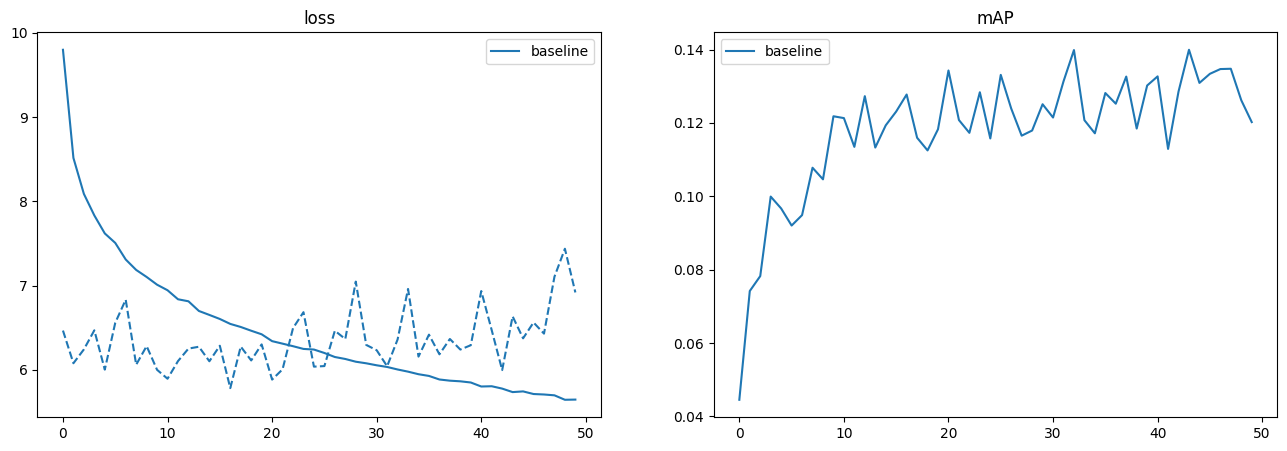

In [230]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com

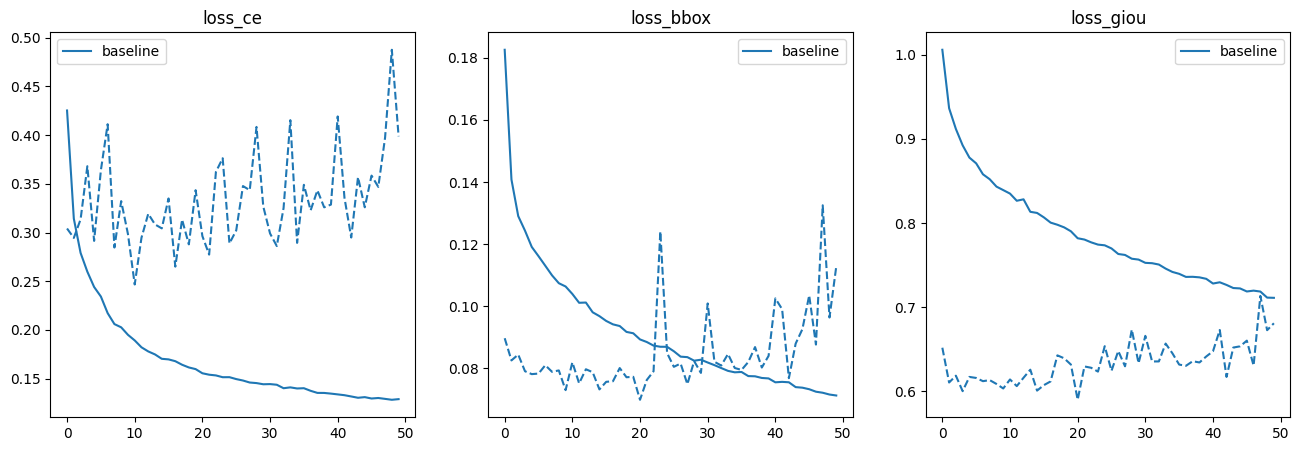

In [231]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


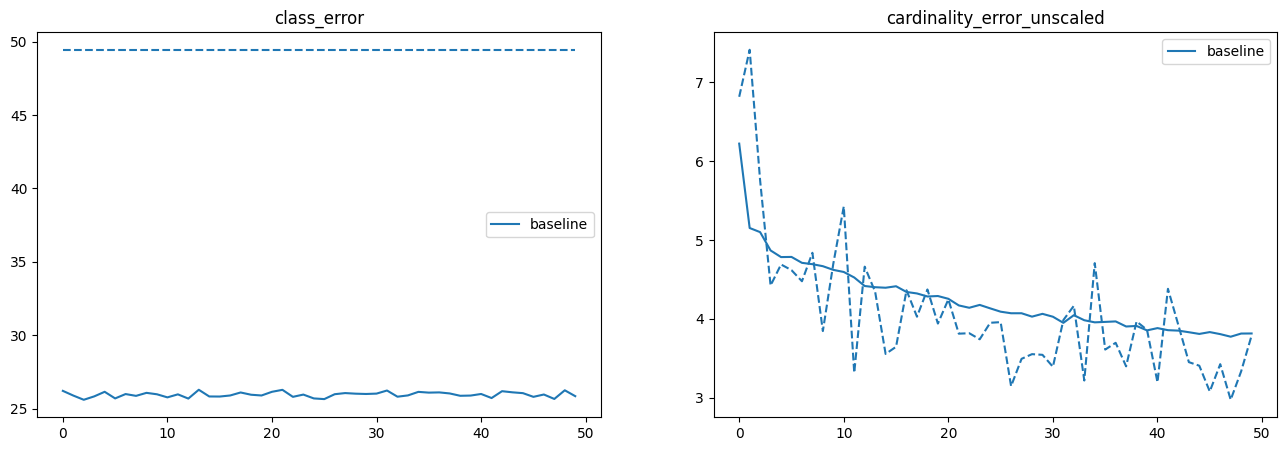

In [232]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

outputs/baseline/eval
[PosixPath('outputs/baseline/eval/000.pth'), PosixPath('outputs/baseline/eval/latest.pth')]
iter 000: mAP@50= 04.5, score=0.131, f1=0.070
iter latest: mAP@50= 12.0, score=0.169, f1=0.151


(<Figure size 1600x500 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Precision / Recall'}>,
        <AxesSubplot: title={'center': 'Scores / Recall'}>], dtype=object))

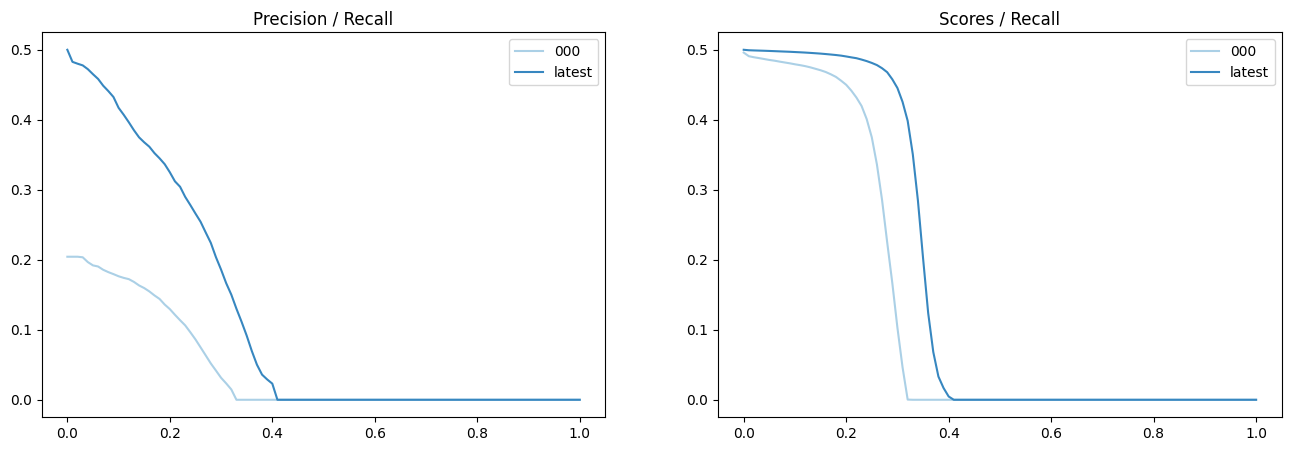

In [233]:
files = Path(outDir)/Path(experiment)/Path('eval')
print(files)
files = list(files.glob('*.pth'))
print(files)

plot_precision_recall(files)

In [234]:
experiment = 'pet_transforms'

log_directory = [Path(outDir)/Path(experiment)]

/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


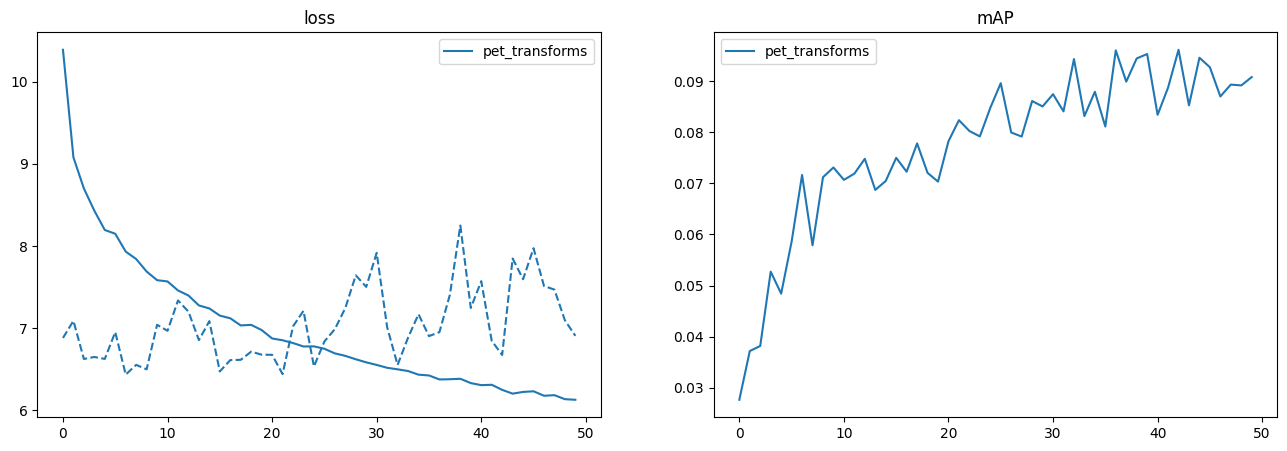

In [235]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com

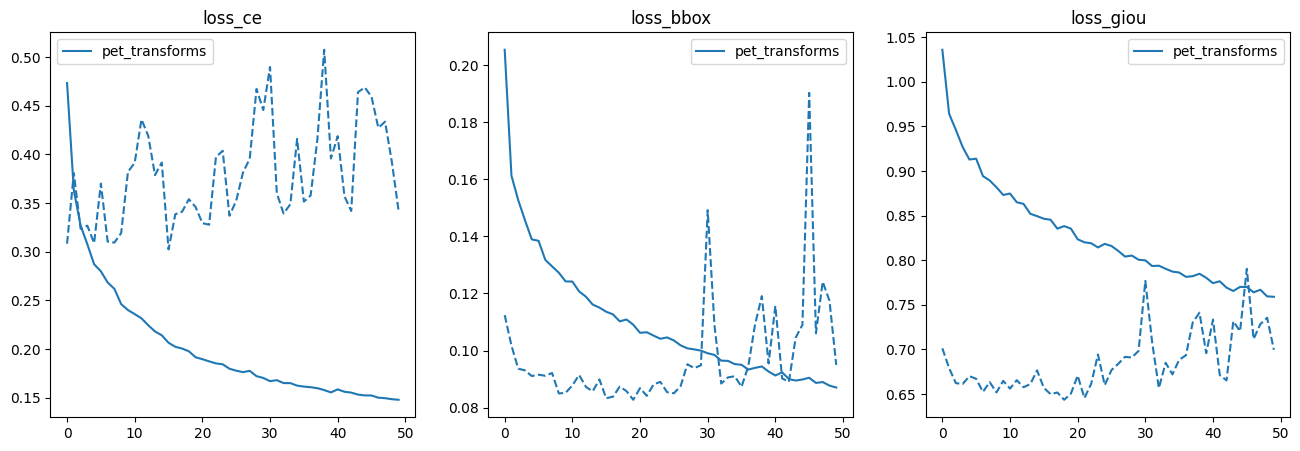

In [236]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


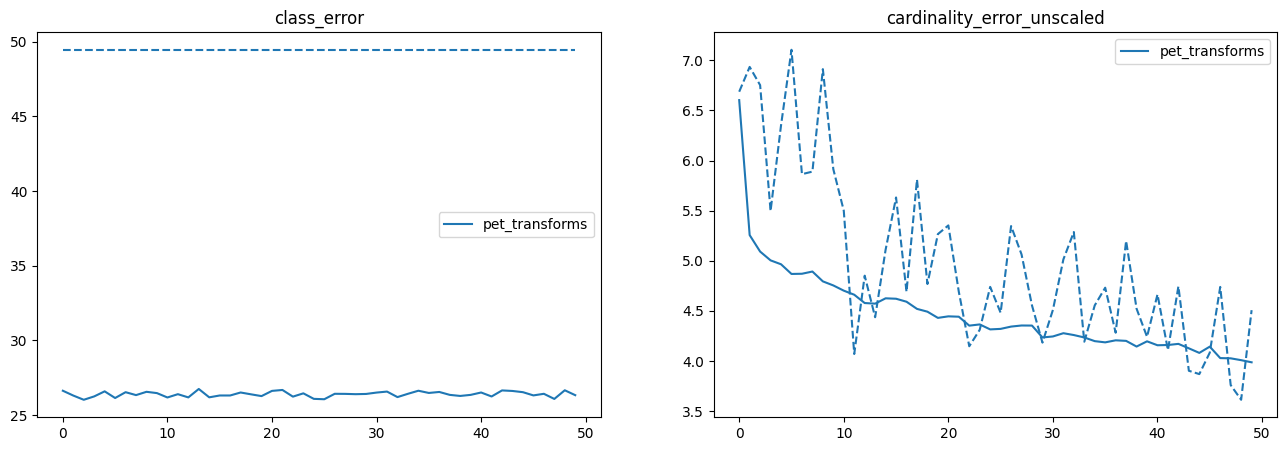

In [237]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

outputs/pet_transforms/eval
[PosixPath('outputs/pet_transforms/eval/000.pth'), PosixPath('outputs/pet_transforms/eval/latest.pth')]
iter 000: mAP@50= 02.8, score=0.090, f1=0.045
iter latest: mAP@50= 09.1, score=0.136, f1=0.118


(<Figure size 1600x500 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Precision / Recall'}>,
        <AxesSubplot: title={'center': 'Scores / Recall'}>], dtype=object))

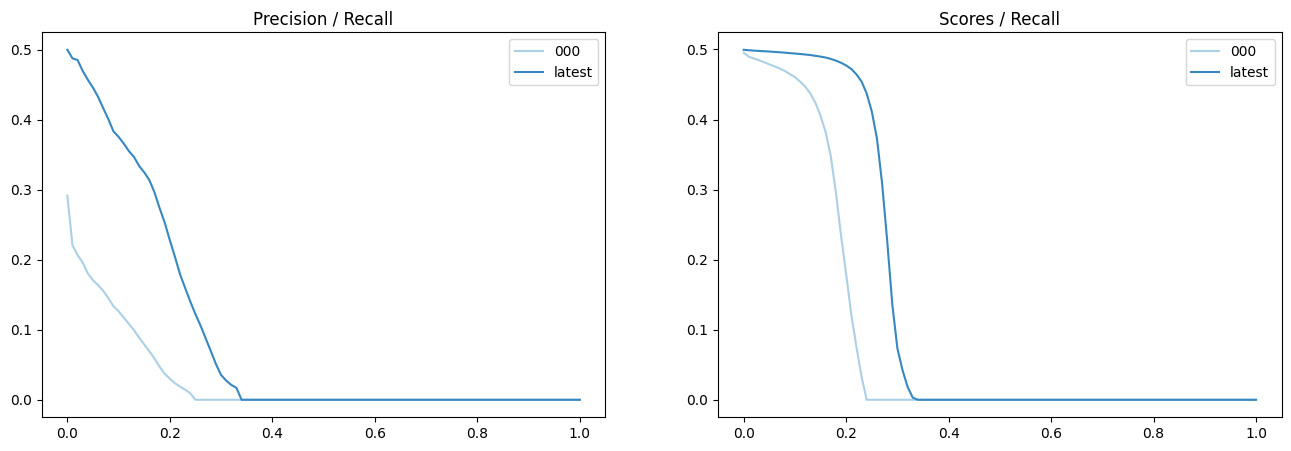

In [238]:
files = Path(outDir)/Path(experiment)/Path('eval')
print(files)
files = list(files.glob('*.pth'))
print(files)

plot_precision_recall(files)

## Evaluate with lower IoU thresholds

* I changed the threshold ranges in cocoeval_petct.COCOeval_PET, which is called by coco_eval.CocoEvaluator, which is called by engine.evaluate, which is called in main_petct.py

In [1]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path
import os

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler
import torchvision

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch, EarlyStopping
from models import build_model
from main_petct import get_args_parser
from util.plot_utils import plot_logs, plot_precision_recall

In [19]:
dataset_file = "coco_petct" 

# should lead to a directory with a train2017 and val2017 folder as well as an annotations folder
dataDir = '/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/'

# this int should be the actual number of classes + 1 (for no class)
num_classes = 2

experiment = 'baseline'

outDir = 'outputs/{}'.format(experiment)

# resume = 'outputs/{}/checkpoint.pth'.format(experiment)
resume = 'outputs/{}/early_stopping/checkpoint.pth'.format(experiment)

In [20]:
parser = argparse.ArgumentParser('DETR evaluation script', parents=[get_args_parser()])
#args = parser.parse_args()
args, unknown = parser.parse_known_args()

utils.init_distributed_mode(args)
print("git:\n  {}\n".format(utils.get_sha()))

args.dataset_file = dataset_file
args.coco_petct_path = dataDir
args.num_classes = num_classes
args.experiment = experiment 
args.output_dir = outDir
args.resume = resume # load check point weights

Not using distributed mode
git:
  sha: 1a63bf6ac0f28533bcbfa247780a8caeb134a81c, status: has uncommited changes, branch: master



In [24]:
# model = torch.hub.load('facebookresearch/detr',
#                        'detr_resnet50',
#                        pretrained=False,
#                        num_classes=num_classes)
# checkpoint = torch.load('outputs/{}/checkpoint.pth'.format(experiment),
#                         map_location='cpu')
# model.load_state_dict(checkpoint['model'],
#                       strict=False)

model, criterion, postprocessors = build_model(args)
print('This task include predicting: ', postprocessors.keys())

device = torch.device(args.device)
model.to(device)

checkpoint = torch.load(args.resume, map_location='cpu')
if 'model' in checkpoint:
    model.load_state_dict(checkpoint['model'], strict=False)
    epoch = checkpoint['epoch']
else:
    model.load_state_dict(checkpoint, strict=False)
    epoch = 'best'
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
model.eval();

Building a DETR model with 2 classes
This task include predicting:  dict_keys(['bbox'])


In [29]:
image_set = 'val'
image_set = 'test'

dataset_test = build_dataset(image_set=image_set, args=args)

if args.distributed:
    print('Distributed mode')
    sampler_test = DistributedSampler(dataset_test, shuffle=False)
else:
    print('Not distributed mode')
    sampler_test = torch.utils.data.SequentialSampler(dataset_test)

data_loader_test = DataLoader(dataset_test, args.batch_size, sampler=sampler_test,
                         drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

base_ds_test = get_coco_api_from_dataset(dataset_test)

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
Not distributed mode


In [30]:
test_stats, coco_evaluator = evaluate(model, criterion, postprocessors,
                                      data_loader_test, base_ds_test, device, args.output_dir)

Test:  [   0/2664]  eta: 0:14:43  class_error: 100.00  loss: 0.0000 (0.0000)  loss_ce: 0.0000 (0.0000)  loss_bbox: 0.0000 (0.0000)  loss_giou: 0.0000 (0.0000)  loss_ce_0: 0.0000 (0.0000)  loss_bbox_0: 0.0000 (0.0000)  loss_giou_0: 0.0000 (0.0000)  loss_ce_1: 0.0000 (0.0000)  loss_bbox_1: 0.0000 (0.0000)  loss_giou_1: 0.0000 (0.0000)  loss_ce_2: 0.0000 (0.0000)  loss_bbox_2: 0.0000 (0.0000)  loss_giou_2: 0.0000 (0.0000)  loss_ce_3: 0.0000 (0.0000)  loss_bbox_3: 0.0000 (0.0000)  loss_giou_3: 0.0000 (0.0000)  loss_ce_4: 0.0000 (0.0000)  loss_bbox_4: 0.0000 (0.0000)  loss_giou_4: 0.0000 (0.0000)  loss_ce_unscaled: 0.0000 (0.0000)  class_error_unscaled: 100.0000 (100.0000)  loss_bbox_unscaled: 0.0000 (0.0000)  loss_giou_unscaled: 0.0000 (0.0000)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0000 (0.0000)  loss_bbox_0_unscaled: 0.0000 (0.0000)  loss_giou_0_unscaled: 0.0000 (0.0000)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0000 (0.0000)  loss

Test:  [  50/2664]  eta: 0:04:15  class_error: 0.00  loss: 0.0000 (0.7872)  loss_ce: 0.0000 (0.0273)  loss_bbox: 0.0000 (0.0075)  loss_giou: 0.0000 (0.0919)  loss_ce_0: 0.0000 (0.0363)  loss_bbox_0: 0.0000 (0.0083)  loss_giou_0: 0.0000 (0.0946)  loss_ce_1: 0.0000 (0.0340)  loss_bbox_1: 0.0000 (0.0077)  loss_giou_1: 0.0000 (0.0891)  loss_ce_2: 0.0000 (0.0313)  loss_bbox_2: 0.0000 (0.0076)  loss_giou_2: 0.0000 (0.0930)  loss_ce_3: 0.0000 (0.0292)  loss_bbox_3: 0.0000 (0.0076)  loss_giou_3: 0.0000 (0.0929)  loss_ce_4: 0.0000 (0.0285)  loss_bbox_4: 0.0000 (0.0073)  loss_giou_4: 0.0000 (0.0932)  loss_ce_unscaled: 0.0000 (0.0273)  class_error_unscaled: 100.0000 (94.1176)  loss_bbox_unscaled: 0.0000 (0.0015)  loss_giou_unscaled: 0.0000 (0.0459)  cardinality_error_unscaled: 0.0000 (0.7843)  loss_ce_0_unscaled: 0.0000 (0.0363)  loss_bbox_0_unscaled: 0.0000 (0.0017)  loss_giou_0_unscaled: 0.0000 (0.0473)  cardinality_error_0_unscaled: 0.0000 (2.1667)  loss_ce_1_unscaled: 0.0000 (0.0340)  loss_bb

Test:  [ 100/2664]  eta: 0:04:55  class_error: 100.00  loss: 9.4296 (5.4492)  loss_ce: 0.3206 (0.1826)  loss_bbox: 0.0783 (0.0524)  loss_giou: 1.1059 (0.6376)  loss_ce_0: 0.4282 (0.2369)  loss_bbox_0: 0.0905 (0.0597)  loss_giou_0: 1.1663 (0.6829)  loss_ce_1: 0.4097 (0.2239)  loss_bbox_1: 0.0850 (0.0541)  loss_giou_1: 1.0961 (0.6417)  loss_ce_2: 0.3684 (0.2076)  loss_bbox_2: 0.0829 (0.0533)  loss_giou_2: 1.1036 (0.6498)  loss_ce_3: 0.3323 (0.1862)  loss_bbox_3: 0.0789 (0.0529)  loss_giou_3: 1.0925 (0.6435)  loss_ce_4: 0.3229 (0.1840)  loss_bbox_4: 0.0777 (0.0520)  loss_giou_4: 1.1163 (0.6480)  loss_ce_unscaled: 0.3206 (0.1826)  class_error_unscaled: 0.0000 (52.4752)  loss_bbox_unscaled: 0.0157 (0.0105)  loss_giou_unscaled: 0.5529 (0.3188)  cardinality_error_unscaled: 36.0000 (11.6485)  loss_ce_0_unscaled: 0.4282 (0.2369)  loss_bbox_0_unscaled: 0.0181 (0.0119)  loss_giou_0_unscaled: 0.5831 (0.3415)  cardinality_error_0_unscaled: 52.0000 (20.7475)  loss_ce_1_unscaled: 0.4097 (0.2239)  los

Test:  [ 150/2664]  eta: 0:04:30  class_error: 100.00  loss: 0.0000 (3.6951)  loss_ce: 0.0000 (0.1307)  loss_bbox: 0.0000 (0.0350)  loss_giou: 0.0000 (0.4265)  loss_ce_0: 0.0000 (0.1678)  loss_bbox_0: 0.0000 (0.0400)  loss_giou_0: 0.0000 (0.4568)  loss_ce_1: 0.0000 (0.1588)  loss_bbox_1: 0.0000 (0.0362)  loss_giou_1: 0.0000 (0.4292)  loss_ce_2: 0.0000 (0.1465)  loss_bbox_2: 0.0000 (0.0357)  loss_giou_2: 0.0000 (0.4347)  loss_ce_3: 0.0000 (0.1325)  loss_bbox_3: 0.0000 (0.0354)  loss_giou_3: 0.0000 (0.4304)  loss_ce_4: 0.0000 (0.1310)  loss_bbox_4: 0.0000 (0.0348)  loss_giou_4: 0.0000 (0.4334)  loss_ce_unscaled: 0.0000 (0.1307)  class_error_unscaled: 100.0000 (68.2119)  loss_bbox_unscaled: 0.0000 (0.0070)  loss_giou_unscaled: 0.0000 (0.2132)  cardinality_error_unscaled: 0.0000 (8.0298)  loss_ce_0_unscaled: 0.0000 (0.1678)  loss_bbox_0_unscaled: 0.0000 (0.0080)  loss_giou_0_unscaled: 0.0000 (0.2284)  cardinality_error_0_unscaled: 0.0000 (14.1887)  loss_ce_1_unscaled: 0.0000 (0.1588)  loss

Test:  [ 200/2664]  eta: 0:04:16  class_error: 0.00  loss: 0.0000 (4.4611)  loss_ce: 0.0000 (0.2856)  loss_bbox: 0.0000 (0.0395)  loss_giou: 0.0000 (0.3998)  loss_ce_0: 0.0000 (0.3284)  loss_bbox_0: 0.0000 (0.0405)  loss_giou_0: 0.0000 (0.4075)  loss_ce_1: 0.0000 (0.3213)  loss_bbox_1: 0.0000 (0.0389)  loss_giou_1: 0.0000 (0.3895)  loss_ce_2: 0.0000 (0.3104)  loss_bbox_2: 0.0000 (0.0401)  loss_giou_2: 0.0000 (0.4045)  loss_ce_3: 0.0000 (0.2902)  loss_bbox_3: 0.0000 (0.0383)  loss_giou_3: 0.0000 (0.3995)  loss_ce_4: 0.0000 (0.2882)  loss_bbox_4: 0.0000 (0.0378)  loss_giou_4: 0.0000 (0.4009)  loss_ce_unscaled: 0.0000 (0.2856)  class_error_unscaled: 100.0000 (71.6418)  loss_bbox_unscaled: 0.0000 (0.0079)  loss_giou_unscaled: 0.0000 (0.1999)  cardinality_error_unscaled: 0.0000 (6.2338)  loss_ce_0_unscaled: 0.0000 (0.3284)  loss_bbox_0_unscaled: 0.0000 (0.0081)  loss_giou_0_unscaled: 0.0000 (0.2038)  cardinality_error_0_unscaled: 0.0000 (10.8607)  loss_ce_1_unscaled: 0.0000 (0.3213)  loss_b

Test:  [ 250/2664]  eta: 0:04:13  class_error: 0.00  loss: 8.5336 (6.9091)  loss_ce: 0.2989 (0.5090)  loss_bbox: 0.1279 (0.0638)  loss_giou: 0.9903 (0.5517)  loss_ce_0: 0.4409 (0.5815)  loss_bbox_0: 0.1235 (0.0642)  loss_giou_0: 0.9497 (0.5505)  loss_ce_1: 0.3707 (0.5706)  loss_bbox_1: 0.1144 (0.0630)  loss_giou_1: 0.9289 (0.5282)  loss_ce_2: 0.3257 (0.5560)  loss_bbox_2: 0.1249 (0.0646)  loss_giou_2: 0.9435 (0.5522)  loss_ce_3: 0.3179 (0.5232)  loss_bbox_3: 0.1246 (0.0615)  loss_giou_3: 0.9763 (0.5460)  loss_ce_4: 0.2949 (0.5161)  loss_bbox_4: 0.1255 (0.0609)  loss_giou_4: 0.9379 (0.5461)  loss_ce_unscaled: 0.2989 (0.5090)  class_error_unscaled: 0.0000 (57.3705)  loss_bbox_unscaled: 0.0256 (0.0128)  loss_giou_unscaled: 0.4952 (0.2759)  cardinality_error_unscaled: 12.0000 (6.7450)  loss_ce_0_unscaled: 0.4409 (0.5815)  loss_bbox_0_unscaled: 0.0247 (0.0128)  loss_giou_0_unscaled: 0.4748 (0.2752)  cardinality_error_0_unscaled: 22.0000 (11.3685)  loss_ce_1_unscaled: 0.3707 (0.5706)  loss_b

Test:  [ 300/2664]  eta: 0:04:04  class_error: 100.00  loss: 0.0000 (6.1470)  loss_ce: 0.0000 (0.4410)  loss_bbox: 0.0000 (0.0585)  loss_giou: 0.0000 (0.5008)  loss_ce_0: 0.0000 (0.5055)  loss_bbox_0: 0.0000 (0.0596)  loss_giou_0: 0.0000 (0.5013)  loss_ce_1: 0.0000 (0.4947)  loss_bbox_1: 0.0000 (0.0579)  loss_giou_1: 0.0000 (0.4811)  loss_ce_2: 0.0000 (0.4815)  loss_bbox_2: 0.0000 (0.0591)  loss_giou_2: 0.0000 (0.5012)  loss_ce_3: 0.0000 (0.4526)  loss_bbox_3: 0.0000 (0.0567)  loss_giou_3: 0.0000 (0.4964)  loss_ce_4: 0.0000 (0.4468)  loss_bbox_4: 0.0000 (0.0561)  loss_giou_4: 0.0000 (0.4963)  loss_ce_unscaled: 0.0000 (0.4410)  class_error_unscaled: 100.0000 (60.1329)  loss_bbox_unscaled: 0.0000 (0.0117)  loss_giou_unscaled: 0.0000 (0.2504)  cardinality_error_unscaled: 0.0000 (6.7841)  loss_ce_0_unscaled: 0.0000 (0.5055)  loss_bbox_0_unscaled: 0.0000 (0.0119)  loss_giou_0_unscaled: 0.0000 (0.2506)  cardinality_error_0_unscaled: 0.0000 (11.2209)  loss_ce_1_unscaled: 0.0000 (0.4947)  loss

Test:  [ 350/2664]  eta: 0:03:57  class_error: 100.00  loss: 0.0002 (5.2812)  loss_ce: 0.0000 (0.3798)  loss_bbox: 0.0000 (0.0502)  loss_giou: 0.0000 (0.4295)  loss_ce_0: 0.0001 (0.4353)  loss_bbox_0: 0.0000 (0.0511)  loss_giou_0: 0.0000 (0.4299)  loss_ce_1: 0.0001 (0.4260)  loss_bbox_1: 0.0000 (0.0496)  loss_giou_1: 0.0000 (0.4126)  loss_ce_2: 0.0000 (0.4144)  loss_bbox_2: 0.0000 (0.0507)  loss_giou_2: 0.0000 (0.4298)  loss_ce_3: 0.0000 (0.3897)  loss_bbox_3: 0.0000 (0.0486)  loss_giou_3: 0.0000 (0.4257)  loss_ce_4: 0.0000 (0.3847)  loss_bbox_4: 0.0000 (0.0481)  loss_giou_4: 0.0000 (0.4256)  loss_ce_unscaled: 0.0000 (0.3798)  class_error_unscaled: 100.0000 (65.8120)  loss_bbox_unscaled: 0.0000 (0.0100)  loss_giou_unscaled: 0.0000 (0.2147)  cardinality_error_unscaled: 0.0000 (5.8675)  loss_ce_0_unscaled: 0.0001 (0.4353)  loss_bbox_0_unscaled: 0.0000 (0.0102)  loss_giou_0_unscaled: 0.0000 (0.2149)  cardinality_error_0_unscaled: 0.0000 (9.6510)  loss_ce_1_unscaled: 0.0001 (0.4260)  loss_

Test:  [ 400/2664]  eta: 0:03:48  class_error: 100.00  loss: 0.0000 (4.6265)  loss_ce: 0.0000 (0.3330)  loss_bbox: 0.0000 (0.0439)  loss_giou: 0.0000 (0.3759)  loss_ce_0: 0.0000 (0.3816)  loss_bbox_0: 0.0000 (0.0448)  loss_giou_0: 0.0000 (0.3763)  loss_ce_1: 0.0000 (0.3736)  loss_bbox_1: 0.0000 (0.0434)  loss_giou_1: 0.0000 (0.3611)  loss_ce_2: 0.0000 (0.3633)  loss_bbox_2: 0.0000 (0.0443)  loss_giou_2: 0.0000 (0.3762)  loss_ce_3: 0.0000 (0.3417)  loss_bbox_3: 0.0000 (0.0426)  loss_giou_3: 0.0000 (0.3726)  loss_ce_4: 0.0000 (0.3374)  loss_bbox_4: 0.0000 (0.0421)  loss_giou_4: 0.0000 (0.3725)  loss_ce_unscaled: 0.0000 (0.3330)  class_error_unscaled: 100.0000 (70.0748)  loss_bbox_unscaled: 0.0000 (0.0088)  loss_giou_unscaled: 0.0000 (0.1880)  cardinality_error_unscaled: 0.0000 (5.1521)  loss_ce_0_unscaled: 0.0000 (0.3816)  loss_bbox_0_unscaled: 0.0000 (0.0090)  loss_giou_0_unscaled: 0.0000 (0.1881)  cardinality_error_0_unscaled: 0.0000 (8.4589)  loss_ce_1_unscaled: 0.0000 (0.3736)  loss_

Test:  [ 450/2664]  eta: 0:03:41  class_error: 0.00  loss: 2.4900 (4.2195)  loss_ce: 0.0155 (0.2970)  loss_bbox: 0.0817 (0.0426)  loss_giou: 0.2408 (0.3458)  loss_ce_0: 0.0440 (0.3414)  loss_bbox_0: 0.1141 (0.0446)  loss_giou_0: 0.3264 (0.3491)  loss_ce_1: 0.0190 (0.3334)  loss_bbox_1: 0.1112 (0.0434)  loss_giou_1: 0.3627 (0.3359)  loss_ce_2: 0.0166 (0.3241)  loss_bbox_2: 0.0817 (0.0430)  loss_giou_2: 0.2469 (0.3462)  loss_ce_3: 0.0141 (0.3047)  loss_bbox_3: 0.0787 (0.0413)  loss_giou_3: 0.2354 (0.3422)  loss_ce_4: 0.0141 (0.3008)  loss_bbox_4: 0.0848 (0.0411)  loss_giou_4: 0.2522 (0.3428)  loss_ce_unscaled: 0.0155 (0.2970)  class_error_unscaled: 0.0000 (69.1796)  loss_bbox_unscaled: 0.0163 (0.0085)  loss_giou_unscaled: 0.1204 (0.1729)  cardinality_error_unscaled: 0.5000 (4.6131)  loss_ce_0_unscaled: 0.0440 (0.3414)  loss_bbox_0_unscaled: 0.0228 (0.0089)  loss_giou_0_unscaled: 0.1632 (0.1746)  cardinality_error_0_unscaled: 1.0000 (7.5887)  loss_ce_1_unscaled: 0.0190 (0.3334)  loss_bbox

Test:  [ 500/2664]  eta: 0:03:34  class_error: 100.00  loss: 0.0000 (3.8260)  loss_ce: 0.0000 (0.2683)  loss_bbox: 0.0000 (0.0390)  loss_giou: 0.0000 (0.3137)  loss_ce_0: 0.0000 (0.3087)  loss_bbox_0: 0.0000 (0.0414)  loss_giou_0: 0.0000 (0.3178)  loss_ce_1: 0.0000 (0.3013)  loss_bbox_1: 0.0000 (0.0402)  loss_giou_1: 0.0000 (0.3056)  loss_ce_2: 0.0000 (0.2927)  loss_bbox_2: 0.0000 (0.0395)  loss_giou_2: 0.0000 (0.3141)  loss_ce_3: 0.0000 (0.2752)  loss_bbox_3: 0.0000 (0.0378)  loss_giou_3: 0.0000 (0.3102)  loss_ce_4: 0.0000 (0.2717)  loss_bbox_4: 0.0000 (0.0377)  loss_giou_4: 0.0000 (0.3109)  loss_ce_unscaled: 0.0000 (0.2683)  class_error_unscaled: 100.0000 (71.2575)  loss_bbox_unscaled: 0.0000 (0.0078)  loss_giou_unscaled: 0.0000 (0.1568)  cardinality_error_unscaled: 0.0000 (4.1786)  loss_ce_0_unscaled: 0.0000 (0.3087)  loss_bbox_0_unscaled: 0.0000 (0.0083)  loss_giou_0_unscaled: 0.0000 (0.1589)  cardinality_error_0_unscaled: 0.0000 (6.8782)  loss_ce_1_unscaled: 0.0000 (0.3013)  loss_

Test:  [ 550/2664]  eta: 0:03:36  class_error: 100.00  loss: 0.4157 (4.0037)  loss_ce: 0.0659 (0.2591)  loss_bbox: 0.0000 (0.0453)  loss_giou: 0.0000 (0.3453)  loss_ce_0: 0.0809 (0.2972)  loss_bbox_0: 0.0000 (0.0491)  loss_giou_0: 0.0000 (0.3540)  loss_ce_1: 0.0708 (0.2903)  loss_bbox_1: 0.0000 (0.0470)  loss_giou_1: 0.0000 (0.3400)  loss_ce_2: 0.0678 (0.2816)  loss_bbox_2: 0.0000 (0.0460)  loss_giou_2: 0.0000 (0.3474)  loss_ce_3: 0.0637 (0.2651)  loss_bbox_3: 0.0000 (0.0443)  loss_giou_3: 0.0000 (0.3426)  loss_ce_4: 0.0620 (0.2619)  loss_bbox_4: 0.0000 (0.0441)  loss_giou_4: 0.0000 (0.3433)  loss_ce_unscaled: 0.0659 (0.2591)  class_error_unscaled: 100.0000 (69.5100)  loss_bbox_unscaled: 0.0000 (0.0091)  loss_giou_unscaled: 0.0000 (0.1727)  cardinality_error_unscaled: 1.5000 (5.3603)  loss_ce_0_unscaled: 0.0809 (0.2972)  loss_bbox_0_unscaled: 0.0000 (0.0098)  loss_giou_0_unscaled: 0.0000 (0.1770)  cardinality_error_0_unscaled: 1.5000 (8.3575)  loss_ce_1_unscaled: 0.0708 (0.2903)  loss_

Test:  [ 600/2664]  eta: 0:03:29  class_error: 0.00  loss: 0.6718 (3.7107)  loss_ce: 0.0967 (0.2420)  loss_bbox: 0.0000 (0.0416)  loss_giou: 0.0000 (0.3180)  loss_ce_0: 0.1254 (0.2783)  loss_bbox_0: 0.0000 (0.0452)  loss_giou_0: 0.0000 (0.3260)  loss_ce_1: 0.1269 (0.2719)  loss_bbox_1: 0.0000 (0.0433)  loss_giou_1: 0.0000 (0.3131)  loss_ce_2: 0.1321 (0.2639)  loss_bbox_2: 0.0000 (0.0424)  loss_giou_2: 0.0000 (0.3198)  loss_ce_3: 0.1034 (0.2475)  loss_bbox_3: 0.0000 (0.0408)  loss_giou_3: 0.0000 (0.3156)  loss_ce_4: 0.0939 (0.2447)  loss_bbox_4: 0.0000 (0.0406)  loss_giou_4: 0.0000 (0.3161)  loss_ce_unscaled: 0.0967 (0.2420)  class_error_unscaled: 100.0000 (71.8802)  loss_bbox_unscaled: 0.0000 (0.0083)  loss_giou_unscaled: 0.0000 (0.1590)  cardinality_error_unscaled: 3.5000 (5.0557)  loss_ce_0_unscaled: 0.1254 (0.2783)  loss_bbox_0_unscaled: 0.0000 (0.0090)  loss_giou_0_unscaled: 0.0000 (0.1630)  cardinality_error_0_unscaled: 4.5000 (7.9309)  loss_ce_1_unscaled: 0.1269 (0.2719)  loss_bb

Test:  [ 650/2664]  eta: 0:03:24  class_error: 0.00  loss: 9.8003 (4.2292)  loss_ce: 0.2396 (0.2561)  loss_bbox: 0.0887 (0.0549)  loss_giou: 1.1516 (0.3755)  loss_ce_0: 0.3051 (0.2949)  loss_bbox_0: 0.0938 (0.0576)  loss_giou_0: 1.1735 (0.3841)  loss_ce_1: 0.2914 (0.2867)  loss_bbox_1: 0.0962 (0.0565)  loss_giou_1: 1.4368 (0.3736)  loss_ce_2: 0.2637 (0.2778)  loss_bbox_2: 0.0918 (0.0562)  loss_giou_2: 1.3476 (0.3791)  loss_ce_3: 0.2467 (0.2602)  loss_bbox_3: 0.0929 (0.0542)  loss_giou_3: 1.2445 (0.3745)  loss_ce_4: 0.3088 (0.2582)  loss_bbox_4: 0.0904 (0.0540)  loss_giou_4: 1.1533 (0.3750)  loss_ce_unscaled: 0.2396 (0.2561)  class_error_unscaled: 0.0000 (66.3594)  loss_bbox_unscaled: 0.0177 (0.0110)  loss_giou_unscaled: 0.5758 (0.1878)  cardinality_error_unscaled: 1.0000 (4.9370)  loss_ce_0_unscaled: 0.3051 (0.2949)  loss_bbox_0_unscaled: 0.0188 (0.0115)  loss_giou_0_unscaled: 0.5867 (0.1920)  cardinality_error_0_unscaled: 2.0000 (7.8902)  loss_ce_1_unscaled: 0.2914 (0.2867)  loss_bbox

Test:  [ 700/2664]  eta: 0:03:18  class_error: 100.00  loss: 0.0000 (4.2654)  loss_ce: 0.0000 (0.2493)  loss_bbox: 0.0000 (0.0526)  loss_giou: 0.0000 (0.3906)  loss_ce_0: 0.0000 (0.2850)  loss_bbox_0: 0.0000 (0.0555)  loss_giou_0: 0.0000 (0.4038)  loss_ce_1: 0.0000 (0.2791)  loss_bbox_1: 0.0000 (0.0543)  loss_giou_1: 0.0000 (0.3896)  loss_ce_2: 0.0000 (0.2704)  loss_bbox_2: 0.0000 (0.0539)  loss_giou_2: 0.0000 (0.3933)  loss_ce_3: 0.0000 (0.2534)  loss_bbox_3: 0.0000 (0.0519)  loss_giou_3: 0.0000 (0.3900)  loss_ce_4: 0.0000 (0.2511)  loss_bbox_4: 0.0000 (0.0517)  loss_giou_4: 0.0000 (0.3899)  loss_ce_unscaled: 0.0000 (0.2493)  class_error_unscaled: 100.0000 (65.7632)  loss_bbox_unscaled: 0.0000 (0.0105)  loss_giou_unscaled: 0.0000 (0.1953)  cardinality_error_unscaled: 0.0000 (4.6355)  loss_ce_0_unscaled: 0.0000 (0.2850)  loss_bbox_0_unscaled: 0.0000 (0.0111)  loss_giou_0_unscaled: 0.0000 (0.2019)  cardinality_error_0_unscaled: 0.0000 (7.4522)  loss_ce_1_unscaled: 0.0000 (0.2791)  loss_

Test:  [ 750/2664]  eta: 0:03:12  class_error: 0.00  loss: 0.0000 (4.1120)  loss_ce: 0.0000 (0.2377)  loss_bbox: 0.0000 (0.0497)  loss_giou: 0.0000 (0.3803)  loss_ce_0: 0.0000 (0.2710)  loss_bbox_0: 0.0000 (0.0527)  loss_giou_0: 0.0000 (0.3940)  loss_ce_1: 0.0000 (0.2659)  loss_bbox_1: 0.0000 (0.0514)  loss_giou_1: 0.0000 (0.3789)  loss_ce_2: 0.0000 (0.2579)  loss_bbox_2: 0.0000 (0.0510)  loss_giou_2: 0.0000 (0.3826)  loss_ce_3: 0.0000 (0.2417)  loss_bbox_3: 0.0000 (0.0491)  loss_giou_3: 0.0000 (0.3797)  loss_ce_4: 0.0000 (0.2394)  loss_bbox_4: 0.0000 (0.0489)  loss_giou_4: 0.0000 (0.3803)  loss_ce_unscaled: 0.0000 (0.2377)  class_error_unscaled: 100.0000 (67.1105)  loss_bbox_unscaled: 0.0000 (0.0099)  loss_giou_unscaled: 0.0000 (0.1901)  cardinality_error_unscaled: 0.0000 (4.4161)  loss_ce_0_unscaled: 0.0000 (0.2710)  loss_bbox_0_unscaled: 0.0000 (0.0105)  loss_giou_0_unscaled: 0.0000 (0.1970)  cardinality_error_0_unscaled: 0.0000 (7.1112)  loss_ce_1_unscaled: 0.0000 (0.2659)  loss_bb

Test:  [ 800/2664]  eta: 0:03:08  class_error: 100.00  loss: 4.8765 (4.6622)  loss_ce: 0.5203 (0.2699)  loss_bbox: 0.0335 (0.0580)  loss_giou: 0.2194 (0.4318)  loss_ce_0: 0.4510 (0.3031)  loss_bbox_0: 0.0550 (0.0603)  loss_giou_0: 0.3078 (0.4433)  loss_ce_1: 0.5181 (0.2984)  loss_bbox_1: 0.0447 (0.0590)  loss_giou_1: 0.3597 (0.4253)  loss_ce_2: 0.5081 (0.2912)  loss_bbox_2: 0.0484 (0.0595)  loss_giou_2: 0.2978 (0.4342)  loss_ce_3: 0.4783 (0.2742)  loss_bbox_3: 0.0441 (0.0580)  loss_giou_3: 0.2955 (0.4335)  loss_ce_4: 0.4553 (0.2712)  loss_bbox_4: 0.0316 (0.0574)  loss_giou_4: 0.2078 (0.4339)  loss_ce_unscaled: 0.5203 (0.2699)  class_error_unscaled: 0.0000 (64.0449)  loss_bbox_unscaled: 0.0067 (0.0116)  loss_giou_unscaled: 0.1097 (0.2159)  cardinality_error_unscaled: 1.0000 (4.4526)  loss_ce_0_unscaled: 0.4510 (0.3031)  loss_bbox_0_unscaled: 0.0110 (0.0121)  loss_giou_0_unscaled: 0.1539 (0.2217)  cardinality_error_0_unscaled: 1.0000 (7.1773)  loss_ce_1_unscaled: 0.5181 (0.2984)  loss_bb

Test:  [ 850/2664]  eta: 0:03:06  class_error: 0.00  loss: 10.5523 (4.5862)  loss_ce: 0.0130 (0.2559)  loss_bbox: 0.2495 (0.0598)  loss_giou: 1.4784 (0.4320)  loss_ce_0: 0.0168 (0.2875)  loss_bbox_0: 0.2761 (0.0621)  loss_giou_0: 1.4973 (0.4432)  loss_ce_1: 0.0149 (0.2828)  loss_bbox_1: 0.2642 (0.0609)  loss_giou_1: 1.5008 (0.4263)  loss_ce_2: 0.0129 (0.2760)  loss_bbox_2: 0.2505 (0.0612)  loss_giou_2: 1.4967 (0.4345)  loss_ce_3: 0.0127 (0.2601)  loss_bbox_3: 0.2548 (0.0598)  loss_giou_3: 1.4739 (0.4336)  loss_ce_4: 0.0128 (0.2572)  loss_bbox_4: 0.2499 (0.0592)  loss_giou_4: 1.4771 (0.4340)  loss_ce_unscaled: 0.0130 (0.2559)  class_error_unscaled: 0.0000 (64.8649)  loss_bbox_unscaled: 0.0499 (0.0120)  loss_giou_unscaled: 0.7392 (0.2160)  cardinality_error_unscaled: 5.5000 (4.4847)  loss_ce_0_unscaled: 0.0168 (0.2875)  loss_bbox_0_unscaled: 0.0552 (0.0124)  loss_giou_0_unscaled: 0.7486 (0.2216)  cardinality_error_0_unscaled: 5.5000 (7.0341)  loss_ce_1_unscaled: 0.0149 (0.2828)  loss_bbo

Test:  [ 900/2664]  eta: 0:03:08  class_error: 0.00  loss: 9.5944 (5.0203)  loss_ce: 0.3747 (0.2642)  loss_bbox: 0.1461 (0.0687)  loss_giou: 1.1013 (0.4853)  loss_ce_0: 0.5036 (0.2984)  loss_bbox_0: 0.1651 (0.0718)  loss_giou_0: 1.0511 (0.4980)  loss_ce_1: 0.4558 (0.2921)  loss_bbox_1: 0.1588 (0.0703)  loss_giou_1: 1.0142 (0.4809)  loss_ce_2: 0.4192 (0.2853)  loss_bbox_2: 0.1514 (0.0703)  loss_giou_2: 1.0637 (0.4886)  loss_ce_3: 0.3851 (0.2687)  loss_bbox_3: 0.1549 (0.0689)  loss_giou_3: 1.0156 (0.4870)  loss_ce_4: 0.3765 (0.2656)  loss_bbox_4: 0.1466 (0.0682)  loss_giou_4: 1.0903 (0.4878)  loss_ce_unscaled: 0.3747 (0.2642)  class_error_unscaled: 0.0000 (61.2653)  loss_bbox_unscaled: 0.0292 (0.0137)  loss_giou_unscaled: 0.5507 (0.2427)  cardinality_error_unscaled: 13.0000 (5.0782)  loss_ce_0_unscaled: 0.5036 (0.2984)  loss_bbox_0_unscaled: 0.0330 (0.0144)  loss_giou_0_unscaled: 0.5255 (0.2490)  cardinality_error_0_unscaled: 30.5000 (8.0810)  loss_ce_1_unscaled: 0.4558 (0.2921)  loss_bb

Test:  [ 950/2664]  eta: 0:03:02  class_error: 0.00  loss: 16.9575 (5.5763)  loss_ce: 1.3971 (0.3175)  loss_bbox: 0.0877 (0.0744)  loss_giou: 1.1655 (0.5220)  loss_ce_0: 1.4749 (0.3538)  loss_bbox_0: 0.1093 (0.0758)  loss_giou_0: 1.0123 (0.5299)  loss_ce_1: 1.4392 (0.3471)  loss_bbox_1: 0.1104 (0.0753)  loss_giou_1: 1.0711 (0.5185)  loss_ce_2: 1.4752 (0.3399)  loss_bbox_2: 0.0851 (0.0755)  loss_giou_2: 1.0618 (0.5217)  loss_ce_3: 1.3724 (0.3211)  loss_bbox_3: 0.1035 (0.0738)  loss_giou_3: 1.0714 (0.5185)  loss_ce_4: 1.3808 (0.3189)  loss_bbox_4: 0.0804 (0.0728)  loss_giou_4: 1.1335 (0.5199)  loss_ce_unscaled: 1.3971 (0.3175)  class_error_unscaled: 0.0000 (58.0442)  loss_bbox_unscaled: 0.0175 (0.0149)  loss_giou_unscaled: 0.5828 (0.2610)  cardinality_error_unscaled: 4.0000 (5.1661)  loss_ce_0_unscaled: 1.4749 (0.3538)  loss_bbox_0_unscaled: 0.0219 (0.0152)  loss_giou_0_unscaled: 0.5062 (0.2649)  cardinality_error_0_unscaled: 4.0000 (8.2487)  loss_ce_1_unscaled: 1.4392 (0.3471)  loss_bbo

Test:  [1000/2664]  eta: 0:02:56  class_error: 100.00  loss: 0.0000 (5.5367)  loss_ce: 0.0000 (0.3158)  loss_bbox: 0.0000 (0.0726)  loss_giou: 0.0000 (0.5202)  loss_ce_0: 0.0000 (0.3521)  loss_bbox_0: 0.0000 (0.0741)  loss_giou_0: 0.0000 (0.5260)  loss_ce_1: 0.0000 (0.3448)  loss_bbox_1: 0.0000 (0.0734)  loss_giou_1: 0.0000 (0.5158)  loss_ce_2: 0.0000 (0.3375)  loss_bbox_2: 0.0000 (0.0736)  loss_giou_2: 0.0000 (0.5169)  loss_ce_3: 0.0000 (0.3190)  loss_bbox_3: 0.0000 (0.0720)  loss_giou_3: 0.0000 (0.5160)  loss_ce_4: 0.0000 (0.3171)  loss_bbox_4: 0.0000 (0.0711)  loss_giou_4: 0.0000 (0.5187)  loss_ce_unscaled: 0.0000 (0.3158)  class_error_unscaled: 100.0000 (56.8432)  loss_bbox_unscaled: 0.0000 (0.0145)  loss_giou_unscaled: 0.0000 (0.2601)  cardinality_error_unscaled: 0.0000 (5.0185)  loss_ce_0_unscaled: 0.0000 (0.3521)  loss_bbox_0_unscaled: 0.0000 (0.0148)  loss_giou_0_unscaled: 0.0000 (0.2630)  cardinality_error_0_unscaled: 0.0000 (7.9885)  loss_ce_1_unscaled: 0.0000 (0.3448)  loss_

Test:  [1050/2664]  eta: 0:02:50  class_error: 0.00  loss: 6.8539 (5.4815)  loss_ce: 0.0830 (0.3064)  loss_bbox: 0.0671 (0.0723)  loss_giou: 0.9114 (0.5212)  loss_ce_0: 0.1743 (0.3419)  loss_bbox_0: 0.0818 (0.0737)  loss_giou_0: 0.9366 (0.5262)  loss_ce_1: 0.1217 (0.3339)  loss_bbox_1: 0.0852 (0.0734)  loss_giou_1: 1.0757 (0.5178)  loss_ce_2: 0.1074 (0.3272)  loss_bbox_2: 0.0670 (0.0731)  loss_giou_2: 0.9197 (0.5179)  loss_ce_3: 0.0932 (0.3096)  loss_bbox_3: 0.0714 (0.0716)  loss_giou_3: 0.9269 (0.5172)  loss_ce_4: 0.0821 (0.3076)  loss_bbox_4: 0.0702 (0.0709)  loss_giou_4: 0.8985 (0.5196)  loss_ce_unscaled: 0.0830 (0.3064)  class_error_unscaled: 0.0000 (54.8049)  loss_bbox_unscaled: 0.0134 (0.0145)  loss_giou_unscaled: 0.4557 (0.2606)  cardinality_error_unscaled: 1.5000 (4.8587)  loss_ce_0_unscaled: 0.1743 (0.3419)  loss_bbox_0_unscaled: 0.0164 (0.0147)  loss_giou_0_unscaled: 0.4683 (0.2631)  cardinality_error_0_unscaled: 4.0000 (7.7412)  loss_ce_1_unscaled: 0.1217 (0.3339)  loss_bbox

Test:  [1100/2664]  eta: 0:02:45  class_error: 0.00  loss: 3.8796 (5.5168)  loss_ce: 0.0875 (0.3017)  loss_bbox: 0.1200 (0.0734)  loss_giou: 0.4166 (0.5307)  loss_ce_0: 0.1130 (0.3397)  loss_bbox_0: 0.1128 (0.0745)  loss_giou_0: 0.4504 (0.5333)  loss_ce_1: 0.0985 (0.3304)  loss_bbox_1: 0.1011 (0.0744)  loss_giou_1: 0.4202 (0.5274)  loss_ce_2: 0.0968 (0.3223)  loss_bbox_2: 0.1199 (0.0743)  loss_giou_2: 0.4072 (0.5270)  loss_ce_3: 0.0871 (0.3048)  loss_bbox_3: 0.1191 (0.0727)  loss_giou_3: 0.4052 (0.5263)  loss_ce_4: 0.0848 (0.3027)  loss_bbox_4: 0.1194 (0.0721)  loss_giou_4: 0.4117 (0.5291)  loss_ce_unscaled: 0.0875 (0.3017)  class_error_unscaled: 0.0000 (52.3161)  loss_bbox_unscaled: 0.0240 (0.0147)  loss_giou_unscaled: 0.2083 (0.2654)  cardinality_error_unscaled: 2.5000 (4.7343)  loss_ce_0_unscaled: 0.1130 (0.3397)  loss_bbox_0_unscaled: 0.0226 (0.0149)  loss_giou_0_unscaled: 0.2252 (0.2667)  cardinality_error_0_unscaled: 2.5000 (7.5990)  loss_ce_1_unscaled: 0.0985 (0.3304)  loss_bbox

Test:  [1150/2664]  eta: 0:02:39  class_error: 100.00  loss: 0.0000 (5.2842)  loss_ce: 0.0000 (0.2888)  loss_bbox: 0.0000 (0.0704)  loss_giou: 0.0000 (0.5085)  loss_ce_0: 0.0000 (0.3252)  loss_bbox_0: 0.0000 (0.0714)  loss_giou_0: 0.0000 (0.5110)  loss_ce_1: 0.0000 (0.3162)  loss_bbox_1: 0.0000 (0.0713)  loss_giou_1: 0.0000 (0.5052)  loss_ce_2: 0.0000 (0.3084)  loss_bbox_2: 0.0000 (0.0712)  loss_giou_2: 0.0000 (0.5049)  loss_ce_3: 0.0000 (0.2917)  loss_bbox_3: 0.0000 (0.0697)  loss_giou_3: 0.0000 (0.5043)  loss_ce_4: 0.0000 (0.2898)  loss_bbox_4: 0.0000 (0.0691)  loss_giou_4: 0.0000 (0.5069)  loss_ce_unscaled: 0.0000 (0.2888)  class_error_unscaled: 100.0000 (54.1268)  loss_bbox_unscaled: 0.0000 (0.0141)  loss_giou_unscaled: 0.0000 (0.2542)  cardinality_error_unscaled: 0.0000 (4.5343)  loss_ce_0_unscaled: 0.0000 (0.3252)  loss_bbox_0_unscaled: 0.0000 (0.0143)  loss_giou_0_unscaled: 0.0000 (0.2555)  cardinality_error_0_unscaled: 0.0000 (7.2728)  loss_ce_1_unscaled: 0.0000 (0.3162)  loss_

Test:  [1200/2664]  eta: 0:02:37  class_error: 100.00  loss: 14.1482 (5.5482)  loss_ce: 0.2708 (0.2902)  loss_bbox: 0.2325 (0.0754)  loss_giou: 1.7875 (0.5446)  loss_ce_0: 0.2739 (0.3272)  loss_bbox_0: 0.2534 (0.0775)  loss_giou_0: 1.9075 (0.5505)  loss_ce_1: 0.2632 (0.3176)  loss_bbox_1: 0.2423 (0.0771)  loss_giou_1: 1.8566 (0.5431)  loss_ce_2: 0.2746 (0.3097)  loss_bbox_2: 0.2280 (0.0766)  loss_giou_2: 1.8384 (0.5418)  loss_ce_3: 0.2838 (0.2930)  loss_bbox_3: 0.2365 (0.0751)  loss_giou_3: 1.7950 (0.5406)  loss_ce_4: 0.2710 (0.2908)  loss_bbox_4: 0.2386 (0.0743)  loss_giou_4: 1.7926 (0.5431)  loss_ce_unscaled: 0.2708 (0.2902)  class_error_unscaled: 0.0000 (52.0400)  loss_bbox_unscaled: 0.0465 (0.0151)  loss_giou_unscaled: 0.8938 (0.2723)  cardinality_error_unscaled: 35.5000 (5.2215)  loss_ce_0_unscaled: 0.2739 (0.3272)  loss_bbox_0_unscaled: 0.0507 (0.0155)  loss_giou_0_unscaled: 0.9538 (0.2753)  cardinality_error_0_unscaled: 41.0000 (8.1236)  loss_ce_1_unscaled: 0.2632 (0.3176)  loss

Test:  [1250/2664]  eta: 0:02:31  class_error: 0.00  loss: 4.7518 (5.4492)  loss_ce: 0.1038 (0.2810)  loss_bbox: 0.0644 (0.0747)  loss_giou: 0.5729 (0.5375)  loss_ce_0: 0.2436 (0.3196)  loss_bbox_0: 0.0639 (0.0767)  loss_giou_0: 0.6375 (0.5439)  loss_ce_1: 0.1735 (0.3088)  loss_bbox_1: 0.0664 (0.0763)  loss_giou_1: 0.6164 (0.5363)  loss_ce_2: 0.1220 (0.3003)  loss_bbox_2: 0.0613 (0.0758)  loss_giou_2: 0.6298 (0.5352)  loss_ce_3: 0.1123 (0.2838)  loss_bbox_3: 0.0620 (0.0743)  loss_giou_3: 0.5618 (0.5336)  loss_ce_4: 0.1030 (0.2815)  loss_bbox_4: 0.0634 (0.0736)  loss_giou_4: 0.5771 (0.5362)  loss_ce_unscaled: 0.1038 (0.2810)  class_error_unscaled: 0.0000 (51.7986)  loss_bbox_unscaled: 0.0129 (0.0149)  loss_giou_unscaled: 0.2864 (0.2688)  cardinality_error_unscaled: 3.5000 (5.1027)  loss_ce_0_unscaled: 0.2436 (0.3196)  loss_bbox_0_unscaled: 0.0128 (0.0153)  loss_giou_0_unscaled: 0.3187 (0.2720)  cardinality_error_0_unscaled: 12.0000 (8.0400)  loss_ce_1_unscaled: 0.1735 (0.3088)  loss_bbo

Test:  [1300/2664]  eta: 0:02:25  class_error: 0.00  loss: 0.0000 (5.4419)  loss_ce: 0.0000 (0.2725)  loss_bbox: 0.0000 (0.0787)  loss_giou: 0.0000 (0.5410)  loss_ce_0: 0.0000 (0.3107)  loss_bbox_0: 0.0000 (0.0808)  loss_giou_0: 0.0000 (0.5470)  loss_ce_1: 0.0000 (0.3000)  loss_bbox_1: 0.0000 (0.0804)  loss_giou_1: 0.0000 (0.5400)  loss_ce_2: 0.0000 (0.2914)  loss_bbox_2: 0.0000 (0.0798)  loss_giou_2: 0.0000 (0.5386)  loss_ce_3: 0.0000 (0.2752)  loss_bbox_3: 0.0000 (0.0784)  loss_giou_3: 0.0000 (0.5370)  loss_ce_4: 0.0000 (0.2730)  loss_bbox_4: 0.0000 (0.0778)  loss_giou_4: 0.0000 (0.5396)  loss_ce_unscaled: 0.0000 (0.2725)  class_error_unscaled: 100.0000 (51.6526)  loss_bbox_unscaled: 0.0000 (0.0157)  loss_giou_unscaled: 0.0000 (0.2705)  cardinality_error_unscaled: 0.0000 (4.9689)  loss_ce_0_unscaled: 0.0000 (0.3107)  loss_bbox_0_unscaled: 0.0000 (0.0162)  loss_giou_0_unscaled: 0.0000 (0.2735)  cardinality_error_0_unscaled: 0.0000 (7.8232)  loss_ce_1_unscaled: 0.0000 (0.3000)  loss_bb

Test:  [1350/2664]  eta: 0:02:21  class_error: 0.00  loss: 9.7838 (5.5569)  loss_ce: 0.2676 (0.2715)  loss_bbox: 0.1479 (0.0804)  loss_giou: 1.1317 (0.5574)  loss_ce_0: 0.3880 (0.3114)  loss_bbox_0: 0.1669 (0.0835)  loss_giou_0: 1.2337 (0.5668)  loss_ce_1: 0.3686 (0.2999)  loss_bbox_1: 0.1625 (0.0827)  loss_giou_1: 1.1768 (0.5587)  loss_ce_2: 0.3063 (0.2906)  loss_bbox_2: 0.1555 (0.0818)  loss_giou_2: 1.1416 (0.5566)  loss_ce_3: 0.2788 (0.2740)  loss_bbox_3: 0.1509 (0.0802)  loss_giou_3: 1.1284 (0.5538)  loss_ce_4: 0.2678 (0.2720)  loss_bbox_4: 0.1489 (0.0796)  loss_giou_4: 1.1316 (0.5561)  loss_ce_unscaled: 0.2676 (0.2715)  class_error_unscaled: 0.0000 (49.7409)  loss_bbox_unscaled: 0.0296 (0.0161)  loss_giou_unscaled: 0.5659 (0.2787)  cardinality_error_unscaled: 20.0000 (5.3494)  loss_ce_0_unscaled: 0.3880 (0.3114)  loss_bbox_0_unscaled: 0.0334 (0.0167)  loss_giou_0_unscaled: 0.6168 (0.2834)  cardinality_error_0_unscaled: 49.5000 (8.6928)  loss_ce_1_unscaled: 0.3686 (0.2999)  loss_bb

Test:  [1400/2664]  eta: 0:02:15  class_error: 100.00  loss: 11.3415 (5.7883)  loss_ce: 0.3258 (0.2863)  loss_bbox: 0.0573 (0.0835)  loss_giou: 1.2784 (0.5778)  loss_ce_0: 0.4850 (0.3267)  loss_bbox_0: 0.0606 (0.0871)  loss_giou_0: 1.2467 (0.5870)  loss_ce_1: 0.4095 (0.3154)  loss_bbox_1: 0.0620 (0.0862)  loss_giou_1: 1.2759 (0.5797)  loss_ce_2: 0.4365 (0.3054)  loss_bbox_2: 0.0572 (0.0851)  loss_giou_2: 1.3211 (0.5770)  loss_ce_3: 0.3119 (0.2882)  loss_bbox_3: 0.0577 (0.0833)  loss_giou_3: 1.2889 (0.5741)  loss_ce_4: 0.3148 (0.2868)  loss_bbox_4: 0.0590 (0.0827)  loss_giou_4: 1.2487 (0.5762)  loss_ce_unscaled: 0.3258 (0.2863)  class_error_unscaled: 0.0000 (48.6081)  loss_bbox_unscaled: 0.0115 (0.0167)  loss_giou_unscaled: 0.6392 (0.2889)  cardinality_error_unscaled: 3.0000 (5.3676)  loss_ce_0_unscaled: 0.4850 (0.3267)  loss_bbox_0_unscaled: 0.0121 (0.0174)  loss_giou_0_unscaled: 0.6234 (0.2935)  cardinality_error_0_unscaled: 3.5000 (8.6788)  loss_ce_1_unscaled: 0.4095 (0.3154)  loss_b

Test:  [1450/2664]  eta: 0:02:09  class_error: 100.00  loss: 0.0000 (5.5931)  loss_ce: 0.0000 (0.2771)  loss_bbox: 0.0000 (0.0806)  loss_giou: 0.0000 (0.5578)  loss_ce_0: 0.0000 (0.3161)  loss_bbox_0: 0.0000 (0.0841)  loss_giou_0: 0.0000 (0.5668)  loss_ce_1: 0.0000 (0.3052)  loss_bbox_1: 0.0000 (0.0832)  loss_giou_1: 0.0000 (0.5597)  loss_ce_2: 0.0000 (0.2957)  loss_bbox_2: 0.0000 (0.0821)  loss_giou_2: 0.0000 (0.5571)  loss_ce_3: 0.0000 (0.2790)  loss_bbox_3: 0.0000 (0.0805)  loss_giou_3: 0.0000 (0.5543)  loss_ce_4: 0.0000 (0.2776)  loss_bbox_4: 0.0000 (0.0798)  loss_giou_4: 0.0000 (0.5564)  loss_ce_unscaled: 0.0000 (0.2771)  class_error_unscaled: 100.0000 (50.3790)  loss_bbox_unscaled: 0.0000 (0.0161)  loss_giou_unscaled: 0.0000 (0.2789)  cardinality_error_unscaled: 0.0000 (5.2006)  loss_ce_0_unscaled: 0.0000 (0.3161)  loss_bbox_0_unscaled: 0.0000 (0.0168)  loss_giou_0_unscaled: 0.0000 (0.2834)  cardinality_error_0_unscaled: 0.0000 (8.3939)  loss_ce_1_unscaled: 0.0000 (0.3052)  loss_

Test:  [1500/2664]  eta: 0:02:04  class_error: 0.00  loss: 12.5840 (5.5232)  loss_ce: 0.3207 (0.2716)  loss_bbox: 0.1413 (0.0793)  loss_giou: 1.5254 (0.5534)  loss_ce_0: 0.4075 (0.3095)  loss_bbox_0: 0.1444 (0.0828)  loss_giou_0: 1.6145 (0.5624)  loss_ce_1: 0.3749 (0.2988)  loss_bbox_1: 0.1404 (0.0819)  loss_giou_1: 1.5488 (0.5551)  loss_ce_2: 0.3584 (0.2895)  loss_bbox_2: 0.1312 (0.0808)  loss_giou_2: 1.5850 (0.5529)  loss_ce_3: 0.3508 (0.2733)  loss_bbox_3: 0.1374 (0.0792)  loss_giou_3: 1.5556 (0.5500)  loss_ce_4: 0.3391 (0.2720)  loss_bbox_4: 0.1394 (0.0786)  loss_giou_4: 1.5670 (0.5522)  loss_ce_unscaled: 0.3207 (0.2716)  class_error_unscaled: 0.0000 (51.1659)  loss_bbox_unscaled: 0.0283 (0.0159)  loss_giou_unscaled: 0.7627 (0.2767)  cardinality_error_unscaled: 31.0000 (5.3421)  loss_ce_0_unscaled: 0.4075 (0.3095)  loss_bbox_0_unscaled: 0.0289 (0.0166)  loss_giou_0_unscaled: 0.8073 (0.2812)  cardinality_error_0_unscaled: 44.5000 (8.5343)  loss_ce_1_unscaled: 0.3749 (0.2988)  loss_b

Test:  [1550/2664]  eta: 0:01:59  class_error: 0.00  loss: 9.7565 (5.6279)  loss_ce: 0.4194 (0.2717)  loss_bbox: 0.0958 (0.0819)  loss_giou: 1.0149 (0.5667)  loss_ce_0: 0.5535 (0.3106)  loss_bbox_0: 0.1207 (0.0861)  loss_giou_0: 1.1028 (0.5782)  loss_ce_1: 0.4331 (0.2989)  loss_bbox_1: 0.1193 (0.0848)  loss_giou_1: 1.0451 (0.5697)  loss_ce_2: 0.4470 (0.2895)  loss_bbox_2: 0.1026 (0.0833)  loss_giou_2: 1.0217 (0.5666)  loss_ce_3: 0.4396 (0.2735)  loss_bbox_3: 0.1032 (0.0823)  loss_giou_3: 1.0813 (0.5646)  loss_ce_4: 0.4303 (0.2722)  loss_bbox_4: 0.0948 (0.0813)  loss_giou_4: 1.0262 (0.5659)  loss_ce_unscaled: 0.4194 (0.2717)  class_error_unscaled: 0.0000 (49.5164)  loss_bbox_unscaled: 0.0192 (0.0164)  loss_giou_unscaled: 0.5075 (0.2834)  cardinality_error_unscaled: 2.0000 (5.5045)  loss_ce_0_unscaled: 0.5535 (0.3106)  loss_bbox_0_unscaled: 0.0241 (0.0172)  loss_giou_0_unscaled: 0.5514 (0.2891)  cardinality_error_0_unscaled: 5.0000 (8.7579)  loss_ce_1_unscaled: 0.4331 (0.2989)  loss_bbox

Test:  [1600/2664]  eta: 0:01:53  class_error: 100.00  loss: 0.0000 (5.5326)  loss_ce: 0.0000 (0.2681)  loss_bbox: 0.0000 (0.0804)  loss_giou: 0.0000 (0.5562)  loss_ce_0: 0.0000 (0.3065)  loss_bbox_0: 0.0000 (0.0844)  loss_giou_0: 0.0000 (0.5679)  loss_ce_1: 0.0000 (0.2942)  loss_bbox_1: 0.0000 (0.0834)  loss_giou_1: 0.0000 (0.5598)  loss_ce_2: 0.0000 (0.2855)  loss_bbox_2: 0.0000 (0.0818)  loss_giou_2: 0.0000 (0.5563)  loss_ce_3: 0.0000 (0.2697)  loss_bbox_3: 0.0000 (0.0807)  loss_giou_3: 0.0000 (0.5539)  loss_ce_4: 0.0000 (0.2686)  loss_bbox_4: 0.0000 (0.0798)  loss_giou_4: 0.0000 (0.5554)  loss_ce_unscaled: 0.0000 (0.2681)  class_error_unscaled: 100.0000 (50.5309)  loss_bbox_unscaled: 0.0000 (0.0161)  loss_giou_unscaled: 0.0000 (0.2781)  cardinality_error_unscaled: 0.0000 (5.3976)  loss_ce_0_unscaled: 0.0000 (0.3065)  loss_bbox_0_unscaled: 0.0000 (0.0169)  loss_giou_0_unscaled: 0.0000 (0.2840)  cardinality_error_0_unscaled: 0.0000 (8.6199)  loss_ce_1_unscaled: 0.0000 (0.2942)  loss_

Test:  [1650/2664]  eta: 0:01:48  class_error: 0.00  loss: 9.8820 (5.7013)  loss_ce: 0.3421 (0.2725)  loss_bbox: 0.1717 (0.0814)  loss_giou: 1.0443 (0.5786)  loss_ce_0: 0.3898 (0.3088)  loss_bbox_0: 0.1928 (0.0858)  loss_giou_0: 1.1808 (0.5929)  loss_ce_1: 0.4145 (0.2988)  loss_bbox_1: 0.1815 (0.0846)  loss_giou_1: 1.0694 (0.5819)  loss_ce_2: 0.3992 (0.2902)  loss_bbox_2: 0.1725 (0.0829)  loss_giou_2: 1.0844 (0.5785)  loss_ce_3: 0.3225 (0.2744)  loss_bbox_3: 0.1655 (0.0818)  loss_giou_3: 1.0691 (0.5763)  loss_ce_4: 0.3703 (0.2734)  loss_bbox_4: 0.1581 (0.0807)  loss_giou_4: 1.0427 (0.5778)  loss_ce_unscaled: 0.3421 (0.2725)  class_error_unscaled: 0.0000 (49.4246)  loss_bbox_unscaled: 0.0343 (0.0163)  loss_giou_unscaled: 0.5221 (0.2893)  cardinality_error_unscaled: 3.5000 (5.4422)  loss_ce_0_unscaled: 0.3898 (0.3088)  loss_bbox_0_unscaled: 0.0386 (0.0172)  loss_giou_0_unscaled: 0.5904 (0.2965)  cardinality_error_0_unscaled: 8.5000 (8.7171)  loss_ce_1_unscaled: 0.4145 (0.2988)  loss_bbox

Test:  [1700/2664]  eta: 0:01:43  class_error: 0.00  loss: 7.6155 (5.7343)  loss_ce: 0.0807 (0.2684)  loss_bbox: 0.1101 (0.0822)  loss_giou: 0.9973 (0.5874)  loss_ce_0: 0.1516 (0.3058)  loss_bbox_0: 0.1143 (0.0865)  loss_giou_0: 0.9905 (0.6005)  loss_ce_1: 0.1216 (0.2953)  loss_bbox_1: 0.1130 (0.0854)  loss_giou_1: 1.0447 (0.5906)  loss_ce_2: 0.1164 (0.2863)  loss_bbox_2: 0.1156 (0.0837)  loss_giou_2: 1.0096 (0.5866)  loss_ce_3: 0.0889 (0.2703)  loss_bbox_3: 0.1207 (0.0827)  loss_giou_3: 1.0382 (0.5854)  loss_ce_4: 0.0801 (0.2692)  loss_bbox_4: 0.1166 (0.0816)  loss_giou_4: 1.0010 (0.5866)  loss_ce_unscaled: 0.0807 (0.2684)  class_error_unscaled: 0.0000 (47.9718)  loss_bbox_unscaled: 0.0220 (0.0164)  loss_giou_unscaled: 0.4986 (0.2937)  cardinality_error_unscaled: 1.0000 (5.3527)  loss_ce_0_unscaled: 0.1516 (0.3058)  loss_bbox_0_unscaled: 0.0229 (0.0173)  loss_giou_0_unscaled: 0.4952 (0.3002)  cardinality_error_0_unscaled: 2.0000 (8.6267)  loss_ce_1_unscaled: 0.1216 (0.2953)  loss_bbox

Test:  [1750/2664]  eta: 0:01:37  class_error: 0.00  loss: 2.8463 (5.6749)  loss_ce: 0.0667 (0.2630)  loss_bbox: 0.0617 (0.0814)  loss_giou: 0.3349 (0.5831)  loss_ce_0: 0.0659 (0.2999)  loss_bbox_0: 0.0609 (0.0858)  loss_giou_0: 0.3487 (0.5981)  loss_ce_1: 0.0651 (0.2892)  loss_bbox_1: 0.0533 (0.0845)  loss_giou_1: 0.3198 (0.5868)  loss_ce_2: 0.0656 (0.2807)  loss_bbox_2: 0.0589 (0.0829)  loss_giou_2: 0.3488 (0.5823)  loss_ce_3: 0.0664 (0.2650)  loss_bbox_3: 0.0603 (0.0819)  loss_giou_3: 0.3526 (0.5823)  loss_ce_4: 0.0656 (0.2638)  loss_bbox_4: 0.0659 (0.0808)  loss_giou_4: 0.3468 (0.5834)  loss_ce_unscaled: 0.0667 (0.2630)  class_error_unscaled: 0.0000 (46.6019)  loss_bbox_unscaled: 0.0123 (0.0163)  loss_giou_unscaled: 0.1674 (0.2915)  cardinality_error_unscaled: 1.5000 (5.2236)  loss_ce_0_unscaled: 0.0659 (0.2999)  loss_bbox_0_unscaled: 0.0122 (0.0172)  loss_giou_0_unscaled: 0.1744 (0.2991)  cardinality_error_0_unscaled: 0.5000 (8.4058)  loss_ce_1_unscaled: 0.0651 (0.2892)  loss_bbox

Test:  [1800/2664]  eta: 0:01:32  class_error: 100.00  loss: 10.0831 (5.8529)  loss_ce: 0.4594 (0.2721)  loss_bbox: 0.0854 (0.0822)  loss_giou: 1.0509 (0.6034)  loss_ce_0: 0.5013 (0.3070)  loss_bbox_0: 0.0884 (0.0875)  loss_giou_0: 1.1273 (0.6190)  loss_ce_1: 0.4627 (0.2974)  loss_bbox_1: 0.0911 (0.0858)  loss_giou_1: 1.1499 (0.6069)  loss_ce_2: 0.4693 (0.2892)  loss_bbox_2: 0.0884 (0.0838)  loss_giou_2: 1.0192 (0.6019)  loss_ce_3: 0.4678 (0.2738)  loss_bbox_3: 0.0789 (0.0827)  loss_giou_3: 0.9761 (0.6018)  loss_ce_4: 0.4746 (0.2727)  loss_bbox_4: 0.0807 (0.0816)  loss_giou_4: 1.0487 (0.6040)  loss_ce_unscaled: 0.4594 (0.2721)  class_error_unscaled: 0.0000 (45.3637)  loss_bbox_unscaled: 0.0171 (0.0164)  loss_giou_unscaled: 0.5255 (0.3017)  cardinality_error_unscaled: 1.5000 (5.1169)  loss_ce_0_unscaled: 0.5013 (0.3070)  loss_bbox_0_unscaled: 0.0177 (0.0175)  loss_giou_0_unscaled: 0.5636 (0.3095)  cardinality_error_0_unscaled: 1.0000 (8.2479)  loss_ce_1_unscaled: 0.4627 (0.2974)  loss_b

Test:  [1850/2664]  eta: 0:01:27  class_error: -0.00  loss: 9.0803 (5.8446)  loss_ce: 0.4146 (0.2705)  loss_bbox: 0.1212 (0.0823)  loss_giou: 1.0156 (0.6038)  loss_ce_0: 0.4117 (0.3048)  loss_bbox_0: 0.1318 (0.0876)  loss_giou_0: 1.1291 (0.6199)  loss_ce_1: 0.4017 (0.2951)  loss_bbox_1: 0.1285 (0.0859)  loss_giou_1: 1.0367 (0.6075)  loss_ce_2: 0.3779 (0.2871)  loss_bbox_2: 0.1124 (0.0839)  loss_giou_2: 0.9386 (0.6021)  loss_ce_3: 0.4130 (0.2721)  loss_bbox_3: 0.1162 (0.0828)  loss_giou_3: 0.9609 (0.6022)  loss_ce_4: 0.4160 (0.2711)  loss_bbox_4: 0.1160 (0.0817)  loss_giou_4: 1.0030 (0.6043)  loss_ce_unscaled: 0.4146 (0.2705)  class_error_unscaled: 0.0000 (45.3809)  loss_bbox_unscaled: 0.0242 (0.0165)  loss_giou_unscaled: 0.5078 (0.3019)  cardinality_error_unscaled: 1.0000 (5.0140)  loss_ce_0_unscaled: 0.4117 (0.3048)  loss_bbox_0_unscaled: 0.0264 (0.0175)  loss_giou_0_unscaled: 0.5646 (0.3100)  cardinality_error_0_unscaled: 1.5000 (8.0775)  loss_ce_1_unscaled: 0.4017 (0.2951)  loss_bbo

Test:  [1900/2664]  eta: 0:01:23  class_error: 100.00  loss: 0.0000 (5.8716)  loss_ce: 0.0000 (0.2649)  loss_bbox: 0.0000 (0.0844)  loss_giou: 0.0000 (0.6119)  loss_ce_0: 0.0000 (0.2986)  loss_bbox_0: 0.0000 (0.0896)  loss_giou_0: 0.0000 (0.6283)  loss_ce_1: 0.0000 (0.2888)  loss_bbox_1: 0.0000 (0.0880)  loss_giou_1: 0.0000 (0.6162)  loss_ce_2: 0.0000 (0.2809)  loss_bbox_2: 0.0000 (0.0859)  loss_giou_2: 0.0000 (0.6106)  loss_ce_3: 0.0000 (0.2664)  loss_bbox_3: 0.0000 (0.0850)  loss_giou_3: 0.0000 (0.6103)  loss_ce_4: 0.0000 (0.2655)  loss_bbox_4: 0.0000 (0.0839)  loss_giou_4: 0.0000 (0.6124)  loss_ce_unscaled: 0.0000 (0.2649)  class_error_unscaled: 100.0000 (45.7128)  loss_bbox_unscaled: 0.0000 (0.0169)  loss_giou_unscaled: 0.0000 (0.3060)  cardinality_error_unscaled: 0.0000 (5.0739)  loss_ce_0_unscaled: 0.0000 (0.2986)  loss_bbox_0_unscaled: 0.0000 (0.0179)  loss_giou_0_unscaled: 0.0000 (0.3142)  cardinality_error_0_unscaled: 0.0000 (8.0597)  loss_ce_1_unscaled: 0.0000 (0.2888)  loss_

Test:  [1950/2664]  eta: 0:01:17  class_error: 100.00  loss: 7.4632 (5.8373)  loss_ce: 0.2391 (0.2625)  loss_bbox: 0.0983 (0.0846)  loss_giou: 0.8904 (0.6088)  loss_ce_0: 0.3552 (0.2970)  loss_bbox_0: 0.1233 (0.0896)  loss_giou_0: 0.7961 (0.6242)  loss_ce_1: 0.3048 (0.2866)  loss_bbox_1: 0.0962 (0.0884)  loss_giou_1: 0.7995 (0.6118)  loss_ce_2: 0.2947 (0.2786)  loss_bbox_2: 0.1072 (0.0862)  loss_giou_2: 0.8293 (0.6067)  loss_ce_3: 0.2568 (0.2639)  loss_bbox_3: 0.1035 (0.0851)  loss_giou_3: 0.8441 (0.6068)  loss_ce_4: 0.2517 (0.2632)  loss_bbox_4: 0.0994 (0.0841)  loss_giou_4: 0.8714 (0.6092)  loss_ce_unscaled: 0.2391 (0.2625)  class_error_unscaled: 0.0000 (45.8739)  loss_bbox_unscaled: 0.0197 (0.0169)  loss_giou_unscaled: 0.4452 (0.3044)  cardinality_error_unscaled: 5.5000 (5.0210)  loss_ce_0_unscaled: 0.3552 (0.2970)  loss_bbox_0_unscaled: 0.0247 (0.0179)  loss_giou_0_unscaled: 0.3980 (0.3121)  cardinality_error_0_unscaled: 12.0000 (8.0554)  loss_ce_1_unscaled: 0.3048 (0.2866)  loss_b

Test:  [2000/2664]  eta: 0:01:11  class_error: 100.00  loss: 20.5795 (6.0333)  loss_ce: 1.3248 (0.2827)  loss_bbox: 0.1152 (0.0847)  loss_giou: 1.8127 (0.6232)  loss_ce_0: 1.2172 (0.3167)  loss_bbox_0: 0.1053 (0.0891)  loss_giou_0: 2.0179 (0.6370)  loss_ce_1: 1.3680 (0.3065)  loss_bbox_1: 0.1248 (0.0881)  loss_giou_1: 1.6440 (0.6228)  loss_ce_2: 1.4128 (0.2991)  loss_bbox_2: 0.1249 (0.0866)  loss_giou_2: 1.7165 (0.6173)  loss_ce_3: 1.3061 (0.2832)  loss_bbox_3: 0.0967 (0.0847)  loss_giou_3: 1.9909 (0.6209)  loss_ce_4: 1.3461 (0.2831)  loss_bbox_4: 0.1131 (0.0839)  loss_giou_4: 1.9471 (0.6236)  loss_ce_unscaled: 1.3248 (0.2827)  class_error_unscaled: 0.0000 (46.0270)  loss_bbox_unscaled: 0.0230 (0.0169)  loss_giou_unscaled: 0.9063 (0.3116)  cardinality_error_unscaled: 2.0000 (4.9785)  loss_ce_0_unscaled: 1.2172 (0.3167)  loss_bbox_0_unscaled: 0.0211 (0.0178)  loss_giou_0_unscaled: 1.0089 (0.3185)  cardinality_error_0_unscaled: 2.0000 (7.9685)  loss_ce_1_unscaled: 1.3680 (0.3065)  loss_b

Test:  [2050/2664]  eta: 0:01:06  class_error: 0.00  loss: 8.6216 (5.9421)  loss_ce: 0.2457 (0.2776)  loss_bbox: 0.0530 (0.0831)  loss_giou: 0.9941 (0.6144)  loss_ce_0: 0.3782 (0.3114)  loss_bbox_0: 0.0736 (0.0875)  loss_giou_0: 1.2025 (0.6291)  loss_ce_1: 0.3421 (0.3014)  loss_bbox_1: 0.0597 (0.0865)  loss_giou_1: 1.0693 (0.6144)  loss_ce_2: 0.3106 (0.2939)  loss_bbox_2: 0.0556 (0.0850)  loss_giou_2: 1.0322 (0.6088)  loss_ce_3: 0.2785 (0.2782)  loss_bbox_3: 0.0551 (0.0831)  loss_giou_3: 1.0152 (0.6123)  loss_ce_4: 0.2515 (0.2780)  loss_bbox_4: 0.0543 (0.0824)  loss_giou_4: 1.0182 (0.6149)  loss_ce_unscaled: 0.2457 (0.2776)  class_error_unscaled: 0.0000 (46.8064)  loss_bbox_unscaled: 0.0106 (0.0166)  loss_giou_unscaled: 0.4971 (0.3072)  cardinality_error_unscaled: 30.5000 (5.0646)  loss_ce_0_unscaled: 0.3782 (0.3114)  loss_bbox_0_unscaled: 0.0147 (0.0175)  loss_giou_0_unscaled: 0.6012 (0.3145)  cardinality_error_0_unscaled: 51.5000 (8.0834)  loss_ce_1_unscaled: 0.3421 (0.3014)  loss_bb

Test:  [2100/2664]  eta: 0:01:01  class_error: 100.00  loss: 0.0000 (6.0412)  loss_ce: 0.0000 (0.2782)  loss_bbox: 0.0000 (0.0855)  loss_giou: 0.0000 (0.6267)  loss_ce_0: 0.0000 (0.3149)  loss_bbox_0: 0.0000 (0.0894)  loss_giou_0: 0.0000 (0.6424)  loss_ce_1: 0.0000 (0.3033)  loss_bbox_1: 0.0000 (0.0889)  loss_giou_1: 0.0000 (0.6274)  loss_ce_2: 0.0000 (0.2951)  loss_bbox_2: 0.0000 (0.0874)  loss_giou_2: 0.0000 (0.6214)  loss_ce_3: 0.0000 (0.2795)  loss_bbox_3: 0.0000 (0.0855)  loss_giou_3: 0.0000 (0.6246)  loss_ce_4: 0.0000 (0.2788)  loss_bbox_4: 0.0000 (0.0848)  loss_giou_4: 0.0000 (0.6275)  loss_ce_unscaled: 0.0000 (0.2782)  class_error_unscaled: 100.0000 (46.3113)  loss_bbox_unscaled: 0.0000 (0.0171)  loss_giou_unscaled: 0.0000 (0.3133)  cardinality_error_unscaled: 0.0000 (5.2401)  loss_ce_0_unscaled: 0.0000 (0.3149)  loss_bbox_0_unscaled: 0.0000 (0.0179)  loss_giou_0_unscaled: 0.0000 (0.3212)  cardinality_error_0_unscaled: 0.0000 (8.2918)  loss_ce_1_unscaled: 0.0000 (0.3033)  loss_

Test:  [2150/2664]  eta: 0:00:55  class_error: 100.00  loss: 0.9443 (5.9096)  loss_ce: 0.1585 (0.2731)  loss_bbox: 0.0000 (0.0836)  loss_giou: 0.0000 (0.6121)  loss_ce_0: 0.1529 (0.3092)  loss_bbox_0: 0.0000 (0.0873)  loss_giou_0: 0.0000 (0.6274)  loss_ce_1: 0.1781 (0.2979)  loss_bbox_1: 0.0000 (0.0868)  loss_giou_1: 0.0000 (0.6128)  loss_ce_2: 0.1448 (0.2896)  loss_bbox_2: 0.0000 (0.0854)  loss_giou_2: 0.0000 (0.6069)  loss_ce_3: 0.1553 (0.2744)  loss_bbox_3: 0.0000 (0.0836)  loss_giou_3: 0.0000 (0.6101)  loss_ce_4: 0.1498 (0.2737)  loss_bbox_4: 0.0000 (0.0828)  loss_giou_4: 0.0000 (0.6129)  loss_ce_unscaled: 0.1585 (0.2731)  class_error_unscaled: 100.0000 (47.5593)  loss_bbox_unscaled: 0.0000 (0.0167)  loss_giou_unscaled: 0.0000 (0.3061)  cardinality_error_unscaled: 5.0000 (5.1641)  loss_ce_0_unscaled: 0.1529 (0.3092)  loss_bbox_0_unscaled: 0.0000 (0.0175)  loss_giou_0_unscaled: 0.0000 (0.3137)  cardinality_error_0_unscaled: 4.0000 (8.1599)  loss_ce_1_unscaled: 0.1781 (0.2979)  loss_

Test:  [2200/2664]  eta: 0:00:49  class_error: 100.00  loss: 0.0000 (5.7809)  loss_ce: 0.0000 (0.2678)  loss_bbox: 0.0000 (0.0817)  loss_giou: 0.0000 (0.5982)  loss_ce_0: 0.0000 (0.3032)  loss_bbox_0: 0.0000 (0.0853)  loss_giou_0: 0.0000 (0.6132)  loss_ce_1: 0.0000 (0.2921)  loss_bbox_1: 0.0000 (0.0849)  loss_giou_1: 0.0000 (0.5989)  loss_ce_2: 0.0000 (0.2839)  loss_bbox_2: 0.0000 (0.0835)  loss_giou_2: 0.0000 (0.5931)  loss_ce_3: 0.0000 (0.2690)  loss_bbox_3: 0.0000 (0.0817)  loss_giou_3: 0.0000 (0.5962)  loss_ce_4: 0.0000 (0.2683)  loss_bbox_4: 0.0000 (0.0809)  loss_giou_4: 0.0000 (0.5990)  loss_ce_unscaled: 0.0000 (0.2678)  class_error_unscaled: 100.0000 (48.7506)  loss_bbox_unscaled: 0.0000 (0.0163)  loss_giou_unscaled: 0.0000 (0.2991)  cardinality_error_unscaled: 0.0000 (5.0729)  loss_ce_0_unscaled: 0.0000 (0.3032)  loss_bbox_0_unscaled: 0.0000 (0.0171)  loss_giou_0_unscaled: 0.0000 (0.3066)  cardinality_error_0_unscaled: 0.0000 (8.0095)  loss_ce_1_unscaled: 0.0000 (0.2921)  loss_

Test:  [2250/2664]  eta: 0:00:44  class_error: 100.00  loss: 0.0000 (5.6525)  loss_ce: 0.0000 (0.2619)  loss_bbox: 0.0000 (0.0798)  loss_giou: 0.0000 (0.5849)  loss_ce_0: 0.0000 (0.2965)  loss_bbox_0: 0.0000 (0.0834)  loss_giou_0: 0.0000 (0.5996)  loss_ce_1: 0.0000 (0.2857)  loss_bbox_1: 0.0000 (0.0830)  loss_giou_1: 0.0000 (0.5856)  loss_ce_2: 0.0000 (0.2776)  loss_bbox_2: 0.0000 (0.0816)  loss_giou_2: 0.0000 (0.5800)  loss_ce_3: 0.0000 (0.2630)  loss_bbox_3: 0.0000 (0.0798)  loss_giou_3: 0.0000 (0.5830)  loss_ce_4: 0.0000 (0.2624)  loss_bbox_4: 0.0000 (0.0791)  loss_giou_4: 0.0000 (0.5857)  loss_ce_unscaled: 0.0000 (0.2619)  class_error_unscaled: 100.0000 (49.8889)  loss_bbox_unscaled: 0.0000 (0.0160)  loss_giou_unscaled: 0.0000 (0.2925)  cardinality_error_unscaled: 0.0000 (4.9605)  loss_ce_0_unscaled: 0.0000 (0.2965)  loss_bbox_0_unscaled: 0.0000 (0.0167)  loss_giou_0_unscaled: 0.0000 (0.2998)  cardinality_error_0_unscaled: 0.0000 (7.8321)  loss_ce_1_unscaled: 0.0000 (0.2857)  loss_

Test:  [2300/2664]  eta: 0:00:38  class_error: 0.00  loss: 8.1068 (5.6033)  loss_ce: 0.3796 (0.2598)  loss_bbox: 0.0904 (0.0790)  loss_giou: 0.8195 (0.5796)  loss_ce_0: 0.5289 (0.2949)  loss_bbox_0: 0.0970 (0.0825)  loss_giou_0: 0.7892 (0.5940)  loss_ce_1: 0.5213 (0.2842)  loss_bbox_1: 0.0935 (0.0820)  loss_giou_1: 0.7663 (0.5800)  loss_ce_2: 0.4307 (0.2755)  loss_bbox_2: 0.0916 (0.0808)  loss_giou_2: 0.7889 (0.5747)  loss_ce_3: 0.3893 (0.2608)  loss_bbox_3: 0.0910 (0.0790)  loss_giou_3: 0.7926 (0.5776)  loss_ce_4: 0.3955 (0.2602)  loss_bbox_4: 0.0920 (0.0783)  loss_giou_4: 0.8139 (0.5803)  loss_ce_unscaled: 0.3796 (0.2598)  class_error_unscaled: 0.0000 (50.0652)  loss_bbox_unscaled: 0.0181 (0.0158)  loss_giou_unscaled: 0.4098 (0.2898)  cardinality_error_unscaled: 19.0000 (5.0337)  loss_ce_0_unscaled: 0.5289 (0.2949)  loss_bbox_0_unscaled: 0.0194 (0.0165)  loss_giou_0_unscaled: 0.3946 (0.2970)  cardinality_error_0_unscaled: 39.5000 (8.0267)  loss_ce_1_unscaled: 0.5213 (0.2842)  loss_bb

Test:  [2350/2664]  eta: 0:00:33  class_error: 100.00  loss: 0.0000 (5.5448)  loss_ce: 0.0000 (0.2553)  loss_bbox: 0.0000 (0.0783)  loss_giou: 0.0000 (0.5753)  loss_ce_0: 0.0000 (0.2905)  loss_bbox_0: 0.0000 (0.0817)  loss_giou_0: 0.0000 (0.5892)  loss_ce_1: 0.0000 (0.2799)  loss_bbox_1: 0.0000 (0.0812)  loss_giou_1: 0.0000 (0.5754)  loss_ce_2: 0.0000 (0.2709)  loss_bbox_2: 0.0000 (0.0800)  loss_giou_2: 0.0000 (0.5701)  loss_ce_3: 0.0000 (0.2566)  loss_bbox_3: 0.0000 (0.0782)  loss_giou_3: 0.0000 (0.5729)  loss_ce_4: 0.0000 (0.2558)  loss_bbox_4: 0.0000 (0.0776)  loss_giou_4: 0.0000 (0.5759)  loss_ce_unscaled: 0.0000 (0.2553)  class_error_unscaled: 100.0000 (49.9787)  loss_bbox_unscaled: 0.0000 (0.0157)  loss_giou_unscaled: 0.0000 (0.2876)  cardinality_error_unscaled: 0.0000 (4.9534)  loss_ce_0_unscaled: 0.0000 (0.2905)  loss_bbox_0_unscaled: 0.0000 (0.0163)  loss_giou_0_unscaled: 0.0000 (0.2946)  cardinality_error_0_unscaled: 0.0000 (7.9275)  loss_ce_1_unscaled: 0.0000 (0.2799)  loss_

Test:  [2400/2664]  eta: 0:00:28  class_error: 0.00  loss: 14.5701 (5.7072)  loss_ce: 1.2803 (0.2724)  loss_bbox: 0.0976 (0.0789)  loss_giou: 0.9828 (0.5848)  loss_ce_0: 1.4121 (0.3080)  loss_bbox_0: 0.0805 (0.0824)  loss_giou_0: 0.9736 (0.6001)  loss_ce_1: 1.4035 (0.2973)  loss_bbox_1: 0.0892 (0.0816)  loss_giou_1: 0.8944 (0.5839)  loss_ce_2: 1.4060 (0.2886)  loss_bbox_2: 0.1111 (0.0805)  loss_giou_2: 1.1231 (0.5795)  loss_ce_3: 1.3077 (0.2736)  loss_bbox_3: 0.0853 (0.0788)  loss_giou_3: 0.8723 (0.5818)  loss_ce_4: 1.2998 (0.2731)  loss_bbox_4: 0.0765 (0.0781)  loss_giou_4: 0.7847 (0.5840)  loss_ce_unscaled: 1.2803 (0.2724)  class_error_unscaled: 0.0000 (48.9796)  loss_bbox_unscaled: 0.0195 (0.0158)  loss_giou_unscaled: 0.4914 (0.2924)  cardinality_error_unscaled: 1.0000 (4.8773)  loss_ce_0_unscaled: 1.4121 (0.3080)  loss_bbox_0_unscaled: 0.0161 (0.0165)  loss_giou_0_unscaled: 0.4868 (0.3000)  cardinality_error_0_unscaled: 1.0000 (7.7859)  loss_ce_1_unscaled: 1.4035 (0.2973)  loss_bbo

Test:  [2450/2664]  eta: 0:00:22  class_error: 0.00  loss: 0.0000 (5.7214)  loss_ce: 0.0000 (0.2773)  loss_bbox: 0.0000 (0.0787)  loss_giou: 0.0000 (0.5839)  loss_ce_0: 0.0000 (0.3133)  loss_bbox_0: 0.0000 (0.0818)  loss_giou_0: 0.0000 (0.5974)  loss_ce_1: 0.0000 (0.3028)  loss_bbox_1: 0.0000 (0.0809)  loss_giou_1: 0.0000 (0.5805)  loss_ce_2: 0.0000 (0.2941)  loss_bbox_2: 0.0000 (0.0800)  loss_giou_2: 0.0000 (0.5770)  loss_ce_3: 0.0000 (0.2789)  loss_bbox_3: 0.0000 (0.0783)  loss_giou_3: 0.0000 (0.5793)  loss_ce_4: 0.0000 (0.2783)  loss_bbox_4: 0.0000 (0.0776)  loss_giou_4: 0.0000 (0.5813)  loss_ce_unscaled: 0.0000 (0.2773)  class_error_unscaled: 100.0000 (48.9596)  loss_bbox_unscaled: 0.0000 (0.0157)  loss_giou_unscaled: 0.0000 (0.2919)  cardinality_error_unscaled: 0.0000 (4.7995)  loss_ce_0_unscaled: 0.0000 (0.3133)  loss_bbox_0_unscaled: 0.0000 (0.0164)  loss_giou_0_unscaled: 0.0000 (0.2987)  cardinality_error_0_unscaled: 0.0000 (7.6608)  loss_ce_1_unscaled: 0.0000 (0.3028)  loss_bb

Test:  [2500/2664]  eta: 0:00:17  class_error: 100.00  loss: 8.7113 (5.8080)  loss_ce: 0.3417 (0.2818)  loss_bbox: 0.0568 (0.0789)  loss_giou: 0.9867 (0.5941)  loss_ce_0: 0.4639 (0.3177)  loss_bbox_0: 0.0517 (0.0820)  loss_giou_0: 0.9284 (0.6068)  loss_ce_1: 0.3643 (0.3066)  loss_bbox_1: 0.0589 (0.0811)  loss_giou_1: 0.9140 (0.5904)  loss_ce_2: 0.3806 (0.2982)  loss_bbox_2: 0.0574 (0.0802)  loss_giou_2: 0.9660 (0.5869)  loss_ce_3: 0.3416 (0.2830)  loss_bbox_3: 0.0557 (0.0786)  loss_giou_3: 0.9567 (0.5896)  loss_ce_4: 0.3315 (0.2827)  loss_bbox_4: 0.0582 (0.0778)  loss_giou_4: 0.9805 (0.5914)  loss_ce_unscaled: 0.3417 (0.2818)  class_error_unscaled: 0.0000 (48.1807)  loss_bbox_unscaled: 0.0114 (0.0158)  loss_giou_unscaled: 0.4933 (0.2971)  cardinality_error_unscaled: 0.5000 (4.7337)  loss_ce_0_unscaled: 0.4639 (0.3177)  loss_bbox_0_unscaled: 0.0103 (0.0164)  loss_giou_0_unscaled: 0.4642 (0.3034)  cardinality_error_0_unscaled: 2.0000 (7.5778)  loss_ce_1_unscaled: 0.3643 (0.3066)  loss_bb

Test:  [2550/2664]  eta: 0:00:12  class_error: 0.00  loss: 0.0000 (5.7038)  loss_ce: 0.0000 (0.2764)  loss_bbox: 0.0000 (0.0775)  loss_giou: 0.0000 (0.5841)  loss_ce_0: 0.0000 (0.3116)  loss_bbox_0: 0.0000 (0.0805)  loss_giou_0: 0.0000 (0.5963)  loss_ce_1: 0.0000 (0.3007)  loss_bbox_1: 0.0000 (0.0796)  loss_giou_1: 0.0000 (0.5801)  loss_ce_2: 0.0000 (0.2925)  loss_bbox_2: 0.0000 (0.0788)  loss_giou_2: 0.0000 (0.5766)  loss_ce_3: 0.0000 (0.2775)  loss_bbox_3: 0.0000 (0.0772)  loss_giou_3: 0.0000 (0.5793)  loss_ce_4: 0.0000 (0.2773)  loss_bbox_4: 0.0000 (0.0765)  loss_giou_4: 0.0000 (0.5813)  loss_ce_unscaled: 0.0000 (0.2764)  class_error_unscaled: 100.0000 (48.9220)  loss_bbox_unscaled: 0.0000 (0.0155)  loss_giou_unscaled: 0.0000 (0.2920)  cardinality_error_unscaled: 0.0000 (4.6419)  loss_ce_0_unscaled: 0.0000 (0.3116)  loss_bbox_0_unscaled: 0.0000 (0.0161)  loss_giou_0_unscaled: 0.0000 (0.2982)  cardinality_error_0_unscaled: 0.0000 (7.4322)  loss_ce_1_unscaled: 0.0000 (0.3007)  loss_bb

Test:  [2600/2664]  eta: 0:00:06  class_error: 100.00  loss: 14.2733 (5.7549)  loss_ce: 0.2796 (0.2749)  loss_bbox: 0.2611 (0.0791)  loss_giou: 1.7015 (0.5928)  loss_ce_0: 0.2650 (0.3099)  loss_bbox_0: 0.2789 (0.0822)  loss_giou_0: 1.8195 (0.6050)  loss_ce_1: 0.3007 (0.2991)  loss_bbox_1: 0.2748 (0.0812)  loss_giou_1: 1.7146 (0.5880)  loss_ce_2: 0.2895 (0.2909)  loss_bbox_2: 0.2792 (0.0803)  loss_giou_2: 1.7171 (0.5850)  loss_ce_3: 0.2890 (0.2761)  loss_bbox_3: 0.2707 (0.0788)  loss_giou_3: 1.7054 (0.5876)  loss_ce_4: 0.2762 (0.2757)  loss_bbox_4: 0.2654 (0.0781)  loss_giou_4: 1.7040 (0.5901)  loss_ce_unscaled: 0.2796 (0.2749)  class_error_unscaled: 0.0000 (48.3276)  loss_bbox_unscaled: 0.0522 (0.0158)  loss_giou_unscaled: 0.8508 (0.2964)  cardinality_error_unscaled: 33.5000 (4.9389)  loss_ce_0_unscaled: 0.2650 (0.3099)  loss_bbox_0_unscaled: 0.0558 (0.0164)  loss_giou_0_unscaled: 0.9098 (0.3025)  cardinality_error_0_unscaled: 37.0000 (7.7314)  loss_ce_1_unscaled: 0.3007 (0.2991)  loss

Test:  [2650/2664]  eta: 0:00:01  class_error: 100.00  loss: 0.0000 (5.6533)  loss_ce: 0.0000 (0.2709)  loss_bbox: 0.0000 (0.0776)  loss_giou: 0.0000 (0.5816)  loss_ce_0: 0.0000 (0.3053)  loss_bbox_0: 0.0000 (0.0807)  loss_giou_0: 0.0000 (0.5936)  loss_ce_1: 0.0000 (0.2947)  loss_bbox_1: 0.0000 (0.0797)  loss_giou_1: 0.0000 (0.5769)  loss_ce_2: 0.0000 (0.2866)  loss_bbox_2: 0.0000 (0.0788)  loss_giou_2: 0.0000 (0.5739)  loss_ce_3: 0.0000 (0.2720)  loss_bbox_3: 0.0000 (0.0773)  loss_giou_3: 0.0000 (0.5765)  loss_ce_4: 0.0000 (0.2716)  loss_bbox_4: 0.0000 (0.0766)  loss_giou_4: 0.0000 (0.5789)  loss_ce_unscaled: 0.0000 (0.2709)  class_error_unscaled: 100.0000 (49.3022)  loss_bbox_unscaled: 0.0000 (0.0155)  loss_giou_unscaled: 0.0000 (0.2908)  cardinality_error_unscaled: 0.0000 (4.8782)  loss_ce_0_unscaled: 0.0000 (0.3053)  loss_bbox_0_unscaled: 0.0000 (0.0161)  loss_giou_0_unscaled: 0.0000 (0.2968)  cardinality_error_0_unscaled: 0.0000 (7.6399)  loss_ce_1_unscaled: 0.0000 (0.2947)  loss_

In [31]:
# Latest model from Epoch 49

### Val IoU metric: bbox
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area=   all | maxDets=100 ] = 0.121
#  Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
#  Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area= small | maxDets=100 ] = 0.050
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area=medium | maxDets=100 ] = 0.207
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area= large | maxDets=100 ] = 0.378
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDets=  1 ] = 0.033
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDets= 10 ] = 0.121
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDets=100 ] = 0.187
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area= small | maxDets=100 ] = 0.068
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=medium | maxDets=100 ] = 0.356
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area= large | maxDets=100 ] = 0.542
#  Average Precision  (AP) @[ IoU=0.05      | area=   all | maxDets=100 ] = -1.000
#  Average Precision  (AP) @[ IoU=0.10      | area=   all | maxDets=100 ] = 0.272
#  Average Precision  (AP) @[ IoU=0.20      | area=   all | maxDets=100 ] = -1.000

### Test IoU metric: bbox
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area=   all | maxDets=100 ] = 0.094
#  Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
#  Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area= small | maxDets=100 ] = 0.040
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area=medium | maxDets=100 ] = 0.183
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area= large | maxDets=100 ] = 0.351
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDets=  1 ] = 0.025
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDets= 10 ] = 0.087
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDets=100 ] = 0.143
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area= small | maxDets=100 ] = 0.046
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=medium | maxDets=100 ] = 0.284
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area= large | maxDets=100 ] = 0.525
#  Average Precision  (AP) @[ IoU=0.05      | area=   all | maxDets=100 ] = -1.000
#  Average Precision  (AP) @[ IoU=0.10      | area=   all | maxDets=100 ] = 0.226
#  Average Precision  (AP) @[ IoU=0.20      | area=   all | maxDets=100 ] = -1.000

In [32]:
# Best model that early stopping checkpoint saved

### Val IoU metric: bbox
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area=   all | maxDets=100 ] = 0.123
#  Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
#  Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area= small | maxDets=100 ] = 0.058
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area=medium | maxDets=100 ] = 0.233
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area= large | maxDets=100 ] = 0.360
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDets=  1 ] = 0.033
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDets= 10 ] = 0.129
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDets=100 ] = 0.196
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area= small | maxDets=100 ] = 0.074
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=medium | maxDets=100 ] = 0.394
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area= large | maxDets=100 ] = 0.548
#  Average Precision  (AP) @[ IoU=0.05      | area=   all | maxDets=100 ] = -1.000
#  Average Precision  (AP) @[ IoU=0.10      | area=   all | maxDets=100 ] = 0.271
#  Average Precision  (AP) @[ IoU=0.20      | area=   all | maxDets=100 ] = -1.000

### Test IoU metric: bbox
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area=   all | maxDets=100 ] = 0.095
#  Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
#  Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area= small | maxDets=100 ] = 0.041
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area=medium | maxDets=100 ] = 0.201
#  Average Precision  (AP) @[ IoU=0.10:0.95 | area= large | maxDets=100 ] = 0.344
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDets=  1 ] = 0.026
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDets= 10 ] = 0.092
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDets=100 ] = 0.152
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area= small | maxDets=100 ] = 0.049
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area=medium | maxDets=100 ] = 0.313
#  Average Recall     (AR) @[ IoU=0.10:0.95 | area= large | maxDets=100 ] = 0.544
#  Average Precision  (AP) @[ IoU=0.05      | area=   all | maxDets=100 ] = -1.000
#  Average Precision  (AP) @[ IoU=0.10      | area=   all | maxDets=100 ] = 0.224
#  Average Precision  (AP) @[ IoU=0.20      | area=   all | maxDets=100 ] = -1.000

In [33]:
output_dir = Path(args.output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
utils.save_on_master(coco_evaluator.coco_eval["bbox"].eval, output_dir / "eval/{}_cp_eval.pth".format(image_set))

In [34]:
log_stats = {#**{f'train_{k}': v for k, v in train_stats.items()},
             **{f'val_{k}': v for k, v in test_stats.items()},
             'epoch': epoch,
             'n_parameters': n_parameters
            }


with (output_dir / "eval/{}_cp_log.txt".format(image_set)).open("a") as f:
                f.write(json.dumps(log_stats) + "\n")


outputs/baseline/eval
[PosixPath('outputs/baseline/eval/000.pth'), PosixPath('outputs/baseline/eval/test_cp_eval.pth'), PosixPath('outputs/baseline/eval/val_cp_eval.pth'), PosixPath('outputs/baseline/eval/latest.pth'), PosixPath('outputs/baseline/eval/test_eval.pth'), PosixPath('outputs/baseline/eval/val_eval.pth')]
iter 000: mAP@50= 04.5, score=0.131, f1=0.070
iter test_cp_eval: mAP@10= 22.4, score=0.276, f1=0.265
iter val_cp_eval: mAP@10= 27.1, score=0.320, f1=0.322
iter latest: mAP@50= 12.0, score=0.169, f1=0.151
iter test_eval: mAP@10= 22.6, score=0.277, f1=0.263
iter val_eval: mAP@10= 27.2, score=0.308, f1=0.319


(<Figure size 1600x500 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Precision / Recall'}>,
        <AxesSubplot: title={'center': 'Scores / Recall'}>], dtype=object))

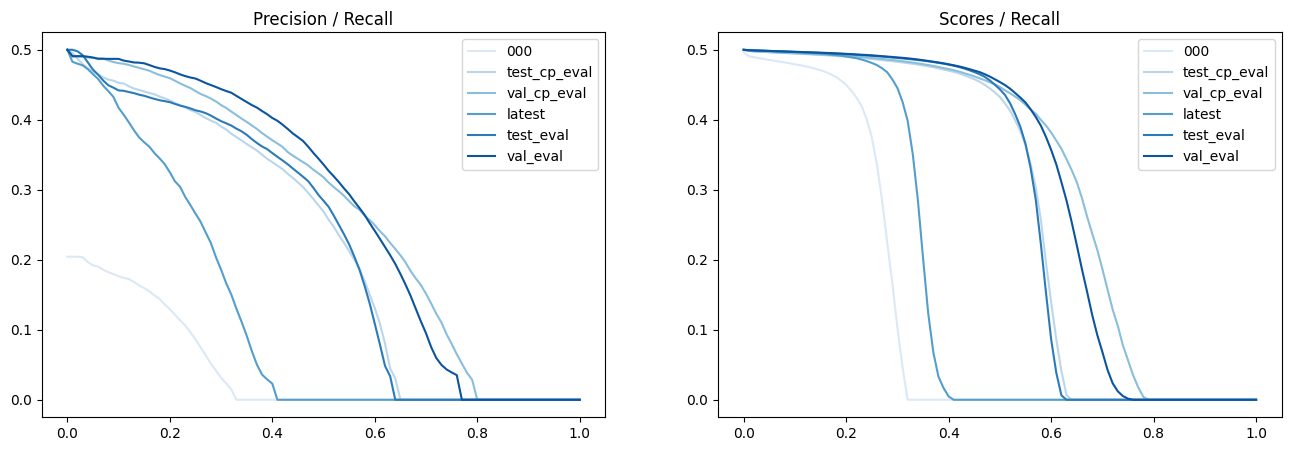

In [35]:
files = Path(outDir)/Path('eval')
print(files)
files = list(files.glob('*.pth'))
print(files)

plot_precision_recall(files)

In [36]:
# Latest and best checkpoint saved models perform similarly on test set. Latest model has more complete information saved.